In [1]:
import datetime as dt
import gc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import geopandas as gpd
import imageio
from pathlib import Path

#####--
import numpy as np
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from numpy.random import randn
from numpy.random import randint
import numpy.random as random

#Keras and tensorflow
import keras
import tensorflow as tf
import torch
from keras.models import load_model

from keras.datasets.cifar10 import load_data
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, TimeDistributed, RepeatVector
from keras.layers import Conv2D,BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Conv2DTranspose
from keras.layers import Flatten
from keras.layers import Dropout,Cropping2D
from keras.layers import LeakyReLU
from keras.layers import Reshape
from keras.callbacks import ModelCheckpoint, Callback
from keras.constraints import Constraint
from keras.layers import Lambda
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras import backend
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Multiply
from tensorflow_addons.image import translate as translate_tf

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### 
from scipy.ndimage import affine_transform
from scipy.ndimage import rotate

### 
from scipy.ndimage import affine_transform
from scipy.ndimage import rotate

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

C:\Users\Remote\anaconda3\envs\TF_V0\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Remote\anaconda3\envs\TF_V0\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


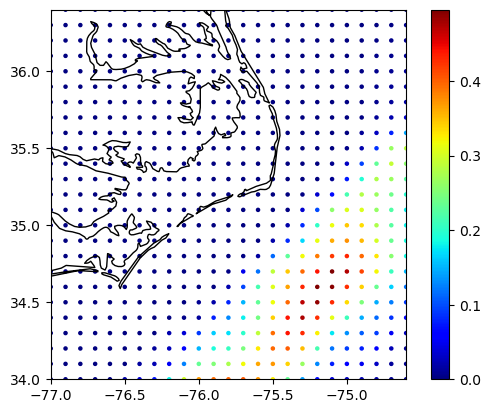

In [2]:
def PlotData_Stage1(Scenario,Tech,EnergyPu):
  ShapeFileCoast="./GEO_data/ne_10m_coastline.shp"
  ShapeFileStates="./GEO_data/ne_10m_admin_1_states_provinces_lines.shp"
  X_LAT=np.zeros((int(len(Lat)*len(Long))),dtype=float)
  Y_LONG=np.zeros((int(len(Lat)*len(Long))),dtype=float)

  min_latitude=np.min(Lat)
  max_latitude=np.max(Lat)

  min_longitude=np.min(Long)
  max_longitude=np.max(Long)

  xlim =[min_longitude,max_longitude]
  ylim=[min_latitude, max_latitude]

  df = gpd.read_file(ShapeFileCoast)
  df1 = gpd.read_file(ShapeFileStates)

  fig, ax = plt.subplots(figsize  = None)
  df.plot(color='black',linewidth=1,ax=ax)
  df1.plot(color='black',linewidth=1,ax=ax)

  count=0
  for I_lat in range(len(Lat)):
    for I_long in range(len(Long)):

      Y_LONG[count]=Lat[I_lat]
      X_LAT[count]=Long[I_long]
      count=count+1

  plt.scatter(X_LAT,Y_LONG,c=(EnergyPu[Scenario,:,:,Tech]), s=5, cmap='jet')
  plt.colorbar()
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)

  return plt.show()

NPZ_Data=np.load("./AggregatedData_Daily.npz", allow_pickle=True) 
EnergyPu=NPZ_Data["EnergyPu"]
Lat=NPZ_Data["Lat"]
Long=NPZ_Data["Long"]
EnergyPu=NPZ_Data["EnergyPu"]
StartYear=NPZ_Data["StartYear"]
EndYear=NPZ_Data["EndYear"]
WindEnergy_RatedPower=float(NPZ_Data["WindEnergy_RatedPower"])
WaveEnergy_RatedPower=float(NPZ_Data["WaveEnergy_RatedPower"])
OceanEnergy_RatedPower=float(NPZ_Data["OceanEnergy_RatedPower"])

NPZ_Data_Yearly=np.load("./AggregatedData_Daily.npz", allow_pickle=True) 
EnergyPu_Yearly=NPZ_Data_Yearly["EnergyPu"]

Idx_Exclude=np.max(EnergyPu_Yearly[:,:,:,1],axis=0)<=0.001
EnergyPu[:,Idx_Exclude,:]=0

Idx_Exclude_Ocean=np.max(EnergyPu_Yearly[:,:,:,2],axis=0)<=0.05
EnergyPu[:,Idx_Exclude_Ocean,2]=0
    
#EnergyPu=np.round(EnergyPu*255)#Put data in image format for convenience
#Extend data 25x25> 26x26 to improve in the padding

Idx_Exclude=np.max(EnergyPu_Yearly[:,:,:,1],axis=0)>0.05

Idx_Exclude_Ocean=np.max(EnergyPu_Yearly[:,:,:,2],axis=0)>0.05
Idx_Exclude_Ocean=np.reshape(Idx_Exclude_Ocean*1,(25,25,1))

Idx_Exclude=np.reshape(Idx_Exclude*1,(25,25,1))
Idx_Exclude=np.repeat(Idx_Exclude,2,axis=2)

Idx_Exclude=np.concatenate((Idx_Exclude,Idx_Exclude_Ocean),axis=2)

PlotData_Stage1(1,2,EnergyPu)

Min_E=np.mean(EnergyPu,axis=0)
MaxMin=1
EnergyPu=(EnergyPu-Min_E)

In [3]:
def MMD(x, y, kernel="rbf"):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    device = torch.device("cpu")
    x.to(device)
    y.to(device)

    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx 
    dyy = ry.t() + ry - 2. * yy 
    dxy = rx.t() + ry - 2. * zz 

    dxx=dxx.to(device)
    dyy=dyy.to(device)
    dxy=dxy.to(device)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
     
    return torch.mean(XX + YY - 2. * XY)

In [4]:
#Original

def G_Create_CNN(latent_dim_G, in_shape=(25,25,3)):
  
  x = Input(shape=(latent_dim_G,),name="Image")
  #Layer1

  n_nodes = 512* 4 * 4 # foundation for 4x4 image

  y=Dense(n_nodes)(x)
  y=BatchNormalization()(y)
  y=LeakyReLU(alpha=0.2)(y)
  y=Reshape((4, 4, 512))(y)

  y=Conv2DTranspose(512, (3,3), strides=(2,2), padding='same')(y)
  y=BatchNormalization()(y)
  y=LeakyReLU(alpha=0.2)(y)

  y=Conv2DTranspose(512, (3,3), strides=(1,1), padding='same')(y)
  y=BatchNormalization()(y)
  y=LeakyReLU(alpha=0.2)(y)

  #Layer2
  y=Conv2DTranspose(256, (3,3), strides=(2,2), padding='same')(y)
  y=BatchNormalization()(y)
  y=LeakyReLU(alpha=0.2)(y)

  y=Conv2DTranspose(256, (3,3), strides=(1,1), padding='same')(y)
  y=BatchNormalization()(y)
  y=LeakyReLU(alpha=0.2)(y)

  #Layer3
  y=Conv2DTranspose(256, (3,3), strides=(2,2), padding='same')(y)
  y=BatchNormalization()(y)
  y012=LeakyReLU(alpha=0.2)(y)


  # upsample to 40x60
  y=Conv2DTranspose(128, (3,3), strides=(1,1), padding='same')(y)
  y=BatchNormalization()(y)
  y=LeakyReLU(alpha=0.2)(y)


  # output layer
  y=Conv2DTranspose(3, (3,3),  padding='same')(y)
  y=Cropping2D(cropping=((4, 3), (4, 3)))(y)
  model=Model(x, y)

  return model



# use the generator to generate n fake examples
def generate_fake_samples(GENERATOR, latent_dim_G, n_samples):
  x_input = generate_latent_points(latent_dim_G, n_samples)

  # predict outputs
  X = GENERATOR.predict(x_input)

  # create 'fake' class labels (0)
  y = zeros((n_samples, 1))
  return X, y

def generate_latent_points(latent_dim_G, n_samples):
  x_input = randn(latent_dim_G * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim_G)

  return x_input

In [6]:
# define the standalone generator model (CNN)
# define the standalone discriminator model

def D_Create_CNN(in_shape=(25,25,3)):

  x = Input(shape=(in_shape[0],in_shape[1],in_shape[2],),name="Image")

  y=Conv2D(64, (3,3), padding='same', input_shape=in_shape)(x)
  y=LeakyReLU(alpha=0.2)(y)
  
  y=Conv2D(128, (3,3), padding='same')(y)
  y=LeakyReLU(alpha=0.2)(y)
  
  y=Conv2D(128, (3,3), strides=(2,2), padding='same')(y)
  y=LeakyReLU(alpha=0.2)(y)

  # # Layer2 
  y=Conv2D(256, (3,3), strides=(1,1), padding='same')(y)
  y=LeakyReLU(alpha=0.2)(y)

  y=Conv2D(256, (3,3), strides=(2,2), padding='same')(y)
  y=LeakyReLU(alpha=0.2)(y)

  ##Layer3
  y=Conv2D(512, (3,3), strides=(1,1), padding='same')(y)
  y=LeakyReLU(alpha=0.2)(y)

  y=Conv2D(512, (3,3), strides=(2,2), padding='same')(y)
  y=LeakyReLU(alpha=0.2)(y)

  # #Layer4
  y=Flatten()(y)
  y=Dense(1)(y)
  opt = Adam(learning_rate=0.0002, beta_1=0.5)

  model = Model(x, y)

  return model


In [7]:
class KerasBatchGenerator(object):

    def __init__(self, data, batch_size, ImageShape):
        self.data = data
        self.ImageShape=ImageShape #[x, y, # of chanels]
        self.batch_size = batch_size
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0

    def generate(self):
        x = np.zeros((self.batch_size, self.ImageShape[0], self.ImageShape[1], self.ImageShape[2]),dtype=float)
        y = np.zeros((self.batch_size, 1),dtype=float)
        while True:
            for i in range(self.batch_size):
                if self.current_idx>= len(self.data):
                    # reset the index back to the start of the data set
                    self.current_idx = 0
                x[i,:,:,:] = self.data[self.current_idx]
                # convert all of temp_y into a one hot representation
                y[i, 0] = 1
                self.current_idx += 1
            yield x, y

In [8]:
def gradient_penalty(DISCRIMINATOR, batch_size, real_images, fake_images):
    """ Calculates the gradient penalty.

    This loss is calculated on an interpolated image
    and added to the discriminator loss.
    """
    # Get the interpolated image
    alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        # 1. Get the discriminator output for this interpolated image.  
        pred = DISCRIMINATOR(interpolated, training=True)

    # 2. Calculate the gradients w.r.t to this interpolated image.
    grads = gp_tape.gradient(pred, [interpolated])[0]
    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

In [6]:
def train(GENERATOR, DISCRIMINATOR, latent_dim_G, TrainData, batch_size, NumEpochs,ImageShape):
  Prob_Limit=0.0 #% of time the augmentation is applied
  count_p_update=0
  bat_per_epo = int(TrainData.shape[0] / (batch_size/2))+1
  train_data_generator=KerasBatchGenerator (TrainData, batch_size, ImageShape)

  KID=[]
  KID_A=0
  KID.append(-1)

  for i in range(NumEpochs):
    if i!=0 and i%10==0:
      #MAKE_GIF (GENERATOR, latent_dim_G, TrainData, ImageShape, number=i)
      GENERATOR.save("GENERATOR"+".hdf5")
      DISCRIMINATOR.save("DISCRIMINATOR"+".hdf5")
      x_torch=torch.from_numpy(np.reshape(TrainData,(TrainData.shape[0],-1))).double()
      y_gan, _ = generate_fake_samples(GENERATOR, latent_dim_G, TrainData.shape[0])
      y_torch=torch.from_numpy(np.reshape(y_gan,(y_gan.shape[0],-1))).double()
      KID_A=MMD(x_torch, y_torch, kernel="rbf")
      KID.append(KID_A)
      np.savez("./SaveStep_Tmp/PerformanceTrack.npz", KID=KID)


    for j in range(bat_per_epo):
      # if j%250==0:
      #   #MAKE_GIF (GENERATOR, latent_dim_G, TrainData, ImageShape, number=i)
      #   GENERATOR.save("/home/victor-duraes/Projects/Ocean2/GANs/SaveStep_Tmp/GENERATOR_W_VS"+str(j)+".hdf5")
      #   DISCRIMINATOR.save("/home/victor-duraes/Projects/Ocean2/GANs/SaveStep_Tmp/DISCRIMINATOR_W_VS"+str(j)+".hdf5")
      #   I=np.random.randint(0, TrainData.shape[0]-10, 1000)
      #   x_torch=torch.from_numpy(np.reshape(TrainData[I,:,:,:],(1000,-1))).double()
      #   y_gan, _ = generate_fake_samples(GENERATOR, latent_dim_G, 1000)
      #   y_torch=torch.from_numpy(np.reshape(y_gan,(y_gan.shape[0],-1))).double()
      #   KID_A=MMD(x_torch, y_torch, kernel="rbf")


      X_gan = generate_latent_points(latent_dim_G, batch_size)
      X_TD,_=next(train_data_generator.generate()) #Get real examples
      for m in range(4):
        with tf.GradientTape() as tape:
            # Generate fake images from the latent vector
            fake_images = GENERATOR(X_gan, training=True)

            # Get the logits for the fake images

            fake_logits = DISCRIMINATOR(fake_images, training=True)
            # Get the logits for the real images
            real_logits = DISCRIMINATOR(X_TD, training=True)

            # Calculate the discriminator loss using the fake and real image logits

            d_cost = discriminator_loss(real_img=real_logits, fake_img=fake_logits)
            # Calculate the gradient penalty
            gp = gradient_penalty(DISCRIMINATOR,batch_size, X_TD, fake_images)
            # Add the gradient penalty to the original discriminator loss
            d_loss = d_cost + gp * 10.0

      # Get the gradients w.r.t the discriminator loss
      d_gradient = tape.gradient(d_loss, DISCRIMINATOR.trainable_variables)
      # Update the weights of the discriminator using the discriminator optimizer
      discriminator_optimizer.apply_gradients(zip(d_gradient, DISCRIMINATOR.trainable_variables))

      # Train the generator
      # Get the latent vector
      X_gan = generate_latent_points(latent_dim_G, batch_size)
      with tf.GradientTape() as tape:
          # Generate fake images using the generator
          generated_images = GENERATOR(X_gan, training=True)
          # Get the discriminator logits for fake images
          gen_img_logits = DISCRIMINATOR(generated_images, training=True)
          # Calculate the generator loss
          g_loss = generator_loss(gen_img_logits)

      # Get the gradients w.r.t the generator loss
      gen_gradient = tape.gradient(g_loss, GENERATOR.trainable_variables)
      # Update the weights of the generator using the generator optimizer
      generator_optimizer.apply_gradients(zip(gen_gradient, GENERATOR.trainable_variables))
      
#-------------------------------------------------------------------------------      
      # summarize loss on this batch
      print('epoch %d, batch %d, d_loss=%.3f g_loss=%.3f KID= %.5f'% (i,j,d_loss,g_loss,KID[-1]))	

  return 0



In [12]:
GENERATOR = load_model("./SaveStep_Tmp/GENERATOR_W_VS"+str(6490)+".hdf5")
DISCRIMINATOR = load_model("./SaveStep_Tmp/DISCRIMINATOR_W_VS"+str(6490)+".hdf5")

In [14]:
import tensorflow as tf

latent_dim_G=100 #40
batch_size=256#64/2
NumEpochs=10000

#GaussianData_Interpolated=np.load("GaussianData_Interpolated.npz")
#GaussianSample=GaussianData_Interpolated["GaussianSample"]

ImageShape=EnergyPu.shape[1:]
TrainData=EnergyPu # EnergyPu # GaussianSample

#DISCRIMINATOR=D_Create_CNN(in_shape=ImageShape)
DISCRIMINATOR._name="Discriminator"

#GENERATOR=G_Create_CNN(latent_dim_G)
GENERATOR._name="Generator"

_=train(GENERATOR, DISCRIMINATOR, latent_dim_G, TrainData, batch_size, NumEpochs,ImageShape)

epoch 0, batch 0, d_loss=-2.120 g_loss=2.856 KID= -1.00000
epoch 0, batch 1, d_loss=-1.671 g_loss=1.856 KID= -1.00000
epoch 0, batch 2, d_loss=-2.027 g_loss=1.395 KID= -1.00000
epoch 0, batch 3, d_loss=-2.075 g_loss=1.520 KID= -1.00000
epoch 0, batch 4, d_loss=-1.839 g_loss=1.130 KID= -1.00000
epoch 0, batch 5, d_loss=-1.943 g_loss=1.354 KID= -1.00000
epoch 0, batch 6, d_loss=-1.824 g_loss=1.885 KID= -1.00000
epoch 0, batch 7, d_loss=-2.122 g_loss=2.076 KID= -1.00000
epoch 0, batch 8, d_loss=-2.109 g_loss=1.971 KID= -1.00000
epoch 0, batch 9, d_loss=-2.164 g_loss=1.856 KID= -1.00000
epoch 0, batch 10, d_loss=-2.390 g_loss=1.750 KID= -1.00000
epoch 0, batch 11, d_loss=-2.034 g_loss=1.542 KID= -1.00000
epoch 0, batch 12, d_loss=-2.093 g_loss=1.203 KID= -1.00000
epoch 0, batch 13, d_loss=-2.236 g_loss=1.144 KID= -1.00000
epoch 0, batch 14, d_loss=-2.037 g_loss=1.283 KID= -1.00000
epoch 0, batch 15, d_loss=-2.207 g_loss=1.461 KID= -1.00000
epoch 0, batch 16, d_loss=-2.103 g_loss=1.557 KID=

epoch 6, batch 18, d_loss=-2.377 g_loss=1.823 KID= -1.00000
epoch 6, batch 19, d_loss=-2.394 g_loss=1.713 KID= -1.00000
epoch 7, batch 0, d_loss=-2.413 g_loss=1.762 KID= -1.00000
epoch 7, batch 1, d_loss=-2.058 g_loss=1.617 KID= -1.00000
epoch 7, batch 2, d_loss=-2.166 g_loss=1.532 KID= -1.00000
epoch 7, batch 3, d_loss=-2.162 g_loss=1.623 KID= -1.00000
epoch 7, batch 4, d_loss=-2.134 g_loss=1.441 KID= -1.00000
epoch 7, batch 5, d_loss=-2.240 g_loss=1.604 KID= -1.00000
epoch 7, batch 6, d_loss=-1.835 g_loss=1.534 KID= -1.00000
epoch 7, batch 7, d_loss=-2.009 g_loss=1.919 KID= -1.00000
epoch 7, batch 8, d_loss=-2.294 g_loss=2.129 KID= -1.00000
epoch 7, batch 9, d_loss=-2.288 g_loss=1.817 KID= -1.00000
epoch 7, batch 10, d_loss=-2.241 g_loss=1.971 KID= -1.00000
epoch 7, batch 11, d_loss=-1.953 g_loss=1.476 KID= -1.00000
epoch 7, batch 12, d_loss=-2.107 g_loss=1.448 KID= -1.00000
epoch 7, batch 13, d_loss=-2.174 g_loss=1.410 KID= -1.00000
epoch 7, batch 14, d_loss=-2.176 g_loss=1.288 KID=

epoch 13, batch 11, d_loss=-2.267 g_loss=1.746 KID= 0.00649
epoch 13, batch 12, d_loss=-2.148 g_loss=1.582 KID= 0.00649
epoch 13, batch 13, d_loss=-2.233 g_loss=1.677 KID= 0.00649
epoch 13, batch 14, d_loss=-2.174 g_loss=1.531 KID= 0.00649
epoch 13, batch 15, d_loss=-2.258 g_loss=1.463 KID= 0.00649
epoch 13, batch 16, d_loss=-1.924 g_loss=1.406 KID= 0.00649
epoch 13, batch 17, d_loss=-1.975 g_loss=1.972 KID= 0.00649
epoch 13, batch 18, d_loss=-2.431 g_loss=1.770 KID= 0.00649
epoch 13, batch 19, d_loss=-2.293 g_loss=1.589 KID= 0.00649
epoch 14, batch 0, d_loss=-1.996 g_loss=1.779 KID= 0.00649
epoch 14, batch 1, d_loss=-2.116 g_loss=1.601 KID= 0.00649
epoch 14, batch 2, d_loss=-2.410 g_loss=1.451 KID= 0.00649
epoch 14, batch 3, d_loss=-2.123 g_loss=1.609 KID= 0.00649
epoch 14, batch 4, d_loss=-1.972 g_loss=1.550 KID= 0.00649
epoch 14, batch 5, d_loss=-2.354 g_loss=1.813 KID= 0.00649
epoch 14, batch 6, d_loss=-2.012 g_loss=1.368 KID= 0.00649
epoch 14, batch 7, d_loss=-2.103 g_loss=1.730 K

epoch 20, batch 3, d_loss=-2.016 g_loss=1.667 KID= 0.00550
epoch 20, batch 4, d_loss=-2.021 g_loss=1.500 KID= 0.00550
epoch 20, batch 5, d_loss=-2.265 g_loss=1.721 KID= 0.00550
epoch 20, batch 6, d_loss=-1.747 g_loss=1.636 KID= 0.00550
epoch 20, batch 7, d_loss=-2.026 g_loss=2.398 KID= 0.00550
epoch 20, batch 8, d_loss=-2.178 g_loss=2.258 KID= 0.00550
epoch 20, batch 9, d_loss=-2.085 g_loss=1.899 KID= 0.00550
epoch 20, batch 10, d_loss=-1.894 g_loss=1.637 KID= 0.00550
epoch 20, batch 11, d_loss=-2.305 g_loss=1.552 KID= 0.00550
epoch 20, batch 12, d_loss=-2.244 g_loss=1.376 KID= 0.00550
epoch 20, batch 13, d_loss=-1.974 g_loss=1.602 KID= 0.00550
epoch 20, batch 14, d_loss=-2.067 g_loss=1.553 KID= 0.00550
epoch 20, batch 15, d_loss=-2.072 g_loss=1.675 KID= 0.00550
epoch 20, batch 16, d_loss=-2.020 g_loss=1.791 KID= 0.00550
epoch 20, batch 17, d_loss=-2.128 g_loss=2.294 KID= 0.00550
epoch 20, batch 18, d_loss=-2.240 g_loss=2.027 KID= 0.00550
epoch 20, batch 19, d_loss=-2.090 g_loss=1.690 

epoch 27, batch 1, d_loss=-2.128 g_loss=1.694 KID= 0.00550
epoch 27, batch 2, d_loss=-2.352 g_loss=1.660 KID= 0.00550
epoch 27, batch 3, d_loss=-2.109 g_loss=1.771 KID= 0.00550
epoch 27, batch 4, d_loss=-2.219 g_loss=2.162 KID= 0.00550
epoch 27, batch 5, d_loss=-2.146 g_loss=1.864 KID= 0.00550
epoch 27, batch 6, d_loss=-2.039 g_loss=1.737 KID= 0.00550
epoch 27, batch 7, d_loss=-2.079 g_loss=2.481 KID= 0.00550
epoch 27, batch 8, d_loss=-2.320 g_loss=2.445 KID= 0.00550
epoch 27, batch 9, d_loss=-2.374 g_loss=1.950 KID= 0.00550
epoch 27, batch 10, d_loss=-2.000 g_loss=1.698 KID= 0.00550
epoch 27, batch 11, d_loss=-2.175 g_loss=1.779 KID= 0.00550
epoch 27, batch 12, d_loss=-2.386 g_loss=1.632 KID= 0.00550
epoch 27, batch 13, d_loss=-2.192 g_loss=1.554 KID= 0.00550
epoch 27, batch 14, d_loss=-2.040 g_loss=1.969 KID= 0.00550
epoch 27, batch 15, d_loss=-2.086 g_loss=1.939 KID= 0.00550
epoch 27, batch 16, d_loss=-2.046 g_loss=1.906 KID= 0.00550
epoch 27, batch 17, d_loss=-2.084 g_loss=2.664 KI

epoch 33, batch 14, d_loss=-1.915 g_loss=1.620 KID= 0.00549
epoch 33, batch 15, d_loss=-2.163 g_loss=1.986 KID= 0.00549
epoch 33, batch 16, d_loss=-2.374 g_loss=1.930 KID= 0.00549
epoch 33, batch 17, d_loss=-2.032 g_loss=2.280 KID= 0.00549
epoch 33, batch 18, d_loss=-2.402 g_loss=2.466 KID= 0.00549
epoch 33, batch 19, d_loss=-2.339 g_loss=2.171 KID= 0.00549
epoch 34, batch 0, d_loss=-2.187 g_loss=1.702 KID= 0.00549
epoch 34, batch 1, d_loss=-2.110 g_loss=1.513 KID= 0.00549
epoch 34, batch 2, d_loss=-2.098 g_loss=1.498 KID= 0.00549
epoch 34, batch 3, d_loss=-2.324 g_loss=1.558 KID= 0.00549
epoch 34, batch 4, d_loss=-2.057 g_loss=1.685 KID= 0.00549
epoch 34, batch 5, d_loss=-1.957 g_loss=2.106 KID= 0.00549
epoch 34, batch 6, d_loss=-2.236 g_loss=2.009 KID= 0.00549
epoch 34, batch 7, d_loss=-2.192 g_loss=2.237 KID= 0.00549
epoch 34, batch 8, d_loss=-2.342 g_loss=2.361 KID= 0.00549
epoch 34, batch 9, d_loss=-2.438 g_loss=2.108 KID= 0.00549
epoch 34, batch 10, d_loss=-1.962 g_loss=1.724 KID

epoch 40, batch 6, d_loss=-2.125 g_loss=2.031 KID= 0.00393
epoch 40, batch 7, d_loss=-2.199 g_loss=2.061 KID= 0.00393
epoch 40, batch 8, d_loss=-2.261 g_loss=2.011 KID= 0.00393
epoch 40, batch 9, d_loss=-2.200 g_loss=2.117 KID= 0.00393
epoch 40, batch 10, d_loss=-2.040 g_loss=1.554 KID= 0.00393
epoch 40, batch 11, d_loss=-2.186 g_loss=1.532 KID= 0.00393
epoch 40, batch 12, d_loss=-2.129 g_loss=1.601 KID= 0.00393
epoch 40, batch 13, d_loss=-2.198 g_loss=1.568 KID= 0.00393
epoch 40, batch 14, d_loss=-2.143 g_loss=1.717 KID= 0.00393
epoch 40, batch 15, d_loss=-1.960 g_loss=1.711 KID= 0.00393
epoch 40, batch 16, d_loss=-2.002 g_loss=2.143 KID= 0.00393
epoch 40, batch 17, d_loss=-2.150 g_loss=2.314 KID= 0.00393
epoch 40, batch 18, d_loss=-2.337 g_loss=2.120 KID= 0.00393
epoch 40, batch 19, d_loss=-2.230 g_loss=2.493 KID= 0.00393
epoch 41, batch 0, d_loss=-1.946 g_loss=2.041 KID= 0.00393
epoch 41, batch 1, d_loss=-2.149 g_loss=1.667 KID= 0.00393
epoch 41, batch 2, d_loss=-2.325 g_loss=1.439 

epoch 47, batch 4, d_loss=-2.134 g_loss=1.670 KID= 0.00393
epoch 47, batch 5, d_loss=-1.899 g_loss=1.471 KID= 0.00393
epoch 47, batch 6, d_loss=-1.885 g_loss=2.204 KID= 0.00393
epoch 47, batch 7, d_loss=-2.082 g_loss=2.041 KID= 0.00393
epoch 47, batch 8, d_loss=-2.125 g_loss=1.817 KID= 0.00393
epoch 47, batch 9, d_loss=-2.095 g_loss=1.894 KID= 0.00393
epoch 47, batch 10, d_loss=-2.029 g_loss=1.910 KID= 0.00393
epoch 47, batch 11, d_loss=-2.292 g_loss=1.432 KID= 0.00393
epoch 47, batch 12, d_loss=-2.119 g_loss=1.314 KID= 0.00393
epoch 47, batch 13, d_loss=-2.151 g_loss=1.694 KID= 0.00393
epoch 47, batch 14, d_loss=-2.111 g_loss=1.694 KID= 0.00393
epoch 47, batch 15, d_loss=-1.923 g_loss=1.887 KID= 0.00393
epoch 47, batch 16, d_loss=-2.072 g_loss=2.350 KID= 0.00393
epoch 47, batch 17, d_loss=-2.111 g_loss=1.987 KID= 0.00393
epoch 47, batch 18, d_loss=-2.214 g_loss=1.807 KID= 0.00393
epoch 47, batch 19, d_loss=-2.169 g_loss=1.821 KID= 0.00393
epoch 48, batch 0, d_loss=-2.034 g_loss=1.741 

epoch 53, batch 16, d_loss=-1.930 g_loss=1.967 KID= 0.00654
epoch 53, batch 17, d_loss=-2.303 g_loss=2.101 KID= 0.00654
epoch 53, batch 18, d_loss=-2.108 g_loss=1.838 KID= 0.00654
epoch 53, batch 19, d_loss=-1.930 g_loss=1.869 KID= 0.00654
epoch 54, batch 0, d_loss=-2.128 g_loss=1.591 KID= 0.00654
epoch 54, batch 1, d_loss=-2.067 g_loss=1.817 KID= 0.00654
epoch 54, batch 2, d_loss=-1.957 g_loss=1.739 KID= 0.00654
epoch 54, batch 3, d_loss=-2.116 g_loss=1.725 KID= 0.00654
epoch 54, batch 4, d_loss=-2.187 g_loss=1.829 KID= 0.00654
epoch 54, batch 5, d_loss=-1.994 g_loss=1.506 KID= 0.00654
epoch 54, batch 6, d_loss=-2.120 g_loss=2.046 KID= 0.00654
epoch 54, batch 7, d_loss=-2.255 g_loss=2.104 KID= 0.00654
epoch 54, batch 8, d_loss=-2.195 g_loss=1.900 KID= 0.00654
epoch 54, batch 9, d_loss=-2.005 g_loss=2.094 KID= 0.00654
epoch 54, batch 10, d_loss=-2.002 g_loss=1.730 KID= 0.00654
epoch 54, batch 11, d_loss=-2.277 g_loss=1.627 KID= 0.00654
epoch 54, batch 12, d_loss=-2.012 g_loss=1.801 KID

epoch 60, batch 9, d_loss=-2.033 g_loss=1.798 KID= 0.00491
epoch 60, batch 10, d_loss=-2.165 g_loss=1.589 KID= 0.00491
epoch 60, batch 11, d_loss=-2.394 g_loss=1.405 KID= 0.00491
epoch 60, batch 12, d_loss=-2.100 g_loss=1.505 KID= 0.00491
epoch 60, batch 13, d_loss=-2.074 g_loss=1.648 KID= 0.00491
epoch 60, batch 14, d_loss=-2.166 g_loss=1.721 KID= 0.00491
epoch 60, batch 15, d_loss=-1.980 g_loss=2.023 KID= 0.00491
epoch 60, batch 16, d_loss=-2.038 g_loss=2.582 KID= 0.00491
epoch 60, batch 17, d_loss=-2.250 g_loss=2.350 KID= 0.00491
epoch 60, batch 18, d_loss=-2.263 g_loss=2.052 KID= 0.00491
epoch 60, batch 19, d_loss=-1.919 g_loss=2.063 KID= 0.00491
epoch 61, batch 0, d_loss=-2.155 g_loss=1.686 KID= 0.00491
epoch 61, batch 1, d_loss=-2.338 g_loss=1.618 KID= 0.00491
epoch 61, batch 2, d_loss=-1.933 g_loss=1.780 KID= 0.00491
epoch 61, batch 3, d_loss=-2.112 g_loss=1.564 KID= 0.00491
epoch 61, batch 4, d_loss=-2.182 g_loss=1.625 KID= 0.00491
epoch 61, batch 5, d_loss=-1.849 g_loss=1.553 

epoch 67, batch 7, d_loss=-2.304 g_loss=2.054 KID= 0.00491
epoch 67, batch 8, d_loss=-2.290 g_loss=1.772 KID= 0.00491
epoch 67, batch 9, d_loss=-2.016 g_loss=1.617 KID= 0.00491
epoch 67, batch 10, d_loss=-2.233 g_loss=1.488 KID= 0.00491
epoch 67, batch 11, d_loss=-2.194 g_loss=1.674 KID= 0.00491
epoch 67, batch 12, d_loss=-2.044 g_loss=1.655 KID= 0.00491
epoch 67, batch 13, d_loss=-2.243 g_loss=1.907 KID= 0.00491
epoch 67, batch 14, d_loss=-2.191 g_loss=1.607 KID= 0.00491
epoch 67, batch 15, d_loss=-2.084 g_loss=1.602 KID= 0.00491
epoch 67, batch 16, d_loss=-2.153 g_loss=2.105 KID= 0.00491
epoch 67, batch 17, d_loss=-2.376 g_loss=2.164 KID= 0.00491
epoch 67, batch 18, d_loss=-2.248 g_loss=2.140 KID= 0.00491
epoch 67, batch 19, d_loss=-1.902 g_loss=2.064 KID= 0.00491
epoch 68, batch 0, d_loss=-2.129 g_loss=1.747 KID= 0.00491
epoch 68, batch 1, d_loss=-2.173 g_loss=1.586 KID= 0.00491
epoch 68, batch 2, d_loss=-2.177 g_loss=1.706 KID= 0.00491
epoch 68, batch 3, d_loss=-2.072 g_loss=2.057 

epoch 73, batch 19, d_loss=-2.009 g_loss=2.037 KID= 0.00378
epoch 74, batch 0, d_loss=-2.229 g_loss=1.323 KID= 0.00378
epoch 74, batch 1, d_loss=-2.222 g_loss=1.410 KID= 0.00378
epoch 74, batch 2, d_loss=-2.072 g_loss=1.490 KID= 0.00378
epoch 74, batch 3, d_loss=-1.995 g_loss=1.573 KID= 0.00378
epoch 74, batch 4, d_loss=-2.107 g_loss=2.131 KID= 0.00378
epoch 74, batch 5, d_loss=-2.181 g_loss=2.030 KID= 0.00378
epoch 74, batch 6, d_loss=-2.095 g_loss=2.358 KID= 0.00378
epoch 74, batch 7, d_loss=-2.259 g_loss=2.297 KID= 0.00378
epoch 74, batch 8, d_loss=-2.258 g_loss=1.950 KID= 0.00378
epoch 74, batch 9, d_loss=-2.126 g_loss=1.780 KID= 0.00378
epoch 74, batch 10, d_loss=-2.134 g_loss=1.536 KID= 0.00378
epoch 74, batch 11, d_loss=-2.115 g_loss=1.556 KID= 0.00378
epoch 74, batch 12, d_loss=-2.156 g_loss=1.980 KID= 0.00378
epoch 74, batch 13, d_loss=-1.889 g_loss=1.736 KID= 0.00378
epoch 74, batch 14, d_loss=-2.025 g_loss=1.908 KID= 0.00378
epoch 74, batch 15, d_loss=-2.234 g_loss=2.042 KID

epoch 80, batch 12, d_loss=-2.197 g_loss=1.533 KID= 0.00439
epoch 80, batch 13, d_loss=-1.935 g_loss=2.071 KID= 0.00439
epoch 80, batch 14, d_loss=-2.006 g_loss=1.942 KID= 0.00439
epoch 80, batch 15, d_loss=-2.281 g_loss=2.251 KID= 0.00439
epoch 80, batch 16, d_loss=-2.187 g_loss=2.610 KID= 0.00439
epoch 80, batch 17, d_loss=-2.175 g_loss=2.252 KID= 0.00439
epoch 80, batch 18, d_loss=-2.131 g_loss=1.969 KID= 0.00439
epoch 80, batch 19, d_loss=-2.010 g_loss=1.599 KID= 0.00439
epoch 81, batch 0, d_loss=-2.401 g_loss=1.524 KID= 0.00439
epoch 81, batch 1, d_loss=-2.250 g_loss=1.609 KID= 0.00439
epoch 81, batch 2, d_loss=-2.175 g_loss=1.696 KID= 0.00439
epoch 81, batch 3, d_loss=-1.965 g_loss=1.919 KID= 0.00439
epoch 81, batch 4, d_loss=-1.934 g_loss=2.000 KID= 0.00439
epoch 81, batch 5, d_loss=-2.117 g_loss=2.108 KID= 0.00439
epoch 81, batch 6, d_loss=-2.290 g_loss=2.583 KID= 0.00439
epoch 81, batch 7, d_loss=-2.314 g_loss=2.474 KID= 0.00439
epoch 81, batch 8, d_loss=-2.166 g_loss=2.109 KI

epoch 87, batch 10, d_loss=-2.163 g_loss=1.393 KID= 0.00439
epoch 87, batch 11, d_loss=-2.219 g_loss=1.540 KID= 0.00439
epoch 87, batch 12, d_loss=-2.191 g_loss=1.745 KID= 0.00439
epoch 87, batch 13, d_loss=-2.021 g_loss=1.440 KID= 0.00439
epoch 87, batch 14, d_loss=-1.954 g_loss=1.428 KID= 0.00439
epoch 87, batch 15, d_loss=-2.009 g_loss=1.862 KID= 0.00439
epoch 87, batch 16, d_loss=-2.191 g_loss=2.196 KID= 0.00439
epoch 87, batch 17, d_loss=-2.132 g_loss=2.396 KID= 0.00439
epoch 87, batch 18, d_loss=-2.159 g_loss=2.332 KID= 0.00439
epoch 87, batch 19, d_loss=-1.879 g_loss=1.635 KID= 0.00439
epoch 88, batch 0, d_loss=-2.324 g_loss=1.193 KID= 0.00439
epoch 88, batch 1, d_loss=-2.097 g_loss=1.299 KID= 0.00439
epoch 88, batch 2, d_loss=-2.178 g_loss=1.723 KID= 0.00439
epoch 88, batch 3, d_loss=-2.109 g_loss=1.621 KID= 0.00439
epoch 88, batch 4, d_loss=-1.795 g_loss=1.498 KID= 0.00439
epoch 88, batch 5, d_loss=-1.845 g_loss=1.879 KID= 0.00439
epoch 88, batch 6, d_loss=-2.186 g_loss=2.063 

epoch 94, batch 2, d_loss=-2.235 g_loss=1.386 KID= 0.00400
epoch 94, batch 3, d_loss=-1.944 g_loss=1.367 KID= 0.00400
epoch 94, batch 4, d_loss=-1.879 g_loss=1.435 KID= 0.00400
epoch 94, batch 5, d_loss=-2.084 g_loss=2.167 KID= 0.00400
epoch 94, batch 6, d_loss=-2.223 g_loss=2.140 KID= 0.00400
epoch 94, batch 7, d_loss=-2.136 g_loss=2.189 KID= 0.00400
epoch 94, batch 8, d_loss=-2.233 g_loss=2.178 KID= 0.00400
epoch 94, batch 9, d_loss=-2.041 g_loss=1.602 KID= 0.00400
epoch 94, batch 10, d_loss=-2.290 g_loss=1.298 KID= 0.00400
epoch 94, batch 11, d_loss=-2.307 g_loss=1.309 KID= 0.00400
epoch 94, batch 12, d_loss=-2.244 g_loss=1.439 KID= 0.00400
epoch 94, batch 13, d_loss=-2.073 g_loss=1.153 KID= 0.00400
epoch 94, batch 14, d_loss=-1.848 g_loss=1.126 KID= 0.00400
epoch 94, batch 15, d_loss=-2.028 g_loss=1.929 KID= 0.00400
epoch 94, batch 16, d_loss=-2.243 g_loss=2.062 KID= 0.00400
epoch 94, batch 17, d_loss=-2.318 g_loss=2.210 KID= 0.00400
epoch 94, batch 18, d_loss=-2.279 g_loss=2.027 K

epoch 100, batch 14, d_loss=-1.763 g_loss=1.614 KID= 0.00424
epoch 100, batch 15, d_loss=-2.131 g_loss=1.928 KID= 0.00424
epoch 100, batch 16, d_loss=-2.186 g_loss=2.204 KID= 0.00424
epoch 100, batch 17, d_loss=-2.154 g_loss=2.022 KID= 0.00424
epoch 100, batch 18, d_loss=-2.084 g_loss=2.087 KID= 0.00424
epoch 100, batch 19, d_loss=-2.313 g_loss=1.580 KID= 0.00424
epoch 101, batch 0, d_loss=-2.323 g_loss=1.206 KID= 0.00424
epoch 101, batch 1, d_loss=-1.975 g_loss=1.356 KID= 0.00424
epoch 101, batch 2, d_loss=-2.151 g_loss=1.555 KID= 0.00424
epoch 101, batch 3, d_loss=-2.073 g_loss=1.763 KID= 0.00424
epoch 101, batch 4, d_loss=-2.016 g_loss=1.546 KID= 0.00424
epoch 101, batch 5, d_loss=-2.005 g_loss=1.854 KID= 0.00424
epoch 101, batch 6, d_loss=-2.367 g_loss=1.918 KID= 0.00424
epoch 101, batch 7, d_loss=-2.071 g_loss=2.038 KID= 0.00424
epoch 101, batch 8, d_loss=-2.054 g_loss=1.956 KID= 0.00424
epoch 101, batch 9, d_loss=-2.153 g_loss=1.740 KID= 0.00424
epoch 101, batch 10, d_loss=-2.305

epoch 107, batch 10, d_loss=-2.295 g_loss=1.470 KID= 0.00424
epoch 107, batch 11, d_loss=-2.062 g_loss=1.492 KID= 0.00424
epoch 107, batch 12, d_loss=-2.084 g_loss=1.790 KID= 0.00424
epoch 107, batch 13, d_loss=-2.336 g_loss=1.508 KID= 0.00424
epoch 107, batch 14, d_loss=-1.955 g_loss=1.621 KID= 0.00424
epoch 107, batch 15, d_loss=-1.983 g_loss=2.009 KID= 0.00424
epoch 107, batch 16, d_loss=-2.385 g_loss=2.271 KID= 0.00424
epoch 107, batch 17, d_loss=-2.289 g_loss=2.184 KID= 0.00424
epoch 107, batch 18, d_loss=-1.974 g_loss=2.068 KID= 0.00424
epoch 107, batch 19, d_loss=-2.250 g_loss=1.673 KID= 0.00424
epoch 108, batch 0, d_loss=-2.400 g_loss=1.487 KID= 0.00424
epoch 108, batch 1, d_loss=-2.013 g_loss=1.670 KID= 0.00424
epoch 108, batch 2, d_loss=-2.172 g_loss=1.632 KID= 0.00424
epoch 108, batch 3, d_loss=-2.335 g_loss=1.642 KID= 0.00424
epoch 108, batch 4, d_loss=-2.027 g_loss=1.569 KID= 0.00424
epoch 108, batch 5, d_loss=-2.074 g_loss=2.013 KID= 0.00424
epoch 108, batch 6, d_loss=-2.

epoch 114, batch 0, d_loss=-2.218 g_loss=1.571 KID= 0.00412
epoch 114, batch 1, d_loss=-2.182 g_loss=1.384 KID= 0.00412
epoch 114, batch 2, d_loss=-2.013 g_loss=1.756 KID= 0.00412
epoch 114, batch 3, d_loss=-2.304 g_loss=1.761 KID= 0.00412
epoch 114, batch 4, d_loss=-2.253 g_loss=1.747 KID= 0.00412
epoch 114, batch 5, d_loss=-2.055 g_loss=2.211 KID= 0.00412
epoch 114, batch 6, d_loss=-2.324 g_loss=2.484 KID= 0.00412
epoch 114, batch 7, d_loss=-2.149 g_loss=2.451 KID= 0.00412
epoch 114, batch 8, d_loss=-2.008 g_loss=2.000 KID= 0.00412
epoch 114, batch 9, d_loss=-2.251 g_loss=1.480 KID= 0.00412
epoch 114, batch 10, d_loss=-2.367 g_loss=1.363 KID= 0.00412
epoch 114, batch 11, d_loss=-2.044 g_loss=1.095 KID= 0.00412
epoch 114, batch 12, d_loss=-2.075 g_loss=1.534 KID= 0.00412
epoch 114, batch 13, d_loss=-2.017 g_loss=1.665 KID= 0.00412
epoch 114, batch 14, d_loss=-2.090 g_loss=1.732 KID= 0.00412
epoch 114, batch 15, d_loss=-2.058 g_loss=1.949 KID= 0.00412
epoch 114, batch 16, d_loss=-2.447

epoch 120, batch 10, d_loss=-2.258 g_loss=1.434 KID= 0.00385
epoch 120, batch 11, d_loss=-2.211 g_loss=1.411 KID= 0.00385
epoch 120, batch 12, d_loss=-2.062 g_loss=1.615 KID= 0.00385
epoch 120, batch 13, d_loss=-2.033 g_loss=1.877 KID= 0.00385
epoch 120, batch 14, d_loss=-2.146 g_loss=1.773 KID= 0.00385
epoch 120, batch 15, d_loss=-2.153 g_loss=1.900 KID= 0.00385
epoch 120, batch 16, d_loss=-2.213 g_loss=2.242 KID= 0.00385
epoch 120, batch 17, d_loss=-2.223 g_loss=2.224 KID= 0.00385
epoch 120, batch 18, d_loss=-2.098 g_loss=2.039 KID= 0.00385
epoch 120, batch 19, d_loss=-2.258 g_loss=1.509 KID= 0.00385
epoch 121, batch 0, d_loss=-2.406 g_loss=1.244 KID= 0.00385
epoch 121, batch 1, d_loss=-2.247 g_loss=1.092 KID= 0.00385
epoch 121, batch 2, d_loss=-2.035 g_loss=1.489 KID= 0.00385
epoch 121, batch 3, d_loss=-1.914 g_loss=1.762 KID= 0.00385
epoch 121, batch 4, d_loss=-2.172 g_loss=1.889 KID= 0.00385
epoch 121, batch 5, d_loss=-2.085 g_loss=2.122 KID= 0.00385
epoch 121, batch 6, d_loss=-2.

epoch 127, batch 6, d_loss=-2.325 g_loss=2.206 KID= 0.00385
epoch 127, batch 7, d_loss=-2.170 g_loss=2.261 KID= 0.00385
epoch 127, batch 8, d_loss=-1.947 g_loss=2.138 KID= 0.00385
epoch 127, batch 9, d_loss=-2.233 g_loss=1.822 KID= 0.00385
epoch 127, batch 10, d_loss=-2.238 g_loss=1.692 KID= 0.00385
epoch 127, batch 11, d_loss=-2.322 g_loss=1.250 KID= 0.00385
epoch 127, batch 12, d_loss=-2.083 g_loss=1.337 KID= 0.00385
epoch 127, batch 13, d_loss=-1.956 g_loss=1.435 KID= 0.00385
epoch 127, batch 14, d_loss=-2.119 g_loss=1.779 KID= 0.00385
epoch 127, batch 15, d_loss=-2.022 g_loss=2.147 KID= 0.00385
epoch 127, batch 16, d_loss=-2.350 g_loss=2.226 KID= 0.00385
epoch 127, batch 17, d_loss=-2.167 g_loss=2.186 KID= 0.00385
epoch 127, batch 18, d_loss=-2.179 g_loss=2.161 KID= 0.00385
epoch 127, batch 19, d_loss=-2.395 g_loss=1.571 KID= 0.00385
epoch 128, batch 0, d_loss=-2.248 g_loss=1.325 KID= 0.00385
epoch 128, batch 1, d_loss=-2.319 g_loss=1.022 KID= 0.00385
epoch 128, batch 2, d_loss=-2.

epoch 133, batch 16, d_loss=-2.206 g_loss=1.947 KID= 0.00373
epoch 133, batch 17, d_loss=-2.213 g_loss=2.098 KID= 0.00373
epoch 133, batch 18, d_loss=-2.076 g_loss=1.931 KID= 0.00373
epoch 133, batch 19, d_loss=-2.309 g_loss=1.676 KID= 0.00373
epoch 134, batch 0, d_loss=-2.228 g_loss=1.550 KID= 0.00373
epoch 134, batch 1, d_loss=-2.120 g_loss=1.186 KID= 0.00373
epoch 134, batch 2, d_loss=-2.183 g_loss=1.212 KID= 0.00373
epoch 134, batch 3, d_loss=-2.062 g_loss=1.401 KID= 0.00373
epoch 134, batch 4, d_loss=-2.006 g_loss=2.010 KID= 0.00373
epoch 134, batch 5, d_loss=-2.331 g_loss=2.162 KID= 0.00373
epoch 134, batch 6, d_loss=-2.146 g_loss=2.433 KID= 0.00373
epoch 134, batch 7, d_loss=-2.200 g_loss=2.480 KID= 0.00373
epoch 134, batch 8, d_loss=-1.919 g_loss=2.074 KID= 0.00373
epoch 134, batch 9, d_loss=-2.357 g_loss=1.695 KID= 0.00373
epoch 134, batch 10, d_loss=-2.113 g_loss=1.271 KID= 0.00373
epoch 134, batch 11, d_loss=-2.213 g_loss=1.150 KID= 0.00373
epoch 134, batch 12, d_loss=-2.184

epoch 140, batch 6, d_loss=-2.097 g_loss=1.969 KID= 0.00358
epoch 140, batch 7, d_loss=-2.039 g_loss=2.344 KID= 0.00358
epoch 140, batch 8, d_loss=-2.116 g_loss=1.786 KID= 0.00358
epoch 140, batch 9, d_loss=-2.258 g_loss=1.556 KID= 0.00358
epoch 140, batch 10, d_loss=-2.367 g_loss=1.420 KID= 0.00358
epoch 140, batch 11, d_loss=-2.002 g_loss=1.241 KID= 0.00358
epoch 140, batch 12, d_loss=-2.143 g_loss=1.198 KID= 0.00358
epoch 140, batch 13, d_loss=-2.001 g_loss=1.210 KID= 0.00358
epoch 140, batch 14, d_loss=-1.906 g_loss=1.951 KID= 0.00358
epoch 140, batch 15, d_loss=-2.390 g_loss=2.034 KID= 0.00358
epoch 140, batch 16, d_loss=-2.212 g_loss=1.899 KID= 0.00358
epoch 140, batch 17, d_loss=-2.072 g_loss=2.009 KID= 0.00358
epoch 140, batch 18, d_loss=-2.173 g_loss=1.647 KID= 0.00358
epoch 140, batch 19, d_loss=-2.451 g_loss=1.335 KID= 0.00358
epoch 141, batch 0, d_loss=-2.267 g_loss=1.334 KID= 0.00358
epoch 141, batch 1, d_loss=-1.959 g_loss=1.271 KID= 0.00358
epoch 141, batch 2, d_loss=-2.

epoch 147, batch 2, d_loss=-2.227 g_loss=1.212 KID= 0.00358
epoch 147, batch 3, d_loss=-2.026 g_loss=1.267 KID= 0.00358
epoch 147, batch 4, d_loss=-2.045 g_loss=2.339 KID= 0.00358
epoch 147, batch 5, d_loss=-2.411 g_loss=2.374 KID= 0.00358
epoch 147, batch 6, d_loss=-2.234 g_loss=2.017 KID= 0.00358
epoch 147, batch 7, d_loss=-1.838 g_loss=2.097 KID= 0.00358
epoch 147, batch 8, d_loss=-2.294 g_loss=1.985 KID= 0.00358
epoch 147, batch 9, d_loss=-2.394 g_loss=1.418 KID= 0.00358
epoch 147, batch 10, d_loss=-2.197 g_loss=1.257 KID= 0.00358
epoch 147, batch 11, d_loss=-2.086 g_loss=1.323 KID= 0.00358
epoch 147, batch 12, d_loss=-2.183 g_loss=1.330 KID= 0.00358
epoch 147, batch 13, d_loss=-1.901 g_loss=1.604 KID= 0.00358
epoch 147, batch 14, d_loss=-2.110 g_loss=2.004 KID= 0.00358
epoch 147, batch 15, d_loss=-2.461 g_loss=1.933 KID= 0.00358
epoch 147, batch 16, d_loss=-2.283 g_loss=1.861 KID= 0.00358
epoch 147, batch 17, d_loss=-1.889 g_loss=1.927 KID= 0.00358
epoch 147, batch 18, d_loss=-2.4

epoch 153, batch 12, d_loss=-2.238 g_loss=1.312 KID= 0.00622
epoch 153, batch 13, d_loss=-2.136 g_loss=1.631 KID= 0.00622
epoch 153, batch 14, d_loss=-2.091 g_loss=2.537 KID= 0.00622
epoch 153, batch 15, d_loss=-2.405 g_loss=2.618 KID= 0.00622
epoch 153, batch 16, d_loss=-2.299 g_loss=2.070 KID= 0.00622
epoch 153, batch 17, d_loss=-1.942 g_loss=1.960 KID= 0.00622
epoch 153, batch 18, d_loss=-2.191 g_loss=1.541 KID= 0.00622
epoch 153, batch 19, d_loss=-2.424 g_loss=1.260 KID= 0.00622
epoch 154, batch 0, d_loss=-2.226 g_loss=1.131 KID= 0.00622
epoch 154, batch 1, d_loss=-2.143 g_loss=1.350 KID= 0.00622
epoch 154, batch 2, d_loss=-2.208 g_loss=1.515 KID= 0.00622
epoch 154, batch 3, d_loss=-2.147 g_loss=1.795 KID= 0.00622
epoch 154, batch 4, d_loss=-2.096 g_loss=2.486 KID= 0.00622
epoch 154, batch 5, d_loss=-2.384 g_loss=2.601 KID= 0.00622
epoch 154, batch 6, d_loss=-2.224 g_loss=2.206 KID= 0.00622
epoch 154, batch 7, d_loss=-2.113 g_loss=1.751 KID= 0.00622
epoch 154, batch 8, d_loss=-2.41

epoch 160, batch 2, d_loss=-2.095 g_loss=1.578 KID= 0.00377
epoch 160, batch 3, d_loss=-2.171 g_loss=1.547 KID= 0.00377
epoch 160, batch 4, d_loss=-1.982 g_loss=2.226 KID= 0.00377
epoch 160, batch 5, d_loss=-2.320 g_loss=2.525 KID= 0.00377
epoch 160, batch 6, d_loss=-2.242 g_loss=2.428 KID= 0.00377
epoch 160, batch 7, d_loss=-2.002 g_loss=2.459 KID= 0.00377
epoch 160, batch 8, d_loss=-2.348 g_loss=1.976 KID= 0.00377
epoch 160, batch 9, d_loss=-2.207 g_loss=1.671 KID= 0.00377
epoch 160, batch 10, d_loss=-2.381 g_loss=1.253 KID= 0.00377
epoch 160, batch 11, d_loss=-2.029 g_loss=1.355 KID= 0.00377
epoch 160, batch 12, d_loss=-1.964 g_loss=1.579 KID= 0.00377
epoch 160, batch 13, d_loss=-2.238 g_loss=1.810 KID= 0.00377
epoch 160, batch 14, d_loss=-2.172 g_loss=2.522 KID= 0.00377
epoch 160, batch 15, d_loss=-2.173 g_loss=2.443 KID= 0.00377
epoch 160, batch 16, d_loss=-2.440 g_loss=2.278 KID= 0.00377
epoch 160, batch 17, d_loss=-1.947 g_loss=2.148 KID= 0.00377
epoch 160, batch 18, d_loss=-2.2

epoch 166, batch 18, d_loss=-2.243 g_loss=1.868 KID= 0.00377
epoch 166, batch 19, d_loss=-2.180 g_loss=1.631 KID= 0.00377
epoch 167, batch 0, d_loss=-2.162 g_loss=1.384 KID= 0.00377
epoch 167, batch 1, d_loss=-2.066 g_loss=1.601 KID= 0.00377
epoch 167, batch 2, d_loss=-1.888 g_loss=1.251 KID= 0.00377
epoch 167, batch 3, d_loss=-1.965 g_loss=1.798 KID= 0.00377
epoch 167, batch 4, d_loss=-2.302 g_loss=2.268 KID= 0.00377
epoch 167, batch 5, d_loss=-2.234 g_loss=2.337 KID= 0.00377
epoch 167, batch 6, d_loss=-2.245 g_loss=2.414 KID= 0.00377
epoch 167, batch 7, d_loss=-2.017 g_loss=1.992 KID= 0.00377
epoch 167, batch 8, d_loss=-2.251 g_loss=1.935 KID= 0.00377
epoch 167, batch 9, d_loss=-2.192 g_loss=1.714 KID= 0.00377
epoch 167, batch 10, d_loss=-2.278 g_loss=1.428 KID= 0.00377
epoch 167, batch 11, d_loss=-2.090 g_loss=1.232 KID= 0.00377
epoch 167, batch 12, d_loss=-2.039 g_loss=1.269 KID= 0.00377
epoch 167, batch 13, d_loss=-2.017 g_loss=1.636 KID= 0.00377
epoch 167, batch 14, d_loss=-2.228

epoch 173, batch 8, d_loss=-2.247 g_loss=1.789 KID= 0.00411
epoch 173, batch 9, d_loss=-2.180 g_loss=1.593 KID= 0.00411
epoch 173, batch 10, d_loss=-2.162 g_loss=1.184 KID= 0.00411
epoch 173, batch 11, d_loss=-2.141 g_loss=1.254 KID= 0.00411
epoch 173, batch 12, d_loss=-1.974 g_loss=1.579 KID= 0.00411
epoch 173, batch 13, d_loss=-2.095 g_loss=1.896 KID= 0.00411
epoch 173, batch 14, d_loss=-2.222 g_loss=1.999 KID= 0.00411
epoch 173, batch 15, d_loss=-2.389 g_loss=1.929 KID= 0.00411
epoch 173, batch 16, d_loss=-2.237 g_loss=2.103 KID= 0.00411
epoch 173, batch 17, d_loss=-1.942 g_loss=1.792 KID= 0.00411
epoch 173, batch 18, d_loss=-2.332 g_loss=1.626 KID= 0.00411
epoch 173, batch 19, d_loss=-2.178 g_loss=1.624 KID= 0.00411
epoch 174, batch 0, d_loss=-1.993 g_loss=1.281 KID= 0.00411
epoch 174, batch 1, d_loss=-2.067 g_loss=1.515 KID= 0.00411
epoch 174, batch 2, d_loss=-2.024 g_loss=1.440 KID= 0.00411
epoch 174, batch 3, d_loss=-2.031 g_loss=1.727 KID= 0.00411
epoch 174, batch 4, d_loss=-2.

epoch 180, batch 0, d_loss=-2.000 g_loss=1.561 KID= 0.00356
epoch 180, batch 1, d_loss=-2.140 g_loss=1.349 KID= 0.00356
epoch 180, batch 2, d_loss=-1.896 g_loss=1.399 KID= 0.00356
epoch 180, batch 3, d_loss=-2.025 g_loss=2.051 KID= 0.00356
epoch 180, batch 4, d_loss=-2.431 g_loss=1.712 KID= 0.00356
epoch 180, batch 5, d_loss=-2.214 g_loss=1.567 KID= 0.00356
epoch 180, batch 6, d_loss=-2.220 g_loss=1.728 KID= 0.00356
epoch 180, batch 7, d_loss=-2.094 g_loss=1.524 KID= 0.00356
epoch 180, batch 8, d_loss=-2.368 g_loss=1.401 KID= 0.00356
epoch 180, batch 9, d_loss=-2.176 g_loss=1.424 KID= 0.00356
epoch 180, batch 10, d_loss=-1.992 g_loss=1.595 KID= 0.00356
epoch 180, batch 11, d_loss=-2.261 g_loss=1.267 KID= 0.00356
epoch 180, batch 12, d_loss=-1.986 g_loss=1.279 KID= 0.00356
epoch 180, batch 13, d_loss=-1.929 g_loss=1.962 KID= 0.00356
epoch 180, batch 14, d_loss=-2.347 g_loss=1.905 KID= 0.00356
epoch 180, batch 15, d_loss=-2.220 g_loss=1.821 KID= 0.00356
epoch 180, batch 16, d_loss=-2.173

epoch 186, batch 16, d_loss=-1.872 g_loss=1.788 KID= 0.00356
epoch 186, batch 17, d_loss=-2.160 g_loss=1.720 KID= 0.00356
epoch 186, batch 18, d_loss=-2.201 g_loss=1.439 KID= 0.00356
epoch 186, batch 19, d_loss=-2.148 g_loss=1.379 KID= 0.00356
epoch 187, batch 0, d_loss=-2.034 g_loss=1.478 KID= 0.00356
epoch 187, batch 1, d_loss=-2.217 g_loss=1.392 KID= 0.00356
epoch 187, batch 2, d_loss=-2.018 g_loss=1.184 KID= 0.00356
epoch 187, batch 3, d_loss=-2.229 g_loss=2.021 KID= 0.00356
epoch 187, batch 4, d_loss=-2.362 g_loss=2.060 KID= 0.00356
epoch 187, batch 5, d_loss=-2.187 g_loss=1.785 KID= 0.00356
epoch 187, batch 6, d_loss=-2.074 g_loss=1.930 KID= 0.00356
epoch 187, batch 7, d_loss=-2.307 g_loss=1.836 KID= 0.00356
epoch 187, batch 8, d_loss=-2.298 g_loss=1.517 KID= 0.00356
epoch 187, batch 9, d_loss=-2.069 g_loss=1.414 KID= 0.00356
epoch 187, batch 10, d_loss=-2.075 g_loss=1.393 KID= 0.00356
epoch 187, batch 11, d_loss=-2.173 g_loss=1.251 KID= 0.00356
epoch 187, batch 12, d_loss=-2.037

epoch 193, batch 6, d_loss=-1.967 g_loss=1.907 KID= 0.00479
epoch 193, batch 7, d_loss=-2.256 g_loss=1.639 KID= 0.00479
epoch 193, batch 8, d_loss=-2.385 g_loss=1.449 KID= 0.00479
epoch 193, batch 9, d_loss=-1.979 g_loss=1.414 KID= 0.00479
epoch 193, batch 10, d_loss=-2.023 g_loss=1.434 KID= 0.00479
epoch 193, batch 11, d_loss=-2.282 g_loss=1.292 KID= 0.00479
epoch 193, batch 12, d_loss=-2.186 g_loss=1.235 KID= 0.00479
epoch 193, batch 13, d_loss=-2.078 g_loss=2.261 KID= 0.00479
epoch 193, batch 14, d_loss=-2.392 g_loss=2.394 KID= 0.00479
epoch 193, batch 15, d_loss=-2.115 g_loss=2.192 KID= 0.00479
epoch 193, batch 16, d_loss=-1.984 g_loss=1.942 KID= 0.00479
epoch 193, batch 17, d_loss=-2.190 g_loss=1.803 KID= 0.00479
epoch 193, batch 18, d_loss=-2.361 g_loss=1.667 KID= 0.00479
epoch 193, batch 19, d_loss=-2.122 g_loss=1.491 KID= 0.00479
epoch 194, batch 0, d_loss=-2.145 g_loss=1.415 KID= 0.00479
epoch 194, batch 1, d_loss=-2.142 g_loss=1.247 KID= 0.00479
epoch 194, batch 2, d_loss=-2.

epoch 200, batch 0, d_loss=-2.145 g_loss=1.351 KID= 0.00347
epoch 200, batch 1, d_loss=-2.153 g_loss=1.262 KID= 0.00347
epoch 200, batch 2, d_loss=-2.024 g_loss=1.230 KID= 0.00347
epoch 200, batch 3, d_loss=-1.957 g_loss=2.069 KID= 0.00347
epoch 200, batch 4, d_loss=-2.225 g_loss=2.264 KID= 0.00347
epoch 200, batch 5, d_loss=-2.267 g_loss=2.388 KID= 0.00347
epoch 200, batch 6, d_loss=-2.007 g_loss=2.297 KID= 0.00347
epoch 200, batch 7, d_loss=-2.179 g_loss=1.884 KID= 0.00347
epoch 200, batch 8, d_loss=-2.139 g_loss=1.903 KID= 0.00347
epoch 200, batch 9, d_loss=-2.253 g_loss=1.332 KID= 0.00347
epoch 200, batch 10, d_loss=-2.111 g_loss=1.348 KID= 0.00347
epoch 200, batch 11, d_loss=-2.052 g_loss=1.425 KID= 0.00347
epoch 200, batch 12, d_loss=-2.122 g_loss=1.356 KID= 0.00347
epoch 200, batch 13, d_loss=-1.935 g_loss=2.136 KID= 0.00347
epoch 200, batch 14, d_loss=-2.350 g_loss=2.516 KID= 0.00347
epoch 200, batch 15, d_loss=-2.154 g_loss=2.234 KID= 0.00347
epoch 200, batch 16, d_loss=-2.029

epoch 206, batch 13, d_loss=-2.190 g_loss=1.976 KID= 0.00347
epoch 206, batch 14, d_loss=-2.295 g_loss=1.917 KID= 0.00347
epoch 206, batch 15, d_loss=-2.378 g_loss=2.188 KID= 0.00347
epoch 206, batch 16, d_loss=-2.170 g_loss=1.743 KID= 0.00347
epoch 206, batch 17, d_loss=-2.056 g_loss=1.884 KID= 0.00347
epoch 206, batch 18, d_loss=-2.315 g_loss=1.862 KID= 0.00347
epoch 206, batch 19, d_loss=-2.211 g_loss=1.309 KID= 0.00347
epoch 207, batch 0, d_loss=-2.078 g_loss=1.362 KID= 0.00347
epoch 207, batch 1, d_loss=-2.021 g_loss=1.227 KID= 0.00347
epoch 207, batch 2, d_loss=-2.232 g_loss=1.440 KID= 0.00347
epoch 207, batch 3, d_loss=-2.029 g_loss=2.043 KID= 0.00347
epoch 207, batch 4, d_loss=-2.369 g_loss=1.940 KID= 0.00347
epoch 207, batch 5, d_loss=-2.270 g_loss=2.014 KID= 0.00347
epoch 207, batch 6, d_loss=-2.078 g_loss=1.742 KID= 0.00347
epoch 207, batch 7, d_loss=-2.237 g_loss=1.575 KID= 0.00347
epoch 207, batch 8, d_loss=-2.297 g_loss=1.410 KID= 0.00347
epoch 207, batch 9, d_loss=-2.327

epoch 213, batch 3, d_loss=-2.051 g_loss=2.248 KID= 0.00355
epoch 213, batch 4, d_loss=-2.362 g_loss=2.078 KID= 0.00355
epoch 213, batch 5, d_loss=-2.262 g_loss=2.244 KID= 0.00355
epoch 213, batch 6, d_loss=-2.037 g_loss=1.815 KID= 0.00355
epoch 213, batch 7, d_loss=-2.302 g_loss=1.553 KID= 0.00355
epoch 213, batch 8, d_loss=-2.233 g_loss=1.694 KID= 0.00355
epoch 213, batch 9, d_loss=-2.248 g_loss=1.539 KID= 0.00355
epoch 213, batch 10, d_loss=-2.161 g_loss=1.260 KID= 0.00355
epoch 213, batch 11, d_loss=-2.100 g_loss=1.272 KID= 0.00355
epoch 213, batch 12, d_loss=-2.195 g_loss=1.616 KID= 0.00355
epoch 213, batch 13, d_loss=-2.046 g_loss=1.729 KID= 0.00355
epoch 213, batch 14, d_loss=-2.244 g_loss=1.941 KID= 0.00355
epoch 213, batch 15, d_loss=-2.370 g_loss=1.970 KID= 0.00355
epoch 213, batch 16, d_loss=-2.063 g_loss=1.909 KID= 0.00355
epoch 213, batch 17, d_loss=-2.363 g_loss=1.657 KID= 0.00355
epoch 213, batch 18, d_loss=-2.250 g_loss=1.613 KID= 0.00355
epoch 213, batch 19, d_loss=-2.

epoch 219, batch 19, d_loss=-2.029 g_loss=1.580 KID= 0.00355
epoch 220, batch 0, d_loss=-2.066 g_loss=1.445 KID= 0.00496
epoch 220, batch 1, d_loss=-2.142 g_loss=1.335 KID= 0.00496
epoch 220, batch 2, d_loss=-2.087 g_loss=1.656 KID= 0.00496
epoch 220, batch 3, d_loss=-2.314 g_loss=1.963 KID= 0.00496
epoch 220, batch 4, d_loss=-2.317 g_loss=2.043 KID= 0.00496
epoch 220, batch 5, d_loss=-2.133 g_loss=2.336 KID= 0.00496
epoch 220, batch 6, d_loss=-2.035 g_loss=1.662 KID= 0.00496
epoch 220, batch 7, d_loss=-2.331 g_loss=1.565 KID= 0.00496
epoch 220, batch 8, d_loss=-2.268 g_loss=1.568 KID= 0.00496
epoch 220, batch 9, d_loss=-2.156 g_loss=1.617 KID= 0.00496
epoch 220, batch 10, d_loss=-1.948 g_loss=1.542 KID= 0.00496
epoch 220, batch 11, d_loss=-2.157 g_loss=1.542 KID= 0.00496
epoch 220, batch 12, d_loss=-2.194 g_loss=2.078 KID= 0.00496
epoch 220, batch 13, d_loss=-2.293 g_loss=1.906 KID= 0.00496
epoch 220, batch 14, d_loss=-2.383 g_loss=1.781 KID= 0.00496
epoch 220, batch 15, d_loss=-2.091

epoch 226, batch 9, d_loss=-2.154 g_loss=1.201 KID= 0.00496
epoch 226, batch 10, d_loss=-2.089 g_loss=1.422 KID= 0.00496
epoch 226, batch 11, d_loss=-1.873 g_loss=1.419 KID= 0.00496
epoch 226, batch 12, d_loss=-2.009 g_loss=1.932 KID= 0.00496
epoch 226, batch 13, d_loss=-2.111 g_loss=2.087 KID= 0.00496
epoch 226, batch 14, d_loss=-2.242 g_loss=1.956 KID= 0.00496
epoch 226, batch 15, d_loss=-1.947 g_loss=2.134 KID= 0.00496
epoch 226, batch 16, d_loss=-2.126 g_loss=1.542 KID= 0.00496
epoch 226, batch 17, d_loss=-2.194 g_loss=1.375 KID= 0.00496
epoch 226, batch 18, d_loss=-2.156 g_loss=1.490 KID= 0.00496
epoch 226, batch 19, d_loss=-2.060 g_loss=1.446 KID= 0.00496
epoch 227, batch 0, d_loss=-2.217 g_loss=1.681 KID= 0.00496
epoch 227, batch 1, d_loss=-1.924 g_loss=1.353 KID= 0.00496
epoch 227, batch 2, d_loss=-2.033 g_loss=2.033 KID= 0.00496
epoch 227, batch 3, d_loss=-2.155 g_loss=2.101 KID= 0.00496
epoch 227, batch 4, d_loss=-2.312 g_loss=2.025 KID= 0.00496
epoch 227, batch 5, d_loss=-2.

epoch 232, batch 19, d_loss=-2.104 g_loss=1.454 KID= 0.00451
epoch 233, batch 0, d_loss=-2.266 g_loss=1.294 KID= 0.00451
epoch 233, batch 1, d_loss=-2.037 g_loss=1.107 KID= 0.00451
epoch 233, batch 2, d_loss=-1.980 g_loss=1.500 KID= 0.00451
epoch 233, batch 3, d_loss=-2.342 g_loss=1.915 KID= 0.00451
epoch 233, batch 4, d_loss=-2.069 g_loss=1.981 KID= 0.00451
epoch 233, batch 5, d_loss=-1.961 g_loss=2.051 KID= 0.00451
epoch 233, batch 6, d_loss=-2.195 g_loss=1.767 KID= 0.00451
epoch 233, batch 7, d_loss=-2.243 g_loss=1.830 KID= 0.00451
epoch 233, batch 8, d_loss=-2.103 g_loss=1.547 KID= 0.00451
epoch 233, batch 9, d_loss=-2.092 g_loss=1.410 KID= 0.00451
epoch 233, batch 10, d_loss=-2.218 g_loss=1.263 KID= 0.00451
epoch 233, batch 11, d_loss=-2.041 g_loss=1.345 KID= 0.00451
epoch 233, batch 12, d_loss=-2.161 g_loss=1.826 KID= 0.00451
epoch 233, batch 13, d_loss=-2.306 g_loss=1.895 KID= 0.00451
epoch 233, batch 14, d_loss=-2.303 g_loss=1.727 KID= 0.00451
epoch 233, batch 15, d_loss=-1.811

epoch 239, batch 15, d_loss=-2.023 g_loss=1.742 KID= 0.00451
epoch 239, batch 16, d_loss=-2.201 g_loss=1.834 KID= 0.00451
epoch 239, batch 17, d_loss=-2.401 g_loss=1.674 KID= 0.00451
epoch 239, batch 18, d_loss=-2.152 g_loss=1.333 KID= 0.00451
epoch 239, batch 19, d_loss=-2.141 g_loss=1.366 KID= 0.00451
epoch 240, batch 0, d_loss=-2.080 g_loss=1.319 KID= 0.00287
epoch 240, batch 1, d_loss=-2.215 g_loss=1.399 KID= 0.00287
epoch 240, batch 2, d_loss=-1.977 g_loss=1.855 KID= 0.00287
epoch 240, batch 3, d_loss=-2.289 g_loss=2.284 KID= 0.00287
epoch 240, batch 4, d_loss=-2.203 g_loss=2.109 KID= 0.00287
epoch 240, batch 5, d_loss=-1.913 g_loss=1.763 KID= 0.00287
epoch 240, batch 6, d_loss=-2.254 g_loss=1.780 KID= 0.00287
epoch 240, batch 7, d_loss=-2.234 g_loss=1.660 KID= 0.00287
epoch 240, batch 8, d_loss=-2.223 g_loss=1.523 KID= 0.00287
epoch 240, batch 9, d_loss=-2.115 g_loss=1.675 KID= 0.00287
epoch 240, batch 10, d_loss=-2.100 g_loss=1.546 KID= 0.00287
epoch 240, batch 11, d_loss=-2.299

epoch 246, batch 5, d_loss=-2.174 g_loss=1.954 KID= 0.00287
epoch 246, batch 6, d_loss=-2.183 g_loss=1.663 KID= 0.00287
epoch 246, batch 7, d_loss=-2.025 g_loss=1.497 KID= 0.00287
epoch 246, batch 8, d_loss=-2.241 g_loss=1.672 KID= 0.00287
epoch 246, batch 9, d_loss=-1.946 g_loss=1.428 KID= 0.00287
epoch 246, batch 10, d_loss=-1.948 g_loss=1.799 KID= 0.00287
epoch 246, batch 11, d_loss=-2.258 g_loss=1.796 KID= 0.00287
epoch 246, batch 12, d_loss=-2.131 g_loss=2.123 KID= 0.00287
epoch 246, batch 13, d_loss=-2.322 g_loss=1.915 KID= 0.00287
epoch 246, batch 14, d_loss=-2.315 g_loss=1.796 KID= 0.00287
epoch 246, batch 15, d_loss=-2.191 g_loss=1.721 KID= 0.00287
epoch 246, batch 16, d_loss=-2.203 g_loss=1.608 KID= 0.00287
epoch 246, batch 17, d_loss=-2.273 g_loss=1.664 KID= 0.00287
epoch 246, batch 18, d_loss=-2.286 g_loss=1.589 KID= 0.00287
epoch 246, batch 19, d_loss=-1.962 g_loss=1.464 KID= 0.00287
epoch 247, batch 0, d_loss=-2.113 g_loss=1.495 KID= 0.00287
epoch 247, batch 1, d_loss=-2.

epoch 252, batch 15, d_loss=-2.076 g_loss=1.965 KID= 0.00448
epoch 252, batch 16, d_loss=-2.144 g_loss=1.603 KID= 0.00448
epoch 252, batch 17, d_loss=-2.150 g_loss=1.340 KID= 0.00448
epoch 252, batch 18, d_loss=-2.165 g_loss=1.036 KID= 0.00448
epoch 252, batch 19, d_loss=-1.958 g_loss=1.149 KID= 0.00448
epoch 253, batch 0, d_loss=-2.059 g_loss=1.464 KID= 0.00448
epoch 253, batch 1, d_loss=-2.218 g_loss=1.533 KID= 0.00448
epoch 253, batch 2, d_loss=-2.072 g_loss=1.852 KID= 0.00448
epoch 253, batch 3, d_loss=-2.178 g_loss=2.105 KID= 0.00448
epoch 253, batch 4, d_loss=-2.201 g_loss=1.914 KID= 0.00448
epoch 253, batch 5, d_loss=-2.088 g_loss=1.605 KID= 0.00448
epoch 253, batch 6, d_loss=-2.115 g_loss=1.422 KID= 0.00448
epoch 253, batch 7, d_loss=-2.238 g_loss=1.455 KID= 0.00448
epoch 253, batch 8, d_loss=-2.030 g_loss=1.369 KID= 0.00448
epoch 253, batch 9, d_loss=-2.071 g_loss=1.593 KID= 0.00448
epoch 253, batch 10, d_loss=-2.172 g_loss=1.746 KID= 0.00448
epoch 253, batch 11, d_loss=-2.111

epoch 259, batch 11, d_loss=-2.070 g_loss=1.696 KID= 0.00448
epoch 259, batch 12, d_loss=-2.112 g_loss=1.564 KID= 0.00448
epoch 259, batch 13, d_loss=-2.172 g_loss=1.843 KID= 0.00448
epoch 259, batch 14, d_loss=-2.243 g_loss=2.145 KID= 0.00448
epoch 259, batch 15, d_loss=-1.982 g_loss=1.746 KID= 0.00448
epoch 259, batch 16, d_loss=-2.245 g_loss=1.455 KID= 0.00448
epoch 259, batch 17, d_loss=-2.152 g_loss=1.381 KID= 0.00448
epoch 259, batch 18, d_loss=-1.989 g_loss=1.463 KID= 0.00448
epoch 259, batch 19, d_loss=-2.011 g_loss=1.506 KID= 0.00448
epoch 260, batch 0, d_loss=-1.982 g_loss=1.707 KID= 0.00366
epoch 260, batch 1, d_loss=-2.116 g_loss=1.772 KID= 0.00366
epoch 260, batch 2, d_loss=-2.351 g_loss=1.676 KID= 0.00366
epoch 260, batch 3, d_loss=-2.186 g_loss=1.694 KID= 0.00366
epoch 260, batch 4, d_loss=-2.225 g_loss=1.743 KID= 0.00366
epoch 260, batch 5, d_loss=-1.951 g_loss=1.766 KID= 0.00366
epoch 260, batch 6, d_loss=-2.348 g_loss=1.450 KID= 0.00366
epoch 260, batch 7, d_loss=-2.1

epoch 266, batch 1, d_loss=-2.012 g_loss=1.812 KID= 0.00366
epoch 266, batch 2, d_loss=-2.256 g_loss=1.744 KID= 0.00366
epoch 266, batch 3, d_loss=-2.162 g_loss=1.759 KID= 0.00366
epoch 266, batch 4, d_loss=-1.894 g_loss=2.142 KID= 0.00366
epoch 266, batch 5, d_loss=-2.066 g_loss=1.892 KID= 0.00366
epoch 266, batch 6, d_loss=-2.201 g_loss=1.894 KID= 0.00366
epoch 266, batch 7, d_loss=-2.183 g_loss=1.716 KID= 0.00366
epoch 266, batch 8, d_loss=-2.232 g_loss=1.257 KID= 0.00366
epoch 266, batch 9, d_loss=-2.076 g_loss=1.367 KID= 0.00366
epoch 266, batch 10, d_loss=-1.893 g_loss=1.224 KID= 0.00366
epoch 266, batch 11, d_loss=-2.060 g_loss=1.540 KID= 0.00366
epoch 266, batch 12, d_loss=-2.164 g_loss=1.735 KID= 0.00366
epoch 266, batch 13, d_loss=-2.269 g_loss=1.655 KID= 0.00366
epoch 266, batch 14, d_loss=-2.108 g_loss=1.945 KID= 0.00366
epoch 266, batch 15, d_loss=-2.155 g_loss=1.785 KID= 0.00366
epoch 266, batch 16, d_loss=-2.221 g_loss=1.530 KID= 0.00366
epoch 266, batch 17, d_loss=-2.22

epoch 272, batch 11, d_loss=-2.052 g_loss=1.704 KID= 0.00625
epoch 272, batch 12, d_loss=-2.377 g_loss=1.858 KID= 0.00625
epoch 272, batch 13, d_loss=-2.301 g_loss=2.017 KID= 0.00625
epoch 272, batch 14, d_loss=-1.976 g_loss=1.899 KID= 0.00625
epoch 272, batch 15, d_loss=-2.187 g_loss=1.464 KID= 0.00625
epoch 272, batch 16, d_loss=-2.489 g_loss=1.102 KID= 0.00625
epoch 272, batch 17, d_loss=-2.015 g_loss=1.152 KID= 0.00625
epoch 272, batch 18, d_loss=-2.115 g_loss=1.313 KID= 0.00625
epoch 272, batch 19, d_loss=-2.183 g_loss=1.352 KID= 0.00625
epoch 273, batch 0, d_loss=-2.197 g_loss=1.500 KID= 0.00625
epoch 273, batch 1, d_loss=-2.115 g_loss=1.705 KID= 0.00625
epoch 273, batch 2, d_loss=-2.371 g_loss=1.792 KID= 0.00625
epoch 273, batch 3, d_loss=-2.281 g_loss=1.713 KID= 0.00625
epoch 273, batch 4, d_loss=-2.044 g_loss=1.785 KID= 0.00625
epoch 273, batch 5, d_loss=-2.171 g_loss=1.712 KID= 0.00625
epoch 273, batch 6, d_loss=-2.265 g_loss=1.377 KID= 0.00625
epoch 273, batch 7, d_loss=-2.2

epoch 279, batch 7, d_loss=-2.009 g_loss=1.671 KID= 0.00625
epoch 279, batch 8, d_loss=-2.113 g_loss=1.346 KID= 0.00625
epoch 279, batch 9, d_loss=-2.101 g_loss=1.496 KID= 0.00625
epoch 279, batch 10, d_loss=-2.007 g_loss=1.409 KID= 0.00625
epoch 279, batch 11, d_loss=-1.894 g_loss=1.963 KID= 0.00625
epoch 279, batch 12, d_loss=-2.353 g_loss=2.242 KID= 0.00625
epoch 279, batch 13, d_loss=-2.235 g_loss=1.959 KID= 0.00625
epoch 279, batch 14, d_loss=-1.891 g_loss=1.707 KID= 0.00625
epoch 279, batch 15, d_loss=-2.265 g_loss=1.557 KID= 0.00625
epoch 279, batch 16, d_loss=-2.269 g_loss=1.530 KID= 0.00625
epoch 279, batch 17, d_loss=-1.977 g_loss=1.608 KID= 0.00625
epoch 279, batch 18, d_loss=-1.962 g_loss=1.571 KID= 0.00625
epoch 279, batch 19, d_loss=-2.183 g_loss=1.527 KID= 0.00625
epoch 280, batch 0, d_loss=-1.977 g_loss=1.730 KID= 0.00473
epoch 280, batch 1, d_loss=-1.905 g_loss=1.932 KID= 0.00473
epoch 280, batch 2, d_loss=-2.257 g_loss=2.133 KID= 0.00473
epoch 280, batch 3, d_loss=-2.

epoch 285, batch 17, d_loss=-2.091 g_loss=1.294 KID= 0.00473
epoch 285, batch 18, d_loss=-2.129 g_loss=1.376 KID= 0.00473
epoch 285, batch 19, d_loss=-2.160 g_loss=1.508 KID= 0.00473
epoch 286, batch 0, d_loss=-2.261 g_loss=1.585 KID= 0.00473
epoch 286, batch 1, d_loss=-2.098 g_loss=2.203 KID= 0.00473
epoch 286, batch 2, d_loss=-2.326 g_loss=2.302 KID= 0.00473
epoch 286, batch 3, d_loss=-2.333 g_loss=2.282 KID= 0.00473
epoch 286, batch 4, d_loss=-1.871 g_loss=2.078 KID= 0.00473
epoch 286, batch 5, d_loss=-2.319 g_loss=1.850 KID= 0.00473
epoch 286, batch 6, d_loss=-2.397 g_loss=1.596 KID= 0.00473
epoch 286, batch 7, d_loss=-2.096 g_loss=1.459 KID= 0.00473
epoch 286, batch 8, d_loss=-2.118 g_loss=1.338 KID= 0.00473
epoch 286, batch 9, d_loss=-2.132 g_loss=1.280 KID= 0.00473
epoch 286, batch 10, d_loss=-2.137 g_loss=1.706 KID= 0.00473
epoch 286, batch 11, d_loss=-2.019 g_loss=2.182 KID= 0.00473
epoch 286, batch 12, d_loss=-2.263 g_loss=2.142 KID= 0.00473
epoch 286, batch 13, d_loss=-2.268

epoch 292, batch 7, d_loss=-2.362 g_loss=1.434 KID= 0.00339
epoch 292, batch 8, d_loss=-1.897 g_loss=1.313 KID= 0.00339
epoch 292, batch 9, d_loss=-2.151 g_loss=1.296 KID= 0.00339
epoch 292, batch 10, d_loss=-2.232 g_loss=1.458 KID= 0.00339
epoch 292, batch 11, d_loss=-2.107 g_loss=1.813 KID= 0.00339
epoch 292, batch 12, d_loss=-2.271 g_loss=1.976 KID= 0.00339
epoch 292, batch 13, d_loss=-2.178 g_loss=2.116 KID= 0.00339
epoch 292, batch 14, d_loss=-2.126 g_loss=1.806 KID= 0.00339
epoch 292, batch 15, d_loss=-2.221 g_loss=1.656 KID= 0.00339
epoch 292, batch 16, d_loss=-2.295 g_loss=1.639 KID= 0.00339
epoch 292, batch 17, d_loss=-2.255 g_loss=1.482 KID= 0.00339
epoch 292, batch 18, d_loss=-2.068 g_loss=1.771 KID= 0.00339
epoch 292, batch 19, d_loss=-2.065 g_loss=1.673 KID= 0.00339
epoch 293, batch 0, d_loss=-2.187 g_loss=1.518 KID= 0.00339
epoch 293, batch 1, d_loss=-2.201 g_loss=1.800 KID= 0.00339
epoch 293, batch 2, d_loss=-2.251 g_loss=1.781 KID= 0.00339
epoch 293, batch 3, d_loss=-2.

epoch 299, batch 3, d_loss=-2.224 g_loss=1.850 KID= 0.00339
epoch 299, batch 4, d_loss=-2.120 g_loss=1.829 KID= 0.00339
epoch 299, batch 5, d_loss=-2.129 g_loss=1.726 KID= 0.00339
epoch 299, batch 6, d_loss=-2.249 g_loss=1.518 KID= 0.00339
epoch 299, batch 7, d_loss=-2.006 g_loss=1.582 KID= 0.00339
epoch 299, batch 8, d_loss=-2.062 g_loss=1.519 KID= 0.00339
epoch 299, batch 9, d_loss=-1.950 g_loss=1.510 KID= 0.00339
epoch 299, batch 10, d_loss=-2.058 g_loss=1.782 KID= 0.00339
epoch 299, batch 11, d_loss=-2.317 g_loss=1.735 KID= 0.00339
epoch 299, batch 12, d_loss=-2.308 g_loss=1.800 KID= 0.00339
epoch 299, batch 13, d_loss=-2.260 g_loss=2.040 KID= 0.00339
epoch 299, batch 14, d_loss=-1.982 g_loss=1.677 KID= 0.00339
epoch 299, batch 15, d_loss=-2.301 g_loss=1.670 KID= 0.00339
epoch 299, batch 16, d_loss=-2.218 g_loss=1.531 KID= 0.00339
epoch 299, batch 17, d_loss=-2.212 g_loss=1.320 KID= 0.00339
epoch 299, batch 18, d_loss=-2.136 g_loss=1.532 KID= 0.00339
epoch 299, batch 19, d_loss=-1.

epoch 305, batch 13, d_loss=-2.235 g_loss=2.059 KID= 0.00384
epoch 305, batch 14, d_loss=-2.104 g_loss=1.780 KID= 0.00384
epoch 305, batch 15, d_loss=-2.215 g_loss=1.528 KID= 0.00384
epoch 305, batch 16, d_loss=-2.145 g_loss=1.624 KID= 0.00384
epoch 305, batch 17, d_loss=-2.135 g_loss=1.400 KID= 0.00384
epoch 305, batch 18, d_loss=-2.287 g_loss=1.462 KID= 0.00384
epoch 305, batch 19, d_loss=-1.983 g_loss=1.311 KID= 0.00384
epoch 306, batch 0, d_loss=-2.080 g_loss=1.537 KID= 0.00384
epoch 306, batch 1, d_loss=-2.140 g_loss=1.763 KID= 0.00384
epoch 306, batch 2, d_loss=-2.163 g_loss=1.895 KID= 0.00384
epoch 306, batch 3, d_loss=-2.241 g_loss=1.927 KID= 0.00384
epoch 306, batch 4, d_loss=-2.121 g_loss=1.634 KID= 0.00384
epoch 306, batch 5, d_loss=-2.236 g_loss=1.605 KID= 0.00384
epoch 306, batch 6, d_loss=-2.035 g_loss=1.602 KID= 0.00384
epoch 306, batch 7, d_loss=-2.160 g_loss=1.531 KID= 0.00384
epoch 306, batch 8, d_loss=-2.219 g_loss=1.404 KID= 0.00384
epoch 306, batch 9, d_loss=-1.962

epoch 312, batch 3, d_loss=-1.984 g_loss=1.597 KID= 0.00522
epoch 312, batch 4, d_loss=-2.078 g_loss=1.567 KID= 0.00522
epoch 312, batch 5, d_loss=-2.311 g_loss=1.457 KID= 0.00522
epoch 312, batch 6, d_loss=-2.045 g_loss=1.613 KID= 0.00522
epoch 312, batch 7, d_loss=-2.073 g_loss=1.730 KID= 0.00522
epoch 312, batch 8, d_loss=-2.247 g_loss=1.820 KID= 0.00522
epoch 312, batch 9, d_loss=-1.977 g_loss=1.447 KID= 0.00522
epoch 312, batch 10, d_loss=-2.037 g_loss=1.627 KID= 0.00522
epoch 312, batch 11, d_loss=-2.377 g_loss=1.429 KID= 0.00522
epoch 312, batch 12, d_loss=-2.292 g_loss=1.482 KID= 0.00522
epoch 312, batch 13, d_loss=-1.830 g_loss=1.705 KID= 0.00522
epoch 312, batch 14, d_loss=-2.045 g_loss=1.733 KID= 0.00522
epoch 312, batch 15, d_loss=-2.302 g_loss=1.574 KID= 0.00522
epoch 312, batch 16, d_loss=-2.118 g_loss=1.456 KID= 0.00522
epoch 312, batch 17, d_loss=-2.054 g_loss=1.574 KID= 0.00522
epoch 312, batch 18, d_loss=-2.154 g_loss=1.512 KID= 0.00522
epoch 312, batch 19, d_loss=-2.

epoch 318, batch 19, d_loss=-1.880 g_loss=1.506 KID= 0.00522
epoch 319, batch 0, d_loss=-2.080 g_loss=2.002 KID= 0.00522
epoch 319, batch 1, d_loss=-2.268 g_loss=2.161 KID= 0.00522
epoch 319, batch 2, d_loss=-2.303 g_loss=1.823 KID= 0.00522
epoch 319, batch 3, d_loss=-1.850 g_loss=1.906 KID= 0.00522
epoch 319, batch 4, d_loss=-2.304 g_loss=1.621 KID= 0.00522
epoch 319, batch 5, d_loss=-2.330 g_loss=1.476 KID= 0.00522
epoch 319, batch 6, d_loss=-2.088 g_loss=1.554 KID= 0.00522
epoch 319, batch 7, d_loss=-2.138 g_loss=1.402 KID= 0.00522
epoch 319, batch 8, d_loss=-2.227 g_loss=1.576 KID= 0.00522
epoch 319, batch 9, d_loss=-2.048 g_loss=1.340 KID= 0.00522
epoch 319, batch 10, d_loss=-1.843 g_loss=1.728 KID= 0.00522
epoch 319, batch 11, d_loss=-2.255 g_loss=2.031 KID= 0.00522
epoch 319, batch 12, d_loss=-2.325 g_loss=1.677 KID= 0.00522
epoch 319, batch 13, d_loss=-1.921 g_loss=1.743 KID= 0.00522
epoch 319, batch 14, d_loss=-2.384 g_loss=1.638 KID= 0.00522
epoch 319, batch 15, d_loss=-2.380

epoch 325, batch 9, d_loss=-1.776 g_loss=1.550 KID= 0.00471
epoch 325, batch 10, d_loss=-2.099 g_loss=2.222 KID= 0.00471
epoch 325, batch 11, d_loss=-2.342 g_loss=2.339 KID= 0.00471
epoch 325, batch 12, d_loss=-2.201 g_loss=2.007 KID= 0.00471
epoch 325, batch 13, d_loss=-2.053 g_loss=1.679 KID= 0.00471
epoch 325, batch 14, d_loss=-2.185 g_loss=1.583 KID= 0.00471
epoch 325, batch 15, d_loss=-2.392 g_loss=1.597 KID= 0.00471
epoch 325, batch 16, d_loss=-1.977 g_loss=1.527 KID= 0.00471
epoch 325, batch 17, d_loss=-2.215 g_loss=1.640 KID= 0.00471
epoch 325, batch 18, d_loss=-2.297 g_loss=1.544 KID= 0.00471
epoch 325, batch 19, d_loss=-2.018 g_loss=1.621 KID= 0.00471
epoch 326, batch 0, d_loss=-2.064 g_loss=2.216 KID= 0.00471
epoch 326, batch 1, d_loss=-2.382 g_loss=1.978 KID= 0.00471
epoch 326, batch 2, d_loss=-2.410 g_loss=1.856 KID= 0.00471
epoch 326, batch 3, d_loss=-1.936 g_loss=1.804 KID= 0.00471
epoch 326, batch 4, d_loss=-2.099 g_loss=1.933 KID= 0.00471
epoch 326, batch 5, d_loss=-2.

epoch 331, batch 19, d_loss=-2.188 g_loss=1.588 KID= 0.00424
epoch 332, batch 0, d_loss=-2.074 g_loss=1.991 KID= 0.00424
epoch 332, batch 1, d_loss=-2.098 g_loss=1.998 KID= 0.00424
epoch 332, batch 2, d_loss=-2.145 g_loss=1.995 KID= 0.00424
epoch 332, batch 3, d_loss=-2.123 g_loss=1.984 KID= 0.00424
epoch 332, batch 4, d_loss=-2.150 g_loss=1.761 KID= 0.00424
epoch 332, batch 5, d_loss=-2.244 g_loss=1.474 KID= 0.00424
epoch 332, batch 6, d_loss=-2.086 g_loss=1.418 KID= 0.00424
epoch 332, batch 7, d_loss=-2.080 g_loss=1.294 KID= 0.00424
epoch 332, batch 8, d_loss=-2.080 g_loss=1.426 KID= 0.00424
epoch 332, batch 9, d_loss=-2.187 g_loss=1.460 KID= 0.00424
epoch 332, batch 10, d_loss=-2.022 g_loss=2.028 KID= 0.00424
epoch 332, batch 11, d_loss=-2.236 g_loss=2.225 KID= 0.00424
epoch 332, batch 12, d_loss=-2.358 g_loss=2.255 KID= 0.00424
epoch 332, batch 13, d_loss=-2.180 g_loss=2.131 KID= 0.00424
epoch 332, batch 14, d_loss=-2.247 g_loss=1.634 KID= 0.00424
epoch 332, batch 15, d_loss=-2.389

epoch 338, batch 15, d_loss=-2.046 g_loss=1.787 KID= 0.00424
epoch 338, batch 16, d_loss=-1.867 g_loss=1.627 KID= 0.00424
epoch 338, batch 17, d_loss=-2.171 g_loss=1.918 KID= 0.00424
epoch 338, batch 18, d_loss=-2.015 g_loss=1.699 KID= 0.00424
epoch 338, batch 19, d_loss=-2.066 g_loss=1.349 KID= 0.00424
epoch 339, batch 0, d_loss=-2.223 g_loss=1.535 KID= 0.00424
epoch 339, batch 1, d_loss=-2.148 g_loss=1.810 KID= 0.00424
epoch 339, batch 2, d_loss=-2.142 g_loss=2.003 KID= 0.00424
epoch 339, batch 3, d_loss=-2.191 g_loss=1.771 KID= 0.00424
epoch 339, batch 4, d_loss=-2.081 g_loss=1.708 KID= 0.00424
epoch 339, batch 5, d_loss=-2.033 g_loss=1.720 KID= 0.00424
epoch 339, batch 6, d_loss=-2.027 g_loss=1.546 KID= 0.00424
epoch 339, batch 7, d_loss=-2.075 g_loss=1.828 KID= 0.00424
epoch 339, batch 8, d_loss=-2.017 g_loss=1.419 KID= 0.00424
epoch 339, batch 9, d_loss=-2.119 g_loss=1.442 KID= 0.00424
epoch 339, batch 10, d_loss=-2.122 g_loss=1.571 KID= 0.00424
epoch 339, batch 11, d_loss=-2.203

epoch 345, batch 5, d_loss=-2.077 g_loss=1.335 KID= 0.00519
epoch 345, batch 6, d_loss=-1.953 g_loss=1.478 KID= 0.00519
epoch 345, batch 7, d_loss=-2.179 g_loss=1.588 KID= 0.00519
epoch 345, batch 8, d_loss=-1.857 g_loss=1.760 KID= 0.00519
epoch 345, batch 9, d_loss=-2.017 g_loss=1.766 KID= 0.00519
epoch 345, batch 10, d_loss=-2.305 g_loss=1.764 KID= 0.00519
epoch 345, batch 11, d_loss=-2.179 g_loss=2.121 KID= 0.00519
epoch 345, batch 12, d_loss=-2.124 g_loss=2.100 KID= 0.00519
epoch 345, batch 13, d_loss=-1.950 g_loss=1.751 KID= 0.00519
epoch 345, batch 14, d_loss=-2.204 g_loss=1.487 KID= 0.00519
epoch 345, batch 15, d_loss=-2.115 g_loss=1.529 KID= 0.00519
epoch 345, batch 16, d_loss=-2.016 g_loss=1.660 KID= 0.00519
epoch 345, batch 17, d_loss=-2.152 g_loss=1.660 KID= 0.00519
epoch 345, batch 18, d_loss=-1.993 g_loss=1.535 KID= 0.00519
epoch 345, batch 19, d_loss=-1.994 g_loss=1.659 KID= 0.00519
epoch 346, batch 0, d_loss=-2.286 g_loss=1.661 KID= 0.00519
epoch 346, batch 1, d_loss=-1.

epoch 351, batch 15, d_loss=-2.152 g_loss=1.592 KID= 0.00381
epoch 351, batch 16, d_loss=-2.179 g_loss=1.472 KID= 0.00381
epoch 351, batch 17, d_loss=-2.010 g_loss=1.583 KID= 0.00381
epoch 351, batch 18, d_loss=-1.970 g_loss=1.635 KID= 0.00381
epoch 351, batch 19, d_loss=-1.979 g_loss=2.021 KID= 0.00381
epoch 352, batch 0, d_loss=-2.139 g_loss=1.990 KID= 0.00381
epoch 352, batch 1, d_loss=-2.141 g_loss=1.823 KID= 0.00381
epoch 352, batch 2, d_loss=-1.975 g_loss=1.922 KID= 0.00381
epoch 352, batch 3, d_loss=-2.027 g_loss=1.835 KID= 0.00381
epoch 352, batch 4, d_loss=-2.205 g_loss=1.705 KID= 0.00381
epoch 352, batch 5, d_loss=-2.069 g_loss=1.546 KID= 0.00381
epoch 352, batch 6, d_loss=-1.969 g_loss=1.531 KID= 0.00381
epoch 352, batch 7, d_loss=-2.157 g_loss=1.589 KID= 0.00381
epoch 352, batch 8, d_loss=-2.029 g_loss=1.602 KID= 0.00381
epoch 352, batch 9, d_loss=-1.988 g_loss=1.794 KID= 0.00381
epoch 352, batch 10, d_loss=-2.149 g_loss=1.869 KID= 0.00381
epoch 352, batch 11, d_loss=-2.243

epoch 358, batch 11, d_loss=-2.144 g_loss=1.953 KID= 0.00381
epoch 358, batch 12, d_loss=-2.077 g_loss=1.917 KID= 0.00381
epoch 358, batch 13, d_loss=-2.213 g_loss=1.768 KID= 0.00381
epoch 358, batch 14, d_loss=-2.315 g_loss=1.454 KID= 0.00381
epoch 358, batch 15, d_loss=-2.070 g_loss=1.414 KID= 0.00381
epoch 358, batch 16, d_loss=-2.051 g_loss=1.302 KID= 0.00381
epoch 358, batch 17, d_loss=-2.069 g_loss=1.562 KID= 0.00381
epoch 358, batch 18, d_loss=-1.930 g_loss=1.639 KID= 0.00381
epoch 358, batch 19, d_loss=-1.988 g_loss=1.829 KID= 0.00381
epoch 359, batch 0, d_loss=-2.276 g_loss=2.127 KID= 0.00381
epoch 359, batch 1, d_loss=-2.084 g_loss=1.966 KID= 0.00381
epoch 359, batch 2, d_loss=-1.986 g_loss=1.696 KID= 0.00381
epoch 359, batch 3, d_loss=-2.338 g_loss=1.532 KID= 0.00381
epoch 359, batch 4, d_loss=-2.384 g_loss=1.330 KID= 0.00381
epoch 359, batch 5, d_loss=-1.955 g_loss=1.337 KID= 0.00381
epoch 359, batch 6, d_loss=-1.950 g_loss=1.510 KID= 0.00381
epoch 359, batch 7, d_loss=-2.1

epoch 365, batch 1, d_loss=-2.169 g_loss=1.814 KID= 0.00447
epoch 365, batch 2, d_loss=-1.979 g_loss=1.700 KID= 0.00447
epoch 365, batch 3, d_loss=-2.314 g_loss=1.679 KID= 0.00447
epoch 365, batch 4, d_loss=-2.363 g_loss=1.589 KID= 0.00447
epoch 365, batch 5, d_loss=-2.011 g_loss=1.466 KID= 0.00447
epoch 365, batch 6, d_loss=-2.043 g_loss=1.519 KID= 0.00447
epoch 365, batch 7, d_loss=-2.281 g_loss=1.596 KID= 0.00447
epoch 365, batch 8, d_loss=-2.169 g_loss=1.874 KID= 0.00447
epoch 365, batch 9, d_loss=-2.082 g_loss=2.233 KID= 0.00447
epoch 365, batch 10, d_loss=-2.288 g_loss=2.186 KID= 0.00447
epoch 365, batch 11, d_loss=-2.011 g_loss=1.849 KID= 0.00447
epoch 365, batch 12, d_loss=-1.798 g_loss=1.927 KID= 0.00447
epoch 365, batch 13, d_loss=-2.302 g_loss=1.918 KID= 0.00447
epoch 365, batch 14, d_loss=-2.370 g_loss=1.683 KID= 0.00447
epoch 365, batch 15, d_loss=-2.106 g_loss=1.660 KID= 0.00447
epoch 365, batch 16, d_loss=-2.003 g_loss=1.220 KID= 0.00447
epoch 365, batch 17, d_loss=-2.12

epoch 371, batch 11, d_loss=-2.200 g_loss=1.857 KID= 0.00407
epoch 371, batch 12, d_loss=-2.134 g_loss=1.381 KID= 0.00407
epoch 371, batch 13, d_loss=-2.220 g_loss=1.574 KID= 0.00407
epoch 371, batch 14, d_loss=-2.416 g_loss=1.478 KID= 0.00407
epoch 371, batch 15, d_loss=-1.970 g_loss=1.556 KID= 0.00407
epoch 371, batch 16, d_loss=-2.000 g_loss=1.532 KID= 0.00407
epoch 371, batch 17, d_loss=-2.097 g_loss=1.254 KID= 0.00407
epoch 371, batch 18, d_loss=-2.413 g_loss=1.418 KID= 0.00407
epoch 371, batch 19, d_loss=-2.122 g_loss=2.213 KID= 0.00407
epoch 372, batch 0, d_loss=-2.264 g_loss=2.303 KID= 0.00407
epoch 372, batch 1, d_loss=-2.098 g_loss=1.999 KID= 0.00407
epoch 372, batch 2, d_loss=-2.124 g_loss=1.769 KID= 0.00407
epoch 372, batch 3, d_loss=-2.133 g_loss=1.908 KID= 0.00407
epoch 372, batch 4, d_loss=-2.372 g_loss=1.757 KID= 0.00407
epoch 372, batch 5, d_loss=-2.154 g_loss=1.716 KID= 0.00407
epoch 372, batch 6, d_loss=-1.949 g_loss=1.468 KID= 0.00407
epoch 372, batch 7, d_loss=-1.9

epoch 378, batch 7, d_loss=-2.011 g_loss=1.311 KID= 0.00407
epoch 378, batch 8, d_loss=-2.259 g_loss=1.799 KID= 0.00407
epoch 378, batch 9, d_loss=-2.271 g_loss=2.159 KID= 0.00407
epoch 378, batch 10, d_loss=-2.231 g_loss=1.949 KID= 0.00407
epoch 378, batch 11, d_loss=-2.257 g_loss=1.831 KID= 0.00407
epoch 378, batch 12, d_loss=-2.076 g_loss=1.472 KID= 0.00407
epoch 378, batch 13, d_loss=-2.085 g_loss=1.450 KID= 0.00407
epoch 378, batch 14, d_loss=-2.259 g_loss=1.556 KID= 0.00407
epoch 378, batch 15, d_loss=-2.287 g_loss=1.660 KID= 0.00407
epoch 378, batch 16, d_loss=-2.034 g_loss=1.630 KID= 0.00407
epoch 378, batch 17, d_loss=-1.941 g_loss=1.427 KID= 0.00407
epoch 378, batch 18, d_loss=-2.166 g_loss=1.705 KID= 0.00407
epoch 378, batch 19, d_loss=-2.254 g_loss=1.889 KID= 0.00407
epoch 379, batch 0, d_loss=-2.339 g_loss=2.126 KID= 0.00407
epoch 379, batch 1, d_loss=-2.116 g_loss=1.784 KID= 0.00407
epoch 379, batch 2, d_loss=-2.090 g_loss=1.652 KID= 0.00407
epoch 379, batch 3, d_loss=-2.

epoch 384, batch 17, d_loss=-1.854 g_loss=1.778 KID= 0.00359
epoch 384, batch 18, d_loss=-2.093 g_loss=2.090 KID= 0.00359
epoch 384, batch 19, d_loss=-2.177 g_loss=2.022 KID= 0.00359
epoch 385, batch 0, d_loss=-2.189 g_loss=2.231 KID= 0.00359
epoch 385, batch 1, d_loss=-2.202 g_loss=2.127 KID= 0.00359
epoch 385, batch 2, d_loss=-2.095 g_loss=1.424 KID= 0.00359
epoch 385, batch 3, d_loss=-2.206 g_loss=1.425 KID= 0.00359
epoch 385, batch 4, d_loss=-2.137 g_loss=1.432 KID= 0.00359
epoch 385, batch 5, d_loss=-2.208 g_loss=1.656 KID= 0.00359
epoch 385, batch 6, d_loss=-2.024 g_loss=1.630 KID= 0.00359
epoch 385, batch 7, d_loss=-2.021 g_loss=1.666 KID= 0.00359
epoch 385, batch 8, d_loss=-2.150 g_loss=1.785 KID= 0.00359
epoch 385, batch 9, d_loss=-2.178 g_loss=2.178 KID= 0.00359
epoch 385, batch 10, d_loss=-2.306 g_loss=2.283 KID= 0.00359
epoch 385, batch 11, d_loss=-2.174 g_loss=2.153 KID= 0.00359
epoch 385, batch 12, d_loss=-1.959 g_loss=1.688 KID= 0.00359
epoch 385, batch 13, d_loss=-2.240

epoch 391, batch 7, d_loss=-1.866 g_loss=1.657 KID= 0.00670
epoch 391, batch 8, d_loss=-2.005 g_loss=2.126 KID= 0.00670
epoch 391, batch 9, d_loss=-2.253 g_loss=2.157 KID= 0.00670
epoch 391, batch 10, d_loss=-2.278 g_loss=2.051 KID= 0.00670
epoch 391, batch 11, d_loss=-2.087 g_loss=1.945 KID= 0.00670
epoch 391, batch 12, d_loss=-2.030 g_loss=1.454 KID= 0.00670
epoch 391, batch 13, d_loss=-2.107 g_loss=1.540 KID= 0.00670
epoch 391, batch 14, d_loss=-2.265 g_loss=1.452 KID= 0.00670
epoch 391, batch 15, d_loss=-2.107 g_loss=1.512 KID= 0.00670
epoch 391, batch 16, d_loss=-2.056 g_loss=1.611 KID= 0.00670
epoch 391, batch 17, d_loss=-1.800 g_loss=1.626 KID= 0.00670
epoch 391, batch 18, d_loss=-1.958 g_loss=2.054 KID= 0.00670
epoch 391, batch 19, d_loss=-2.325 g_loss=2.158 KID= 0.00670
epoch 392, batch 0, d_loss=-2.243 g_loss=2.017 KID= 0.00670
epoch 392, batch 1, d_loss=-2.074 g_loss=1.937 KID= 0.00670
epoch 392, batch 2, d_loss=-2.073 g_loss=1.449 KID= 0.00670
epoch 392, batch 3, d_loss=-2.

epoch 398, batch 3, d_loss=-2.309 g_loss=1.068 KID= 0.00670
epoch 398, batch 4, d_loss=-1.981 g_loss=1.381 KID= 0.00670
epoch 398, batch 5, d_loss=-2.151 g_loss=1.448 KID= 0.00670
epoch 398, batch 6, d_loss=-2.333 g_loss=1.760 KID= 0.00670
epoch 398, batch 7, d_loss=-1.948 g_loss=1.757 KID= 0.00670
epoch 398, batch 8, d_loss=-1.871 g_loss=2.104 KID= 0.00670
epoch 398, batch 9, d_loss=-2.210 g_loss=2.189 KID= 0.00670
epoch 398, batch 10, d_loss=-2.260 g_loss=2.012 KID= 0.00670
epoch 398, batch 11, d_loss=-1.999 g_loss=1.966 KID= 0.00670
epoch 398, batch 12, d_loss=-2.096 g_loss=1.466 KID= 0.00670
epoch 398, batch 13, d_loss=-2.227 g_loss=1.459 KID= 0.00670
epoch 398, batch 14, d_loss=-2.159 g_loss=1.405 KID= 0.00670
epoch 398, batch 15, d_loss=-2.082 g_loss=1.467 KID= 0.00670
epoch 398, batch 16, d_loss=-2.241 g_loss=1.838 KID= 0.00670
epoch 398, batch 17, d_loss=-1.959 g_loss=1.486 KID= 0.00670
epoch 398, batch 18, d_loss=-1.940 g_loss=1.812 KID= 0.00670
epoch 398, batch 19, d_loss=-2.

epoch 404, batch 13, d_loss=-2.390 g_loss=1.249 KID= 0.00727
epoch 404, batch 14, d_loss=-2.160 g_loss=1.513 KID= 0.00727
epoch 404, batch 15, d_loss=-2.247 g_loss=1.521 KID= 0.00727
epoch 404, batch 16, d_loss=-2.165 g_loss=1.932 KID= 0.00727
epoch 404, batch 17, d_loss=-1.965 g_loss=1.880 KID= 0.00727
epoch 404, batch 18, d_loss=-2.053 g_loss=2.188 KID= 0.00727
epoch 404, batch 19, d_loss=-2.338 g_loss=2.529 KID= 0.00727
epoch 405, batch 0, d_loss=-2.258 g_loss=1.862 KID= 0.00727
epoch 405, batch 1, d_loss=-1.990 g_loss=1.653 KID= 0.00727
epoch 405, batch 2, d_loss=-2.324 g_loss=1.455 KID= 0.00727
epoch 405, batch 3, d_loss=-2.430 g_loss=1.241 KID= 0.00727
epoch 405, batch 4, d_loss=-2.099 g_loss=1.381 KID= 0.00727
epoch 405, batch 5, d_loss=-2.182 g_loss=1.394 KID= 0.00727
epoch 405, batch 6, d_loss=-2.050 g_loss=1.499 KID= 0.00727
epoch 405, batch 7, d_loss=-2.040 g_loss=1.525 KID= 0.00727
epoch 405, batch 8, d_loss=-2.106 g_loss=2.077 KID= 0.00727
epoch 405, batch 9, d_loss=-2.433

epoch 411, batch 3, d_loss=-2.103 g_loss=1.396 KID= 0.01004
epoch 411, batch 4, d_loss=-2.193 g_loss=1.476 KID= 0.01004
epoch 411, batch 5, d_loss=-2.078 g_loss=2.033 KID= 0.01004
epoch 411, batch 6, d_loss=-2.072 g_loss=1.922 KID= 0.01004
epoch 411, batch 7, d_loss=-2.091 g_loss=1.769 KID= 0.01004
epoch 411, batch 8, d_loss=-2.138 g_loss=2.446 KID= 0.01004
epoch 411, batch 9, d_loss=-2.302 g_loss=2.502 KID= 0.01004
epoch 411, batch 10, d_loss=-2.139 g_loss=1.844 KID= 0.01004
epoch 411, batch 11, d_loss=-1.761 g_loss=1.801 KID= 0.01004
epoch 411, batch 12, d_loss=-2.261 g_loss=1.556 KID= 0.01004
epoch 411, batch 13, d_loss=-2.314 g_loss=1.373 KID= 0.01004
epoch 411, batch 14, d_loss=-2.145 g_loss=1.419 KID= 0.01004
epoch 411, batch 15, d_loss=-2.079 g_loss=1.725 KID= 0.01004
epoch 411, batch 16, d_loss=-1.946 g_loss=1.912 KID= 0.01004
epoch 411, batch 17, d_loss=-2.091 g_loss=1.746 KID= 0.01004
epoch 411, batch 18, d_loss=-2.084 g_loss=2.203 KID= 0.01004
epoch 411, batch 19, d_loss=-2.

epoch 417, batch 19, d_loss=-2.391 g_loss=2.343 KID= 0.01004
epoch 418, batch 0, d_loss=-2.373 g_loss=2.108 KID= 0.01004
epoch 418, batch 1, d_loss=-1.970 g_loss=1.793 KID= 0.01004
epoch 418, batch 2, d_loss=-2.126 g_loss=1.616 KID= 0.01004
epoch 418, batch 3, d_loss=-2.445 g_loss=1.705 KID= 0.01004
epoch 418, batch 4, d_loss=-2.290 g_loss=1.872 KID= 0.01004
epoch 418, batch 5, d_loss=-2.115 g_loss=1.930 KID= 0.01004
epoch 418, batch 6, d_loss=-2.087 g_loss=1.734 KID= 0.01004
epoch 418, batch 7, d_loss=-2.094 g_loss=1.848 KID= 0.01004
epoch 418, batch 8, d_loss=-2.032 g_loss=2.469 KID= 0.01004
epoch 418, batch 9, d_loss=-2.484 g_loss=2.433 KID= 0.01004
epoch 418, batch 10, d_loss=-2.175 g_loss=2.225 KID= 0.01004
epoch 418, batch 11, d_loss=-2.013 g_loss=1.741 KID= 0.01004
epoch 418, batch 12, d_loss=-2.116 g_loss=1.354 KID= 0.01004
epoch 418, batch 13, d_loss=-2.291 g_loss=1.388 KID= 0.01004
epoch 418, batch 14, d_loss=-2.333 g_loss=1.571 KID= 0.01004
epoch 418, batch 15, d_loss=-2.080

epoch 424, batch 9, d_loss=-2.281 g_loss=2.380 KID= 0.00364
epoch 424, batch 10, d_loss=-2.147 g_loss=2.491 KID= 0.00364
epoch 424, batch 11, d_loss=-1.909 g_loss=1.934 KID= 0.00364
epoch 424, batch 12, d_loss=-2.306 g_loss=1.474 KID= 0.00364
epoch 424, batch 13, d_loss=-2.156 g_loss=1.300 KID= 0.00364
epoch 424, batch 14, d_loss=-2.214 g_loss=1.808 KID= 0.00364
epoch 424, batch 15, d_loss=-2.208 g_loss=1.974 KID= 0.00364
epoch 424, batch 16, d_loss=-1.908 g_loss=1.753 KID= 0.00364
epoch 424, batch 17, d_loss=-1.993 g_loss=1.867 KID= 0.00364
epoch 424, batch 18, d_loss=-2.219 g_loss=2.389 KID= 0.00364
epoch 424, batch 19, d_loss=-2.302 g_loss=2.349 KID= 0.00364
epoch 425, batch 0, d_loss=-2.319 g_loss=2.408 KID= 0.00364
epoch 425, batch 1, d_loss=-1.996 g_loss=1.747 KID= 0.00364
epoch 425, batch 2, d_loss=-2.211 g_loss=1.418 KID= 0.00364
epoch 425, batch 3, d_loss=-2.279 g_loss=1.313 KID= 0.00364
epoch 425, batch 4, d_loss=-2.105 g_loss=1.875 KID= 0.00364
epoch 425, batch 5, d_loss=-2.

epoch 430, batch 19, d_loss=-2.234 g_loss=2.099 KID= 0.00495
epoch 431, batch 0, d_loss=-1.997 g_loss=2.301 KID= 0.00495
epoch 431, batch 1, d_loss=-1.895 g_loss=1.881 KID= 0.00495
epoch 431, batch 2, d_loss=-2.289 g_loss=1.522 KID= 0.00495
epoch 431, batch 3, d_loss=-2.110 g_loss=1.489 KID= 0.00495
epoch 431, batch 4, d_loss=-2.233 g_loss=1.538 KID= 0.00495
epoch 431, batch 5, d_loss=-2.097 g_loss=1.969 KID= 0.00495
epoch 431, batch 6, d_loss=-2.044 g_loss=1.878 KID= 0.00495
epoch 431, batch 7, d_loss=-2.056 g_loss=1.979 KID= 0.00495
epoch 431, batch 8, d_loss=-2.198 g_loss=2.079 KID= 0.00495
epoch 431, batch 9, d_loss=-2.172 g_loss=2.424 KID= 0.00495
epoch 431, batch 10, d_loss=-2.042 g_loss=2.586 KID= 0.00495
epoch 431, batch 11, d_loss=-1.762 g_loss=2.149 KID= 0.00495
epoch 431, batch 12, d_loss=-2.304 g_loss=1.591 KID= 0.00495
epoch 431, batch 13, d_loss=-2.263 g_loss=1.484 KID= 0.00495
epoch 431, batch 14, d_loss=-2.173 g_loss=1.396 KID= 0.00495
epoch 431, batch 15, d_loss=-2.082

epoch 437, batch 15, d_loss=-2.158 g_loss=1.508 KID= 0.00495
epoch 437, batch 16, d_loss=-1.902 g_loss=1.355 KID= 0.00495
epoch 437, batch 17, d_loss=-1.981 g_loss=2.193 KID= 0.00495
epoch 437, batch 18, d_loss=-2.264 g_loss=2.326 KID= 0.00495
epoch 437, batch 19, d_loss=-2.209 g_loss=2.060 KID= 0.00495
epoch 438, batch 0, d_loss=-1.930 g_loss=2.107 KID= 0.00495
epoch 438, batch 1, d_loss=-2.154 g_loss=1.511 KID= 0.00495
epoch 438, batch 2, d_loss=-2.303 g_loss=1.190 KID= 0.00495
epoch 438, batch 3, d_loss=-2.235 g_loss=1.325 KID= 0.00495
epoch 438, batch 4, d_loss=-2.027 g_loss=1.365 KID= 0.00495
epoch 438, batch 5, d_loss=-2.108 g_loss=1.678 KID= 0.00495
epoch 438, batch 6, d_loss=-2.041 g_loss=1.561 KID= 0.00495
epoch 438, batch 7, d_loss=-2.009 g_loss=2.247 KID= 0.00495
epoch 438, batch 8, d_loss=-2.385 g_loss=2.161 KID= 0.00495
epoch 438, batch 9, d_loss=-2.177 g_loss=2.085 KID= 0.00495
epoch 438, batch 10, d_loss=-1.989 g_loss=2.233 KID= 0.00495
epoch 438, batch 11, d_loss=-2.167

epoch 444, batch 5, d_loss=-2.343 g_loss=1.652 KID= 0.00572
epoch 444, batch 6, d_loss=-1.908 g_loss=1.738 KID= 0.00572
epoch 444, batch 7, d_loss=-2.118 g_loss=2.185 KID= 0.00572
epoch 444, batch 8, d_loss=-2.270 g_loss=2.304 KID= 0.00572
epoch 444, batch 9, d_loss=-2.139 g_loss=2.124 KID= 0.00572
epoch 444, batch 10, d_loss=-1.938 g_loss=2.295 KID= 0.00572
epoch 444, batch 11, d_loss=-2.256 g_loss=1.889 KID= 0.00572
epoch 444, batch 12, d_loss=-2.437 g_loss=1.412 KID= 0.00572
epoch 444, batch 13, d_loss=-2.064 g_loss=1.553 KID= 0.00572
epoch 444, batch 14, d_loss=-2.191 g_loss=1.653 KID= 0.00572
epoch 444, batch 15, d_loss=-2.233 g_loss=1.924 KID= 0.00572
epoch 444, batch 16, d_loss=-1.955 g_loss=1.721 KID= 0.00572
epoch 444, batch 17, d_loss=-1.989 g_loss=2.451 KID= 0.00572
epoch 444, batch 18, d_loss=-2.365 g_loss=2.559 KID= 0.00572
epoch 444, batch 19, d_loss=-2.213 g_loss=2.303 KID= 0.00572
epoch 445, batch 0, d_loss=-1.816 g_loss=2.330 KID= 0.00572
epoch 445, batch 1, d_loss=-2.

epoch 450, batch 15, d_loss=-2.211 g_loss=1.337 KID= 0.00532
epoch 450, batch 16, d_loss=-2.123 g_loss=1.629 KID= 0.00532
epoch 450, batch 17, d_loss=-1.908 g_loss=2.387 KID= 0.00532
epoch 450, batch 18, d_loss=-2.452 g_loss=2.592 KID= 0.00532
epoch 450, batch 19, d_loss=-2.244 g_loss=2.279 KID= 0.00532
epoch 451, batch 0, d_loss=-1.962 g_loss=1.966 KID= 0.00532
epoch 451, batch 1, d_loss=-2.367 g_loss=1.812 KID= 0.00532
epoch 451, batch 2, d_loss=-2.324 g_loss=1.341 KID= 0.00532
epoch 451, batch 3, d_loss=-2.259 g_loss=1.266 KID= 0.00532
epoch 451, batch 4, d_loss=-2.091 g_loss=1.977 KID= 0.00532
epoch 451, batch 5, d_loss=-2.188 g_loss=1.626 KID= 0.00532
epoch 451, batch 6, d_loss=-2.205 g_loss=1.547 KID= 0.00532
epoch 451, batch 7, d_loss=-2.276 g_loss=2.427 KID= 0.00532
epoch 451, batch 8, d_loss=-2.322 g_loss=2.471 KID= 0.00532
epoch 451, batch 9, d_loss=-2.257 g_loss=2.258 KID= 0.00532
epoch 451, batch 10, d_loss=-1.966 g_loss=2.203 KID= 0.00532
epoch 451, batch 11, d_loss=-2.219

epoch 457, batch 11, d_loss=-2.408 g_loss=1.847 KID= 0.00532
epoch 457, batch 12, d_loss=-2.259 g_loss=1.433 KID= 0.00532
epoch 457, batch 13, d_loss=-2.162 g_loss=1.433 KID= 0.00532
epoch 457, batch 14, d_loss=-1.991 g_loss=1.404 KID= 0.00532
epoch 457, batch 15, d_loss=-2.121 g_loss=1.818 KID= 0.00532
epoch 457, batch 16, d_loss=-2.287 g_loss=1.725 KID= 0.00532
epoch 457, batch 17, d_loss=-2.147 g_loss=2.122 KID= 0.00532
epoch 457, batch 18, d_loss=-2.151 g_loss=2.281 KID= 0.00532
epoch 457, batch 19, d_loss=-2.306 g_loss=2.153 KID= 0.00532
epoch 458, batch 0, d_loss=-2.083 g_loss=2.063 KID= 0.00532
epoch 458, batch 1, d_loss=-2.270 g_loss=2.018 KID= 0.00532
epoch 458, batch 2, d_loss=-2.288 g_loss=1.672 KID= 0.00532
epoch 458, batch 3, d_loss=-2.218 g_loss=1.417 KID= 0.00532
epoch 458, batch 4, d_loss=-2.043 g_loss=1.378 KID= 0.00532
epoch 458, batch 5, d_loss=-1.996 g_loss=1.813 KID= 0.00532
epoch 458, batch 6, d_loss=-2.245 g_loss=1.832 KID= 0.00532
epoch 458, batch 7, d_loss=-1.9

epoch 464, batch 1, d_loss=-2.063 g_loss=1.621 KID= 0.00687
epoch 464, batch 2, d_loss=-2.298 g_loss=1.588 KID= 0.00687
epoch 464, batch 3, d_loss=-2.275 g_loss=1.362 KID= 0.00687
epoch 464, batch 4, d_loss=-2.063 g_loss=1.631 KID= 0.00687
epoch 464, batch 5, d_loss=-1.893 g_loss=1.573 KID= 0.00687
epoch 464, batch 6, d_loss=-2.248 g_loss=1.874 KID= 0.00687
epoch 464, batch 7, d_loss=-2.159 g_loss=1.988 KID= 0.00687
epoch 464, batch 8, d_loss=-2.094 g_loss=1.940 KID= 0.00687
epoch 464, batch 9, d_loss=-2.277 g_loss=2.023 KID= 0.00687
epoch 464, batch 10, d_loss=-2.196 g_loss=1.867 KID= 0.00687
epoch 464, batch 11, d_loss=-2.140 g_loss=1.418 KID= 0.00687
epoch 464, batch 12, d_loss=-2.241 g_loss=1.450 KID= 0.00687
epoch 464, batch 13, d_loss=-2.212 g_loss=1.117 KID= 0.00687
epoch 464, batch 14, d_loss=-1.851 g_loss=1.683 KID= 0.00687
epoch 464, batch 15, d_loss=-2.007 g_loss=1.830 KID= 0.00687
epoch 464, batch 16, d_loss=-2.061 g_loss=1.950 KID= 0.00687
epoch 464, batch 17, d_loss=-2.12

epoch 470, batch 11, d_loss=-2.124 g_loss=1.954 KID= 0.00372
epoch 470, batch 12, d_loss=-2.265 g_loss=1.612 KID= 0.00372
epoch 470, batch 13, d_loss=-2.246 g_loss=1.485 KID= 0.00372
epoch 470, batch 14, d_loss=-2.064 g_loss=1.537 KID= 0.00372
epoch 470, batch 15, d_loss=-2.144 g_loss=1.900 KID= 0.00372
epoch 470, batch 16, d_loss=-1.995 g_loss=2.077 KID= 0.00372
epoch 470, batch 17, d_loss=-2.216 g_loss=1.893 KID= 0.00372
epoch 470, batch 18, d_loss=-2.049 g_loss=2.245 KID= 0.00372
epoch 470, batch 19, d_loss=-2.290 g_loss=2.341 KID= 0.00372
epoch 471, batch 0, d_loss=-2.082 g_loss=2.141 KID= 0.00372
epoch 471, batch 1, d_loss=-2.204 g_loss=1.826 KID= 0.00372
epoch 471, batch 2, d_loss=-2.221 g_loss=1.565 KID= 0.00372
epoch 471, batch 3, d_loss=-2.154 g_loss=1.397 KID= 0.00372
epoch 471, batch 4, d_loss=-2.196 g_loss=1.473 KID= 0.00372
epoch 471, batch 5, d_loss=-2.034 g_loss=1.959 KID= 0.00372
epoch 471, batch 6, d_loss=-2.214 g_loss=2.271 KID= 0.00372
epoch 471, batch 7, d_loss=-2.1

epoch 477, batch 7, d_loss=-2.172 g_loss=2.221 KID= 0.00372
epoch 477, batch 8, d_loss=-2.130 g_loss=2.115 KID= 0.00372
epoch 477, batch 9, d_loss=-2.122 g_loss=2.308 KID= 0.00372
epoch 477, batch 10, d_loss=-1.966 g_loss=2.133 KID= 0.00372
epoch 477, batch 11, d_loss=-2.385 g_loss=1.692 KID= 0.00372
epoch 477, batch 12, d_loss=-2.173 g_loss=1.429 KID= 0.00372
epoch 477, batch 13, d_loss=-2.043 g_loss=1.286 KID= 0.00372
epoch 477, batch 14, d_loss=-2.111 g_loss=1.245 KID= 0.00372
epoch 477, batch 15, d_loss=-2.182 g_loss=1.864 KID= 0.00372
epoch 477, batch 16, d_loss=-2.128 g_loss=2.942 KID= 0.00372
epoch 477, batch 17, d_loss=-2.147 g_loss=2.154 KID= 0.00372
epoch 477, batch 18, d_loss=-2.209 g_loss=2.055 KID= 0.00372
epoch 477, batch 19, d_loss=-2.124 g_loss=2.054 KID= 0.00372
epoch 478, batch 0, d_loss=-2.197 g_loss=1.984 KID= 0.00372
epoch 478, batch 1, d_loss=-2.259 g_loss=1.701 KID= 0.00372
epoch 478, batch 2, d_loss=-2.205 g_loss=1.425 KID= 0.00372
epoch 478, batch 3, d_loss=-2.

epoch 483, batch 17, d_loss=-2.138 g_loss=2.503 KID= 0.00382
epoch 483, batch 18, d_loss=-2.020 g_loss=2.052 KID= 0.00382
epoch 483, batch 19, d_loss=-2.020 g_loss=2.233 KID= 0.00382
epoch 484, batch 0, d_loss=-2.239 g_loss=1.951 KID= 0.00382
epoch 484, batch 1, d_loss=-2.519 g_loss=1.525 KID= 0.00382
epoch 484, batch 2, d_loss=-2.213 g_loss=1.396 KID= 0.00382
epoch 484, batch 3, d_loss=-2.004 g_loss=1.408 KID= 0.00382
epoch 484, batch 4, d_loss=-1.931 g_loss=1.700 KID= 0.00382
epoch 484, batch 5, d_loss=-2.003 g_loss=1.587 KID= 0.00382
epoch 484, batch 6, d_loss=-2.253 g_loss=2.602 KID= 0.00382
epoch 484, batch 7, d_loss=-2.238 g_loss=2.475 KID= 0.00382
epoch 484, batch 8, d_loss=-2.250 g_loss=2.162 KID= 0.00382
epoch 484, batch 9, d_loss=-2.052 g_loss=2.186 KID= 0.00382
epoch 484, batch 10, d_loss=-2.226 g_loss=2.079 KID= 0.00382
epoch 484, batch 11, d_loss=-2.272 g_loss=1.870 KID= 0.00382
epoch 484, batch 12, d_loss=-2.272 g_loss=1.396 KID= 0.00382
epoch 484, batch 13, d_loss=-2.166

epoch 490, batch 7, d_loss=-2.436 g_loss=2.354 KID= 0.00415
epoch 490, batch 8, d_loss=-2.215 g_loss=2.208 KID= 0.00415
epoch 490, batch 9, d_loss=-1.816 g_loss=2.139 KID= 0.00415
epoch 490, batch 10, d_loss=-2.287 g_loss=2.211 KID= 0.00415
epoch 490, batch 11, d_loss=-2.463 g_loss=1.782 KID= 0.00415
epoch 490, batch 12, d_loss=-2.100 g_loss=1.741 KID= 0.00415
epoch 490, batch 13, d_loss=-2.112 g_loss=1.433 KID= 0.00415
epoch 490, batch 14, d_loss=-2.303 g_loss=1.783 KID= 0.00415
epoch 490, batch 15, d_loss=-1.976 g_loss=1.694 KID= 0.00415
epoch 490, batch 16, d_loss=-2.214 g_loss=2.257 KID= 0.00415
epoch 490, batch 17, d_loss=-2.363 g_loss=2.239 KID= 0.00415
epoch 490, batch 18, d_loss=-2.218 g_loss=1.928 KID= 0.00415
epoch 490, batch 19, d_loss=-2.022 g_loss=2.008 KID= 0.00415
epoch 491, batch 0, d_loss=-2.318 g_loss=1.850 KID= 0.00415
epoch 491, batch 1, d_loss=-2.394 g_loss=1.617 KID= 0.00415
epoch 491, batch 2, d_loss=-2.143 g_loss=1.703 KID= 0.00415
epoch 491, batch 3, d_loss=-2.

epoch 497, batch 3, d_loss=-2.120 g_loss=1.985 KID= 0.00415
epoch 497, batch 4, d_loss=-2.221 g_loss=1.909 KID= 0.00415
epoch 497, batch 5, d_loss=-2.200 g_loss=1.895 KID= 0.00415
epoch 497, batch 6, d_loss=-2.097 g_loss=2.520 KID= 0.00415
epoch 497, batch 7, d_loss=-2.461 g_loss=2.299 KID= 0.00415
epoch 497, batch 8, d_loss=-2.253 g_loss=1.953 KID= 0.00415
epoch 497, batch 9, d_loss=-2.048 g_loss=1.996 KID= 0.00415
epoch 497, batch 10, d_loss=-2.223 g_loss=1.975 KID= 0.00415
epoch 497, batch 11, d_loss=-2.406 g_loss=1.819 KID= 0.00415
epoch 497, batch 12, d_loss=-2.247 g_loss=1.709 KID= 0.00415
epoch 497, batch 13, d_loss=-2.030 g_loss=1.708 KID= 0.00415
epoch 497, batch 14, d_loss=-2.173 g_loss=1.740 KID= 0.00415
epoch 497, batch 15, d_loss=-2.092 g_loss=1.986 KID= 0.00415
epoch 497, batch 16, d_loss=-2.221 g_loss=2.668 KID= 0.00415
epoch 497, batch 17, d_loss=-2.427 g_loss=2.530 KID= 0.00415
epoch 497, batch 18, d_loss=-2.193 g_loss=2.066 KID= 0.00415
epoch 497, batch 19, d_loss=-2.

epoch 503, batch 13, d_loss=-2.141 g_loss=1.478 KID= 0.00424
epoch 503, batch 14, d_loss=-2.060 g_loss=1.287 KID= 0.00424
epoch 503, batch 15, d_loss=-2.190 g_loss=1.868 KID= 0.00424
epoch 503, batch 16, d_loss=-2.001 g_loss=2.741 KID= 0.00424
epoch 503, batch 17, d_loss=-2.255 g_loss=2.800 KID= 0.00424
epoch 503, batch 18, d_loss=-2.371 g_loss=2.400 KID= 0.00424
epoch 503, batch 19, d_loss=-2.028 g_loss=1.989 KID= 0.00424
epoch 504, batch 0, d_loss=-2.217 g_loss=1.903 KID= 0.00424
epoch 504, batch 1, d_loss=-2.295 g_loss=1.786 KID= 0.00424
epoch 504, batch 2, d_loss=-2.276 g_loss=1.975 KID= 0.00424
epoch 504, batch 3, d_loss=-1.970 g_loss=1.782 KID= 0.00424
epoch 504, batch 4, d_loss=-1.929 g_loss=2.020 KID= 0.00424
epoch 504, batch 5, d_loss=-2.096 g_loss=1.980 KID= 0.00424
epoch 504, batch 6, d_loss=-2.205 g_loss=2.669 KID= 0.00424
epoch 504, batch 7, d_loss=-2.267 g_loss=2.745 KID= 0.00424
epoch 504, batch 8, d_loss=-2.187 g_loss=2.392 KID= 0.00424
epoch 504, batch 9, d_loss=-2.089

epoch 510, batch 3, d_loss=-2.293 g_loss=1.875 KID= 0.00452
epoch 510, batch 4, d_loss=-1.961 g_loss=1.803 KID= 0.00452
epoch 510, batch 5, d_loss=-2.016 g_loss=2.486 KID= 0.00452
epoch 510, batch 6, d_loss=-2.180 g_loss=2.767 KID= 0.00452
epoch 510, batch 7, d_loss=-2.404 g_loss=2.532 KID= 0.00452
epoch 510, batch 8, d_loss=-2.236 g_loss=2.842 KID= 0.00452
epoch 510, batch 9, d_loss=-2.217 g_loss=2.141 KID= 0.00452
epoch 510, batch 10, d_loss=-2.094 g_loss=1.845 KID= 0.00452
epoch 510, batch 11, d_loss=-2.213 g_loss=1.539 KID= 0.00452
epoch 510, batch 12, d_loss=-2.310 g_loss=1.313 KID= 0.00452
epoch 510, batch 13, d_loss=-2.194 g_loss=2.248 KID= 0.00452
epoch 510, batch 14, d_loss=-1.840 g_loss=1.986 KID= 0.00452
epoch 510, batch 15, d_loss=-2.029 g_loss=2.124 KID= 0.00452
epoch 510, batch 16, d_loss=-2.109 g_loss=2.392 KID= 0.00452
epoch 510, batch 17, d_loss=-2.218 g_loss=2.493 KID= 0.00452
epoch 510, batch 18, d_loss=-2.262 g_loss=2.565 KID= 0.00452
epoch 510, batch 19, d_loss=-1.

epoch 516, batch 19, d_loss=-2.029 g_loss=2.242 KID= 0.00452
epoch 517, batch 0, d_loss=-2.297 g_loss=1.816 KID= 0.00452
epoch 517, batch 1, d_loss=-2.006 g_loss=1.659 KID= 0.00452
epoch 517, batch 2, d_loss=-2.326 g_loss=1.714 KID= 0.00452
epoch 517, batch 3, d_loss=-2.029 g_loss=1.575 KID= 0.00452
epoch 517, batch 4, d_loss=-1.853 g_loss=1.669 KID= 0.00452
epoch 517, batch 5, d_loss=-2.052 g_loss=2.341 KID= 0.00452
epoch 517, batch 6, d_loss=-2.187 g_loss=2.068 KID= 0.00452
epoch 517, batch 7, d_loss=-2.271 g_loss=2.114 KID= 0.00452
epoch 517, batch 8, d_loss=-2.229 g_loss=2.236 KID= 0.00452
epoch 517, batch 9, d_loss=-2.036 g_loss=2.013 KID= 0.00452
epoch 517, batch 10, d_loss=-2.417 g_loss=1.654 KID= 0.00452
epoch 517, batch 11, d_loss=-2.238 g_loss=1.573 KID= 0.00452
epoch 517, batch 12, d_loss=-2.218 g_loss=1.646 KID= 0.00452
epoch 517, batch 13, d_loss=-1.920 g_loss=1.945 KID= 0.00452
epoch 517, batch 14, d_loss=-1.964 g_loss=2.071 KID= 0.00452
epoch 517, batch 15, d_loss=-2.041

epoch 523, batch 9, d_loss=-2.173 g_loss=1.946 KID= 0.00422
epoch 523, batch 10, d_loss=-2.262 g_loss=1.569 KID= 0.00422
epoch 523, batch 11, d_loss=-2.244 g_loss=1.496 KID= 0.00422
epoch 523, batch 12, d_loss=-2.186 g_loss=1.514 KID= 0.00422
epoch 523, batch 13, d_loss=-2.194 g_loss=1.725 KID= 0.00422
epoch 523, batch 14, d_loss=-2.015 g_loss=1.859 KID= 0.00422
epoch 523, batch 15, d_loss=-2.027 g_loss=2.894 KID= 0.00422
epoch 523, batch 16, d_loss=-2.223 g_loss=2.467 KID= 0.00422
epoch 523, batch 17, d_loss=-2.078 g_loss=2.246 KID= 0.00422
epoch 523, batch 18, d_loss=-2.092 g_loss=2.160 KID= 0.00422
epoch 523, batch 19, d_loss=-2.186 g_loss=1.943 KID= 0.00422
epoch 524, batch 0, d_loss=-2.275 g_loss=1.810 KID= 0.00422
epoch 524, batch 1, d_loss=-2.204 g_loss=1.563 KID= 0.00422
epoch 524, batch 2, d_loss=-2.232 g_loss=1.644 KID= 0.00422
epoch 524, batch 3, d_loss=-2.145 g_loss=1.779 KID= 0.00422
epoch 524, batch 4, d_loss=-1.962 g_loss=1.613 KID= 0.00422
epoch 524, batch 5, d_loss=-2.

epoch 530, batch 0, d_loss=-2.508 g_loss=1.740 KID= 0.00590
epoch 530, batch 1, d_loss=-2.141 g_loss=1.494 KID= 0.00590
epoch 530, batch 2, d_loss=-2.202 g_loss=1.212 KID= 0.00590
epoch 530, batch 3, d_loss=-2.220 g_loss=1.373 KID= 0.00590
epoch 530, batch 4, d_loss=-2.103 g_loss=1.616 KID= 0.00590
epoch 530, batch 5, d_loss=-1.918 g_loss=2.905 KID= 0.00590
epoch 530, batch 6, d_loss=-2.465 g_loss=2.822 KID= 0.00590
epoch 530, batch 7, d_loss=-2.308 g_loss=2.350 KID= 0.00590
epoch 530, batch 8, d_loss=-2.048 g_loss=2.407 KID= 0.00590
epoch 530, batch 9, d_loss=-2.229 g_loss=1.989 KID= 0.00590
epoch 530, batch 10, d_loss=-2.396 g_loss=1.741 KID= 0.00590
epoch 530, batch 11, d_loss=-1.969 g_loss=1.387 KID= 0.00590
epoch 530, batch 12, d_loss=-2.127 g_loss=1.725 KID= 0.00590
epoch 530, batch 13, d_loss=-2.222 g_loss=1.364 KID= 0.00590
epoch 530, batch 14, d_loss=-2.132 g_loss=1.531 KID= 0.00590
epoch 530, batch 15, d_loss=-2.258 g_loss=2.267 KID= 0.00590
epoch 530, batch 16, d_loss=-2.344

epoch 536, batch 16, d_loss=-2.530 g_loss=2.744 KID= 0.00590
epoch 536, batch 17, d_loss=-2.251 g_loss=2.106 KID= 0.00590
epoch 536, batch 18, d_loss=-2.059 g_loss=1.959 KID= 0.00590
epoch 536, batch 19, d_loss=-2.394 g_loss=1.811 KID= 0.00590
epoch 537, batch 0, d_loss=-2.348 g_loss=1.472 KID= 0.00590
epoch 537, batch 1, d_loss=-2.036 g_loss=1.665 KID= 0.00590
epoch 537, batch 2, d_loss=-2.287 g_loss=2.061 KID= 0.00590
epoch 537, batch 3, d_loss=-2.242 g_loss=1.589 KID= 0.00590
epoch 537, batch 4, d_loss=-2.100 g_loss=2.016 KID= 0.00590
epoch 537, batch 5, d_loss=-2.203 g_loss=2.843 KID= 0.00590
epoch 537, batch 6, d_loss=-2.449 g_loss=2.582 KID= 0.00590
epoch 537, batch 7, d_loss=-2.356 g_loss=2.100 KID= 0.00590
epoch 537, batch 8, d_loss=-2.147 g_loss=1.675 KID= 0.00590
epoch 537, batch 9, d_loss=-2.442 g_loss=1.676 KID= 0.00590
epoch 537, batch 10, d_loss=-2.443 g_loss=1.474 KID= 0.00590
epoch 537, batch 11, d_loss=-2.246 g_loss=1.841 KID= 0.00590
epoch 537, batch 12, d_loss=-2.175

epoch 543, batch 6, d_loss=-2.176 g_loss=2.930 KID= 0.00382
epoch 543, batch 7, d_loss=-2.363 g_loss=2.351 KID= 0.00382
epoch 543, batch 8, d_loss=-1.868 g_loss=2.273 KID= 0.00382
epoch 543, batch 9, d_loss=-2.270 g_loss=2.184 KID= 0.00382
epoch 543, batch 10, d_loss=-2.185 g_loss=1.591 KID= 0.00382
epoch 543, batch 11, d_loss=-2.313 g_loss=1.655 KID= 0.00382
epoch 543, batch 12, d_loss=-2.101 g_loss=1.826 KID= 0.00382
epoch 543, batch 13, d_loss=-2.039 g_loss=1.855 KID= 0.00382
epoch 543, batch 14, d_loss=-2.386 g_loss=1.945 KID= 0.00382
epoch 543, batch 15, d_loss=-2.012 g_loss=2.601 KID= 0.00382
epoch 543, batch 16, d_loss=-2.329 g_loss=2.629 KID= 0.00382
epoch 543, batch 17, d_loss=-2.355 g_loss=2.358 KID= 0.00382
epoch 543, batch 18, d_loss=-2.019 g_loss=1.992 KID= 0.00382
epoch 543, batch 19, d_loss=-2.275 g_loss=1.907 KID= 0.00382
epoch 544, batch 0, d_loss=-2.125 g_loss=1.725 KID= 0.00382
epoch 544, batch 1, d_loss=-2.259 g_loss=1.881 KID= 0.00382
epoch 544, batch 2, d_loss=-2.

epoch 550, batch 0, d_loss=-2.357 g_loss=1.514 KID= 0.00392
epoch 550, batch 1, d_loss=-2.296 g_loss=1.811 KID= 0.00392
epoch 550, batch 2, d_loss=-2.109 g_loss=2.188 KID= 0.00392
epoch 550, batch 3, d_loss=-2.042 g_loss=1.709 KID= 0.00392
epoch 550, batch 4, d_loss=-2.249 g_loss=2.272 KID= 0.00392
epoch 550, batch 5, d_loss=-2.361 g_loss=2.701 KID= 0.00392
epoch 550, batch 6, d_loss=-2.383 g_loss=2.603 KID= 0.00392
epoch 550, batch 7, d_loss=-2.360 g_loss=2.471 KID= 0.00392
epoch 550, batch 8, d_loss=-2.132 g_loss=2.035 KID= 0.00392
epoch 550, batch 9, d_loss=-2.270 g_loss=1.952 KID= 0.00392
epoch 550, batch 10, d_loss=-2.208 g_loss=1.556 KID= 0.00392
epoch 550, batch 11, d_loss=-2.420 g_loss=2.057 KID= 0.00392
epoch 550, batch 12, d_loss=-2.254 g_loss=1.753 KID= 0.00392
epoch 550, batch 13, d_loss=-2.003 g_loss=1.569 KID= 0.00392
epoch 550, batch 14, d_loss=-2.103 g_loss=2.255 KID= 0.00392
epoch 550, batch 15, d_loss=-2.176 g_loss=2.761 KID= 0.00392
epoch 550, batch 16, d_loss=-2.332

epoch 556, batch 13, d_loss=-2.070 g_loss=1.969 KID= 0.00392
epoch 556, batch 14, d_loss=-1.933 g_loss=2.258 KID= 0.00392
epoch 556, batch 15, d_loss=-2.154 g_loss=2.414 KID= 0.00392
epoch 556, batch 16, d_loss=-2.305 g_loss=2.382 KID= 0.00392
epoch 556, batch 17, d_loss=-2.283 g_loss=2.417 KID= 0.00392
epoch 556, batch 18, d_loss=-1.954 g_loss=1.932 KID= 0.00392
epoch 556, batch 19, d_loss=-2.288 g_loss=1.527 KID= 0.00392
epoch 557, batch 0, d_loss=-2.255 g_loss=0.992 KID= 0.00392
epoch 557, batch 1, d_loss=-2.306 g_loss=1.506 KID= 0.00392
epoch 557, batch 2, d_loss=-2.286 g_loss=1.632 KID= 0.00392
epoch 557, batch 3, d_loss=-2.002 g_loss=1.986 KID= 0.00392
epoch 557, batch 4, d_loss=-1.910 g_loss=2.405 KID= 0.00392
epoch 557, batch 5, d_loss=-2.305 g_loss=2.221 KID= 0.00392
epoch 557, batch 6, d_loss=-2.236 g_loss=2.321 KID= 0.00392
epoch 557, batch 7, d_loss=-2.248 g_loss=2.681 KID= 0.00392
epoch 557, batch 8, d_loss=-1.883 g_loss=1.808 KID= 0.00392
epoch 557, batch 9, d_loss=-2.328

epoch 563, batch 3, d_loss=-2.144 g_loss=1.864 KID= 0.00325
epoch 563, batch 4, d_loss=-1.963 g_loss=2.440 KID= 0.00325
epoch 563, batch 5, d_loss=-2.131 g_loss=2.267 KID= 0.00325
epoch 563, batch 6, d_loss=-2.299 g_loss=2.238 KID= 0.00325
epoch 563, batch 7, d_loss=-2.112 g_loss=2.489 KID= 0.00325
epoch 563, batch 8, d_loss=-2.036 g_loss=2.066 KID= 0.00325
epoch 563, batch 9, d_loss=-2.281 g_loss=1.517 KID= 0.00325
epoch 563, batch 10, d_loss=-2.082 g_loss=1.471 KID= 0.00325
epoch 563, batch 11, d_loss=-2.249 g_loss=1.588 KID= 0.00325
epoch 563, batch 12, d_loss=-2.276 g_loss=1.598 KID= 0.00325
epoch 563, batch 13, d_loss=-2.115 g_loss=1.730 KID= 0.00325
epoch 563, batch 14, d_loss=-2.068 g_loss=2.267 KID= 0.00325
epoch 563, batch 15, d_loss=-2.283 g_loss=2.062 KID= 0.00325
epoch 563, batch 16, d_loss=-2.105 g_loss=2.183 KID= 0.00325
epoch 563, batch 17, d_loss=-2.062 g_loss=2.460 KID= 0.00325
epoch 563, batch 18, d_loss=-2.109 g_loss=1.938 KID= 0.00325
epoch 563, batch 19, d_loss=-2.

epoch 569, batch 19, d_loss=-2.355 g_loss=1.831 KID= 0.00325
epoch 570, batch 0, d_loss=-2.057 g_loss=1.565 KID= 0.00338
epoch 570, batch 1, d_loss=-2.170 g_loss=1.366 KID= 0.00338
epoch 570, batch 2, d_loss=-2.309 g_loss=1.532 KID= 0.00338
epoch 570, batch 3, d_loss=-1.947 g_loss=2.041 KID= 0.00338
epoch 570, batch 4, d_loss=-2.072 g_loss=2.637 KID= 0.00338
epoch 570, batch 5, d_loss=-2.286 g_loss=2.379 KID= 0.00338
epoch 570, batch 6, d_loss=-2.351 g_loss=1.915 KID= 0.00338
epoch 570, batch 7, d_loss=-1.967 g_loss=1.995 KID= 0.00338
epoch 570, batch 8, d_loss=-2.104 g_loss=2.120 KID= 0.00338
epoch 570, batch 9, d_loss=-2.458 g_loss=1.777 KID= 0.00338
epoch 570, batch 10, d_loss=-2.108 g_loss=1.811 KID= 0.00338
epoch 570, batch 11, d_loss=-2.290 g_loss=1.435 KID= 0.00338
epoch 570, batch 12, d_loss=-2.190 g_loss=1.737 KID= 0.00338
epoch 570, batch 13, d_loss=-1.792 g_loss=1.935 KID= 0.00338
epoch 570, batch 14, d_loss=-2.032 g_loss=3.079 KID= 0.00338
epoch 570, batch 15, d_loss=-2.081

epoch 576, batch 9, d_loss=-2.302 g_loss=1.603 KID= 0.00338
epoch 576, batch 10, d_loss=-2.031 g_loss=1.736 KID= 0.00338
epoch 576, batch 11, d_loss=-2.240 g_loss=1.687 KID= 0.00338
epoch 576, batch 12, d_loss=-2.176 g_loss=2.061 KID= 0.00338
epoch 576, batch 13, d_loss=-2.048 g_loss=2.225 KID= 0.00338
epoch 576, batch 14, d_loss=-2.202 g_loss=2.913 KID= 0.00338
epoch 576, batch 15, d_loss=-2.362 g_loss=2.891 KID= 0.00338
epoch 576, batch 16, d_loss=-2.204 g_loss=2.226 KID= 0.00338
epoch 576, batch 17, d_loss=-1.878 g_loss=1.942 KID= 0.00338
epoch 576, batch 18, d_loss=-2.251 g_loss=1.904 KID= 0.00338
epoch 576, batch 19, d_loss=-2.358 g_loss=1.474 KID= 0.00338
epoch 577, batch 0, d_loss=-2.284 g_loss=1.458 KID= 0.00338
epoch 577, batch 1, d_loss=-2.438 g_loss=1.445 KID= 0.00338
epoch 577, batch 2, d_loss=-2.345 g_loss=1.688 KID= 0.00338
epoch 577, batch 3, d_loss=-2.118 g_loss=1.857 KID= 0.00338
epoch 577, batch 4, d_loss=-2.079 g_loss=2.657 KID= 0.00338
epoch 577, batch 5, d_loss=-2.

epoch 582, batch 19, d_loss=-2.359 g_loss=1.551 KID= 0.00418
epoch 583, batch 0, d_loss=-2.186 g_loss=1.595 KID= 0.00418
epoch 583, batch 1, d_loss=-2.081 g_loss=1.436 KID= 0.00418
epoch 583, batch 2, d_loss=-2.183 g_loss=1.717 KID= 0.00418
epoch 583, batch 3, d_loss=-2.122 g_loss=1.790 KID= 0.00418
epoch 583, batch 4, d_loss=-2.079 g_loss=2.413 KID= 0.00418
epoch 583, batch 5, d_loss=-2.421 g_loss=2.579 KID= 0.00418
epoch 583, batch 6, d_loss=-2.217 g_loss=1.951 KID= 0.00418
epoch 583, batch 7, d_loss=-1.978 g_loss=1.805 KID= 0.00418
epoch 583, batch 8, d_loss=-2.305 g_loss=1.804 KID= 0.00418
epoch 583, batch 9, d_loss=-2.275 g_loss=1.704 KID= 0.00418
epoch 583, batch 10, d_loss=-2.012 g_loss=1.519 KID= 0.00418
epoch 583, batch 11, d_loss=-2.093 g_loss=1.659 KID= 0.00418
epoch 583, batch 12, d_loss=-2.042 g_loss=1.477 KID= 0.00418
epoch 583, batch 13, d_loss=-2.087 g_loss=1.611 KID= 0.00418
epoch 583, batch 14, d_loss=-2.161 g_loss=2.189 KID= 0.00418
epoch 583, batch 15, d_loss=-2.465

epoch 589, batch 15, d_loss=-2.307 g_loss=2.467 KID= 0.00418
epoch 589, batch 16, d_loss=-2.327 g_loss=2.542 KID= 0.00418
epoch 589, batch 17, d_loss=-2.005 g_loss=2.209 KID= 0.00418
epoch 589, batch 18, d_loss=-2.171 g_loss=2.034 KID= 0.00418
epoch 589, batch 19, d_loss=-2.361 g_loss=1.619 KID= 0.00418
epoch 590, batch 0, d_loss=-2.307 g_loss=1.616 KID= 0.00447
epoch 590, batch 1, d_loss=-2.172 g_loss=1.447 KID= 0.00447
epoch 590, batch 2, d_loss=-2.055 g_loss=1.594 KID= 0.00447
epoch 590, batch 3, d_loss=-2.252 g_loss=2.077 KID= 0.00447
epoch 590, batch 4, d_loss=-2.127 g_loss=2.266 KID= 0.00447
epoch 590, batch 5, d_loss=-2.404 g_loss=2.605 KID= 0.00447
epoch 590, batch 6, d_loss=-2.310 g_loss=2.347 KID= 0.00447
epoch 590, batch 7, d_loss=-1.852 g_loss=2.175 KID= 0.00447
epoch 590, batch 8, d_loss=-2.188 g_loss=1.894 KID= 0.00447
epoch 590, batch 9, d_loss=-2.236 g_loss=1.590 KID= 0.00447
epoch 590, batch 10, d_loss=-2.276 g_loss=1.790 KID= 0.00447
epoch 590, batch 11, d_loss=-2.062

epoch 596, batch 5, d_loss=-2.319 g_loss=2.134 KID= 0.00447
epoch 596, batch 6, d_loss=-2.299 g_loss=2.484 KID= 0.00447
epoch 596, batch 7, d_loss=-2.009 g_loss=2.108 KID= 0.00447
epoch 596, batch 8, d_loss=-2.128 g_loss=1.796 KID= 0.00447
epoch 596, batch 9, d_loss=-2.215 g_loss=1.732 KID= 0.00447
epoch 596, batch 10, d_loss=-2.314 g_loss=1.742 KID= 0.00447
epoch 596, batch 11, d_loss=-2.044 g_loss=1.888 KID= 0.00447
epoch 596, batch 12, d_loss=-2.072 g_loss=1.720 KID= 0.00447
epoch 596, batch 13, d_loss=-2.279 g_loss=1.862 KID= 0.00447
epoch 596, batch 14, d_loss=-2.175 g_loss=1.975 KID= 0.00447
epoch 596, batch 15, d_loss=-2.042 g_loss=2.323 KID= 0.00447
epoch 596, batch 16, d_loss=-2.142 g_loss=2.372 KID= 0.00447
epoch 596, batch 17, d_loss=-1.980 g_loss=2.283 KID= 0.00447
epoch 596, batch 18, d_loss=-2.232 g_loss=1.578 KID= 0.00447
epoch 596, batch 19, d_loss=-2.143 g_loss=1.256 KID= 0.00447
epoch 597, batch 0, d_loss=-2.250 g_loss=1.699 KID= 0.00447
epoch 597, batch 1, d_loss=-2.

epoch 602, batch 15, d_loss=-2.080 g_loss=2.241 KID= 0.00264
epoch 602, batch 16, d_loss=-2.089 g_loss=2.377 KID= 0.00264
epoch 602, batch 17, d_loss=-2.016 g_loss=2.180 KID= 0.00264
epoch 602, batch 18, d_loss=-2.148 g_loss=2.036 KID= 0.00264
epoch 602, batch 19, d_loss=-2.120 g_loss=1.556 KID= 0.00264
epoch 603, batch 0, d_loss=-2.253 g_loss=1.423 KID= 0.00264
epoch 603, batch 1, d_loss=-2.155 g_loss=2.070 KID= 0.00264
epoch 603, batch 2, d_loss=-1.965 g_loss=1.809 KID= 0.00264
epoch 603, batch 3, d_loss=-1.922 g_loss=2.184 KID= 0.00264
epoch 603, batch 4, d_loss=-2.215 g_loss=2.163 KID= 0.00264
epoch 603, batch 5, d_loss=-2.253 g_loss=1.931 KID= 0.00264
epoch 603, batch 6, d_loss=-2.146 g_loss=2.107 KID= 0.00264
epoch 603, batch 7, d_loss=-2.099 g_loss=2.114 KID= 0.00264
epoch 603, batch 8, d_loss=-2.095 g_loss=1.934 KID= 0.00264
epoch 603, batch 9, d_loss=-2.177 g_loss=1.736 KID= 0.00264
epoch 603, batch 10, d_loss=-2.216 g_loss=1.274 KID= 0.00264
epoch 603, batch 11, d_loss=-2.123

epoch 609, batch 11, d_loss=-2.283 g_loss=1.667 KID= 0.00264
epoch 609, batch 12, d_loss=-1.964 g_loss=1.410 KID= 0.00264
epoch 609, batch 13, d_loss=-2.032 g_loss=2.497 KID= 0.00264
epoch 609, batch 14, d_loss=-2.191 g_loss=2.024 KID= 0.00264
epoch 609, batch 15, d_loss=-2.134 g_loss=1.566 KID= 0.00264
epoch 609, batch 16, d_loss=-1.941 g_loss=1.843 KID= 0.00264
epoch 609, batch 17, d_loss=-2.158 g_loss=1.787 KID= 0.00264
epoch 609, batch 18, d_loss=-2.251 g_loss=1.663 KID= 0.00264
epoch 609, batch 19, d_loss=-2.164 g_loss=1.582 KID= 0.00264
epoch 610, batch 0, d_loss=-2.051 g_loss=1.727 KID= 0.00305
epoch 610, batch 1, d_loss=-2.280 g_loss=1.722 KID= 0.00305
epoch 610, batch 2, d_loss=-1.982 g_loss=1.664 KID= 0.00305
epoch 610, batch 3, d_loss=-2.234 g_loss=2.307 KID= 0.00305
epoch 610, batch 4, d_loss=-2.338 g_loss=2.058 KID= 0.00305
epoch 610, batch 5, d_loss=-2.142 g_loss=1.738 KID= 0.00305
epoch 610, batch 6, d_loss=-1.895 g_loss=1.804 KID= 0.00305
epoch 610, batch 7, d_loss=-2.0

epoch 616, batch 1, d_loss=-2.209 g_loss=1.452 KID= 0.00305
epoch 616, batch 2, d_loss=-2.073 g_loss=1.652 KID= 0.00305
epoch 616, batch 3, d_loss=-1.914 g_loss=2.335 KID= 0.00305
epoch 616, batch 4, d_loss=-2.412 g_loss=2.446 KID= 0.00305
epoch 616, batch 5, d_loss=-2.279 g_loss=2.185 KID= 0.00305
epoch 616, batch 6, d_loss=-1.988 g_loss=1.898 KID= 0.00305
epoch 616, batch 7, d_loss=-2.133 g_loss=1.743 KID= 0.00305
epoch 616, batch 8, d_loss=-2.581 g_loss=1.720 KID= 0.00305
epoch 616, batch 9, d_loss=-2.140 g_loss=1.657 KID= 0.00305
epoch 616, batch 10, d_loss=-2.222 g_loss=1.399 KID= 0.00305
epoch 616, batch 11, d_loss=-2.252 g_loss=1.646 KID= 0.00305
epoch 616, batch 12, d_loss=-2.025 g_loss=1.871 KID= 0.00305
epoch 616, batch 13, d_loss=-2.034 g_loss=2.725 KID= 0.00305
epoch 616, batch 14, d_loss=-2.420 g_loss=2.594 KID= 0.00305
epoch 616, batch 15, d_loss=-2.170 g_loss=1.915 KID= 0.00305
epoch 616, batch 16, d_loss=-1.946 g_loss=1.856 KID= 0.00305
epoch 616, batch 17, d_loss=-2.43

epoch 622, batch 11, d_loss=-2.166 g_loss=1.505 KID= 0.00397
epoch 622, batch 12, d_loss=-2.124 g_loss=1.613 KID= 0.00397
epoch 622, batch 13, d_loss=-1.976 g_loss=2.706 KID= 0.00397
epoch 622, batch 14, d_loss=-2.384 g_loss=2.632 KID= 0.00397
epoch 622, batch 15, d_loss=-2.241 g_loss=2.086 KID= 0.00397
epoch 622, batch 16, d_loss=-1.820 g_loss=1.750 KID= 0.00397
epoch 622, batch 17, d_loss=-2.227 g_loss=1.592 KID= 0.00397
epoch 622, batch 18, d_loss=-2.207 g_loss=1.802 KID= 0.00397
epoch 622, batch 19, d_loss=-2.219 g_loss=1.582 KID= 0.00397
epoch 623, batch 0, d_loss=-2.153 g_loss=1.973 KID= 0.00397
epoch 623, batch 1, d_loss=-2.221 g_loss=1.592 KID= 0.00397
epoch 623, batch 2, d_loss=-2.087 g_loss=1.717 KID= 0.00397
epoch 623, batch 3, d_loss=-1.939 g_loss=2.303 KID= 0.00397
epoch 623, batch 4, d_loss=-2.303 g_loss=2.435 KID= 0.00397
epoch 623, batch 5, d_loss=-2.358 g_loss=2.028 KID= 0.00397
epoch 623, batch 6, d_loss=-2.110 g_loss=1.736 KID= 0.00397
epoch 623, batch 7, d_loss=-2.0

epoch 629, batch 7, d_loss=-2.219 g_loss=1.546 KID= 0.00397
epoch 629, batch 8, d_loss=-2.270 g_loss=1.566 KID= 0.00397
epoch 629, batch 9, d_loss=-2.267 g_loss=1.463 KID= 0.00397
epoch 629, batch 10, d_loss=-2.086 g_loss=1.691 KID= 0.00397
epoch 629, batch 11, d_loss=-2.056 g_loss=1.711 KID= 0.00397
epoch 629, batch 12, d_loss=-2.231 g_loss=2.027 KID= 0.00397
epoch 629, batch 13, d_loss=-1.966 g_loss=2.557 KID= 0.00397
epoch 629, batch 14, d_loss=-2.329 g_loss=2.364 KID= 0.00397
epoch 629, batch 15, d_loss=-2.271 g_loss=1.973 KID= 0.00397
epoch 629, batch 16, d_loss=-2.066 g_loss=1.921 KID= 0.00397
epoch 629, batch 17, d_loss=-2.060 g_loss=1.934 KID= 0.00397
epoch 629, batch 18, d_loss=-2.382 g_loss=1.647 KID= 0.00397
epoch 629, batch 19, d_loss=-2.238 g_loss=1.449 KID= 0.00397
epoch 630, batch 0, d_loss=-2.172 g_loss=1.566 KID= 0.00365
epoch 630, batch 1, d_loss=-2.154 g_loss=1.455 KID= 0.00365
epoch 630, batch 2, d_loss=-2.158 g_loss=1.905 KID= 0.00365
epoch 630, batch 3, d_loss=-2.

epoch 635, batch 17, d_loss=-2.208 g_loss=1.886 KID= 0.00365
epoch 635, batch 18, d_loss=-2.184 g_loss=1.669 KID= 0.00365
epoch 635, batch 19, d_loss=-2.360 g_loss=1.960 KID= 0.00365
epoch 636, batch 0, d_loss=-2.299 g_loss=1.975 KID= 0.00365
epoch 636, batch 1, d_loss=-2.022 g_loss=1.638 KID= 0.00365
epoch 636, batch 2, d_loss=-2.058 g_loss=2.048 KID= 0.00365
epoch 636, batch 3, d_loss=-2.053 g_loss=2.388 KID= 0.00365
epoch 636, batch 4, d_loss=-2.179 g_loss=2.583 KID= 0.00365
epoch 636, batch 5, d_loss=-2.249 g_loss=2.401 KID= 0.00365
epoch 636, batch 6, d_loss=-1.966 g_loss=1.801 KID= 0.00365
epoch 636, batch 7, d_loss=-2.251 g_loss=1.682 KID= 0.00365
epoch 636, batch 8, d_loss=-2.122 g_loss=1.709 KID= 0.00365
epoch 636, batch 9, d_loss=-2.270 g_loss=1.962 KID= 0.00365
epoch 636, batch 10, d_loss=-2.027 g_loss=1.718 KID= 0.00365
epoch 636, batch 11, d_loss=-2.116 g_loss=1.599 KID= 0.00365
epoch 636, batch 12, d_loss=-2.058 g_loss=2.027 KID= 0.00365
epoch 636, batch 13, d_loss=-2.288

epoch 642, batch 7, d_loss=-2.179 g_loss=1.502 KID= 0.00405
epoch 642, batch 8, d_loss=-2.249 g_loss=1.623 KID= 0.00405
epoch 642, batch 9, d_loss=-2.263 g_loss=1.776 KID= 0.00405
epoch 642, batch 10, d_loss=-2.112 g_loss=1.850 KID= 0.00405
epoch 642, batch 11, d_loss=-1.951 g_loss=1.846 KID= 0.00405
epoch 642, batch 12, d_loss=-1.962 g_loss=2.147 KID= 0.00405
epoch 642, batch 13, d_loss=-2.193 g_loss=2.169 KID= 0.00405
epoch 642, batch 14, d_loss=-2.081 g_loss=2.089 KID= 0.00405
epoch 642, batch 15, d_loss=-2.169 g_loss=2.036 KID= 0.00405
epoch 642, batch 16, d_loss=-1.982 g_loss=1.634 KID= 0.00405
epoch 642, batch 17, d_loss=-2.409 g_loss=1.341 KID= 0.00405
epoch 642, batch 18, d_loss=-2.089 g_loss=1.309 KID= 0.00405
epoch 642, batch 19, d_loss=-2.105 g_loss=1.456 KID= 0.00405
epoch 643, batch 0, d_loss=-2.197 g_loss=1.663 KID= 0.00405
epoch 643, batch 1, d_loss=-2.044 g_loss=1.499 KID= 0.00405
epoch 643, batch 2, d_loss=-2.119 g_loss=2.233 KID= 0.00405
epoch 643, batch 3, d_loss=-2.

epoch 649, batch 3, d_loss=-2.093 g_loss=2.541 KID= 0.00405
epoch 649, batch 4, d_loss=-2.190 g_loss=2.195 KID= 0.00405
epoch 649, batch 5, d_loss=-1.889 g_loss=2.187 KID= 0.00405
epoch 649, batch 6, d_loss=-1.945 g_loss=1.756 KID= 0.00405
epoch 649, batch 7, d_loss=-2.237 g_loss=1.612 KID= 0.00405
epoch 649, batch 8, d_loss=-2.253 g_loss=1.405 KID= 0.00405
epoch 649, batch 9, d_loss=-2.224 g_loss=1.339 KID= 0.00405
epoch 649, batch 10, d_loss=-2.229 g_loss=1.225 KID= 0.00405
epoch 649, batch 11, d_loss=-1.824 g_loss=1.372 KID= 0.00405
epoch 649, batch 12, d_loss=-2.027 g_loss=2.238 KID= 0.00405
epoch 649, batch 13, d_loss=-2.314 g_loss=2.210 KID= 0.00405
epoch 649, batch 14, d_loss=-2.174 g_loss=2.090 KID= 0.00405
epoch 649, batch 15, d_loss=-2.046 g_loss=1.908 KID= 0.00405
epoch 649, batch 16, d_loss=-2.049 g_loss=1.673 KID= 0.00405
epoch 649, batch 17, d_loss=-2.271 g_loss=1.632 KID= 0.00405
epoch 649, batch 18, d_loss=-2.208 g_loss=1.410 KID= 0.00405
epoch 649, batch 19, d_loss=-2.

epoch 655, batch 13, d_loss=-2.194 g_loss=2.084 KID= 0.00331
epoch 655, batch 14, d_loss=-2.286 g_loss=1.856 KID= 0.00331
epoch 655, batch 15, d_loss=-1.927 g_loss=1.763 KID= 0.00331
epoch 655, batch 16, d_loss=-2.100 g_loss=1.594 KID= 0.00331
epoch 655, batch 17, d_loss=-2.342 g_loss=1.774 KID= 0.00331
epoch 655, batch 18, d_loss=-2.081 g_loss=1.605 KID= 0.00331
epoch 655, batch 19, d_loss=-2.128 g_loss=1.394 KID= 0.00331
epoch 656, batch 0, d_loss=-1.994 g_loss=1.656 KID= 0.00331
epoch 656, batch 1, d_loss=-2.017 g_loss=1.414 KID= 0.00331
epoch 656, batch 2, d_loss=-2.029 g_loss=1.930 KID= 0.00331
epoch 656, batch 3, d_loss=-2.191 g_loss=2.049 KID= 0.00331
epoch 656, batch 4, d_loss=-2.314 g_loss=2.000 KID= 0.00331
epoch 656, batch 5, d_loss=-1.949 g_loss=1.998 KID= 0.00331
epoch 656, batch 6, d_loss=-2.178 g_loss=1.651 KID= 0.00331
epoch 656, batch 7, d_loss=-2.374 g_loss=1.648 KID= 0.00331
epoch 656, batch 8, d_loss=-2.051 g_loss=1.733 KID= 0.00331
epoch 656, batch 9, d_loss=-1.927

epoch 662, batch 3, d_loss=-2.315 g_loss=2.494 KID= 0.00366
epoch 662, batch 4, d_loss=-2.159 g_loss=1.910 KID= 0.00366
epoch 662, batch 5, d_loss=-1.920 g_loss=1.756 KID= 0.00366
epoch 662, batch 6, d_loss=-2.372 g_loss=1.484 KID= 0.00366
epoch 662, batch 7, d_loss=-2.276 g_loss=1.387 KID= 0.00366
epoch 662, batch 8, d_loss=-2.226 g_loss=1.756 KID= 0.00366
epoch 662, batch 9, d_loss=-2.304 g_loss=2.004 KID= 0.00366
epoch 662, batch 10, d_loss=-2.179 g_loss=1.438 KID= 0.00366
epoch 662, batch 11, d_loss=-2.155 g_loss=1.618 KID= 0.00366
epoch 662, batch 12, d_loss=-2.162 g_loss=2.237 KID= 0.00366
epoch 662, batch 13, d_loss=-2.305 g_loss=2.407 KID= 0.00366
epoch 662, batch 14, d_loss=-2.370 g_loss=2.116 KID= 0.00366
epoch 662, batch 15, d_loss=-1.939 g_loss=1.780 KID= 0.00366
epoch 662, batch 16, d_loss=-2.263 g_loss=1.634 KID= 0.00366
epoch 662, batch 17, d_loss=-2.269 g_loss=1.505 KID= 0.00366
epoch 662, batch 18, d_loss=-2.083 g_loss=1.777 KID= 0.00366
epoch 662, batch 19, d_loss=-2.

epoch 668, batch 19, d_loss=-1.991 g_loss=2.253 KID= 0.00366
epoch 669, batch 0, d_loss=-2.145 g_loss=1.950 KID= 0.00366
epoch 669, batch 1, d_loss=-2.042 g_loss=1.563 KID= 0.00366
epoch 669, batch 2, d_loss=-1.912 g_loss=2.567 KID= 0.00366
epoch 669, batch 3, d_loss=-2.274 g_loss=2.302 KID= 0.00366
epoch 669, batch 4, d_loss=-2.274 g_loss=1.921 KID= 0.00366
epoch 669, batch 5, d_loss=-1.919 g_loss=1.752 KID= 0.00366
epoch 669, batch 6, d_loss=-2.105 g_loss=1.764 KID= 0.00366
epoch 669, batch 7, d_loss=-2.140 g_loss=1.975 KID= 0.00366
epoch 669, batch 8, d_loss=-2.305 g_loss=2.035 KID= 0.00366
epoch 669, batch 9, d_loss=-2.009 g_loss=2.410 KID= 0.00366
epoch 669, batch 10, d_loss=-2.063 g_loss=1.670 KID= 0.00366
epoch 669, batch 11, d_loss=-2.148 g_loss=1.253 KID= 0.00366
epoch 669, batch 12, d_loss=-1.938 g_loss=2.003 KID= 0.00366
epoch 669, batch 13, d_loss=-2.265 g_loss=2.413 KID= 0.00366
epoch 669, batch 14, d_loss=-2.227 g_loss=2.003 KID= 0.00366
epoch 669, batch 15, d_loss=-2.009

epoch 675, batch 9, d_loss=-2.104 g_loss=1.911 KID= 0.00438
epoch 675, batch 10, d_loss=-2.067 g_loss=1.892 KID= 0.00438
epoch 675, batch 11, d_loss=-2.101 g_loss=1.709 KID= 0.00438
epoch 675, batch 12, d_loss=-2.183 g_loss=2.223 KID= 0.00438
epoch 675, batch 13, d_loss=-2.228 g_loss=2.591 KID= 0.00438
epoch 675, batch 14, d_loss=-2.375 g_loss=2.547 KID= 0.00438
epoch 675, batch 15, d_loss=-2.023 g_loss=1.896 KID= 0.00438
epoch 675, batch 16, d_loss=-2.270 g_loss=1.782 KID= 0.00438
epoch 675, batch 17, d_loss=-2.260 g_loss=1.674 KID= 0.00438
epoch 675, batch 18, d_loss=-2.347 g_loss=1.638 KID= 0.00438
epoch 675, batch 19, d_loss=-2.249 g_loss=1.751 KID= 0.00438
epoch 676, batch 0, d_loss=-1.975 g_loss=1.849 KID= 0.00438
epoch 676, batch 1, d_loss=-2.012 g_loss=1.793 KID= 0.00438
epoch 676, batch 2, d_loss=-2.151 g_loss=2.228 KID= 0.00438
epoch 676, batch 3, d_loss=-2.428 g_loss=2.449 KID= 0.00438
epoch 676, batch 4, d_loss=-2.292 g_loss=2.698 KID= 0.00438
epoch 676, batch 5, d_loss=-1.

epoch 681, batch 19, d_loss=-2.232 g_loss=2.003 KID= 0.00483
epoch 682, batch 0, d_loss=-1.977 g_loss=1.720 KID= 0.00483
epoch 682, batch 1, d_loss=-2.096 g_loss=1.999 KID= 0.00483
epoch 682, batch 2, d_loss=-2.299 g_loss=1.979 KID= 0.00483
epoch 682, batch 3, d_loss=-2.294 g_loss=2.211 KID= 0.00483
epoch 682, batch 4, d_loss=-2.207 g_loss=2.285 KID= 0.00483
epoch 682, batch 5, d_loss=-1.918 g_loss=1.756 KID= 0.00483
epoch 682, batch 6, d_loss=-2.159 g_loss=1.525 KID= 0.00483
epoch 682, batch 7, d_loss=-2.167 g_loss=1.675 KID= 0.00483
epoch 682, batch 8, d_loss=-2.270 g_loss=1.488 KID= 0.00483
epoch 682, batch 9, d_loss=-2.269 g_loss=2.012 KID= 0.00483
epoch 682, batch 10, d_loss=-1.851 g_loss=1.896 KID= 0.00483
epoch 682, batch 11, d_loss=-2.026 g_loss=1.747 KID= 0.00483
epoch 682, batch 12, d_loss=-2.219 g_loss=1.886 KID= 0.00483
epoch 682, batch 13, d_loss=-2.204 g_loss=2.234 KID= 0.00483
epoch 682, batch 14, d_loss=-2.169 g_loss=2.518 KID= 0.00483
epoch 682, batch 15, d_loss=-1.882

epoch 688, batch 15, d_loss=-2.020 g_loss=1.448 KID= 0.00483
epoch 688, batch 16, d_loss=-2.204 g_loss=1.434 KID= 0.00483
epoch 688, batch 17, d_loss=-2.199 g_loss=1.365 KID= 0.00483
epoch 688, batch 18, d_loss=-2.285 g_loss=1.422 KID= 0.00483
epoch 688, batch 19, d_loss=-2.278 g_loss=1.808 KID= 0.00483
epoch 689, batch 0, d_loss=-1.947 g_loss=1.824 KID= 0.00483
epoch 689, batch 1, d_loss=-1.995 g_loss=2.115 KID= 0.00483
epoch 689, batch 2, d_loss=-2.307 g_loss=2.124 KID= 0.00483
epoch 689, batch 3, d_loss=-2.218 g_loss=1.972 KID= 0.00483
epoch 689, batch 4, d_loss=-2.241 g_loss=2.246 KID= 0.00483
epoch 689, batch 5, d_loss=-2.047 g_loss=1.586 KID= 0.00483
epoch 689, batch 6, d_loss=-2.348 g_loss=1.364 KID= 0.00483
epoch 689, batch 7, d_loss=-2.170 g_loss=1.465 KID= 0.00483
epoch 689, batch 8, d_loss=-2.190 g_loss=1.390 KID= 0.00483
epoch 689, batch 9, d_loss=-2.166 g_loss=1.728 KID= 0.00483
epoch 689, batch 10, d_loss=-1.882 g_loss=1.609 KID= 0.00483
epoch 689, batch 11, d_loss=-2.164

epoch 695, batch 5, d_loss=-2.156 g_loss=1.826 KID= 0.00638
epoch 695, batch 6, d_loss=-2.498 g_loss=1.407 KID= 0.00638
epoch 695, batch 7, d_loss=-2.080 g_loss=1.303 KID= 0.00638
epoch 695, batch 8, d_loss=-2.195 g_loss=1.537 KID= 0.00638
epoch 695, batch 9, d_loss=-2.341 g_loss=1.616 KID= 0.00638
epoch 695, batch 10, d_loss=-1.989 g_loss=1.590 KID= 0.00638
epoch 695, batch 11, d_loss=-2.025 g_loss=2.465 KID= 0.00638
epoch 695, batch 12, d_loss=-2.152 g_loss=2.036 KID= 0.00638
epoch 695, batch 13, d_loss=-2.240 g_loss=2.172 KID= 0.00638
epoch 695, batch 14, d_loss=-2.091 g_loss=2.088 KID= 0.00638
epoch 695, batch 15, d_loss=-2.180 g_loss=1.725 KID= 0.00638
epoch 695, batch 16, d_loss=-2.475 g_loss=1.503 KID= 0.00638
epoch 695, batch 17, d_loss=-2.166 g_loss=1.538 KID= 0.00638
epoch 695, batch 18, d_loss=-1.974 g_loss=1.521 KID= 0.00638
epoch 695, batch 19, d_loss=-2.076 g_loss=1.631 KID= 0.00638
epoch 696, batch 0, d_loss=-1.978 g_loss=1.653 KID= 0.00638
epoch 696, batch 1, d_loss=-2.

epoch 701, batch 15, d_loss=-2.270 g_loss=1.594 KID= 0.00472
epoch 701, batch 16, d_loss=-2.510 g_loss=1.333 KID= 0.00472
epoch 701, batch 17, d_loss=-2.026 g_loss=1.348 KID= 0.00472
epoch 701, batch 18, d_loss=-2.106 g_loss=1.313 KID= 0.00472
epoch 701, batch 19, d_loss=-2.066 g_loss=1.768 KID= 0.00472
epoch 702, batch 0, d_loss=-1.761 g_loss=2.020 KID= 0.00472
epoch 702, batch 1, d_loss=-2.094 g_loss=2.361 KID= 0.00472
epoch 702, batch 2, d_loss=-2.534 g_loss=2.593 KID= 0.00472
epoch 702, batch 3, d_loss=-2.171 g_loss=2.214 KID= 0.00472
epoch 702, batch 4, d_loss=-2.017 g_loss=1.870 KID= 0.00472
epoch 702, batch 5, d_loss=-2.229 g_loss=1.634 KID= 0.00472
epoch 702, batch 6, d_loss=-2.284 g_loss=1.312 KID= 0.00472
epoch 702, batch 7, d_loss=-2.163 g_loss=1.372 KID= 0.00472
epoch 702, batch 8, d_loss=-2.154 g_loss=1.515 KID= 0.00472
epoch 702, batch 9, d_loss=-2.190 g_loss=1.578 KID= 0.00472
epoch 702, batch 10, d_loss=-2.124 g_loss=1.420 KID= 0.00472
epoch 702, batch 11, d_loss=-2.230

epoch 708, batch 11, d_loss=-1.986 g_loss=2.533 KID= 0.00472
epoch 708, batch 12, d_loss=-2.419 g_loss=2.535 KID= 0.00472
epoch 708, batch 13, d_loss=-2.232 g_loss=2.158 KID= 0.00472
epoch 708, batch 14, d_loss=-1.878 g_loss=1.782 KID= 0.00472
epoch 708, batch 15, d_loss=-2.308 g_loss=1.616 KID= 0.00472
epoch 708, batch 16, d_loss=-2.358 g_loss=1.626 KID= 0.00472
epoch 708, batch 17, d_loss=-2.113 g_loss=1.490 KID= 0.00472
epoch 708, batch 18, d_loss=-2.010 g_loss=2.211 KID= 0.00472
epoch 708, batch 19, d_loss=-2.132 g_loss=1.683 KID= 0.00472
epoch 709, batch 0, d_loss=-2.079 g_loss=1.538 KID= 0.00472
epoch 709, batch 1, d_loss=-2.031 g_loss=2.485 KID= 0.00472
epoch 709, batch 2, d_loss=-2.451 g_loss=2.405 KID= 0.00472
epoch 709, batch 3, d_loss=-2.166 g_loss=2.029 KID= 0.00472
epoch 709, batch 4, d_loss=-2.003 g_loss=1.852 KID= 0.00472
epoch 709, batch 5, d_loss=-2.268 g_loss=1.631 KID= 0.00472
epoch 709, batch 6, d_loss=-2.334 g_loss=1.631 KID= 0.00472
epoch 709, batch 7, d_loss=-2.0

epoch 715, batch 1, d_loss=-2.031 g_loss=2.041 KID= 0.00456
epoch 715, batch 2, d_loss=-2.126 g_loss=2.515 KID= 0.00456
epoch 715, batch 3, d_loss=-2.185 g_loss=2.490 KID= 0.00456
epoch 715, batch 4, d_loss=-1.914 g_loss=1.946 KID= 0.00456
epoch 715, batch 5, d_loss=-2.238 g_loss=1.657 KID= 0.00456
epoch 715, batch 6, d_loss=-2.092 g_loss=1.571 KID= 0.00456
epoch 715, batch 7, d_loss=-2.194 g_loss=1.666 KID= 0.00456
epoch 715, batch 8, d_loss=-2.030 g_loss=1.972 KID= 0.00456
epoch 715, batch 9, d_loss=-2.029 g_loss=1.850 KID= 0.00456
epoch 715, batch 10, d_loss=-2.241 g_loss=1.980 KID= 0.00456
epoch 715, batch 11, d_loss=-2.045 g_loss=2.282 KID= 0.00456
epoch 715, batch 12, d_loss=-2.265 g_loss=2.340 KID= 0.00456
epoch 715, batch 13, d_loss=-2.270 g_loss=2.298 KID= 0.00456
epoch 715, batch 14, d_loss=-2.062 g_loss=1.688 KID= 0.00456
epoch 715, batch 15, d_loss=-2.074 g_loss=1.450 KID= 0.00456
epoch 715, batch 16, d_loss=-2.284 g_loss=1.511 KID= 0.00456
epoch 715, batch 17, d_loss=-2.16

epoch 721, batch 11, d_loss=-2.158 g_loss=2.162 KID= 0.00505
epoch 721, batch 12, d_loss=-2.178 g_loss=2.349 KID= 0.00505
epoch 721, batch 13, d_loss=-2.280 g_loss=2.480 KID= 0.00505
epoch 721, batch 14, d_loss=-2.075 g_loss=1.820 KID= 0.00505
epoch 721, batch 15, d_loss=-2.360 g_loss=1.679 KID= 0.00505
epoch 721, batch 16, d_loss=-2.136 g_loss=1.541 KID= 0.00505
epoch 721, batch 17, d_loss=-2.094 g_loss=1.598 KID= 0.00505
epoch 721, batch 18, d_loss=-2.002 g_loss=1.811 KID= 0.00505
epoch 721, batch 19, d_loss=-2.080 g_loss=1.854 KID= 0.00505
epoch 722, batch 0, d_loss=-2.038 g_loss=2.239 KID= 0.00505
epoch 722, batch 1, d_loss=-2.129 g_loss=2.392 KID= 0.00505
epoch 722, batch 2, d_loss=-2.274 g_loss=2.428 KID= 0.00505
epoch 722, batch 3, d_loss=-2.174 g_loss=2.465 KID= 0.00505
epoch 722, batch 4, d_loss=-2.060 g_loss=1.690 KID= 0.00505
epoch 722, batch 5, d_loss=-2.233 g_loss=1.546 KID= 0.00505
epoch 722, batch 6, d_loss=-1.949 g_loss=1.618 KID= 0.00505
epoch 722, batch 7, d_loss=-2.0

epoch 728, batch 7, d_loss=-2.135 g_loss=1.460 KID= 0.00505
epoch 728, batch 8, d_loss=-2.157 g_loss=1.561 KID= 0.00505
epoch 728, batch 9, d_loss=-1.982 g_loss=1.767 KID= 0.00505
epoch 728, batch 10, d_loss=-1.984 g_loss=2.027 KID= 0.00505
epoch 728, batch 11, d_loss=-2.147 g_loss=1.958 KID= 0.00505
epoch 728, batch 12, d_loss=-2.109 g_loss=2.072 KID= 0.00505
epoch 728, batch 13, d_loss=-2.311 g_loss=2.198 KID= 0.00505
epoch 728, batch 14, d_loss=-1.790 g_loss=1.777 KID= 0.00505
epoch 728, batch 15, d_loss=-2.352 g_loss=1.494 KID= 0.00505
epoch 728, batch 16, d_loss=-2.085 g_loss=1.607 KID= 0.00505
epoch 728, batch 17, d_loss=-2.224 g_loss=1.529 KID= 0.00505
epoch 728, batch 18, d_loss=-2.102 g_loss=1.625 KID= 0.00505
epoch 728, batch 19, d_loss=-2.131 g_loss=1.655 KID= 0.00505
epoch 729, batch 0, d_loss=-2.130 g_loss=1.863 KID= 0.00505
epoch 729, batch 1, d_loss=-2.192 g_loss=1.875 KID= 0.00505
epoch 729, batch 2, d_loss=-2.029 g_loss=2.144 KID= 0.00505
epoch 729, batch 3, d_loss=-2.

epoch 734, batch 17, d_loss=-1.982 g_loss=1.272 KID= 0.00442
epoch 734, batch 18, d_loss=-2.219 g_loss=1.581 KID= 0.00442
epoch 734, batch 19, d_loss=-1.990 g_loss=1.503 KID= 0.00442
epoch 735, batch 0, d_loss=-2.169 g_loss=1.680 KID= 0.00442
epoch 735, batch 1, d_loss=-2.135 g_loss=2.107 KID= 0.00442
epoch 735, batch 2, d_loss=-2.003 g_loss=2.120 KID= 0.00442
epoch 735, batch 3, d_loss=-2.155 g_loss=2.037 KID= 0.00442
epoch 735, batch 4, d_loss=-2.142 g_loss=1.472 KID= 0.00442
epoch 735, batch 5, d_loss=-2.285 g_loss=1.206 KID= 0.00442
epoch 735, batch 6, d_loss=-2.397 g_loss=1.226 KID= 0.00442
epoch 735, batch 7, d_loss=-2.231 g_loss=1.268 KID= 0.00442
epoch 735, batch 8, d_loss=-2.084 g_loss=1.555 KID= 0.00442
epoch 735, batch 9, d_loss=-2.028 g_loss=1.346 KID= 0.00442
epoch 735, batch 10, d_loss=-1.890 g_loss=1.878 KID= 0.00442
epoch 735, batch 11, d_loss=-2.261 g_loss=2.121 KID= 0.00442
epoch 735, batch 12, d_loss=-2.133 g_loss=1.894 KID= 0.00442
epoch 735, batch 13, d_loss=-1.974

epoch 741, batch 7, d_loss=-2.247 g_loss=1.424 KID= 0.00444
epoch 741, batch 8, d_loss=-2.113 g_loss=1.710 KID= 0.00444
epoch 741, batch 9, d_loss=-1.979 g_loss=1.983 KID= 0.00444
epoch 741, batch 10, d_loss=-1.925 g_loss=2.398 KID= 0.00444
epoch 741, batch 11, d_loss=-2.287 g_loss=2.154 KID= 0.00444
epoch 741, batch 12, d_loss=-2.245 g_loss=2.058 KID= 0.00444
epoch 741, batch 13, d_loss=-2.065 g_loss=2.112 KID= 0.00444
epoch 741, batch 14, d_loss=-2.290 g_loss=1.760 KID= 0.00444
epoch 741, batch 15, d_loss=-2.186 g_loss=1.378 KID= 0.00444
epoch 741, batch 16, d_loss=-1.943 g_loss=1.576 KID= 0.00444
epoch 741, batch 17, d_loss=-2.226 g_loss=1.673 KID= 0.00444
epoch 741, batch 18, d_loss=-2.270 g_loss=1.643 KID= 0.00444
epoch 741, batch 19, d_loss=-2.025 g_loss=1.568 KID= 0.00444
epoch 742, batch 0, d_loss=-1.984 g_loss=2.016 KID= 0.00444
epoch 742, batch 1, d_loss=-2.279 g_loss=2.449 KID= 0.00444
epoch 742, batch 2, d_loss=-2.299 g_loss=2.344 KID= 0.00444
epoch 742, batch 3, d_loss=-1.

epoch 748, batch 3, d_loss=-2.057 g_loss=1.886 KID= 0.00444
epoch 748, batch 4, d_loss=-2.243 g_loss=1.742 KID= 0.00444
epoch 748, batch 5, d_loss=-2.307 g_loss=1.701 KID= 0.00444
epoch 748, batch 6, d_loss=-1.997 g_loss=1.357 KID= 0.00444
epoch 748, batch 7, d_loss=-2.115 g_loss=1.505 KID= 0.00444
epoch 748, batch 8, d_loss=-2.081 g_loss=1.502 KID= 0.00444
epoch 748, batch 9, d_loss=-2.031 g_loss=1.768 KID= 0.00444
epoch 748, batch 10, d_loss=-2.146 g_loss=2.389 KID= 0.00444
epoch 748, batch 11, d_loss=-2.203 g_loss=2.500 KID= 0.00444
epoch 748, batch 12, d_loss=-2.286 g_loss=2.209 KID= 0.00444
epoch 748, batch 13, d_loss=-1.957 g_loss=2.021 KID= 0.00444
epoch 748, batch 14, d_loss=-2.214 g_loss=1.732 KID= 0.00444
epoch 748, batch 15, d_loss=-2.352 g_loss=1.553 KID= 0.00444
epoch 748, batch 16, d_loss=-1.927 g_loss=1.340 KID= 0.00444
epoch 748, batch 17, d_loss=-2.138 g_loss=1.376 KID= 0.00444
epoch 748, batch 18, d_loss=-2.158 g_loss=1.509 KID= 0.00444
epoch 748, batch 19, d_loss=-2.

epoch 754, batch 13, d_loss=-1.987 g_loss=2.183 KID= 0.00604
epoch 754, batch 14, d_loss=-2.236 g_loss=1.846 KID= 0.00604
epoch 754, batch 15, d_loss=-2.264 g_loss=1.726 KID= 0.00604
epoch 754, batch 16, d_loss=-2.138 g_loss=1.409 KID= 0.00604
epoch 754, batch 17, d_loss=-1.968 g_loss=1.667 KID= 0.00604
epoch 754, batch 18, d_loss=-2.145 g_loss=1.669 KID= 0.00604
epoch 754, batch 19, d_loss=-2.283 g_loss=1.827 KID= 0.00604
epoch 755, batch 0, d_loss=-2.096 g_loss=2.262 KID= 0.00604
epoch 755, batch 1, d_loss=-2.191 g_loss=2.576 KID= 0.00604
epoch 755, batch 2, d_loss=-2.366 g_loss=2.290 KID= 0.00604
epoch 755, batch 3, d_loss=-1.920 g_loss=1.890 KID= 0.00604
epoch 755, batch 4, d_loss=-2.397 g_loss=1.437 KID= 0.00604
epoch 755, batch 5, d_loss=-2.195 g_loss=1.385 KID= 0.00604
epoch 755, batch 6, d_loss=-2.070 g_loss=1.174 KID= 0.00604
epoch 755, batch 7, d_loss=-1.994 g_loss=1.484 KID= 0.00604
epoch 755, batch 8, d_loss=-1.989 g_loss=1.646 KID= 0.00604
epoch 755, batch 9, d_loss=-2.175

epoch 761, batch 3, d_loss=-1.939 g_loss=2.138 KID= 0.00506
epoch 761, batch 4, d_loss=-2.268 g_loss=1.765 KID= 0.00506
epoch 761, batch 5, d_loss=-2.239 g_loss=1.503 KID= 0.00506
epoch 761, batch 6, d_loss=-2.211 g_loss=1.305 KID= 0.00506
epoch 761, batch 7, d_loss=-2.001 g_loss=1.414 KID= 0.00506
epoch 761, batch 8, d_loss=-2.136 g_loss=1.642 KID= 0.00506
epoch 761, batch 9, d_loss=-2.126 g_loss=2.154 KID= 0.00506
epoch 761, batch 10, d_loss=-2.098 g_loss=2.481 KID= 0.00506
epoch 761, batch 11, d_loss=-2.210 g_loss=2.627 KID= 0.00506
epoch 761, batch 12, d_loss=-2.163 g_loss=2.615 KID= 0.00506
epoch 761, batch 13, d_loss=-1.989 g_loss=2.169 KID= 0.00506
epoch 761, batch 14, d_loss=-2.165 g_loss=1.785 KID= 0.00506
epoch 761, batch 15, d_loss=-2.336 g_loss=1.512 KID= 0.00506
epoch 761, batch 16, d_loss=-2.150 g_loss=1.092 KID= 0.00506
epoch 761, batch 17, d_loss=-2.106 g_loss=1.146 KID= 0.00506
epoch 761, batch 18, d_loss=-2.134 g_loss=1.494 KID= 0.00506
epoch 761, batch 19, d_loss=-2.

epoch 767, batch 19, d_loss=-2.126 g_loss=1.811 KID= 0.00506
epoch 768, batch 0, d_loss=-1.995 g_loss=2.060 KID= 0.00506
epoch 768, batch 1, d_loss=-2.095 g_loss=2.369 KID= 0.00506
epoch 768, batch 2, d_loss=-2.199 g_loss=2.426 KID= 0.00506
epoch 768, batch 3, d_loss=-1.924 g_loss=1.901 KID= 0.00506
epoch 768, batch 4, d_loss=-2.326 g_loss=1.752 KID= 0.00506
epoch 768, batch 5, d_loss=-2.260 g_loss=1.651 KID= 0.00506
epoch 768, batch 6, d_loss=-2.347 g_loss=1.347 KID= 0.00506
epoch 768, batch 7, d_loss=-2.128 g_loss=1.127 KID= 0.00506
epoch 768, batch 8, d_loss=-1.963 g_loss=1.314 KID= 0.00506
epoch 768, batch 9, d_loss=-2.119 g_loss=1.996 KID= 0.00506
epoch 768, batch 10, d_loss=-2.117 g_loss=2.103 KID= 0.00506
epoch 768, batch 11, d_loss=-2.201 g_loss=2.366 KID= 0.00506
epoch 768, batch 12, d_loss=-2.324 g_loss=2.442 KID= 0.00506
epoch 768, batch 13, d_loss=-1.839 g_loss=1.923 KID= 0.00506
epoch 768, batch 14, d_loss=-2.250 g_loss=1.639 KID= 0.00506
epoch 768, batch 15, d_loss=-2.203

epoch 774, batch 9, d_loss=-1.998 g_loss=2.035 KID= 0.00351
epoch 774, batch 10, d_loss=-2.228 g_loss=2.027 KID= 0.00351
epoch 774, batch 11, d_loss=-2.185 g_loss=2.219 KID= 0.00351
epoch 774, batch 12, d_loss=-2.162 g_loss=2.210 KID= 0.00351
epoch 774, batch 13, d_loss=-2.004 g_loss=1.694 KID= 0.00351
epoch 774, batch 14, d_loss=-2.169 g_loss=1.385 KID= 0.00351
epoch 774, batch 15, d_loss=-2.208 g_loss=1.457 KID= 0.00351
epoch 774, batch 16, d_loss=-2.054 g_loss=1.348 KID= 0.00351
epoch 774, batch 17, d_loss=-2.044 g_loss=1.194 KID= 0.00351
epoch 774, batch 18, d_loss=-1.982 g_loss=1.267 KID= 0.00351
epoch 774, batch 19, d_loss=-2.081 g_loss=1.684 KID= 0.00351
epoch 775, batch 0, d_loss=-2.016 g_loss=2.208 KID= 0.00351
epoch 775, batch 1, d_loss=-2.199 g_loss=2.342 KID= 0.00351
epoch 775, batch 2, d_loss=-2.181 g_loss=2.519 KID= 0.00351
epoch 775, batch 3, d_loss=-1.949 g_loss=1.968 KID= 0.00351
epoch 775, batch 4, d_loss=-2.228 g_loss=1.685 KID= 0.00351
epoch 775, batch 5, d_loss=-2.

epoch 780, batch 19, d_loss=-1.973 g_loss=1.605 KID= 0.00361
epoch 781, batch 0, d_loss=-2.217 g_loss=1.982 KID= 0.00361
epoch 781, batch 1, d_loss=-2.245 g_loss=2.158 KID= 0.00361
epoch 781, batch 2, d_loss=-2.042 g_loss=2.006 KID= 0.00361
epoch 781, batch 3, d_loss=-2.175 g_loss=1.641 KID= 0.00361
epoch 781, batch 4, d_loss=-2.297 g_loss=1.290 KID= 0.00361
epoch 781, batch 5, d_loss=-2.028 g_loss=1.276 KID= 0.00361
epoch 781, batch 6, d_loss=-2.272 g_loss=1.044 KID= 0.00361
epoch 781, batch 7, d_loss=-2.202 g_loss=1.143 KID= 0.00361
epoch 781, batch 8, d_loss=-1.975 g_loss=1.468 KID= 0.00361
epoch 781, batch 9, d_loss=-2.179 g_loss=1.704 KID= 0.00361
epoch 781, batch 10, d_loss=-2.369 g_loss=1.969 KID= 0.00361
epoch 781, batch 11, d_loss=-1.979 g_loss=2.387 KID= 0.00361
epoch 781, batch 12, d_loss=-1.971 g_loss=2.281 KID= 0.00361
epoch 781, batch 13, d_loss=-2.164 g_loss=1.736 KID= 0.00361
epoch 781, batch 14, d_loss=-2.365 g_loss=1.378 KID= 0.00361
epoch 781, batch 15, d_loss=-2.022

epoch 787, batch 15, d_loss=-2.030 g_loss=1.346 KID= 0.00361
epoch 787, batch 16, d_loss=-2.093 g_loss=1.203 KID= 0.00361
epoch 787, batch 17, d_loss=-2.201 g_loss=1.000 KID= 0.00361
epoch 787, batch 18, d_loss=-2.048 g_loss=1.107 KID= 0.00361
epoch 787, batch 19, d_loss=-2.083 g_loss=1.803 KID= 0.00361
epoch 788, batch 0, d_loss=-2.476 g_loss=2.200 KID= 0.00361
epoch 788, batch 1, d_loss=-2.333 g_loss=2.094 KID= 0.00361
epoch 788, batch 2, d_loss=-1.896 g_loss=2.070 KID= 0.00361
epoch 788, batch 3, d_loss=-2.265 g_loss=1.837 KID= 0.00361
epoch 788, batch 4, d_loss=-2.155 g_loss=1.632 KID= 0.00361
epoch 788, batch 5, d_loss=-2.076 g_loss=1.451 KID= 0.00361
epoch 788, batch 6, d_loss=-2.079 g_loss=1.367 KID= 0.00361
epoch 788, batch 7, d_loss=-2.137 g_loss=1.227 KID= 0.00361
epoch 788, batch 8, d_loss=-1.773 g_loss=1.230 KID= 0.00361
epoch 788, batch 9, d_loss=-1.988 g_loss=1.894 KID= 0.00361
epoch 788, batch 10, d_loss=-2.190 g_loss=2.299 KID= 0.00361
epoch 788, batch 11, d_loss=-2.171

epoch 794, batch 5, d_loss=-2.009 g_loss=1.265 KID= 0.00546
epoch 794, batch 6, d_loss=-2.139 g_loss=1.436 KID= 0.00546
epoch 794, batch 7, d_loss=-2.043 g_loss=1.216 KID= 0.00546
epoch 794, batch 8, d_loss=-2.131 g_loss=1.387 KID= 0.00546
epoch 794, batch 9, d_loss=-1.957 g_loss=2.016 KID= 0.00546
epoch 794, batch 10, d_loss=-2.366 g_loss=2.210 KID= 0.00546
epoch 794, batch 11, d_loss=-2.255 g_loss=2.289 KID= 0.00546
epoch 794, batch 12, d_loss=-1.858 g_loss=1.763 KID= 0.00546
epoch 794, batch 13, d_loss=-2.286 g_loss=1.652 KID= 0.00546
epoch 794, batch 14, d_loss=-2.201 g_loss=1.609 KID= 0.00546
epoch 794, batch 15, d_loss=-1.989 g_loss=1.426 KID= 0.00546
epoch 794, batch 16, d_loss=-2.152 g_loss=1.380 KID= 0.00546
epoch 794, batch 17, d_loss=-2.171 g_loss=1.208 KID= 0.00546
epoch 794, batch 18, d_loss=-2.134 g_loss=1.311 KID= 0.00546
epoch 794, batch 19, d_loss=-2.005 g_loss=2.046 KID= 0.00546
epoch 795, batch 0, d_loss=-2.348 g_loss=2.105 KID= 0.00546
epoch 795, batch 1, d_loss=-2.

epoch 800, batch 15, d_loss=-2.285 g_loss=1.260 KID= 0.00595
epoch 800, batch 16, d_loss=-1.915 g_loss=1.408 KID= 0.00595
epoch 800, batch 17, d_loss=-2.040 g_loss=1.501 KID= 0.00595
epoch 800, batch 18, d_loss=-2.051 g_loss=1.631 KID= 0.00595
epoch 800, batch 19, d_loss=-2.136 g_loss=2.039 KID= 0.00595
epoch 801, batch 0, d_loss=-2.118 g_loss=2.471 KID= 0.00595
epoch 801, batch 1, d_loss=-2.228 g_loss=2.578 KID= 0.00595
epoch 801, batch 2, d_loss=-2.072 g_loss=1.969 KID= 0.00595
epoch 801, batch 3, d_loss=-2.002 g_loss=1.578 KID= 0.00595
epoch 801, batch 4, d_loss=-2.167 g_loss=1.314 KID= 0.00595
epoch 801, batch 5, d_loss=-2.203 g_loss=1.251 KID= 0.00595
epoch 801, batch 6, d_loss=-1.944 g_loss=1.386 KID= 0.00595
epoch 801, batch 7, d_loss=-2.044 g_loss=1.578 KID= 0.00595
epoch 801, batch 8, d_loss=-2.241 g_loss=1.503 KID= 0.00595
epoch 801, batch 9, d_loss=-1.921 g_loss=2.065 KID= 0.00595
epoch 801, batch 10, d_loss=-2.219 g_loss=2.241 KID= 0.00595
epoch 801, batch 11, d_loss=-2.092

epoch 807, batch 11, d_loss=-2.167 g_loss=2.507 KID= 0.00595
epoch 807, batch 12, d_loss=-2.087 g_loss=1.654 KID= 0.00595
epoch 807, batch 13, d_loss=-2.098 g_loss=1.388 KID= 0.00595
epoch 807, batch 14, d_loss=-2.216 g_loss=1.134 KID= 0.00595
epoch 807, batch 15, d_loss=-2.153 g_loss=1.395 KID= 0.00595
epoch 807, batch 16, d_loss=-2.103 g_loss=1.005 KID= 0.00595
epoch 807, batch 17, d_loss=-1.832 g_loss=0.937 KID= 0.00595
epoch 807, batch 18, d_loss=-2.012 g_loss=1.198 KID= 0.00595
epoch 807, batch 19, d_loss=-2.108 g_loss=1.794 KID= 0.00595
epoch 808, batch 0, d_loss=-2.183 g_loss=2.191 KID= 0.00595
epoch 808, batch 1, d_loss=-2.215 g_loss=2.339 KID= 0.00595
epoch 808, batch 2, d_loss=-1.947 g_loss=1.817 KID= 0.00595
epoch 808, batch 3, d_loss=-2.117 g_loss=1.422 KID= 0.00595
epoch 808, batch 4, d_loss=-2.300 g_loss=1.231 KID= 0.00595
epoch 808, batch 5, d_loss=-2.062 g_loss=1.116 KID= 0.00595
epoch 808, batch 6, d_loss=-2.105 g_loss=1.149 KID= 0.00595
epoch 808, batch 7, d_loss=-2.1

epoch 814, batch 1, d_loss=-2.059 g_loss=2.070 KID= 0.00373
epoch 814, batch 2, d_loss=-1.882 g_loss=1.816 KID= 0.00373
epoch 814, batch 3, d_loss=-2.226 g_loss=1.384 KID= 0.00373
epoch 814, batch 4, d_loss=-1.975 g_loss=1.468 KID= 0.00373
epoch 814, batch 5, d_loss=-2.071 g_loss=1.169 KID= 0.00373
epoch 814, batch 6, d_loss=-2.019 g_loss=1.140 KID= 0.00373
epoch 814, batch 7, d_loss=-1.909 g_loss=1.245 KID= 0.00373
epoch 814, batch 8, d_loss=-2.052 g_loss=1.659 KID= 0.00373
epoch 814, batch 9, d_loss=-2.257 g_loss=1.653 KID= 0.00373
epoch 814, batch 10, d_loss=-2.088 g_loss=1.996 KID= 0.00373
epoch 814, batch 11, d_loss=-2.245 g_loss=2.142 KID= 0.00373
epoch 814, batch 12, d_loss=-1.992 g_loss=1.897 KID= 0.00373
epoch 814, batch 13, d_loss=-2.167 g_loss=1.519 KID= 0.00373
epoch 814, batch 14, d_loss=-2.084 g_loss=1.291 KID= 0.00373
epoch 814, batch 15, d_loss=-2.152 g_loss=1.231 KID= 0.00373
epoch 814, batch 16, d_loss=-1.916 g_loss=1.254 KID= 0.00373
epoch 814, batch 17, d_loss=-2.04

epoch 820, batch 11, d_loss=-2.083 g_loss=2.058 KID= 0.00415
epoch 820, batch 12, d_loss=-1.990 g_loss=1.709 KID= 0.00415
epoch 820, batch 13, d_loss=-2.182 g_loss=1.591 KID= 0.00415
epoch 820, batch 14, d_loss=-2.075 g_loss=1.372 KID= 0.00415
epoch 820, batch 15, d_loss=-2.115 g_loss=1.031 KID= 0.00415
epoch 820, batch 16, d_loss=-2.091 g_loss=1.014 KID= 0.00415
epoch 820, batch 17, d_loss=-2.063 g_loss=1.195 KID= 0.00415
epoch 820, batch 18, d_loss=-1.975 g_loss=1.606 KID= 0.00415
epoch 820, batch 19, d_loss=-2.266 g_loss=1.841 KID= 0.00415
epoch 821, batch 0, d_loss=-1.976 g_loss=1.817 KID= 0.00415
epoch 821, batch 1, d_loss=-2.140 g_loss=2.007 KID= 0.00415
epoch 821, batch 2, d_loss=-2.027 g_loss=1.839 KID= 0.00415
epoch 821, batch 3, d_loss=-2.415 g_loss=1.468 KID= 0.00415
epoch 821, batch 4, d_loss=-2.091 g_loss=1.432 KID= 0.00415
epoch 821, batch 5, d_loss=-1.872 g_loss=1.181 KID= 0.00415
epoch 821, batch 6, d_loss=-1.969 g_loss=1.323 KID= 0.00415
epoch 821, batch 7, d_loss=-1.8

epoch 827, batch 7, d_loss=-2.112 g_loss=1.349 KID= 0.00415
epoch 827, batch 8, d_loss=-1.982 g_loss=1.746 KID= 0.00415
epoch 827, batch 9, d_loss=-2.250 g_loss=1.997 KID= 0.00415
epoch 827, batch 10, d_loss=-2.197 g_loss=2.066 KID= 0.00415
epoch 827, batch 11, d_loss=-1.906 g_loss=2.127 KID= 0.00415
epoch 827, batch 12, d_loss=-2.096 g_loss=1.762 KID= 0.00415
epoch 827, batch 13, d_loss=-2.255 g_loss=1.507 KID= 0.00415
epoch 827, batch 14, d_loss=-2.062 g_loss=1.255 KID= 0.00415
epoch 827, batch 15, d_loss=-2.015 g_loss=1.074 KID= 0.00415
epoch 827, batch 16, d_loss=-2.192 g_loss=0.999 KID= 0.00415
epoch 827, batch 17, d_loss=-2.087 g_loss=1.057 KID= 0.00415
epoch 827, batch 18, d_loss=-2.102 g_loss=1.368 KID= 0.00415
epoch 827, batch 19, d_loss=-2.249 g_loss=1.883 KID= 0.00415
epoch 828, batch 0, d_loss=-1.974 g_loss=1.941 KID= 0.00415
epoch 828, batch 1, d_loss=-1.835 g_loss=2.155 KID= 0.00415
epoch 828, batch 2, d_loss=-2.212 g_loss=1.654 KID= 0.00415
epoch 828, batch 3, d_loss=-2.

epoch 833, batch 17, d_loss=-2.221 g_loss=1.405 KID= 0.00610
epoch 833, batch 18, d_loss=-1.945 g_loss=1.817 KID= 0.00610
epoch 833, batch 19, d_loss=-2.405 g_loss=2.083 KID= 0.00610
epoch 834, batch 0, d_loss=-2.393 g_loss=1.946 KID= 0.00610
epoch 834, batch 1, d_loss=-1.924 g_loss=1.622 KID= 0.00610
epoch 834, batch 2, d_loss=-2.146 g_loss=1.651 KID= 0.00610
epoch 834, batch 3, d_loss=-2.262 g_loss=1.498 KID= 0.00610
epoch 834, batch 4, d_loss=-2.181 g_loss=1.293 KID= 0.00610
epoch 834, batch 5, d_loss=-1.979 g_loss=1.176 KID= 0.00610
epoch 834, batch 6, d_loss=-2.142 g_loss=1.255 KID= 0.00610
epoch 834, batch 7, d_loss=-1.980 g_loss=1.372 KID= 0.00610
epoch 834, batch 8, d_loss=-2.085 g_loss=1.866 KID= 0.00610
epoch 834, batch 9, d_loss=-2.366 g_loss=1.943 KID= 0.00610
epoch 834, batch 10, d_loss=-2.278 g_loss=1.873 KID= 0.00610
epoch 834, batch 11, d_loss=-1.941 g_loss=1.588 KID= 0.00610
epoch 834, batch 12, d_loss=-2.325 g_loss=1.560 KID= 0.00610
epoch 834, batch 13, d_loss=-2.298

epoch 840, batch 7, d_loss=-2.119 g_loss=1.121 KID= 0.00416
epoch 840, batch 8, d_loss=-1.920 g_loss=1.916 KID= 0.00416
epoch 840, batch 9, d_loss=-2.167 g_loss=2.275 KID= 0.00416
epoch 840, batch 10, d_loss=-2.215 g_loss=2.306 KID= 0.00416
epoch 840, batch 11, d_loss=-1.914 g_loss=2.006 KID= 0.00416
epoch 840, batch 12, d_loss=-2.216 g_loss=1.642 KID= 0.00416
epoch 840, batch 13, d_loss=-2.310 g_loss=1.199 KID= 0.00416
epoch 840, batch 14, d_loss=-2.184 g_loss=1.196 KID= 0.00416
epoch 840, batch 15, d_loss=-2.128 g_loss=1.131 KID= 0.00416
epoch 840, batch 16, d_loss=-2.091 g_loss=1.220 KID= 0.00416
epoch 840, batch 17, d_loss=-2.259 g_loss=1.233 KID= 0.00416
epoch 840, batch 18, d_loss=-1.955 g_loss=1.934 KID= 0.00416
epoch 840, batch 19, d_loss=-2.164 g_loss=2.165 KID= 0.00416
epoch 841, batch 0, d_loss=-2.200 g_loss=2.197 KID= 0.00416
epoch 841, batch 1, d_loss=-1.937 g_loss=1.899 KID= 0.00416
epoch 841, batch 2, d_loss=-2.232 g_loss=1.746 KID= 0.00416
epoch 841, batch 3, d_loss=-2.

epoch 847, batch 3, d_loss=-2.235 g_loss=1.534 KID= 0.00416
epoch 847, batch 4, d_loss=-2.053 g_loss=1.117 KID= 0.00416
epoch 847, batch 5, d_loss=-1.985 g_loss=1.318 KID= 0.00416
epoch 847, batch 6, d_loss=-1.930 g_loss=1.326 KID= 0.00416
epoch 847, batch 7, d_loss=-2.000 g_loss=1.408 KID= 0.00416
epoch 847, batch 8, d_loss=-1.999 g_loss=1.726 KID= 0.00416
epoch 847, batch 9, d_loss=-2.160 g_loss=1.888 KID= 0.00416
epoch 847, batch 10, d_loss=-2.284 g_loss=1.960 KID= 0.00416
epoch 847, batch 11, d_loss=-2.080 g_loss=1.818 KID= 0.00416
epoch 847, batch 12, d_loss=-2.084 g_loss=1.696 KID= 0.00416
epoch 847, batch 13, d_loss=-2.085 g_loss=1.484 KID= 0.00416
epoch 847, batch 14, d_loss=-1.930 g_loss=1.114 KID= 0.00416
epoch 847, batch 15, d_loss=-1.914 g_loss=0.922 KID= 0.00416
epoch 847, batch 16, d_loss=-2.222 g_loss=1.266 KID= 0.00416
epoch 847, batch 17, d_loss=-2.146 g_loss=1.487 KID= 0.00416
epoch 847, batch 18, d_loss=-1.979 g_loss=1.696 KID= 0.00416
epoch 847, batch 19, d_loss=-1.

epoch 853, batch 13, d_loss=-2.288 g_loss=1.493 KID= 0.00545
epoch 853, batch 14, d_loss=-2.025 g_loss=1.496 KID= 0.00545
epoch 853, batch 15, d_loss=-2.169 g_loss=1.188 KID= 0.00545
epoch 853, batch 16, d_loss=-1.986 g_loss=1.096 KID= 0.00545
epoch 853, batch 17, d_loss=-1.969 g_loss=1.392 KID= 0.00545
epoch 853, batch 18, d_loss=-2.045 g_loss=1.638 KID= 0.00545
epoch 853, batch 19, d_loss=-2.210 g_loss=2.106 KID= 0.00545
epoch 854, batch 0, d_loss=-2.254 g_loss=2.355 KID= 0.00545
epoch 854, batch 1, d_loss=-1.932 g_loss=1.910 KID= 0.00545
epoch 854, batch 2, d_loss=-2.364 g_loss=1.603 KID= 0.00545
epoch 854, batch 3, d_loss=-2.104 g_loss=1.416 KID= 0.00545
epoch 854, batch 4, d_loss=-1.910 g_loss=1.367 KID= 0.00545
epoch 854, batch 5, d_loss=-2.201 g_loss=1.216 KID= 0.00545
epoch 854, batch 6, d_loss=-2.112 g_loss=1.299 KID= 0.00545
epoch 854, batch 7, d_loss=-2.198 g_loss=1.546 KID= 0.00545
epoch 854, batch 8, d_loss=-2.198 g_loss=1.544 KID= 0.00545
epoch 854, batch 9, d_loss=-2.127

epoch 860, batch 3, d_loss=-2.036 g_loss=1.257 KID= 0.00630
epoch 860, batch 4, d_loss=-2.250 g_loss=1.199 KID= 0.00630
epoch 860, batch 5, d_loss=-2.135 g_loss=1.392 KID= 0.00630
epoch 860, batch 6, d_loss=-1.995 g_loss=1.509 KID= 0.00630
epoch 860, batch 7, d_loss=-2.057 g_loss=1.614 KID= 0.00630
epoch 860, batch 8, d_loss=-2.063 g_loss=1.540 KID= 0.00630
epoch 860, batch 9, d_loss=-2.096 g_loss=1.847 KID= 0.00630
epoch 860, batch 10, d_loss=-2.075 g_loss=2.077 KID= 0.00630
epoch 860, batch 11, d_loss=-2.026 g_loss=1.842 KID= 0.00630
epoch 860, batch 12, d_loss=-2.258 g_loss=1.499 KID= 0.00630
epoch 860, batch 13, d_loss=-2.307 g_loss=1.243 KID= 0.00630
epoch 860, batch 14, d_loss=-2.038 g_loss=1.202 KID= 0.00630
epoch 860, batch 15, d_loss=-1.976 g_loss=1.051 KID= 0.00630
epoch 860, batch 16, d_loss=-1.998 g_loss=1.462 KID= 0.00630
epoch 860, batch 17, d_loss=-2.028 g_loss=1.763 KID= 0.00630
epoch 860, batch 18, d_loss=-2.362 g_loss=1.513 KID= 0.00630
epoch 860, batch 19, d_loss=-2.

epoch 866, batch 19, d_loss=-2.154 g_loss=1.808 KID= 0.00630
epoch 867, batch 0, d_loss=-2.087 g_loss=1.722 KID= 0.00630
epoch 867, batch 1, d_loss=-2.118 g_loss=1.417 KID= 0.00630
epoch 867, batch 2, d_loss=-2.342 g_loss=1.410 KID= 0.00630
epoch 867, batch 3, d_loss=-2.134 g_loss=1.341 KID= 0.00630
epoch 867, batch 4, d_loss=-1.989 g_loss=1.163 KID= 0.00630
epoch 867, batch 5, d_loss=-2.090 g_loss=1.126 KID= 0.00630
epoch 867, batch 6, d_loss=-1.992 g_loss=1.321 KID= 0.00630
epoch 867, batch 7, d_loss=-2.046 g_loss=1.690 KID= 0.00630
epoch 867, batch 8, d_loss=-2.405 g_loss=1.880 KID= 0.00630
epoch 867, batch 9, d_loss=-2.084 g_loss=1.923 KID= 0.00630
epoch 867, batch 10, d_loss=-1.802 g_loss=1.896 KID= 0.00630
epoch 867, batch 11, d_loss=-2.119 g_loss=1.511 KID= 0.00630
epoch 867, batch 12, d_loss=-2.518 g_loss=1.188 KID= 0.00630
epoch 867, batch 13, d_loss=-2.044 g_loss=1.218 KID= 0.00630
epoch 867, batch 14, d_loss=-2.124 g_loss=1.220 KID= 0.00630
epoch 867, batch 15, d_loss=-2.129

epoch 873, batch 9, d_loss=-2.304 g_loss=1.653 KID= 0.00643
epoch 873, batch 10, d_loss=-1.996 g_loss=1.821 KID= 0.00643
epoch 873, batch 11, d_loss=-2.305 g_loss=1.563 KID= 0.00643
epoch 873, batch 12, d_loss=-2.242 g_loss=1.389 KID= 0.00643
epoch 873, batch 13, d_loss=-2.085 g_loss=1.370 KID= 0.00643
epoch 873, batch 14, d_loss=-2.122 g_loss=1.532 KID= 0.00643
epoch 873, batch 15, d_loss=-2.126 g_loss=1.097 KID= 0.00643
epoch 873, batch 16, d_loss=-2.174 g_loss=1.116 KID= 0.00643
epoch 873, batch 17, d_loss=-2.049 g_loss=1.466 KID= 0.00643
epoch 873, batch 18, d_loss=-2.345 g_loss=1.740 KID= 0.00643
epoch 873, batch 19, d_loss=-2.289 g_loss=1.751 KID= 0.00643
epoch 874, batch 0, d_loss=-2.092 g_loss=1.812 KID= 0.00643
epoch 874, batch 1, d_loss=-2.240 g_loss=1.528 KID= 0.00643
epoch 874, batch 2, d_loss=-2.230 g_loss=1.340 KID= 0.00643
epoch 874, batch 3, d_loss=-1.985 g_loss=1.203 KID= 0.00643
epoch 874, batch 4, d_loss=-2.063 g_loss=1.180 KID= 0.00643
epoch 874, batch 5, d_loss=-2.

epoch 880, batch 0, d_loss=-2.054 g_loss=1.681 KID= 0.00416
epoch 880, batch 1, d_loss=-2.368 g_loss=1.631 KID= 0.00416
epoch 880, batch 2, d_loss=-2.253 g_loss=1.529 KID= 0.00416
epoch 880, batch 3, d_loss=-2.220 g_loss=1.244 KID= 0.00416
epoch 880, batch 4, d_loss=-1.967 g_loss=1.351 KID= 0.00416
epoch 880, batch 5, d_loss=-2.153 g_loss=1.258 KID= 0.00416
epoch 880, batch 6, d_loss=-2.021 g_loss=1.100 KID= 0.00416
epoch 880, batch 7, d_loss=-2.053 g_loss=1.469 KID= 0.00416
epoch 880, batch 8, d_loss=-2.414 g_loss=1.783 KID= 0.00416
epoch 880, batch 9, d_loss=-2.290 g_loss=1.883 KID= 0.00416
epoch 880, batch 10, d_loss=-2.021 g_loss=1.644 KID= 0.00416
epoch 880, batch 11, d_loss=-2.216 g_loss=1.603 KID= 0.00416
epoch 880, batch 12, d_loss=-2.210 g_loss=1.603 KID= 0.00416
epoch 880, batch 13, d_loss=-2.193 g_loss=1.261 KID= 0.00416
epoch 880, batch 14, d_loss=-2.041 g_loss=1.250 KID= 0.00416
epoch 880, batch 15, d_loss=-2.255 g_loss=1.193 KID= 0.00416
epoch 880, batch 16, d_loss=-1.896

epoch 886, batch 16, d_loss=-2.149 g_loss=1.631 KID= 0.00416
epoch 886, batch 17, d_loss=-2.034 g_loss=1.848 KID= 0.00416
epoch 886, batch 18, d_loss=-2.136 g_loss=1.866 KID= 0.00416
epoch 886, batch 19, d_loss=-2.198 g_loss=2.258 KID= 0.00416
epoch 887, batch 0, d_loss=-2.031 g_loss=2.186 KID= 0.00416
epoch 887, batch 1, d_loss=-2.132 g_loss=1.890 KID= 0.00416
epoch 887, batch 2, d_loss=-2.198 g_loss=1.750 KID= 0.00416
epoch 887, batch 3, d_loss=-2.175 g_loss=1.361 KID= 0.00416
epoch 887, batch 4, d_loss=-2.095 g_loss=1.071 KID= 0.00416
epoch 887, batch 5, d_loss=-2.012 g_loss=1.238 KID= 0.00416
epoch 887, batch 6, d_loss=-2.140 g_loss=1.391 KID= 0.00416
epoch 887, batch 7, d_loss=-1.963 g_loss=1.688 KID= 0.00416
epoch 887, batch 8, d_loss=-2.232 g_loss=1.837 KID= 0.00416
epoch 887, batch 9, d_loss=-2.338 g_loss=2.089 KID= 0.00416
epoch 887, batch 10, d_loss=-2.003 g_loss=1.963 KID= 0.00416
epoch 887, batch 11, d_loss=-2.174 g_loss=1.691 KID= 0.00416
epoch 887, batch 12, d_loss=-2.301

epoch 893, batch 6, d_loss=-2.140 g_loss=1.466 KID= 0.00677
epoch 893, batch 7, d_loss=-2.099 g_loss=1.740 KID= 0.00677
epoch 893, batch 8, d_loss=-2.086 g_loss=1.806 KID= 0.00677
epoch 893, batch 9, d_loss=-2.261 g_loss=1.988 KID= 0.00677
epoch 893, batch 10, d_loss=-2.143 g_loss=1.950 KID= 0.00677
epoch 893, batch 11, d_loss=-2.296 g_loss=1.810 KID= 0.00677
epoch 893, batch 12, d_loss=-2.123 g_loss=1.583 KID= 0.00677
epoch 893, batch 13, d_loss=-2.017 g_loss=1.283 KID= 0.00677
epoch 893, batch 14, d_loss=-2.157 g_loss=1.303 KID= 0.00677
epoch 893, batch 15, d_loss=-1.951 g_loss=1.178 KID= 0.00677
epoch 893, batch 16, d_loss=-2.188 g_loss=1.479 KID= 0.00677
epoch 893, batch 17, d_loss=-2.055 g_loss=1.589 KID= 0.00677
epoch 893, batch 18, d_loss=-2.195 g_loss=1.830 KID= 0.00677
epoch 893, batch 19, d_loss=-1.977 g_loss=2.145 KID= 0.00677
epoch 894, batch 0, d_loss=-2.026 g_loss=1.754 KID= 0.00677
epoch 894, batch 1, d_loss=-2.076 g_loss=1.761 KID= 0.00677
epoch 894, batch 2, d_loss=-2.

epoch 900, batch 0, d_loss=-2.087 g_loss=1.768 KID= 0.00399
epoch 900, batch 1, d_loss=-2.317 g_loss=1.754 KID= 0.00399
epoch 900, batch 2, d_loss=-2.068 g_loss=1.702 KID= 0.00399
epoch 900, batch 3, d_loss=-1.967 g_loss=1.421 KID= 0.00399
epoch 900, batch 4, d_loss=-2.125 g_loss=1.322 KID= 0.00399
epoch 900, batch 5, d_loss=-1.908 g_loss=1.364 KID= 0.00399
epoch 900, batch 6, d_loss=-2.036 g_loss=1.625 KID= 0.00399
epoch 900, batch 7, d_loss=-2.202 g_loss=1.548 KID= 0.00399
epoch 900, batch 8, d_loss=-2.075 g_loss=1.744 KID= 0.00399
epoch 900, batch 9, d_loss=-2.047 g_loss=2.122 KID= 0.00399
epoch 900, batch 10, d_loss=-2.055 g_loss=1.845 KID= 0.00399
epoch 900, batch 11, d_loss=-2.207 g_loss=1.677 KID= 0.00399
epoch 900, batch 12, d_loss=-2.301 g_loss=1.501 KID= 0.00399
epoch 900, batch 13, d_loss=-1.940 g_loss=1.343 KID= 0.00399
epoch 900, batch 14, d_loss=-2.200 g_loss=1.395 KID= 0.00399
epoch 900, batch 15, d_loss=-1.851 g_loss=1.344 KID= 0.00399
epoch 900, batch 16, d_loss=-2.102

epoch 906, batch 13, d_loss=-1.897 g_loss=1.466 KID= 0.00399
epoch 906, batch 14, d_loss=-2.127 g_loss=1.282 KID= 0.00399
epoch 906, batch 15, d_loss=-2.030 g_loss=1.277 KID= 0.00399
epoch 906, batch 16, d_loss=-1.952 g_loss=1.619 KID= 0.00399
epoch 906, batch 17, d_loss=-2.163 g_loss=1.503 KID= 0.00399
epoch 906, batch 18, d_loss=-2.143 g_loss=1.574 KID= 0.00399
epoch 906, batch 19, d_loss=-2.136 g_loss=2.000 KID= 0.00399
epoch 907, batch 0, d_loss=-2.206 g_loss=1.897 KID= 0.00399
epoch 907, batch 1, d_loss=-2.258 g_loss=1.755 KID= 0.00399
epoch 907, batch 2, d_loss=-2.051 g_loss=1.462 KID= 0.00399
epoch 907, batch 3, d_loss=-1.962 g_loss=1.309 KID= 0.00399
epoch 907, batch 4, d_loss=-2.111 g_loss=1.062 KID= 0.00399
epoch 907, batch 5, d_loss=-2.007 g_loss=0.861 KID= 0.00399
epoch 907, batch 6, d_loss=-2.018 g_loss=1.451 KID= 0.00399
epoch 907, batch 7, d_loss=-2.241 g_loss=1.655 KID= 0.00399
epoch 907, batch 8, d_loss=-2.114 g_loss=1.552 KID= 0.00399
epoch 907, batch 9, d_loss=-2.050

epoch 913, batch 3, d_loss=-1.961 g_loss=1.532 KID= 0.00697
epoch 913, batch 4, d_loss=-2.056 g_loss=1.551 KID= 0.00697
epoch 913, batch 5, d_loss=-2.037 g_loss=1.354 KID= 0.00697
epoch 913, batch 6, d_loss=-2.196 g_loss=1.621 KID= 0.00697
epoch 913, batch 7, d_loss=-2.237 g_loss=1.637 KID= 0.00697
epoch 913, batch 8, d_loss=-2.153 g_loss=1.658 KID= 0.00697
epoch 913, batch 9, d_loss=-1.823 g_loss=1.859 KID= 0.00697
epoch 913, batch 10, d_loss=-2.126 g_loss=1.994 KID= 0.00697
epoch 913, batch 11, d_loss=-2.518 g_loss=1.823 KID= 0.00697
epoch 913, batch 12, d_loss=-2.128 g_loss=1.631 KID= 0.00697
epoch 913, batch 13, d_loss=-2.102 g_loss=1.330 KID= 0.00697
epoch 913, batch 14, d_loss=-1.919 g_loss=1.530 KID= 0.00697
epoch 913, batch 15, d_loss=-1.991 g_loss=1.395 KID= 0.00697
epoch 913, batch 16, d_loss=-2.139 g_loss=1.585 KID= 0.00697
epoch 913, batch 17, d_loss=-2.493 g_loss=1.805 KID= 0.00697
epoch 913, batch 18, d_loss=-2.254 g_loss=1.535 KID= 0.00697
epoch 913, batch 19, d_loss=-2.

epoch 919, batch 19, d_loss=-1.854 g_loss=1.742 KID= 0.00697
epoch 920, batch 0, d_loss=-2.224 g_loss=1.822 KID= 0.00512
epoch 920, batch 1, d_loss=-2.333 g_loss=1.914 KID= 0.00512
epoch 920, batch 2, d_loss=-2.111 g_loss=1.819 KID= 0.00512
epoch 920, batch 3, d_loss=-2.028 g_loss=1.530 KID= 0.00512
epoch 920, batch 4, d_loss=-2.130 g_loss=1.525 KID= 0.00512
epoch 920, batch 5, d_loss=-2.198 g_loss=1.441 KID= 0.00512
epoch 920, batch 6, d_loss=-2.003 g_loss=1.853 KID= 0.00512
epoch 920, batch 7, d_loss=-2.483 g_loss=2.035 KID= 0.00512
epoch 920, batch 8, d_loss=-2.174 g_loss=1.622 KID= 0.00512
epoch 920, batch 9, d_loss=-2.020 g_loss=1.481 KID= 0.00512
epoch 920, batch 10, d_loss=-2.210 g_loss=1.734 KID= 0.00512
epoch 920, batch 11, d_loss=-2.371 g_loss=1.902 KID= 0.00512
epoch 920, batch 12, d_loss=-2.087 g_loss=1.834 KID= 0.00512
epoch 920, batch 13, d_loss=-1.977 g_loss=1.854 KID= 0.00512
epoch 920, batch 14, d_loss=-2.163 g_loss=1.537 KID= 0.00512
epoch 920, batch 15, d_loss=-2.187

epoch 926, batch 9, d_loss=-2.010 g_loss=1.343 KID= 0.00512
epoch 926, batch 10, d_loss=-2.100 g_loss=1.557 KID= 0.00512
epoch 926, batch 11, d_loss=-2.384 g_loss=1.754 KID= 0.00512
epoch 926, batch 12, d_loss=-2.401 g_loss=1.511 KID= 0.00512
epoch 926, batch 13, d_loss=-1.964 g_loss=1.648 KID= 0.00512
epoch 926, batch 14, d_loss=-1.979 g_loss=1.437 KID= 0.00512
epoch 926, batch 15, d_loss=-2.065 g_loss=1.390 KID= 0.00512
epoch 926, batch 16, d_loss=-2.158 g_loss=1.917 KID= 0.00512
epoch 926, batch 17, d_loss=-2.356 g_loss=2.053 KID= 0.00512
epoch 926, batch 18, d_loss=-2.299 g_loss=1.953 KID= 0.00512
epoch 926, batch 19, d_loss=-1.869 g_loss=1.662 KID= 0.00512
epoch 927, batch 0, d_loss=-2.296 g_loss=1.461 KID= 0.00512
epoch 927, batch 1, d_loss=-2.157 g_loss=1.704 KID= 0.00512
epoch 927, batch 2, d_loss=-2.185 g_loss=1.717 KID= 0.00512
epoch 927, batch 3, d_loss=-1.889 g_loss=1.740 KID= 0.00512
epoch 927, batch 4, d_loss=-1.907 g_loss=1.718 KID= 0.00512
epoch 927, batch 5, d_loss=-2.

epoch 932, batch 19, d_loss=-2.033 g_loss=1.741 KID= 0.00406
epoch 933, batch 0, d_loss=-2.075 g_loss=1.734 KID= 0.00406
epoch 933, batch 1, d_loss=-2.330 g_loss=1.724 KID= 0.00406
epoch 933, batch 2, d_loss=-2.390 g_loss=1.960 KID= 0.00406
epoch 933, batch 3, d_loss=-1.984 g_loss=1.973 KID= 0.00406
epoch 933, batch 4, d_loss=-1.910 g_loss=1.543 KID= 0.00406
epoch 933, batch 5, d_loss=-1.995 g_loss=1.501 KID= 0.00406
epoch 933, batch 6, d_loss=-2.174 g_loss=1.806 KID= 0.00406
epoch 933, batch 7, d_loss=-2.295 g_loss=1.929 KID= 0.00406
epoch 933, batch 8, d_loss=-2.132 g_loss=1.965 KID= 0.00406
epoch 933, batch 9, d_loss=-2.086 g_loss=1.683 KID= 0.00406
epoch 933, batch 10, d_loss=-2.174 g_loss=1.716 KID= 0.00406
epoch 933, batch 11, d_loss=-2.240 g_loss=1.771 KID= 0.00406
epoch 933, batch 12, d_loss=-2.075 g_loss=1.842 KID= 0.00406
epoch 933, batch 13, d_loss=-2.069 g_loss=1.922 KID= 0.00406
epoch 933, batch 14, d_loss=-1.963 g_loss=1.645 KID= 0.00406
epoch 933, batch 15, d_loss=-2.040

epoch 939, batch 15, d_loss=-1.986 g_loss=1.793 KID= 0.00406
epoch 939, batch 16, d_loss=-2.078 g_loss=1.644 KID= 0.00406
epoch 939, batch 17, d_loss=-2.198 g_loss=1.989 KID= 0.00406
epoch 939, batch 18, d_loss=-2.243 g_loss=1.964 KID= 0.00406
epoch 939, batch 19, d_loss=-2.164 g_loss=1.645 KID= 0.00406
epoch 940, batch 0, d_loss=-2.282 g_loss=1.378 KID= 0.00594
epoch 940, batch 1, d_loss=-2.290 g_loss=1.536 KID= 0.00594
epoch 940, batch 2, d_loss=-2.156 g_loss=1.560 KID= 0.00594
epoch 940, batch 3, d_loss=-2.103 g_loss=1.999 KID= 0.00594
epoch 940, batch 4, d_loss=-1.869 g_loss=1.627 KID= 0.00594
epoch 940, batch 5, d_loss=-2.007 g_loss=1.634 KID= 0.00594
epoch 940, batch 6, d_loss=-2.063 g_loss=1.696 KID= 0.00594
epoch 940, batch 7, d_loss=-2.292 g_loss=1.975 KID= 0.00594
epoch 940, batch 8, d_loss=-2.211 g_loss=2.178 KID= 0.00594
epoch 940, batch 9, d_loss=-2.000 g_loss=1.765 KID= 0.00594
epoch 940, batch 10, d_loss=-2.214 g_loss=1.506 KID= 0.00594
epoch 940, batch 11, d_loss=-2.301

epoch 946, batch 5, d_loss=-2.003 g_loss=1.768 KID= 0.00594
epoch 946, batch 6, d_loss=-2.221 g_loss=1.873 KID= 0.00594
epoch 946, batch 7, d_loss=-2.138 g_loss=1.918 KID= 0.00594
epoch 946, batch 8, d_loss=-2.078 g_loss=2.150 KID= 0.00594
epoch 946, batch 9, d_loss=-2.082 g_loss=1.862 KID= 0.00594
epoch 946, batch 10, d_loss=-2.314 g_loss=1.646 KID= 0.00594
epoch 946, batch 11, d_loss=-2.126 g_loss=1.728 KID= 0.00594
epoch 946, batch 12, d_loss=-2.007 g_loss=1.628 KID= 0.00594
epoch 946, batch 13, d_loss=-2.131 g_loss=1.882 KID= 0.00594
epoch 946, batch 14, d_loss=-2.092 g_loss=1.542 KID= 0.00594
epoch 946, batch 15, d_loss=-1.969 g_loss=1.674 KID= 0.00594
epoch 946, batch 16, d_loss=-2.296 g_loss=1.662 KID= 0.00594
epoch 946, batch 17, d_loss=-2.068 g_loss=1.788 KID= 0.00594
epoch 946, batch 18, d_loss=-2.080 g_loss=2.005 KID= 0.00594
epoch 946, batch 19, d_loss=-2.055 g_loss=1.688 KID= 0.00594
epoch 947, batch 0, d_loss=-2.270 g_loss=1.552 KID= 0.00594
epoch 947, batch 1, d_loss=-2.

epoch 952, batch 15, d_loss=-1.823 g_loss=1.890 KID= 0.00327
epoch 952, batch 16, d_loss=-2.062 g_loss=2.117 KID= 0.00327
epoch 952, batch 17, d_loss=-2.153 g_loss=2.039 KID= 0.00327
epoch 952, batch 18, d_loss=-2.007 g_loss=2.192 KID= 0.00327
epoch 952, batch 19, d_loss=-2.184 g_loss=2.031 KID= 0.00327
epoch 953, batch 0, d_loss=-2.266 g_loss=1.701 KID= 0.00327
epoch 953, batch 1, d_loss=-2.162 g_loss=1.707 KID= 0.00327
epoch 953, batch 2, d_loss=-2.120 g_loss=1.741 KID= 0.00327
epoch 953, batch 3, d_loss=-2.141 g_loss=2.006 KID= 0.00327
epoch 953, batch 4, d_loss=-1.960 g_loss=1.636 KID= 0.00327
epoch 953, batch 5, d_loss=-2.062 g_loss=2.052 KID= 0.00327
epoch 953, batch 6, d_loss=-2.033 g_loss=2.074 KID= 0.00327
epoch 953, batch 7, d_loss=-2.111 g_loss=2.051 KID= 0.00327
epoch 953, batch 8, d_loss=-2.054 g_loss=2.022 KID= 0.00327
epoch 953, batch 9, d_loss=-2.070 g_loss=1.701 KID= 0.00327
epoch 953, batch 10, d_loss=-2.187 g_loss=1.630 KID= 0.00327
epoch 953, batch 11, d_loss=-2.097

epoch 959, batch 11, d_loss=-2.001 g_loss=1.504 KID= 0.00327
epoch 959, batch 12, d_loss=-2.015 g_loss=1.810 KID= 0.00327
epoch 959, batch 13, d_loss=-2.214 g_loss=1.539 KID= 0.00327
epoch 959, batch 14, d_loss=-2.133 g_loss=1.522 KID= 0.00327
epoch 959, batch 15, d_loss=-1.976 g_loss=2.096 KID= 0.00327
epoch 959, batch 16, d_loss=-2.284 g_loss=2.376 KID= 0.00327
epoch 959, batch 17, d_loss=-2.218 g_loss=1.962 KID= 0.00327
epoch 959, batch 18, d_loss=-1.922 g_loss=1.659 KID= 0.00327
epoch 959, batch 19, d_loss=-2.230 g_loss=1.602 KID= 0.00327
epoch 960, batch 0, d_loss=-2.428 g_loss=1.414 KID= 0.00341
epoch 960, batch 1, d_loss=-2.037 g_loss=1.661 KID= 0.00341
epoch 960, batch 2, d_loss=-2.081 g_loss=1.816 KID= 0.00341
epoch 960, batch 3, d_loss=-2.093 g_loss=1.742 KID= 0.00341
epoch 960, batch 4, d_loss=-2.106 g_loss=1.538 KID= 0.00341
epoch 960, batch 5, d_loss=-2.052 g_loss=1.978 KID= 0.00341
epoch 960, batch 6, d_loss=-2.376 g_loss=2.084 KID= 0.00341
epoch 960, batch 7, d_loss=-2.2

epoch 966, batch 1, d_loss=-1.964 g_loss=1.862 KID= 0.00341
epoch 966, batch 2, d_loss=-1.928 g_loss=1.944 KID= 0.00341
epoch 966, batch 3, d_loss=-1.967 g_loss=1.879 KID= 0.00341
epoch 966, batch 4, d_loss=-2.048 g_loss=1.667 KID= 0.00341
epoch 966, batch 5, d_loss=-1.910 g_loss=1.844 KID= 0.00341
epoch 966, batch 6, d_loss=-2.406 g_loss=2.390 KID= 0.00341
epoch 966, batch 7, d_loss=-2.223 g_loss=1.958 KID= 0.00341
epoch 966, batch 8, d_loss=-2.130 g_loss=1.563 KID= 0.00341
epoch 966, batch 9, d_loss=-2.129 g_loss=1.548 KID= 0.00341
epoch 966, batch 10, d_loss=-2.147 g_loss=1.615 KID= 0.00341
epoch 966, batch 11, d_loss=-2.124 g_loss=1.787 KID= 0.00341
epoch 966, batch 12, d_loss=-2.095 g_loss=2.116 KID= 0.00341
epoch 966, batch 13, d_loss=-2.135 g_loss=1.763 KID= 0.00341
epoch 966, batch 14, d_loss=-2.090 g_loss=1.701 KID= 0.00341
epoch 966, batch 15, d_loss=-2.169 g_loss=1.994 KID= 0.00341
epoch 966, batch 16, d_loss=-2.284 g_loss=2.235 KID= 0.00341
epoch 966, batch 17, d_loss=-2.16

epoch 972, batch 11, d_loss=-1.956 g_loss=1.460 KID= 0.00485
epoch 972, batch 12, d_loss=-1.906 g_loss=1.770 KID= 0.00485
epoch 972, batch 13, d_loss=-2.088 g_loss=1.856 KID= 0.00485
epoch 972, batch 14, d_loss=-2.207 g_loss=1.790 KID= 0.00485
epoch 972, batch 15, d_loss=-2.068 g_loss=2.013 KID= 0.00485
epoch 972, batch 16, d_loss=-2.233 g_loss=1.827 KID= 0.00485
epoch 972, batch 17, d_loss=-2.327 g_loss=2.281 KID= 0.00485
epoch 972, batch 18, d_loss=-2.163 g_loss=1.869 KID= 0.00485
epoch 972, batch 19, d_loss=-2.154 g_loss=1.393 KID= 0.00485
epoch 973, batch 0, d_loss=-2.288 g_loss=1.301 KID= 0.00485
epoch 973, batch 1, d_loss=-2.027 g_loss=1.588 KID= 0.00485
epoch 973, batch 2, d_loss=-2.033 g_loss=1.757 KID= 0.00485
epoch 973, batch 3, d_loss=-2.175 g_loss=1.885 KID= 0.00485
epoch 973, batch 4, d_loss=-1.914 g_loss=1.696 KID= 0.00485
epoch 973, batch 5, d_loss=-2.059 g_loss=2.060 KID= 0.00485
epoch 973, batch 6, d_loss=-2.381 g_loss=2.065 KID= 0.00485
epoch 973, batch 7, d_loss=-2.2

epoch 979, batch 7, d_loss=-2.148 g_loss=2.062 KID= 0.00485
epoch 979, batch 8, d_loss=-1.889 g_loss=1.686 KID= 0.00485
epoch 979, batch 9, d_loss=-2.164 g_loss=1.310 KID= 0.00485
epoch 979, batch 10, d_loss=-2.149 g_loss=1.509 KID= 0.00485
epoch 979, batch 11, d_loss=-2.011 g_loss=1.484 KID= 0.00485
epoch 979, batch 12, d_loss=-2.104 g_loss=1.717 KID= 0.00485
epoch 979, batch 13, d_loss=-1.902 g_loss=1.745 KID= 0.00485
epoch 979, batch 14, d_loss=-1.886 g_loss=1.790 KID= 0.00485
epoch 979, batch 15, d_loss=-2.069 g_loss=1.955 KID= 0.00485
epoch 979, batch 16, d_loss=-2.094 g_loss=2.465 KID= 0.00485
epoch 979, batch 17, d_loss=-2.111 g_loss=2.504 KID= 0.00485
epoch 979, batch 18, d_loss=-1.946 g_loss=1.772 KID= 0.00485
epoch 979, batch 19, d_loss=-2.078 g_loss=1.433 KID= 0.00485
epoch 980, batch 0, d_loss=-2.136 g_loss=1.377 KID= 0.00532
epoch 980, batch 1, d_loss=-2.027 g_loss=1.114 KID= 0.00532
epoch 980, batch 2, d_loss=-2.064 g_loss=1.684 KID= 0.00532
epoch 980, batch 3, d_loss=-2.

epoch 985, batch 17, d_loss=-2.076 g_loss=2.167 KID= 0.00532
epoch 985, batch 18, d_loss=-1.901 g_loss=1.697 KID= 0.00532
epoch 985, batch 19, d_loss=-2.208 g_loss=1.645 KID= 0.00532
epoch 986, batch 0, d_loss=-2.086 g_loss=1.543 KID= 0.00532
epoch 986, batch 1, d_loss=-2.087 g_loss=1.380 KID= 0.00532
epoch 986, batch 2, d_loss=-2.147 g_loss=1.288 KID= 0.00532
epoch 986, batch 3, d_loss=-1.889 g_loss=1.713 KID= 0.00532
epoch 986, batch 4, d_loss=-2.015 g_loss=1.814 KID= 0.00532
epoch 986, batch 5, d_loss=-2.242 g_loss=1.808 KID= 0.00532
epoch 986, batch 6, d_loss=-2.291 g_loss=1.997 KID= 0.00532
epoch 986, batch 7, d_loss=-2.193 g_loss=2.098 KID= 0.00532
epoch 986, batch 8, d_loss=-2.093 g_loss=1.584 KID= 0.00532
epoch 986, batch 9, d_loss=-2.199 g_loss=1.172 KID= 0.00532
epoch 986, batch 10, d_loss=-2.367 g_loss=1.091 KID= 0.00532
epoch 986, batch 11, d_loss=-2.066 g_loss=1.128 KID= 0.00532
epoch 986, batch 12, d_loss=-2.024 g_loss=1.624 KID= 0.00532
epoch 986, batch 13, d_loss=-2.058

epoch 992, batch 7, d_loss=-2.027 g_loss=2.194 KID= 0.00296
epoch 992, batch 8, d_loss=-2.094 g_loss=1.624 KID= 0.00296
epoch 992, batch 9, d_loss=-2.035 g_loss=1.441 KID= 0.00296
epoch 992, batch 10, d_loss=-2.144 g_loss=1.462 KID= 0.00296
epoch 992, batch 11, d_loss=-1.954 g_loss=1.559 KID= 0.00296
epoch 992, batch 12, d_loss=-2.277 g_loss=1.477 KID= 0.00296
epoch 992, batch 13, d_loss=-1.936 g_loss=1.481 KID= 0.00296
epoch 992, batch 14, d_loss=-2.019 g_loss=2.156 KID= 0.00296
epoch 992, batch 15, d_loss=-2.328 g_loss=2.004 KID= 0.00296
epoch 992, batch 16, d_loss=-1.930 g_loss=2.151 KID= 0.00296
epoch 992, batch 17, d_loss=-2.062 g_loss=1.970 KID= 0.00296
epoch 992, batch 18, d_loss=-2.045 g_loss=1.553 KID= 0.00296
epoch 992, batch 19, d_loss=-2.421 g_loss=1.110 KID= 0.00296
epoch 993, batch 0, d_loss=-2.155 g_loss=1.192 KID= 0.00296
epoch 993, batch 1, d_loss=-2.060 g_loss=1.328 KID= 0.00296
epoch 993, batch 2, d_loss=-2.199 g_loss=1.677 KID= 0.00296
epoch 993, batch 3, d_loss=-1.

epoch 999, batch 3, d_loss=-2.018 g_loss=1.617 KID= 0.00296
epoch 999, batch 4, d_loss=-1.998 g_loss=1.900 KID= 0.00296
epoch 999, batch 5, d_loss=-2.425 g_loss=2.310 KID= 0.00296
epoch 999, batch 6, d_loss=-2.317 g_loss=1.841 KID= 0.00296
epoch 999, batch 7, d_loss=-1.953 g_loss=1.616 KID= 0.00296
epoch 999, batch 8, d_loss=-2.392 g_loss=1.358 KID= 0.00296
epoch 999, batch 9, d_loss=-2.457 g_loss=1.269 KID= 0.00296
epoch 999, batch 10, d_loss=-2.053 g_loss=1.253 KID= 0.00296
epoch 999, batch 11, d_loss=-1.978 g_loss=1.216 KID= 0.00296
epoch 999, batch 12, d_loss=-2.092 g_loss=1.356 KID= 0.00296
epoch 999, batch 13, d_loss=-2.105 g_loss=1.654 KID= 0.00296
epoch 999, batch 14, d_loss=-2.109 g_loss=1.860 KID= 0.00296
epoch 999, batch 15, d_loss=-2.315 g_loss=2.005 KID= 0.00296
epoch 999, batch 16, d_loss=-2.138 g_loss=1.777 KID= 0.00296
epoch 999, batch 17, d_loss=-1.933 g_loss=1.865 KID= 0.00296
epoch 999, batch 18, d_loss=-2.234 g_loss=1.606 KID= 0.00296
epoch 999, batch 19, d_loss=-2.

epoch 1005, batch 12, d_loss=-2.004 g_loss=1.577 KID= 0.00356
epoch 1005, batch 13, d_loss=-2.025 g_loss=1.802 KID= 0.00356
epoch 1005, batch 14, d_loss=-2.089 g_loss=2.123 KID= 0.00356
epoch 1005, batch 15, d_loss=-2.333 g_loss=2.317 KID= 0.00356
epoch 1005, batch 16, d_loss=-2.084 g_loss=1.803 KID= 0.00356
epoch 1005, batch 17, d_loss=-1.892 g_loss=1.668 KID= 0.00356
epoch 1005, batch 18, d_loss=-2.179 g_loss=1.772 KID= 0.00356
epoch 1005, batch 19, d_loss=-2.307 g_loss=1.411 KID= 0.00356
epoch 1006, batch 0, d_loss=-2.244 g_loss=1.146 KID= 0.00356
epoch 1006, batch 1, d_loss=-2.073 g_loss=1.518 KID= 0.00356
epoch 1006, batch 2, d_loss=-2.104 g_loss=1.711 KID= 0.00356
epoch 1006, batch 3, d_loss=-2.062 g_loss=1.937 KID= 0.00356
epoch 1006, batch 4, d_loss=-2.036 g_loss=2.287 KID= 0.00356
epoch 1006, batch 5, d_loss=-2.256 g_loss=2.431 KID= 0.00356
epoch 1006, batch 6, d_loss=-2.284 g_loss=1.999 KID= 0.00356
epoch 1006, batch 7, d_loss=-1.952 g_loss=1.535 KID= 0.00356
epoch 1006, batc

epoch 1012, batch 0, d_loss=-2.042 g_loss=1.146 KID= 0.00490
epoch 1012, batch 1, d_loss=-2.008 g_loss=1.335 KID= 0.00490
epoch 1012, batch 2, d_loss=-2.044 g_loss=1.612 KID= 0.00490
epoch 1012, batch 3, d_loss=-2.230 g_loss=1.878 KID= 0.00490
epoch 1012, batch 4, d_loss=-2.030 g_loss=2.209 KID= 0.00490
epoch 1012, batch 5, d_loss=-2.254 g_loss=2.109 KID= 0.00490
epoch 1012, batch 6, d_loss=-2.250 g_loss=2.081 KID= 0.00490
epoch 1012, batch 7, d_loss=-2.143 g_loss=1.949 KID= 0.00490
epoch 1012, batch 8, d_loss=-2.118 g_loss=1.566 KID= 0.00490
epoch 1012, batch 9, d_loss=-2.252 g_loss=1.428 KID= 0.00490
epoch 1012, batch 10, d_loss=-2.117 g_loss=1.238 KID= 0.00490
epoch 1012, batch 11, d_loss=-1.909 g_loss=1.359 KID= 0.00490
epoch 1012, batch 12, d_loss=-2.150 g_loss=1.726 KID= 0.00490
epoch 1012, batch 13, d_loss=-2.301 g_loss=1.795 KID= 0.00490
epoch 1012, batch 14, d_loss=-2.083 g_loss=1.969 KID= 0.00490
epoch 1012, batch 15, d_loss=-2.116 g_loss=2.044 KID= 0.00490
epoch 1012, batch 

epoch 1018, batch 14, d_loss=-2.091 g_loss=2.171 KID= 0.00490
epoch 1018, batch 15, d_loss=-2.269 g_loss=2.253 KID= 0.00490
epoch 1018, batch 16, d_loss=-2.195 g_loss=2.328 KID= 0.00490
epoch 1018, batch 17, d_loss=-2.076 g_loss=2.124 KID= 0.00490
epoch 1018, batch 18, d_loss=-2.148 g_loss=1.548 KID= 0.00490
epoch 1018, batch 19, d_loss=-2.233 g_loss=1.276 KID= 0.00490
epoch 1019, batch 0, d_loss=-2.064 g_loss=1.186 KID= 0.00490
epoch 1019, batch 1, d_loss=-1.926 g_loss=1.365 KID= 0.00490
epoch 1019, batch 2, d_loss=-2.080 g_loss=1.664 KID= 0.00490
epoch 1019, batch 3, d_loss=-2.091 g_loss=2.079 KID= 0.00490
epoch 1019, batch 4, d_loss=-2.073 g_loss=2.467 KID= 0.00490
epoch 1019, batch 5, d_loss=-2.246 g_loss=2.399 KID= 0.00490
epoch 1019, batch 6, d_loss=-2.295 g_loss=2.405 KID= 0.00490
epoch 1019, batch 7, d_loss=-1.906 g_loss=1.796 KID= 0.00490
epoch 1019, batch 8, d_loss=-2.176 g_loss=1.292 KID= 0.00490
epoch 1019, batch 9, d_loss=-2.087 g_loss=1.433 KID= 0.00490
epoch 1019, batch 

epoch 1025, batch 2, d_loss=-1.882 g_loss=1.691 KID= 0.00293
epoch 1025, batch 3, d_loss=-1.956 g_loss=2.104 KID= 0.00293
epoch 1025, batch 4, d_loss=-2.167 g_loss=2.328 KID= 0.00293
epoch 1025, batch 5, d_loss=-2.181 g_loss=2.257 KID= 0.00293
epoch 1025, batch 6, d_loss=-2.112 g_loss=2.466 KID= 0.00293
epoch 1025, batch 7, d_loss=-2.036 g_loss=2.108 KID= 0.00293
epoch 1025, batch 8, d_loss=-2.302 g_loss=1.738 KID= 0.00293
epoch 1025, batch 9, d_loss=-2.075 g_loss=1.586 KID= 0.00293
epoch 1025, batch 10, d_loss=-2.216 g_loss=1.359 KID= 0.00293
epoch 1025, batch 11, d_loss=-2.068 g_loss=1.177 KID= 0.00293
epoch 1025, batch 12, d_loss=-1.904 g_loss=1.675 KID= 0.00293
epoch 1025, batch 13, d_loss=-2.111 g_loss=2.154 KID= 0.00293
epoch 1025, batch 14, d_loss=-2.131 g_loss=2.057 KID= 0.00293
epoch 1025, batch 15, d_loss=-2.016 g_loss=2.071 KID= 0.00293
epoch 1025, batch 16, d_loss=-2.197 g_loss=2.279 KID= 0.00293
epoch 1025, batch 17, d_loss=-1.937 g_loss=1.979 KID= 0.00293
epoch 1025, batc

epoch 1031, batch 10, d_loss=-2.150 g_loss=1.108 KID= 0.00388
epoch 1031, batch 11, d_loss=-2.150 g_loss=1.253 KID= 0.00388
epoch 1031, batch 12, d_loss=-1.945 g_loss=1.571 KID= 0.00388
epoch 1031, batch 13, d_loss=-1.948 g_loss=2.230 KID= 0.00388
epoch 1031, batch 14, d_loss=-2.148 g_loss=1.999 KID= 0.00388
epoch 1031, batch 15, d_loss=-2.039 g_loss=2.082 KID= 0.00388
epoch 1031, batch 16, d_loss=-2.068 g_loss=2.243 KID= 0.00388
epoch 1031, batch 17, d_loss=-1.949 g_loss=1.841 KID= 0.00388
epoch 1031, batch 18, d_loss=-2.142 g_loss=1.604 KID= 0.00388
epoch 1031, batch 19, d_loss=-2.082 g_loss=1.616 KID= 0.00388
epoch 1032, batch 0, d_loss=-2.181 g_loss=1.264 KID= 0.00388
epoch 1032, batch 1, d_loss=-2.027 g_loss=1.520 KID= 0.00388
epoch 1032, batch 2, d_loss=-1.911 g_loss=1.615 KID= 0.00388
epoch 1032, batch 3, d_loss=-2.035 g_loss=2.288 KID= 0.00388
epoch 1032, batch 4, d_loss=-2.284 g_loss=1.989 KID= 0.00388
epoch 1032, batch 5, d_loss=-2.161 g_loss=1.935 KID= 0.00388
epoch 1032, ba

epoch 1038, batch 4, d_loss=-2.381 g_loss=2.313 KID= 0.00388
epoch 1038, batch 5, d_loss=-2.075 g_loss=2.325 KID= 0.00388
epoch 1038, batch 6, d_loss=-1.900 g_loss=2.284 KID= 0.00388
epoch 1038, batch 7, d_loss=-2.104 g_loss=1.985 KID= 0.00388
epoch 1038, batch 8, d_loss=-2.354 g_loss=1.624 KID= 0.00388
epoch 1038, batch 9, d_loss=-1.901 g_loss=1.621 KID= 0.00388
epoch 1038, batch 10, d_loss=-2.069 g_loss=1.311 KID= 0.00388
epoch 1038, batch 11, d_loss=-2.040 g_loss=1.787 KID= 0.00388
epoch 1038, batch 12, d_loss=-1.934 g_loss=1.473 KID= 0.00388
epoch 1038, batch 13, d_loss=-2.129 g_loss=2.024 KID= 0.00388
epoch 1038, batch 14, d_loss=-2.239 g_loss=2.045 KID= 0.00388
epoch 1038, batch 15, d_loss=-2.082 g_loss=1.934 KID= 0.00388
epoch 1038, batch 16, d_loss=-1.908 g_loss=2.150 KID= 0.00388
epoch 1038, batch 17, d_loss=-2.249 g_loss=1.895 KID= 0.00388
epoch 1038, batch 18, d_loss=-2.505 g_loss=1.734 KID= 0.00388
epoch 1038, batch 19, d_loss=-2.127 g_loss=1.641 KID= 0.00388
epoch 1039, ba

epoch 1044, batch 12, d_loss=-1.982 g_loss=1.485 KID= 0.00450
epoch 1044, batch 13, d_loss=-2.113 g_loss=2.108 KID= 0.00450
epoch 1044, batch 14, d_loss=-2.395 g_loss=2.286 KID= 0.00450
epoch 1044, batch 15, d_loss=-2.178 g_loss=2.105 KID= 0.00450
epoch 1044, batch 16, d_loss=-1.853 g_loss=2.084 KID= 0.00450
epoch 1044, batch 17, d_loss=-2.272 g_loss=1.769 KID= 0.00450
epoch 1044, batch 18, d_loss=-2.505 g_loss=1.469 KID= 0.00450
epoch 1044, batch 19, d_loss=-1.964 g_loss=1.463 KID= 0.00450
epoch 1045, batch 0, d_loss=-2.069 g_loss=1.185 KID= 0.00450
epoch 1045, batch 1, d_loss=-1.994 g_loss=1.275 KID= 0.00450
epoch 1045, batch 2, d_loss=-1.913 g_loss=1.702 KID= 0.00450
epoch 1045, batch 3, d_loss=-2.070 g_loss=2.460 KID= 0.00450
epoch 1045, batch 4, d_loss=-2.431 g_loss=2.490 KID= 0.00450
epoch 1045, batch 5, d_loss=-2.196 g_loss=2.061 KID= 0.00450
epoch 1045, batch 6, d_loss=-1.878 g_loss=1.923 KID= 0.00450
epoch 1045, batch 7, d_loss=-2.278 g_loss=1.919 KID= 0.00450
epoch 1045, batc

epoch 1051, batch 0, d_loss=-2.094 g_loss=1.416 KID= 0.00413
epoch 1051, batch 1, d_loss=-2.124 g_loss=1.338 KID= 0.00413
epoch 1051, batch 2, d_loss=-2.090 g_loss=1.406 KID= 0.00413
epoch 1051, batch 3, d_loss=-1.945 g_loss=2.083 KID= 0.00413
epoch 1051, batch 4, d_loss=-2.362 g_loss=2.246 KID= 0.00413
epoch 1051, batch 5, d_loss=-2.311 g_loss=2.082 KID= 0.00413
epoch 1051, batch 6, d_loss=-1.826 g_loss=1.957 KID= 0.00413
epoch 1051, batch 7, d_loss=-2.124 g_loss=1.853 KID= 0.00413
epoch 1051, batch 8, d_loss=-2.174 g_loss=1.575 KID= 0.00413
epoch 1051, batch 9, d_loss=-2.178 g_loss=1.210 KID= 0.00413
epoch 1051, batch 10, d_loss=-2.102 g_loss=1.211 KID= 0.00413
epoch 1051, batch 11, d_loss=-1.965 g_loss=1.244 KID= 0.00413
epoch 1051, batch 12, d_loss=-2.007 g_loss=1.449 KID= 0.00413
epoch 1051, batch 13, d_loss=-2.081 g_loss=2.322 KID= 0.00413
epoch 1051, batch 14, d_loss=-2.035 g_loss=2.664 KID= 0.00413
epoch 1051, batch 15, d_loss=-2.173 g_loss=2.373 KID= 0.00413
epoch 1051, batch 

epoch 1057, batch 14, d_loss=-2.277 g_loss=1.949 KID= 0.00413
epoch 1057, batch 15, d_loss=-2.158 g_loss=2.265 KID= 0.00413
epoch 1057, batch 16, d_loss=-2.004 g_loss=1.911 KID= 0.00413
epoch 1057, batch 17, d_loss=-2.212 g_loss=1.778 KID= 0.00413
epoch 1057, batch 18, d_loss=-2.269 g_loss=1.515 KID= 0.00413
epoch 1057, batch 19, d_loss=-2.286 g_loss=1.371 KID= 0.00413
epoch 1058, batch 0, d_loss=-2.082 g_loss=1.328 KID= 0.00413
epoch 1058, batch 1, d_loss=-2.008 g_loss=1.396 KID= 0.00413
epoch 1058, batch 2, d_loss=-2.162 g_loss=1.649 KID= 0.00413
epoch 1058, batch 3, d_loss=-2.023 g_loss=2.110 KID= 0.00413
epoch 1058, batch 4, d_loss=-2.227 g_loss=2.166 KID= 0.00413
epoch 1058, batch 5, d_loss=-2.257 g_loss=2.352 KID= 0.00413
epoch 1058, batch 6, d_loss=-2.005 g_loss=1.951 KID= 0.00413
epoch 1058, batch 7, d_loss=-2.116 g_loss=1.574 KID= 0.00413
epoch 1058, batch 8, d_loss=-2.206 g_loss=1.533 KID= 0.00413
epoch 1058, batch 9, d_loss=-2.088 g_loss=1.218 KID= 0.00413
epoch 1058, batch 

epoch 1064, batch 2, d_loss=-2.013 g_loss=1.548 KID= 0.00360
epoch 1064, batch 3, d_loss=-2.210 g_loss=1.901 KID= 0.00360
epoch 1064, batch 4, d_loss=-2.165 g_loss=1.933 KID= 0.00360
epoch 1064, batch 5, d_loss=-2.205 g_loss=2.179 KID= 0.00360
epoch 1064, batch 6, d_loss=-2.184 g_loss=1.470 KID= 0.00360
epoch 1064, batch 7, d_loss=-2.155 g_loss=1.355 KID= 0.00360
epoch 1064, batch 8, d_loss=-2.196 g_loss=1.352 KID= 0.00360
epoch 1064, batch 9, d_loss=-2.051 g_loss=1.462 KID= 0.00360
epoch 1064, batch 10, d_loss=-2.054 g_loss=1.561 KID= 0.00360
epoch 1064, batch 11, d_loss=-1.868 g_loss=1.186 KID= 0.00360
epoch 1064, batch 12, d_loss=-2.165 g_loss=1.570 KID= 0.00360
epoch 1064, batch 13, d_loss=-2.095 g_loss=1.965 KID= 0.00360
epoch 1064, batch 14, d_loss=-2.184 g_loss=2.035 KID= 0.00360
epoch 1064, batch 15, d_loss=-2.141 g_loss=1.989 KID= 0.00360
epoch 1064, batch 16, d_loss=-2.108 g_loss=1.844 KID= 0.00360
epoch 1064, batch 17, d_loss=-2.099 g_loss=1.646 KID= 0.00360
epoch 1064, batc

epoch 1070, batch 10, d_loss=-2.123 g_loss=1.326 KID= 0.00370
epoch 1070, batch 11, d_loss=-1.976 g_loss=1.595 KID= 0.00370
epoch 1070, batch 12, d_loss=-2.069 g_loss=1.962 KID= 0.00370
epoch 1070, batch 13, d_loss=-2.252 g_loss=1.821 KID= 0.00370
epoch 1070, batch 14, d_loss=-2.178 g_loss=2.086 KID= 0.00370
epoch 1070, batch 15, d_loss=-2.245 g_loss=2.549 KID= 0.00370
epoch 1070, batch 16, d_loss=-1.963 g_loss=2.102 KID= 0.00370
epoch 1070, batch 17, d_loss=-2.084 g_loss=1.562 KID= 0.00370
epoch 1070, batch 18, d_loss=-2.286 g_loss=1.561 KID= 0.00370
epoch 1070, batch 19, d_loss=-1.994 g_loss=1.667 KID= 0.00370
epoch 1071, batch 0, d_loss=-2.107 g_loss=1.707 KID= 0.00370
epoch 1071, batch 1, d_loss=-1.781 g_loss=1.646 KID= 0.00370
epoch 1071, batch 2, d_loss=-1.962 g_loss=2.254 KID= 0.00370
epoch 1071, batch 3, d_loss=-2.243 g_loss=2.008 KID= 0.00370
epoch 1071, batch 4, d_loss=-2.119 g_loss=2.023 KID= 0.00370
epoch 1071, batch 5, d_loss=-2.291 g_loss=2.088 KID= 0.00370
epoch 1071, ba

epoch 1077, batch 4, d_loss=-2.074 g_loss=2.064 KID= 0.00370
epoch 1077, batch 5, d_loss=-2.063 g_loss=2.121 KID= 0.00370
epoch 1077, batch 6, d_loss=-2.050 g_loss=1.832 KID= 0.00370
epoch 1077, batch 7, d_loss=-2.360 g_loss=1.473 KID= 0.00370
epoch 1077, batch 8, d_loss=-1.990 g_loss=1.280 KID= 0.00370
epoch 1077, batch 9, d_loss=-2.097 g_loss=1.232 KID= 0.00370
epoch 1077, batch 10, d_loss=-2.032 g_loss=1.271 KID= 0.00370
epoch 1077, batch 11, d_loss=-1.860 g_loss=1.571 KID= 0.00370
epoch 1077, batch 12, d_loss=-1.825 g_loss=2.136 KID= 0.00370
epoch 1077, batch 13, d_loss=-2.152 g_loss=2.038 KID= 0.00370
epoch 1077, batch 14, d_loss=-2.121 g_loss=2.187 KID= 0.00370
epoch 1077, batch 15, d_loss=-1.971 g_loss=2.249 KID= 0.00370
epoch 1077, batch 16, d_loss=-2.126 g_loss=1.855 KID= 0.00370
epoch 1077, batch 17, d_loss=-2.262 g_loss=1.480 KID= 0.00370
epoch 1077, batch 18, d_loss=-2.223 g_loss=1.503 KID= 0.00370
epoch 1077, batch 19, d_loss=-1.878 g_loss=1.335 KID= 0.00370
epoch 1078, ba

epoch 1083, batch 12, d_loss=-2.065 g_loss=1.936 KID= 0.00456
epoch 1083, batch 13, d_loss=-2.449 g_loss=2.122 KID= 0.00456
epoch 1083, batch 14, d_loss=-2.294 g_loss=1.797 KID= 0.00456
epoch 1083, batch 15, d_loss=-1.932 g_loss=1.931 KID= 0.00456
epoch 1083, batch 16, d_loss=-2.282 g_loss=1.778 KID= 0.00456
epoch 1083, batch 17, d_loss=-2.290 g_loss=1.558 KID= 0.00456
epoch 1083, batch 18, d_loss=-2.092 g_loss=1.547 KID= 0.00456
epoch 1083, batch 19, d_loss=-2.113 g_loss=1.245 KID= 0.00456
epoch 1084, batch 0, d_loss=-2.247 g_loss=1.381 KID= 0.00456
epoch 1084, batch 1, d_loss=-2.076 g_loss=1.173 KID= 0.00456
epoch 1084, batch 2, d_loss=-1.922 g_loss=2.053 KID= 0.00456
epoch 1084, batch 3, d_loss=-2.342 g_loss=2.423 KID= 0.00456
epoch 1084, batch 4, d_loss=-2.254 g_loss=2.029 KID= 0.00456
epoch 1084, batch 5, d_loss=-1.943 g_loss=1.920 KID= 0.00456
epoch 1084, batch 6, d_loss=-2.168 g_loss=1.806 KID= 0.00456
epoch 1084, batch 7, d_loss=-2.329 g_loss=1.419 KID= 0.00456
epoch 1084, batc

epoch 1090, batch 0, d_loss=-2.042 g_loss=1.324 KID= 0.00408
epoch 1090, batch 1, d_loss=-1.952 g_loss=1.483 KID= 0.00408
epoch 1090, batch 2, d_loss=-1.968 g_loss=1.955 KID= 0.00408
epoch 1090, batch 3, d_loss=-2.230 g_loss=2.244 KID= 0.00408
epoch 1090, batch 4, d_loss=-2.175 g_loss=1.865 KID= 0.00408
epoch 1090, batch 5, d_loss=-1.956 g_loss=1.817 KID= 0.00408
epoch 1090, batch 6, d_loss=-2.201 g_loss=1.675 KID= 0.00408
epoch 1090, batch 7, d_loss=-2.223 g_loss=1.772 KID= 0.00408
epoch 1090, batch 8, d_loss=-2.028 g_loss=1.509 KID= 0.00408
epoch 1090, batch 9, d_loss=-2.165 g_loss=1.288 KID= 0.00408
epoch 1090, batch 10, d_loss=-2.142 g_loss=1.245 KID= 0.00408
epoch 1090, batch 11, d_loss=-2.027 g_loss=1.440 KID= 0.00408
epoch 1090, batch 12, d_loss=-1.917 g_loss=1.708 KID= 0.00408
epoch 1090, batch 13, d_loss=-2.198 g_loss=1.949 KID= 0.00408
epoch 1090, batch 14, d_loss=-2.478 g_loss=2.054 KID= 0.00408
epoch 1090, batch 15, d_loss=-1.837 g_loss=1.750 KID= 0.00408
epoch 1090, batch 

epoch 1096, batch 14, d_loss=-2.234 g_loss=2.002 KID= 0.00408
epoch 1096, batch 15, d_loss=-1.903 g_loss=1.690 KID= 0.00408
epoch 1096, batch 16, d_loss=-2.347 g_loss=1.628 KID= 0.00408
epoch 1096, batch 17, d_loss=-2.205 g_loss=1.619 KID= 0.00408
epoch 1096, batch 18, d_loss=-2.195 g_loss=1.331 KID= 0.00408
epoch 1096, batch 19, d_loss=-1.987 g_loss=1.482 KID= 0.00408
epoch 1097, batch 0, d_loss=-2.038 g_loss=1.251 KID= 0.00408
epoch 1097, batch 1, d_loss=-2.206 g_loss=1.445 KID= 0.00408
epoch 1097, batch 2, d_loss=-1.991 g_loss=2.085 KID= 0.00408
epoch 1097, batch 3, d_loss=-2.394 g_loss=2.342 KID= 0.00408
epoch 1097, batch 4, d_loss=-2.233 g_loss=2.280 KID= 0.00408
epoch 1097, batch 5, d_loss=-1.937 g_loss=2.011 KID= 0.00408
epoch 1097, batch 6, d_loss=-2.203 g_loss=1.719 KID= 0.00408
epoch 1097, batch 7, d_loss=-2.276 g_loss=1.499 KID= 0.00408
epoch 1097, batch 8, d_loss=-2.285 g_loss=1.283 KID= 0.00408
epoch 1097, batch 9, d_loss=-1.948 g_loss=1.381 KID= 0.00408
epoch 1097, batch 

epoch 1103, batch 2, d_loss=-2.077 g_loss=1.810 KID= 0.00357
epoch 1103, batch 3, d_loss=-2.040 g_loss=2.074 KID= 0.00357
epoch 1103, batch 4, d_loss=-2.232 g_loss=2.194 KID= 0.00357
epoch 1103, batch 5, d_loss=-2.116 g_loss=1.662 KID= 0.00357
epoch 1103, batch 6, d_loss=-2.281 g_loss=1.587 KID= 0.00357
epoch 1103, batch 7, d_loss=-2.213 g_loss=1.561 KID= 0.00357
epoch 1103, batch 8, d_loss=-2.213 g_loss=1.459 KID= 0.00357
epoch 1103, batch 9, d_loss=-2.114 g_loss=1.603 KID= 0.00357
epoch 1103, batch 10, d_loss=-2.090 g_loss=1.543 KID= 0.00357
epoch 1103, batch 11, d_loss=-2.157 g_loss=1.565 KID= 0.00357
epoch 1103, batch 12, d_loss=-2.136 g_loss=1.832 KID= 0.00357
epoch 1103, batch 13, d_loss=-2.148 g_loss=2.129 KID= 0.00357
epoch 1103, batch 14, d_loss=-2.197 g_loss=2.421 KID= 0.00357
epoch 1103, batch 15, d_loss=-2.011 g_loss=1.656 KID= 0.00357
epoch 1103, batch 16, d_loss=-2.092 g_loss=1.734 KID= 0.00357
epoch 1103, batch 17, d_loss=-2.199 g_loss=1.578 KID= 0.00357
epoch 1103, batc

epoch 1109, batch 16, d_loss=-2.167 g_loss=1.723 KID= 0.00357
epoch 1109, batch 17, d_loss=-1.979 g_loss=1.911 KID= 0.00357
epoch 1109, batch 18, d_loss=-2.109 g_loss=1.532 KID= 0.00357
epoch 1109, batch 19, d_loss=-2.019 g_loss=1.385 KID= 0.00357
epoch 1110, batch 0, d_loss=-1.993 g_loss=1.196 KID= 0.00340
epoch 1110, batch 1, d_loss=-1.951 g_loss=1.449 KID= 0.00340
epoch 1110, batch 2, d_loss=-2.182 g_loss=1.592 KID= 0.00340
epoch 1110, batch 3, d_loss=-2.190 g_loss=1.827 KID= 0.00340
epoch 1110, batch 4, d_loss=-2.247 g_loss=2.117 KID= 0.00340
epoch 1110, batch 5, d_loss=-2.060 g_loss=1.676 KID= 0.00340
epoch 1110, batch 6, d_loss=-2.282 g_loss=1.602 KID= 0.00340
epoch 1110, batch 7, d_loss=-2.320 g_loss=1.652 KID= 0.00340
epoch 1110, batch 8, d_loss=-1.998 g_loss=1.501 KID= 0.00340
epoch 1110, batch 9, d_loss=-2.221 g_loss=1.290 KID= 0.00340
epoch 1110, batch 10, d_loss=-1.806 g_loss=1.368 KID= 0.00340
epoch 1110, batch 11, d_loss=-2.075 g_loss=1.650 KID= 0.00340
epoch 1110, batch 

epoch 1116, batch 4, d_loss=-2.072 g_loss=2.152 KID= 0.00340
epoch 1116, batch 5, d_loss=-2.042 g_loss=1.639 KID= 0.00340
epoch 1116, batch 6, d_loss=-2.232 g_loss=1.591 KID= 0.00340
epoch 1116, batch 7, d_loss=-2.094 g_loss=1.644 KID= 0.00340
epoch 1116, batch 8, d_loss=-1.930 g_loss=1.407 KID= 0.00340
epoch 1116, batch 9, d_loss=-2.171 g_loss=1.431 KID= 0.00340
epoch 1116, batch 10, d_loss=-2.032 g_loss=1.599 KID= 0.00340
epoch 1116, batch 11, d_loss=-2.021 g_loss=1.801 KID= 0.00340
epoch 1116, batch 12, d_loss=-2.116 g_loss=1.821 KID= 0.00340
epoch 1116, batch 13, d_loss=-2.233 g_loss=1.936 KID= 0.00340
epoch 1116, batch 14, d_loss=-2.110 g_loss=2.141 KID= 0.00340
epoch 1116, batch 15, d_loss=-2.067 g_loss=1.801 KID= 0.00340
epoch 1116, batch 16, d_loss=-2.371 g_loss=1.411 KID= 0.00340
epoch 1116, batch 17, d_loss=-2.190 g_loss=1.264 KID= 0.00340
epoch 1116, batch 18, d_loss=-1.927 g_loss=1.228 KID= 0.00340
epoch 1116, batch 19, d_loss=-2.286 g_loss=1.319 KID= 0.00340
epoch 1117, ba

epoch 1122, batch 12, d_loss=-2.156 g_loss=1.904 KID= 0.00288
epoch 1122, batch 13, d_loss=-2.234 g_loss=2.068 KID= 0.00288
epoch 1122, batch 14, d_loss=-2.015 g_loss=2.035 KID= 0.00288
epoch 1122, batch 15, d_loss=-2.234 g_loss=1.623 KID= 0.00288
epoch 1122, batch 16, d_loss=-2.417 g_loss=1.368 KID= 0.00288
epoch 1122, batch 17, d_loss=-1.996 g_loss=1.376 KID= 0.00288
epoch 1122, batch 18, d_loss=-2.231 g_loss=1.312 KID= 0.00288
epoch 1122, batch 19, d_loss=-2.281 g_loss=1.524 KID= 0.00288
epoch 1123, batch 0, d_loss=-1.917 g_loss=1.334 KID= 0.00288
epoch 1123, batch 1, d_loss=-2.105 g_loss=1.714 KID= 0.00288
epoch 1123, batch 2, d_loss=-2.193 g_loss=1.776 KID= 0.00288
epoch 1123, batch 3, d_loss=-2.327 g_loss=1.914 KID= 0.00288
epoch 1123, batch 4, d_loss=-2.167 g_loss=1.994 KID= 0.00288
epoch 1123, batch 5, d_loss=-2.127 g_loss=1.686 KID= 0.00288
epoch 1123, batch 6, d_loss=-2.398 g_loss=1.387 KID= 0.00288
epoch 1123, batch 7, d_loss=-1.995 g_loss=1.230 KID= 0.00288
epoch 1123, batc

epoch 1129, batch 6, d_loss=-2.396 g_loss=1.641 KID= 0.00288
epoch 1129, batch 7, d_loss=-1.955 g_loss=1.348 KID= 0.00288
epoch 1129, batch 8, d_loss=-2.139 g_loss=1.475 KID= 0.00288
epoch 1129, batch 9, d_loss=-2.236 g_loss=1.273 KID= 0.00288
epoch 1129, batch 10, d_loss=-1.909 g_loss=1.307 KID= 0.00288
epoch 1129, batch 11, d_loss=-1.843 g_loss=1.835 KID= 0.00288
epoch 1129, batch 12, d_loss=-2.323 g_loss=2.182 KID= 0.00288
epoch 1129, batch 13, d_loss=-2.468 g_loss=2.057 KID= 0.00288
epoch 1129, batch 14, d_loss=-2.001 g_loss=1.968 KID= 0.00288
epoch 1129, batch 15, d_loss=-2.276 g_loss=1.669 KID= 0.00288
epoch 1129, batch 16, d_loss=-2.286 g_loss=1.276 KID= 0.00288
epoch 1129, batch 17, d_loss=-2.059 g_loss=1.266 KID= 0.00288
epoch 1129, batch 18, d_loss=-2.099 g_loss=1.412 KID= 0.00288
epoch 1129, batch 19, d_loss=-2.182 g_loss=1.563 KID= 0.00288
epoch 1130, batch 0, d_loss=-2.195 g_loss=1.604 KID= 0.00447
epoch 1130, batch 1, d_loss=-1.991 g_loss=2.173 KID= 0.00447
epoch 1130, ba

epoch 1135, batch 14, d_loss=-2.067 g_loss=2.116 KID= 0.00447
epoch 1135, batch 15, d_loss=-2.172 g_loss=1.997 KID= 0.00447
epoch 1135, batch 16, d_loss=-2.242 g_loss=1.872 KID= 0.00447
epoch 1135, batch 17, d_loss=-2.272 g_loss=1.546 KID= 0.00447
epoch 1135, batch 18, d_loss=-2.057 g_loss=1.475 KID= 0.00447
epoch 1135, batch 19, d_loss=-2.041 g_loss=1.459 KID= 0.00447
epoch 1136, batch 0, d_loss=-2.091 g_loss=1.605 KID= 0.00447
epoch 1136, batch 1, d_loss=-1.956 g_loss=2.115 KID= 0.00447
epoch 1136, batch 2, d_loss=-2.418 g_loss=2.312 KID= 0.00447
epoch 1136, batch 3, d_loss=-2.295 g_loss=2.400 KID= 0.00447
epoch 1136, batch 4, d_loss=-2.042 g_loss=2.088 KID= 0.00447
epoch 1136, batch 5, d_loss=-2.165 g_loss=1.748 KID= 0.00447
epoch 1136, batch 6, d_loss=-2.000 g_loss=1.767 KID= 0.00447
epoch 1136, batch 7, d_loss=-2.002 g_loss=1.609 KID= 0.00447
epoch 1136, batch 8, d_loss=-1.965 g_loss=1.877 KID= 0.00447
epoch 1136, batch 9, d_loss=-1.932 g_loss=1.649 KID= 0.00447
epoch 1136, batch 

epoch 1142, batch 2, d_loss=-2.170 g_loss=2.289 KID= 0.00366
epoch 1142, batch 3, d_loss=-2.183 g_loss=2.629 KID= 0.00366
epoch 1142, batch 4, d_loss=-2.043 g_loss=2.052 KID= 0.00366
epoch 1142, batch 5, d_loss=-2.123 g_loss=1.645 KID= 0.00366
epoch 1142, batch 6, d_loss=-2.244 g_loss=1.604 KID= 0.00366
epoch 1142, batch 7, d_loss=-2.090 g_loss=1.385 KID= 0.00366
epoch 1142, batch 8, d_loss=-1.996 g_loss=1.455 KID= 0.00366
epoch 1142, batch 9, d_loss=-2.104 g_loss=1.540 KID= 0.00366
epoch 1142, batch 10, d_loss=-2.343 g_loss=1.649 KID= 0.00366
epoch 1142, batch 11, d_loss=-1.913 g_loss=1.773 KID= 0.00366
epoch 1142, batch 12, d_loss=-2.122 g_loss=1.945 KID= 0.00366
epoch 1142, batch 13, d_loss=-2.359 g_loss=2.229 KID= 0.00366
epoch 1142, batch 14, d_loss=-1.869 g_loss=1.975 KID= 0.00366
epoch 1142, batch 15, d_loss=-2.159 g_loss=1.659 KID= 0.00366
epoch 1142, batch 16, d_loss=-2.206 g_loss=1.612 KID= 0.00366
epoch 1142, batch 17, d_loss=-2.216 g_loss=1.288 KID= 0.00366
epoch 1142, batc

epoch 1148, batch 16, d_loss=-2.210 g_loss=1.449 KID= 0.00366
epoch 1148, batch 17, d_loss=-2.235 g_loss=1.401 KID= 0.00366
epoch 1148, batch 18, d_loss=-2.042 g_loss=1.234 KID= 0.00366
epoch 1148, batch 19, d_loss=-2.005 g_loss=1.204 KID= 0.00366
epoch 1149, batch 0, d_loss=-1.982 g_loss=1.660 KID= 0.00366
epoch 1149, batch 1, d_loss=-2.159 g_loss=2.273 KID= 0.00366
epoch 1149, batch 2, d_loss=-2.394 g_loss=2.146 KID= 0.00366
epoch 1149, batch 3, d_loss=-2.188 g_loss=2.360 KID= 0.00366
epoch 1149, batch 4, d_loss=-2.163 g_loss=1.967 KID= 0.00366
epoch 1149, batch 5, d_loss=-2.239 g_loss=1.730 KID= 0.00366
epoch 1149, batch 6, d_loss=-2.131 g_loss=1.545 KID= 0.00366
epoch 1149, batch 7, d_loss=-2.202 g_loss=1.332 KID= 0.00366
epoch 1149, batch 8, d_loss=-2.110 g_loss=1.359 KID= 0.00366
epoch 1149, batch 9, d_loss=-2.131 g_loss=1.163 KID= 0.00366
epoch 1149, batch 10, d_loss=-2.176 g_loss=1.318 KID= 0.00366
epoch 1149, batch 11, d_loss=-2.078 g_loss=1.999 KID= 0.00366
epoch 1149, batch 

epoch 1155, batch 4, d_loss=-2.010 g_loss=2.001 KID= 0.00248
epoch 1155, batch 5, d_loss=-2.303 g_loss=1.743 KID= 0.00248
epoch 1155, batch 6, d_loss=-2.160 g_loss=1.495 KID= 0.00248
epoch 1155, batch 7, d_loss=-2.049 g_loss=1.379 KID= 0.00248
epoch 1155, batch 8, d_loss=-1.958 g_loss=1.612 KID= 0.00248
epoch 1155, batch 9, d_loss=-1.994 g_loss=1.774 KID= 0.00248
epoch 1155, batch 10, d_loss=-2.151 g_loss=1.731 KID= 0.00248
epoch 1155, batch 11, d_loss=-2.304 g_loss=1.630 KID= 0.00248
epoch 1155, batch 12, d_loss=-2.337 g_loss=1.760 KID= 0.00248
epoch 1155, batch 13, d_loss=-2.192 g_loss=2.131 KID= 0.00248
epoch 1155, batch 14, d_loss=-1.928 g_loss=1.723 KID= 0.00248
epoch 1155, batch 15, d_loss=-2.412 g_loss=1.419 KID= 0.00248
epoch 1155, batch 16, d_loss=-2.023 g_loss=1.267 KID= 0.00248
epoch 1155, batch 17, d_loss=-2.134 g_loss=1.264 KID= 0.00248
epoch 1155, batch 18, d_loss=-2.221 g_loss=1.162 KID= 0.00248
epoch 1155, batch 19, d_loss=-1.835 g_loss=1.240 KID= 0.00248
epoch 1156, ba

epoch 1161, batch 12, d_loss=-2.032 g_loss=1.769 KID= 0.00381
epoch 1161, batch 13, d_loss=-1.940 g_loss=1.927 KID= 0.00381
epoch 1161, batch 14, d_loss=-2.237 g_loss=1.673 KID= 0.00381
epoch 1161, batch 15, d_loss=-2.317 g_loss=1.729 KID= 0.00381
epoch 1161, batch 16, d_loss=-2.261 g_loss=1.471 KID= 0.00381
epoch 1161, batch 17, d_loss=-1.964 g_loss=1.484 KID= 0.00381
epoch 1161, batch 18, d_loss=-2.242 g_loss=1.484 KID= 0.00381
epoch 1161, batch 19, d_loss=-1.997 g_loss=1.246 KID= 0.00381
epoch 1162, batch 0, d_loss=-1.988 g_loss=1.673 KID= 0.00381
epoch 1162, batch 1, d_loss=-2.173 g_loss=1.900 KID= 0.00381
epoch 1162, batch 2, d_loss=-2.115 g_loss=1.901 KID= 0.00381
epoch 1162, batch 3, d_loss=-2.067 g_loss=1.980 KID= 0.00381
epoch 1162, batch 4, d_loss=-2.152 g_loss=1.990 KID= 0.00381
epoch 1162, batch 5, d_loss=-2.219 g_loss=1.699 KID= 0.00381
epoch 1162, batch 6, d_loss=-2.078 g_loss=1.487 KID= 0.00381
epoch 1162, batch 7, d_loss=-2.158 g_loss=1.269 KID= 0.00381
epoch 1162, batc

epoch 1168, batch 6, d_loss=-2.198 g_loss=1.482 KID= 0.00381
epoch 1168, batch 7, d_loss=-2.224 g_loss=1.295 KID= 0.00381
epoch 1168, batch 8, d_loss=-2.262 g_loss=1.223 KID= 0.00381
epoch 1168, batch 9, d_loss=-2.217 g_loss=1.277 KID= 0.00381
epoch 1168, batch 10, d_loss=-1.870 g_loss=1.747 KID= 0.00381
epoch 1168, batch 11, d_loss=-2.412 g_loss=2.063 KID= 0.00381
epoch 1168, batch 12, d_loss=-2.064 g_loss=2.264 KID= 0.00381
epoch 1168, batch 13, d_loss=-2.116 g_loss=2.240 KID= 0.00381
epoch 1168, batch 14, d_loss=-2.239 g_loss=1.765 KID= 0.00381
epoch 1168, batch 15, d_loss=-2.209 g_loss=1.484 KID= 0.00381
epoch 1168, batch 16, d_loss=-2.120 g_loss=1.420 KID= 0.00381
epoch 1168, batch 17, d_loss=-1.979 g_loss=1.438 KID= 0.00381
epoch 1168, batch 18, d_loss=-2.178 g_loss=1.483 KID= 0.00381
epoch 1168, batch 19, d_loss=-2.031 g_loss=1.556 KID= 0.00381
epoch 1169, batch 0, d_loss=-2.020 g_loss=2.051 KID= 0.00381
epoch 1169, batch 1, d_loss=-2.234 g_loss=2.177 KID= 0.00381
epoch 1169, ba

epoch 1174, batch 14, d_loss=-2.324 g_loss=1.764 KID= 0.00335
epoch 1174, batch 15, d_loss=-2.261 g_loss=1.516 KID= 0.00335
epoch 1174, batch 16, d_loss=-2.118 g_loss=1.662 KID= 0.00335
epoch 1174, batch 17, d_loss=-2.014 g_loss=1.416 KID= 0.00335
epoch 1174, batch 18, d_loss=-2.089 g_loss=1.432 KID= 0.00335
epoch 1174, batch 19, d_loss=-2.111 g_loss=1.801 KID= 0.00335
epoch 1175, batch 0, d_loss=-2.073 g_loss=2.271 KID= 0.00335
epoch 1175, batch 1, d_loss=-2.326 g_loss=2.078 KID= 0.00335
epoch 1175, batch 2, d_loss=-2.179 g_loss=1.860 KID= 0.00335
epoch 1175, batch 3, d_loss=-1.764 g_loss=1.627 KID= 0.00335
epoch 1175, batch 4, d_loss=-2.277 g_loss=1.608 KID= 0.00335
epoch 1175, batch 5, d_loss=-2.245 g_loss=1.592 KID= 0.00335
epoch 1175, batch 6, d_loss=-2.147 g_loss=1.794 KID= 0.00335
epoch 1175, batch 7, d_loss=-2.130 g_loss=1.530 KID= 0.00335
epoch 1175, batch 8, d_loss=-2.145 g_loss=1.492 KID= 0.00335
epoch 1175, batch 9, d_loss=-1.936 g_loss=1.656 KID= 0.00335
epoch 1175, batch 

epoch 1181, batch 2, d_loss=-2.297 g_loss=1.800 KID= 0.00368
epoch 1181, batch 3, d_loss=-1.906 g_loss=1.952 KID= 0.00368
epoch 1181, batch 4, d_loss=-2.314 g_loss=1.571 KID= 0.00368
epoch 1181, batch 5, d_loss=-2.146 g_loss=1.470 KID= 0.00368
epoch 1181, batch 6, d_loss=-2.238 g_loss=1.510 KID= 0.00368
epoch 1181, batch 7, d_loss=-1.936 g_loss=1.705 KID= 0.00368
epoch 1181, batch 8, d_loss=-2.081 g_loss=1.635 KID= 0.00368
epoch 1181, batch 9, d_loss=-2.288 g_loss=1.633 KID= 0.00368
epoch 1181, batch 10, d_loss=-1.997 g_loss=2.016 KID= 0.00368
epoch 1181, batch 11, d_loss=-2.198 g_loss=2.182 KID= 0.00368
epoch 1181, batch 12, d_loss=-2.150 g_loss=2.117 KID= 0.00368
epoch 1181, batch 13, d_loss=-2.039 g_loss=1.840 KID= 0.00368
epoch 1181, batch 14, d_loss=-2.090 g_loss=1.871 KID= 0.00368
epoch 1181, batch 15, d_loss=-2.265 g_loss=1.588 KID= 0.00368
epoch 1181, batch 16, d_loss=-2.262 g_loss=1.509 KID= 0.00368
epoch 1181, batch 17, d_loss=-2.074 g_loss=1.582 KID= 0.00368
epoch 1181, batc

epoch 1187, batch 16, d_loss=-2.280 g_loss=1.404 KID= 0.00368
epoch 1187, batch 17, d_loss=-1.937 g_loss=1.538 KID= 0.00368
epoch 1187, batch 18, d_loss=-1.966 g_loss=1.844 KID= 0.00368
epoch 1187, batch 19, d_loss=-2.160 g_loss=1.952 KID= 0.00368
epoch 1188, batch 0, d_loss=-2.121 g_loss=2.195 KID= 0.00368
epoch 1188, batch 1, d_loss=-2.251 g_loss=1.903 KID= 0.00368
epoch 1188, batch 2, d_loss=-2.299 g_loss=1.843 KID= 0.00368
epoch 1188, batch 3, d_loss=-1.992 g_loss=1.687 KID= 0.00368
epoch 1188, batch 4, d_loss=-2.096 g_loss=1.720 KID= 0.00368
epoch 1188, batch 5, d_loss=-2.234 g_loss=1.727 KID= 0.00368
epoch 1188, batch 6, d_loss=-2.190 g_loss=1.620 KID= 0.00368
epoch 1188, batch 7, d_loss=-2.069 g_loss=1.704 KID= 0.00368
epoch 1188, batch 8, d_loss=-1.883 g_loss=1.679 KID= 0.00368
epoch 1188, batch 9, d_loss=-1.908 g_loss=1.704 KID= 0.00368
epoch 1188, batch 10, d_loss=-2.148 g_loss=1.991 KID= 0.00368
epoch 1188, batch 11, d_loss=-2.147 g_loss=2.300 KID= 0.00368
epoch 1188, batch 

epoch 1194, batch 4, d_loss=-2.229 g_loss=1.871 KID= 0.00502
epoch 1194, batch 5, d_loss=-2.078 g_loss=1.532 KID= 0.00502
epoch 1194, batch 6, d_loss=-2.142 g_loss=1.804 KID= 0.00502
epoch 1194, batch 7, d_loss=-2.124 g_loss=1.473 KID= 0.00502
epoch 1194, batch 8, d_loss=-2.029 g_loss=1.351 KID= 0.00502
epoch 1194, batch 9, d_loss=-1.976 g_loss=1.603 KID= 0.00502
epoch 1194, batch 10, d_loss=-2.055 g_loss=2.068 KID= 0.00502
epoch 1194, batch 11, d_loss=-2.177 g_loss=2.205 KID= 0.00502
epoch 1194, batch 12, d_loss=-2.331 g_loss=2.178 KID= 0.00502
epoch 1194, batch 13, d_loss=-1.797 g_loss=1.789 KID= 0.00502
epoch 1194, batch 14, d_loss=-2.141 g_loss=1.648 KID= 0.00502
epoch 1194, batch 15, d_loss=-2.254 g_loss=1.385 KID= 0.00502
epoch 1194, batch 16, d_loss=-2.156 g_loss=1.552 KID= 0.00502
epoch 1194, batch 17, d_loss=-2.205 g_loss=1.524 KID= 0.00502
epoch 1194, batch 18, d_loss=-1.907 g_loss=1.564 KID= 0.00502
epoch 1194, batch 19, d_loss=-1.988 g_loss=1.943 KID= 0.00502
epoch 1195, ba

epoch 1200, batch 12, d_loss=-2.096 g_loss=2.183 KID= 0.00552
epoch 1200, batch 13, d_loss=-1.983 g_loss=1.944 KID= 0.00552
epoch 1200, batch 14, d_loss=-2.106 g_loss=1.774 KID= 0.00552
epoch 1200, batch 15, d_loss=-2.265 g_loss=1.737 KID= 0.00552
epoch 1200, batch 16, d_loss=-2.170 g_loss=1.551 KID= 0.00552
epoch 1200, batch 17, d_loss=-2.156 g_loss=1.513 KID= 0.00552
epoch 1200, batch 18, d_loss=-1.976 g_loss=1.777 KID= 0.00552
epoch 1200, batch 19, d_loss=-1.976 g_loss=1.837 KID= 0.00552
epoch 1201, batch 0, d_loss=-2.148 g_loss=1.773 KID= 0.00552
epoch 1201, batch 1, d_loss=-2.139 g_loss=1.801 KID= 0.00552
epoch 1201, batch 2, d_loss=-2.237 g_loss=2.009 KID= 0.00552
epoch 1201, batch 3, d_loss=-1.977 g_loss=1.946 KID= 0.00552
epoch 1201, batch 4, d_loss=-2.333 g_loss=1.643 KID= 0.00552
epoch 1201, batch 5, d_loss=-1.999 g_loss=1.688 KID= 0.00552
epoch 1201, batch 6, d_loss=-2.091 g_loss=1.397 KID= 0.00552
epoch 1201, batch 7, d_loss=-2.053 g_loss=1.528 KID= 0.00552
epoch 1201, batc

epoch 1207, batch 6, d_loss=-2.187 g_loss=1.162 KID= 0.00552
epoch 1207, batch 7, d_loss=-2.230 g_loss=1.489 KID= 0.00552
epoch 1207, batch 8, d_loss=-1.903 g_loss=1.506 KID= 0.00552
epoch 1207, batch 9, d_loss=-1.850 g_loss=1.923 KID= 0.00552
epoch 1207, batch 10, d_loss=-2.200 g_loss=2.017 KID= 0.00552
epoch 1207, batch 11, d_loss=-2.127 g_loss=2.053 KID= 0.00552
epoch 1207, batch 12, d_loss=-1.929 g_loss=2.065 KID= 0.00552
epoch 1207, batch 13, d_loss=-2.143 g_loss=1.744 KID= 0.00552
epoch 1207, batch 14, d_loss=-2.186 g_loss=1.364 KID= 0.00552
epoch 1207, batch 15, d_loss=-2.198 g_loss=1.414 KID= 0.00552
epoch 1207, batch 16, d_loss=-2.092 g_loss=1.225 KID= 0.00552
epoch 1207, batch 17, d_loss=-2.348 g_loss=1.179 KID= 0.00552
epoch 1207, batch 18, d_loss=-1.985 g_loss=1.460 KID= 0.00552
epoch 1207, batch 19, d_loss=-1.986 g_loss=1.908 KID= 0.00552
epoch 1208, batch 0, d_loss=-2.249 g_loss=1.951 KID= 0.00552
epoch 1208, batch 1, d_loss=-2.370 g_loss=1.983 KID= 0.00552
epoch 1208, ba

epoch 1213, batch 14, d_loss=-2.292 g_loss=1.662 KID= 0.00367
epoch 1213, batch 15, d_loss=-2.051 g_loss=1.542 KID= 0.00367
epoch 1213, batch 16, d_loss=-2.169 g_loss=1.331 KID= 0.00367
epoch 1213, batch 17, d_loss=-2.108 g_loss=1.137 KID= 0.00367
epoch 1213, batch 18, d_loss=-1.903 g_loss=1.341 KID= 0.00367
epoch 1213, batch 19, d_loss=-1.887 g_loss=2.132 KID= 0.00367
epoch 1214, batch 0, d_loss=-2.294 g_loss=2.211 KID= 0.00367
epoch 1214, batch 1, d_loss=-2.305 g_loss=1.921 KID= 0.00367
epoch 1214, batch 2, d_loss=-1.932 g_loss=2.041 KID= 0.00367
epoch 1214, batch 3, d_loss=-2.232 g_loss=1.681 KID= 0.00367
epoch 1214, batch 4, d_loss=-2.265 g_loss=1.528 KID= 0.00367
epoch 1214, batch 5, d_loss=-2.026 g_loss=1.419 KID= 0.00367
epoch 1214, batch 6, d_loss=-2.151 g_loss=1.220 KID= 0.00367
epoch 1214, batch 7, d_loss=-2.267 g_loss=1.398 KID= 0.00367
epoch 1214, batch 8, d_loss=-1.988 g_loss=1.303 KID= 0.00367
epoch 1214, batch 9, d_loss=-1.996 g_loss=2.014 KID= 0.00367
epoch 1214, batch 

epoch 1220, batch 2, d_loss=-2.012 g_loss=1.485 KID= 0.00376
epoch 1220, batch 3, d_loss=-2.130 g_loss=1.609 KID= 0.00376
epoch 1220, batch 4, d_loss=-2.293 g_loss=1.814 KID= 0.00376
epoch 1220, batch 5, d_loss=-2.094 g_loss=1.468 KID= 0.00376
epoch 1220, batch 6, d_loss=-2.022 g_loss=1.477 KID= 0.00376
epoch 1220, batch 7, d_loss=-2.033 g_loss=1.282 KID= 0.00376
epoch 1220, batch 8, d_loss=-2.096 g_loss=1.493 KID= 0.00376
epoch 1220, batch 9, d_loss=-1.789 g_loss=2.080 KID= 0.00376
epoch 1220, batch 10, d_loss=-2.465 g_loss=2.086 KID= 0.00376
epoch 1220, batch 11, d_loss=-2.223 g_loss=1.838 KID= 0.00376
epoch 1220, batch 12, d_loss=-1.901 g_loss=1.621 KID= 0.00376
epoch 1220, batch 13, d_loss=-2.152 g_loss=1.509 KID= 0.00376
epoch 1220, batch 14, d_loss=-2.229 g_loss=1.731 KID= 0.00376
epoch 1220, batch 15, d_loss=-2.288 g_loss=1.429 KID= 0.00376
epoch 1220, batch 16, d_loss=-1.884 g_loss=1.546 KID= 0.00376
epoch 1220, batch 17, d_loss=-2.226 g_loss=1.132 KID= 0.00376
epoch 1220, batc

epoch 1226, batch 16, d_loss=-2.013 g_loss=1.475 KID= 0.00376
epoch 1226, batch 17, d_loss=-2.225 g_loss=1.423 KID= 0.00376
epoch 1226, batch 18, d_loss=-2.222 g_loss=1.416 KID= 0.00376
epoch 1226, batch 19, d_loss=-2.009 g_loss=1.919 KID= 0.00376
epoch 1227, batch 0, d_loss=-2.163 g_loss=2.031 KID= 0.00376
epoch 1227, batch 1, d_loss=-2.257 g_loss=2.187 KID= 0.00376
epoch 1227, batch 2, d_loss=-1.918 g_loss=2.177 KID= 0.00376
epoch 1227, batch 3, d_loss=-2.083 g_loss=1.973 KID= 0.00376
epoch 1227, batch 4, d_loss=-2.009 g_loss=1.846 KID= 0.00376
epoch 1227, batch 5, d_loss=-2.157 g_loss=1.693 KID= 0.00376
epoch 1227, batch 6, d_loss=-1.947 g_loss=1.433 KID= 0.00376
epoch 1227, batch 7, d_loss=-1.977 g_loss=1.459 KID= 0.00376
epoch 1227, batch 8, d_loss=-2.215 g_loss=1.584 KID= 0.00376
epoch 1227, batch 9, d_loss=-2.112 g_loss=1.825 KID= 0.00376
epoch 1227, batch 10, d_loss=-2.276 g_loss=1.844 KID= 0.00376
epoch 1227, batch 11, d_loss=-2.342 g_loss=1.957 KID= 0.00376
epoch 1227, batch 

epoch 1233, batch 4, d_loss=-2.135 g_loss=1.656 KID= 0.00490
epoch 1233, batch 5, d_loss=-2.104 g_loss=1.513 KID= 0.00490
epoch 1233, batch 6, d_loss=-1.928 g_loss=1.485 KID= 0.00490
epoch 1233, batch 7, d_loss=-2.078 g_loss=1.511 KID= 0.00490
epoch 1233, batch 8, d_loss=-2.000 g_loss=1.906 KID= 0.00490
epoch 1233, batch 9, d_loss=-2.064 g_loss=2.188 KID= 0.00490
epoch 1233, batch 10, d_loss=-2.127 g_loss=1.939 KID= 0.00490
epoch 1233, batch 11, d_loss=-2.234 g_loss=1.833 KID= 0.00490
epoch 1233, batch 12, d_loss=-2.092 g_loss=1.587 KID= 0.00490
epoch 1233, batch 13, d_loss=-2.191 g_loss=1.620 KID= 0.00490
epoch 1233, batch 14, d_loss=-2.118 g_loss=1.774 KID= 0.00490
epoch 1233, batch 15, d_loss=-2.073 g_loss=1.630 KID= 0.00490
epoch 1233, batch 16, d_loss=-1.915 g_loss=1.590 KID= 0.00490
epoch 1233, batch 17, d_loss=-2.098 g_loss=1.443 KID= 0.00490
epoch 1233, batch 18, d_loss=-1.962 g_loss=1.661 KID= 0.00490
epoch 1233, batch 19, d_loss=-2.089 g_loss=2.086 KID= 0.00490
epoch 1234, ba

epoch 1239, batch 18, d_loss=-2.064 g_loss=2.011 KID= 0.00490
epoch 1239, batch 19, d_loss=-2.114 g_loss=1.994 KID= 0.00490
epoch 1240, batch 0, d_loss=-2.258 g_loss=2.007 KID= 0.00550
epoch 1240, batch 1, d_loss=-2.148 g_loss=2.065 KID= 0.00550
epoch 1240, batch 2, d_loss=-1.894 g_loss=1.781 KID= 0.00550
epoch 1240, batch 3, d_loss=-2.329 g_loss=1.520 KID= 0.00550
epoch 1240, batch 4, d_loss=-2.099 g_loss=1.410 KID= 0.00550
epoch 1240, batch 5, d_loss=-2.013 g_loss=1.542 KID= 0.00550
epoch 1240, batch 6, d_loss=-2.005 g_loss=1.768 KID= 0.00550
epoch 1240, batch 7, d_loss=-1.975 g_loss=1.948 KID= 0.00550
epoch 1240, batch 8, d_loss=-1.989 g_loss=2.180 KID= 0.00550
epoch 1240, batch 9, d_loss=-2.210 g_loss=1.817 KID= 0.00550
epoch 1240, batch 10, d_loss=-2.068 g_loss=1.732 KID= 0.00550
epoch 1240, batch 11, d_loss=-2.111 g_loss=1.951 KID= 0.00550
epoch 1240, batch 12, d_loss=-1.997 g_loss=1.750 KID= 0.00550
epoch 1240, batch 13, d_loss=-2.326 g_loss=1.545 KID= 0.00550
epoch 1240, batch 

epoch 1246, batch 6, d_loss=-2.132 g_loss=1.340 KID= 0.00550
epoch 1246, batch 7, d_loss=-1.962 g_loss=1.309 KID= 0.00550
epoch 1246, batch 8, d_loss=-2.055 g_loss=2.132 KID= 0.00550
epoch 1246, batch 9, d_loss=-2.280 g_loss=1.904 KID= 0.00550
epoch 1246, batch 10, d_loss=-2.088 g_loss=1.671 KID= 0.00550
epoch 1246, batch 11, d_loss=-1.854 g_loss=2.004 KID= 0.00550
epoch 1246, batch 12, d_loss=-2.094 g_loss=1.824 KID= 0.00550
epoch 1246, batch 13, d_loss=-2.277 g_loss=1.660 KID= 0.00550
epoch 1246, batch 14, d_loss=-2.074 g_loss=1.531 KID= 0.00550
epoch 1246, batch 15, d_loss=-2.039 g_loss=1.378 KID= 0.00550
epoch 1246, batch 16, d_loss=-2.008 g_loss=1.301 KID= 0.00550
epoch 1246, batch 17, d_loss=-1.975 g_loss=1.383 KID= 0.00550
epoch 1246, batch 18, d_loss=-1.870 g_loss=2.114 KID= 0.00550
epoch 1246, batch 19, d_loss=-2.400 g_loss=1.996 KID= 0.00550
epoch 1247, batch 0, d_loss=-2.073 g_loss=1.619 KID= 0.00550
epoch 1247, batch 1, d_loss=-2.007 g_loss=1.617 KID= 0.00550
epoch 1247, ba

epoch 1252, batch 14, d_loss=-2.007 g_loss=1.519 KID= 0.00368
epoch 1252, batch 15, d_loss=-2.172 g_loss=1.259 KID= 0.00368
epoch 1252, batch 16, d_loss=-2.210 g_loss=1.407 KID= 0.00368
epoch 1252, batch 17, d_loss=-1.903 g_loss=1.307 KID= 0.00368
epoch 1252, batch 18, d_loss=-2.105 g_loss=1.805 KID= 0.00368
epoch 1252, batch 19, d_loss=-2.201 g_loss=1.986 KID= 0.00368
epoch 1253, batch 0, d_loss=-2.164 g_loss=1.971 KID= 0.00368
epoch 1253, batch 1, d_loss=-1.946 g_loss=1.669 KID= 0.00368
epoch 1253, batch 2, d_loss=-2.186 g_loss=1.538 KID= 0.00368
epoch 1253, batch 3, d_loss=-2.370 g_loss=1.422 KID= 0.00368
epoch 1253, batch 4, d_loss=-2.196 g_loss=1.313 KID= 0.00368
epoch 1253, batch 5, d_loss=-2.093 g_loss=1.377 KID= 0.00368
epoch 1253, batch 6, d_loss=-2.263 g_loss=1.398 KID= 0.00368
epoch 1253, batch 7, d_loss=-2.155 g_loss=1.228 KID= 0.00368
epoch 1253, batch 8, d_loss=-2.048 g_loss=1.750 KID= 0.00368
epoch 1253, batch 9, d_loss=-2.329 g_loss=2.111 KID= 0.00368
epoch 1253, batch 

epoch 1259, batch 8, d_loss=-2.088 g_loss=1.626 KID= 0.00368
epoch 1259, batch 9, d_loss=-2.406 g_loss=2.013 KID= 0.00368
epoch 1259, batch 10, d_loss=-2.240 g_loss=1.811 KID= 0.00368
epoch 1259, batch 11, d_loss=-1.977 g_loss=1.533 KID= 0.00368
epoch 1259, batch 12, d_loss=-2.278 g_loss=1.425 KID= 0.00368
epoch 1259, batch 13, d_loss=-2.257 g_loss=1.365 KID= 0.00368
epoch 1259, batch 14, d_loss=-1.986 g_loss=1.393 KID= 0.00368
epoch 1259, batch 15, d_loss=-2.165 g_loss=1.355 KID= 0.00368
epoch 1259, batch 16, d_loss=-2.098 g_loss=1.307 KID= 0.00368
epoch 1259, batch 17, d_loss=-2.090 g_loss=1.378 KID= 0.00368
epoch 1259, batch 18, d_loss=-1.950 g_loss=1.831 KID= 0.00368
epoch 1259, batch 19, d_loss=-2.284 g_loss=2.002 KID= 0.00368
epoch 1260, batch 0, d_loss=-2.321 g_loss=1.850 KID= 0.00420
epoch 1260, batch 1, d_loss=-1.876 g_loss=1.760 KID= 0.00420
epoch 1260, batch 2, d_loss=-2.403 g_loss=1.695 KID= 0.00420
epoch 1260, batch 3, d_loss=-2.226 g_loss=1.628 KID= 0.00420
epoch 1260, ba

epoch 1265, batch 16, d_loss=-2.079 g_loss=1.591 KID= 0.00420
epoch 1265, batch 17, d_loss=-2.279 g_loss=1.623 KID= 0.00420
epoch 1265, batch 18, d_loss=-2.077 g_loss=1.988 KID= 0.00420
epoch 1265, batch 19, d_loss=-2.383 g_loss=2.348 KID= 0.00420
epoch 1266, batch 0, d_loss=-2.293 g_loss=1.954 KID= 0.00420
epoch 1266, batch 1, d_loss=-2.066 g_loss=1.585 KID= 0.00420
epoch 1266, batch 2, d_loss=-2.253 g_loss=1.646 KID= 0.00420
epoch 1266, batch 3, d_loss=-2.279 g_loss=1.594 KID= 0.00420
epoch 1266, batch 4, d_loss=-2.104 g_loss=1.743 KID= 0.00420
epoch 1266, batch 5, d_loss=-2.263 g_loss=1.595 KID= 0.00420
epoch 1266, batch 6, d_loss=-2.006 g_loss=1.416 KID= 0.00420
epoch 1266, batch 7, d_loss=-2.161 g_loss=1.451 KID= 0.00420
epoch 1266, batch 8, d_loss=-2.132 g_loss=2.099 KID= 0.00420
epoch 1266, batch 9, d_loss=-2.382 g_loss=2.392 KID= 0.00420
epoch 1266, batch 10, d_loss=-2.207 g_loss=2.076 KID= 0.00420
epoch 1266, batch 11, d_loss=-1.868 g_loss=1.796 KID= 0.00420
epoch 1266, batch 

epoch 1272, batch 4, d_loss=-2.033 g_loss=1.571 KID= 0.00551
epoch 1272, batch 5, d_loss=-2.153 g_loss=1.417 KID= 0.00551
epoch 1272, batch 6, d_loss=-2.099 g_loss=1.290 KID= 0.00551
epoch 1272, batch 7, d_loss=-2.101 g_loss=1.373 KID= 0.00551
epoch 1272, batch 8, d_loss=-2.007 g_loss=1.922 KID= 0.00551
epoch 1272, batch 9, d_loss=-2.305 g_loss=2.475 KID= 0.00551
epoch 1272, batch 10, d_loss=-2.283 g_loss=2.339 KID= 0.00551
epoch 1272, batch 11, d_loss=-2.017 g_loss=1.966 KID= 0.00551
epoch 1272, batch 12, d_loss=-2.128 g_loss=1.709 KID= 0.00551
epoch 1272, batch 13, d_loss=-2.340 g_loss=1.545 KID= 0.00551
epoch 1272, batch 14, d_loss=-2.162 g_loss=1.339 KID= 0.00551
epoch 1272, batch 15, d_loss=-2.143 g_loss=1.233 KID= 0.00551
epoch 1272, batch 16, d_loss=-2.000 g_loss=1.404 KID= 0.00551
epoch 1272, batch 17, d_loss=-2.240 g_loss=1.749 KID= 0.00551
epoch 1272, batch 18, d_loss=-1.945 g_loss=2.145 KID= 0.00551
epoch 1272, batch 19, d_loss=-2.324 g_loss=2.319 KID= 0.00551
epoch 1273, ba

epoch 1278, batch 18, d_loss=-2.114 g_loss=2.180 KID= 0.00551
epoch 1278, batch 19, d_loss=-2.010 g_loss=2.210 KID= 0.00551
epoch 1279, batch 0, d_loss=-2.186 g_loss=2.180 KID= 0.00551
epoch 1279, batch 1, d_loss=-2.072 g_loss=1.854 KID= 0.00551
epoch 1279, batch 2, d_loss=-2.228 g_loss=1.699 KID= 0.00551
epoch 1279, batch 3, d_loss=-2.055 g_loss=1.660 KID= 0.00551
epoch 1279, batch 4, d_loss=-2.019 g_loss=1.411 KID= 0.00551
epoch 1279, batch 5, d_loss=-2.004 g_loss=1.383 KID= 0.00551
epoch 1279, batch 6, d_loss=-2.055 g_loss=1.614 KID= 0.00551
epoch 1279, batch 7, d_loss=-2.183 g_loss=1.734 KID= 0.00551
epoch 1279, batch 8, d_loss=-2.208 g_loss=1.857 KID= 0.00551
epoch 1279, batch 9, d_loss=-2.181 g_loss=2.127 KID= 0.00551
epoch 1279, batch 10, d_loss=-2.094 g_loss=2.166 KID= 0.00551
epoch 1279, batch 11, d_loss=-1.859 g_loss=2.013 KID= 0.00551
epoch 1279, batch 12, d_loss=-2.216 g_loss=1.656 KID= 0.00551
epoch 1279, batch 13, d_loss=-2.333 g_loss=1.422 KID= 0.00551
epoch 1279, batch 

epoch 1285, batch 6, d_loss=-1.982 g_loss=1.151 KID= 0.00482
epoch 1285, batch 7, d_loss=-1.954 g_loss=1.688 KID= 0.00482
epoch 1285, batch 8, d_loss=-2.184 g_loss=1.679 KID= 0.00482
epoch 1285, batch 9, d_loss=-2.079 g_loss=1.690 KID= 0.00482
epoch 1285, batch 10, d_loss=-2.110 g_loss=2.068 KID= 0.00482
epoch 1285, batch 11, d_loss=-2.048 g_loss=1.831 KID= 0.00482
epoch 1285, batch 12, d_loss=-2.246 g_loss=1.565 KID= 0.00482
epoch 1285, batch 13, d_loss=-2.022 g_loss=1.571 KID= 0.00482
epoch 1285, batch 14, d_loss=-2.024 g_loss=1.398 KID= 0.00482
epoch 1285, batch 15, d_loss=-2.002 g_loss=1.437 KID= 0.00482
epoch 1285, batch 16, d_loss=-1.919 g_loss=1.550 KID= 0.00482
epoch 1285, batch 17, d_loss=-1.998 g_loss=1.956 KID= 0.00482
epoch 1285, batch 18, d_loss=-2.152 g_loss=2.034 KID= 0.00482
epoch 1285, batch 19, d_loss=-2.098 g_loss=1.974 KID= 0.00482
epoch 1286, batch 0, d_loss=-2.225 g_loss=2.119 KID= 0.00482
epoch 1286, batch 1, d_loss=-2.048 g_loss=1.693 KID= 0.00482
epoch 1286, ba

epoch 1291, batch 14, d_loss=-2.170 g_loss=1.503 KID= 0.00599
epoch 1291, batch 15, d_loss=-2.036 g_loss=1.241 KID= 0.00599
epoch 1291, batch 16, d_loss=-2.037 g_loss=1.488 KID= 0.00599
epoch 1291, batch 17, d_loss=-1.912 g_loss=2.070 KID= 0.00599
epoch 1291, batch 18, d_loss=-2.380 g_loss=1.898 KID= 0.00599
epoch 1291, batch 19, d_loss=-2.111 g_loss=1.610 KID= 0.00599
epoch 1292, batch 0, d_loss=-1.917 g_loss=1.729 KID= 0.00599
epoch 1292, batch 1, d_loss=-2.134 g_loss=1.612 KID= 0.00599
epoch 1292, batch 2, d_loss=-2.338 g_loss=1.719 KID= 0.00599
epoch 1292, batch 3, d_loss=-2.040 g_loss=1.759 KID= 0.00599
epoch 1292, batch 4, d_loss=-1.910 g_loss=1.529 KID= 0.00599
epoch 1292, batch 5, d_loss=-2.149 g_loss=1.322 KID= 0.00599
epoch 1292, batch 6, d_loss=-2.056 g_loss=1.413 KID= 0.00599
epoch 1292, batch 7, d_loss=-2.112 g_loss=1.969 KID= 0.00599
epoch 1292, batch 8, d_loss=-2.395 g_loss=1.842 KID= 0.00599
epoch 1292, batch 9, d_loss=-1.985 g_loss=1.692 KID= 0.00599
epoch 1292, batch 

epoch 1298, batch 8, d_loss=-2.066 g_loss=2.035 KID= 0.00599
epoch 1298, batch 9, d_loss=-2.138 g_loss=2.104 KID= 0.00599
epoch 1298, batch 10, d_loss=-1.899 g_loss=1.958 KID= 0.00599
epoch 1298, batch 11, d_loss=-2.150 g_loss=1.727 KID= 0.00599
epoch 1298, batch 12, d_loss=-2.354 g_loss=1.465 KID= 0.00599
epoch 1298, batch 13, d_loss=-2.095 g_loss=1.244 KID= 0.00599
epoch 1298, batch 14, d_loss=-2.036 g_loss=1.213 KID= 0.00599
epoch 1298, batch 15, d_loss=-1.982 g_loss=1.119 KID= 0.00599
epoch 1298, batch 16, d_loss=-2.161 g_loss=1.362 KID= 0.00599
epoch 1298, batch 17, d_loss=-1.918 g_loss=1.884 KID= 0.00599
epoch 1298, batch 18, d_loss=-2.281 g_loss=2.158 KID= 0.00599
epoch 1298, batch 19, d_loss=-2.187 g_loss=1.811 KID= 0.00599
epoch 1299, batch 0, d_loss=-1.987 g_loss=1.851 KID= 0.00599
epoch 1299, batch 1, d_loss=-2.312 g_loss=1.474 KID= 0.00599
epoch 1299, batch 2, d_loss=-2.424 g_loss=1.432 KID= 0.00599
epoch 1299, batch 3, d_loss=-2.009 g_loss=1.396 KID= 0.00599
epoch 1299, ba

epoch 1304, batch 16, d_loss=-2.154 g_loss=1.397 KID= 0.00378
epoch 1304, batch 17, d_loss=-2.037 g_loss=1.726 KID= 0.00378
epoch 1304, batch 18, d_loss=-2.406 g_loss=1.898 KID= 0.00378
epoch 1304, batch 19, d_loss=-2.221 g_loss=1.732 KID= 0.00378
epoch 1305, batch 0, d_loss=-1.992 g_loss=1.732 KID= 0.00378
epoch 1305, batch 1, d_loss=-2.258 g_loss=1.784 KID= 0.00378
epoch 1305, batch 2, d_loss=-2.332 g_loss=1.820 KID= 0.00378
epoch 1305, batch 3, d_loss=-2.177 g_loss=1.518 KID= 0.00378
epoch 1305, batch 4, d_loss=-1.932 g_loss=1.492 KID= 0.00378
epoch 1305, batch 5, d_loss=-2.238 g_loss=1.420 KID= 0.00378
epoch 1305, batch 6, d_loss=-2.176 g_loss=1.523 KID= 0.00378
epoch 1305, batch 7, d_loss=-1.952 g_loss=2.115 KID= 0.00378
epoch 1305, batch 8, d_loss=-2.259 g_loss=2.275 KID= 0.00378
epoch 1305, batch 9, d_loss=-2.318 g_loss=2.005 KID= 0.00378
epoch 1305, batch 10, d_loss=-1.969 g_loss=1.686 KID= 0.00378
epoch 1305, batch 11, d_loss=-2.261 g_loss=1.562 KID= 0.00378
epoch 1305, batch 

epoch 1311, batch 4, d_loss=-1.868 g_loss=1.662 KID= 0.00418
epoch 1311, batch 5, d_loss=-2.204 g_loss=1.350 KID= 0.00418
epoch 1311, batch 6, d_loss=-2.157 g_loss=1.219 KID= 0.00418
epoch 1311, batch 7, d_loss=-2.156 g_loss=1.587 KID= 0.00418
epoch 1311, batch 8, d_loss=-2.327 g_loss=1.881 KID= 0.00418
epoch 1311, batch 9, d_loss=-2.074 g_loss=1.887 KID= 0.00418
epoch 1311, batch 10, d_loss=-2.032 g_loss=1.699 KID= 0.00418
epoch 1311, batch 11, d_loss=-2.237 g_loss=1.594 KID= 0.00418
epoch 1311, batch 12, d_loss=-2.220 g_loss=1.696 KID= 0.00418
epoch 1311, batch 13, d_loss=-2.183 g_loss=1.329 KID= 0.00418
epoch 1311, batch 14, d_loss=-1.873 g_loss=1.383 KID= 0.00418
epoch 1311, batch 15, d_loss=-2.058 g_loss=1.432 KID= 0.00418
epoch 1311, batch 16, d_loss=-2.156 g_loss=1.397 KID= 0.00418
epoch 1311, batch 17, d_loss=-2.025 g_loss=2.004 KID= 0.00418
epoch 1311, batch 18, d_loss=-2.173 g_loss=2.295 KID= 0.00418
epoch 1311, batch 19, d_loss=-2.267 g_loss=2.059 KID= 0.00418
epoch 1312, ba

epoch 1317, batch 18, d_loss=-2.156 g_loss=2.035 KID= 0.00418
epoch 1317, batch 19, d_loss=-2.290 g_loss=2.141 KID= 0.00418
epoch 1318, batch 0, d_loss=-2.079 g_loss=1.714 KID= 0.00418
epoch 1318, batch 1, d_loss=-2.244 g_loss=1.770 KID= 0.00418
epoch 1318, batch 2, d_loss=-2.213 g_loss=1.792 KID= 0.00418
epoch 1318, batch 3, d_loss=-2.047 g_loss=1.678 KID= 0.00418
epoch 1318, batch 4, d_loss=-2.231 g_loss=1.563 KID= 0.00418
epoch 1318, batch 5, d_loss=-1.976 g_loss=1.432 KID= 0.00418
epoch 1318, batch 6, d_loss=-1.980 g_loss=1.582 KID= 0.00418
epoch 1318, batch 7, d_loss=-2.182 g_loss=2.227 KID= 0.00418
epoch 1318, batch 8, d_loss=-1.988 g_loss=2.346 KID= 0.00418
epoch 1318, batch 9, d_loss=-2.121 g_loss=2.406 KID= 0.00418
epoch 1318, batch 10, d_loss=-2.039 g_loss=1.840 KID= 0.00418
epoch 1318, batch 11, d_loss=-1.998 g_loss=1.703 KID= 0.00418
epoch 1318, batch 12, d_loss=-2.351 g_loss=1.524 KID= 0.00418
epoch 1318, batch 13, d_loss=-2.054 g_loss=1.699 KID= 0.00418
epoch 1318, batch 

epoch 1324, batch 6, d_loss=-2.054 g_loss=1.654 KID= 0.00394
epoch 1324, batch 7, d_loss=-2.318 g_loss=1.915 KID= 0.00394
epoch 1324, batch 8, d_loss=-2.088 g_loss=1.937 KID= 0.00394
epoch 1324, batch 9, d_loss=-2.062 g_loss=2.293 KID= 0.00394
epoch 1324, batch 10, d_loss=-2.085 g_loss=1.644 KID= 0.00394
epoch 1324, batch 11, d_loss=-2.271 g_loss=1.488 KID= 0.00394
epoch 1324, batch 12, d_loss=-2.204 g_loss=1.616 KID= 0.00394
epoch 1324, batch 13, d_loss=-2.206 g_loss=1.423 KID= 0.00394
epoch 1324, batch 14, d_loss=-2.156 g_loss=1.788 KID= 0.00394
epoch 1324, batch 15, d_loss=-1.914 g_loss=1.524 KID= 0.00394
epoch 1324, batch 16, d_loss=-2.069 g_loss=1.486 KID= 0.00394
epoch 1324, batch 17, d_loss=-2.177 g_loss=1.702 KID= 0.00394
epoch 1324, batch 18, d_loss=-2.153 g_loss=1.911 KID= 0.00394
epoch 1324, batch 19, d_loss=-2.244 g_loss=2.282 KID= 0.00394
epoch 1325, batch 0, d_loss=-1.790 g_loss=1.969 KID= 0.00394
epoch 1325, batch 1, d_loss=-2.291 g_loss=1.531 KID= 0.00394
epoch 1325, ba

epoch 1330, batch 14, d_loss=-2.361 g_loss=1.597 KID= 0.00324
epoch 1330, batch 15, d_loss=-1.953 g_loss=1.467 KID= 0.00324
epoch 1330, batch 16, d_loss=-1.981 g_loss=1.730 KID= 0.00324
epoch 1330, batch 17, d_loss=-2.352 g_loss=1.601 KID= 0.00324
epoch 1330, batch 18, d_loss=-2.084 g_loss=1.462 KID= 0.00324
epoch 1330, batch 19, d_loss=-1.922 g_loss=1.732 KID= 0.00324
epoch 1331, batch 0, d_loss=-2.095 g_loss=1.586 KID= 0.00324
epoch 1331, batch 1, d_loss=-2.343 g_loss=1.632 KID= 0.00324
epoch 1331, batch 2, d_loss=-2.046 g_loss=1.614 KID= 0.00324
epoch 1331, batch 3, d_loss=-1.999 g_loss=1.411 KID= 0.00324
epoch 1331, batch 4, d_loss=-2.190 g_loss=1.321 KID= 0.00324
epoch 1331, batch 5, d_loss=-2.043 g_loss=1.342 KID= 0.00324
epoch 1331, batch 6, d_loss=-2.020 g_loss=1.570 KID= 0.00324
epoch 1331, batch 7, d_loss=-2.270 g_loss=1.645 KID= 0.00324
epoch 1331, batch 8, d_loss=-2.069 g_loss=1.774 KID= 0.00324
epoch 1331, batch 9, d_loss=-2.218 g_loss=2.160 KID= 0.00324
epoch 1331, batch 

epoch 1337, batch 8, d_loss=-2.186 g_loss=1.989 KID= 0.00324
epoch 1337, batch 9, d_loss=-1.986 g_loss=1.939 KID= 0.00324
epoch 1337, batch 10, d_loss=-2.203 g_loss=1.575 KID= 0.00324
epoch 1337, batch 11, d_loss=-2.411 g_loss=1.392 KID= 0.00324
epoch 1337, batch 12, d_loss=-2.048 g_loss=1.499 KID= 0.00324
epoch 1337, batch 13, d_loss=-2.165 g_loss=1.498 KID= 0.00324
epoch 1337, batch 14, d_loss=-2.014 g_loss=1.615 KID= 0.00324
epoch 1337, batch 15, d_loss=-2.010 g_loss=1.566 KID= 0.00324
epoch 1337, batch 16, d_loss=-2.246 g_loss=1.846 KID= 0.00324
epoch 1337, batch 17, d_loss=-2.115 g_loss=1.857 KID= 0.00324
epoch 1337, batch 18, d_loss=-2.157 g_loss=1.723 KID= 0.00324
epoch 1337, batch 19, d_loss=-2.013 g_loss=1.931 KID= 0.00324
epoch 1338, batch 0, d_loss=-2.136 g_loss=1.674 KID= 0.00324
epoch 1338, batch 1, d_loss=-2.280 g_loss=1.328 KID= 0.00324
epoch 1338, batch 2, d_loss=-1.988 g_loss=1.457 KID= 0.00324
epoch 1338, batch 3, d_loss=-1.885 g_loss=1.529 KID= 0.00324
epoch 1338, ba

epoch 1343, batch 16, d_loss=-2.028 g_loss=1.955 KID= 0.00365
epoch 1343, batch 17, d_loss=-2.186 g_loss=2.103 KID= 0.00365
epoch 1343, batch 18, d_loss=-2.205 g_loss=1.654 KID= 0.00365
epoch 1343, batch 19, d_loss=-1.890 g_loss=1.516 KID= 0.00365
epoch 1344, batch 0, d_loss=-2.230 g_loss=1.551 KID= 0.00365
epoch 1344, batch 1, d_loss=-2.258 g_loss=1.554 KID= 0.00365
epoch 1344, batch 2, d_loss=-2.200 g_loss=1.478 KID= 0.00365
epoch 1344, batch 3, d_loss=-2.117 g_loss=1.408 KID= 0.00365
epoch 1344, batch 4, d_loss=-2.031 g_loss=1.237 KID= 0.00365
epoch 1344, batch 5, d_loss=-2.052 g_loss=1.510 KID= 0.00365
epoch 1344, batch 6, d_loss=-2.019 g_loss=2.088 KID= 0.00365
epoch 1344, batch 7, d_loss=-2.250 g_loss=2.218 KID= 0.00365
epoch 1344, batch 8, d_loss=-2.270 g_loss=1.773 KID= 0.00365
epoch 1344, batch 9, d_loss=-1.773 g_loss=1.759 KID= 0.00365
epoch 1344, batch 10, d_loss=-2.143 g_loss=1.776 KID= 0.00365
epoch 1344, batch 11, d_loss=-2.473 g_loss=1.756 KID= 0.00365
epoch 1344, batch 

epoch 1350, batch 4, d_loss=-2.199 g_loss=1.250 KID= 0.00411
epoch 1350, batch 5, d_loss=-2.212 g_loss=1.391 KID= 0.00411
epoch 1350, batch 6, d_loss=-1.968 g_loss=2.050 KID= 0.00411
epoch 1350, batch 7, d_loss=-2.288 g_loss=2.133 KID= 0.00411
epoch 1350, batch 8, d_loss=-1.995 g_loss=1.665 KID= 0.00411
epoch 1350, batch 9, d_loss=-1.882 g_loss=1.603 KID= 0.00411
epoch 1350, batch 10, d_loss=-2.105 g_loss=1.716 KID= 0.00411
epoch 1350, batch 11, d_loss=-2.184 g_loss=1.644 KID= 0.00411
epoch 1350, batch 12, d_loss=-2.179 g_loss=1.418 KID= 0.00411
epoch 1350, batch 13, d_loss=-2.103 g_loss=1.346 KID= 0.00411
epoch 1350, batch 14, d_loss=-1.892 g_loss=1.398 KID= 0.00411
epoch 1350, batch 15, d_loss=-2.213 g_loss=1.569 KID= 0.00411
epoch 1350, batch 16, d_loss=-2.124 g_loss=1.853 KID= 0.00411
epoch 1350, batch 17, d_loss=-2.114 g_loss=1.861 KID= 0.00411
epoch 1350, batch 18, d_loss=-2.054 g_loss=1.618 KID= 0.00411
epoch 1350, batch 19, d_loss=-2.084 g_loss=1.509 KID= 0.00411
epoch 1351, ba

epoch 1356, batch 18, d_loss=-2.201 g_loss=1.887 KID= 0.00411
epoch 1356, batch 19, d_loss=-1.979 g_loss=1.587 KID= 0.00411
epoch 1357, batch 0, d_loss=-2.190 g_loss=1.476 KID= 0.00411
epoch 1357, batch 1, d_loss=-2.224 g_loss=1.429 KID= 0.00411
epoch 1357, batch 2, d_loss=-2.030 g_loss=1.498 KID= 0.00411
epoch 1357, batch 3, d_loss=-2.084 g_loss=1.573 KID= 0.00411
epoch 1357, batch 4, d_loss=-1.923 g_loss=1.626 KID= 0.00411
epoch 1357, batch 5, d_loss=-2.197 g_loss=1.712 KID= 0.00411
epoch 1357, batch 6, d_loss=-2.156 g_loss=2.149 KID= 0.00411
epoch 1357, batch 7, d_loss=-2.063 g_loss=2.212 KID= 0.00411
epoch 1357, batch 8, d_loss=-2.213 g_loss=2.103 KID= 0.00411
epoch 1357, batch 9, d_loss=-1.973 g_loss=1.539 KID= 0.00411
epoch 1357, batch 10, d_loss=-1.995 g_loss=1.464 KID= 0.00411
epoch 1357, batch 11, d_loss=-2.268 g_loss=1.556 KID= 0.00411
epoch 1357, batch 12, d_loss=-2.069 g_loss=1.707 KID= 0.00411
epoch 1357, batch 13, d_loss=-2.028 g_loss=1.553 KID= 0.00411
epoch 1357, batch 

epoch 1363, batch 6, d_loss=-2.173 g_loss=1.952 KID= 0.00477
epoch 1363, batch 7, d_loss=-2.205 g_loss=2.037 KID= 0.00477
epoch 1363, batch 8, d_loss=-2.223 g_loss=2.099 KID= 0.00477
epoch 1363, batch 9, d_loss=-1.998 g_loss=1.474 KID= 0.00477
epoch 1363, batch 10, d_loss=-2.081 g_loss=1.485 KID= 0.00477
epoch 1363, batch 11, d_loss=-2.238 g_loss=1.590 KID= 0.00477
epoch 1363, batch 12, d_loss=-2.146 g_loss=1.552 KID= 0.00477
epoch 1363, batch 13, d_loss=-2.091 g_loss=1.646 KID= 0.00477
epoch 1363, batch 14, d_loss=-1.929 g_loss=1.583 KID= 0.00477
epoch 1363, batch 15, d_loss=-2.070 g_loss=1.805 KID= 0.00477
epoch 1363, batch 16, d_loss=-2.182 g_loss=1.863 KID= 0.00477
epoch 1363, batch 17, d_loss=-2.144 g_loss=2.028 KID= 0.00477
epoch 1363, batch 18, d_loss=-2.118 g_loss=1.901 KID= 0.00477
epoch 1363, batch 19, d_loss=-1.981 g_loss=1.293 KID= 0.00477
epoch 1364, batch 0, d_loss=-2.205 g_loss=1.253 KID= 0.00477
epoch 1364, batch 1, d_loss=-2.217 g_loss=1.563 KID= 0.00477
epoch 1364, ba

epoch 1370, batch 0, d_loss=-2.238 g_loss=1.285 KID= 0.00558
epoch 1370, batch 1, d_loss=-1.939 g_loss=1.308 KID= 0.00558
epoch 1370, batch 2, d_loss=-2.105 g_loss=1.617 KID= 0.00558
epoch 1370, batch 3, d_loss=-2.013 g_loss=1.790 KID= 0.00558
epoch 1370, batch 4, d_loss=-1.955 g_loss=1.837 KID= 0.00558
epoch 1370, batch 5, d_loss=-1.966 g_loss=2.041 KID= 0.00558
epoch 1370, batch 6, d_loss=-2.226 g_loss=1.929 KID= 0.00558
epoch 1370, batch 7, d_loss=-2.088 g_loss=2.112 KID= 0.00558
epoch 1370, batch 8, d_loss=-2.065 g_loss=1.869 KID= 0.00558
epoch 1370, batch 9, d_loss=-1.882 g_loss=1.179 KID= 0.00558
epoch 1370, batch 10, d_loss=-2.323 g_loss=1.143 KID= 0.00558
epoch 1370, batch 11, d_loss=-2.080 g_loss=1.310 KID= 0.00558
epoch 1370, batch 12, d_loss=-2.161 g_loss=1.428 KID= 0.00558
epoch 1370, batch 13, d_loss=-1.985 g_loss=1.731 KID= 0.00558
epoch 1370, batch 14, d_loss=-2.053 g_loss=1.544 KID= 0.00558
epoch 1370, batch 15, d_loss=-2.006 g_loss=1.757 KID= 0.00558
epoch 1370, batch 

epoch 1376, batch 11, d_loss=-2.030 g_loss=1.428 KID= 0.00558
epoch 1376, batch 12, d_loss=-2.088 g_loss=1.423 KID= 0.00558
epoch 1376, batch 13, d_loss=-2.212 g_loss=1.433 KID= 0.00558
epoch 1376, batch 14, d_loss=-2.013 g_loss=1.294 KID= 0.00558
epoch 1376, batch 15, d_loss=-1.882 g_loss=2.017 KID= 0.00558
epoch 1376, batch 16, d_loss=-2.125 g_loss=2.055 KID= 0.00558
epoch 1376, batch 17, d_loss=-2.110 g_loss=1.906 KID= 0.00558
epoch 1376, batch 18, d_loss=-1.963 g_loss=2.013 KID= 0.00558
epoch 1376, batch 19, d_loss=-1.932 g_loss=1.773 KID= 0.00558
epoch 1377, batch 0, d_loss=-2.362 g_loss=1.468 KID= 0.00558
epoch 1377, batch 1, d_loss=-2.001 g_loss=1.261 KID= 0.00558
epoch 1377, batch 2, d_loss=-2.026 g_loss=1.283 KID= 0.00558
epoch 1377, batch 3, d_loss=-2.037 g_loss=1.330 KID= 0.00558
epoch 1377, batch 4, d_loss=-1.866 g_loss=1.510 KID= 0.00558
epoch 1377, batch 5, d_loss=-1.901 g_loss=2.171 KID= 0.00558
epoch 1377, batch 6, d_loss=-2.244 g_loss=2.189 KID= 0.00558
epoch 1377, bat

epoch 1382, batch 19, d_loss=-2.058 g_loss=1.504 KID= 0.00321
epoch 1383, batch 0, d_loss=-2.354 g_loss=1.219 KID= 0.00321
epoch 1383, batch 1, d_loss=-2.013 g_loss=1.288 KID= 0.00321
epoch 1383, batch 2, d_loss=-2.016 g_loss=1.268 KID= 0.00321
epoch 1383, batch 3, d_loss=-2.104 g_loss=1.397 KID= 0.00321
epoch 1383, batch 4, d_loss=-2.056 g_loss=1.333 KID= 0.00321
epoch 1383, batch 5, d_loss=-1.936 g_loss=1.773 KID= 0.00321
epoch 1383, batch 6, d_loss=-2.257 g_loss=2.159 KID= 0.00321
epoch 1383, batch 7, d_loss=-2.107 g_loss=2.129 KID= 0.00321
epoch 1383, batch 8, d_loss=-1.872 g_loss=2.115 KID= 0.00321
epoch 1383, batch 9, d_loss=-2.006 g_loss=1.610 KID= 0.00321
epoch 1383, batch 10, d_loss=-2.366 g_loss=1.254 KID= 0.00321
epoch 1383, batch 11, d_loss=-2.151 g_loss=1.221 KID= 0.00321
epoch 1383, batch 12, d_loss=-2.093 g_loss=1.132 KID= 0.00321
epoch 1383, batch 13, d_loss=-1.981 g_loss=1.041 KID= 0.00321
epoch 1383, batch 14, d_loss=-1.933 g_loss=1.495 KID= 0.00321
epoch 1383, batch 

epoch 1389, batch 13, d_loss=-2.173 g_loss=1.358 KID= 0.00321
epoch 1389, batch 14, d_loss=-1.989 g_loss=1.491 KID= 0.00321
epoch 1389, batch 15, d_loss=-2.020 g_loss=1.728 KID= 0.00321
epoch 1389, batch 16, d_loss=-2.178 g_loss=2.001 KID= 0.00321
epoch 1389, batch 17, d_loss=-2.231 g_loss=2.122 KID= 0.00321
epoch 1389, batch 18, d_loss=-1.857 g_loss=1.972 KID= 0.00321
epoch 1389, batch 19, d_loss=-2.193 g_loss=1.564 KID= 0.00321
epoch 1390, batch 0, d_loss=-2.539 g_loss=1.593 KID= 0.00338
epoch 1390, batch 1, d_loss=-2.147 g_loss=1.166 KID= 0.00338
epoch 1390, batch 2, d_loss=-1.879 g_loss=1.276 KID= 0.00338
epoch 1390, batch 3, d_loss=-2.101 g_loss=1.280 KID= 0.00338
epoch 1390, batch 4, d_loss=-2.038 g_loss=1.299 KID= 0.00338
epoch 1390, batch 5, d_loss=-1.996 g_loss=1.895 KID= 0.00338
epoch 1390, batch 6, d_loss=-2.182 g_loss=2.209 KID= 0.00338
epoch 1390, batch 7, d_loss=-2.089 g_loss=2.190 KID= 0.00338
epoch 1390, batch 8, d_loss=-1.882 g_loss=1.941 KID= 0.00338
epoch 1390, batch

epoch 1396, batch 1, d_loss=-2.191 g_loss=1.362 KID= 0.00338
epoch 1396, batch 2, d_loss=-1.892 g_loss=1.428 KID= 0.00338
epoch 1396, batch 3, d_loss=-1.967 g_loss=1.723 KID= 0.00338
epoch 1396, batch 4, d_loss=-2.189 g_loss=1.552 KID= 0.00338
epoch 1396, batch 5, d_loss=-2.027 g_loss=1.693 KID= 0.00338
epoch 1396, batch 6, d_loss=-2.157 g_loss=1.882 KID= 0.00338
epoch 1396, batch 7, d_loss=-2.246 g_loss=1.871 KID= 0.00338
epoch 1396, batch 8, d_loss=-1.933 g_loss=1.504 KID= 0.00338
epoch 1396, batch 9, d_loss=-2.148 g_loss=1.419 KID= 0.00338
epoch 1396, batch 10, d_loss=-2.195 g_loss=1.520 KID= 0.00338
epoch 1396, batch 11, d_loss=-2.085 g_loss=1.465 KID= 0.00338
epoch 1396, batch 12, d_loss=-1.900 g_loss=1.375 KID= 0.00338
epoch 1396, batch 13, d_loss=-1.927 g_loss=1.679 KID= 0.00338
epoch 1396, batch 14, d_loss=-2.223 g_loss=1.341 KID= 0.00338
epoch 1396, batch 15, d_loss=-2.078 g_loss=1.638 KID= 0.00338
epoch 1396, batch 16, d_loss=-2.205 g_loss=1.948 KID= 0.00338
epoch 1396, batch

epoch 1402, batch 9, d_loss=-1.995 g_loss=1.258 KID= 0.00353
epoch 1402, batch 10, d_loss=-2.265 g_loss=1.249 KID= 0.00353
epoch 1402, batch 11, d_loss=-2.131 g_loss=1.246 KID= 0.00353
epoch 1402, batch 12, d_loss=-1.957 g_loss=1.334 KID= 0.00353
epoch 1402, batch 13, d_loss=-2.189 g_loss=1.465 KID= 0.00353
epoch 1402, batch 14, d_loss=-1.998 g_loss=1.775 KID= 0.00353
epoch 1402, batch 15, d_loss=-2.119 g_loss=1.878 KID= 0.00353
epoch 1402, batch 16, d_loss=-2.060 g_loss=1.975 KID= 0.00353
epoch 1402, batch 17, d_loss=-2.190 g_loss=1.957 KID= 0.00353
epoch 1402, batch 18, d_loss=-2.012 g_loss=1.613 KID= 0.00353
epoch 1402, batch 19, d_loss=-2.158 g_loss=1.291 KID= 0.00353
epoch 1403, batch 0, d_loss=-2.353 g_loss=1.425 KID= 0.00353
epoch 1403, batch 1, d_loss=-2.158 g_loss=1.152 KID= 0.00353
epoch 1403, batch 2, d_loss=-2.060 g_loss=1.478 KID= 0.00353
epoch 1403, batch 3, d_loss=-2.025 g_loss=1.571 KID= 0.00353
epoch 1403, batch 4, d_loss=-2.147 g_loss=1.706 KID= 0.00353
epoch 1403, ba

epoch 1409, batch 3, d_loss=-1.830 g_loss=1.533 KID= 0.00353
epoch 1409, batch 4, d_loss=-2.071 g_loss=1.768 KID= 0.00353
epoch 1409, batch 5, d_loss=-2.128 g_loss=1.979 KID= 0.00353
epoch 1409, batch 6, d_loss=-2.139 g_loss=1.967 KID= 0.00353
epoch 1409, batch 7, d_loss=-2.203 g_loss=1.983 KID= 0.00353
epoch 1409, batch 8, d_loss=-1.891 g_loss=1.515 KID= 0.00353
epoch 1409, batch 9, d_loss=-2.219 g_loss=1.282 KID= 0.00353
epoch 1409, batch 10, d_loss=-2.026 g_loss=1.334 KID= 0.00353
epoch 1409, batch 11, d_loss=-2.135 g_loss=1.205 KID= 0.00353
epoch 1409, batch 12, d_loss=-1.909 g_loss=1.363 KID= 0.00353
epoch 1409, batch 13, d_loss=-1.927 g_loss=1.708 KID= 0.00353
epoch 1409, batch 14, d_loss=-1.951 g_loss=1.938 KID= 0.00353
epoch 1409, batch 15, d_loss=-2.155 g_loss=1.976 KID= 0.00353
epoch 1409, batch 16, d_loss=-2.236 g_loss=1.976 KID= 0.00353
epoch 1409, batch 17, d_loss=-2.090 g_loss=1.926 KID= 0.00353
epoch 1409, batch 18, d_loss=-1.973 g_loss=1.517 KID= 0.00353
epoch 1409, bat

epoch 1415, batch 11, d_loss=-2.024 g_loss=1.044 KID= 0.00444
epoch 1415, batch 12, d_loss=-1.992 g_loss=1.203 KID= 0.00444
epoch 1415, batch 13, d_loss=-2.069 g_loss=1.164 KID= 0.00444
epoch 1415, batch 14, d_loss=-1.816 g_loss=1.839 KID= 0.00444
epoch 1415, batch 15, d_loss=-2.261 g_loss=2.105 KID= 0.00444
epoch 1415, batch 16, d_loss=-2.205 g_loss=2.194 KID= 0.00444
epoch 1415, batch 17, d_loss=-2.064 g_loss=2.149 KID= 0.00444
epoch 1415, batch 18, d_loss=-2.026 g_loss=1.581 KID= 0.00444
epoch 1415, batch 19, d_loss=-2.260 g_loss=1.391 KID= 0.00444
epoch 1416, batch 0, d_loss=-2.080 g_loss=1.288 KID= 0.00444
epoch 1416, batch 1, d_loss=-2.170 g_loss=1.147 KID= 0.00444
epoch 1416, batch 2, d_loss=-2.149 g_loss=1.342 KID= 0.00444
epoch 1416, batch 3, d_loss=-1.884 g_loss=1.407 KID= 0.00444
epoch 1416, batch 4, d_loss=-1.978 g_loss=1.871 KID= 0.00444
epoch 1416, batch 5, d_loss=-2.299 g_loss=2.041 KID= 0.00444
epoch 1416, batch 6, d_loss=-2.002 g_loss=2.094 KID= 0.00444
epoch 1416, bat

epoch 1421, batch 19, d_loss=-2.257 g_loss=1.361 KID= 0.00401
epoch 1422, batch 0, d_loss=-2.046 g_loss=1.086 KID= 0.00401
epoch 1422, batch 1, d_loss=-2.097 g_loss=1.242 KID= 0.00401
epoch 1422, batch 2, d_loss=-1.969 g_loss=1.334 KID= 0.00401
epoch 1422, batch 3, d_loss=-1.966 g_loss=1.569 KID= 0.00401
epoch 1422, batch 4, d_loss=-2.049 g_loss=1.913 KID= 0.00401
epoch 1422, batch 5, d_loss=-2.280 g_loss=2.039 KID= 0.00401
epoch 1422, batch 6, d_loss=-2.263 g_loss=2.101 KID= 0.00401
epoch 1422, batch 7, d_loss=-1.992 g_loss=2.324 KID= 0.00401
epoch 1422, batch 8, d_loss=-2.105 g_loss=1.761 KID= 0.00401
epoch 1422, batch 9, d_loss=-2.233 g_loss=1.397 KID= 0.00401
epoch 1422, batch 10, d_loss=-2.186 g_loss=1.219 KID= 0.00401
epoch 1422, batch 11, d_loss=-2.125 g_loss=1.185 KID= 0.00401
epoch 1422, batch 12, d_loss=-2.163 g_loss=1.347 KID= 0.00401
epoch 1422, batch 13, d_loss=-1.834 g_loss=1.373 KID= 0.00401
epoch 1422, batch 14, d_loss=-1.875 g_loss=2.134 KID= 0.00401
epoch 1422, batch 

epoch 1428, batch 13, d_loss=-2.071 g_loss=1.371 KID= 0.00401
epoch 1428, batch 14, d_loss=-1.878 g_loss=1.786 KID= 0.00401
epoch 1428, batch 15, d_loss=-2.299 g_loss=1.931 KID= 0.00401
epoch 1428, batch 16, d_loss=-2.174 g_loss=2.218 KID= 0.00401
epoch 1428, batch 17, d_loss=-1.906 g_loss=2.254 KID= 0.00401
epoch 1428, batch 18, d_loss=-2.010 g_loss=1.733 KID= 0.00401
epoch 1428, batch 19, d_loss=-2.333 g_loss=1.410 KID= 0.00401
epoch 1429, batch 0, d_loss=-1.971 g_loss=1.064 KID= 0.00401
epoch 1429, batch 1, d_loss=-1.959 g_loss=1.118 KID= 0.00401
epoch 1429, batch 2, d_loss=-2.243 g_loss=1.084 KID= 0.00401
epoch 1429, batch 3, d_loss=-1.840 g_loss=1.492 KID= 0.00401
epoch 1429, batch 4, d_loss=-2.141 g_loss=2.113 KID= 0.00401
epoch 1429, batch 5, d_loss=-2.286 g_loss=2.477 KID= 0.00401
epoch 1429, batch 6, d_loss=-2.321 g_loss=2.065 KID= 0.00401
epoch 1429, batch 7, d_loss=-1.956 g_loss=1.974 KID= 0.00401
epoch 1429, batch 8, d_loss=-2.223 g_loss=1.855 KID= 0.00401
epoch 1429, batch

epoch 1435, batch 1, d_loss=-1.985 g_loss=1.129 KID= 0.00356
epoch 1435, batch 2, d_loss=-2.012 g_loss=1.140 KID= 0.00356
epoch 1435, batch 3, d_loss=-2.132 g_loss=1.502 KID= 0.00356
epoch 1435, batch 4, d_loss=-1.783 g_loss=2.119 KID= 0.00356
epoch 1435, batch 5, d_loss=-2.319 g_loss=2.292 KID= 0.00356
epoch 1435, batch 6, d_loss=-2.157 g_loss=2.128 KID= 0.00356
epoch 1435, batch 7, d_loss=-1.998 g_loss=1.973 KID= 0.00356
epoch 1435, batch 8, d_loss=-2.304 g_loss=1.646 KID= 0.00356
epoch 1435, batch 9, d_loss=-2.124 g_loss=1.633 KID= 0.00356
epoch 1435, batch 10, d_loss=-2.156 g_loss=1.323 KID= 0.00356
epoch 1435, batch 11, d_loss=-1.971 g_loss=1.138 KID= 0.00356
epoch 1435, batch 12, d_loss=-1.971 g_loss=1.206 KID= 0.00356
epoch 1435, batch 13, d_loss=-2.157 g_loss=1.294 KID= 0.00356
epoch 1435, batch 14, d_loss=-1.866 g_loss=1.938 KID= 0.00356
epoch 1435, batch 15, d_loss=-2.182 g_loss=2.066 KID= 0.00356
epoch 1435, batch 16, d_loss=-2.257 g_loss=2.103 KID= 0.00356
epoch 1435, batch

epoch 1441, batch 9, d_loss=-2.290 g_loss=1.512 KID= 0.00338
epoch 1441, batch 10, d_loss=-2.101 g_loss=1.353 KID= 0.00338
epoch 1441, batch 11, d_loss=-1.997 g_loss=1.310 KID= 0.00338
epoch 1441, batch 12, d_loss=-1.910 g_loss=1.442 KID= 0.00338
epoch 1441, batch 13, d_loss=-2.082 g_loss=1.554 KID= 0.00338
epoch 1441, batch 14, d_loss=-1.990 g_loss=2.003 KID= 0.00338
epoch 1441, batch 15, d_loss=-2.164 g_loss=2.211 KID= 0.00338
epoch 1441, batch 16, d_loss=-2.266 g_loss=2.343 KID= 0.00338
epoch 1441, batch 17, d_loss=-2.125 g_loss=2.131 KID= 0.00338
epoch 1441, batch 18, d_loss=-2.095 g_loss=1.778 KID= 0.00338
epoch 1441, batch 19, d_loss=-2.210 g_loss=1.667 KID= 0.00338
epoch 1442, batch 0, d_loss=-2.078 g_loss=1.373 KID= 0.00338
epoch 1442, batch 1, d_loss=-1.925 g_loss=1.221 KID= 0.00338
epoch 1442, batch 2, d_loss=-2.022 g_loss=1.171 KID= 0.00338
epoch 1442, batch 3, d_loss=-1.973 g_loss=1.457 KID= 0.00338
epoch 1442, batch 4, d_loss=-1.788 g_loss=2.069 KID= 0.00338
epoch 1442, ba

epoch 1448, batch 3, d_loss=-1.985 g_loss=1.313 KID= 0.00338
epoch 1448, batch 4, d_loss=-1.887 g_loss=1.866 KID= 0.00338
epoch 1448, batch 5, d_loss=-2.095 g_loss=2.040 KID= 0.00338
epoch 1448, batch 6, d_loss=-2.063 g_loss=2.343 KID= 0.00338
epoch 1448, batch 7, d_loss=-2.004 g_loss=2.184 KID= 0.00338
epoch 1448, batch 8, d_loss=-2.102 g_loss=1.869 KID= 0.00338
epoch 1448, batch 9, d_loss=-2.197 g_loss=1.361 KID= 0.00338
epoch 1448, batch 10, d_loss=-2.194 g_loss=1.239 KID= 0.00338
epoch 1448, batch 11, d_loss=-2.081 g_loss=1.045 KID= 0.00338
epoch 1448, batch 12, d_loss=-1.808 g_loss=1.241 KID= 0.00338
epoch 1448, batch 13, d_loss=-2.093 g_loss=1.296 KID= 0.00338
epoch 1448, batch 14, d_loss=-1.938 g_loss=1.826 KID= 0.00338
epoch 1448, batch 15, d_loss=-2.184 g_loss=2.105 KID= 0.00338
epoch 1448, batch 16, d_loss=-2.211 g_loss=2.377 KID= 0.00338
epoch 1448, batch 17, d_loss=-1.939 g_loss=2.038 KID= 0.00338
epoch 1448, batch 18, d_loss=-2.089 g_loss=1.734 KID= 0.00338
epoch 1448, bat

epoch 1454, batch 11, d_loss=-2.049 g_loss=1.125 KID= 0.00285
epoch 1454, batch 12, d_loss=-2.049 g_loss=1.150 KID= 0.00285
epoch 1454, batch 13, d_loss=-1.773 g_loss=1.597 KID= 0.00285
epoch 1454, batch 14, d_loss=-2.045 g_loss=1.685 KID= 0.00285
epoch 1454, batch 15, d_loss=-2.135 g_loss=1.767 KID= 0.00285
epoch 1454, batch 16, d_loss=-2.114 g_loss=2.056 KID= 0.00285
epoch 1454, batch 17, d_loss=-1.963 g_loss=1.799 KID= 0.00285
epoch 1454, batch 18, d_loss=-2.108 g_loss=1.549 KID= 0.00285
epoch 1454, batch 19, d_loss=-1.919 g_loss=1.420 KID= 0.00285
epoch 1455, batch 0, d_loss=-2.050 g_loss=1.167 KID= 0.00285
epoch 1455, batch 1, d_loss=-2.035 g_loss=1.211 KID= 0.00285
epoch 1455, batch 2, d_loss=-1.931 g_loss=1.297 KID= 0.00285
epoch 1455, batch 3, d_loss=-2.046 g_loss=1.496 KID= 0.00285
epoch 1455, batch 4, d_loss=-2.241 g_loss=1.672 KID= 0.00285
epoch 1455, batch 5, d_loss=-2.137 g_loss=2.035 KID= 0.00285
epoch 1455, batch 6, d_loss=-2.132 g_loss=2.222 KID= 0.00285
epoch 1455, bat

epoch 1460, batch 19, d_loss=-2.099 g_loss=1.683 KID= 0.00330
epoch 1461, batch 0, d_loss=-1.915 g_loss=1.407 KID= 0.00330
epoch 1461, batch 1, d_loss=-2.183 g_loss=1.421 KID= 0.00330
epoch 1461, batch 2, d_loss=-2.029 g_loss=1.489 KID= 0.00330
epoch 1461, batch 3, d_loss=-2.060 g_loss=1.650 KID= 0.00330
epoch 1461, batch 4, d_loss=-2.238 g_loss=1.653 KID= 0.00330
epoch 1461, batch 5, d_loss=-2.141 g_loss=1.543 KID= 0.00330
epoch 1461, batch 6, d_loss=-1.943 g_loss=1.780 KID= 0.00330
epoch 1461, batch 7, d_loss=-2.081 g_loss=1.801 KID= 0.00330
epoch 1461, batch 8, d_loss=-2.238 g_loss=1.717 KID= 0.00330
epoch 1461, batch 9, d_loss=-2.029 g_loss=1.580 KID= 0.00330
epoch 1461, batch 10, d_loss=-2.048 g_loss=1.501 KID= 0.00330
epoch 1461, batch 11, d_loss=-1.900 g_loss=1.457 KID= 0.00330
epoch 1461, batch 12, d_loss=-1.909 g_loss=1.474 KID= 0.00330
epoch 1461, batch 13, d_loss=-1.974 g_loss=1.743 KID= 0.00330
epoch 1461, batch 14, d_loss=-2.267 g_loss=1.665 KID= 0.00330
epoch 1461, batch 

epoch 1467, batch 13, d_loss=-2.020 g_loss=1.650 KID= 0.00330
epoch 1467, batch 14, d_loss=-2.297 g_loss=1.841 KID= 0.00330
epoch 1467, batch 15, d_loss=-2.143 g_loss=1.870 KID= 0.00330
epoch 1467, batch 16, d_loss=-1.873 g_loss=1.960 KID= 0.00330
epoch 1467, batch 17, d_loss=-1.962 g_loss=1.968 KID= 0.00330
epoch 1467, batch 18, d_loss=-2.275 g_loss=1.762 KID= 0.00330
epoch 1467, batch 19, d_loss=-2.049 g_loss=1.547 KID= 0.00330
epoch 1468, batch 0, d_loss=-1.991 g_loss=1.451 KID= 0.00330
epoch 1468, batch 1, d_loss=-2.253 g_loss=1.500 KID= 0.00330
epoch 1468, batch 2, d_loss=-2.092 g_loss=1.413 KID= 0.00330
epoch 1468, batch 3, d_loss=-2.027 g_loss=1.638 KID= 0.00330
epoch 1468, batch 4, d_loss=-2.223 g_loss=1.889 KID= 0.00330
epoch 1468, batch 5, d_loss=-2.198 g_loss=1.846 KID= 0.00330
epoch 1468, batch 6, d_loss=-1.838 g_loss=2.029 KID= 0.00330
epoch 1468, batch 7, d_loss=-2.200 g_loss=1.979 KID= 0.00330
epoch 1468, batch 8, d_loss=-2.330 g_loss=1.641 KID= 0.00330
epoch 1468, batch

epoch 1474, batch 1, d_loss=-1.968 g_loss=1.341 KID= 0.00312
epoch 1474, batch 2, d_loss=-2.258 g_loss=1.246 KID= 0.00312
epoch 1474, batch 3, d_loss=-1.876 g_loss=1.751 KID= 0.00312
epoch 1474, batch 4, d_loss=-2.403 g_loss=2.048 KID= 0.00312
epoch 1474, batch 5, d_loss=-2.144 g_loss=1.771 KID= 0.00312
epoch 1474, batch 6, d_loss=-1.914 g_loss=1.838 KID= 0.00312
epoch 1474, batch 7, d_loss=-2.173 g_loss=2.300 KID= 0.00312
epoch 1474, batch 8, d_loss=-2.378 g_loss=2.125 KID= 0.00312
epoch 1474, batch 9, d_loss=-2.047 g_loss=1.436 KID= 0.00312
epoch 1474, batch 10, d_loss=-1.921 g_loss=1.249 KID= 0.00312
epoch 1474, batch 11, d_loss=-2.235 g_loss=1.069 KID= 0.00312
epoch 1474, batch 12, d_loss=-2.117 g_loss=1.124 KID= 0.00312
epoch 1474, batch 13, d_loss=-2.113 g_loss=1.537 KID= 0.00312
epoch 1474, batch 14, d_loss=-2.273 g_loss=1.992 KID= 0.00312
epoch 1474, batch 15, d_loss=-2.298 g_loss=1.734 KID= 0.00312
epoch 1474, batch 16, d_loss=-1.967 g_loss=1.712 KID= 0.00312
epoch 1474, batch

epoch 1480, batch 9, d_loss=-1.794 g_loss=1.597 KID= 0.00336
epoch 1480, batch 10, d_loss=-1.843 g_loss=1.686 KID= 0.00336
epoch 1480, batch 11, d_loss=-2.156 g_loss=1.560 KID= 0.00336
epoch 1480, batch 12, d_loss=-2.112 g_loss=1.540 KID= 0.00336
epoch 1480, batch 13, d_loss=-1.949 g_loss=2.090 KID= 0.00336
epoch 1480, batch 14, d_loss=-2.407 g_loss=2.083 KID= 0.00336
epoch 1480, batch 15, d_loss=-2.243 g_loss=1.991 KID= 0.00336
epoch 1480, batch 16, d_loss=-1.984 g_loss=2.003 KID= 0.00336
epoch 1480, batch 17, d_loss=-2.267 g_loss=1.826 KID= 0.00336
epoch 1480, batch 18, d_loss=-2.296 g_loss=1.552 KID= 0.00336
epoch 1480, batch 19, d_loss=-2.039 g_loss=1.333 KID= 0.00336
epoch 1481, batch 0, d_loss=-2.080 g_loss=1.486 KID= 0.00336
epoch 1481, batch 1, d_loss=-2.048 g_loss=1.724 KID= 0.00336
epoch 1481, batch 2, d_loss=-2.149 g_loss=1.651 KID= 0.00336
epoch 1481, batch 3, d_loss=-1.760 g_loss=2.209 KID= 0.00336
epoch 1481, batch 4, d_loss=-2.264 g_loss=2.284 KID= 0.00336
epoch 1481, ba

epoch 1487, batch 3, d_loss=-2.064 g_loss=1.829 KID= 0.00336
epoch 1487, batch 4, d_loss=-2.266 g_loss=2.075 KID= 0.00336
epoch 1487, batch 5, d_loss=-2.246 g_loss=2.056 KID= 0.00336
epoch 1487, batch 6, d_loss=-2.029 g_loss=1.849 KID= 0.00336
epoch 1487, batch 7, d_loss=-2.190 g_loss=1.826 KID= 0.00336
epoch 1487, batch 8, d_loss=-2.173 g_loss=1.670 KID= 0.00336
epoch 1487, batch 9, d_loss=-2.032 g_loss=1.558 KID= 0.00336
epoch 1487, batch 10, d_loss=-2.075 g_loss=1.609 KID= 0.00336
epoch 1487, batch 11, d_loss=-2.047 g_loss=1.438 KID= 0.00336
epoch 1487, batch 12, d_loss=-2.126 g_loss=1.728 KID= 0.00336
epoch 1487, batch 13, d_loss=-1.966 g_loss=1.910 KID= 0.00336
epoch 1487, batch 14, d_loss=-2.103 g_loss=2.134 KID= 0.00336
epoch 1487, batch 15, d_loss=-2.133 g_loss=2.273 KID= 0.00336
epoch 1487, batch 16, d_loss=-2.077 g_loss=1.931 KID= 0.00336
epoch 1487, batch 17, d_loss=-2.136 g_loss=1.864 KID= 0.00336
epoch 1487, batch 18, d_loss=-2.101 g_loss=1.864 KID= 0.00336
epoch 1487, bat

epoch 1493, batch 11, d_loss=-1.942 g_loss=1.744 KID= 0.00376
epoch 1493, batch 12, d_loss=-1.965 g_loss=1.602 KID= 0.00376
epoch 1493, batch 13, d_loss=-2.109 g_loss=2.262 KID= 0.00376
epoch 1493, batch 14, d_loss=-2.222 g_loss=2.370 KID= 0.00376
epoch 1493, batch 15, d_loss=-2.154 g_loss=2.445 KID= 0.00376
epoch 1493, batch 16, d_loss=-1.902 g_loss=1.960 KID= 0.00376
epoch 1493, batch 17, d_loss=-2.120 g_loss=1.740 KID= 0.00376
epoch 1493, batch 18, d_loss=-2.008 g_loss=1.560 KID= 0.00376
epoch 1493, batch 19, d_loss=-1.994 g_loss=1.499 KID= 0.00376
epoch 1494, batch 0, d_loss=-2.085 g_loss=1.657 KID= 0.00376
epoch 1494, batch 1, d_loss=-2.039 g_loss=1.502 KID= 0.00376
epoch 1494, batch 2, d_loss=-2.022 g_loss=1.785 KID= 0.00376
epoch 1494, batch 3, d_loss=-2.115 g_loss=2.050 KID= 0.00376
epoch 1494, batch 4, d_loss=-2.176 g_loss=2.239 KID= 0.00376
epoch 1494, batch 5, d_loss=-2.093 g_loss=2.044 KID= 0.00376
epoch 1494, batch 6, d_loss=-1.843 g_loss=1.878 KID= 0.00376
epoch 1494, bat

epoch 1500, batch 0, d_loss=-2.030 g_loss=1.460 KID= 0.00309
epoch 1500, batch 1, d_loss=-2.037 g_loss=1.664 KID= 0.00309
epoch 1500, batch 2, d_loss=-1.994 g_loss=1.876 KID= 0.00309
epoch 1500, batch 3, d_loss=-2.133 g_loss=1.797 KID= 0.00309
epoch 1500, batch 4, d_loss=-2.010 g_loss=2.277 KID= 0.00309
epoch 1500, batch 5, d_loss=-1.936 g_loss=2.082 KID= 0.00309
epoch 1500, batch 6, d_loss=-1.913 g_loss=1.704 KID= 0.00309
epoch 1500, batch 7, d_loss=-2.213 g_loss=1.604 KID= 0.00309
epoch 1500, batch 8, d_loss=-2.032 g_loss=1.527 KID= 0.00309
epoch 1500, batch 9, d_loss=-1.962 g_loss=1.607 KID= 0.00309
epoch 1500, batch 10, d_loss=-1.881 g_loss=1.634 KID= 0.00309
epoch 1500, batch 11, d_loss=-2.106 g_loss=1.750 KID= 0.00309
epoch 1500, batch 12, d_loss=-1.915 g_loss=2.034 KID= 0.00309
epoch 1500, batch 13, d_loss=-2.168 g_loss=1.832 KID= 0.00309
epoch 1500, batch 14, d_loss=-2.357 g_loss=2.193 KID= 0.00309
epoch 1500, batch 15, d_loss=-2.089 g_loss=2.056 KID= 0.00309
epoch 1500, batch 

epoch 1506, batch 14, d_loss=-2.162 g_loss=1.985 KID= 0.00309
epoch 1506, batch 15, d_loss=-2.007 g_loss=1.984 KID= 0.00309
epoch 1506, batch 16, d_loss=-2.080 g_loss=1.776 KID= 0.00309
epoch 1506, batch 17, d_loss=-2.255 g_loss=1.443 KID= 0.00309
epoch 1506, batch 18, d_loss=-2.048 g_loss=1.352 KID= 0.00309
epoch 1506, batch 19, d_loss=-1.977 g_loss=1.262 KID= 0.00309
epoch 1507, batch 0, d_loss=-2.060 g_loss=1.630 KID= 0.00309
epoch 1507, batch 1, d_loss=-2.027 g_loss=1.608 KID= 0.00309
epoch 1507, batch 2, d_loss=-1.982 g_loss=2.055 KID= 0.00309
epoch 1507, batch 3, d_loss=-2.203 g_loss=1.881 KID= 0.00309
epoch 1507, batch 4, d_loss=-2.159 g_loss=1.927 KID= 0.00309
epoch 1507, batch 5, d_loss=-1.970 g_loss=1.916 KID= 0.00309
epoch 1507, batch 6, d_loss=-2.139 g_loss=1.599 KID= 0.00309
epoch 1507, batch 7, d_loss=-2.332 g_loss=1.393 KID= 0.00309
epoch 1507, batch 8, d_loss=-2.176 g_loss=1.158 KID= 0.00309
epoch 1507, batch 9, d_loss=-2.092 g_loss=1.156 KID= 0.00309
epoch 1507, batch 

epoch 1513, batch 2, d_loss=-1.944 g_loss=2.192 KID= 0.00481
epoch 1513, batch 3, d_loss=-2.206 g_loss=2.132 KID= 0.00481
epoch 1513, batch 4, d_loss=-2.250 g_loss=1.910 KID= 0.00481
epoch 1513, batch 5, d_loss=-1.909 g_loss=1.853 KID= 0.00481
epoch 1513, batch 6, d_loss=-2.260 g_loss=1.851 KID= 0.00481
epoch 1513, batch 7, d_loss=-2.248 g_loss=1.819 KID= 0.00481
epoch 1513, batch 8, d_loss=-2.061 g_loss=1.664 KID= 0.00481
epoch 1513, batch 9, d_loss=-2.066 g_loss=1.404 KID= 0.00481
epoch 1513, batch 10, d_loss=-2.200 g_loss=1.348 KID= 0.00481
epoch 1513, batch 11, d_loss=-1.996 g_loss=1.569 KID= 0.00481
epoch 1513, batch 12, d_loss=-2.053 g_loss=2.199 KID= 0.00481
epoch 1513, batch 13, d_loss=-2.455 g_loss=2.269 KID= 0.00481
epoch 1513, batch 14, d_loss=-2.233 g_loss=2.234 KID= 0.00481
epoch 1513, batch 15, d_loss=-1.809 g_loss=1.803 KID= 0.00481
epoch 1513, batch 16, d_loss=-2.154 g_loss=1.639 KID= 0.00481
epoch 1513, batch 17, d_loss=-2.211 g_loss=1.701 KID= 0.00481
epoch 1513, batc

epoch 1519, batch 16, d_loss=-2.106 g_loss=1.576 KID= 0.00481
epoch 1519, batch 17, d_loss=-2.286 g_loss=1.417 KID= 0.00481
epoch 1519, batch 18, d_loss=-2.142 g_loss=1.429 KID= 0.00481
epoch 1519, batch 19, d_loss=-1.977 g_loss=1.922 KID= 0.00481
epoch 1520, batch 0, d_loss=-2.120 g_loss=1.817 KID= 0.00385
epoch 1520, batch 1, d_loss=-2.196 g_loss=1.837 KID= 0.00385
epoch 1520, batch 2, d_loss=-1.903 g_loss=2.086 KID= 0.00385
epoch 1520, batch 3, d_loss=-2.341 g_loss=2.253 KID= 0.00385
epoch 1520, batch 4, d_loss=-2.129 g_loss=2.010 KID= 0.00385
epoch 1520, batch 5, d_loss=-2.037 g_loss=1.790 KID= 0.00385
epoch 1520, batch 6, d_loss=-2.100 g_loss=1.643 KID= 0.00385
epoch 1520, batch 7, d_loss=-2.156 g_loss=1.643 KID= 0.00385
epoch 1520, batch 8, d_loss=-2.201 g_loss=1.601 KID= 0.00385
epoch 1520, batch 9, d_loss=-2.023 g_loss=1.650 KID= 0.00385
epoch 1520, batch 10, d_loss=-2.235 g_loss=1.503 KID= 0.00385
epoch 1520, batch 11, d_loss=-2.153 g_loss=1.733 KID= 0.00385
epoch 1520, batch 

epoch 1526, batch 4, d_loss=-2.306 g_loss=2.210 KID= 0.00385
epoch 1526, batch 5, d_loss=-1.874 g_loss=2.286 KID= 0.00385
epoch 1526, batch 6, d_loss=-2.023 g_loss=2.165 KID= 0.00385
epoch 1526, batch 7, d_loss=-2.297 g_loss=1.810 KID= 0.00385
epoch 1526, batch 8, d_loss=-2.134 g_loss=1.521 KID= 0.00385
epoch 1526, batch 9, d_loss=-2.009 g_loss=1.539 KID= 0.00385
epoch 1526, batch 10, d_loss=-1.937 g_loss=1.821 KID= 0.00385
epoch 1526, batch 11, d_loss=-2.105 g_loss=1.938 KID= 0.00385
epoch 1526, batch 12, d_loss=-2.115 g_loss=2.214 KID= 0.00385
epoch 1526, batch 13, d_loss=-2.175 g_loss=2.222 KID= 0.00385
epoch 1526, batch 14, d_loss=-2.299 g_loss=2.434 KID= 0.00385
epoch 1526, batch 15, d_loss=-1.983 g_loss=2.012 KID= 0.00385
epoch 1526, batch 16, d_loss=-1.991 g_loss=1.935 KID= 0.00385
epoch 1526, batch 17, d_loss=-2.271 g_loss=1.859 KID= 0.00385
epoch 1526, batch 18, d_loss=-2.205 g_loss=1.642 KID= 0.00385
epoch 1526, batch 19, d_loss=-2.030 g_loss=1.722 KID= 0.00385
epoch 1527, ba

epoch 1532, batch 12, d_loss=-2.095 g_loss=2.233 KID= 0.00497
epoch 1532, batch 13, d_loss=-2.220 g_loss=1.970 KID= 0.00497
epoch 1532, batch 14, d_loss=-2.148 g_loss=2.206 KID= 0.00497
epoch 1532, batch 15, d_loss=-1.876 g_loss=1.950 KID= 0.00497
epoch 1532, batch 16, d_loss=-1.970 g_loss=1.756 KID= 0.00497
epoch 1532, batch 17, d_loss=-2.031 g_loss=1.958 KID= 0.00497
epoch 1532, batch 18, d_loss=-2.022 g_loss=1.905 KID= 0.00497
epoch 1532, batch 19, d_loss=-1.999 g_loss=1.773 KID= 0.00497
epoch 1533, batch 0, d_loss=-2.087 g_loss=1.637 KID= 0.00497
epoch 1533, batch 1, d_loss=-2.080 g_loss=1.804 KID= 0.00497
epoch 1533, batch 2, d_loss=-2.071 g_loss=2.056 KID= 0.00497
epoch 1533, batch 3, d_loss=-2.210 g_loss=2.087 KID= 0.00497
epoch 1533, batch 4, d_loss=-2.286 g_loss=2.450 KID= 0.00497
epoch 1533, batch 5, d_loss=-1.881 g_loss=2.066 KID= 0.00497
epoch 1533, batch 6, d_loss=-2.057 g_loss=1.817 KID= 0.00497
epoch 1533, batch 7, d_loss=-2.069 g_loss=1.703 KID= 0.00497
epoch 1533, batc

epoch 1539, batch 6, d_loss=-2.189 g_loss=1.655 KID= 0.00497
epoch 1539, batch 7, d_loss=-2.073 g_loss=1.292 KID= 0.00497
epoch 1539, batch 8, d_loss=-2.103 g_loss=1.360 KID= 0.00497
epoch 1539, batch 9, d_loss=-1.977 g_loss=1.657 KID= 0.00497
epoch 1539, batch 10, d_loss=-2.002 g_loss=1.800 KID= 0.00497
epoch 1539, batch 11, d_loss=-2.012 g_loss=2.507 KID= 0.00497
epoch 1539, batch 12, d_loss=-2.165 g_loss=1.940 KID= 0.00497
epoch 1539, batch 13, d_loss=-2.066 g_loss=2.081 KID= 0.00497
epoch 1539, batch 14, d_loss=-2.183 g_loss=2.338 KID= 0.00497
epoch 1539, batch 15, d_loss=-1.880 g_loss=2.094 KID= 0.00497
epoch 1539, batch 16, d_loss=-2.074 g_loss=1.825 KID= 0.00497
epoch 1539, batch 17, d_loss=-1.993 g_loss=1.604 KID= 0.00497
epoch 1539, batch 18, d_loss=-2.006 g_loss=1.546 KID= 0.00497
epoch 1539, batch 19, d_loss=-2.105 g_loss=1.512 KID= 0.00497
epoch 1540, batch 0, d_loss=-1.907 g_loss=1.810 KID= 0.00318
epoch 1540, batch 1, d_loss=-2.005 g_loss=2.444 KID= 0.00318
epoch 1540, ba

epoch 1545, batch 14, d_loss=-1.966 g_loss=2.212 KID= 0.00318
epoch 1545, batch 15, d_loss=-2.089 g_loss=2.063 KID= 0.00318
epoch 1545, batch 16, d_loss=-2.290 g_loss=2.029 KID= 0.00318
epoch 1545, batch 17, d_loss=-1.856 g_loss=1.541 KID= 0.00318
epoch 1545, batch 18, d_loss=-2.060 g_loss=1.417 KID= 0.00318
epoch 1545, batch 19, d_loss=-2.099 g_loss=1.853 KID= 0.00318
epoch 1546, batch 0, d_loss=-1.986 g_loss=1.577 KID= 0.00318
epoch 1546, batch 1, d_loss=-2.073 g_loss=2.394 KID= 0.00318
epoch 1546, batch 2, d_loss=-2.251 g_loss=2.299 KID= 0.00318
epoch 1546, batch 3, d_loss=-2.092 g_loss=1.990 KID= 0.00318
epoch 1546, batch 4, d_loss=-1.958 g_loss=2.208 KID= 0.00318
epoch 1546, batch 5, d_loss=-2.139 g_loss=1.903 KID= 0.00318
epoch 1546, batch 6, d_loss=-2.290 g_loss=1.643 KID= 0.00318
epoch 1546, batch 7, d_loss=-1.945 g_loss=1.369 KID= 0.00318
epoch 1546, batch 8, d_loss=-2.230 g_loss=1.284 KID= 0.00318
epoch 1546, batch 9, d_loss=-2.120 g_loss=1.613 KID= 0.00318
epoch 1546, batch 

epoch 1552, batch 2, d_loss=-2.241 g_loss=2.753 KID= 0.00436
epoch 1552, batch 3, d_loss=-2.155 g_loss=2.266 KID= 0.00436
epoch 1552, batch 4, d_loss=-2.144 g_loss=2.148 KID= 0.00436
epoch 1552, batch 5, d_loss=-2.066 g_loss=2.099 KID= 0.00436
epoch 1552, batch 6, d_loss=-2.340 g_loss=1.721 KID= 0.00436
epoch 1552, batch 7, d_loss=-2.016 g_loss=1.733 KID= 0.00436
epoch 1552, batch 8, d_loss=-2.124 g_loss=1.614 KID= 0.00436
epoch 1552, batch 9, d_loss=-2.176 g_loss=1.391 KID= 0.00436
epoch 1552, batch 10, d_loss=-2.064 g_loss=1.612 KID= 0.00436
epoch 1552, batch 11, d_loss=-1.928 g_loss=2.534 KID= 0.00436
epoch 1552, batch 12, d_loss=-2.161 g_loss=2.746 KID= 0.00436
epoch 1552, batch 13, d_loss=-2.071 g_loss=2.427 KID= 0.00436
epoch 1552, batch 14, d_loss=-2.063 g_loss=2.362 KID= 0.00436
epoch 1552, batch 15, d_loss=-2.160 g_loss=2.044 KID= 0.00436
epoch 1552, batch 16, d_loss=-2.346 g_loss=1.684 KID= 0.00436
epoch 1552, batch 17, d_loss=-2.087 g_loss=1.472 KID= 0.00436
epoch 1552, batc

epoch 1558, batch 16, d_loss=-2.221 g_loss=1.748 KID= 0.00436
epoch 1558, batch 17, d_loss=-2.078 g_loss=1.447 KID= 0.00436
epoch 1558, batch 18, d_loss=-2.067 g_loss=1.468 KID= 0.00436
epoch 1558, batch 19, d_loss=-2.210 g_loss=1.549 KID= 0.00436
epoch 1559, batch 0, d_loss=-1.974 g_loss=1.828 KID= 0.00436
epoch 1559, batch 1, d_loss=-2.032 g_loss=2.616 KID= 0.00436
epoch 1559, batch 2, d_loss=-2.475 g_loss=2.999 KID= 0.00436
epoch 1559, batch 3, d_loss=-2.163 g_loss=2.200 KID= 0.00436
epoch 1559, batch 4, d_loss=-1.944 g_loss=1.867 KID= 0.00436
epoch 1559, batch 5, d_loss=-2.256 g_loss=1.844 KID= 0.00436
epoch 1559, batch 6, d_loss=-2.242 g_loss=1.554 KID= 0.00436
epoch 1559, batch 7, d_loss=-2.081 g_loss=1.626 KID= 0.00436
epoch 1559, batch 8, d_loss=-2.031 g_loss=1.489 KID= 0.00436
epoch 1559, batch 9, d_loss=-2.107 g_loss=1.766 KID= 0.00436
epoch 1559, batch 10, d_loss=-1.948 g_loss=1.733 KID= 0.00436
epoch 1559, batch 11, d_loss=-1.953 g_loss=2.429 KID= 0.00436
epoch 1559, batch 

epoch 1565, batch 4, d_loss=-1.997 g_loss=1.774 KID= 0.00311
epoch 1565, batch 5, d_loss=-1.895 g_loss=1.700 KID= 0.00311
epoch 1565, batch 6, d_loss=-2.304 g_loss=1.764 KID= 0.00311
epoch 1565, batch 7, d_loss=-2.051 g_loss=1.756 KID= 0.00311
epoch 1565, batch 8, d_loss=-2.047 g_loss=1.776 KID= 0.00311
epoch 1565, batch 9, d_loss=-2.117 g_loss=1.694 KID= 0.00311
epoch 1565, batch 10, d_loss=-2.174 g_loss=1.866 KID= 0.00311
epoch 1565, batch 11, d_loss=-2.183 g_loss=2.601 KID= 0.00311
epoch 1565, batch 12, d_loss=-2.313 g_loss=2.441 KID= 0.00311
epoch 1565, batch 13, d_loss=-2.161 g_loss=2.164 KID= 0.00311
epoch 1565, batch 14, d_loss=-1.895 g_loss=2.028 KID= 0.00311
epoch 1565, batch 15, d_loss=-2.069 g_loss=1.807 KID= 0.00311
epoch 1565, batch 16, d_loss=-2.316 g_loss=1.751 KID= 0.00311
epoch 1565, batch 17, d_loss=-2.318 g_loss=1.543 KID= 0.00311
epoch 1565, batch 18, d_loss=-1.833 g_loss=1.817 KID= 0.00311
epoch 1565, batch 19, d_loss=-2.071 g_loss=1.906 KID= 0.00311
epoch 1566, ba

epoch 1571, batch 12, d_loss=-2.159 g_loss=2.574 KID= 0.00406
epoch 1571, batch 13, d_loss=-2.303 g_loss=2.704 KID= 0.00406
epoch 1571, batch 14, d_loss=-1.842 g_loss=1.788 KID= 0.00406
epoch 1571, batch 15, d_loss=-1.922 g_loss=1.687 KID= 0.00406
epoch 1571, batch 16, d_loss=-2.164 g_loss=1.610 KID= 0.00406
epoch 1571, batch 17, d_loss=-2.272 g_loss=1.768 KID= 0.00406
epoch 1571, batch 18, d_loss=-2.058 g_loss=1.605 KID= 0.00406
epoch 1571, batch 19, d_loss=-2.001 g_loss=1.590 KID= 0.00406
epoch 1572, batch 0, d_loss=-2.204 g_loss=2.229 KID= 0.00406
epoch 1572, batch 1, d_loss=-2.203 g_loss=2.665 KID= 0.00406
epoch 1572, batch 2, d_loss=-2.178 g_loss=2.731 KID= 0.00406
epoch 1572, batch 3, d_loss=-2.268 g_loss=2.520 KID= 0.00406
epoch 1572, batch 4, d_loss=-1.988 g_loss=1.751 KID= 0.00406
epoch 1572, batch 5, d_loss=-2.100 g_loss=1.634 KID= 0.00406
epoch 1572, batch 6, d_loss=-2.183 g_loss=1.563 KID= 0.00406
epoch 1572, batch 7, d_loss=-2.310 g_loss=1.668 KID= 0.00406
epoch 1572, batc

epoch 1578, batch 6, d_loss=-2.144 g_loss=1.443 KID= 0.00406
epoch 1578, batch 7, d_loss=-2.080 g_loss=1.599 KID= 0.00406
epoch 1578, batch 8, d_loss=-2.114 g_loss=1.701 KID= 0.00406
epoch 1578, batch 9, d_loss=-2.096 g_loss=1.439 KID= 0.00406
epoch 1578, batch 10, d_loss=-1.974 g_loss=1.798 KID= 0.00406
epoch 1578, batch 11, d_loss=-2.262 g_loss=1.959 KID= 0.00406
epoch 1578, batch 12, d_loss=-2.300 g_loss=2.269 KID= 0.00406
epoch 1578, batch 13, d_loss=-2.289 g_loss=2.588 KID= 0.00406
epoch 1578, batch 14, d_loss=-1.894 g_loss=1.911 KID= 0.00406
epoch 1578, batch 15, d_loss=-2.236 g_loss=1.462 KID= 0.00406
epoch 1578, batch 16, d_loss=-2.110 g_loss=1.310 KID= 0.00406
epoch 1578, batch 17, d_loss=-2.193 g_loss=1.612 KID= 0.00406
epoch 1578, batch 18, d_loss=-2.060 g_loss=1.797 KID= 0.00406
epoch 1578, batch 19, d_loss=-1.911 g_loss=1.688 KID= 0.00406
epoch 1579, batch 0, d_loss=-2.099 g_loss=2.079 KID= 0.00406
epoch 1579, batch 1, d_loss=-2.164 g_loss=2.283 KID= 0.00406
epoch 1579, ba

epoch 1584, batch 14, d_loss=-1.994 g_loss=1.999 KID= 0.00532
epoch 1584, batch 15, d_loss=-2.196 g_loss=1.825 KID= 0.00532
epoch 1584, batch 16, d_loss=-2.091 g_loss=1.499 KID= 0.00532
epoch 1584, batch 17, d_loss=-1.970 g_loss=1.605 KID= 0.00532
epoch 1584, batch 18, d_loss=-2.097 g_loss=1.626 KID= 0.00532
epoch 1584, batch 19, d_loss=-1.976 g_loss=1.765 KID= 0.00532
epoch 1585, batch 0, d_loss=-2.005 g_loss=2.405 KID= 0.00532
epoch 1585, batch 1, d_loss=-2.157 g_loss=2.255 KID= 0.00532
epoch 1585, batch 2, d_loss=-2.192 g_loss=2.443 KID= 0.00532
epoch 1585, batch 3, d_loss=-2.229 g_loss=2.558 KID= 0.00532
epoch 1585, batch 4, d_loss=-1.980 g_loss=1.828 KID= 0.00532
epoch 1585, batch 5, d_loss=-2.113 g_loss=1.794 KID= 0.00532
epoch 1585, batch 6, d_loss=-2.073 g_loss=1.534 KID= 0.00532
epoch 1585, batch 7, d_loss=-2.131 g_loss=1.614 KID= 0.00532
epoch 1585, batch 8, d_loss=-2.194 g_loss=1.523 KID= 0.00532
epoch 1585, batch 9, d_loss=-1.986 g_loss=1.742 KID= 0.00532
epoch 1585, batch 

epoch 1591, batch 2, d_loss=-2.142 g_loss=2.378 KID= 0.00329
epoch 1591, batch 3, d_loss=-1.966 g_loss=2.417 KID= 0.00329
epoch 1591, batch 4, d_loss=-2.106 g_loss=1.885 KID= 0.00329
epoch 1591, batch 5, d_loss=-2.246 g_loss=1.718 KID= 0.00329
epoch 1591, batch 6, d_loss=-2.084 g_loss=1.690 KID= 0.00329
epoch 1591, batch 7, d_loss=-2.192 g_loss=1.667 KID= 0.00329
epoch 1591, batch 8, d_loss=-2.105 g_loss=1.732 KID= 0.00329
epoch 1591, batch 9, d_loss=-2.097 g_loss=1.456 KID= 0.00329
epoch 1591, batch 10, d_loss=-2.009 g_loss=2.400 KID= 0.00329
epoch 1591, batch 11, d_loss=-2.281 g_loss=2.489 KID= 0.00329
epoch 1591, batch 12, d_loss=-2.283 g_loss=2.118 KID= 0.00329
epoch 1591, batch 13, d_loss=-1.921 g_loss=2.156 KID= 0.00329
epoch 1591, batch 14, d_loss=-2.119 g_loss=1.871 KID= 0.00329
epoch 1591, batch 15, d_loss=-2.254 g_loss=1.512 KID= 0.00329
epoch 1591, batch 16, d_loss=-2.101 g_loss=1.559 KID= 0.00329
epoch 1591, batch 17, d_loss=-2.130 g_loss=1.521 KID= 0.00329
epoch 1591, batc

epoch 1597, batch 16, d_loss=-1.970 g_loss=1.738 KID= 0.00329
epoch 1597, batch 17, d_loss=-2.106 g_loss=1.423 KID= 0.00329
epoch 1597, batch 18, d_loss=-2.148 g_loss=1.601 KID= 0.00329
epoch 1597, batch 19, d_loss=-2.051 g_loss=1.634 KID= 0.00329
epoch 1598, batch 0, d_loss=-2.167 g_loss=2.253 KID= 0.00329
epoch 1598, batch 1, d_loss=-2.325 g_loss=2.451 KID= 0.00329
epoch 1598, batch 2, d_loss=-2.176 g_loss=2.054 KID= 0.00329
epoch 1598, batch 3, d_loss=-2.102 g_loss=2.030 KID= 0.00329
epoch 1598, batch 4, d_loss=-2.165 g_loss=1.861 KID= 0.00329
epoch 1598, batch 5, d_loss=-2.146 g_loss=1.645 KID= 0.00329
epoch 1598, batch 6, d_loss=-2.014 g_loss=1.730 KID= 0.00329
epoch 1598, batch 7, d_loss=-2.196 g_loss=1.488 KID= 0.00329
epoch 1598, batch 8, d_loss=-2.273 g_loss=1.487 KID= 0.00329
epoch 1598, batch 9, d_loss=-2.232 g_loss=1.685 KID= 0.00329
epoch 1598, batch 10, d_loss=-2.134 g_loss=2.528 KID= 0.00329
epoch 1598, batch 11, d_loss=-2.364 g_loss=2.421 KID= 0.00329
epoch 1598, batch 

epoch 1604, batch 4, d_loss=-2.162 g_loss=1.762 KID= 0.00353
epoch 1604, batch 5, d_loss=-2.172 g_loss=1.593 KID= 0.00353
epoch 1604, batch 6, d_loss=-2.156 g_loss=1.603 KID= 0.00353
epoch 1604, batch 7, d_loss=-2.075 g_loss=1.747 KID= 0.00353
epoch 1604, batch 8, d_loss=-2.133 g_loss=1.549 KID= 0.00353
epoch 1604, batch 9, d_loss=-2.149 g_loss=1.786 KID= 0.00353
epoch 1604, batch 10, d_loss=-2.090 g_loss=2.443 KID= 0.00353
epoch 1604, batch 11, d_loss=-2.271 g_loss=2.544 KID= 0.00353
epoch 1604, batch 12, d_loss=-2.153 g_loss=2.343 KID= 0.00353
epoch 1604, batch 13, d_loss=-2.087 g_loss=2.066 KID= 0.00353
epoch 1604, batch 14, d_loss=-2.225 g_loss=1.673 KID= 0.00353
epoch 1604, batch 15, d_loss=-2.107 g_loss=1.651 KID= 0.00353
epoch 1604, batch 16, d_loss=-1.965 g_loss=1.657 KID= 0.00353
epoch 1604, batch 17, d_loss=-2.164 g_loss=1.963 KID= 0.00353
epoch 1604, batch 18, d_loss=-2.159 g_loss=1.671 KID= 0.00353
epoch 1604, batch 19, d_loss=-2.309 g_loss=1.594 KID= 0.00353
epoch 1605, ba

epoch 1610, batch 12, d_loss=-2.356 g_loss=2.287 KID= 0.00386
epoch 1610, batch 13, d_loss=-2.021 g_loss=2.074 KID= 0.00386
epoch 1610, batch 14, d_loss=-2.183 g_loss=1.718 KID= 0.00386
epoch 1610, batch 15, d_loss=-2.274 g_loss=1.512 KID= 0.00386
epoch 1610, batch 16, d_loss=-2.169 g_loss=1.414 KID= 0.00386
epoch 1610, batch 17, d_loss=-2.143 g_loss=1.614 KID= 0.00386
epoch 1610, batch 18, d_loss=-2.018 g_loss=1.645 KID= 0.00386
epoch 1610, batch 19, d_loss=-2.294 g_loss=1.540 KID= 0.00386
epoch 1611, batch 0, d_loss=-2.110 g_loss=2.281 KID= 0.00386
epoch 1611, batch 1, d_loss=-2.292 g_loss=2.303 KID= 0.00386
epoch 1611, batch 2, d_loss=-2.304 g_loss=2.397 KID= 0.00386
epoch 1611, batch 3, d_loss=-2.011 g_loss=2.137 KID= 0.00386
epoch 1611, batch 4, d_loss=-2.135 g_loss=1.863 KID= 0.00386
epoch 1611, batch 5, d_loss=-2.232 g_loss=1.606 KID= 0.00386
epoch 1611, batch 6, d_loss=-2.105 g_loss=1.322 KID= 0.00386
epoch 1611, batch 7, d_loss=-1.927 g_loss=1.309 KID= 0.00386
epoch 1611, batc

epoch 1617, batch 6, d_loss=-2.173 g_loss=1.655 KID= 0.00386
epoch 1617, batch 7, d_loss=-2.035 g_loss=1.970 KID= 0.00386
epoch 1617, batch 8, d_loss=-2.074 g_loss=1.557 KID= 0.00386
epoch 1617, batch 9, d_loss=-2.046 g_loss=1.880 KID= 0.00386
epoch 1617, batch 10, d_loss=-2.124 g_loss=2.291 KID= 0.00386
epoch 1617, batch 11, d_loss=-2.083 g_loss=2.458 KID= 0.00386
epoch 1617, batch 12, d_loss=-2.140 g_loss=2.440 KID= 0.00386
epoch 1617, batch 13, d_loss=-2.077 g_loss=1.744 KID= 0.00386
epoch 1617, batch 14, d_loss=-2.083 g_loss=1.677 KID= 0.00386
epoch 1617, batch 15, d_loss=-2.202 g_loss=1.724 KID= 0.00386
epoch 1617, batch 16, d_loss=-2.196 g_loss=1.802 KID= 0.00386
epoch 1617, batch 17, d_loss=-2.042 g_loss=1.705 KID= 0.00386
epoch 1617, batch 18, d_loss=-2.234 g_loss=1.691 KID= 0.00386
epoch 1617, batch 19, d_loss=-2.119 g_loss=2.058 KID= 0.00386
epoch 1618, batch 0, d_loss=-2.169 g_loss=2.507 KID= 0.00386
epoch 1618, batch 1, d_loss=-2.245 g_loss=2.446 KID= 0.00386
epoch 1618, ba

epoch 1623, batch 14, d_loss=-2.128 g_loss=1.428 KID= 0.00791
epoch 1623, batch 15, d_loss=-2.013 g_loss=1.511 KID= 0.00791
epoch 1623, batch 16, d_loss=-2.118 g_loss=1.722 KID= 0.00791
epoch 1623, batch 17, d_loss=-2.259 g_loss=1.673 KID= 0.00791
epoch 1623, batch 18, d_loss=-2.100 g_loss=1.583 KID= 0.00791
epoch 1623, batch 19, d_loss=-2.080 g_loss=2.026 KID= 0.00791
epoch 1624, batch 0, d_loss=-2.150 g_loss=1.821 KID= 0.00791
epoch 1624, batch 1, d_loss=-2.136 g_loss=2.179 KID= 0.00791
epoch 1624, batch 2, d_loss=-2.191 g_loss=2.297 KID= 0.00791
epoch 1624, batch 3, d_loss=-1.851 g_loss=1.805 KID= 0.00791
epoch 1624, batch 4, d_loss=-2.132 g_loss=1.424 KID= 0.00791
epoch 1624, batch 5, d_loss=-2.026 g_loss=1.420 KID= 0.00791
epoch 1624, batch 6, d_loss=-2.182 g_loss=1.829 KID= 0.00791
epoch 1624, batch 7, d_loss=-2.270 g_loss=1.705 KID= 0.00791
epoch 1624, batch 8, d_loss=-2.093 g_loss=1.542 KID= 0.00791
epoch 1624, batch 9, d_loss=-1.949 g_loss=1.984 KID= 0.00791
epoch 1624, batch 

epoch 1630, batch 2, d_loss=-2.069 g_loss=2.437 KID= 0.00493
epoch 1630, batch 3, d_loss=-1.920 g_loss=1.694 KID= 0.00493
epoch 1630, batch 4, d_loss=-2.231 g_loss=1.521 KID= 0.00493
epoch 1630, batch 5, d_loss=-2.062 g_loss=1.468 KID= 0.00493
epoch 1630, batch 6, d_loss=-2.268 g_loss=1.644 KID= 0.00493
epoch 1630, batch 7, d_loss=-2.293 g_loss=1.761 KID= 0.00493
epoch 1630, batch 8, d_loss=-1.899 g_loss=1.591 KID= 0.00493
epoch 1630, batch 9, d_loss=-1.894 g_loss=2.240 KID= 0.00493
epoch 1630, batch 10, d_loss=-2.318 g_loss=2.334 KID= 0.00493
epoch 1630, batch 11, d_loss=-2.060 g_loss=2.380 KID= 0.00493
epoch 1630, batch 12, d_loss=-1.970 g_loss=2.461 KID= 0.00493
epoch 1630, batch 13, d_loss=-2.105 g_loss=1.783 KID= 0.00493
epoch 1630, batch 14, d_loss=-2.063 g_loss=1.707 KID= 0.00493
epoch 1630, batch 15, d_loss=-2.164 g_loss=1.446 KID= 0.00493
epoch 1630, batch 16, d_loss=-2.056 g_loss=1.560 KID= 0.00493
epoch 1630, batch 17, d_loss=-2.315 g_loss=1.401 KID= 0.00493
epoch 1630, batc

epoch 1636, batch 16, d_loss=-1.934 g_loss=1.631 KID= 0.00493
epoch 1636, batch 17, d_loss=-2.150 g_loss=1.613 KID= 0.00493
epoch 1636, batch 18, d_loss=-2.039 g_loss=1.515 KID= 0.00493
epoch 1636, batch 19, d_loss=-2.041 g_loss=2.152 KID= 0.00493
epoch 1637, batch 0, d_loss=-2.214 g_loss=2.160 KID= 0.00493
epoch 1637, batch 1, d_loss=-2.231 g_loss=2.236 KID= 0.00493
epoch 1637, batch 2, d_loss=-2.006 g_loss=2.577 KID= 0.00493
epoch 1637, batch 3, d_loss=-1.978 g_loss=2.102 KID= 0.00493
epoch 1637, batch 4, d_loss=-2.377 g_loss=1.558 KID= 0.00493
epoch 1637, batch 5, d_loss=-2.007 g_loss=1.457 KID= 0.00493
epoch 1637, batch 6, d_loss=-2.214 g_loss=1.269 KID= 0.00493
epoch 1637, batch 7, d_loss=-2.352 g_loss=1.414 KID= 0.00493
epoch 1637, batch 8, d_loss=-1.900 g_loss=1.651 KID= 0.00493
epoch 1637, batch 9, d_loss=-1.982 g_loss=2.050 KID= 0.00493
epoch 1637, batch 10, d_loss=-2.316 g_loss=2.075 KID= 0.00493
epoch 1637, batch 11, d_loss=-2.171 g_loss=2.388 KID= 0.00493
epoch 1637, batch 

epoch 1643, batch 4, d_loss=-2.403 g_loss=1.668 KID= 0.00452
epoch 1643, batch 5, d_loss=-1.996 g_loss=1.498 KID= 0.00452
epoch 1643, batch 6, d_loss=-2.195 g_loss=1.469 KID= 0.00452
epoch 1643, batch 7, d_loss=-2.229 g_loss=1.471 KID= 0.00452
epoch 1643, batch 8, d_loss=-2.033 g_loss=1.660 KID= 0.00452
epoch 1643, batch 9, d_loss=-2.067 g_loss=2.097 KID= 0.00452
epoch 1643, batch 10, d_loss=-2.270 g_loss=2.378 KID= 0.00452
epoch 1643, batch 11, d_loss=-2.228 g_loss=1.937 KID= 0.00452
epoch 1643, batch 12, d_loss=-2.076 g_loss=1.947 KID= 0.00452
epoch 1643, batch 13, d_loss=-2.251 g_loss=1.781 KID= 0.00452
epoch 1643, batch 14, d_loss=-2.289 g_loss=1.704 KID= 0.00452
epoch 1643, batch 15, d_loss=-2.149 g_loss=1.569 KID= 0.00452
epoch 1643, batch 16, d_loss=-2.102 g_loss=1.512 KID= 0.00452
epoch 1643, batch 17, d_loss=-2.218 g_loss=1.393 KID= 0.00452
epoch 1643, batch 18, d_loss=-2.054 g_loss=1.587 KID= 0.00452
epoch 1643, batch 19, d_loss=-2.070 g_loss=2.410 KID= 0.00452
epoch 1644, ba

epoch 1649, batch 18, d_loss=-2.153 g_loss=1.683 KID= 0.00452
epoch 1649, batch 19, d_loss=-2.075 g_loss=2.230 KID= 0.00452
epoch 1650, batch 0, d_loss=-2.233 g_loss=2.293 KID= 0.00393
epoch 1650, batch 1, d_loss=-2.177 g_loss=2.279 KID= 0.00393
epoch 1650, batch 2, d_loss=-1.977 g_loss=2.311 KID= 0.00393
epoch 1650, batch 3, d_loss=-2.240 g_loss=2.118 KID= 0.00393
epoch 1650, batch 4, d_loss=-2.213 g_loss=1.808 KID= 0.00393
epoch 1650, batch 5, d_loss=-2.210 g_loss=1.540 KID= 0.00393
epoch 1650, batch 6, d_loss=-1.984 g_loss=1.527 KID= 0.00393
epoch 1650, batch 7, d_loss=-1.969 g_loss=1.724 KID= 0.00393
epoch 1650, batch 8, d_loss=-2.334 g_loss=1.630 KID= 0.00393
epoch 1650, batch 9, d_loss=-1.992 g_loss=2.106 KID= 0.00393
epoch 1650, batch 10, d_loss=-2.274 g_loss=2.188 KID= 0.00393
epoch 1650, batch 11, d_loss=-2.197 g_loss=2.007 KID= 0.00393
epoch 1650, batch 12, d_loss=-1.956 g_loss=2.446 KID= 0.00393
epoch 1650, batch 13, d_loss=-2.080 g_loss=2.084 KID= 0.00393
epoch 1650, batch 

epoch 1656, batch 6, d_loss=-2.036 g_loss=1.709 KID= 0.00393
epoch 1656, batch 7, d_loss=-2.083 g_loss=1.954 KID= 0.00393
epoch 1656, batch 8, d_loss=-2.053 g_loss=2.191 KID= 0.00393
epoch 1656, batch 9, d_loss=-2.296 g_loss=2.330 KID= 0.00393
epoch 1656, batch 10, d_loss=-2.186 g_loss=2.052 KID= 0.00393
epoch 1656, batch 11, d_loss=-2.188 g_loss=2.552 KID= 0.00393
epoch 1656, batch 12, d_loss=-2.056 g_loss=2.369 KID= 0.00393
epoch 1656, batch 13, d_loss=-2.085 g_loss=2.279 KID= 0.00393
epoch 1656, batch 14, d_loss=-2.236 g_loss=1.730 KID= 0.00393
epoch 1656, batch 15, d_loss=-2.149 g_loss=1.327 KID= 0.00393
epoch 1656, batch 16, d_loss=-2.160 g_loss=1.610 KID= 0.00393
epoch 1656, batch 17, d_loss=-2.154 g_loss=1.915 KID= 0.00393
epoch 1656, batch 18, d_loss=-2.122 g_loss=2.042 KID= 0.00393
epoch 1656, batch 19, d_loss=-2.026 g_loss=2.310 KID= 0.00393
epoch 1657, batch 0, d_loss=-2.157 g_loss=2.105 KID= 0.00393
epoch 1657, batch 1, d_loss=-2.202 g_loss=2.252 KID= 0.00393
epoch 1657, ba

epoch 1662, batch 14, d_loss=-2.120 g_loss=1.578 KID= 0.00458
epoch 1662, batch 15, d_loss=-2.164 g_loss=1.398 KID= 0.00458
epoch 1662, batch 16, d_loss=-2.225 g_loss=1.485 KID= 0.00458
epoch 1662, batch 17, d_loss=-2.056 g_loss=1.588 KID= 0.00458
epoch 1662, batch 18, d_loss=-2.135 g_loss=2.184 KID= 0.00458
epoch 1662, batch 19, d_loss=-2.086 g_loss=2.300 KID= 0.00458
epoch 1663, batch 0, d_loss=-2.264 g_loss=2.171 KID= 0.00458
epoch 1663, batch 1, d_loss=-2.339 g_loss=2.463 KID= 0.00458
epoch 1663, batch 2, d_loss=-2.073 g_loss=1.983 KID= 0.00458
epoch 1663, batch 3, d_loss=-2.209 g_loss=1.433 KID= 0.00458
epoch 1663, batch 4, d_loss=-1.960 g_loss=1.483 KID= 0.00458
epoch 1663, batch 5, d_loss=-2.301 g_loss=1.396 KID= 0.00458
epoch 1663, batch 6, d_loss=-2.028 g_loss=1.306 KID= 0.00458
epoch 1663, batch 7, d_loss=-2.016 g_loss=1.611 KID= 0.00458
epoch 1663, batch 8, d_loss=-2.275 g_loss=2.238 KID= 0.00458
epoch 1663, batch 9, d_loss=-2.119 g_loss=2.294 KID= 0.00458
epoch 1663, batch 

epoch 1669, batch 8, d_loss=-2.020 g_loss=2.083 KID= 0.00458
epoch 1669, batch 9, d_loss=-2.218 g_loss=1.967 KID= 0.00458
epoch 1669, batch 10, d_loss=-2.182 g_loss=1.895 KID= 0.00458
epoch 1669, batch 11, d_loss=-2.280 g_loss=1.869 KID= 0.00458
epoch 1669, batch 12, d_loss=-2.018 g_loss=1.773 KID= 0.00458
epoch 1669, batch 13, d_loss=-2.273 g_loss=1.634 KID= 0.00458
epoch 1669, batch 14, d_loss=-2.131 g_loss=1.653 KID= 0.00458
epoch 1669, batch 15, d_loss=-2.117 g_loss=1.500 KID= 0.00458
epoch 1669, batch 16, d_loss=-2.207 g_loss=1.453 KID= 0.00458
epoch 1669, batch 17, d_loss=-1.947 g_loss=1.831 KID= 0.00458
epoch 1669, batch 18, d_loss=-2.111 g_loss=2.268 KID= 0.00458
epoch 1669, batch 19, d_loss=-2.089 g_loss=2.261 KID= 0.00458
epoch 1670, batch 0, d_loss=-2.165 g_loss=2.165 KID= 0.00605
epoch 1670, batch 1, d_loss=-2.132 g_loss=2.224 KID= 0.00605
epoch 1670, batch 2, d_loss=-1.983 g_loss=1.807 KID= 0.00605
epoch 1670, batch 3, d_loss=-2.388 g_loss=1.610 KID= 0.00605
epoch 1670, ba

epoch 1675, batch 16, d_loss=-2.112 g_loss=1.497 KID= 0.00605
epoch 1675, batch 17, d_loss=-2.024 g_loss=1.764 KID= 0.00605
epoch 1675, batch 18, d_loss=-2.060 g_loss=2.485 KID= 0.00605
epoch 1675, batch 19, d_loss=-2.279 g_loss=2.307 KID= 0.00605
epoch 1676, batch 0, d_loss=-2.139 g_loss=2.106 KID= 0.00605
epoch 1676, batch 1, d_loss=-2.039 g_loss=2.124 KID= 0.00605
epoch 1676, batch 2, d_loss=-2.217 g_loss=2.085 KID= 0.00605
epoch 1676, batch 3, d_loss=-2.390 g_loss=1.834 KID= 0.00605
epoch 1676, batch 4, d_loss=-2.032 g_loss=1.573 KID= 0.00605
epoch 1676, batch 5, d_loss=-2.049 g_loss=1.297 KID= 0.00605
epoch 1676, batch 6, d_loss=-2.199 g_loss=1.523 KID= 0.00605
epoch 1676, batch 7, d_loss=-1.964 g_loss=1.471 KID= 0.00605
epoch 1676, batch 8, d_loss=-2.071 g_loss=2.131 KID= 0.00605
epoch 1676, batch 9, d_loss=-2.280 g_loss=2.317 KID= 0.00605
epoch 1676, batch 10, d_loss=-2.179 g_loss=2.282 KID= 0.00605
epoch 1676, batch 11, d_loss=-1.763 g_loss=2.327 KID= 0.00605
epoch 1676, batch 

epoch 1682, batch 4, d_loss=-2.126 g_loss=1.635 KID= 0.00643
epoch 1682, batch 5, d_loss=-2.221 g_loss=1.491 KID= 0.00643
epoch 1682, batch 6, d_loss=-2.181 g_loss=1.260 KID= 0.00643
epoch 1682, batch 7, d_loss=-2.224 g_loss=1.566 KID= 0.00643
epoch 1682, batch 8, d_loss=-2.115 g_loss=2.258 KID= 0.00643
epoch 1682, batch 9, d_loss=-2.357 g_loss=2.483 KID= 0.00643
epoch 1682, batch 10, d_loss=-2.035 g_loss=2.407 KID= 0.00643
epoch 1682, batch 11, d_loss=-1.997 g_loss=2.400 KID= 0.00643
epoch 1682, batch 12, d_loss=-2.225 g_loss=2.011 KID= 0.00643
epoch 1682, batch 13, d_loss=-2.313 g_loss=1.722 KID= 0.00643
epoch 1682, batch 14, d_loss=-2.021 g_loss=1.625 KID= 0.00643
epoch 1682, batch 15, d_loss=-2.158 g_loss=1.666 KID= 0.00643
epoch 1682, batch 16, d_loss=-2.212 g_loss=1.572 KID= 0.00643
epoch 1682, batch 17, d_loss=-1.935 g_loss=1.534 KID= 0.00643
epoch 1682, batch 18, d_loss=-2.060 g_loss=2.365 KID= 0.00643
epoch 1682, batch 19, d_loss=-2.285 g_loss=2.619 KID= 0.00643
epoch 1683, ba

epoch 1688, batch 18, d_loss=-2.069 g_loss=2.389 KID= 0.00643
epoch 1688, batch 19, d_loss=-2.289 g_loss=2.398 KID= 0.00643
epoch 1689, batch 0, d_loss=-2.275 g_loss=2.535 KID= 0.00643
epoch 1689, batch 1, d_loss=-2.055 g_loss=2.099 KID= 0.00643
epoch 1689, batch 2, d_loss=-2.113 g_loss=1.799 KID= 0.00643
epoch 1689, batch 3, d_loss=-2.308 g_loss=1.783 KID= 0.00643
epoch 1689, batch 4, d_loss=-2.019 g_loss=1.468 KID= 0.00643
epoch 1689, batch 5, d_loss=-2.039 g_loss=2.097 KID= 0.00643
epoch 1689, batch 6, d_loss=-2.143 g_loss=1.567 KID= 0.00643
epoch 1689, batch 7, d_loss=-2.087 g_loss=1.560 KID= 0.00643
epoch 1689, batch 8, d_loss=-2.096 g_loss=2.575 KID= 0.00643
epoch 1689, batch 9, d_loss=-2.451 g_loss=2.465 KID= 0.00643
epoch 1689, batch 10, d_loss=-2.240 g_loss=2.064 KID= 0.00643
epoch 1689, batch 11, d_loss=-1.964 g_loss=1.880 KID= 0.00643
epoch 1689, batch 12, d_loss=-2.152 g_loss=1.649 KID= 0.00643
epoch 1689, batch 13, d_loss=-2.275 g_loss=1.740 KID= 0.00643
epoch 1689, batch 

epoch 1695, batch 6, d_loss=-1.987 g_loss=1.844 KID= 0.00579
epoch 1695, batch 7, d_loss=-2.345 g_loss=1.950 KID= 0.00579
epoch 1695, batch 8, d_loss=-2.123 g_loss=2.337 KID= 0.00579
epoch 1695, batch 9, d_loss=-2.276 g_loss=2.386 KID= 0.00579
epoch 1695, batch 10, d_loss=-2.321 g_loss=2.537 KID= 0.00579
epoch 1695, batch 11, d_loss=-1.994 g_loss=2.585 KID= 0.00579
epoch 1695, batch 12, d_loss=-2.044 g_loss=2.505 KID= 0.00579
epoch 1695, batch 13, d_loss=-1.927 g_loss=2.221 KID= 0.00579
epoch 1695, batch 14, d_loss=-1.996 g_loss=1.680 KID= 0.00579
epoch 1695, batch 15, d_loss=-2.018 g_loss=1.835 KID= 0.00579
epoch 1695, batch 16, d_loss=-2.147 g_loss=1.724 KID= 0.00579
epoch 1695, batch 17, d_loss=-2.364 g_loss=1.571 KID= 0.00579
epoch 1695, batch 18, d_loss=-2.212 g_loss=1.993 KID= 0.00579
epoch 1695, batch 19, d_loss=-2.108 g_loss=2.034 KID= 0.00579
epoch 1696, batch 0, d_loss=-2.273 g_loss=2.258 KID= 0.00579
epoch 1696, batch 1, d_loss=-2.046 g_loss=2.320 KID= 0.00579
epoch 1696, ba

epoch 1701, batch 14, d_loss=-2.275 g_loss=1.653 KID= 0.00475
epoch 1701, batch 15, d_loss=-1.970 g_loss=1.629 KID= 0.00475
epoch 1701, batch 16, d_loss=-1.984 g_loss=1.665 KID= 0.00475
epoch 1701, batch 17, d_loss=-2.005 g_loss=2.359 KID= 0.00475
epoch 1701, batch 18, d_loss=-2.126 g_loss=2.358 KID= 0.00475
epoch 1701, batch 19, d_loss=-2.126 g_loss=2.346 KID= 0.00475
epoch 1702, batch 0, d_loss=-2.157 g_loss=2.598 KID= 0.00475
epoch 1702, batch 1, d_loss=-2.093 g_loss=2.312 KID= 0.00475
epoch 1702, batch 2, d_loss=-2.022 g_loss=2.195 KID= 0.00475
epoch 1702, batch 3, d_loss=-2.254 g_loss=1.766 KID= 0.00475
epoch 1702, batch 4, d_loss=-2.293 g_loss=1.672 KID= 0.00475
epoch 1702, batch 5, d_loss=-2.014 g_loss=1.404 KID= 0.00475
epoch 1702, batch 6, d_loss=-2.064 g_loss=1.343 KID= 0.00475
epoch 1702, batch 7, d_loss=-2.100 g_loss=2.234 KID= 0.00475
epoch 1702, batch 8, d_loss=-2.069 g_loss=2.118 KID= 0.00475
epoch 1702, batch 9, d_loss=-2.230 g_loss=2.373 KID= 0.00475
epoch 1702, batch 

epoch 1708, batch 8, d_loss=-2.194 g_loss=2.199 KID= 0.00475
epoch 1708, batch 9, d_loss=-2.022 g_loss=1.817 KID= 0.00475
epoch 1708, batch 10, d_loss=-2.074 g_loss=1.838 KID= 0.00475
epoch 1708, batch 11, d_loss=-1.973 g_loss=1.949 KID= 0.00475
epoch 1708, batch 12, d_loss=-2.179 g_loss=1.762 KID= 0.00475
epoch 1708, batch 13, d_loss=-2.068 g_loss=1.370 KID= 0.00475
epoch 1708, batch 14, d_loss=-2.299 g_loss=1.298 KID= 0.00475
epoch 1708, batch 15, d_loss=-2.157 g_loss=1.581 KID= 0.00475
epoch 1708, batch 16, d_loss=-1.927 g_loss=1.590 KID= 0.00475
epoch 1708, batch 17, d_loss=-2.128 g_loss=2.394 KID= 0.00475
epoch 1708, batch 18, d_loss=-2.254 g_loss=2.104 KID= 0.00475
epoch 1708, batch 19, d_loss=-2.231 g_loss=2.138 KID= 0.00475
epoch 1709, batch 0, d_loss=-2.183 g_loss=2.230 KID= 0.00475
epoch 1709, batch 1, d_loss=-1.995 g_loss=2.024 KID= 0.00475
epoch 1709, batch 2, d_loss=-2.283 g_loss=1.550 KID= 0.00475
epoch 1709, batch 3, d_loss=-2.068 g_loss=1.392 KID= 0.00475
epoch 1709, ba

epoch 1714, batch 16, d_loss=-1.704 g_loss=1.844 KID= 0.00412
epoch 1714, batch 17, d_loss=-1.988 g_loss=2.768 KID= 0.00412
epoch 1714, batch 18, d_loss=-2.244 g_loss=2.355 KID= 0.00412
epoch 1714, batch 19, d_loss=-2.140 g_loss=2.177 KID= 0.00412
epoch 1715, batch 0, d_loss=-2.028 g_loss=2.000 KID= 0.00412
epoch 1715, batch 1, d_loss=-2.046 g_loss=1.746 KID= 0.00412
epoch 1715, batch 2, d_loss=-2.213 g_loss=1.670 KID= 0.00412
epoch 1715, batch 3, d_loss=-2.127 g_loss=1.546 KID= 0.00412
epoch 1715, batch 4, d_loss=-2.199 g_loss=1.646 KID= 0.00412
epoch 1715, batch 5, d_loss=-2.214 g_loss=1.358 KID= 0.00412
epoch 1715, batch 6, d_loss=-1.977 g_loss=1.549 KID= 0.00412
epoch 1715, batch 7, d_loss=-1.960 g_loss=2.394 KID= 0.00412
epoch 1715, batch 8, d_loss=-2.177 g_loss=2.336 KID= 0.00412
epoch 1715, batch 9, d_loss=-2.139 g_loss=2.222 KID= 0.00412
epoch 1715, batch 10, d_loss=-2.044 g_loss=1.984 KID= 0.00412
epoch 1715, batch 11, d_loss=-2.203 g_loss=1.922 KID= 0.00412
epoch 1715, batch 

epoch 1721, batch 4, d_loss=-2.364 g_loss=1.499 KID= 0.00396
epoch 1721, batch 5, d_loss=-2.173 g_loss=1.539 KID= 0.00396
epoch 1721, batch 6, d_loss=-2.054 g_loss=1.666 KID= 0.00396
epoch 1721, batch 7, d_loss=-2.083 g_loss=2.533 KID= 0.00396
epoch 1721, batch 8, d_loss=-2.355 g_loss=2.734 KID= 0.00396
epoch 1721, batch 9, d_loss=-2.071 g_loss=2.377 KID= 0.00396
epoch 1721, batch 10, d_loss=-1.976 g_loss=2.223 KID= 0.00396
epoch 1721, batch 11, d_loss=-2.230 g_loss=1.922 KID= 0.00396
epoch 1721, batch 12, d_loss=-2.413 g_loss=1.754 KID= 0.00396
epoch 1721, batch 13, d_loss=-1.914 g_loss=1.303 KID= 0.00396
epoch 1721, batch 14, d_loss=-2.028 g_loss=1.300 KID= 0.00396
epoch 1721, batch 15, d_loss=-2.072 g_loss=1.687 KID= 0.00396
epoch 1721, batch 16, d_loss=-2.071 g_loss=1.937 KID= 0.00396
epoch 1721, batch 17, d_loss=-1.997 g_loss=2.902 KID= 0.00396
epoch 1721, batch 18, d_loss=-2.263 g_loss=2.426 KID= 0.00396
epoch 1721, batch 19, d_loss=-2.247 g_loss=2.013 KID= 0.00396
epoch 1722, ba

epoch 1727, batch 18, d_loss=-2.369 g_loss=2.764 KID= 0.00396
epoch 1727, batch 19, d_loss=-2.311 g_loss=2.195 KID= 0.00396
epoch 1728, batch 0, d_loss=-1.788 g_loss=1.800 KID= 0.00396
epoch 1728, batch 1, d_loss=-2.130 g_loss=1.816 KID= 0.00396
epoch 1728, batch 2, d_loss=-2.382 g_loss=1.570 KID= 0.00396
epoch 1728, batch 3, d_loss=-2.074 g_loss=1.655 KID= 0.00396
epoch 1728, batch 4, d_loss=-2.268 g_loss=1.884 KID= 0.00396
epoch 1728, batch 5, d_loss=-2.157 g_loss=1.460 KID= 0.00396
epoch 1728, batch 6, d_loss=-2.006 g_loss=1.433 KID= 0.00396
epoch 1728, batch 7, d_loss=-2.157 g_loss=2.042 KID= 0.00396
epoch 1728, batch 8, d_loss=-2.512 g_loss=2.343 KID= 0.00396
epoch 1728, batch 9, d_loss=-2.264 g_loss=1.950 KID= 0.00396
epoch 1728, batch 10, d_loss=-2.009 g_loss=1.596 KID= 0.00396
epoch 1728, batch 11, d_loss=-2.125 g_loss=1.676 KID= 0.00396
epoch 1728, batch 12, d_loss=-2.315 g_loss=1.729 KID= 0.00396
epoch 1728, batch 13, d_loss=-2.110 g_loss=1.640 KID= 0.00396
epoch 1728, batch 

epoch 1734, batch 6, d_loss=-2.201 g_loss=1.458 KID= 0.00756
epoch 1734, batch 7, d_loss=-2.004 g_loss=2.102 KID= 0.00756
epoch 1734, batch 8, d_loss=-2.422 g_loss=2.736 KID= 0.00756
epoch 1734, batch 9, d_loss=-2.298 g_loss=2.189 KID= 0.00756
epoch 1734, batch 10, d_loss=-1.982 g_loss=1.713 KID= 0.00756
epoch 1734, batch 11, d_loss=-2.088 g_loss=1.765 KID= 0.00756
epoch 1734, batch 12, d_loss=-2.275 g_loss=1.699 KID= 0.00756
epoch 1734, batch 13, d_loss=-2.145 g_loss=1.758 KID= 0.00756
epoch 1734, batch 14, d_loss=-2.183 g_loss=1.863 KID= 0.00756
epoch 1734, batch 15, d_loss=-2.027 g_loss=1.818 KID= 0.00756
epoch 1734, batch 16, d_loss=-2.095 g_loss=1.848 KID= 0.00756
epoch 1734, batch 17, d_loss=-2.065 g_loss=2.425 KID= 0.00756
epoch 1734, batch 18, d_loss=-2.284 g_loss=3.154 KID= 0.00756
epoch 1734, batch 19, d_loss=-2.153 g_loss=2.306 KID= 0.00756
epoch 1735, batch 0, d_loss=-2.080 g_loss=1.732 KID= 0.00756
epoch 1735, batch 1, d_loss=-2.035 g_loss=1.834 KID= 0.00756
epoch 1735, ba

epoch 1740, batch 14, d_loss=-2.017 g_loss=1.705 KID= 0.00635
epoch 1740, batch 15, d_loss=-1.989 g_loss=1.840 KID= 0.00635
epoch 1740, batch 16, d_loss=-2.101 g_loss=2.061 KID= 0.00635
epoch 1740, batch 17, d_loss=-2.156 g_loss=2.188 KID= 0.00635
epoch 1740, batch 18, d_loss=-2.159 g_loss=2.710 KID= 0.00635
epoch 1740, batch 19, d_loss=-2.450 g_loss=2.456 KID= 0.00635
epoch 1741, batch 0, d_loss=-1.906 g_loss=1.866 KID= 0.00635
epoch 1741, batch 1, d_loss=-2.163 g_loss=1.757 KID= 0.00635
epoch 1741, batch 2, d_loss=-2.149 g_loss=1.776 KID= 0.00635
epoch 1741, batch 3, d_loss=-2.140 g_loss=2.127 KID= 0.00635
epoch 1741, batch 4, d_loss=-2.152 g_loss=1.873 KID= 0.00635
epoch 1741, batch 5, d_loss=-2.055 g_loss=1.972 KID= 0.00635
epoch 1741, batch 6, d_loss=-2.230 g_loss=2.022 KID= 0.00635
epoch 1741, batch 7, d_loss=-2.208 g_loss=2.148 KID= 0.00635
epoch 1741, batch 8, d_loss=-2.303 g_loss=2.383 KID= 0.00635
epoch 1741, batch 9, d_loss=-2.338 g_loss=2.496 KID= 0.00635
epoch 1741, batch 

epoch 1747, batch 8, d_loss=-2.159 g_loss=2.192 KID= 0.00635
epoch 1747, batch 9, d_loss=-2.311 g_loss=2.447 KID= 0.00635
epoch 1747, batch 10, d_loss=-1.850 g_loss=1.859 KID= 0.00635
epoch 1747, batch 11, d_loss=-2.189 g_loss=1.423 KID= 0.00635
epoch 1747, batch 12, d_loss=-2.055 g_loss=1.228 KID= 0.00635
epoch 1747, batch 13, d_loss=-2.184 g_loss=1.658 KID= 0.00635
epoch 1747, batch 14, d_loss=-2.229 g_loss=1.841 KID= 0.00635
epoch 1747, batch 15, d_loss=-2.023 g_loss=1.811 KID= 0.00635
epoch 1747, batch 16, d_loss=-2.105 g_loss=2.128 KID= 0.00635
epoch 1747, batch 17, d_loss=-2.051 g_loss=2.270 KID= 0.00635
epoch 1747, batch 18, d_loss=-2.214 g_loss=2.208 KID= 0.00635
epoch 1747, batch 19, d_loss=-2.106 g_loss=2.443 KID= 0.00635
epoch 1748, batch 0, d_loss=-1.943 g_loss=1.846 KID= 0.00635
epoch 1748, batch 1, d_loss=-2.129 g_loss=1.614 KID= 0.00635
epoch 1748, batch 2, d_loss=-2.023 g_loss=1.626 KID= 0.00635
epoch 1748, batch 3, d_loss=-2.266 g_loss=1.965 KID= 0.00635
epoch 1748, ba

epoch 1753, batch 16, d_loss=-1.968 g_loss=2.458 KID= 0.00363
epoch 1753, batch 17, d_loss=-2.260 g_loss=2.196 KID= 0.00363
epoch 1753, batch 18, d_loss=-2.216 g_loss=2.157 KID= 0.00363
epoch 1753, batch 19, d_loss=-2.082 g_loss=2.543 KID= 0.00363
epoch 1754, batch 0, d_loss=-1.810 g_loss=1.828 KID= 0.00363
epoch 1754, batch 1, d_loss=-2.219 g_loss=1.635 KID= 0.00363
epoch 1754, batch 2, d_loss=-2.039 g_loss=1.515 KID= 0.00363
epoch 1754, batch 3, d_loss=-2.167 g_loss=1.554 KID= 0.00363
epoch 1754, batch 4, d_loss=-2.113 g_loss=1.599 KID= 0.00363
epoch 1754, batch 5, d_loss=-1.919 g_loss=1.533 KID= 0.00363
epoch 1754, batch 6, d_loss=-1.900 g_loss=2.374 KID= 0.00363
epoch 1754, batch 7, d_loss=-2.205 g_loss=2.086 KID= 0.00363
epoch 1754, batch 8, d_loss=-1.962 g_loss=2.192 KID= 0.00363
epoch 1754, batch 9, d_loss=-2.164 g_loss=2.436 KID= 0.00363
epoch 1754, batch 10, d_loss=-2.005 g_loss=1.854 KID= 0.00363
epoch 1754, batch 11, d_loss=-2.234 g_loss=1.691 KID= 0.00363
epoch 1754, batch 

epoch 1760, batch 4, d_loss=-2.197 g_loss=1.694 KID= 0.00329
epoch 1760, batch 5, d_loss=-2.066 g_loss=1.806 KID= 0.00329
epoch 1760, batch 6, d_loss=-2.037 g_loss=2.679 KID= 0.00329
epoch 1760, batch 7, d_loss=-2.093 g_loss=2.331 KID= 0.00329
epoch 1760, batch 8, d_loss=-2.096 g_loss=2.274 KID= 0.00329
epoch 1760, batch 9, d_loss=-2.030 g_loss=2.283 KID= 0.00329
epoch 1760, batch 10, d_loss=-2.177 g_loss=2.147 KID= 0.00329
epoch 1760, batch 11, d_loss=-2.250 g_loss=1.488 KID= 0.00329
epoch 1760, batch 12, d_loss=-2.161 g_loss=1.331 KID= 0.00329
epoch 1760, batch 13, d_loss=-2.049 g_loss=1.441 KID= 0.00329
epoch 1760, batch 14, d_loss=-2.198 g_loss=1.566 KID= 0.00329
epoch 1760, batch 15, d_loss=-1.988 g_loss=2.064 KID= 0.00329
epoch 1760, batch 16, d_loss=-1.976 g_loss=2.887 KID= 0.00329
epoch 1760, batch 17, d_loss=-2.174 g_loss=2.546 KID= 0.00329
epoch 1760, batch 18, d_loss=-2.224 g_loss=2.216 KID= 0.00329
epoch 1760, batch 19, d_loss=-2.002 g_loss=2.096 KID= 0.00329
epoch 1761, ba

epoch 1766, batch 18, d_loss=-2.075 g_loss=2.375 KID= 0.00329
epoch 1766, batch 19, d_loss=-1.926 g_loss=2.208 KID= 0.00329
epoch 1767, batch 0, d_loss=-2.099 g_loss=2.051 KID= 0.00329
epoch 1767, batch 1, d_loss=-2.269 g_loss=1.650 KID= 0.00329
epoch 1767, batch 2, d_loss=-2.079 g_loss=1.555 KID= 0.00329
epoch 1767, batch 3, d_loss=-1.951 g_loss=1.721 KID= 0.00329
epoch 1767, batch 4, d_loss=-2.358 g_loss=1.783 KID= 0.00329
epoch 1767, batch 5, d_loss=-2.031 g_loss=1.746 KID= 0.00329
epoch 1767, batch 6, d_loss=-2.068 g_loss=2.332 KID= 0.00329
epoch 1767, batch 7, d_loss=-2.325 g_loss=2.791 KID= 0.00329
epoch 1767, batch 8, d_loss=-2.193 g_loss=2.193 KID= 0.00329
epoch 1767, batch 9, d_loss=-1.931 g_loss=1.786 KID= 0.00329
epoch 1767, batch 10, d_loss=-2.243 g_loss=1.730 KID= 0.00329
epoch 1767, batch 11, d_loss=-2.448 g_loss=1.526 KID= 0.00329
epoch 1767, batch 12, d_loss=-2.101 g_loss=1.330 KID= 0.00329
epoch 1767, batch 13, d_loss=-2.195 g_loss=1.583 KID= 0.00329
epoch 1767, batch 

epoch 1773, batch 6, d_loss=-2.004 g_loss=2.151 KID= 0.00489
epoch 1773, batch 7, d_loss=-2.413 g_loss=2.771 KID= 0.00489
epoch 1773, batch 8, d_loss=-2.087 g_loss=2.259 KID= 0.00489
epoch 1773, batch 9, d_loss=-2.106 g_loss=1.931 KID= 0.00489
epoch 1773, batch 10, d_loss=-2.181 g_loss=1.571 KID= 0.00489
epoch 1773, batch 11, d_loss=-2.231 g_loss=1.662 KID= 0.00489
epoch 1773, batch 12, d_loss=-2.026 g_loss=1.633 KID= 0.00489
epoch 1773, batch 13, d_loss=-2.015 g_loss=2.056 KID= 0.00489
epoch 1773, batch 14, d_loss=-2.188 g_loss=1.834 KID= 0.00489
epoch 1773, batch 15, d_loss=-1.970 g_loss=1.789 KID= 0.00489
epoch 1773, batch 16, d_loss=-1.830 g_loss=2.635 KID= 0.00489
epoch 1773, batch 17, d_loss=-2.274 g_loss=2.916 KID= 0.00489
epoch 1773, batch 18, d_loss=-2.177 g_loss=2.131 KID= 0.00489
epoch 1773, batch 19, d_loss=-1.912 g_loss=1.854 KID= 0.00489
epoch 1774, batch 0, d_loss=-2.136 g_loss=1.531 KID= 0.00489
epoch 1774, batch 1, d_loss=-2.222 g_loss=1.415 KID= 0.00489
epoch 1774, ba

epoch 1780, batch 0, d_loss=-2.128 g_loss=2.078 KID= 0.00302
epoch 1780, batch 1, d_loss=-2.184 g_loss=1.848 KID= 0.00302
epoch 1780, batch 2, d_loss=-2.196 g_loss=1.507 KID= 0.00302
epoch 1780, batch 3, d_loss=-2.131 g_loss=1.677 KID= 0.00302
epoch 1780, batch 4, d_loss=-2.046 g_loss=2.192 KID= 0.00302
epoch 1780, batch 5, d_loss=-2.255 g_loss=2.137 KID= 0.00302
epoch 1780, batch 6, d_loss=-2.044 g_loss=2.541 KID= 0.00302
epoch 1780, batch 7, d_loss=-2.155 g_loss=2.740 KID= 0.00302
epoch 1780, batch 8, d_loss=-2.197 g_loss=2.454 KID= 0.00302
epoch 1780, batch 9, d_loss=-2.081 g_loss=2.400 KID= 0.00302
epoch 1780, batch 10, d_loss=-2.164 g_loss=1.823 KID= 0.00302
epoch 1780, batch 11, d_loss=-2.254 g_loss=1.505 KID= 0.00302
epoch 1780, batch 12, d_loss=-2.195 g_loss=1.778 KID= 0.00302
epoch 1780, batch 13, d_loss=-2.079 g_loss=1.923 KID= 0.00302
epoch 1780, batch 14, d_loss=-2.022 g_loss=2.263 KID= 0.00302
epoch 1780, batch 15, d_loss=-2.247 g_loss=2.137 KID= 0.00302
epoch 1780, batch 

epoch 1786, batch 11, d_loss=-2.137 g_loss=1.496 KID= 0.00302
epoch 1786, batch 12, d_loss=-2.112 g_loss=1.424 KID= 0.00302
epoch 1786, batch 13, d_loss=-2.240 g_loss=1.817 KID= 0.00302
epoch 1786, batch 14, d_loss=-1.850 g_loss=1.934 KID= 0.00302
epoch 1786, batch 15, d_loss=-1.882 g_loss=2.535 KID= 0.00302
epoch 1786, batch 16, d_loss=-2.272 g_loss=2.750 KID= 0.00302
epoch 1786, batch 17, d_loss=-2.093 g_loss=2.618 KID= 0.00302
epoch 1786, batch 18, d_loss=-2.207 g_loss=2.606 KID= 0.00302
epoch 1786, batch 19, d_loss=-2.016 g_loss=2.157 KID= 0.00302
epoch 1787, batch 0, d_loss=-2.141 g_loss=1.986 KID= 0.00302
epoch 1787, batch 1, d_loss=-2.144 g_loss=1.720 KID= 0.00302
epoch 1787, batch 2, d_loss=-2.180 g_loss=1.487 KID= 0.00302
epoch 1787, batch 3, d_loss=-2.128 g_loss=1.652 KID= 0.00302
epoch 1787, batch 4, d_loss=-2.095 g_loss=1.618 KID= 0.00302
epoch 1787, batch 5, d_loss=-2.105 g_loss=2.208 KID= 0.00302
epoch 1787, batch 6, d_loss=-2.165 g_loss=2.438 KID= 0.00302
epoch 1787, bat

epoch 1792, batch 19, d_loss=-1.857 g_loss=2.029 KID= 0.00449
epoch 1793, batch 0, d_loss=-2.155 g_loss=1.830 KID= 0.00449
epoch 1793, batch 1, d_loss=-1.951 g_loss=1.359 KID= 0.00449
epoch 1793, batch 2, d_loss=-2.241 g_loss=1.787 KID= 0.00449
epoch 1793, batch 3, d_loss=-2.205 g_loss=1.673 KID= 0.00449
epoch 1793, batch 4, d_loss=-2.056 g_loss=1.613 KID= 0.00449
epoch 1793, batch 5, d_loss=-2.074 g_loss=2.481 KID= 0.00449
epoch 1793, batch 6, d_loss=-2.204 g_loss=2.400 KID= 0.00449
epoch 1793, batch 7, d_loss=-2.041 g_loss=2.134 KID= 0.00449
epoch 1793, batch 8, d_loss=-2.242 g_loss=2.186 KID= 0.00449
epoch 1793, batch 9, d_loss=-1.811 g_loss=1.797 KID= 0.00449
epoch 1793, batch 10, d_loss=-2.267 g_loss=1.911 KID= 0.00449
epoch 1793, batch 11, d_loss=-2.086 g_loss=1.483 KID= 0.00449
epoch 1793, batch 12, d_loss=-2.215 g_loss=1.359 KID= 0.00449
epoch 1793, batch 13, d_loss=-2.120 g_loss=1.617 KID= 0.00449
epoch 1793, batch 14, d_loss=-2.080 g_loss=1.749 KID= 0.00449
epoch 1793, batch 

epoch 1799, batch 13, d_loss=-2.088 g_loss=1.712 KID= 0.00449
epoch 1799, batch 14, d_loss=-2.075 g_loss=1.915 KID= 0.00449
epoch 1799, batch 15, d_loss=-1.986 g_loss=2.818 KID= 0.00449
epoch 1799, batch 16, d_loss=-2.246 g_loss=2.409 KID= 0.00449
epoch 1799, batch 17, d_loss=-2.003 g_loss=2.357 KID= 0.00449
epoch 1799, batch 18, d_loss=-2.060 g_loss=2.295 KID= 0.00449
epoch 1799, batch 19, d_loss=-2.066 g_loss=1.747 KID= 0.00449
epoch 1800, batch 0, d_loss=-2.241 g_loss=1.665 KID= 0.00271
epoch 1800, batch 1, d_loss=-1.974 g_loss=1.594 KID= 0.00271
epoch 1800, batch 2, d_loss=-2.303 g_loss=1.579 KID= 0.00271
epoch 1800, batch 3, d_loss=-2.262 g_loss=1.604 KID= 0.00271
epoch 1800, batch 4, d_loss=-1.952 g_loss=1.478 KID= 0.00271
epoch 1800, batch 5, d_loss=-1.968 g_loss=2.111 KID= 0.00271
epoch 1800, batch 6, d_loss=-2.295 g_loss=2.232 KID= 0.00271
epoch 1800, batch 7, d_loss=-1.993 g_loss=2.447 KID= 0.00271
epoch 1800, batch 8, d_loss=-1.936 g_loss=2.401 KID= 0.00271
epoch 1800, batch

epoch 1806, batch 1, d_loss=-2.047 g_loss=1.786 KID= 0.00271
epoch 1806, batch 2, d_loss=-2.099 g_loss=1.346 KID= 0.00271
epoch 1806, batch 3, d_loss=-2.168 g_loss=1.413 KID= 0.00271
epoch 1806, batch 4, d_loss=-2.070 g_loss=1.617 KID= 0.00271
epoch 1806, batch 5, d_loss=-2.204 g_loss=2.506 KID= 0.00271
epoch 1806, batch 6, d_loss=-2.177 g_loss=2.373 KID= 0.00271
epoch 1806, batch 7, d_loss=-2.079 g_loss=2.285 KID= 0.00271
epoch 1806, batch 8, d_loss=-1.941 g_loss=2.287 KID= 0.00271
epoch 1806, batch 9, d_loss=-1.932 g_loss=2.070 KID= 0.00271
epoch 1806, batch 10, d_loss=-2.326 g_loss=1.772 KID= 0.00271
epoch 1806, batch 11, d_loss=-2.029 g_loss=1.654 KID= 0.00271
epoch 1806, batch 12, d_loss=-2.240 g_loss=1.703 KID= 0.00271
epoch 1806, batch 13, d_loss=-2.250 g_loss=1.478 KID= 0.00271
epoch 1806, batch 14, d_loss=-2.083 g_loss=1.589 KID= 0.00271
epoch 1806, batch 15, d_loss=-2.018 g_loss=2.603 KID= 0.00271
epoch 1806, batch 16, d_loss=-2.216 g_loss=2.611 KID= 0.00271
epoch 1806, batch

epoch 1812, batch 9, d_loss=-2.317 g_loss=1.857 KID= 0.00329
epoch 1812, batch 10, d_loss=-2.512 g_loss=1.887 KID= 0.00329
epoch 1812, batch 11, d_loss=-2.176 g_loss=1.742 KID= 0.00329
epoch 1812, batch 12, d_loss=-2.279 g_loss=1.757 KID= 0.00329
epoch 1812, batch 13, d_loss=-2.353 g_loss=1.337 KID= 0.00329
epoch 1812, batch 14, d_loss=-2.043 g_loss=1.778 KID= 0.00329
epoch 1812, batch 15, d_loss=-1.972 g_loss=2.479 KID= 0.00329
epoch 1812, batch 16, d_loss=-2.274 g_loss=2.794 KID= 0.00329
epoch 1812, batch 17, d_loss=-2.279 g_loss=2.391 KID= 0.00329
epoch 1812, batch 18, d_loss=-1.837 g_loss=2.008 KID= 0.00329
epoch 1812, batch 19, d_loss=-2.209 g_loss=1.896 KID= 0.00329
epoch 1813, batch 0, d_loss=-2.288 g_loss=1.476 KID= 0.00329
epoch 1813, batch 1, d_loss=-2.005 g_loss=1.820 KID= 0.00329
epoch 1813, batch 2, d_loss=-2.267 g_loss=1.729 KID= 0.00329
epoch 1813, batch 3, d_loss=-2.255 g_loss=1.763 KID= 0.00329
epoch 1813, batch 4, d_loss=-2.149 g_loss=1.844 KID= 0.00329
epoch 1813, ba

epoch 1819, batch 3, d_loss=-2.118 g_loss=2.010 KID= 0.00329
epoch 1819, batch 4, d_loss=-2.094 g_loss=1.923 KID= 0.00329
epoch 1819, batch 5, d_loss=-2.033 g_loss=2.713 KID= 0.00329
epoch 1819, batch 6, d_loss=-2.193 g_loss=2.785 KID= 0.00329
epoch 1819, batch 7, d_loss=-2.293 g_loss=2.421 KID= 0.00329
epoch 1819, batch 8, d_loss=-1.992 g_loss=2.197 KID= 0.00329
epoch 1819, batch 9, d_loss=-2.211 g_loss=1.823 KID= 0.00329
epoch 1819, batch 10, d_loss=-2.153 g_loss=1.733 KID= 0.00329
epoch 1819, batch 11, d_loss=-2.289 g_loss=1.711 KID= 0.00329
epoch 1819, batch 12, d_loss=-2.126 g_loss=1.564 KID= 0.00329
epoch 1819, batch 13, d_loss=-2.209 g_loss=1.574 KID= 0.00329
epoch 1819, batch 14, d_loss=-2.178 g_loss=1.542 KID= 0.00329
epoch 1819, batch 15, d_loss=-2.117 g_loss=2.174 KID= 0.00329
epoch 1819, batch 16, d_loss=-2.420 g_loss=2.579 KID= 0.00329
epoch 1819, batch 17, d_loss=-2.080 g_loss=1.915 KID= 0.00329
epoch 1819, batch 18, d_loss=-1.971 g_loss=2.010 KID= 0.00329
epoch 1819, bat

epoch 1825, batch 11, d_loss=-2.305 g_loss=1.767 KID= 0.00295
epoch 1825, batch 12, d_loss=-2.017 g_loss=2.203 KID= 0.00295
epoch 1825, batch 13, d_loss=-1.965 g_loss=2.073 KID= 0.00295
epoch 1825, batch 14, d_loss=-2.191 g_loss=2.299 KID= 0.00295
epoch 1825, batch 15, d_loss=-2.063 g_loss=2.561 KID= 0.00295
epoch 1825, batch 16, d_loss=-2.178 g_loss=2.316 KID= 0.00295
epoch 1825, batch 17, d_loss=-2.318 g_loss=2.426 KID= 0.00295
epoch 1825, batch 18, d_loss=-2.022 g_loss=2.193 KID= 0.00295
epoch 1825, batch 19, d_loss=-2.080 g_loss=2.065 KID= 0.00295
epoch 1826, batch 0, d_loss=-2.379 g_loss=1.687 KID= 0.00295
epoch 1826, batch 1, d_loss=-2.286 g_loss=1.832 KID= 0.00295
epoch 1826, batch 2, d_loss=-2.060 g_loss=1.804 KID= 0.00295
epoch 1826, batch 3, d_loss=-2.024 g_loss=2.188 KID= 0.00295
epoch 1826, batch 4, d_loss=-2.195 g_loss=2.160 KID= 0.00295
epoch 1826, batch 5, d_loss=-2.079 g_loss=2.079 KID= 0.00295
epoch 1826, batch 6, d_loss=-2.093 g_loss=2.443 KID= 0.00295
epoch 1826, bat

epoch 1831, batch 19, d_loss=-2.003 g_loss=1.554 KID= 0.00393
epoch 1832, batch 0, d_loss=-2.241 g_loss=1.499 KID= 0.00393
epoch 1832, batch 1, d_loss=-2.096 g_loss=1.703 KID= 0.00393
epoch 1832, batch 2, d_loss=-2.212 g_loss=1.846 KID= 0.00393
epoch 1832, batch 3, d_loss=-1.997 g_loss=1.650 KID= 0.00393
epoch 1832, batch 4, d_loss=-2.120 g_loss=2.583 KID= 0.00393
epoch 1832, batch 5, d_loss=-2.218 g_loss=2.800 KID= 0.00393
epoch 1832, batch 6, d_loss=-2.165 g_loss=2.398 KID= 0.00393
epoch 1832, batch 7, d_loss=-2.210 g_loss=2.390 KID= 0.00393
epoch 1832, batch 8, d_loss=-1.890 g_loss=1.610 KID= 0.00393
epoch 1832, batch 9, d_loss=-1.985 g_loss=1.393 KID= 0.00393
epoch 1832, batch 10, d_loss=-2.202 g_loss=1.565 KID= 0.00393
epoch 1832, batch 11, d_loss=-2.306 g_loss=1.545 KID= 0.00393
epoch 1832, batch 12, d_loss=-2.182 g_loss=1.561 KID= 0.00393
epoch 1832, batch 13, d_loss=-1.939 g_loss=1.619 KID= 0.00393
epoch 1832, batch 14, d_loss=-2.069 g_loss=2.687 KID= 0.00393
epoch 1832, batch 

epoch 1838, batch 13, d_loss=-2.040 g_loss=1.987 KID= 0.00393
epoch 1838, batch 14, d_loss=-1.961 g_loss=2.650 KID= 0.00393
epoch 1838, batch 15, d_loss=-2.157 g_loss=2.736 KID= 0.00393
epoch 1838, batch 16, d_loss=-2.011 g_loss=2.724 KID= 0.00393
epoch 1838, batch 17, d_loss=-2.147 g_loss=2.565 KID= 0.00393
epoch 1838, batch 18, d_loss=-2.142 g_loss=2.069 KID= 0.00393
epoch 1838, batch 19, d_loss=-2.297 g_loss=1.538 KID= 0.00393
epoch 1839, batch 0, d_loss=-2.051 g_loss=1.345 KID= 0.00393
epoch 1839, batch 1, d_loss=-2.378 g_loss=1.434 KID= 0.00393
epoch 1839, batch 2, d_loss=-2.057 g_loss=1.861 KID= 0.00393
epoch 1839, batch 3, d_loss=-1.919 g_loss=1.809 KID= 0.00393
epoch 1839, batch 4, d_loss=-1.980 g_loss=2.645 KID= 0.00393
epoch 1839, batch 5, d_loss=-2.107 g_loss=2.771 KID= 0.00393
epoch 1839, batch 6, d_loss=-2.209 g_loss=2.638 KID= 0.00393
epoch 1839, batch 7, d_loss=-2.244 g_loss=2.390 KID= 0.00393
epoch 1839, batch 8, d_loss=-2.047 g_loss=1.788 KID= 0.00393
epoch 1839, batch

epoch 1845, batch 1, d_loss=-2.125 g_loss=1.763 KID= 0.00419
epoch 1845, batch 2, d_loss=-2.147 g_loss=1.823 KID= 0.00419
epoch 1845, batch 3, d_loss=-1.998 g_loss=1.935 KID= 0.00419
epoch 1845, batch 4, d_loss=-1.955 g_loss=2.850 KID= 0.00419
epoch 1845, batch 5, d_loss=-2.152 g_loss=2.647 KID= 0.00419
epoch 1845, batch 6, d_loss=-2.097 g_loss=2.485 KID= 0.00419
epoch 1845, batch 7, d_loss=-1.903 g_loss=2.146 KID= 0.00419
epoch 1845, batch 8, d_loss=-2.084 g_loss=1.903 KID= 0.00419
epoch 1845, batch 9, d_loss=-2.262 g_loss=1.718 KID= 0.00419
epoch 1845, batch 10, d_loss=-2.071 g_loss=1.635 KID= 0.00419
epoch 1845, batch 11, d_loss=-2.091 g_loss=1.736 KID= 0.00419
epoch 1845, batch 12, d_loss=-2.255 g_loss=1.525 KID= 0.00419
epoch 1845, batch 13, d_loss=-1.930 g_loss=1.308 KID= 0.00419
epoch 1845, batch 14, d_loss=-2.080 g_loss=2.262 KID= 0.00419
epoch 1845, batch 15, d_loss=-2.233 g_loss=2.493 KID= 0.00419
epoch 1845, batch 16, d_loss=-2.126 g_loss=2.717 KID= 0.00419
epoch 1845, batch

epoch 1851, batch 9, d_loss=-2.365 g_loss=1.547 KID= 0.00532
epoch 1851, batch 10, d_loss=-2.034 g_loss=1.608 KID= 0.00532
epoch 1851, batch 11, d_loss=-2.224 g_loss=1.626 KID= 0.00532
epoch 1851, batch 12, d_loss=-2.076 g_loss=1.767 KID= 0.00532
epoch 1851, batch 13, d_loss=-2.203 g_loss=1.584 KID= 0.00532
epoch 1851, batch 14, d_loss=-2.104 g_loss=2.362 KID= 0.00532
epoch 1851, batch 15, d_loss=-2.383 g_loss=2.837 KID= 0.00532
epoch 1851, batch 16, d_loss=-2.220 g_loss=2.319 KID= 0.00532
epoch 1851, batch 17, d_loss=-1.971 g_loss=2.063 KID= 0.00532
epoch 1851, batch 18, d_loss=-2.292 g_loss=1.623 KID= 0.00532
epoch 1851, batch 19, d_loss=-2.252 g_loss=1.573 KID= 0.00532
epoch 1852, batch 0, d_loss=-2.001 g_loss=1.841 KID= 0.00532
epoch 1852, batch 1, d_loss=-2.125 g_loss=1.907 KID= 0.00532
epoch 1852, batch 2, d_loss=-2.331 g_loss=1.604 KID= 0.00532
epoch 1852, batch 3, d_loss=-1.980 g_loss=1.671 KID= 0.00532
epoch 1852, batch 4, d_loss=-2.043 g_loss=2.190 KID= 0.00532
epoch 1852, ba

epoch 1858, batch 3, d_loss=-2.017 g_loss=1.784 KID= 0.00532
epoch 1858, batch 4, d_loss=-1.992 g_loss=2.755 KID= 0.00532
epoch 1858, batch 5, d_loss=-2.371 g_loss=2.953 KID= 0.00532
epoch 1858, batch 6, d_loss=-2.220 g_loss=2.163 KID= 0.00532
epoch 1858, batch 7, d_loss=-1.976 g_loss=1.799 KID= 0.00532
epoch 1858, batch 8, d_loss=-2.233 g_loss=1.756 KID= 0.00532
epoch 1858, batch 9, d_loss=-2.155 g_loss=1.506 KID= 0.00532
epoch 1858, batch 10, d_loss=-2.067 g_loss=1.681 KID= 0.00532
epoch 1858, batch 11, d_loss=-2.201 g_loss=2.175 KID= 0.00532
epoch 1858, batch 12, d_loss=-2.224 g_loss=1.857 KID= 0.00532
epoch 1858, batch 13, d_loss=-2.027 g_loss=1.970 KID= 0.00532
epoch 1858, batch 14, d_loss=-2.188 g_loss=2.581 KID= 0.00532
epoch 1858, batch 15, d_loss=-2.335 g_loss=2.867 KID= 0.00532
epoch 1858, batch 16, d_loss=-2.269 g_loss=2.260 KID= 0.00532
epoch 1858, batch 17, d_loss=-1.825 g_loss=2.060 KID= 0.00532
epoch 1858, batch 18, d_loss=-2.304 g_loss=1.873 KID= 0.00532
epoch 1858, bat

epoch 1864, batch 11, d_loss=-1.986 g_loss=1.746 KID= 0.00308
epoch 1864, batch 12, d_loss=-2.195 g_loss=1.913 KID= 0.00308
epoch 1864, batch 13, d_loss=-2.227 g_loss=1.700 KID= 0.00308
epoch 1864, batch 14, d_loss=-2.197 g_loss=1.912 KID= 0.00308
epoch 1864, batch 15, d_loss=-2.163 g_loss=2.600 KID= 0.00308
epoch 1864, batch 16, d_loss=-2.229 g_loss=2.634 KID= 0.00308
epoch 1864, batch 17, d_loss=-1.969 g_loss=2.445 KID= 0.00308
epoch 1864, batch 18, d_loss=-2.257 g_loss=2.182 KID= 0.00308
epoch 1864, batch 19, d_loss=-2.042 g_loss=1.675 KID= 0.00308
epoch 1865, batch 0, d_loss=-2.056 g_loss=1.475 KID= 0.00308
epoch 1865, batch 1, d_loss=-2.113 g_loss=1.732 KID= 0.00308
epoch 1865, batch 2, d_loss=-2.073 g_loss=2.087 KID= 0.00308
epoch 1865, batch 3, d_loss=-2.295 g_loss=1.957 KID= 0.00308
epoch 1865, batch 4, d_loss=-2.102 g_loss=2.296 KID= 0.00308
epoch 1865, batch 5, d_loss=-2.194 g_loss=2.447 KID= 0.00308
epoch 1865, batch 6, d_loss=-2.241 g_loss=2.302 KID= 0.00308
epoch 1865, bat

epoch 1870, batch 19, d_loss=-2.197 g_loss=1.823 KID= 0.00429
epoch 1871, batch 0, d_loss=-2.135 g_loss=1.467 KID= 0.00429
epoch 1871, batch 1, d_loss=-2.054 g_loss=1.830 KID= 0.00429
epoch 1871, batch 2, d_loss=-1.857 g_loss=1.861 KID= 0.00429
epoch 1871, batch 3, d_loss=-2.105 g_loss=2.839 KID= 0.00429
epoch 1871, batch 4, d_loss=-2.171 g_loss=2.889 KID= 0.00429
epoch 1871, batch 5, d_loss=-2.170 g_loss=2.539 KID= 0.00429
epoch 1871, batch 6, d_loss=-2.185 g_loss=2.488 KID= 0.00429
epoch 1871, batch 7, d_loss=-1.930 g_loss=2.044 KID= 0.00429
epoch 1871, batch 8, d_loss=-2.166 g_loss=1.884 KID= 0.00429
epoch 1871, batch 9, d_loss=-2.263 g_loss=1.753 KID= 0.00429
epoch 1871, batch 10, d_loss=-2.202 g_loss=1.326 KID= 0.00429
epoch 1871, batch 11, d_loss=-2.089 g_loss=1.736 KID= 0.00429
epoch 1871, batch 12, d_loss=-1.920 g_loss=1.730 KID= 0.00429
epoch 1871, batch 13, d_loss=-2.095 g_loss=2.462 KID= 0.00429
epoch 1871, batch 14, d_loss=-2.048 g_loss=2.992 KID= 0.00429
epoch 1871, batch 

epoch 1877, batch 13, d_loss=-2.039 g_loss=2.455 KID= 0.00429
epoch 1877, batch 14, d_loss=-2.168 g_loss=2.712 KID= 0.00429
epoch 1877, batch 15, d_loss=-2.009 g_loss=2.619 KID= 0.00429
epoch 1877, batch 16, d_loss=-2.226 g_loss=2.775 KID= 0.00429
epoch 1877, batch 17, d_loss=-1.974 g_loss=2.024 KID= 0.00429
epoch 1877, batch 18, d_loss=-2.084 g_loss=1.618 KID= 0.00429
epoch 1877, batch 19, d_loss=-2.075 g_loss=1.482 KID= 0.00429
epoch 1878, batch 0, d_loss=-2.254 g_loss=1.617 KID= 0.00429
epoch 1878, batch 1, d_loss=-2.007 g_loss=1.621 KID= 0.00429
epoch 1878, batch 2, d_loss=-1.859 g_loss=1.703 KID= 0.00429
epoch 1878, batch 3, d_loss=-2.104 g_loss=2.509 KID= 0.00429
epoch 1878, batch 4, d_loss=-2.167 g_loss=2.646 KID= 0.00429
epoch 1878, batch 5, d_loss=-2.155 g_loss=2.623 KID= 0.00429
epoch 1878, batch 6, d_loss=-2.232 g_loss=2.653 KID= 0.00429
epoch 1878, batch 7, d_loss=-1.849 g_loss=2.020 KID= 0.00429
epoch 1878, batch 8, d_loss=-2.136 g_loss=1.720 KID= 0.00429
epoch 1878, batch

epoch 1884, batch 1, d_loss=-2.245 g_loss=1.574 KID= 0.00549
epoch 1884, batch 2, d_loss=-1.931 g_loss=1.628 KID= 0.00549
epoch 1884, batch 3, d_loss=-2.008 g_loss=2.360 KID= 0.00549
epoch 1884, batch 4, d_loss=-2.112 g_loss=2.420 KID= 0.00549
epoch 1884, batch 5, d_loss=-2.123 g_loss=2.290 KID= 0.00549
epoch 1884, batch 6, d_loss=-1.972 g_loss=2.783 KID= 0.00549
epoch 1884, batch 7, d_loss=-2.141 g_loss=2.067 KID= 0.00549
epoch 1884, batch 8, d_loss=-2.153 g_loss=1.753 KID= 0.00549
epoch 1884, batch 9, d_loss=-2.058 g_loss=1.615 KID= 0.00549
epoch 1884, batch 10, d_loss=-2.200 g_loss=1.868 KID= 0.00549
epoch 1884, batch 11, d_loss=-2.186 g_loss=1.643 KID= 0.00549
epoch 1884, batch 12, d_loss=-1.927 g_loss=1.856 KID= 0.00549
epoch 1884, batch 13, d_loss=-2.150 g_loss=2.473 KID= 0.00549
epoch 1884, batch 14, d_loss=-2.116 g_loss=2.314 KID= 0.00549
epoch 1884, batch 15, d_loss=-2.106 g_loss=2.272 KID= 0.00549
epoch 1884, batch 16, d_loss=-1.826 g_loss=2.380 KID= 0.00549
epoch 1884, batch

epoch 1890, batch 9, d_loss=-2.053 g_loss=1.516 KID= 0.00350
epoch 1890, batch 10, d_loss=-2.164 g_loss=1.572 KID= 0.00350
epoch 1890, batch 11, d_loss=-2.278 g_loss=1.732 KID= 0.00350
epoch 1890, batch 12, d_loss=-2.158 g_loss=1.755 KID= 0.00350
epoch 1890, batch 13, d_loss=-1.879 g_loss=2.465 KID= 0.00350
epoch 1890, batch 14, d_loss=-2.122 g_loss=2.627 KID= 0.00350
epoch 1890, batch 15, d_loss=-2.221 g_loss=2.779 KID= 0.00350
epoch 1890, batch 16, d_loss=-2.001 g_loss=2.692 KID= 0.00350
epoch 1890, batch 17, d_loss=-2.128 g_loss=1.818 KID= 0.00350
epoch 1890, batch 18, d_loss=-2.346 g_loss=1.485 KID= 0.00350
epoch 1890, batch 19, d_loss=-1.970 g_loss=1.418 KID= 0.00350
epoch 1891, batch 0, d_loss=-2.186 g_loss=1.627 KID= 0.00350
epoch 1891, batch 1, d_loss=-2.132 g_loss=1.742 KID= 0.00350
epoch 1891, batch 2, d_loss=-1.995 g_loss=1.680 KID= 0.00350
epoch 1891, batch 3, d_loss=-2.103 g_loss=2.243 KID= 0.00350
epoch 1891, batch 4, d_loss=-2.347 g_loss=2.741 KID= 0.00350
epoch 1891, ba

epoch 1897, batch 3, d_loss=-2.023 g_loss=2.252 KID= 0.00350
epoch 1897, batch 4, d_loss=-2.240 g_loss=2.678 KID= 0.00350
epoch 1897, batch 5, d_loss=-2.212 g_loss=2.384 KID= 0.00350
epoch 1897, batch 6, d_loss=-1.907 g_loss=2.335 KID= 0.00350
epoch 1897, batch 7, d_loss=-2.249 g_loss=1.912 KID= 0.00350
epoch 1897, batch 8, d_loss=-2.319 g_loss=1.549 KID= 0.00350
epoch 1897, batch 9, d_loss=-2.079 g_loss=1.487 KID= 0.00350
epoch 1897, batch 10, d_loss=-2.295 g_loss=1.782 KID= 0.00350
epoch 1897, batch 11, d_loss=-2.270 g_loss=1.454 KID= 0.00350
epoch 1897, batch 12, d_loss=-1.977 g_loss=1.921 KID= 0.00350
epoch 1897, batch 13, d_loss=-2.063 g_loss=2.587 KID= 0.00350
epoch 1897, batch 14, d_loss=-2.358 g_loss=2.376 KID= 0.00350
epoch 1897, batch 15, d_loss=-2.275 g_loss=2.285 KID= 0.00350
epoch 1897, batch 16, d_loss=-2.032 g_loss=2.221 KID= 0.00350
epoch 1897, batch 17, d_loss=-2.355 g_loss=2.038 KID= 0.00350
epoch 1897, batch 18, d_loss=-2.327 g_loss=1.454 KID= 0.00350
epoch 1897, bat

epoch 1903, batch 11, d_loss=-2.245 g_loss=1.951 KID= 0.00599
epoch 1903, batch 12, d_loss=-2.100 g_loss=1.784 KID= 0.00599
epoch 1903, batch 13, d_loss=-2.050 g_loss=2.574 KID= 0.00599
epoch 1903, batch 14, d_loss=-2.221 g_loss=2.652 KID= 0.00599
epoch 1903, batch 15, d_loss=-2.249 g_loss=2.452 KID= 0.00599
epoch 1903, batch 16, d_loss=-1.935 g_loss=2.117 KID= 0.00599
epoch 1903, batch 17, d_loss=-2.216 g_loss=1.916 KID= 0.00599
epoch 1903, batch 18, d_loss=-2.496 g_loss=1.543 KID= 0.00599
epoch 1903, batch 19, d_loss=-2.168 g_loss=1.386 KID= 0.00599
epoch 1904, batch 0, d_loss=-2.093 g_loss=2.041 KID= 0.00599
epoch 1904, batch 1, d_loss=-2.161 g_loss=1.620 KID= 0.00599
epoch 1904, batch 2, d_loss=-2.183 g_loss=1.428 KID= 0.00599
epoch 1904, batch 3, d_loss=-1.975 g_loss=2.014 KID= 0.00599
epoch 1904, batch 4, d_loss=-2.275 g_loss=2.603 KID= 0.00599
epoch 1904, batch 5, d_loss=-2.291 g_loss=2.315 KID= 0.00599
epoch 1904, batch 6, d_loss=-1.940 g_loss=2.101 KID= 0.00599
epoch 1904, bat

epoch 1910, batch 0, d_loss=-1.957 g_loss=2.139 KID= 0.00562
epoch 1910, batch 1, d_loss=-2.138 g_loss=2.140 KID= 0.00562
epoch 1910, batch 2, d_loss=-2.186 g_loss=2.128 KID= 0.00562
epoch 1910, batch 3, d_loss=-2.205 g_loss=2.223 KID= 0.00562
epoch 1910, batch 4, d_loss=-2.198 g_loss=2.229 KID= 0.00562
epoch 1910, batch 5, d_loss=-2.249 g_loss=2.483 KID= 0.00562
epoch 1910, batch 6, d_loss=-2.060 g_loss=2.501 KID= 0.00562
epoch 1910, batch 7, d_loss=-2.099 g_loss=2.005 KID= 0.00562
epoch 1910, batch 8, d_loss=-2.257 g_loss=1.786 KID= 0.00562
epoch 1910, batch 9, d_loss=-2.150 g_loss=1.581 KID= 0.00562
epoch 1910, batch 10, d_loss=-2.157 g_loss=1.938 KID= 0.00562
epoch 1910, batch 11, d_loss=-1.936 g_loss=2.288 KID= 0.00562
epoch 1910, batch 12, d_loss=-2.004 g_loss=2.506 KID= 0.00562
epoch 1910, batch 13, d_loss=-2.041 g_loss=2.212 KID= 0.00562
epoch 1910, batch 14, d_loss=-2.155 g_loss=2.197 KID= 0.00562
epoch 1910, batch 15, d_loss=-2.291 g_loss=2.371 KID= 0.00562
epoch 1910, batch 

epoch 1916, batch 14, d_loss=-1.974 g_loss=2.450 KID= 0.00562
epoch 1916, batch 15, d_loss=-2.151 g_loss=2.687 KID= 0.00562
epoch 1916, batch 16, d_loss=-2.040 g_loss=2.183 KID= 0.00562
epoch 1916, batch 17, d_loss=-2.169 g_loss=1.678 KID= 0.00562
epoch 1916, batch 18, d_loss=-2.055 g_loss=1.472 KID= 0.00562
epoch 1916, batch 19, d_loss=-2.294 g_loss=1.612 KID= 0.00562
epoch 1917, batch 0, d_loss=-2.227 g_loss=1.668 KID= 0.00562
epoch 1917, batch 1, d_loss=-2.001 g_loss=1.764 KID= 0.00562
epoch 1917, batch 2, d_loss=-2.021 g_loss=2.301 KID= 0.00562
epoch 1917, batch 3, d_loss=-2.179 g_loss=2.614 KID= 0.00562
epoch 1917, batch 4, d_loss=-2.116 g_loss=2.470 KID= 0.00562
epoch 1917, batch 5, d_loss=-2.023 g_loss=2.537 KID= 0.00562
epoch 1917, batch 6, d_loss=-1.878 g_loss=2.266 KID= 0.00562
epoch 1917, batch 7, d_loss=-2.254 g_loss=1.716 KID= 0.00562
epoch 1917, batch 8, d_loss=-2.355 g_loss=1.355 KID= 0.00562
epoch 1917, batch 9, d_loss=-2.355 g_loss=1.757 KID= 0.00562
epoch 1917, batch 

epoch 1923, batch 2, d_loss=-1.878 g_loss=2.440 KID= 0.00383
epoch 1923, batch 3, d_loss=-2.258 g_loss=2.436 KID= 0.00383
epoch 1923, batch 4, d_loss=-2.016 g_loss=2.141 KID= 0.00383
epoch 1923, batch 5, d_loss=-2.124 g_loss=2.273 KID= 0.00383
epoch 1923, batch 6, d_loss=-1.869 g_loss=1.876 KID= 0.00383
epoch 1923, batch 7, d_loss=-2.160 g_loss=1.707 KID= 0.00383
epoch 1923, batch 8, d_loss=-2.161 g_loss=1.286 KID= 0.00383
epoch 1923, batch 9, d_loss=-2.198 g_loss=1.220 KID= 0.00383
epoch 1923, batch 10, d_loss=-2.316 g_loss=1.836 KID= 0.00383
epoch 1923, batch 11, d_loss=-2.051 g_loss=1.849 KID= 0.00383
epoch 1923, batch 12, d_loss=-2.028 g_loss=2.382 KID= 0.00383
epoch 1923, batch 13, d_loss=-2.132 g_loss=2.186 KID= 0.00383
epoch 1923, batch 14, d_loss=-2.060 g_loss=2.160 KID= 0.00383
epoch 1923, batch 15, d_loss=-2.082 g_loss=2.494 KID= 0.00383
epoch 1923, batch 16, d_loss=-1.956 g_loss=2.010 KID= 0.00383
epoch 1923, batch 17, d_loss=-2.243 g_loss=1.464 KID= 0.00383
epoch 1923, batc

epoch 1929, batch 16, d_loss=-2.187 g_loss=1.603 KID= 0.00383
epoch 1929, batch 17, d_loss=-2.409 g_loss=1.747 KID= 0.00383
epoch 1929, batch 18, d_loss=-2.133 g_loss=1.485 KID= 0.00383
epoch 1929, batch 19, d_loss=-2.171 g_loss=1.538 KID= 0.00383
epoch 1930, batch 0, d_loss=-2.298 g_loss=1.559 KID= 0.00385
epoch 1930, batch 1, d_loss=-1.761 g_loss=1.501 KID= 0.00385
epoch 1930, batch 2, d_loss=-2.109 g_loss=2.370 KID= 0.00385
epoch 1930, batch 3, d_loss=-2.381 g_loss=2.256 KID= 0.00385
epoch 1930, batch 4, d_loss=-2.002 g_loss=1.915 KID= 0.00385
epoch 1930, batch 5, d_loss=-1.846 g_loss=2.056 KID= 0.00385
epoch 1930, batch 6, d_loss=-2.179 g_loss=1.746 KID= 0.00385
epoch 1930, batch 7, d_loss=-2.203 g_loss=1.570 KID= 0.00385
epoch 1930, batch 8, d_loss=-1.898 g_loss=1.379 KID= 0.00385
epoch 1930, batch 9, d_loss=-2.170 g_loss=1.230 KID= 0.00385
epoch 1930, batch 10, d_loss=-2.188 g_loss=1.621 KID= 0.00385
epoch 1930, batch 11, d_loss=-1.718 g_loss=1.552 KID= 0.00385
epoch 1930, batch 

epoch 1936, batch 4, d_loss=-2.176 g_loss=2.119 KID= 0.00385
epoch 1936, batch 5, d_loss=-1.921 g_loss=1.902 KID= 0.00385
epoch 1936, batch 6, d_loss=-2.135 g_loss=1.849 KID= 0.00385
epoch 1936, batch 7, d_loss=-2.338 g_loss=1.685 KID= 0.00385
epoch 1936, batch 8, d_loss=-2.039 g_loss=1.559 KID= 0.00385
epoch 1936, batch 9, d_loss=-2.150 g_loss=1.352 KID= 0.00385
epoch 1936, batch 10, d_loss=-2.109 g_loss=1.732 KID= 0.00385
epoch 1936, batch 11, d_loss=-2.025 g_loss=1.713 KID= 0.00385
epoch 1936, batch 12, d_loss=-2.159 g_loss=2.504 KID= 0.00385
epoch 1936, batch 13, d_loss=-2.432 g_loss=2.520 KID= 0.00385
epoch 1936, batch 14, d_loss=-2.205 g_loss=1.921 KID= 0.00385
epoch 1936, batch 15, d_loss=-1.832 g_loss=1.895 KID= 0.00385
epoch 1936, batch 16, d_loss=-2.237 g_loss=1.778 KID= 0.00385
epoch 1936, batch 17, d_loss=-2.350 g_loss=1.524 KID= 0.00385
epoch 1936, batch 18, d_loss=-2.082 g_loss=1.556 KID= 0.00385
epoch 1936, batch 19, d_loss=-2.044 g_loss=1.257 KID= 0.00385
epoch 1937, ba

epoch 1942, batch 12, d_loss=-2.231 g_loss=2.304 KID= 0.00390
epoch 1942, batch 13, d_loss=-2.321 g_loss=2.736 KID= 0.00390
epoch 1942, batch 14, d_loss=-2.164 g_loss=1.898 KID= 0.00390
epoch 1942, batch 15, d_loss=-1.999 g_loss=1.708 KID= 0.00390
epoch 1942, batch 16, d_loss=-2.333 g_loss=1.788 KID= 0.00390
epoch 1942, batch 17, d_loss=-2.468 g_loss=1.587 KID= 0.00390
epoch 1942, batch 18, d_loss=-2.067 g_loss=1.680 KID= 0.00390
epoch 1942, batch 19, d_loss=-2.101 g_loss=1.560 KID= 0.00390
epoch 1943, batch 0, d_loss=-2.102 g_loss=1.365 KID= 0.00390
epoch 1943, batch 1, d_loss=-2.101 g_loss=1.552 KID= 0.00390
epoch 1943, batch 2, d_loss=-2.170 g_loss=2.445 KID= 0.00390
epoch 1943, batch 3, d_loss=-2.424 g_loss=2.530 KID= 0.00390
epoch 1943, batch 4, d_loss=-2.261 g_loss=2.099 KID= 0.00390
epoch 1943, batch 5, d_loss=-1.929 g_loss=1.565 KID= 0.00390
epoch 1943, batch 6, d_loss=-2.362 g_loss=1.727 KID= 0.00390
epoch 1943, batch 7, d_loss=-2.198 g_loss=1.753 KID= 0.00390
epoch 1943, batc

epoch 1949, batch 6, d_loss=-2.064 g_loss=1.627 KID= 0.00390
epoch 1949, batch 7, d_loss=-2.224 g_loss=1.618 KID= 0.00390
epoch 1949, batch 8, d_loss=-2.187 g_loss=1.432 KID= 0.00390
epoch 1949, batch 9, d_loss=-2.140 g_loss=1.303 KID= 0.00390
epoch 1949, batch 10, d_loss=-2.159 g_loss=1.760 KID= 0.00390
epoch 1949, batch 11, d_loss=-2.105 g_loss=1.787 KID= 0.00390
epoch 1949, batch 12, d_loss=-2.189 g_loss=2.141 KID= 0.00390
epoch 1949, batch 13, d_loss=-2.315 g_loss=2.603 KID= 0.00390
epoch 1949, batch 14, d_loss=-2.331 g_loss=2.215 KID= 0.00390
epoch 1949, batch 15, d_loss=-1.960 g_loss=1.702 KID= 0.00390
epoch 1949, batch 16, d_loss=-2.249 g_loss=1.653 KID= 0.00390
epoch 1949, batch 17, d_loss=-2.053 g_loss=1.660 KID= 0.00390
epoch 1949, batch 18, d_loss=-2.216 g_loss=1.562 KID= 0.00390
epoch 1949, batch 19, d_loss=-1.973 g_loss=1.445 KID= 0.00390
epoch 1950, batch 0, d_loss=-2.072 g_loss=1.737 KID= 0.00380
epoch 1950, batch 1, d_loss=-2.260 g_loss=1.846 KID= 0.00380
epoch 1950, ba

epoch 1955, batch 14, d_loss=-2.203 g_loss=2.435 KID= 0.00380
epoch 1955, batch 15, d_loss=-2.095 g_loss=1.822 KID= 0.00380
epoch 1955, batch 16, d_loss=-2.051 g_loss=1.610 KID= 0.00380
epoch 1955, batch 17, d_loss=-2.153 g_loss=1.549 KID= 0.00380
epoch 1955, batch 18, d_loss=-2.397 g_loss=1.730 KID= 0.00380
epoch 1955, batch 19, d_loss=-2.092 g_loss=1.636 KID= 0.00380
epoch 1956, batch 0, d_loss=-1.981 g_loss=1.337 KID= 0.00380
epoch 1956, batch 1, d_loss=-2.093 g_loss=1.935 KID= 0.00380
epoch 1956, batch 2, d_loss=-2.157 g_loss=2.337 KID= 0.00380
epoch 1956, batch 3, d_loss=-2.256 g_loss=2.630 KID= 0.00380
epoch 1956, batch 4, d_loss=-2.208 g_loss=2.877 KID= 0.00380
epoch 1956, batch 5, d_loss=-2.025 g_loss=2.043 KID= 0.00380
epoch 1956, batch 6, d_loss=-1.978 g_loss=1.887 KID= 0.00380
epoch 1956, batch 7, d_loss=-2.105 g_loss=1.475 KID= 0.00380
epoch 1956, batch 8, d_loss=-2.359 g_loss=1.631 KID= 0.00380
epoch 1956, batch 9, d_loss=-2.081 g_loss=1.907 KID= 0.00380
epoch 1956, batch 

epoch 1962, batch 2, d_loss=-2.226 g_loss=1.959 KID= 0.00522
epoch 1962, batch 3, d_loss=-2.206 g_loss=2.150 KID= 0.00522
epoch 1962, batch 4, d_loss=-2.142 g_loss=2.267 KID= 0.00522
epoch 1962, batch 5, d_loss=-1.897 g_loss=1.856 KID= 0.00522
epoch 1962, batch 6, d_loss=-2.155 g_loss=1.728 KID= 0.00522
epoch 1962, batch 7, d_loss=-2.149 g_loss=1.664 KID= 0.00522
epoch 1962, batch 8, d_loss=-2.161 g_loss=1.730 KID= 0.00522
epoch 1962, batch 9, d_loss=-2.232 g_loss=1.823 KID= 0.00522
epoch 1962, batch 10, d_loss=-1.930 g_loss=1.905 KID= 0.00522
epoch 1962, batch 11, d_loss=-1.976 g_loss=2.070 KID= 0.00522
epoch 1962, batch 12, d_loss=-2.127 g_loss=2.100 KID= 0.00522
epoch 1962, batch 13, d_loss=-2.112 g_loss=2.369 KID= 0.00522
epoch 1962, batch 14, d_loss=-2.194 g_loss=2.787 KID= 0.00522
epoch 1962, batch 15, d_loss=-1.876 g_loss=2.099 KID= 0.00522
epoch 1962, batch 16, d_loss=-2.061 g_loss=1.845 KID= 0.00522
epoch 1962, batch 17, d_loss=-2.097 g_loss=1.466 KID= 0.00522
epoch 1962, batc

epoch 1968, batch 16, d_loss=-2.168 g_loss=1.592 KID= 0.00522
epoch 1968, batch 17, d_loss=-2.164 g_loss=1.638 KID= 0.00522
epoch 1968, batch 18, d_loss=-2.297 g_loss=1.686 KID= 0.00522
epoch 1968, batch 19, d_loss=-2.165 g_loss=1.884 KID= 0.00522
epoch 1969, batch 0, d_loss=-1.877 g_loss=2.045 KID= 0.00522
epoch 1969, batch 1, d_loss=-1.958 g_loss=2.528 KID= 0.00522
epoch 1969, batch 2, d_loss=-2.034 g_loss=2.291 KID= 0.00522
epoch 1969, batch 3, d_loss=-2.192 g_loss=2.117 KID= 0.00522
epoch 1969, batch 4, d_loss=-2.082 g_loss=2.104 KID= 0.00522
epoch 1969, batch 5, d_loss=-1.847 g_loss=1.938 KID= 0.00522
epoch 1969, batch 6, d_loss=-2.377 g_loss=1.660 KID= 0.00522
epoch 1969, batch 7, d_loss=-2.059 g_loss=1.617 KID= 0.00522
epoch 1969, batch 8, d_loss=-2.229 g_loss=1.941 KID= 0.00522
epoch 1969, batch 9, d_loss=-2.203 g_loss=1.859 KID= 0.00522
epoch 1969, batch 10, d_loss=-1.949 g_loss=1.922 KID= 0.00522
epoch 1969, batch 11, d_loss=-1.959 g_loss=2.066 KID= 0.00522
epoch 1969, batch 

epoch 1975, batch 4, d_loss=-1.967 g_loss=2.041 KID= 0.00448
epoch 1975, batch 5, d_loss=-2.167 g_loss=1.571 KID= 0.00448
epoch 1975, batch 6, d_loss=-2.396 g_loss=1.338 KID= 0.00448
epoch 1975, batch 7, d_loss=-2.209 g_loss=1.299 KID= 0.00448
epoch 1975, batch 8, d_loss=-2.132 g_loss=1.473 KID= 0.00448
epoch 1975, batch 9, d_loss=-1.959 g_loss=1.782 KID= 0.00448
epoch 1975, batch 10, d_loss=-2.026 g_loss=1.981 KID= 0.00448
epoch 1975, batch 11, d_loss=-2.056 g_loss=2.688 KID= 0.00448
epoch 1975, batch 12, d_loss=-2.250 g_loss=2.260 KID= 0.00448
epoch 1975, batch 13, d_loss=-2.027 g_loss=2.132 KID= 0.00448
epoch 1975, batch 14, d_loss=-1.932 g_loss=2.200 KID= 0.00448
epoch 1975, batch 15, d_loss=-2.123 g_loss=1.809 KID= 0.00448
epoch 1975, batch 16, d_loss=-2.168 g_loss=1.628 KID= 0.00448
epoch 1975, batch 17, d_loss=-2.015 g_loss=1.549 KID= 0.00448
epoch 1975, batch 18, d_loss=-2.123 g_loss=1.622 KID= 0.00448
epoch 1975, batch 19, d_loss=-2.098 g_loss=1.434 KID= 0.00448
epoch 1976, ba

epoch 1981, batch 12, d_loss=-2.351 g_loss=2.991 KID= 0.00490
epoch 1981, batch 13, d_loss=-2.082 g_loss=2.404 KID= 0.00490
epoch 1981, batch 14, d_loss=-1.816 g_loss=2.116 KID= 0.00490
epoch 1981, batch 15, d_loss=-2.287 g_loss=1.925 KID= 0.00490
epoch 1981, batch 16, d_loss=-2.232 g_loss=1.371 KID= 0.00490
epoch 1981, batch 17, d_loss=-2.094 g_loss=1.691 KID= 0.00490
epoch 1981, batch 18, d_loss=-2.161 g_loss=1.910 KID= 0.00490
epoch 1981, batch 19, d_loss=-2.294 g_loss=1.670 KID= 0.00490
epoch 1982, batch 0, d_loss=-1.941 g_loss=1.741 KID= 0.00490
epoch 1982, batch 1, d_loss=-2.164 g_loss=2.428 KID= 0.00490
epoch 1982, batch 2, d_loss=-2.199 g_loss=2.570 KID= 0.00490
epoch 1982, batch 3, d_loss=-2.138 g_loss=2.176 KID= 0.00490
epoch 1982, batch 4, d_loss=-1.745 g_loss=2.282 KID= 0.00490
epoch 1982, batch 5, d_loss=-2.199 g_loss=2.042 KID= 0.00490
epoch 1982, batch 6, d_loss=-2.355 g_loss=1.630 KID= 0.00490
epoch 1982, batch 7, d_loss=-2.083 g_loss=1.621 KID= 0.00490
epoch 1982, batc

epoch 1988, batch 6, d_loss=-2.167 g_loss=1.651 KID= 0.00490
epoch 1988, batch 7, d_loss=-2.213 g_loss=1.726 KID= 0.00490
epoch 1988, batch 8, d_loss=-2.074 g_loss=2.408 KID= 0.00490
epoch 1988, batch 9, d_loss=-2.136 g_loss=1.907 KID= 0.00490
epoch 1988, batch 10, d_loss=-1.966 g_loss=1.682 KID= 0.00490
epoch 1988, batch 11, d_loss=-2.075 g_loss=2.449 KID= 0.00490
epoch 1988, batch 12, d_loss=-2.303 g_loss=2.865 KID= 0.00490
epoch 1988, batch 13, d_loss=-2.194 g_loss=2.275 KID= 0.00490
epoch 1988, batch 14, d_loss=-1.912 g_loss=1.866 KID= 0.00490
epoch 1988, batch 15, d_loss=-2.164 g_loss=1.688 KID= 0.00490
epoch 1988, batch 16, d_loss=-2.046 g_loss=1.887 KID= 0.00490
epoch 1988, batch 17, d_loss=-2.252 g_loss=1.799 KID= 0.00490
epoch 1988, batch 18, d_loss=-2.087 g_loss=1.894 KID= 0.00490
epoch 1988, batch 19, d_loss=-2.145 g_loss=1.584 KID= 0.00490
epoch 1989, batch 0, d_loss=-2.078 g_loss=1.634 KID= 0.00490
epoch 1989, batch 1, d_loss=-1.978 g_loss=2.504 KID= 0.00490
epoch 1989, ba

epoch 1994, batch 14, d_loss=-1.890 g_loss=1.658 KID= 0.00559
epoch 1994, batch 15, d_loss=-2.054 g_loss=1.554 KID= 0.00559
epoch 1994, batch 16, d_loss=-2.209 g_loss=1.410 KID= 0.00559
epoch 1994, batch 17, d_loss=-2.318 g_loss=1.589 KID= 0.00559
epoch 1994, batch 18, d_loss=-1.807 g_loss=2.254 KID= 0.00559
epoch 1994, batch 19, d_loss=-1.938 g_loss=2.082 KID= 0.00559
epoch 1995, batch 0, d_loss=-2.078 g_loss=2.000 KID= 0.00559
epoch 1995, batch 1, d_loss=-2.262 g_loss=2.631 KID= 0.00559
epoch 1995, batch 2, d_loss=-2.055 g_loss=2.446 KID= 0.00559
epoch 1995, batch 3, d_loss=-2.208 g_loss=2.445 KID= 0.00559
epoch 1995, batch 4, d_loss=-2.019 g_loss=2.049 KID= 0.00559
epoch 1995, batch 5, d_loss=-2.168 g_loss=1.680 KID= 0.00559
epoch 1995, batch 6, d_loss=-2.093 g_loss=1.656 KID= 0.00559
epoch 1995, batch 7, d_loss=-2.254 g_loss=1.796 KID= 0.00559
epoch 1995, batch 8, d_loss=-1.851 g_loss=2.078 KID= 0.00559
epoch 1995, batch 9, d_loss=-1.986 g_loss=2.142 KID= 0.00559
epoch 1995, batch 

epoch 2001, batch 2, d_loss=-2.134 g_loss=2.229 KID= 0.00334
epoch 2001, batch 3, d_loss=-2.178 g_loss=2.625 KID= 0.00334
epoch 2001, batch 4, d_loss=-1.832 g_loss=1.884 KID= 0.00334
epoch 2001, batch 5, d_loss=-2.132 g_loss=1.791 KID= 0.00334
epoch 2001, batch 6, d_loss=-2.107 g_loss=1.696 KID= 0.00334
epoch 2001, batch 7, d_loss=-1.973 g_loss=1.967 KID= 0.00334
epoch 2001, batch 8, d_loss=-2.034 g_loss=1.935 KID= 0.00334
epoch 2001, batch 9, d_loss=-1.929 g_loss=1.750 KID= 0.00334
epoch 2001, batch 10, d_loss=-1.824 g_loss=2.315 KID= 0.00334
epoch 2001, batch 11, d_loss=-2.130 g_loss=2.441 KID= 0.00334
epoch 2001, batch 12, d_loss=-2.161 g_loss=2.470 KID= 0.00334
epoch 2001, batch 13, d_loss=-2.271 g_loss=2.433 KID= 0.00334
epoch 2001, batch 14, d_loss=-1.932 g_loss=1.907 KID= 0.00334
epoch 2001, batch 15, d_loss=-1.944 g_loss=1.657 KID= 0.00334
epoch 2001, batch 16, d_loss=-2.221 g_loss=1.583 KID= 0.00334
epoch 2001, batch 17, d_loss=-2.151 g_loss=1.699 KID= 0.00334
epoch 2001, batc

epoch 2007, batch 16, d_loss=-2.175 g_loss=1.229 KID= 0.00334
epoch 2007, batch 17, d_loss=-2.274 g_loss=1.430 KID= 0.00334
epoch 2007, batch 18, d_loss=-1.910 g_loss=2.024 KID= 0.00334
epoch 2007, batch 19, d_loss=-2.008 g_loss=1.759 KID= 0.00334
epoch 2008, batch 0, d_loss=-2.157 g_loss=2.086 KID= 0.00334
epoch 2008, batch 1, d_loss=-2.037 g_loss=2.160 KID= 0.00334
epoch 2008, batch 2, d_loss=-2.057 g_loss=2.077 KID= 0.00334
epoch 2008, batch 3, d_loss=-2.190 g_loss=2.466 KID= 0.00334
epoch 2008, batch 4, d_loss=-1.926 g_loss=2.239 KID= 0.00334
epoch 2008, batch 5, d_loss=-2.197 g_loss=1.730 KID= 0.00334
epoch 2008, batch 6, d_loss=-2.216 g_loss=1.677 KID= 0.00334
epoch 2008, batch 7, d_loss=-2.041 g_loss=1.543 KID= 0.00334
epoch 2008, batch 8, d_loss=-1.951 g_loss=2.126 KID= 0.00334
epoch 2008, batch 9, d_loss=-1.963 g_loss=1.780 KID= 0.00334
epoch 2008, batch 10, d_loss=-2.021 g_loss=1.938 KID= 0.00334
epoch 2008, batch 11, d_loss=-2.147 g_loss=2.207 KID= 0.00334
epoch 2008, batch 

epoch 2014, batch 4, d_loss=-2.119 g_loss=1.536 KID= 0.00613
epoch 2014, batch 5, d_loss=-2.204 g_loss=1.372 KID= 0.00613
epoch 2014, batch 6, d_loss=-1.968 g_loss=1.411 KID= 0.00613
epoch 2014, batch 7, d_loss=-1.932 g_loss=1.593 KID= 0.00613
epoch 2014, batch 8, d_loss=-2.343 g_loss=1.923 KID= 0.00613
epoch 2014, batch 9, d_loss=-1.966 g_loss=1.354 KID= 0.00613
epoch 2014, batch 10, d_loss=-2.041 g_loss=2.049 KID= 0.00613
epoch 2014, batch 11, d_loss=-2.111 g_loss=2.095 KID= 0.00613
epoch 2014, batch 12, d_loss=-2.248 g_loss=2.201 KID= 0.00613
epoch 2014, batch 13, d_loss=-1.952 g_loss=2.329 KID= 0.00613
epoch 2014, batch 14, d_loss=-2.094 g_loss=1.815 KID= 0.00613
epoch 2014, batch 15, d_loss=-2.112 g_loss=1.482 KID= 0.00613
epoch 2014, batch 16, d_loss=-2.106 g_loss=1.389 KID= 0.00613
epoch 2014, batch 17, d_loss=-2.207 g_loss=1.575 KID= 0.00613
epoch 2014, batch 18, d_loss=-2.148 g_loss=1.673 KID= 0.00613
epoch 2014, batch 19, d_loss=-1.992 g_loss=1.448 KID= 0.00613
epoch 2015, ba

epoch 2020, batch 12, d_loss=-2.248 g_loss=2.427 KID= 0.00285
epoch 2020, batch 13, d_loss=-1.905 g_loss=2.191 KID= 0.00285
epoch 2020, batch 14, d_loss=-2.152 g_loss=1.661 KID= 0.00285
epoch 2020, batch 15, d_loss=-2.350 g_loss=1.323 KID= 0.00285
epoch 2020, batch 16, d_loss=-2.011 g_loss=1.408 KID= 0.00285
epoch 2020, batch 17, d_loss=-2.204 g_loss=1.194 KID= 0.00285
epoch 2020, batch 18, d_loss=-2.262 g_loss=1.441 KID= 0.00285
epoch 2020, batch 19, d_loss=-1.969 g_loss=1.430 KID= 0.00285
epoch 2021, batch 0, d_loss=-2.162 g_loss=2.236 KID= 0.00285
epoch 2021, batch 1, d_loss=-2.231 g_loss=2.381 KID= 0.00285
epoch 2021, batch 2, d_loss=-2.187 g_loss=2.196 KID= 0.00285
epoch 2021, batch 3, d_loss=-1.710 g_loss=2.254 KID= 0.00285
epoch 2021, batch 4, d_loss=-2.262 g_loss=1.786 KID= 0.00285
epoch 2021, batch 5, d_loss=-2.429 g_loss=1.194 KID= 0.00285
epoch 2021, batch 6, d_loss=-2.123 g_loss=1.333 KID= 0.00285
epoch 2021, batch 7, d_loss=-1.944 g_loss=1.311 KID= 0.00285
epoch 2021, batc

epoch 2027, batch 6, d_loss=-2.011 g_loss=1.524 KID= 0.00285
epoch 2027, batch 7, d_loss=-1.941 g_loss=1.772 KID= 0.00285
epoch 2027, batch 8, d_loss=-1.992 g_loss=1.586 KID= 0.00285
epoch 2027, batch 9, d_loss=-1.909 g_loss=1.863 KID= 0.00285
epoch 2027, batch 10, d_loss=-2.076 g_loss=2.408 KID= 0.00285
epoch 2027, batch 11, d_loss=-2.289 g_loss=2.762 KID= 0.00285
epoch 2027, batch 12, d_loss=-2.093 g_loss=2.258 KID= 0.00285
epoch 2027, batch 13, d_loss=-1.845 g_loss=1.657 KID= 0.00285
epoch 2027, batch 14, d_loss=-2.324 g_loss=1.348 KID= 0.00285
epoch 2027, batch 15, d_loss=-2.252 g_loss=1.255 KID= 0.00285
epoch 2027, batch 16, d_loss=-2.085 g_loss=1.244 KID= 0.00285
epoch 2027, batch 17, d_loss=-2.117 g_loss=1.847 KID= 0.00285
epoch 2027, batch 18, d_loss=-2.206 g_loss=1.779 KID= 0.00285
epoch 2027, batch 19, d_loss=-2.072 g_loss=1.916 KID= 0.00285
epoch 2028, batch 0, d_loss=-2.118 g_loss=2.453 KID= 0.00285
epoch 2028, batch 1, d_loss=-2.329 g_loss=2.541 KID= 0.00285
epoch 2028, ba

epoch 2033, batch 14, d_loss=-2.174 g_loss=1.753 KID= 0.00624
epoch 2033, batch 15, d_loss=-2.283 g_loss=1.674 KID= 0.00624
epoch 2033, batch 16, d_loss=-2.255 g_loss=1.620 KID= 0.00624
epoch 2033, batch 17, d_loss=-2.055 g_loss=1.421 KID= 0.00624
epoch 2033, batch 18, d_loss=-2.070 g_loss=1.649 KID= 0.00624
epoch 2033, batch 19, d_loss=-2.111 g_loss=1.830 KID= 0.00624
epoch 2034, batch 0, d_loss=-2.013 g_loss=2.218 KID= 0.00624
epoch 2034, batch 1, d_loss=-2.269 g_loss=2.709 KID= 0.00624
epoch 2034, batch 2, d_loss=-2.296 g_loss=2.218 KID= 0.00624
epoch 2034, batch 3, d_loss=-1.973 g_loss=1.745 KID= 0.00624
epoch 2034, batch 4, d_loss=-2.097 g_loss=1.752 KID= 0.00624
epoch 2034, batch 5, d_loss=-2.095 g_loss=1.723 KID= 0.00624
epoch 2034, batch 6, d_loss=-2.131 g_loss=1.746 KID= 0.00624
epoch 2034, batch 7, d_loss=-2.114 g_loss=1.644 KID= 0.00624
epoch 2034, batch 8, d_loss=-2.100 g_loss=1.745 KID= 0.00624
epoch 2034, batch 9, d_loss=-2.333 g_loss=1.895 KID= 0.00624
epoch 2034, batch 

epoch 2040, batch 2, d_loss=-2.290 g_loss=2.192 KID= 0.00597
epoch 2040, batch 3, d_loss=-2.211 g_loss=1.594 KID= 0.00597
epoch 2040, batch 4, d_loss=-2.028 g_loss=1.322 KID= 0.00597
epoch 2040, batch 5, d_loss=-2.126 g_loss=1.440 KID= 0.00597
epoch 2040, batch 6, d_loss=-2.187 g_loss=1.698 KID= 0.00597
epoch 2040, batch 7, d_loss=-2.089 g_loss=1.574 KID= 0.00597
epoch 2040, batch 8, d_loss=-1.984 g_loss=1.338 KID= 0.00597
epoch 2040, batch 9, d_loss=-2.228 g_loss=1.963 KID= 0.00597
epoch 2040, batch 10, d_loss=-2.236 g_loss=2.126 KID= 0.00597
epoch 2040, batch 11, d_loss=-2.284 g_loss=2.323 KID= 0.00597
epoch 2040, batch 12, d_loss=-2.194 g_loss=2.142 KID= 0.00597
epoch 2040, batch 13, d_loss=-2.147 g_loss=1.483 KID= 0.00597
epoch 2040, batch 14, d_loss=-2.045 g_loss=1.238 KID= 0.00597
epoch 2040, batch 15, d_loss=-2.078 g_loss=1.324 KID= 0.00597
epoch 2040, batch 16, d_loss=-2.210 g_loss=1.662 KID= 0.00597
epoch 2040, batch 17, d_loss=-2.100 g_loss=2.074 KID= 0.00597
epoch 2040, batc

epoch 2046, batch 16, d_loss=-2.344 g_loss=2.024 KID= 0.00597
epoch 2046, batch 17, d_loss=-2.103 g_loss=1.926 KID= 0.00597
epoch 2046, batch 18, d_loss=-2.013 g_loss=1.673 KID= 0.00597
epoch 2046, batch 19, d_loss=-1.934 g_loss=1.808 KID= 0.00597
epoch 2047, batch 0, d_loss=-2.149 g_loss=2.103 KID= 0.00597
epoch 2047, batch 1, d_loss=-2.021 g_loss=2.492 KID= 0.00597
epoch 2047, batch 2, d_loss=-2.147 g_loss=2.687 KID= 0.00597
epoch 2047, batch 3, d_loss=-1.862 g_loss=1.804 KID= 0.00597
epoch 2047, batch 4, d_loss=-2.026 g_loss=1.302 KID= 0.00597
epoch 2047, batch 5, d_loss=-2.072 g_loss=1.465 KID= 0.00597
epoch 2047, batch 6, d_loss=-2.251 g_loss=1.772 KID= 0.00597
epoch 2047, batch 7, d_loss=-2.145 g_loss=2.096 KID= 0.00597
epoch 2047, batch 8, d_loss=-1.925 g_loss=1.908 KID= 0.00597
epoch 2047, batch 9, d_loss=-2.041 g_loss=1.910 KID= 0.00597
epoch 2047, batch 10, d_loss=-2.188 g_loss=2.347 KID= 0.00597
epoch 2047, batch 11, d_loss=-2.053 g_loss=2.166 KID= 0.00597
epoch 2047, batch 

epoch 2053, batch 4, d_loss=-2.218 g_loss=1.560 KID= 0.00294
epoch 2053, batch 5, d_loss=-2.127 g_loss=1.418 KID= 0.00294
epoch 2053, batch 6, d_loss=-2.279 g_loss=1.312 KID= 0.00294
epoch 2053, batch 7, d_loss=-2.003 g_loss=1.455 KID= 0.00294
epoch 2053, batch 8, d_loss=-1.940 g_loss=1.997 KID= 0.00294
epoch 2053, batch 9, d_loss=-2.014 g_loss=2.346 KID= 0.00294
epoch 2053, batch 10, d_loss=-2.119 g_loss=2.059 KID= 0.00294
epoch 2053, batch 11, d_loss=-2.154 g_loss=1.919 KID= 0.00294
epoch 2053, batch 12, d_loss=-2.160 g_loss=2.150 KID= 0.00294
epoch 2053, batch 13, d_loss=-1.986 g_loss=1.813 KID= 0.00294
epoch 2053, batch 14, d_loss=-2.206 g_loss=1.358 KID= 0.00294
epoch 2053, batch 15, d_loss=-2.074 g_loss=1.485 KID= 0.00294
epoch 2053, batch 16, d_loss=-1.954 g_loss=1.442 KID= 0.00294
epoch 2053, batch 17, d_loss=-2.085 g_loss=1.492 KID= 0.00294
epoch 2053, batch 18, d_loss=-1.824 g_loss=1.795 KID= 0.00294
epoch 2053, batch 19, d_loss=-1.952 g_loss=2.179 KID= 0.00294
epoch 2054, ba

epoch 2059, batch 18, d_loss=-1.867 g_loss=1.705 KID= 0.00294
epoch 2059, batch 19, d_loss=-2.198 g_loss=2.385 KID= 0.00294
epoch 2060, batch 0, d_loss=-2.281 g_loss=2.177 KID= 0.00624
epoch 2060, batch 1, d_loss=-2.109 g_loss=2.185 KID= 0.00624
epoch 2060, batch 2, d_loss=-1.777 g_loss=2.243 KID= 0.00624
epoch 2060, batch 3, d_loss=-2.018 g_loss=1.948 KID= 0.00624
epoch 2060, batch 4, d_loss=-2.263 g_loss=1.666 KID= 0.00624
epoch 2060, batch 5, d_loss=-2.080 g_loss=1.540 KID= 0.00624
epoch 2060, batch 6, d_loss=-1.995 g_loss=1.313 KID= 0.00624
epoch 2060, batch 7, d_loss=-2.131 g_loss=1.462 KID= 0.00624
epoch 2060, batch 8, d_loss=-1.992 g_loss=1.629 KID= 0.00624
epoch 2060, batch 9, d_loss=-2.005 g_loss=2.363 KID= 0.00624
epoch 2060, batch 10, d_loss=-2.192 g_loss=2.318 KID= 0.00624
epoch 2060, batch 11, d_loss=-1.999 g_loss=2.093 KID= 0.00624
epoch 2060, batch 12, d_loss=-1.949 g_loss=2.002 KID= 0.00624
epoch 2060, batch 13, d_loss=-1.913 g_loss=1.815 KID= 0.00624
epoch 2060, batch 

epoch 2066, batch 6, d_loss=-2.049 g_loss=1.590 KID= 0.00624
epoch 2066, batch 7, d_loss=-2.336 g_loss=1.534 KID= 0.00624
epoch 2066, batch 8, d_loss=-1.920 g_loss=1.509 KID= 0.00624
epoch 2066, batch 9, d_loss=-1.906 g_loss=2.190 KID= 0.00624
epoch 2066, batch 10, d_loss=-2.338 g_loss=2.943 KID= 0.00624
epoch 2066, batch 11, d_loss=-2.295 g_loss=2.371 KID= 0.00624
epoch 2066, batch 12, d_loss=-1.959 g_loss=2.134 KID= 0.00624
epoch 2066, batch 13, d_loss=-2.259 g_loss=1.951 KID= 0.00624
epoch 2066, batch 14, d_loss=-2.061 g_loss=1.641 KID= 0.00624
epoch 2066, batch 15, d_loss=-2.109 g_loss=1.565 KID= 0.00624
epoch 2066, batch 16, d_loss=-2.135 g_loss=1.675 KID= 0.00624
epoch 2066, batch 17, d_loss=-2.250 g_loss=1.552 KID= 0.00624
epoch 2066, batch 18, d_loss=-1.923 g_loss=1.431 KID= 0.00624
epoch 2066, batch 19, d_loss=-2.007 g_loss=2.205 KID= 0.00624
epoch 2067, batch 0, d_loss=-2.225 g_loss=2.525 KID= 0.00624
epoch 2067, batch 1, d_loss=-2.214 g_loss=2.438 KID= 0.00624
epoch 2067, ba

epoch 2072, batch 14, d_loss=-2.260 g_loss=1.349 KID= 0.00467
epoch 2072, batch 15, d_loss=-2.111 g_loss=1.371 KID= 0.00467
epoch 2072, batch 16, d_loss=-2.096 g_loss=1.947 KID= 0.00467
epoch 2072, batch 17, d_loss=-1.997 g_loss=1.728 KID= 0.00467
epoch 2072, batch 18, d_loss=-2.005 g_loss=1.830 KID= 0.00467
epoch 2072, batch 19, d_loss=-1.988 g_loss=2.451 KID= 0.00467
epoch 2073, batch 0, d_loss=-2.329 g_loss=2.695 KID= 0.00467
epoch 2073, batch 1, d_loss=-2.241 g_loss=2.176 KID= 0.00467
epoch 2073, batch 2, d_loss=-1.907 g_loss=1.977 KID= 0.00467
epoch 2073, batch 3, d_loss=-2.324 g_loss=1.657 KID= 0.00467
epoch 2073, batch 4, d_loss=-2.221 g_loss=1.474 KID= 0.00467
epoch 2073, batch 5, d_loss=-2.038 g_loss=1.473 KID= 0.00467
epoch 2073, batch 6, d_loss=-1.977 g_loss=1.722 KID= 0.00467
epoch 2073, batch 7, d_loss=-2.153 g_loss=1.563 KID= 0.00467
epoch 2073, batch 8, d_loss=-2.063 g_loss=1.415 KID= 0.00467
epoch 2073, batch 9, d_loss=-1.963 g_loss=2.260 KID= 0.00467
epoch 2073, batch 

epoch 2079, batch 8, d_loss=-2.139 g_loss=1.966 KID= 0.00467
epoch 2079, batch 9, d_loss=-2.076 g_loss=2.314 KID= 0.00467
epoch 2079, batch 10, d_loss=-1.975 g_loss=2.754 KID= 0.00467
epoch 2079, batch 11, d_loss=-2.222 g_loss=2.579 KID= 0.00467
epoch 2079, batch 12, d_loss=-2.101 g_loss=2.216 KID= 0.00467
epoch 2079, batch 13, d_loss=-2.091 g_loss=1.854 KID= 0.00467
epoch 2079, batch 14, d_loss=-2.178 g_loss=1.687 KID= 0.00467
epoch 2079, batch 15, d_loss=-2.229 g_loss=1.579 KID= 0.00467
epoch 2079, batch 16, d_loss=-2.032 g_loss=1.780 KID= 0.00467
epoch 2079, batch 17, d_loss=-2.163 g_loss=1.970 KID= 0.00467
epoch 2079, batch 18, d_loss=-2.147 g_loss=1.846 KID= 0.00467
epoch 2079, batch 19, d_loss=-2.160 g_loss=1.973 KID= 0.00467
epoch 2080, batch 0, d_loss=-2.224 g_loss=2.038 KID= 0.00368
epoch 2080, batch 1, d_loss=-2.300 g_loss=2.340 KID= 0.00368
epoch 2080, batch 2, d_loss=-1.934 g_loss=2.311 KID= 0.00368
epoch 2080, batch 3, d_loss=-2.005 g_loss=1.991 KID= 0.00368
epoch 2080, ba

epoch 2085, batch 16, d_loss=-2.160 g_loss=1.933 KID= 0.00368
epoch 2085, batch 17, d_loss=-1.850 g_loss=1.712 KID= 0.00368
epoch 2085, batch 18, d_loss=-1.893 g_loss=1.965 KID= 0.00368
epoch 2085, batch 19, d_loss=-2.157 g_loss=2.457 KID= 0.00368
epoch 2086, batch 0, d_loss=-2.271 g_loss=2.334 KID= 0.00368
epoch 2086, batch 1, d_loss=-2.150 g_loss=2.714 KID= 0.00368
epoch 2086, batch 2, d_loss=-1.766 g_loss=2.142 KID= 0.00368
epoch 2086, batch 3, d_loss=-2.132 g_loss=1.682 KID= 0.00368
epoch 2086, batch 4, d_loss=-2.159 g_loss=1.471 KID= 0.00368
epoch 2086, batch 5, d_loss=-2.059 g_loss=1.465 KID= 0.00368
epoch 2086, batch 6, d_loss=-1.972 g_loss=1.911 KID= 0.00368
epoch 2086, batch 7, d_loss=-1.979 g_loss=1.746 KID= 0.00368
epoch 2086, batch 8, d_loss=-1.907 g_loss=2.275 KID= 0.00368
epoch 2086, batch 9, d_loss=-2.162 g_loss=2.763 KID= 0.00368
epoch 2086, batch 10, d_loss=-2.148 g_loss=2.397 KID= 0.00368
epoch 2086, batch 11, d_loss=-2.176 g_loss=2.373 KID= 0.00368
epoch 2086, batch 

epoch 2092, batch 4, d_loss=-2.209 g_loss=1.467 KID= 0.00605
epoch 2092, batch 5, d_loss=-2.316 g_loss=1.344 KID= 0.00605
epoch 2092, batch 6, d_loss=-2.102 g_loss=1.166 KID= 0.00605
epoch 2092, batch 7, d_loss=-2.002 g_loss=1.689 KID= 0.00605
epoch 2092, batch 8, d_loss=-1.962 g_loss=2.203 KID= 0.00605
epoch 2092, batch 9, d_loss=-2.268 g_loss=2.365 KID= 0.00605
epoch 2092, batch 10, d_loss=-2.108 g_loss=2.130 KID= 0.00605
epoch 2092, batch 11, d_loss=-2.021 g_loss=2.111 KID= 0.00605
epoch 2092, batch 12, d_loss=-1.860 g_loss=1.759 KID= 0.00605
epoch 2092, batch 13, d_loss=-2.257 g_loss=1.661 KID= 0.00605
epoch 2092, batch 14, d_loss=-2.042 g_loss=1.508 KID= 0.00605
epoch 2092, batch 15, d_loss=-2.115 g_loss=1.430 KID= 0.00605
epoch 2092, batch 16, d_loss=-2.068 g_loss=1.436 KID= 0.00605
epoch 2092, batch 17, d_loss=-1.911 g_loss=1.798 KID= 0.00605
epoch 2092, batch 18, d_loss=-1.919 g_loss=2.251 KID= 0.00605
epoch 2092, batch 19, d_loss=-2.219 g_loss=2.372 KID= 0.00605
epoch 2093, ba

epoch 2098, batch 18, d_loss=-2.023 g_loss=2.561 KID= 0.00605
epoch 2098, batch 19, d_loss=-2.187 g_loss=2.352 KID= 0.00605
epoch 2099, batch 0, d_loss=-1.971 g_loss=2.006 KID= 0.00605
epoch 2099, batch 1, d_loss=-2.092 g_loss=1.845 KID= 0.00605
epoch 2099, batch 2, d_loss=-2.073 g_loss=1.551 KID= 0.00605
epoch 2099, batch 3, d_loss=-2.188 g_loss=1.702 KID= 0.00605
epoch 2099, batch 4, d_loss=-2.090 g_loss=1.575 KID= 0.00605
epoch 2099, batch 5, d_loss=-2.027 g_loss=1.385 KID= 0.00605
epoch 2099, batch 6, d_loss=-2.256 g_loss=1.357 KID= 0.00605
epoch 2099, batch 7, d_loss=-1.910 g_loss=1.285 KID= 0.00605
epoch 2099, batch 8, d_loss=-1.837 g_loss=2.161 KID= 0.00605
epoch 2099, batch 9, d_loss=-2.219 g_loss=2.380 KID= 0.00605
epoch 2099, batch 10, d_loss=-2.064 g_loss=2.350 KID= 0.00605
epoch 2099, batch 11, d_loss=-2.086 g_loss=2.241 KID= 0.00605
epoch 2099, batch 12, d_loss=-2.205 g_loss=1.755 KID= 0.00605
epoch 2099, batch 13, d_loss=-2.216 g_loss=1.362 KID= 0.00605
epoch 2099, batch 

epoch 2105, batch 6, d_loss=-2.224 g_loss=1.417 KID= 0.00392
epoch 2105, batch 7, d_loss=-1.761 g_loss=1.437 KID= 0.00392
epoch 2105, batch 8, d_loss=-1.955 g_loss=2.132 KID= 0.00392
epoch 2105, batch 9, d_loss=-2.190 g_loss=2.632 KID= 0.00392
epoch 2105, batch 10, d_loss=-2.022 g_loss=2.369 KID= 0.00392
epoch 2105, batch 11, d_loss=-2.061 g_loss=2.197 KID= 0.00392
epoch 2105, batch 12, d_loss=-2.050 g_loss=1.819 KID= 0.00392
epoch 2105, batch 13, d_loss=-2.182 g_loss=1.451 KID= 0.00392
epoch 2105, batch 14, d_loss=-2.039 g_loss=1.296 KID= 0.00392
epoch 2105, batch 15, d_loss=-2.039 g_loss=1.161 KID= 0.00392
epoch 2105, batch 16, d_loss=-2.100 g_loss=1.453 KID= 0.00392
epoch 2105, batch 17, d_loss=-1.944 g_loss=1.453 KID= 0.00392
epoch 2105, batch 18, d_loss=-1.969 g_loss=2.196 KID= 0.00392
epoch 2105, batch 19, d_loss=-2.280 g_loss=2.579 KID= 0.00392
epoch 2106, batch 0, d_loss=-2.104 g_loss=2.582 KID= 0.00392
epoch 2106, batch 1, d_loss=-1.958 g_loss=2.443 KID= 0.00392
epoch 2106, ba

epoch 2111, batch 14, d_loss=-1.937 g_loss=1.468 KID= 0.00405
epoch 2111, batch 15, d_loss=-2.241 g_loss=1.430 KID= 0.00405
epoch 2111, batch 16, d_loss=-2.193 g_loss=1.528 KID= 0.00405
epoch 2111, batch 17, d_loss=-1.930 g_loss=1.766 KID= 0.00405
epoch 2111, batch 18, d_loss=-1.859 g_loss=2.363 KID= 0.00405
epoch 2111, batch 19, d_loss=-2.311 g_loss=2.538 KID= 0.00405
epoch 2112, batch 0, d_loss=-2.292 g_loss=2.266 KID= 0.00405
epoch 2112, batch 1, d_loss=-1.867 g_loss=1.686 KID= 0.00405
epoch 2112, batch 2, d_loss=-2.213 g_loss=1.537 KID= 0.00405
epoch 2112, batch 3, d_loss=-2.373 g_loss=1.422 KID= 0.00405
epoch 2112, batch 4, d_loss=-2.056 g_loss=1.335 KID= 0.00405
epoch 2112, batch 5, d_loss=-2.026 g_loss=1.259 KID= 0.00405
epoch 2112, batch 6, d_loss=-2.177 g_loss=1.226 KID= 0.00405
epoch 2112, batch 7, d_loss=-2.208 g_loss=1.605 KID= 0.00405
epoch 2112, batch 8, d_loss=-1.999 g_loss=2.203 KID= 0.00405
epoch 2112, batch 9, d_loss=-2.310 g_loss=2.615 KID= 0.00405
epoch 2112, batch 

epoch 2118, batch 8, d_loss=-1.996 g_loss=2.021 KID= 0.00405
epoch 2118, batch 9, d_loss=-2.123 g_loss=2.503 KID= 0.00405
epoch 2118, batch 10, d_loss=-2.219 g_loss=2.376 KID= 0.00405
epoch 2118, batch 11, d_loss=-1.884 g_loss=2.056 KID= 0.00405
epoch 2118, batch 12, d_loss=-2.184 g_loss=1.984 KID= 0.00405
epoch 2118, batch 13, d_loss=-2.252 g_loss=1.592 KID= 0.00405
epoch 2118, batch 14, d_loss=-2.024 g_loss=1.363 KID= 0.00405
epoch 2118, batch 15, d_loss=-1.974 g_loss=1.351 KID= 0.00405
epoch 2118, batch 16, d_loss=-2.177 g_loss=1.553 KID= 0.00405
epoch 2118, batch 17, d_loss=-1.885 g_loss=1.447 KID= 0.00405
epoch 2118, batch 18, d_loss=-1.962 g_loss=2.125 KID= 0.00405
epoch 2118, batch 19, d_loss=-2.199 g_loss=2.266 KID= 0.00405
epoch 2119, batch 0, d_loss=-2.239 g_loss=2.174 KID= 0.00405
epoch 2119, batch 1, d_loss=-1.946 g_loss=1.892 KID= 0.00405
epoch 2119, batch 2, d_loss=-2.146 g_loss=1.649 KID= 0.00405
epoch 2119, batch 3, d_loss=-2.129 g_loss=1.598 KID= 0.00405
epoch 2119, ba

epoch 2124, batch 16, d_loss=-2.153 g_loss=1.602 KID= 0.00686
epoch 2124, batch 17, d_loss=-2.142 g_loss=1.857 KID= 0.00686
epoch 2124, batch 18, d_loss=-2.051 g_loss=2.113 KID= 0.00686
epoch 2124, batch 19, d_loss=-2.200 g_loss=2.133 KID= 0.00686
epoch 2125, batch 0, d_loss=-2.178 g_loss=2.335 KID= 0.00686
epoch 2125, batch 1, d_loss=-2.073 g_loss=1.922 KID= 0.00686
epoch 2125, batch 2, d_loss=-2.003 g_loss=1.768 KID= 0.00686
epoch 2125, batch 3, d_loss=-2.243 g_loss=1.554 KID= 0.00686
epoch 2125, batch 4, d_loss=-2.201 g_loss=1.159 KID= 0.00686
epoch 2125, batch 5, d_loss=-1.954 g_loss=1.511 KID= 0.00686
epoch 2125, batch 6, d_loss=-1.911 g_loss=2.020 KID= 0.00686
epoch 2125, batch 7, d_loss=-2.063 g_loss=2.433 KID= 0.00686
epoch 2125, batch 8, d_loss=-2.307 g_loss=2.535 KID= 0.00686
epoch 2125, batch 9, d_loss=-2.174 g_loss=2.194 KID= 0.00686
epoch 2125, batch 10, d_loss=-2.186 g_loss=2.063 KID= 0.00686
epoch 2125, batch 11, d_loss=-1.849 g_loss=1.637 KID= 0.00686
epoch 2125, batch 

epoch 2131, batch 4, d_loss=-2.115 g_loss=1.675 KID= 0.00452
epoch 2131, batch 5, d_loss=-2.122 g_loss=1.415 KID= 0.00452
epoch 2131, batch 6, d_loss=-1.858 g_loss=1.235 KID= 0.00452
epoch 2131, batch 7, d_loss=-1.980 g_loss=1.690 KID= 0.00452
epoch 2131, batch 8, d_loss=-2.134 g_loss=2.276 KID= 0.00452
epoch 2131, batch 9, d_loss=-1.945 g_loss=2.348 KID= 0.00452
epoch 2131, batch 10, d_loss=-2.034 g_loss=2.509 KID= 0.00452
epoch 2131, batch 11, d_loss=-1.856 g_loss=1.812 KID= 0.00452
epoch 2131, batch 12, d_loss=-2.136 g_loss=1.573 KID= 0.00452
epoch 2131, batch 13, d_loss=-2.205 g_loss=1.218 KID= 0.00452
epoch 2131, batch 14, d_loss=-2.144 g_loss=1.317 KID= 0.00452
epoch 2131, batch 15, d_loss=-2.329 g_loss=1.447 KID= 0.00452
epoch 2131, batch 16, d_loss=-1.869 g_loss=1.350 KID= 0.00452
epoch 2131, batch 17, d_loss=-2.033 g_loss=1.648 KID= 0.00452
epoch 2131, batch 18, d_loss=-2.107 g_loss=2.013 KID= 0.00452
epoch 2131, batch 19, d_loss=-2.162 g_loss=2.369 KID= 0.00452
epoch 2132, ba

epoch 2137, batch 18, d_loss=-2.364 g_loss=1.790 KID= 0.00452
epoch 2137, batch 19, d_loss=-2.274 g_loss=1.813 KID= 0.00452
epoch 2138, batch 0, d_loss=-1.980 g_loss=2.108 KID= 0.00452
epoch 2138, batch 1, d_loss=-1.934 g_loss=1.747 KID= 0.00452
epoch 2138, batch 2, d_loss=-2.319 g_loss=1.453 KID= 0.00452
epoch 2138, batch 3, d_loss=-2.109 g_loss=1.369 KID= 0.00452
epoch 2138, batch 4, d_loss=-2.036 g_loss=1.136 KID= 0.00452
epoch 2138, batch 5, d_loss=-2.116 g_loss=1.375 KID= 0.00452
epoch 2138, batch 6, d_loss=-1.937 g_loss=1.504 KID= 0.00452
epoch 2138, batch 7, d_loss=-1.979 g_loss=1.950 KID= 0.00452
epoch 2138, batch 8, d_loss=-2.171 g_loss=1.884 KID= 0.00452
epoch 2138, batch 9, d_loss=-1.917 g_loss=1.982 KID= 0.00452
epoch 2138, batch 10, d_loss=-1.942 g_loss=2.331 KID= 0.00452
epoch 2138, batch 11, d_loss=-1.947 g_loss=1.974 KID= 0.00452
epoch 2138, batch 12, d_loss=-2.251 g_loss=1.579 KID= 0.00452
epoch 2138, batch 13, d_loss=-1.993 g_loss=1.455 KID= 0.00452
epoch 2138, batch 

epoch 2144, batch 6, d_loss=-1.956 g_loss=1.226 KID= 0.00367
epoch 2144, batch 7, d_loss=-1.858 g_loss=2.117 KID= 0.00367
epoch 2144, batch 8, d_loss=-2.218 g_loss=2.214 KID= 0.00367
epoch 2144, batch 9, d_loss=-1.941 g_loss=2.102 KID= 0.00367
epoch 2144, batch 10, d_loss=-1.964 g_loss=2.308 KID= 0.00367
epoch 2144, batch 11, d_loss=-2.002 g_loss=1.771 KID= 0.00367
epoch 2144, batch 12, d_loss=-2.207 g_loss=1.423 KID= 0.00367
epoch 2144, batch 13, d_loss=-2.125 g_loss=1.424 KID= 0.00367
epoch 2144, batch 14, d_loss=-1.928 g_loss=1.551 KID= 0.00367
epoch 2144, batch 15, d_loss=-2.250 g_loss=1.252 KID= 0.00367
epoch 2144, batch 16, d_loss=-1.767 g_loss=1.290 KID= 0.00367
epoch 2144, batch 17, d_loss=-2.059 g_loss=1.810 KID= 0.00367
epoch 2144, batch 18, d_loss=-2.158 g_loss=1.968 KID= 0.00367
epoch 2144, batch 19, d_loss=-2.058 g_loss=2.049 KID= 0.00367
epoch 2145, batch 0, d_loss=-2.027 g_loss=1.910 KID= 0.00367
epoch 2145, batch 1, d_loss=-2.016 g_loss=1.785 KID= 0.00367
epoch 2145, ba

epoch 2150, batch 14, d_loss=-2.051 g_loss=1.155 KID= 0.00470
epoch 2150, batch 15, d_loss=-2.100 g_loss=1.309 KID= 0.00470
epoch 2150, batch 16, d_loss=-1.918 g_loss=1.433 KID= 0.00470
epoch 2150, batch 17, d_loss=-1.975 g_loss=1.972 KID= 0.00470
epoch 2150, batch 18, d_loss=-2.368 g_loss=2.288 KID= 0.00470
epoch 2150, batch 19, d_loss=-2.248 g_loss=2.083 KID= 0.00470
epoch 2151, batch 0, d_loss=-1.967 g_loss=1.957 KID= 0.00470
epoch 2151, batch 1, d_loss=-2.111 g_loss=1.546 KID= 0.00470
epoch 2151, batch 2, d_loss=-2.161 g_loss=1.416 KID= 0.00470
epoch 2151, batch 3, d_loss=-2.095 g_loss=1.368 KID= 0.00470
epoch 2151, batch 4, d_loss=-1.978 g_loss=1.251 KID= 0.00470
epoch 2151, batch 5, d_loss=-2.093 g_loss=1.381 KID= 0.00470
epoch 2151, batch 6, d_loss=-1.971 g_loss=1.477 KID= 0.00470
epoch 2151, batch 7, d_loss=-1.923 g_loss=1.926 KID= 0.00470
epoch 2151, batch 8, d_loss=-2.376 g_loss=2.479 KID= 0.00470
epoch 2151, batch 9, d_loss=-2.138 g_loss=2.114 KID= 0.00470
epoch 2151, batch 

epoch 2157, batch 8, d_loss=-2.209 g_loss=2.481 KID= 0.00470
epoch 2157, batch 9, d_loss=-2.156 g_loss=1.888 KID= 0.00470
epoch 2157, batch 10, d_loss=-1.831 g_loss=1.687 KID= 0.00470
epoch 2157, batch 11, d_loss=-2.234 g_loss=1.487 KID= 0.00470
epoch 2157, batch 12, d_loss=-2.176 g_loss=1.534 KID= 0.00470
epoch 2157, batch 13, d_loss=-2.216 g_loss=1.449 KID= 0.00470
epoch 2157, batch 14, d_loss=-2.017 g_loss=1.481 KID= 0.00470
epoch 2157, batch 15, d_loss=-2.172 g_loss=1.239 KID= 0.00470
epoch 2157, batch 16, d_loss=-2.134 g_loss=1.159 KID= 0.00470
epoch 2157, batch 17, d_loss=-2.056 g_loss=1.885 KID= 0.00470
epoch 2157, batch 18, d_loss=-2.264 g_loss=2.407 KID= 0.00470
epoch 2157, batch 19, d_loss=-2.163 g_loss=2.147 KID= 0.00470
epoch 2158, batch 0, d_loss=-1.888 g_loss=1.811 KID= 0.00470
epoch 2158, batch 1, d_loss=-2.217 g_loss=1.793 KID= 0.00470
epoch 2158, batch 2, d_loss=-2.115 g_loss=1.597 KID= 0.00470
epoch 2158, batch 3, d_loss=-2.029 g_loss=1.255 KID= 0.00470
epoch 2158, ba

epoch 2163, batch 16, d_loss=-2.164 g_loss=1.438 KID= 0.00602
epoch 2163, batch 17, d_loss=-1.978 g_loss=1.979 KID= 0.00602
epoch 2163, batch 18, d_loss=-2.131 g_loss=2.488 KID= 0.00602
epoch 2163, batch 19, d_loss=-2.159 g_loss=2.356 KID= 0.00602
epoch 2164, batch 0, d_loss=-1.974 g_loss=1.948 KID= 0.00602
epoch 2164, batch 1, d_loss=-2.117 g_loss=1.724 KID= 0.00602
epoch 2164, batch 2, d_loss=-2.228 g_loss=1.501 KID= 0.00602
epoch 2164, batch 3, d_loss=-2.286 g_loss=1.132 KID= 0.00602
epoch 2164, batch 4, d_loss=-1.911 g_loss=1.172 KID= 0.00602
epoch 2164, batch 5, d_loss=-1.957 g_loss=1.480 KID= 0.00602
epoch 2164, batch 6, d_loss=-2.187 g_loss=1.552 KID= 0.00602
epoch 2164, batch 7, d_loss=-2.213 g_loss=1.882 KID= 0.00602
epoch 2164, batch 8, d_loss=-2.137 g_loss=2.289 KID= 0.00602
epoch 2164, batch 9, d_loss=-2.177 g_loss=2.324 KID= 0.00602
epoch 2164, batch 10, d_loss=-1.910 g_loss=2.030 KID= 0.00602
epoch 2164, batch 11, d_loss=-2.254 g_loss=1.732 KID= 0.00602
epoch 2164, batch 

epoch 2170, batch 4, d_loss=-1.986 g_loss=1.185 KID= 0.00550
epoch 2170, batch 5, d_loss=-1.891 g_loss=1.209 KID= 0.00550
epoch 2170, batch 6, d_loss=-1.999 g_loss=1.457 KID= 0.00550
epoch 2170, batch 7, d_loss=-2.045 g_loss=1.942 KID= 0.00550
epoch 2170, batch 8, d_loss=-2.167 g_loss=2.404 KID= 0.00550
epoch 2170, batch 9, d_loss=-2.251 g_loss=2.492 KID= 0.00550
epoch 2170, batch 10, d_loss=-1.919 g_loss=2.194 KID= 0.00550
epoch 2170, batch 11, d_loss=-2.212 g_loss=1.680 KID= 0.00550
epoch 2170, batch 12, d_loss=-2.171 g_loss=1.437 KID= 0.00550
epoch 2170, batch 13, d_loss=-2.293 g_loss=1.234 KID= 0.00550
epoch 2170, batch 14, d_loss=-1.952 g_loss=1.310 KID= 0.00550
epoch 2170, batch 15, d_loss=-1.976 g_loss=1.166 KID= 0.00550
epoch 2170, batch 16, d_loss=-2.145 g_loss=1.524 KID= 0.00550
epoch 2170, batch 17, d_loss=-1.988 g_loss=2.195 KID= 0.00550
epoch 2170, batch 18, d_loss=-2.072 g_loss=2.122 KID= 0.00550
epoch 2170, batch 19, d_loss=-2.039 g_loss=2.227 KID= 0.00550
epoch 2171, ba

epoch 2176, batch 18, d_loss=-2.011 g_loss=2.262 KID= 0.00550
epoch 2176, batch 19, d_loss=-2.162 g_loss=2.268 KID= 0.00550
epoch 2177, batch 0, d_loss=-1.937 g_loss=1.608 KID= 0.00550
epoch 2177, batch 1, d_loss=-2.090 g_loss=1.525 KID= 0.00550
epoch 2177, batch 2, d_loss=-2.043 g_loss=1.420 KID= 0.00550
epoch 2177, batch 3, d_loss=-2.075 g_loss=1.435 KID= 0.00550
epoch 2177, batch 4, d_loss=-1.929 g_loss=1.724 KID= 0.00550
epoch 2177, batch 5, d_loss=-1.900 g_loss=1.720 KID= 0.00550
epoch 2177, batch 6, d_loss=-1.897 g_loss=1.646 KID= 0.00550
epoch 2177, batch 7, d_loss=-2.247 g_loss=1.704 KID= 0.00550
epoch 2177, batch 8, d_loss=-2.060 g_loss=1.989 KID= 0.00550
epoch 2177, batch 9, d_loss=-2.204 g_loss=2.333 KID= 0.00550
epoch 2177, batch 10, d_loss=-1.849 g_loss=1.632 KID= 0.00550
epoch 2177, batch 11, d_loss=-2.325 g_loss=1.652 KID= 0.00550
epoch 2177, batch 12, d_loss=-2.132 g_loss=1.474 KID= 0.00550
epoch 2177, batch 13, d_loss=-2.036 g_loss=1.135 KID= 0.00550
epoch 2177, batch 

epoch 2183, batch 6, d_loss=-2.093 g_loss=1.797 KID= 0.00435
epoch 2183, batch 7, d_loss=-2.287 g_loss=1.762 KID= 0.00435
epoch 2183, batch 8, d_loss=-2.116 g_loss=1.844 KID= 0.00435
epoch 2183, batch 9, d_loss=-2.083 g_loss=2.088 KID= 0.00435
epoch 2183, batch 10, d_loss=-2.065 g_loss=1.661 KID= 0.00435
epoch 2183, batch 11, d_loss=-2.234 g_loss=1.359 KID= 0.00435
epoch 2183, batch 12, d_loss=-2.027 g_loss=1.534 KID= 0.00435
epoch 2183, batch 13, d_loss=-2.086 g_loss=1.177 KID= 0.00435
epoch 2183, batch 14, d_loss=-2.135 g_loss=1.307 KID= 0.00435
epoch 2183, batch 15, d_loss=-1.849 g_loss=1.516 KID= 0.00435
epoch 2183, batch 16, d_loss=-2.027 g_loss=1.702 KID= 0.00435
epoch 2183, batch 17, d_loss=-2.150 g_loss=1.595 KID= 0.00435
epoch 2183, batch 18, d_loss=-2.071 g_loss=1.889 KID= 0.00435
epoch 2183, batch 19, d_loss=-2.024 g_loss=2.056 KID= 0.00435
epoch 2184, batch 0, d_loss=-2.039 g_loss=1.732 KID= 0.00435
epoch 2184, batch 1, d_loss=-2.108 g_loss=1.574 KID= 0.00435
epoch 2184, ba

epoch 2190, batch 0, d_loss=-2.251 g_loss=2.013 KID= 0.00479
epoch 2190, batch 1, d_loss=-2.387 g_loss=1.423 KID= 0.00479
epoch 2190, batch 2, d_loss=-1.969 g_loss=1.234 KID= 0.00479
epoch 2190, batch 3, d_loss=-2.208 g_loss=1.451 KID= 0.00479
epoch 2190, batch 4, d_loss=-2.005 g_loss=1.271 KID= 0.00479
epoch 2190, batch 5, d_loss=-2.050 g_loss=1.157 KID= 0.00479
epoch 2190, batch 6, d_loss=-2.054 g_loss=1.439 KID= 0.00479
epoch 2190, batch 7, d_loss=-2.286 g_loss=1.838 KID= 0.00479
epoch 2190, batch 8, d_loss=-2.082 g_loss=1.909 KID= 0.00479
epoch 2190, batch 9, d_loss=-1.918 g_loss=2.239 KID= 0.00479
epoch 2190, batch 10, d_loss=-2.176 g_loss=2.034 KID= 0.00479
epoch 2190, batch 11, d_loss=-2.174 g_loss=1.568 KID= 0.00479
epoch 2190, batch 12, d_loss=-1.911 g_loss=1.383 KID= 0.00479
epoch 2190, batch 13, d_loss=-1.991 g_loss=1.229 KID= 0.00479
epoch 2190, batch 14, d_loss=-2.158 g_loss=1.271 KID= 0.00479
epoch 2190, batch 15, d_loss=-1.939 g_loss=1.192 KID= 0.00479
epoch 2190, batch 

epoch 2196, batch 11, d_loss=-2.280 g_loss=1.640 KID= 0.00479
epoch 2196, batch 12, d_loss=-1.980 g_loss=1.281 KID= 0.00479
epoch 2196, batch 13, d_loss=-1.968 g_loss=1.166 KID= 0.00479
epoch 2196, batch 14, d_loss=-2.195 g_loss=1.201 KID= 0.00479
epoch 2196, batch 15, d_loss=-2.190 g_loss=1.511 KID= 0.00479
epoch 2196, batch 16, d_loss=-1.961 g_loss=1.684 KID= 0.00479
epoch 2196, batch 17, d_loss=-2.203 g_loss=2.249 KID= 0.00479
epoch 2196, batch 18, d_loss=-2.212 g_loss=1.968 KID= 0.00479
epoch 2196, batch 19, d_loss=-1.832 g_loss=1.602 KID= 0.00479
epoch 2197, batch 0, d_loss=-2.246 g_loss=1.789 KID= 0.00479
epoch 2197, batch 1, d_loss=-2.075 g_loss=1.721 KID= 0.00479
epoch 2197, batch 2, d_loss=-1.954 g_loss=1.418 KID= 0.00479
epoch 2197, batch 3, d_loss=-2.089 g_loss=1.432 KID= 0.00479
epoch 2197, batch 4, d_loss=-2.014 g_loss=1.146 KID= 0.00479
epoch 2197, batch 5, d_loss=-2.280 g_loss=1.338 KID= 0.00479
epoch 2197, batch 6, d_loss=-2.107 g_loss=1.639 KID= 0.00479
epoch 2197, bat

epoch 2202, batch 19, d_loss=-1.935 g_loss=1.726 KID= 0.00326
epoch 2203, batch 0, d_loss=-2.240 g_loss=1.441 KID= 0.00326
epoch 2203, batch 1, d_loss=-2.175 g_loss=1.482 KID= 0.00326
epoch 2203, batch 2, d_loss=-2.263 g_loss=1.348 KID= 0.00326
epoch 2203, batch 3, d_loss=-1.887 g_loss=1.248 KID= 0.00326
epoch 2203, batch 4, d_loss=-2.056 g_loss=1.515 KID= 0.00326
epoch 2203, batch 5, d_loss=-2.086 g_loss=1.518 KID= 0.00326
epoch 2203, batch 6, d_loss=-2.034 g_loss=2.136 KID= 0.00326
epoch 2203, batch 7, d_loss=-2.291 g_loss=2.120 KID= 0.00326
epoch 2203, batch 8, d_loss=-2.238 g_loss=1.891 KID= 0.00326
epoch 2203, batch 9, d_loss=-1.884 g_loss=1.862 KID= 0.00326
epoch 2203, batch 10, d_loss=-2.281 g_loss=1.677 KID= 0.00326
epoch 2203, batch 11, d_loss=-2.168 g_loss=1.668 KID= 0.00326
epoch 2203, batch 12, d_loss=-2.103 g_loss=1.222 KID= 0.00326
epoch 2203, batch 13, d_loss=-1.962 g_loss=1.110 KID= 0.00326
epoch 2203, batch 14, d_loss=-2.140 g_loss=1.306 KID= 0.00326
epoch 2203, batch 

epoch 2209, batch 13, d_loss=-1.942 g_loss=1.218 KID= 0.00326
epoch 2209, batch 14, d_loss=-1.935 g_loss=1.208 KID= 0.00326
epoch 2209, batch 15, d_loss=-2.024 g_loss=1.430 KID= 0.00326
epoch 2209, batch 16, d_loss=-2.106 g_loss=1.741 KID= 0.00326
epoch 2209, batch 17, d_loss=-2.200 g_loss=2.058 KID= 0.00326
epoch 2209, batch 18, d_loss=-2.232 g_loss=2.081 KID= 0.00326
epoch 2209, batch 19, d_loss=-2.030 g_loss=1.767 KID= 0.00326
epoch 2210, batch 0, d_loss=-2.038 g_loss=1.674 KID= 0.00374
epoch 2210, batch 1, d_loss=-2.064 g_loss=1.651 KID= 0.00374
epoch 2210, batch 2, d_loss=-1.892 g_loss=1.466 KID= 0.00374
epoch 2210, batch 3, d_loss=-1.968 g_loss=1.639 KID= 0.00374
epoch 2210, batch 4, d_loss=-1.922 g_loss=1.397 KID= 0.00374
epoch 2210, batch 5, d_loss=-2.042 g_loss=1.492 KID= 0.00374
epoch 2210, batch 6, d_loss=-2.124 g_loss=1.619 KID= 0.00374
epoch 2210, batch 7, d_loss=-2.144 g_loss=1.808 KID= 0.00374
epoch 2210, batch 8, d_loss=-2.136 g_loss=2.077 KID= 0.00374
epoch 2210, batch

epoch 2216, batch 1, d_loss=-2.037 g_loss=1.707 KID= 0.00374
epoch 2216, batch 2, d_loss=-2.054 g_loss=1.685 KID= 0.00374
epoch 2216, batch 3, d_loss=-2.159 g_loss=1.594 KID= 0.00374
epoch 2216, batch 4, d_loss=-1.887 g_loss=1.359 KID= 0.00374
epoch 2216, batch 5, d_loss=-1.950 g_loss=1.367 KID= 0.00374
epoch 2216, batch 6, d_loss=-2.097 g_loss=1.526 KID= 0.00374
epoch 2216, batch 7, d_loss=-2.051 g_loss=1.881 KID= 0.00374
epoch 2216, batch 8, d_loss=-2.157 g_loss=2.383 KID= 0.00374
epoch 2216, batch 9, d_loss=-1.948 g_loss=1.981 KID= 0.00374
epoch 2216, batch 10, d_loss=-2.190 g_loss=1.581 KID= 0.00374
epoch 2216, batch 11, d_loss=-1.978 g_loss=1.426 KID= 0.00374
epoch 2216, batch 12, d_loss=-2.120 g_loss=1.462 KID= 0.00374
epoch 2216, batch 13, d_loss=-2.238 g_loss=1.562 KID= 0.00374
epoch 2216, batch 14, d_loss=-1.789 g_loss=1.553 KID= 0.00374
epoch 2216, batch 15, d_loss=-2.113 g_loss=1.422 KID= 0.00374
epoch 2216, batch 16, d_loss=-2.121 g_loss=1.721 KID= 0.00374
epoch 2216, batch

epoch 2222, batch 9, d_loss=-1.967 g_loss=1.623 KID= 0.00319
epoch 2222, batch 10, d_loss=-2.179 g_loss=1.479 KID= 0.00319
epoch 2222, batch 11, d_loss=-2.047 g_loss=1.548 KID= 0.00319
epoch 2222, batch 12, d_loss=-2.112 g_loss=1.414 KID= 0.00319
epoch 2222, batch 13, d_loss=-2.142 g_loss=1.480 KID= 0.00319
epoch 2222, batch 14, d_loss=-1.930 g_loss=1.387 KID= 0.00319
epoch 2222, batch 15, d_loss=-1.970 g_loss=1.497 KID= 0.00319
epoch 2222, batch 16, d_loss=-2.289 g_loss=1.429 KID= 0.00319
epoch 2222, batch 17, d_loss=-2.048 g_loss=1.751 KID= 0.00319
epoch 2222, batch 18, d_loss=-1.946 g_loss=1.968 KID= 0.00319
epoch 2222, batch 19, d_loss=-1.864 g_loss=1.633 KID= 0.00319
epoch 2223, batch 0, d_loss=-2.334 g_loss=1.520 KID= 0.00319
epoch 2223, batch 1, d_loss=-1.960 g_loss=1.603 KID= 0.00319
epoch 2223, batch 2, d_loss=-1.963 g_loss=1.411 KID= 0.00319
epoch 2223, batch 3, d_loss=-2.202 g_loss=1.431 KID= 0.00319
epoch 2223, batch 4, d_loss=-1.751 g_loss=1.289 KID= 0.00319
epoch 2223, ba

epoch 2229, batch 3, d_loss=-2.046 g_loss=1.302 KID= 0.00319
epoch 2229, batch 4, d_loss=-1.953 g_loss=1.417 KID= 0.00319
epoch 2229, batch 5, d_loss=-1.879 g_loss=1.637 KID= 0.00319
epoch 2229, batch 6, d_loss=-2.221 g_loss=1.567 KID= 0.00319
epoch 2229, batch 7, d_loss=-1.996 g_loss=1.596 KID= 0.00319
epoch 2229, batch 8, d_loss=-1.960 g_loss=1.920 KID= 0.00319
epoch 2229, batch 9, d_loss=-1.987 g_loss=1.824 KID= 0.00319
epoch 2229, batch 10, d_loss=-2.118 g_loss=1.459 KID= 0.00319
epoch 2229, batch 11, d_loss=-2.120 g_loss=1.469 KID= 0.00319
epoch 2229, batch 12, d_loss=-2.032 g_loss=1.427 KID= 0.00319
epoch 2229, batch 13, d_loss=-2.080 g_loss=1.497 KID= 0.00319
epoch 2229, batch 14, d_loss=-1.960 g_loss=1.351 KID= 0.00319
epoch 2229, batch 15, d_loss=-1.887 g_loss=1.548 KID= 0.00319
epoch 2229, batch 16, d_loss=-2.186 g_loss=1.574 KID= 0.00319
epoch 2229, batch 17, d_loss=-2.162 g_loss=1.706 KID= 0.00319
epoch 2229, batch 18, d_loss=-2.098 g_loss=1.805 KID= 0.00319
epoch 2229, bat

epoch 2235, batch 11, d_loss=-1.875 g_loss=1.451 KID= 0.00283
epoch 2235, batch 12, d_loss=-2.082 g_loss=1.441 KID= 0.00283
epoch 2235, batch 13, d_loss=-2.263 g_loss=1.401 KID= 0.00283
epoch 2235, batch 14, d_loss=-1.913 g_loss=1.390 KID= 0.00283
epoch 2235, batch 15, d_loss=-2.006 g_loss=1.480 KID= 0.00283
epoch 2235, batch 16, d_loss=-2.233 g_loss=1.678 KID= 0.00283
epoch 2235, batch 17, d_loss=-2.095 g_loss=1.760 KID= 0.00283
epoch 2235, batch 18, d_loss=-1.882 g_loss=1.882 KID= 0.00283
epoch 2235, batch 19, d_loss=-2.201 g_loss=1.686 KID= 0.00283
epoch 2236, batch 0, d_loss=-2.088 g_loss=1.476 KID= 0.00283
epoch 2236, batch 1, d_loss=-1.930 g_loss=1.196 KID= 0.00283
epoch 2236, batch 2, d_loss=-2.077 g_loss=1.237 KID= 0.00283
epoch 2236, batch 3, d_loss=-2.178 g_loss=1.228 KID= 0.00283
epoch 2236, batch 4, d_loss=-1.970 g_loss=1.249 KID= 0.00283
epoch 2236, batch 5, d_loss=-2.002 g_loss=1.702 KID= 0.00283
epoch 2236, batch 6, d_loss=-2.230 g_loss=1.752 KID= 0.00283
epoch 2236, bat

epoch 2241, batch 19, d_loss=-2.169 g_loss=1.866 KID= 0.00359
epoch 2242, batch 0, d_loss=-2.173 g_loss=1.902 KID= 0.00359
epoch 2242, batch 1, d_loss=-2.048 g_loss=1.604 KID= 0.00359
epoch 2242, batch 2, d_loss=-2.034 g_loss=1.347 KID= 0.00359
epoch 2242, batch 3, d_loss=-2.174 g_loss=1.283 KID= 0.00359
epoch 2242, batch 4, d_loss=-1.997 g_loss=1.394 KID= 0.00359
epoch 2242, batch 5, d_loss=-2.042 g_loss=1.640 KID= 0.00359
epoch 2242, batch 6, d_loss=-2.334 g_loss=1.621 KID= 0.00359
epoch 2242, batch 7, d_loss=-2.139 g_loss=1.658 KID= 0.00359
epoch 2242, batch 8, d_loss=-1.959 g_loss=1.667 KID= 0.00359
epoch 2242, batch 9, d_loss=-2.065 g_loss=1.523 KID= 0.00359
epoch 2242, batch 10, d_loss=-2.169 g_loss=1.658 KID= 0.00359
epoch 2242, batch 11, d_loss=-2.077 g_loss=1.504 KID= 0.00359
epoch 2242, batch 12, d_loss=-1.805 g_loss=1.349 KID= 0.00359
epoch 2242, batch 13, d_loss=-2.149 g_loss=1.468 KID= 0.00359
epoch 2242, batch 14, d_loss=-1.993 g_loss=1.423 KID= 0.00359
epoch 2242, batch 

epoch 2248, batch 13, d_loss=-1.973 g_loss=1.419 KID= 0.00359
epoch 2248, batch 14, d_loss=-2.037 g_loss=1.275 KID= 0.00359
epoch 2248, batch 15, d_loss=-2.095 g_loss=1.253 KID= 0.00359
epoch 2248, batch 16, d_loss=-2.139 g_loss=1.426 KID= 0.00359
epoch 2248, batch 17, d_loss=-2.280 g_loss=1.737 KID= 0.00359
epoch 2248, batch 18, d_loss=-1.948 g_loss=1.800 KID= 0.00359
epoch 2248, batch 19, d_loss=-2.057 g_loss=1.843 KID= 0.00359
epoch 2249, batch 0, d_loss=-2.102 g_loss=1.714 KID= 0.00359
epoch 2249, batch 1, d_loss=-1.965 g_loss=1.530 KID= 0.00359
epoch 2249, batch 2, d_loss=-1.841 g_loss=1.190 KID= 0.00359
epoch 2249, batch 3, d_loss=-1.894 g_loss=1.545 KID= 0.00359
epoch 2249, batch 4, d_loss=-2.132 g_loss=1.681 KID= 0.00359
epoch 2249, batch 5, d_loss=-1.855 g_loss=1.751 KID= 0.00359
epoch 2249, batch 6, d_loss=-2.148 g_loss=1.568 KID= 0.00359
epoch 2249, batch 7, d_loss=-2.164 g_loss=1.675 KID= 0.00359
epoch 2249, batch 8, d_loss=-1.958 g_loss=1.464 KID= 0.00359
epoch 2249, batch

epoch 2255, batch 1, d_loss=-1.961 g_loss=1.440 KID= 0.00420
epoch 2255, batch 2, d_loss=-2.023 g_loss=1.622 KID= 0.00420
epoch 2255, batch 3, d_loss=-1.886 g_loss=1.549 KID= 0.00420
epoch 2255, batch 4, d_loss=-2.030 g_loss=1.733 KID= 0.00420
epoch 2255, batch 5, d_loss=-2.063 g_loss=1.872 KID= 0.00420
epoch 2255, batch 6, d_loss=-1.987 g_loss=1.719 KID= 0.00420
epoch 2255, batch 7, d_loss=-2.173 g_loss=1.867 KID= 0.00420
epoch 2255, batch 8, d_loss=-1.998 g_loss=1.809 KID= 0.00420
epoch 2255, batch 9, d_loss=-2.195 g_loss=1.756 KID= 0.00420
epoch 2255, batch 10, d_loss=-2.129 g_loss=1.542 KID= 0.00420
epoch 2255, batch 11, d_loss=-2.029 g_loss=1.511 KID= 0.00420
epoch 2255, batch 12, d_loss=-1.975 g_loss=1.507 KID= 0.00420
epoch 2255, batch 13, d_loss=-2.042 g_loss=1.431 KID= 0.00420
epoch 2255, batch 14, d_loss=-1.976 g_loss=1.501 KID= 0.00420
epoch 2255, batch 15, d_loss=-2.089 g_loss=1.695 KID= 0.00420
epoch 2255, batch 16, d_loss=-2.212 g_loss=1.830 KID= 0.00420
epoch 2255, batch

epoch 2261, batch 9, d_loss=-2.105 g_loss=1.608 KID= 0.00257
epoch 2261, batch 10, d_loss=-2.083 g_loss=1.464 KID= 0.00257
epoch 2261, batch 11, d_loss=-2.023 g_loss=1.529 KID= 0.00257
epoch 2261, batch 12, d_loss=-2.028 g_loss=1.719 KID= 0.00257
epoch 2261, batch 13, d_loss=-2.137 g_loss=1.531 KID= 0.00257
epoch 2261, batch 14, d_loss=-1.943 g_loss=1.427 KID= 0.00257
epoch 2261, batch 15, d_loss=-2.078 g_loss=1.484 KID= 0.00257
epoch 2261, batch 16, d_loss=-2.014 g_loss=1.550 KID= 0.00257
epoch 2261, batch 17, d_loss=-2.104 g_loss=1.801 KID= 0.00257
epoch 2261, batch 18, d_loss=-1.951 g_loss=1.836 KID= 0.00257
epoch 2261, batch 19, d_loss=-2.336 g_loss=1.626 KID= 0.00257
epoch 2262, batch 0, d_loss=-2.145 g_loss=1.632 KID= 0.00257
epoch 2262, batch 1, d_loss=-1.999 g_loss=1.530 KID= 0.00257
epoch 2262, batch 2, d_loss=-1.995 g_loss=1.424 KID= 0.00257
epoch 2262, batch 3, d_loss=-1.930 g_loss=1.483 KID= 0.00257
epoch 2262, batch 4, d_loss=-1.759 g_loss=1.600 KID= 0.00257
epoch 2262, ba

epoch 2268, batch 3, d_loss=-1.828 g_loss=1.474 KID= 0.00257
epoch 2268, batch 4, d_loss=-2.029 g_loss=1.686 KID= 0.00257
epoch 2268, batch 5, d_loss=-2.253 g_loss=1.512 KID= 0.00257
epoch 2268, batch 6, d_loss=-2.188 g_loss=1.512 KID= 0.00257
epoch 2268, batch 7, d_loss=-1.903 g_loss=1.461 KID= 0.00257
epoch 2268, batch 8, d_loss=-1.941 g_loss=1.594 KID= 0.00257
epoch 2268, batch 9, d_loss=-2.219 g_loss=1.730 KID= 0.00257
epoch 2268, batch 10, d_loss=-1.923 g_loss=1.653 KID= 0.00257
epoch 2268, batch 11, d_loss=-2.016 g_loss=1.562 KID= 0.00257
epoch 2268, batch 12, d_loss=-2.069 g_loss=1.428 KID= 0.00257
epoch 2268, batch 13, d_loss=-2.071 g_loss=1.410 KID= 0.00257
epoch 2268, batch 14, d_loss=-1.968 g_loss=1.817 KID= 0.00257
epoch 2268, batch 15, d_loss=-2.084 g_loss=1.644 KID= 0.00257
epoch 2268, batch 16, d_loss=-2.161 g_loss=1.517 KID= 0.00257
epoch 2268, batch 17, d_loss=-2.066 g_loss=1.708 KID= 0.00257
epoch 2268, batch 18, d_loss=-2.074 g_loss=1.665 KID= 0.00257
epoch 2268, bat

epoch 2274, batch 11, d_loss=-1.966 g_loss=1.442 KID= 0.00413
epoch 2274, batch 12, d_loss=-1.986 g_loss=1.419 KID= 0.00413
epoch 2274, batch 13, d_loss=-2.026 g_loss=1.352 KID= 0.00413
epoch 2274, batch 14, d_loss=-2.030 g_loss=1.721 KID= 0.00413
epoch 2274, batch 15, d_loss=-2.337 g_loss=1.948 KID= 0.00413
epoch 2274, batch 16, d_loss=-1.973 g_loss=1.885 KID= 0.00413
epoch 2274, batch 17, d_loss=-1.773 g_loss=1.705 KID= 0.00413
epoch 2274, batch 18, d_loss=-2.123 g_loss=1.442 KID= 0.00413
epoch 2274, batch 19, d_loss=-2.192 g_loss=1.307 KID= 0.00413
epoch 2275, batch 0, d_loss=-2.076 g_loss=1.375 KID= 0.00413
epoch 2275, batch 1, d_loss=-1.929 g_loss=1.338 KID= 0.00413
epoch 2275, batch 2, d_loss=-1.915 g_loss=1.492 KID= 0.00413
epoch 2275, batch 3, d_loss=-1.893 g_loss=1.500 KID= 0.00413
epoch 2275, batch 4, d_loss=-2.024 g_loss=2.025 KID= 0.00413
epoch 2275, batch 5, d_loss=-2.325 g_loss=2.122 KID= 0.00413
epoch 2275, batch 6, d_loss=-2.117 g_loss=1.790 KID= 0.00413
epoch 2275, bat

epoch 2280, batch 19, d_loss=-2.188 g_loss=1.661 KID= 0.00503
epoch 2281, batch 0, d_loss=-2.152 g_loss=1.623 KID= 0.00503
epoch 2281, batch 1, d_loss=-2.007 g_loss=1.846 KID= 0.00503
epoch 2281, batch 2, d_loss=-2.093 g_loss=1.718 KID= 0.00503
epoch 2281, batch 3, d_loss=-2.149 g_loss=1.736 KID= 0.00503
epoch 2281, batch 4, d_loss=-1.906 g_loss=1.816 KID= 0.00503
epoch 2281, batch 5, d_loss=-2.243 g_loss=1.916 KID= 0.00503
epoch 2281, batch 6, d_loss=-2.088 g_loss=1.463 KID= 0.00503
epoch 2281, batch 7, d_loss=-1.556 g_loss=1.410 KID= 0.00503
epoch 2281, batch 8, d_loss=-2.259 g_loss=1.458 KID= 0.00503
epoch 2281, batch 9, d_loss=-2.383 g_loss=1.600 KID= 0.00503
epoch 2281, batch 10, d_loss=-1.930 g_loss=1.589 KID= 0.00503
epoch 2281, batch 11, d_loss=-2.033 g_loss=1.375 KID= 0.00503
epoch 2281, batch 12, d_loss=-1.912 g_loss=1.497 KID= 0.00503
epoch 2281, batch 13, d_loss=-1.994 g_loss=1.871 KID= 0.00503
epoch 2281, batch 14, d_loss=-2.032 g_loss=2.029 KID= 0.00503
epoch 2281, batch 

epoch 2287, batch 13, d_loss=-2.090 g_loss=1.892 KID= 0.00503
epoch 2287, batch 14, d_loss=-2.057 g_loss=1.949 KID= 0.00503
epoch 2287, batch 15, d_loss=-2.190 g_loss=2.111 KID= 0.00503
epoch 2287, batch 16, d_loss=-2.196 g_loss=1.727 KID= 0.00503
epoch 2287, batch 17, d_loss=-2.010 g_loss=1.361 KID= 0.00503
epoch 2287, batch 18, d_loss=-2.132 g_loss=1.240 KID= 0.00503
epoch 2287, batch 19, d_loss=-2.277 g_loss=1.405 KID= 0.00503
epoch 2288, batch 0, d_loss=-1.949 g_loss=1.495 KID= 0.00503
epoch 2288, batch 1, d_loss=-2.033 g_loss=1.718 KID= 0.00503
epoch 2288, batch 2, d_loss=-2.129 g_loss=1.651 KID= 0.00503
epoch 2288, batch 3, d_loss=-2.199 g_loss=1.775 KID= 0.00503
epoch 2288, batch 4, d_loss=-2.075 g_loss=2.235 KID= 0.00503
epoch 2288, batch 5, d_loss=-2.422 g_loss=2.098 KID= 0.00503
epoch 2288, batch 6, d_loss=-2.112 g_loss=1.762 KID= 0.00503
epoch 2288, batch 7, d_loss=-1.860 g_loss=1.550 KID= 0.00503
epoch 2288, batch 8, d_loss=-2.080 g_loss=1.442 KID= 0.00503
epoch 2288, batch

epoch 2294, batch 1, d_loss=-1.853 g_loss=1.685 KID= 0.00335
epoch 2294, batch 2, d_loss=-2.043 g_loss=1.826 KID= 0.00335
epoch 2294, batch 3, d_loss=-1.889 g_loss=2.036 KID= 0.00335
epoch 2294, batch 4, d_loss=-2.094 g_loss=2.137 KID= 0.00335
epoch 2294, batch 5, d_loss=-2.270 g_loss=1.908 KID= 0.00335
epoch 2294, batch 6, d_loss=-2.296 g_loss=1.866 KID= 0.00335
epoch 2294, batch 7, d_loss=-1.934 g_loss=1.551 KID= 0.00335
epoch 2294, batch 8, d_loss=-2.122 g_loss=1.452 KID= 0.00335
epoch 2294, batch 9, d_loss=-2.234 g_loss=1.670 KID= 0.00335
epoch 2294, batch 10, d_loss=-2.197 g_loss=1.802 KID= 0.00335
epoch 2294, batch 11, d_loss=-2.074 g_loss=1.643 KID= 0.00335
epoch 2294, batch 12, d_loss=-1.814 g_loss=1.465 KID= 0.00335
epoch 2294, batch 13, d_loss=-2.069 g_loss=1.641 KID= 0.00335
epoch 2294, batch 14, d_loss=-2.047 g_loss=1.998 KID= 0.00335
epoch 2294, batch 15, d_loss=-2.173 g_loss=1.943 KID= 0.00335
epoch 2294, batch 16, d_loss=-2.134 g_loss=1.924 KID= 0.00335
epoch 2294, batch

epoch 2300, batch 9, d_loss=-2.101 g_loss=1.467 KID= 0.00403
epoch 2300, batch 10, d_loss=-2.161 g_loss=1.268 KID= 0.00403
epoch 2300, batch 11, d_loss=-2.080 g_loss=1.628 KID= 0.00403
epoch 2300, batch 12, d_loss=-1.882 g_loss=1.695 KID= 0.00403
epoch 2300, batch 13, d_loss=-1.897 g_loss=1.850 KID= 0.00403
epoch 2300, batch 14, d_loss=-1.979 g_loss=2.179 KID= 0.00403
epoch 2300, batch 15, d_loss=-2.003 g_loss=2.253 KID= 0.00403
epoch 2300, batch 16, d_loss=-2.072 g_loss=2.045 KID= 0.00403
epoch 2300, batch 17, d_loss=-2.082 g_loss=1.801 KID= 0.00403
epoch 2300, batch 18, d_loss=-2.115 g_loss=1.501 KID= 0.00403
epoch 2300, batch 19, d_loss=-2.159 g_loss=1.469 KID= 0.00403
epoch 2301, batch 0, d_loss=-1.985 g_loss=1.368 KID= 0.00403
epoch 2301, batch 1, d_loss=-1.979 g_loss=1.464 KID= 0.00403
epoch 2301, batch 2, d_loss=-2.111 g_loss=1.525 KID= 0.00403
epoch 2301, batch 3, d_loss=-1.902 g_loss=1.845 KID= 0.00403
epoch 2301, batch 4, d_loss=-2.090 g_loss=2.100 KID= 0.00403
epoch 2301, ba

epoch 2307, batch 3, d_loss=-2.054 g_loss=2.158 KID= 0.00403
epoch 2307, batch 4, d_loss=-1.980 g_loss=2.020 KID= 0.00403
epoch 2307, batch 5, d_loss=-1.990 g_loss=2.054 KID= 0.00403
epoch 2307, batch 6, d_loss=-1.866 g_loss=2.149 KID= 0.00403
epoch 2307, batch 7, d_loss=-1.978 g_loss=1.840 KID= 0.00403
epoch 2307, batch 8, d_loss=-2.205 g_loss=1.673 KID= 0.00403
epoch 2307, batch 9, d_loss=-2.150 g_loss=1.561 KID= 0.00403
epoch 2307, batch 10, d_loss=-2.097 g_loss=1.477 KID= 0.00403
epoch 2307, batch 11, d_loss=-2.139 g_loss=1.315 KID= 0.00403
epoch 2307, batch 12, d_loss=-1.857 g_loss=1.465 KID= 0.00403
epoch 2307, batch 13, d_loss=-1.865 g_loss=1.929 KID= 0.00403
epoch 2307, batch 14, d_loss=-2.103 g_loss=1.888 KID= 0.00403
epoch 2307, batch 15, d_loss=-2.105 g_loss=1.998 KID= 0.00403
epoch 2307, batch 16, d_loss=-2.012 g_loss=1.982 KID= 0.00403
epoch 2307, batch 17, d_loss=-2.050 g_loss=1.676 KID= 0.00403
epoch 2307, batch 18, d_loss=-2.227 g_loss=1.436 KID= 0.00403
epoch 2307, bat

epoch 2313, batch 11, d_loss=-2.054 g_loss=1.507 KID= 0.00338
epoch 2313, batch 12, d_loss=-1.808 g_loss=1.281 KID= 0.00338
epoch 2313, batch 13, d_loss=-2.135 g_loss=1.518 KID= 0.00338
epoch 2313, batch 14, d_loss=-2.237 g_loss=1.764 KID= 0.00338
epoch 2313, batch 15, d_loss=-2.062 g_loss=1.827 KID= 0.00338
epoch 2313, batch 16, d_loss=-2.001 g_loss=1.920 KID= 0.00338
epoch 2313, batch 17, d_loss=-2.004 g_loss=1.647 KID= 0.00338
epoch 2313, batch 18, d_loss=-2.297 g_loss=1.412 KID= 0.00338
epoch 2313, batch 19, d_loss=-1.885 g_loss=1.543 KID= 0.00338
epoch 2314, batch 0, d_loss=-2.229 g_loss=1.583 KID= 0.00338
epoch 2314, batch 1, d_loss=-2.170 g_loss=1.713 KID= 0.00338
epoch 2314, batch 2, d_loss=-1.885 g_loss=1.452 KID= 0.00338
epoch 2314, batch 3, d_loss=-2.049 g_loss=1.770 KID= 0.00338
epoch 2314, batch 4, d_loss=-2.250 g_loss=1.876 KID= 0.00338
epoch 2314, batch 5, d_loss=-2.055 g_loss=1.576 KID= 0.00338
epoch 2314, batch 6, d_loss=-1.856 g_loss=1.884 KID= 0.00338
epoch 2314, bat

epoch 2320, batch 0, d_loss=-1.994 g_loss=1.465 KID= 0.00443
epoch 2320, batch 1, d_loss=-2.064 g_loss=1.531 KID= 0.00443
epoch 2320, batch 2, d_loss=-2.060 g_loss=1.338 KID= 0.00443
epoch 2320, batch 3, d_loss=-2.068 g_loss=1.696 KID= 0.00443
epoch 2320, batch 4, d_loss=-2.344 g_loss=2.072 KID= 0.00443
epoch 2320, batch 5, d_loss=-2.092 g_loss=2.168 KID= 0.00443
epoch 2320, batch 6, d_loss=-1.763 g_loss=2.042 KID= 0.00443
epoch 2320, batch 7, d_loss=-2.056 g_loss=2.027 KID= 0.00443
epoch 2320, batch 8, d_loss=-2.358 g_loss=1.548 KID= 0.00443
epoch 2320, batch 9, d_loss=-2.077 g_loss=1.582 KID= 0.00443
epoch 2320, batch 10, d_loss=-1.955 g_loss=1.529 KID= 0.00443
epoch 2320, batch 11, d_loss=-2.033 g_loss=1.516 KID= 0.00443
epoch 2320, batch 12, d_loss=-1.948 g_loss=1.336 KID= 0.00443
epoch 2320, batch 13, d_loss=-1.990 g_loss=1.905 KID= 0.00443
epoch 2320, batch 14, d_loss=-2.252 g_loss=1.963 KID= 0.00443
epoch 2320, batch 15, d_loss=-1.945 g_loss=1.842 KID= 0.00443
epoch 2320, batch 

epoch 2326, batch 14, d_loss=-2.429 g_loss=2.170 KID= 0.00443
epoch 2326, batch 15, d_loss=-2.233 g_loss=1.746 KID= 0.00443
epoch 2326, batch 16, d_loss=-1.895 g_loss=1.650 KID= 0.00443
epoch 2326, batch 17, d_loss=-2.067 g_loss=1.748 KID= 0.00443
epoch 2326, batch 18, d_loss=-2.209 g_loss=1.693 KID= 0.00443
epoch 2326, batch 19, d_loss=-2.109 g_loss=1.645 KID= 0.00443
epoch 2327, batch 0, d_loss=-2.109 g_loss=1.682 KID= 0.00443
epoch 2327, batch 1, d_loss=-2.046 g_loss=1.501 KID= 0.00443
epoch 2327, batch 2, d_loss=-1.973 g_loss=1.435 KID= 0.00443
epoch 2327, batch 3, d_loss=-1.998 g_loss=2.055 KID= 0.00443
epoch 2327, batch 4, d_loss=-2.358 g_loss=2.154 KID= 0.00443
epoch 2327, batch 5, d_loss=-2.185 g_loss=1.858 KID= 0.00443
epoch 2327, batch 6, d_loss=-1.771 g_loss=1.762 KID= 0.00443
epoch 2327, batch 7, d_loss=-2.226 g_loss=1.604 KID= 0.00443
epoch 2327, batch 8, d_loss=-2.281 g_loss=1.762 KID= 0.00443
epoch 2327, batch 9, d_loss=-1.950 g_loss=1.515 KID= 0.00443
epoch 2327, batch 

epoch 2333, batch 2, d_loss=-2.084 g_loss=1.787 KID= 0.00412
epoch 2333, batch 3, d_loss=-1.882 g_loss=1.947 KID= 0.00412
epoch 2333, batch 4, d_loss=-2.377 g_loss=2.231 KID= 0.00412
epoch 2333, batch 5, d_loss=-2.252 g_loss=1.801 KID= 0.00412
epoch 2333, batch 6, d_loss=-1.926 g_loss=1.782 KID= 0.00412
epoch 2333, batch 7, d_loss=-2.028 g_loss=1.644 KID= 0.00412
epoch 2333, batch 8, d_loss=-2.314 g_loss=1.785 KID= 0.00412
epoch 2333, batch 9, d_loss=-2.008 g_loss=1.572 KID= 0.00412
epoch 2333, batch 10, d_loss=-1.976 g_loss=1.494 KID= 0.00412
epoch 2333, batch 11, d_loss=-1.921 g_loss=1.573 KID= 0.00412
epoch 2333, batch 12, d_loss=-2.046 g_loss=1.495 KID= 0.00412
epoch 2333, batch 13, d_loss=-1.900 g_loss=2.101 KID= 0.00412
epoch 2333, batch 14, d_loss=-2.237 g_loss=2.640 KID= 0.00412
epoch 2333, batch 15, d_loss=-2.233 g_loss=2.404 KID= 0.00412
epoch 2333, batch 16, d_loss=-1.934 g_loss=1.969 KID= 0.00412
epoch 2333, batch 17, d_loss=-2.018 g_loss=1.859 KID= 0.00412
epoch 2333, batc

epoch 2339, batch 16, d_loss=-2.155 g_loss=1.796 KID= 0.00412
epoch 2339, batch 17, d_loss=-2.172 g_loss=1.612 KID= 0.00412
epoch 2339, batch 18, d_loss=-2.085 g_loss=1.618 KID= 0.00412
epoch 2339, batch 19, d_loss=-2.291 g_loss=1.654 KID= 0.00412
epoch 2340, batch 0, d_loss=-2.098 g_loss=1.704 KID= 0.00438
epoch 2340, batch 1, d_loss=-2.072 g_loss=1.548 KID= 0.00438
epoch 2340, batch 2, d_loss=-2.108 g_loss=1.577 KID= 0.00438
epoch 2340, batch 3, d_loss=-2.162 g_loss=1.967 KID= 0.00438
epoch 2340, batch 4, d_loss=-2.208 g_loss=2.201 KID= 0.00438
epoch 2340, batch 5, d_loss=-2.253 g_loss=2.250 KID= 0.00438
epoch 2340, batch 6, d_loss=-1.931 g_loss=1.854 KID= 0.00438
epoch 2340, batch 7, d_loss=-1.938 g_loss=1.649 KID= 0.00438
epoch 2340, batch 8, d_loss=-2.139 g_loss=1.755 KID= 0.00438
epoch 2340, batch 9, d_loss=-2.213 g_loss=1.803 KID= 0.00438
epoch 2340, batch 10, d_loss=-2.053 g_loss=1.807 KID= 0.00438
epoch 2340, batch 11, d_loss=-1.947 g_loss=1.468 KID= 0.00438
epoch 2340, batch 

epoch 2346, batch 4, d_loss=-2.116 g_loss=2.071 KID= 0.00438
epoch 2346, batch 5, d_loss=-2.175 g_loss=2.269 KID= 0.00438
epoch 2346, batch 6, d_loss=-1.942 g_loss=1.935 KID= 0.00438
epoch 2346, batch 7, d_loss=-2.290 g_loss=1.502 KID= 0.00438
epoch 2346, batch 8, d_loss=-2.182 g_loss=1.406 KID= 0.00438
epoch 2346, batch 9, d_loss=-2.224 g_loss=1.568 KID= 0.00438
epoch 2346, batch 10, d_loss=-2.231 g_loss=1.661 KID= 0.00438
epoch 2346, batch 11, d_loss=-1.952 g_loss=1.593 KID= 0.00438
epoch 2346, batch 12, d_loss=-1.901 g_loss=1.542 KID= 0.00438
epoch 2346, batch 13, d_loss=-2.168 g_loss=1.792 KID= 0.00438
epoch 2346, batch 14, d_loss=-2.132 g_loss=2.348 KID= 0.00438
epoch 2346, batch 15, d_loss=-2.150 g_loss=2.475 KID= 0.00438
epoch 2346, batch 16, d_loss=-1.951 g_loss=1.915 KID= 0.00438
epoch 2346, batch 17, d_loss=-2.214 g_loss=1.528 KID= 0.00438
epoch 2346, batch 18, d_loss=-2.092 g_loss=1.542 KID= 0.00438
epoch 2346, batch 19, d_loss=-2.164 g_loss=1.598 KID= 0.00438
epoch 2347, ba

epoch 2352, batch 12, d_loss=-1.889 g_loss=1.855 KID= 0.00445
epoch 2352, batch 13, d_loss=-2.096 g_loss=1.762 KID= 0.00445
epoch 2352, batch 14, d_loss=-2.003 g_loss=2.099 KID= 0.00445
epoch 2352, batch 15, d_loss=-2.139 g_loss=2.275 KID= 0.00445
epoch 2352, batch 16, d_loss=-2.053 g_loss=1.865 KID= 0.00445
epoch 2352, batch 17, d_loss=-2.236 g_loss=1.579 KID= 0.00445
epoch 2352, batch 18, d_loss=-2.019 g_loss=1.443 KID= 0.00445
epoch 2352, batch 19, d_loss=-2.000 g_loss=1.501 KID= 0.00445
epoch 2353, batch 0, d_loss=-2.050 g_loss=1.632 KID= 0.00445
epoch 2353, batch 1, d_loss=-1.836 g_loss=1.612 KID= 0.00445
epoch 2353, batch 2, d_loss=-1.799 g_loss=1.782 KID= 0.00445
epoch 2353, batch 3, d_loss=-2.201 g_loss=1.675 KID= 0.00445
epoch 2353, batch 4, d_loss=-2.017 g_loss=1.915 KID= 0.00445
epoch 2353, batch 5, d_loss=-1.988 g_loss=2.077 KID= 0.00445
epoch 2353, batch 6, d_loss=-2.031 g_loss=1.943 KID= 0.00445
epoch 2353, batch 7, d_loss=-2.227 g_loss=1.551 KID= 0.00445
epoch 2353, batc

epoch 2359, batch 6, d_loss=-2.018 g_loss=1.918 KID= 0.00445
epoch 2359, batch 7, d_loss=-2.244 g_loss=1.662 KID= 0.00445
epoch 2359, batch 8, d_loss=-2.116 g_loss=1.628 KID= 0.00445
epoch 2359, batch 9, d_loss=-2.002 g_loss=1.554 KID= 0.00445
epoch 2359, batch 10, d_loss=-2.179 g_loss=1.707 KID= 0.00445
epoch 2359, batch 11, d_loss=-1.725 g_loss=1.657 KID= 0.00445
epoch 2359, batch 12, d_loss=-1.891 g_loss=1.863 KID= 0.00445
epoch 2359, batch 13, d_loss=-2.083 g_loss=1.871 KID= 0.00445
epoch 2359, batch 14, d_loss=-2.135 g_loss=2.131 KID= 0.00445
epoch 2359, batch 15, d_loss=-1.977 g_loss=2.197 KID= 0.00445
epoch 2359, batch 16, d_loss=-2.108 g_loss=1.843 KID= 0.00445
epoch 2359, batch 17, d_loss=-2.308 g_loss=1.516 KID= 0.00445
epoch 2359, batch 18, d_loss=-2.060 g_loss=1.508 KID= 0.00445
epoch 2359, batch 19, d_loss=-2.212 g_loss=1.419 KID= 0.00445
epoch 2360, batch 0, d_loss=-2.154 g_loss=1.536 KID= 0.00722
epoch 2360, batch 1, d_loss=-2.047 g_loss=1.437 KID= 0.00722
epoch 2360, ba

epoch 2365, batch 14, d_loss=-2.253 g_loss=1.797 KID= 0.00722
epoch 2365, batch 15, d_loss=-1.887 g_loss=1.727 KID= 0.00722
epoch 2365, batch 16, d_loss=-2.180 g_loss=1.604 KID= 0.00722
epoch 2365, batch 17, d_loss=-2.160 g_loss=1.539 KID= 0.00722
epoch 2365, batch 18, d_loss=-2.063 g_loss=1.488 KID= 0.00722
epoch 2365, batch 19, d_loss=-2.073 g_loss=1.535 KID= 0.00722
epoch 2366, batch 0, d_loss=-2.122 g_loss=1.716 KID= 0.00722
epoch 2366, batch 1, d_loss=-1.843 g_loss=1.821 KID= 0.00722
epoch 2366, batch 2, d_loss=-2.165 g_loss=1.920 KID= 0.00722
epoch 2366, batch 3, d_loss=-2.385 g_loss=1.936 KID= 0.00722
epoch 2366, batch 4, d_loss=-2.147 g_loss=1.762 KID= 0.00722
epoch 2366, batch 5, d_loss=-1.978 g_loss=1.862 KID= 0.00722
epoch 2366, batch 6, d_loss=-2.175 g_loss=1.645 KID= 0.00722
epoch 2366, batch 7, d_loss=-2.169 g_loss=1.536 KID= 0.00722
epoch 2366, batch 8, d_loss=-1.865 g_loss=1.622 KID= 0.00722
epoch 2366, batch 9, d_loss=-1.987 g_loss=1.731 KID= 0.00722
epoch 2366, batch 

epoch 2372, batch 2, d_loss=-2.020 g_loss=2.213 KID= 0.00589
epoch 2372, batch 3, d_loss=-2.300 g_loss=2.173 KID= 0.00589
epoch 2372, batch 4, d_loss=-2.231 g_loss=2.109 KID= 0.00589
epoch 2372, batch 5, d_loss=-1.915 g_loss=1.774 KID= 0.00589
epoch 2372, batch 6, d_loss=-2.203 g_loss=1.633 KID= 0.00589
epoch 2372, batch 7, d_loss=-2.174 g_loss=1.681 KID= 0.00589
epoch 2372, batch 8, d_loss=-2.002 g_loss=1.508 KID= 0.00589
epoch 2372, batch 9, d_loss=-1.820 g_loss=1.821 KID= 0.00589
epoch 2372, batch 10, d_loss=-2.063 g_loss=2.004 KID= 0.00589
epoch 2372, batch 11, d_loss=-2.009 g_loss=1.553 KID= 0.00589
epoch 2372, batch 12, d_loss=-2.105 g_loss=1.755 KID= 0.00589
epoch 2372, batch 13, d_loss=-2.354 g_loss=2.004 KID= 0.00589
epoch 2372, batch 14, d_loss=-2.172 g_loss=1.899 KID= 0.00589
epoch 2372, batch 15, d_loss=-1.987 g_loss=1.866 KID= 0.00589
epoch 2372, batch 16, d_loss=-2.202 g_loss=1.894 KID= 0.00589
epoch 2372, batch 17, d_loss=-2.313 g_loss=1.907 KID= 0.00589
epoch 2372, batc

epoch 2378, batch 16, d_loss=-2.159 g_loss=1.821 KID= 0.00589
epoch 2378, batch 17, d_loss=-2.119 g_loss=1.676 KID= 0.00589
epoch 2378, batch 18, d_loss=-2.097 g_loss=1.722 KID= 0.00589
epoch 2378, batch 19, d_loss=-2.065 g_loss=1.555 KID= 0.00589
epoch 2379, batch 0, d_loss=-2.073 g_loss=1.571 KID= 0.00589
epoch 2379, batch 1, d_loss=-2.105 g_loss=1.400 KID= 0.00589
epoch 2379, batch 2, d_loss=-1.963 g_loss=1.828 KID= 0.00589
epoch 2379, batch 3, d_loss=-2.229 g_loss=2.077 KID= 0.00589
epoch 2379, batch 4, d_loss=-2.152 g_loss=2.209 KID= 0.00589
epoch 2379, batch 5, d_loss=-1.828 g_loss=1.997 KID= 0.00589
epoch 2379, batch 6, d_loss=-2.171 g_loss=1.941 KID= 0.00589
epoch 2379, batch 7, d_loss=-2.315 g_loss=1.680 KID= 0.00589
epoch 2379, batch 8, d_loss=-2.164 g_loss=1.686 KID= 0.00589
epoch 2379, batch 9, d_loss=-2.080 g_loss=1.455 KID= 0.00589
epoch 2379, batch 10, d_loss=-1.992 g_loss=1.574 KID= 0.00589
epoch 2379, batch 11, d_loss=-1.846 g_loss=1.541 KID= 0.00589
epoch 2379, batch 

epoch 2385, batch 4, d_loss=-2.225 g_loss=2.186 KID= 0.00564
epoch 2385, batch 5, d_loss=-1.950 g_loss=1.963 KID= 0.00564
epoch 2385, batch 6, d_loss=-2.211 g_loss=1.767 KID= 0.00564
epoch 2385, batch 7, d_loss=-2.253 g_loss=1.670 KID= 0.00564
epoch 2385, batch 8, d_loss=-1.979 g_loss=1.727 KID= 0.00564
epoch 2385, batch 9, d_loss=-1.887 g_loss=1.845 KID= 0.00564
epoch 2385, batch 10, d_loss=-1.981 g_loss=1.785 KID= 0.00564
epoch 2385, batch 11, d_loss=-2.041 g_loss=1.855 KID= 0.00564
epoch 2385, batch 12, d_loss=-2.216 g_loss=1.965 KID= 0.00564
epoch 2385, batch 13, d_loss=-2.342 g_loss=1.982 KID= 0.00564
epoch 2385, batch 14, d_loss=-2.131 g_loss=2.301 KID= 0.00564
epoch 2385, batch 15, d_loss=-1.991 g_loss=2.018 KID= 0.00564
epoch 2385, batch 16, d_loss=-2.251 g_loss=1.697 KID= 0.00564
epoch 2385, batch 17, d_loss=-2.041 g_loss=1.734 KID= 0.00564
epoch 2385, batch 18, d_loss=-2.180 g_loss=1.528 KID= 0.00564
epoch 2385, batch 19, d_loss=-1.955 g_loss=1.745 KID= 0.00564
epoch 2386, ba

epoch 2391, batch 12, d_loss=-2.188 g_loss=1.487 KID= 0.00473
epoch 2391, batch 13, d_loss=-2.048 g_loss=1.769 KID= 0.00473
epoch 2391, batch 14, d_loss=-2.264 g_loss=2.194 KID= 0.00473
epoch 2391, batch 15, d_loss=-1.847 g_loss=1.897 KID= 0.00473
epoch 2391, batch 16, d_loss=-2.211 g_loss=1.684 KID= 0.00473
epoch 2391, batch 17, d_loss=-2.073 g_loss=1.651 KID= 0.00473
epoch 2391, batch 18, d_loss=-2.180 g_loss=1.813 KID= 0.00473
epoch 2391, batch 19, d_loss=-2.258 g_loss=2.015 KID= 0.00473
epoch 2392, batch 0, d_loss=-2.017 g_loss=1.759 KID= 0.00473
epoch 2392, batch 1, d_loss=-1.994 g_loss=1.662 KID= 0.00473
epoch 2392, batch 2, d_loss=-2.045 g_loss=1.853 KID= 0.00473
epoch 2392, batch 3, d_loss=-2.216 g_loss=1.892 KID= 0.00473
epoch 2392, batch 4, d_loss=-2.080 g_loss=2.191 KID= 0.00473
epoch 2392, batch 5, d_loss=-1.820 g_loss=1.828 KID= 0.00473
epoch 2392, batch 6, d_loss=-2.157 g_loss=1.745 KID= 0.00473
epoch 2392, batch 7, d_loss=-2.009 g_loss=1.800 KID= 0.00473
epoch 2392, batc

epoch 2398, batch 6, d_loss=-2.295 g_loss=1.504 KID= 0.00473
epoch 2398, batch 7, d_loss=-1.966 g_loss=1.479 KID= 0.00473
epoch 2398, batch 8, d_loss=-1.926 g_loss=1.438 KID= 0.00473
epoch 2398, batch 9, d_loss=-2.186 g_loss=1.702 KID= 0.00473
epoch 2398, batch 10, d_loss=-1.953 g_loss=1.652 KID= 0.00473
epoch 2398, batch 11, d_loss=-2.059 g_loss=1.725 KID= 0.00473
epoch 2398, batch 12, d_loss=-2.189 g_loss=1.648 KID= 0.00473
epoch 2398, batch 13, d_loss=-2.099 g_loss=1.697 KID= 0.00473
epoch 2398, batch 14, d_loss=-2.100 g_loss=1.738 KID= 0.00473
epoch 2398, batch 15, d_loss=-2.163 g_loss=1.513 KID= 0.00473
epoch 2398, batch 16, d_loss=-2.238 g_loss=1.472 KID= 0.00473
epoch 2398, batch 17, d_loss=-1.860 g_loss=1.724 KID= 0.00473
epoch 2398, batch 18, d_loss=-2.105 g_loss=1.830 KID= 0.00473
epoch 2398, batch 19, d_loss=-2.136 g_loss=1.889 KID= 0.00473
epoch 2399, batch 0, d_loss=-1.813 g_loss=1.782 KID= 0.00473
epoch 2399, batch 1, d_loss=-2.003 g_loss=2.022 KID= 0.00473
epoch 2399, ba

epoch 2404, batch 14, d_loss=-1.837 g_loss=1.716 KID= 0.00478
epoch 2404, batch 15, d_loss=-1.991 g_loss=1.808 KID= 0.00478
epoch 2404, batch 16, d_loss=-2.233 g_loss=1.681 KID= 0.00478
epoch 2404, batch 17, d_loss=-1.974 g_loss=1.773 KID= 0.00478
epoch 2404, batch 18, d_loss=-2.027 g_loss=1.581 KID= 0.00478
epoch 2404, batch 19, d_loss=-2.191 g_loss=1.493 KID= 0.00478
epoch 2405, batch 0, d_loss=-1.953 g_loss=1.548 KID= 0.00478
epoch 2405, batch 1, d_loss=-2.061 g_loss=1.948 KID= 0.00478
epoch 2405, batch 2, d_loss=-2.185 g_loss=1.878 KID= 0.00478
epoch 2405, batch 3, d_loss=-2.113 g_loss=1.602 KID= 0.00478
epoch 2405, batch 4, d_loss=-2.035 g_loss=1.799 KID= 0.00478
epoch 2405, batch 5, d_loss=-2.051 g_loss=1.753 KID= 0.00478
epoch 2405, batch 6, d_loss=-2.517 g_loss=1.473 KID= 0.00478
epoch 2405, batch 7, d_loss=-1.958 g_loss=1.449 KID= 0.00478
epoch 2405, batch 8, d_loss=-1.910 g_loss=1.586 KID= 0.00478
epoch 2405, batch 9, d_loss=-2.191 g_loss=1.613 KID= 0.00478
epoch 2405, batch 

epoch 2411, batch 2, d_loss=-2.290 g_loss=1.878 KID= 0.00558
epoch 2411, batch 3, d_loss=-2.031 g_loss=1.603 KID= 0.00558
epoch 2411, batch 4, d_loss=-1.866 g_loss=1.962 KID= 0.00558
epoch 2411, batch 5, d_loss=-2.213 g_loss=2.024 KID= 0.00558
epoch 2411, batch 6, d_loss=-2.222 g_loss=1.671 KID= 0.00558
epoch 2411, batch 7, d_loss=-1.729 g_loss=1.510 KID= 0.00558
epoch 2411, batch 8, d_loss=-1.970 g_loss=1.582 KID= 0.00558
epoch 2411, batch 9, d_loss=-2.154 g_loss=1.500 KID= 0.00558
epoch 2411, batch 10, d_loss=-1.948 g_loss=1.526 KID= 0.00558
epoch 2411, batch 11, d_loss=-2.032 g_loss=1.644 KID= 0.00558
epoch 2411, batch 12, d_loss=-2.189 g_loss=2.052 KID= 0.00558
epoch 2411, batch 13, d_loss=-2.205 g_loss=1.732 KID= 0.00558
epoch 2411, batch 14, d_loss=-1.922 g_loss=1.743 KID= 0.00558
epoch 2411, batch 15, d_loss=-2.121 g_loss=1.699 KID= 0.00558
epoch 2411, batch 16, d_loss=-2.153 g_loss=1.789 KID= 0.00558
epoch 2411, batch 17, d_loss=-2.008 g_loss=1.533 KID= 0.00558
epoch 2411, batc

epoch 2417, batch 16, d_loss=-2.140 g_loss=1.676 KID= 0.00558
epoch 2417, batch 17, d_loss=-2.129 g_loss=1.494 KID= 0.00558
epoch 2417, batch 18, d_loss=-1.897 g_loss=1.436 KID= 0.00558
epoch 2417, batch 19, d_loss=-2.007 g_loss=1.640 KID= 0.00558
epoch 2418, batch 0, d_loss=-2.135 g_loss=1.690 KID= 0.00558
epoch 2418, batch 1, d_loss=-2.106 g_loss=1.940 KID= 0.00558
epoch 2418, batch 2, d_loss=-2.258 g_loss=1.682 KID= 0.00558
epoch 2418, batch 3, d_loss=-2.123 g_loss=1.464 KID= 0.00558
epoch 2418, batch 4, d_loss=-1.934 g_loss=1.548 KID= 0.00558
epoch 2418, batch 5, d_loss=-2.124 g_loss=1.710 KID= 0.00558
epoch 2418, batch 6, d_loss=-2.173 g_loss=1.747 KID= 0.00558
epoch 2418, batch 7, d_loss=-1.951 g_loss=1.722 KID= 0.00558
epoch 2418, batch 8, d_loss=-1.869 g_loss=1.386 KID= 0.00558
epoch 2418, batch 9, d_loss=-2.011 g_loss=1.763 KID= 0.00558
epoch 2418, batch 10, d_loss=-2.209 g_loss=1.676 KID= 0.00558
epoch 2418, batch 11, d_loss=-1.934 g_loss=2.079 KID= 0.00558
epoch 2418, batch 

epoch 2424, batch 4, d_loss=-2.000 g_loss=1.441 KID= 0.00686
epoch 2424, batch 5, d_loss=-2.171 g_loss=1.322 KID= 0.00686
epoch 2424, batch 6, d_loss=-2.139 g_loss=1.567 KID= 0.00686
epoch 2424, batch 7, d_loss=-1.877 g_loss=1.673 KID= 0.00686
epoch 2424, batch 8, d_loss=-1.914 g_loss=1.388 KID= 0.00686
epoch 2424, batch 9, d_loss=-1.981 g_loss=1.528 KID= 0.00686
epoch 2424, batch 10, d_loss=-2.054 g_loss=1.701 KID= 0.00686
epoch 2424, batch 11, d_loss=-2.228 g_loss=1.954 KID= 0.00686
epoch 2424, batch 12, d_loss=-2.162 g_loss=1.884 KID= 0.00686
epoch 2424, batch 13, d_loss=-2.328 g_loss=1.448 KID= 0.00686
epoch 2424, batch 14, d_loss=-1.949 g_loss=1.326 KID= 0.00686
epoch 2424, batch 15, d_loss=-2.238 g_loss=1.297 KID= 0.00686
epoch 2424, batch 16, d_loss=-2.155 g_loss=1.537 KID= 0.00686
epoch 2424, batch 17, d_loss=-2.161 g_loss=1.451 KID= 0.00686
epoch 2424, batch 18, d_loss=-1.974 g_loss=1.855 KID= 0.00686
epoch 2424, batch 19, d_loss=-1.986 g_loss=1.605 KID= 0.00686
epoch 2425, ba

epoch 2430, batch 12, d_loss=-2.137 g_loss=1.573 KID= 0.00656
epoch 2430, batch 13, d_loss=-2.076 g_loss=1.615 KID= 0.00656
epoch 2430, batch 14, d_loss=-1.790 g_loss=1.471 KID= 0.00656
epoch 2430, batch 15, d_loss=-2.298 g_loss=1.563 KID= 0.00656
epoch 2430, batch 16, d_loss=-2.134 g_loss=1.864 KID= 0.00656
epoch 2430, batch 17, d_loss=-2.038 g_loss=1.856 KID= 0.00656
epoch 2430, batch 18, d_loss=-1.912 g_loss=1.632 KID= 0.00656
epoch 2430, batch 19, d_loss=-1.953 g_loss=1.674 KID= 0.00656
epoch 2431, batch 0, d_loss=-2.018 g_loss=1.841 KID= 0.00656
epoch 2431, batch 1, d_loss=-2.214 g_loss=1.736 KID= 0.00656
epoch 2431, batch 2, d_loss=-2.107 g_loss=1.706 KID= 0.00656
epoch 2431, batch 3, d_loss=-2.249 g_loss=1.951 KID= 0.00656
epoch 2431, batch 4, d_loss=-1.892 g_loss=1.465 KID= 0.00656
epoch 2431, batch 5, d_loss=-2.086 g_loss=1.389 KID= 0.00656
epoch 2431, batch 6, d_loss=-2.023 g_loss=1.595 KID= 0.00656
epoch 2431, batch 7, d_loss=-2.083 g_loss=1.647 KID= 0.00656
epoch 2431, batc

epoch 2437, batch 6, d_loss=-1.988 g_loss=1.499 KID= 0.00656
epoch 2437, batch 7, d_loss=-1.963 g_loss=1.493 KID= 0.00656
epoch 2437, batch 8, d_loss=-2.132 g_loss=1.851 KID= 0.00656
epoch 2437, batch 9, d_loss=-1.951 g_loss=1.787 KID= 0.00656
epoch 2437, batch 10, d_loss=-2.047 g_loss=2.004 KID= 0.00656
epoch 2437, batch 11, d_loss=-2.175 g_loss=1.902 KID= 0.00656
epoch 2437, batch 12, d_loss=-2.163 g_loss=1.574 KID= 0.00656
epoch 2437, batch 13, d_loss=-2.233 g_loss=1.808 KID= 0.00656
epoch 2437, batch 14, d_loss=-1.988 g_loss=1.507 KID= 0.00656
epoch 2437, batch 15, d_loss=-2.374 g_loss=1.455 KID= 0.00656
epoch 2437, batch 16, d_loss=-2.004 g_loss=1.514 KID= 0.00656
epoch 2437, batch 17, d_loss=-2.186 g_loss=1.430 KID= 0.00656
epoch 2437, batch 18, d_loss=-2.049 g_loss=1.537 KID= 0.00656
epoch 2437, batch 19, d_loss=-2.003 g_loss=1.529 KID= 0.00656
epoch 2438, batch 0, d_loss=-2.060 g_loss=2.025 KID= 0.00656
epoch 2438, batch 1, d_loss=-2.214 g_loss=1.940 KID= 0.00656
epoch 2438, ba

epoch 2443, batch 14, d_loss=-1.981 g_loss=1.635 KID= 0.00688
epoch 2443, batch 15, d_loss=-2.244 g_loss=1.170 KID= 0.00688
epoch 2443, batch 16, d_loss=-1.870 g_loss=1.469 KID= 0.00688
epoch 2443, batch 17, d_loss=-2.113 g_loss=1.783 KID= 0.00688
epoch 2443, batch 18, d_loss=-2.313 g_loss=1.683 KID= 0.00688
epoch 2443, batch 19, d_loss=-1.924 g_loss=1.541 KID= 0.00688
epoch 2444, batch 0, d_loss=-1.960 g_loss=1.994 KID= 0.00688
epoch 2444, batch 1, d_loss=-2.267 g_loss=1.584 KID= 0.00688
epoch 2444, batch 2, d_loss=-2.111 g_loss=1.583 KID= 0.00688
epoch 2444, batch 3, d_loss=-2.093 g_loss=1.542 KID= 0.00688
epoch 2444, batch 4, d_loss=-2.094 g_loss=1.418 KID= 0.00688
epoch 2444, batch 5, d_loss=-2.219 g_loss=1.492 KID= 0.00688
epoch 2444, batch 6, d_loss=-2.050 g_loss=1.730 KID= 0.00688
epoch 2444, batch 7, d_loss=-2.156 g_loss=1.872 KID= 0.00688
epoch 2444, batch 8, d_loss=-1.954 g_loss=2.131 KID= 0.00688
epoch 2444, batch 9, d_loss=-1.795 g_loss=1.731 KID= 0.00688
epoch 2444, batch 

epoch 2450, batch 2, d_loss=-2.255 g_loss=1.739 KID= 0.00410
epoch 2450, batch 3, d_loss=-1.725 g_loss=1.779 KID= 0.00410
epoch 2450, batch 4, d_loss=-2.030 g_loss=1.531 KID= 0.00410
epoch 2450, batch 5, d_loss=-2.270 g_loss=1.371 KID= 0.00410
epoch 2450, batch 6, d_loss=-1.807 g_loss=1.273 KID= 0.00410
epoch 2450, batch 7, d_loss=-2.134 g_loss=1.503 KID= 0.00410
epoch 2450, batch 8, d_loss=-2.113 g_loss=1.635 KID= 0.00410
epoch 2450, batch 9, d_loss=-2.119 g_loss=1.729 KID= 0.00410
epoch 2450, batch 10, d_loss=-1.890 g_loss=2.030 KID= 0.00410
epoch 2450, batch 11, d_loss=-2.211 g_loss=2.003 KID= 0.00410
epoch 2450, batch 12, d_loss=-2.307 g_loss=1.766 KID= 0.00410
epoch 2450, batch 13, d_loss=-1.859 g_loss=1.596 KID= 0.00410
epoch 2450, batch 14, d_loss=-2.160 g_loss=1.318 KID= 0.00410
epoch 2450, batch 15, d_loss=-2.114 g_loss=1.357 KID= 0.00410
epoch 2450, batch 16, d_loss=-2.079 g_loss=1.405 KID= 0.00410
epoch 2450, batch 17, d_loss=-1.986 g_loss=1.544 KID= 0.00410
epoch 2450, batc

epoch 2456, batch 16, d_loss=-2.047 g_loss=1.448 KID= 0.00410
epoch 2456, batch 17, d_loss=-2.093 g_loss=1.619 KID= 0.00410
epoch 2456, batch 18, d_loss=-2.114 g_loss=1.639 KID= 0.00410
epoch 2456, batch 19, d_loss=-2.000 g_loss=1.832 KID= 0.00410
epoch 2457, batch 0, d_loss=-2.052 g_loss=2.352 KID= 0.00410
epoch 2457, batch 1, d_loss=-2.339 g_loss=2.252 KID= 0.00410
epoch 2457, batch 2, d_loss=-2.098 g_loss=2.173 KID= 0.00410
epoch 2457, batch 3, d_loss=-1.865 g_loss=1.829 KID= 0.00410
epoch 2457, batch 4, d_loss=-2.121 g_loss=1.669 KID= 0.00410
epoch 2457, batch 5, d_loss=-2.167 g_loss=1.881 KID= 0.00410
epoch 2457, batch 6, d_loss=-2.118 g_loss=1.450 KID= 0.00410
epoch 2457, batch 7, d_loss=-2.096 g_loss=1.673 KID= 0.00410
epoch 2457, batch 8, d_loss=-2.083 g_loss=1.391 KID= 0.00410
epoch 2457, batch 9, d_loss=-1.869 g_loss=1.670 KID= 0.00410
epoch 2457, batch 10, d_loss=-2.009 g_loss=2.199 KID= 0.00410
epoch 2457, batch 11, d_loss=-2.188 g_loss=2.340 KID= 0.00410
epoch 2457, batch 

epoch 2463, batch 4, d_loss=-2.051 g_loss=1.540 KID= 0.00416
epoch 2463, batch 5, d_loss=-2.265 g_loss=1.448 KID= 0.00416
epoch 2463, batch 6, d_loss=-2.036 g_loss=1.512 KID= 0.00416
epoch 2463, batch 7, d_loss=-2.044 g_loss=1.523 KID= 0.00416
epoch 2463, batch 8, d_loss=-2.043 g_loss=1.411 KID= 0.00416
epoch 2463, batch 9, d_loss=-2.098 g_loss=1.607 KID= 0.00416
epoch 2463, batch 10, d_loss=-2.052 g_loss=2.021 KID= 0.00416
epoch 2463, batch 11, d_loss=-2.203 g_loss=2.178 KID= 0.00416
epoch 2463, batch 12, d_loss=-2.343 g_loss=2.193 KID= 0.00416
epoch 2463, batch 13, d_loss=-1.981 g_loss=1.687 KID= 0.00416
epoch 2463, batch 14, d_loss=-1.954 g_loss=1.449 KID= 0.00416
epoch 2463, batch 15, d_loss=-2.346 g_loss=1.329 KID= 0.00416
epoch 2463, batch 16, d_loss=-2.145 g_loss=1.332 KID= 0.00416
epoch 2463, batch 17, d_loss=-2.132 g_loss=1.331 KID= 0.00416
epoch 2463, batch 18, d_loss=-2.017 g_loss=1.530 KID= 0.00416
epoch 2463, batch 19, d_loss=-2.139 g_loss=1.528 KID= 0.00416
epoch 2464, ba

epoch 2469, batch 18, d_loss=-1.929 g_loss=1.384 KID= 0.00416
epoch 2469, batch 19, d_loss=-1.981 g_loss=1.493 KID= 0.00416
epoch 2470, batch 0, d_loss=-2.084 g_loss=2.043 KID= 0.00774
epoch 2470, batch 1, d_loss=-2.199 g_loss=2.429 KID= 0.00774
epoch 2470, batch 2, d_loss=-2.235 g_loss=2.315 KID= 0.00774
epoch 2470, batch 3, d_loss=-1.773 g_loss=1.786 KID= 0.00774
epoch 2470, batch 4, d_loss=-2.196 g_loss=1.370 KID= 0.00774
epoch 2470, batch 5, d_loss=-2.129 g_loss=1.444 KID= 0.00774
epoch 2470, batch 6, d_loss=-2.021 g_loss=1.392 KID= 0.00774
epoch 2470, batch 7, d_loss=-2.039 g_loss=1.400 KID= 0.00774
epoch 2470, batch 8, d_loss=-1.995 g_loss=1.426 KID= 0.00774
epoch 2470, batch 9, d_loss=-1.989 g_loss=1.614 KID= 0.00774
epoch 2470, batch 10, d_loss=-2.135 g_loss=2.014 KID= 0.00774
epoch 2470, batch 11, d_loss=-2.252 g_loss=2.389 KID= 0.00774
epoch 2470, batch 12, d_loss=-2.225 g_loss=2.371 KID= 0.00774
epoch 2470, batch 13, d_loss=-2.019 g_loss=1.696 KID= 0.00774
epoch 2470, batch 

epoch 2476, batch 6, d_loss=-1.881 g_loss=1.536 KID= 0.00774
epoch 2476, batch 7, d_loss=-1.986 g_loss=1.832 KID= 0.00774
epoch 2476, batch 8, d_loss=-2.053 g_loss=1.844 KID= 0.00774
epoch 2476, batch 9, d_loss=-1.839 g_loss=1.898 KID= 0.00774
epoch 2476, batch 10, d_loss=-2.145 g_loss=1.889 KID= 0.00774
epoch 2476, batch 11, d_loss=-2.240 g_loss=2.221 KID= 0.00774
epoch 2476, batch 12, d_loss=-2.241 g_loss=2.382 KID= 0.00774
epoch 2476, batch 13, d_loss=-1.985 g_loss=1.925 KID= 0.00774
epoch 2476, batch 14, d_loss=-2.232 g_loss=1.431 KID= 0.00774
epoch 2476, batch 15, d_loss=-2.130 g_loss=1.331 KID= 0.00774
epoch 2476, batch 16, d_loss=-2.067 g_loss=1.614 KID= 0.00774
epoch 2476, batch 17, d_loss=-1.929 g_loss=1.801 KID= 0.00774
epoch 2476, batch 18, d_loss=-1.814 g_loss=1.866 KID= 0.00774
epoch 2476, batch 19, d_loss=-1.941 g_loss=1.880 KID= 0.00774
epoch 2477, batch 0, d_loss=-2.146 g_loss=1.855 KID= 0.00774
epoch 2477, batch 1, d_loss=-1.923 g_loss=2.070 KID= 0.00774
epoch 2477, ba

epoch 2482, batch 14, d_loss=-2.266 g_loss=1.436 KID= 0.00590
epoch 2482, batch 15, d_loss=-2.086 g_loss=1.388 KID= 0.00590
epoch 2482, batch 16, d_loss=-2.010 g_loss=1.302 KID= 0.00590
epoch 2482, batch 17, d_loss=-2.218 g_loss=1.400 KID= 0.00590
epoch 2482, batch 18, d_loss=-1.828 g_loss=1.628 KID= 0.00590
epoch 2482, batch 19, d_loss=-1.924 g_loss=2.113 KID= 0.00590
epoch 2483, batch 0, d_loss=-2.191 g_loss=2.077 KID= 0.00590
epoch 2483, batch 1, d_loss=-2.036 g_loss=1.882 KID= 0.00590
epoch 2483, batch 2, d_loss=-2.153 g_loss=1.986 KID= 0.00590
epoch 2483, batch 3, d_loss=-2.016 g_loss=1.713 KID= 0.00590
epoch 2483, batch 4, d_loss=-2.208 g_loss=1.565 KID= 0.00590
epoch 2483, batch 5, d_loss=-2.140 g_loss=1.463 KID= 0.00590
epoch 2483, batch 6, d_loss=-1.885 g_loss=1.407 KID= 0.00590
epoch 2483, batch 7, d_loss=-2.174 g_loss=1.357 KID= 0.00590
epoch 2483, batch 8, d_loss=-1.936 g_loss=1.554 KID= 0.00590
epoch 2483, batch 9, d_loss=-1.928 g_loss=2.070 KID= 0.00590
epoch 2483, batch 

epoch 2489, batch 8, d_loss=-1.875 g_loss=1.432 KID= 0.00590
epoch 2489, batch 9, d_loss=-1.991 g_loss=1.858 KID= 0.00590
epoch 2489, batch 10, d_loss=-2.137 g_loss=1.932 KID= 0.00590
epoch 2489, batch 11, d_loss=-2.241 g_loss=2.025 KID= 0.00590
epoch 2489, batch 12, d_loss=-1.997 g_loss=2.126 KID= 0.00590
epoch 2489, batch 13, d_loss=-1.989 g_loss=1.626 KID= 0.00590
epoch 2489, batch 14, d_loss=-2.284 g_loss=1.401 KID= 0.00590
epoch 2489, batch 15, d_loss=-2.113 g_loss=1.160 KID= 0.00590
epoch 2489, batch 16, d_loss=-1.964 g_loss=1.211 KID= 0.00590
epoch 2489, batch 17, d_loss=-1.945 g_loss=1.496 KID= 0.00590
epoch 2489, batch 18, d_loss=-1.984 g_loss=1.617 KID= 0.00590
epoch 2489, batch 19, d_loss=-1.954 g_loss=2.050 KID= 0.00590
epoch 2490, batch 0, d_loss=-2.425 g_loss=2.118 KID= 0.00468
epoch 2490, batch 1, d_loss=-2.287 g_loss=1.906 KID= 0.00468
epoch 2490, batch 2, d_loss=-2.037 g_loss=1.721 KID= 0.00468
epoch 2490, batch 3, d_loss=-2.153 g_loss=1.499 KID= 0.00468
epoch 2490, ba

epoch 2495, batch 16, d_loss=-1.928 g_loss=1.340 KID= 0.00468
epoch 2495, batch 17, d_loss=-2.139 g_loss=1.416 KID= 0.00468
epoch 2495, batch 18, d_loss=-2.033 g_loss=1.686 KID= 0.00468
epoch 2495, batch 19, d_loss=-1.845 g_loss=2.087 KID= 0.00468
epoch 2496, batch 0, d_loss=-2.354 g_loss=2.062 KID= 0.00468
epoch 2496, batch 1, d_loss=-2.298 g_loss=1.738 KID= 0.00468
epoch 2496, batch 2, d_loss=-1.946 g_loss=1.731 KID= 0.00468
epoch 2496, batch 3, d_loss=-2.160 g_loss=1.586 KID= 0.00468
epoch 2496, batch 4, d_loss=-2.205 g_loss=1.693 KID= 0.00468
epoch 2496, batch 5, d_loss=-2.072 g_loss=1.414 KID= 0.00468
epoch 2496, batch 6, d_loss=-1.972 g_loss=1.321 KID= 0.00468
epoch 2496, batch 7, d_loss=-2.096 g_loss=1.375 KID= 0.00468
epoch 2496, batch 8, d_loss=-1.855 g_loss=1.533 KID= 0.00468
epoch 2496, batch 9, d_loss=-2.066 g_loss=1.983 KID= 0.00468
epoch 2496, batch 10, d_loss=-2.344 g_loss=2.176 KID= 0.00468
epoch 2496, batch 11, d_loss=-2.209 g_loss=1.879 KID= 0.00468
epoch 2496, batch 

epoch 2502, batch 4, d_loss=-2.369 g_loss=1.374 KID= 0.00476
epoch 2502, batch 5, d_loss=-2.043 g_loss=1.424 KID= 0.00476
epoch 2502, batch 6, d_loss=-1.857 g_loss=1.323 KID= 0.00476
epoch 2502, batch 7, d_loss=-2.072 g_loss=1.672 KID= 0.00476
epoch 2502, batch 8, d_loss=-2.087 g_loss=1.893 KID= 0.00476
epoch 2502, batch 9, d_loss=-1.989 g_loss=2.310 KID= 0.00476
epoch 2502, batch 10, d_loss=-2.211 g_loss=2.249 KID= 0.00476
epoch 2502, batch 11, d_loss=-2.120 g_loss=2.039 KID= 0.00476
epoch 2502, batch 12, d_loss=-1.854 g_loss=1.840 KID= 0.00476
epoch 2502, batch 13, d_loss=-2.216 g_loss=1.529 KID= 0.00476
epoch 2502, batch 14, d_loss=-2.178 g_loss=1.711 KID= 0.00476
epoch 2502, batch 15, d_loss=-2.132 g_loss=1.383 KID= 0.00476
epoch 2502, batch 16, d_loss=-1.938 g_loss=1.372 KID= 0.00476
epoch 2502, batch 17, d_loss=-2.026 g_loss=1.739 KID= 0.00476
epoch 2502, batch 18, d_loss=-2.209 g_loss=1.777 KID= 0.00476
epoch 2502, batch 19, d_loss=-1.907 g_loss=2.137 KID= 0.00476
epoch 2503, ba

epoch 2508, batch 18, d_loss=-2.050 g_loss=1.948 KID= 0.00476
epoch 2508, batch 19, d_loss=-2.103 g_loss=2.238 KID= 0.00476
epoch 2509, batch 0, d_loss=-2.346 g_loss=2.100 KID= 0.00476
epoch 2509, batch 1, d_loss=-2.126 g_loss=2.128 KID= 0.00476
epoch 2509, batch 2, d_loss=-2.141 g_loss=1.863 KID= 0.00476
epoch 2509, batch 3, d_loss=-2.244 g_loss=1.427 KID= 0.00476
epoch 2509, batch 4, d_loss=-2.154 g_loss=1.367 KID= 0.00476
epoch 2509, batch 5, d_loss=-2.098 g_loss=1.167 KID= 0.00476
epoch 2509, batch 6, d_loss=-1.872 g_loss=1.679 KID= 0.00476
epoch 2509, batch 7, d_loss=-2.100 g_loss=1.531 KID= 0.00476
epoch 2509, batch 8, d_loss=-1.980 g_loss=1.612 KID= 0.00476
epoch 2509, batch 9, d_loss=-2.140 g_loss=1.909 KID= 0.00476
epoch 2509, batch 10, d_loss=-2.211 g_loss=1.972 KID= 0.00476
epoch 2509, batch 11, d_loss=-2.047 g_loss=2.225 KID= 0.00476
epoch 2509, batch 12, d_loss=-2.189 g_loss=1.942 KID= 0.00476
epoch 2509, batch 13, d_loss=-2.137 g_loss=1.661 KID= 0.00476
epoch 2509, batch 

epoch 2515, batch 6, d_loss=-2.087 g_loss=1.381 KID= 0.00664
epoch 2515, batch 7, d_loss=-2.136 g_loss=1.399 KID= 0.00664
epoch 2515, batch 8, d_loss=-1.949 g_loss=1.793 KID= 0.00664
epoch 2515, batch 9, d_loss=-2.040 g_loss=1.899 KID= 0.00664
epoch 2515, batch 10, d_loss=-2.110 g_loss=1.996 KID= 0.00664
epoch 2515, batch 11, d_loss=-2.241 g_loss=2.146 KID= 0.00664
epoch 2515, batch 12, d_loss=-1.852 g_loss=2.010 KID= 0.00664
epoch 2515, batch 13, d_loss=-2.138 g_loss=1.734 KID= 0.00664
epoch 2515, batch 14, d_loss=-2.220 g_loss=1.519 KID= 0.00664
epoch 2515, batch 15, d_loss=-2.035 g_loss=1.282 KID= 0.00664
epoch 2515, batch 16, d_loss=-1.970 g_loss=1.480 KID= 0.00664
epoch 2515, batch 17, d_loss=-2.109 g_loss=1.556 KID= 0.00664
epoch 2515, batch 18, d_loss=-2.169 g_loss=1.918 KID= 0.00664
epoch 2515, batch 19, d_loss=-2.011 g_loss=2.026 KID= 0.00664
epoch 2516, batch 0, d_loss=-2.148 g_loss=1.903 KID= 0.00664
epoch 2516, batch 1, d_loss=-2.199 g_loss=2.024 KID= 0.00664
epoch 2516, ba

epoch 2521, batch 14, d_loss=-2.047 g_loss=1.292 KID= 0.00638
epoch 2521, batch 15, d_loss=-2.143 g_loss=1.209 KID= 0.00638
epoch 2521, batch 16, d_loss=-2.055 g_loss=1.270 KID= 0.00638
epoch 2521, batch 17, d_loss=-1.952 g_loss=1.380 KID= 0.00638
epoch 2521, batch 18, d_loss=-1.852 g_loss=1.784 KID= 0.00638
epoch 2521, batch 19, d_loss=-2.236 g_loss=1.725 KID= 0.00638
epoch 2522, batch 0, d_loss=-2.148 g_loss=1.790 KID= 0.00638
epoch 2522, batch 1, d_loss=-2.133 g_loss=1.923 KID= 0.00638
epoch 2522, batch 2, d_loss=-1.908 g_loss=1.735 KID= 0.00638
epoch 2522, batch 3, d_loss=-2.336 g_loss=1.510 KID= 0.00638
epoch 2522, batch 4, d_loss=-2.094 g_loss=1.517 KID= 0.00638
epoch 2522, batch 5, d_loss=-2.069 g_loss=1.312 KID= 0.00638
epoch 2522, batch 6, d_loss=-2.001 g_loss=0.988 KID= 0.00638
epoch 2522, batch 7, d_loss=-1.806 g_loss=1.267 KID= 0.00638
epoch 2522, batch 8, d_loss=-2.008 g_loss=1.936 KID= 0.00638
epoch 2522, batch 9, d_loss=-2.135 g_loss=1.797 KID= 0.00638
epoch 2522, batch 

epoch 2528, batch 8, d_loss=-1.963 g_loss=1.843 KID= 0.00638
epoch 2528, batch 9, d_loss=-2.225 g_loss=2.274 KID= 0.00638
epoch 2528, batch 10, d_loss=-2.057 g_loss=2.018 KID= 0.00638
epoch 2528, batch 11, d_loss=-2.073 g_loss=1.941 KID= 0.00638
epoch 2528, batch 12, d_loss=-2.078 g_loss=1.731 KID= 0.00638
epoch 2528, batch 13, d_loss=-2.482 g_loss=1.459 KID= 0.00638
epoch 2528, batch 14, d_loss=-2.102 g_loss=1.644 KID= 0.00638
epoch 2528, batch 15, d_loss=-2.145 g_loss=1.189 KID= 0.00638
epoch 2528, batch 16, d_loss=-2.235 g_loss=1.402 KID= 0.00638
epoch 2528, batch 17, d_loss=-1.992 g_loss=1.315 KID= 0.00638
epoch 2528, batch 18, d_loss=-1.842 g_loss=1.752 KID= 0.00638
epoch 2528, batch 19, d_loss=-2.088 g_loss=2.154 KID= 0.00638
epoch 2529, batch 0, d_loss=-2.208 g_loss=1.994 KID= 0.00638
epoch 2529, batch 1, d_loss=-1.950 g_loss=2.126 KID= 0.00638
epoch 2529, batch 2, d_loss=-2.162 g_loss=1.755 KID= 0.00638
epoch 2529, batch 3, d_loss=-2.191 g_loss=1.385 KID= 0.00638
epoch 2529, ba

epoch 2534, batch 16, d_loss=-1.933 g_loss=1.473 KID= 0.00414
epoch 2534, batch 17, d_loss=-2.192 g_loss=1.449 KID= 0.00414
epoch 2534, batch 18, d_loss=-1.929 g_loss=1.972 KID= 0.00414
epoch 2534, batch 19, d_loss=-2.346 g_loss=2.047 KID= 0.00414
epoch 2535, batch 0, d_loss=-2.263 g_loss=1.902 KID= 0.00414
epoch 2535, batch 1, d_loss=-2.078 g_loss=1.841 KID= 0.00414
epoch 2535, batch 2, d_loss=-2.244 g_loss=1.599 KID= 0.00414
epoch 2535, batch 3, d_loss=-2.167 g_loss=1.504 KID= 0.00414
epoch 2535, batch 4, d_loss=-2.000 g_loss=1.352 KID= 0.00414
epoch 2535, batch 5, d_loss=-1.930 g_loss=1.471 KID= 0.00414
epoch 2535, batch 6, d_loss=-2.064 g_loss=1.442 KID= 0.00414
epoch 2535, batch 7, d_loss=-2.108 g_loss=1.618 KID= 0.00414
epoch 2535, batch 8, d_loss=-1.932 g_loss=1.900 KID= 0.00414
epoch 2535, batch 9, d_loss=-2.284 g_loss=2.251 KID= 0.00414
epoch 2535, batch 10, d_loss=-2.248 g_loss=1.903 KID= 0.00414
epoch 2535, batch 11, d_loss=-1.782 g_loss=1.946 KID= 0.00414
epoch 2535, batch 

epoch 2541, batch 4, d_loss=-2.006 g_loss=1.399 KID= 0.00462
epoch 2541, batch 5, d_loss=-1.893 g_loss=1.571 KID= 0.00462
epoch 2541, batch 6, d_loss=-2.131 g_loss=1.604 KID= 0.00462
epoch 2541, batch 7, d_loss=-2.044 g_loss=1.699 KID= 0.00462
epoch 2541, batch 8, d_loss=-2.048 g_loss=1.953 KID= 0.00462
epoch 2541, batch 9, d_loss=-2.183 g_loss=2.137 KID= 0.00462
epoch 2541, batch 10, d_loss=-1.994 g_loss=2.074 KID= 0.00462
epoch 2541, batch 11, d_loss=-1.963 g_loss=1.910 KID= 0.00462
epoch 2541, batch 12, d_loss=-2.140 g_loss=1.732 KID= 0.00462
epoch 2541, batch 13, d_loss=-2.237 g_loss=1.848 KID= 0.00462
epoch 2541, batch 14, d_loss=-2.103 g_loss=1.617 KID= 0.00462
epoch 2541, batch 15, d_loss=-2.023 g_loss=1.775 KID= 0.00462
epoch 2541, batch 16, d_loss=-2.162 g_loss=1.497 KID= 0.00462
epoch 2541, batch 17, d_loss=-2.113 g_loss=1.587 KID= 0.00462
epoch 2541, batch 18, d_loss=-1.991 g_loss=2.145 KID= 0.00462
epoch 2541, batch 19, d_loss=-2.206 g_loss=2.302 KID= 0.00462
epoch 2542, ba

epoch 2547, batch 18, d_loss=-1.983 g_loss=2.226 KID= 0.00462
epoch 2547, batch 19, d_loss=-2.108 g_loss=2.063 KID= 0.00462
epoch 2548, batch 0, d_loss=-2.269 g_loss=1.972 KID= 0.00462
epoch 2548, batch 1, d_loss=-1.995 g_loss=1.837 KID= 0.00462
epoch 2548, batch 2, d_loss=-2.260 g_loss=1.692 KID= 0.00462
epoch 2548, batch 3, d_loss=-2.129 g_loss=1.649 KID= 0.00462
epoch 2548, batch 4, d_loss=-2.046 g_loss=1.462 KID= 0.00462
epoch 2548, batch 5, d_loss=-1.871 g_loss=1.419 KID= 0.00462
epoch 2548, batch 6, d_loss=-2.020 g_loss=1.495 KID= 0.00462
epoch 2548, batch 7, d_loss=-2.135 g_loss=1.537 KID= 0.00462
epoch 2548, batch 8, d_loss=-2.122 g_loss=1.981 KID= 0.00462
epoch 2548, batch 9, d_loss=-2.115 g_loss=2.074 KID= 0.00462
epoch 2548, batch 10, d_loss=-2.349 g_loss=2.028 KID= 0.00462
epoch 2548, batch 11, d_loss=-2.157 g_loss=1.813 KID= 0.00462
epoch 2548, batch 12, d_loss=-2.066 g_loss=1.510 KID= 0.00462
epoch 2548, batch 13, d_loss=-2.054 g_loss=1.460 KID= 0.00462
epoch 2548, batch 

epoch 2554, batch 6, d_loss=-2.066 g_loss=1.236 KID= 0.00530
epoch 2554, batch 7, d_loss=-2.092 g_loss=1.494 KID= 0.00530
epoch 2554, batch 8, d_loss=-2.010 g_loss=1.923 KID= 0.00530
epoch 2554, batch 9, d_loss=-2.239 g_loss=2.149 KID= 0.00530
epoch 2554, batch 10, d_loss=-2.276 g_loss=2.406 KID= 0.00530
epoch 2554, batch 11, d_loss=-2.165 g_loss=2.140 KID= 0.00530
epoch 2554, batch 12, d_loss=-2.033 g_loss=1.785 KID= 0.00530
epoch 2554, batch 13, d_loss=-2.275 g_loss=1.526 KID= 0.00530
epoch 2554, batch 14, d_loss=-2.033 g_loss=1.233 KID= 0.00530
epoch 2554, batch 15, d_loss=-2.134 g_loss=1.298 KID= 0.00530
epoch 2554, batch 16, d_loss=-2.141 g_loss=1.299 KID= 0.00530
epoch 2554, batch 17, d_loss=-2.029 g_loss=1.669 KID= 0.00530
epoch 2554, batch 18, d_loss=-2.041 g_loss=2.110 KID= 0.00530
epoch 2554, batch 19, d_loss=-2.232 g_loss=2.423 KID= 0.00530
epoch 2555, batch 0, d_loss=-2.258 g_loss=2.507 KID= 0.00530
epoch 2555, batch 1, d_loss=-1.750 g_loss=1.999 KID= 0.00530
epoch 2555, ba

epoch 2560, batch 14, d_loss=-1.958 g_loss=1.386 KID= 0.00586
epoch 2560, batch 15, d_loss=-2.099 g_loss=1.464 KID= 0.00586
epoch 2560, batch 16, d_loss=-1.888 g_loss=1.321 KID= 0.00586
epoch 2560, batch 17, d_loss=-2.014 g_loss=1.673 KID= 0.00586
epoch 2560, batch 18, d_loss=-2.140 g_loss=1.874 KID= 0.00586
epoch 2560, batch 19, d_loss=-2.109 g_loss=2.308 KID= 0.00586
epoch 2561, batch 0, d_loss=-2.248 g_loss=2.315 KID= 0.00586
epoch 2561, batch 1, d_loss=-2.006 g_loss=2.097 KID= 0.00586
epoch 2561, batch 2, d_loss=-2.029 g_loss=1.472 KID= 0.00586
epoch 2561, batch 3, d_loss=-2.119 g_loss=1.388 KID= 0.00586
epoch 2561, batch 4, d_loss=-2.110 g_loss=1.471 KID= 0.00586
epoch 2561, batch 5, d_loss=-2.116 g_loss=1.260 KID= 0.00586
epoch 2561, batch 6, d_loss=-1.878 g_loss=1.250 KID= 0.00586
epoch 2561, batch 7, d_loss=-1.944 g_loss=1.374 KID= 0.00586
epoch 2561, batch 8, d_loss=-2.219 g_loss=1.638 KID= 0.00586
epoch 2561, batch 9, d_loss=-2.259 g_loss=1.892 KID= 0.00586
epoch 2561, batch 

epoch 2567, batch 8, d_loss=-2.304 g_loss=1.611 KID= 0.00586
epoch 2567, batch 9, d_loss=-2.144 g_loss=1.726 KID= 0.00586
epoch 2567, batch 10, d_loss=-2.076 g_loss=1.970 KID= 0.00586
epoch 2567, batch 11, d_loss=-2.101 g_loss=1.689 KID= 0.00586
epoch 2567, batch 12, d_loss=-2.337 g_loss=1.658 KID= 0.00586
epoch 2567, batch 13, d_loss=-2.086 g_loss=1.561 KID= 0.00586
epoch 2567, batch 14, d_loss=-1.932 g_loss=1.219 KID= 0.00586
epoch 2567, batch 15, d_loss=-2.281 g_loss=1.149 KID= 0.00586
epoch 2567, batch 16, d_loss=-1.972 g_loss=1.048 KID= 0.00586
epoch 2567, batch 17, d_loss=-1.886 g_loss=1.547 KID= 0.00586
epoch 2567, batch 18, d_loss=-2.170 g_loss=1.582 KID= 0.00586
epoch 2567, batch 19, d_loss=-2.202 g_loss=1.783 KID= 0.00586
epoch 2568, batch 0, d_loss=-2.025 g_loss=2.072 KID= 0.00586
epoch 2568, batch 1, d_loss=-2.062 g_loss=1.812 KID= 0.00586
epoch 2568, batch 2, d_loss=-2.186 g_loss=1.583 KID= 0.00586
epoch 2568, batch 3, d_loss=-2.006 g_loss=1.447 KID= 0.00586
epoch 2568, ba

epoch 2573, batch 16, d_loss=-2.037 g_loss=1.564 KID= 0.00510
epoch 2573, batch 17, d_loss=-2.053 g_loss=1.827 KID= 0.00510
epoch 2573, batch 18, d_loss=-2.222 g_loss=1.934 KID= 0.00510
epoch 2573, batch 19, d_loss=-2.128 g_loss=1.942 KID= 0.00510
epoch 2574, batch 0, d_loss=-1.862 g_loss=2.123 KID= 0.00510
epoch 2574, batch 1, d_loss=-1.915 g_loss=2.083 KID= 0.00510
epoch 2574, batch 2, d_loss=-2.252 g_loss=1.859 KID= 0.00510
epoch 2574, batch 3, d_loss=-1.973 g_loss=1.631 KID= 0.00510
epoch 2574, batch 4, d_loss=-1.877 g_loss=1.268 KID= 0.00510
epoch 2574, batch 5, d_loss=-2.127 g_loss=1.421 KID= 0.00510
epoch 2574, batch 6, d_loss=-2.121 g_loss=1.548 KID= 0.00510
epoch 2574, batch 7, d_loss=-1.996 g_loss=1.799 KID= 0.00510
epoch 2574, batch 8, d_loss=-2.138 g_loss=2.106 KID= 0.00510
epoch 2574, batch 9, d_loss=-2.123 g_loss=2.107 KID= 0.00510
epoch 2574, batch 10, d_loss=-1.801 g_loss=2.274 KID= 0.00510
epoch 2574, batch 11, d_loss=-2.122 g_loss=2.089 KID= 0.00510
epoch 2574, batch 

epoch 2580, batch 4, d_loss=-2.071 g_loss=1.568 KID= 0.00384
epoch 2580, batch 5, d_loss=-2.088 g_loss=1.679 KID= 0.00384
epoch 2580, batch 6, d_loss=-2.014 g_loss=1.600 KID= 0.00384
epoch 2580, batch 7, d_loss=-2.026 g_loss=1.777 KID= 0.00384
epoch 2580, batch 8, d_loss=-2.203 g_loss=1.862 KID= 0.00384
epoch 2580, batch 9, d_loss=-2.104 g_loss=1.712 KID= 0.00384
epoch 2580, batch 10, d_loss=-1.901 g_loss=1.826 KID= 0.00384
epoch 2580, batch 11, d_loss=-2.268 g_loss=1.991 KID= 0.00384
epoch 2580, batch 12, d_loss=-2.295 g_loss=1.820 KID= 0.00384
epoch 2580, batch 13, d_loss=-2.138 g_loss=1.319 KID= 0.00384
epoch 2580, batch 14, d_loss=-1.922 g_loss=1.301 KID= 0.00384
epoch 2580, batch 15, d_loss=-2.030 g_loss=1.142 KID= 0.00384
epoch 2580, batch 16, d_loss=-1.952 g_loss=1.633 KID= 0.00384
epoch 2580, batch 17, d_loss=-2.032 g_loss=1.802 KID= 0.00384
epoch 2580, batch 18, d_loss=-2.152 g_loss=2.152 KID= 0.00384
epoch 2580, batch 19, d_loss=-2.228 g_loss=1.961 KID= 0.00384
epoch 2581, ba

epoch 2586, batch 18, d_loss=-2.197 g_loss=2.149 KID= 0.00384
epoch 2586, batch 19, d_loss=-2.331 g_loss=2.045 KID= 0.00384
epoch 2587, batch 0, d_loss=-1.986 g_loss=1.857 KID= 0.00384
epoch 2587, batch 1, d_loss=-2.059 g_loss=1.597 KID= 0.00384
epoch 2587, batch 2, d_loss=-2.307 g_loss=1.633 KID= 0.00384
epoch 2587, batch 3, d_loss=-2.119 g_loss=1.317 KID= 0.00384
epoch 2587, batch 4, d_loss=-1.933 g_loss=1.314 KID= 0.00384
epoch 2587, batch 5, d_loss=-2.061 g_loss=1.563 KID= 0.00384
epoch 2587, batch 6, d_loss=-2.165 g_loss=1.373 KID= 0.00384
epoch 2587, batch 7, d_loss=-1.893 g_loss=2.064 KID= 0.00384
epoch 2587, batch 8, d_loss=-2.266 g_loss=2.261 KID= 0.00384
epoch 2587, batch 9, d_loss=-1.966 g_loss=2.130 KID= 0.00384
epoch 2587, batch 10, d_loss=-1.950 g_loss=1.967 KID= 0.00384
epoch 2587, batch 11, d_loss=-2.018 g_loss=1.973 KID= 0.00384
epoch 2587, batch 12, d_loss=-2.414 g_loss=1.946 KID= 0.00384
epoch 2587, batch 13, d_loss=-2.075 g_loss=1.735 KID= 0.00384
epoch 2587, batch 

epoch 2593, batch 6, d_loss=-2.036 g_loss=1.765 KID= 0.00454
epoch 2593, batch 7, d_loss=-2.176 g_loss=1.850 KID= 0.00454
epoch 2593, batch 8, d_loss=-2.236 g_loss=1.765 KID= 0.00454
epoch 2593, batch 9, d_loss=-2.232 g_loss=2.051 KID= 0.00454
epoch 2593, batch 10, d_loss=-2.042 g_loss=1.721 KID= 0.00454
epoch 2593, batch 11, d_loss=-2.034 g_loss=1.628 KID= 0.00454
epoch 2593, batch 12, d_loss=-2.253 g_loss=1.589 KID= 0.00454
epoch 2593, batch 13, d_loss=-2.118 g_loss=1.648 KID= 0.00454
epoch 2593, batch 14, d_loss=-1.973 g_loss=1.624 KID= 0.00454
epoch 2593, batch 15, d_loss=-2.026 g_loss=1.469 KID= 0.00454
epoch 2593, batch 16, d_loss=-2.223 g_loss=1.537 KID= 0.00454
epoch 2593, batch 17, d_loss=-2.122 g_loss=2.005 KID= 0.00454
epoch 2593, batch 18, d_loss=-2.234 g_loss=1.993 KID= 0.00454
epoch 2593, batch 19, d_loss=-2.068 g_loss=2.193 KID= 0.00454
epoch 2594, batch 0, d_loss=-2.163 g_loss=1.874 KID= 0.00454
epoch 2594, batch 1, d_loss=-2.123 g_loss=1.845 KID= 0.00454
epoch 2594, ba

epoch 2600, batch 0, d_loss=-1.820 g_loss=1.925 KID= 0.00504
epoch 2600, batch 1, d_loss=-2.148 g_loss=1.720 KID= 0.00504
epoch 2600, batch 2, d_loss=-2.049 g_loss=1.767 KID= 0.00504
epoch 2600, batch 3, d_loss=-2.195 g_loss=1.874 KID= 0.00504
epoch 2600, batch 4, d_loss=-2.200 g_loss=1.626 KID= 0.00504
epoch 2600, batch 5, d_loss=-1.990 g_loss=1.179 KID= 0.00504
epoch 2600, batch 6, d_loss=-2.137 g_loss=1.418 KID= 0.00504
epoch 2600, batch 7, d_loss=-2.178 g_loss=1.491 KID= 0.00504
epoch 2600, batch 8, d_loss=-2.114 g_loss=1.832 KID= 0.00504
epoch 2600, batch 9, d_loss=-2.148 g_loss=2.296 KID= 0.00504
epoch 2600, batch 10, d_loss=-2.031 g_loss=1.961 KID= 0.00504
epoch 2600, batch 11, d_loss=-2.030 g_loss=1.892 KID= 0.00504
epoch 2600, batch 12, d_loss=-2.143 g_loss=1.689 KID= 0.00504
epoch 2600, batch 13, d_loss=-2.057 g_loss=1.597 KID= 0.00504
epoch 2600, batch 14, d_loss=-1.975 g_loss=1.483 KID= 0.00504
epoch 2600, batch 15, d_loss=-1.928 g_loss=1.443 KID= 0.00504
epoch 2600, batch 

epoch 2606, batch 11, d_loss=-2.183 g_loss=1.890 KID= 0.00504
epoch 2606, batch 12, d_loss=-2.110 g_loss=1.982 KID= 0.00504
epoch 2606, batch 13, d_loss=-1.986 g_loss=1.819 KID= 0.00504
epoch 2606, batch 14, d_loss=-2.169 g_loss=1.703 KID= 0.00504
epoch 2606, batch 15, d_loss=-2.027 g_loss=1.458 KID= 0.00504
epoch 2606, batch 16, d_loss=-1.900 g_loss=1.534 KID= 0.00504
epoch 2606, batch 17, d_loss=-2.157 g_loss=1.532 KID= 0.00504
epoch 2606, batch 18, d_loss=-1.942 g_loss=1.747 KID= 0.00504
epoch 2606, batch 19, d_loss=-2.131 g_loss=2.079 KID= 0.00504
epoch 2607, batch 0, d_loss=-1.964 g_loss=1.786 KID= 0.00504
epoch 2607, batch 1, d_loss=-2.165 g_loss=1.506 KID= 0.00504
epoch 2607, batch 2, d_loss=-2.001 g_loss=1.618 KID= 0.00504
epoch 2607, batch 3, d_loss=-2.052 g_loss=1.578 KID= 0.00504
epoch 2607, batch 4, d_loss=-2.108 g_loss=1.751 KID= 0.00504
epoch 2607, batch 5, d_loss=-1.985 g_loss=1.785 KID= 0.00504
epoch 2607, batch 6, d_loss=-1.896 g_loss=1.866 KID= 0.00504
epoch 2607, bat

epoch 2612, batch 19, d_loss=-2.083 g_loss=1.787 KID= 0.00294
epoch 2613, batch 0, d_loss=-2.088 g_loss=1.552 KID= 0.00294
epoch 2613, batch 1, d_loss=-2.351 g_loss=1.348 KID= 0.00294
epoch 2613, batch 2, d_loss=-2.132 g_loss=1.471 KID= 0.00294
epoch 2613, batch 3, d_loss=-1.929 g_loss=1.459 KID= 0.00294
epoch 2613, batch 4, d_loss=-2.049 g_loss=1.578 KID= 0.00294
epoch 2613, batch 5, d_loss=-2.084 g_loss=1.519 KID= 0.00294
epoch 2613, batch 6, d_loss=-1.935 g_loss=1.677 KID= 0.00294
epoch 2613, batch 7, d_loss=-2.210 g_loss=1.726 KID= 0.00294
epoch 2613, batch 8, d_loss=-2.100 g_loss=1.647 KID= 0.00294
epoch 2613, batch 9, d_loss=-1.862 g_loss=1.802 KID= 0.00294
epoch 2613, batch 10, d_loss=-1.885 g_loss=1.808 KID= 0.00294
epoch 2613, batch 11, d_loss=-2.242 g_loss=1.665 KID= 0.00294
epoch 2613, batch 12, d_loss=-2.040 g_loss=1.722 KID= 0.00294
epoch 2613, batch 13, d_loss=-2.063 g_loss=1.472 KID= 0.00294
epoch 2613, batch 14, d_loss=-1.785 g_loss=1.402 KID= 0.00294
epoch 2613, batch 

epoch 2619, batch 13, d_loss=-2.039 g_loss=1.410 KID= 0.00294
epoch 2619, batch 14, d_loss=-2.345 g_loss=1.495 KID= 0.00294
epoch 2619, batch 15, d_loss=-1.987 g_loss=1.602 KID= 0.00294
epoch 2619, batch 16, d_loss=-1.926 g_loss=1.835 KID= 0.00294
epoch 2619, batch 17, d_loss=-2.321 g_loss=2.037 KID= 0.00294
epoch 2619, batch 18, d_loss=-2.354 g_loss=1.856 KID= 0.00294
epoch 2619, batch 19, d_loss=-1.881 g_loss=1.803 KID= 0.00294
epoch 2620, batch 0, d_loss=-2.131 g_loss=1.561 KID= 0.00489
epoch 2620, batch 1, d_loss=-2.244 g_loss=1.541 KID= 0.00489
epoch 2620, batch 2, d_loss=-2.182 g_loss=1.387 KID= 0.00489
epoch 2620, batch 3, d_loss=-2.022 g_loss=1.423 KID= 0.00489
epoch 2620, batch 4, d_loss=-2.150 g_loss=1.552 KID= 0.00489
epoch 2620, batch 5, d_loss=-1.963 g_loss=1.428 KID= 0.00489
epoch 2620, batch 6, d_loss=-1.907 g_loss=1.857 KID= 0.00489
epoch 2620, batch 7, d_loss=-2.198 g_loss=2.008 KID= 0.00489
epoch 2620, batch 8, d_loss=-2.060 g_loss=1.834 KID= 0.00489
epoch 2620, batch

epoch 2626, batch 1, d_loss=-2.259 g_loss=1.817 KID= 0.00489
epoch 2626, batch 2, d_loss=-2.218 g_loss=1.590 KID= 0.00489
epoch 2626, batch 3, d_loss=-2.088 g_loss=1.815 KID= 0.00489
epoch 2626, batch 4, d_loss=-1.989 g_loss=1.618 KID= 0.00489
epoch 2626, batch 5, d_loss=-1.875 g_loss=1.495 KID= 0.00489
epoch 2626, batch 6, d_loss=-1.995 g_loss=1.908 KID= 0.00489
epoch 2626, batch 7, d_loss=-2.288 g_loss=1.852 KID= 0.00489
epoch 2626, batch 8, d_loss=-2.132 g_loss=1.716 KID= 0.00489
epoch 2626, batch 9, d_loss=-1.913 g_loss=1.515 KID= 0.00489
epoch 2626, batch 10, d_loss=-2.038 g_loss=1.430 KID= 0.00489
epoch 2626, batch 11, d_loss=-2.243 g_loss=1.620 KID= 0.00489
epoch 2626, batch 12, d_loss=-2.071 g_loss=1.550 KID= 0.00489
epoch 2626, batch 13, d_loss=-2.059 g_loss=1.926 KID= 0.00489
epoch 2626, batch 14, d_loss=-2.081 g_loss=1.698 KID= 0.00489
epoch 2626, batch 15, d_loss=-2.141 g_loss=1.491 KID= 0.00489
epoch 2626, batch 16, d_loss=-1.986 g_loss=1.656 KID= 0.00489
epoch 2626, batch

epoch 2632, batch 9, d_loss=-1.946 g_loss=1.885 KID= 0.00510
epoch 2632, batch 10, d_loss=-2.210 g_loss=1.718 KID= 0.00510
epoch 2632, batch 11, d_loss=-2.123 g_loss=1.584 KID= 0.00510
epoch 2632, batch 12, d_loss=-2.090 g_loss=1.444 KID= 0.00510
epoch 2632, batch 13, d_loss=-2.032 g_loss=1.146 KID= 0.00510
epoch 2632, batch 14, d_loss=-2.077 g_loss=1.541 KID= 0.00510
epoch 2632, batch 15, d_loss=-2.076 g_loss=1.553 KID= 0.00510
epoch 2632, batch 16, d_loss=-2.155 g_loss=1.711 KID= 0.00510
epoch 2632, batch 17, d_loss=-2.099 g_loss=2.024 KID= 0.00510
epoch 2632, batch 18, d_loss=-2.221 g_loss=1.819 KID= 0.00510
epoch 2632, batch 19, d_loss=-1.944 g_loss=1.917 KID= 0.00510
epoch 2633, batch 0, d_loss=-2.211 g_loss=1.576 KID= 0.00510
epoch 2633, batch 1, d_loss=-2.203 g_loss=1.466 KID= 0.00510
epoch 2633, batch 2, d_loss=-2.054 g_loss=1.476 KID= 0.00510
epoch 2633, batch 3, d_loss=-1.965 g_loss=1.316 KID= 0.00510
epoch 2633, batch 4, d_loss=-2.029 g_loss=1.787 KID= 0.00510
epoch 2633, ba

epoch 2639, batch 3, d_loss=-1.885 g_loss=1.533 KID= 0.00510
epoch 2639, batch 4, d_loss=-2.037 g_loss=1.617 KID= 0.00510
epoch 2639, batch 5, d_loss=-2.059 g_loss=1.750 KID= 0.00510
epoch 2639, batch 6, d_loss=-2.056 g_loss=2.041 KID= 0.00510
epoch 2639, batch 7, d_loss=-2.125 g_loss=2.053 KID= 0.00510
epoch 2639, batch 8, d_loss=-2.038 g_loss=1.974 KID= 0.00510
epoch 2639, batch 9, d_loss=-2.053 g_loss=1.661 KID= 0.00510
epoch 2639, batch 10, d_loss=-2.145 g_loss=1.786 KID= 0.00510
epoch 2639, batch 11, d_loss=-2.119 g_loss=1.632 KID= 0.00510
epoch 2639, batch 12, d_loss=-1.857 g_loss=1.408 KID= 0.00510
epoch 2639, batch 13, d_loss=-2.006 g_loss=1.670 KID= 0.00510
epoch 2639, batch 14, d_loss=-1.968 g_loss=1.448 KID= 0.00510
epoch 2639, batch 15, d_loss=-2.089 g_loss=1.775 KID= 0.00510
epoch 2639, batch 16, d_loss=-2.067 g_loss=1.928 KID= 0.00510
epoch 2639, batch 17, d_loss=-2.197 g_loss=2.184 KID= 0.00510
epoch 2639, batch 18, d_loss=-2.177 g_loss=1.982 KID= 0.00510
epoch 2639, bat

epoch 2645, batch 11, d_loss=-2.045 g_loss=1.558 KID= 0.00321
epoch 2645, batch 12, d_loss=-2.059 g_loss=1.491 KID= 0.00321
epoch 2645, batch 13, d_loss=-2.078 g_loss=1.599 KID= 0.00321
epoch 2645, batch 14, d_loss=-2.015 g_loss=1.639 KID= 0.00321
epoch 2645, batch 15, d_loss=-2.048 g_loss=1.561 KID= 0.00321
epoch 2645, batch 16, d_loss=-2.245 g_loss=1.774 KID= 0.00321
epoch 2645, batch 17, d_loss=-2.115 g_loss=2.034 KID= 0.00321
epoch 2645, batch 18, d_loss=-2.053 g_loss=2.139 KID= 0.00321
epoch 2645, batch 19, d_loss=-1.941 g_loss=1.687 KID= 0.00321
epoch 2646, batch 0, d_loss=-2.161 g_loss=1.371 KID= 0.00321
epoch 2646, batch 1, d_loss=-2.103 g_loss=1.503 KID= 0.00321
epoch 2646, batch 2, d_loss=-2.030 g_loss=1.578 KID= 0.00321
epoch 2646, batch 3, d_loss=-1.963 g_loss=1.677 KID= 0.00321
epoch 2646, batch 4, d_loss=-1.895 g_loss=1.870 KID= 0.00321
epoch 2646, batch 5, d_loss=-2.009 g_loss=1.856 KID= 0.00321
epoch 2646, batch 6, d_loss=-2.030 g_loss=1.879 KID= 0.00321
epoch 2646, bat

epoch 2651, batch 19, d_loss=-1.889 g_loss=2.148 KID= 0.00374
epoch 2652, batch 0, d_loss=-2.222 g_loss=1.771 KID= 0.00374
epoch 2652, batch 1, d_loss=-2.054 g_loss=1.701 KID= 0.00374
epoch 2652, batch 2, d_loss=-1.935 g_loss=1.435 KID= 0.00374
epoch 2652, batch 3, d_loss=-2.144 g_loss=1.491 KID= 0.00374
epoch 2652, batch 4, d_loss=-1.922 g_loss=1.473 KID= 0.00374
epoch 2652, batch 5, d_loss=-2.026 g_loss=1.892 KID= 0.00374
epoch 2652, batch 6, d_loss=-2.151 g_loss=1.849 KID= 0.00374
epoch 2652, batch 7, d_loss=-2.156 g_loss=2.052 KID= 0.00374
epoch 2652, batch 8, d_loss=-2.093 g_loss=2.159 KID= 0.00374
epoch 2652, batch 9, d_loss=-2.004 g_loss=1.690 KID= 0.00374
epoch 2652, batch 10, d_loss=-2.128 g_loss=1.659 KID= 0.00374
epoch 2652, batch 11, d_loss=-2.079 g_loss=1.510 KID= 0.00374
epoch 2652, batch 12, d_loss=-1.963 g_loss=1.403 KID= 0.00374
epoch 2652, batch 13, d_loss=-2.122 g_loss=1.600 KID= 0.00374
epoch 2652, batch 14, d_loss=-2.084 g_loss=1.405 KID= 0.00374
epoch 2652, batch 

epoch 2658, batch 13, d_loss=-2.168 g_loss=1.328 KID= 0.00374
epoch 2658, batch 14, d_loss=-2.064 g_loss=1.282 KID= 0.00374
epoch 2658, batch 15, d_loss=-2.057 g_loss=1.758 KID= 0.00374
epoch 2658, batch 16, d_loss=-2.147 g_loss=1.974 KID= 0.00374
epoch 2658, batch 17, d_loss=-2.084 g_loss=2.060 KID= 0.00374
epoch 2658, batch 18, d_loss=-1.951 g_loss=2.037 KID= 0.00374
epoch 2658, batch 19, d_loss=-2.038 g_loss=1.720 KID= 0.00374
epoch 2659, batch 0, d_loss=-2.377 g_loss=1.338 KID= 0.00374
epoch 2659, batch 1, d_loss=-2.129 g_loss=1.452 KID= 0.00374
epoch 2659, batch 2, d_loss=-2.064 g_loss=1.221 KID= 0.00374
epoch 2659, batch 3, d_loss=-2.074 g_loss=1.328 KID= 0.00374
epoch 2659, batch 4, d_loss=-2.012 g_loss=1.206 KID= 0.00374
epoch 2659, batch 5, d_loss=-2.039 g_loss=1.649 KID= 0.00374
epoch 2659, batch 6, d_loss=-2.375 g_loss=1.931 KID= 0.00374
epoch 2659, batch 7, d_loss=-2.177 g_loss=2.045 KID= 0.00374
epoch 2659, batch 8, d_loss=-1.832 g_loss=2.326 KID= 0.00374
epoch 2659, batch

epoch 2665, batch 1, d_loss=-2.019 g_loss=1.597 KID= 0.00313
epoch 2665, batch 2, d_loss=-1.881 g_loss=1.364 KID= 0.00313
epoch 2665, batch 3, d_loss=-2.087 g_loss=1.551 KID= 0.00313
epoch 2665, batch 4, d_loss=-2.128 g_loss=1.622 KID= 0.00313
epoch 2665, batch 5, d_loss=-2.103 g_loss=2.090 KID= 0.00313
epoch 2665, batch 6, d_loss=-2.287 g_loss=1.814 KID= 0.00313
epoch 2665, batch 7, d_loss=-2.126 g_loss=1.696 KID= 0.00313
epoch 2665, batch 8, d_loss=-1.813 g_loss=1.646 KID= 0.00313
epoch 2665, batch 9, d_loss=-2.274 g_loss=1.510 KID= 0.00313
epoch 2665, batch 10, d_loss=-2.178 g_loss=1.621 KID= 0.00313
epoch 2665, batch 11, d_loss=-2.146 g_loss=1.603 KID= 0.00313
epoch 2665, batch 12, d_loss=-1.972 g_loss=1.642 KID= 0.00313
epoch 2665, batch 13, d_loss=-2.054 g_loss=1.301 KID= 0.00313
epoch 2665, batch 14, d_loss=-2.064 g_loss=1.566 KID= 0.00313
epoch 2665, batch 15, d_loss=-1.971 g_loss=1.924 KID= 0.00313
epoch 2665, batch 16, d_loss=-2.337 g_loss=1.915 KID= 0.00313
epoch 2665, batch

epoch 2671, batch 9, d_loss=-2.278 g_loss=1.615 KID= 0.00430
epoch 2671, batch 10, d_loss=-2.296 g_loss=1.525 KID= 0.00430
epoch 2671, batch 11, d_loss=-2.113 g_loss=1.504 KID= 0.00430
epoch 2671, batch 12, d_loss=-1.829 g_loss=1.674 KID= 0.00430
epoch 2671, batch 13, d_loss=-2.130 g_loss=1.454 KID= 0.00430
epoch 2671, batch 14, d_loss=-2.082 g_loss=1.580 KID= 0.00430
epoch 2671, batch 15, d_loss=-2.138 g_loss=1.781 KID= 0.00430
epoch 2671, batch 16, d_loss=-2.279 g_loss=1.886 KID= 0.00430
epoch 2671, batch 17, d_loss=-2.084 g_loss=1.906 KID= 0.00430
epoch 2671, batch 18, d_loss=-1.861 g_loss=1.834 KID= 0.00430
epoch 2671, batch 19, d_loss=-2.092 g_loss=1.787 KID= 0.00430
epoch 2672, batch 0, d_loss=-2.334 g_loss=1.834 KID= 0.00430
epoch 2672, batch 1, d_loss=-2.147 g_loss=1.542 KID= 0.00430
epoch 2672, batch 2, d_loss=-2.035 g_loss=1.090 KID= 0.00430
epoch 2672, batch 3, d_loss=-2.224 g_loss=1.243 KID= 0.00430
epoch 2672, batch 4, d_loss=-2.107 g_loss=1.268 KID= 0.00430
epoch 2672, ba

epoch 2678, batch 3, d_loss=-2.237 g_loss=1.318 KID= 0.00430
epoch 2678, batch 4, d_loss=-2.019 g_loss=1.522 KID= 0.00430
epoch 2678, batch 5, d_loss=-1.991 g_loss=1.937 KID= 0.00430
epoch 2678, batch 6, d_loss=-2.265 g_loss=2.053 KID= 0.00430
epoch 2678, batch 7, d_loss=-2.326 g_loss=2.002 KID= 0.00430
epoch 2678, batch 8, d_loss=-1.996 g_loss=1.855 KID= 0.00430
epoch 2678, batch 9, d_loss=-2.174 g_loss=1.759 KID= 0.00430
epoch 2678, batch 10, d_loss=-2.277 g_loss=1.552 KID= 0.00430
epoch 2678, batch 11, d_loss=-2.192 g_loss=1.382 KID= 0.00430
epoch 2678, batch 12, d_loss=-2.121 g_loss=1.202 KID= 0.00430
epoch 2678, batch 13, d_loss=-2.075 g_loss=1.106 KID= 0.00430
epoch 2678, batch 14, d_loss=-1.822 g_loss=1.405 KID= 0.00430
epoch 2678, batch 15, d_loss=-2.179 g_loss=1.822 KID= 0.00430
epoch 2678, batch 16, d_loss=-2.061 g_loss=1.859 KID= 0.00430
epoch 2678, batch 17, d_loss=-2.275 g_loss=1.912 KID= 0.00430
epoch 2678, batch 18, d_loss=-2.235 g_loss=1.822 KID= 0.00430
epoch 2678, bat

epoch 2684, batch 11, d_loss=-1.962 g_loss=1.494 KID= 0.00422
epoch 2684, batch 12, d_loss=-1.897 g_loss=1.709 KID= 0.00422
epoch 2684, batch 13, d_loss=-2.028 g_loss=1.604 KID= 0.00422
epoch 2684, batch 14, d_loss=-2.092 g_loss=1.732 KID= 0.00422
epoch 2684, batch 15, d_loss=-2.040 g_loss=2.001 KID= 0.00422
epoch 2684, batch 16, d_loss=-2.216 g_loss=2.114 KID= 0.00422
epoch 2684, batch 17, d_loss=-2.141 g_loss=2.019 KID= 0.00422
epoch 2684, batch 18, d_loss=-1.958 g_loss=1.408 KID= 0.00422
epoch 2684, batch 19, d_loss=-2.229 g_loss=1.462 KID= 0.00422
epoch 2685, batch 0, d_loss=-2.054 g_loss=1.659 KID= 0.00422
epoch 2685, batch 1, d_loss=-1.916 g_loss=1.810 KID= 0.00422
epoch 2685, batch 2, d_loss=-2.127 g_loss=1.890 KID= 0.00422
epoch 2685, batch 3, d_loss=-1.947 g_loss=1.469 KID= 0.00422
epoch 2685, batch 4, d_loss=-1.873 g_loss=1.578 KID= 0.00422
epoch 2685, batch 5, d_loss=-2.066 g_loss=2.088 KID= 0.00422
epoch 2685, batch 6, d_loss=-2.150 g_loss=2.109 KID= 0.00422
epoch 2685, bat

epoch 2690, batch 19, d_loss=-2.124 g_loss=1.385 KID= 0.00350
epoch 2691, batch 0, d_loss=-2.110 g_loss=1.559 KID= 0.00350
epoch 2691, batch 1, d_loss=-2.196 g_loss=1.503 KID= 0.00350
epoch 2691, batch 2, d_loss=-2.194 g_loss=1.383 KID= 0.00350
epoch 2691, batch 3, d_loss=-2.127 g_loss=1.442 KID= 0.00350
epoch 2691, batch 4, d_loss=-1.889 g_loss=1.845 KID= 0.00350
epoch 2691, batch 5, d_loss=-2.223 g_loss=1.747 KID= 0.00350
epoch 2691, batch 6, d_loss=-2.141 g_loss=1.910 KID= 0.00350
epoch 2691, batch 7, d_loss=-2.132 g_loss=2.210 KID= 0.00350
epoch 2691, batch 8, d_loss=-1.825 g_loss=1.653 KID= 0.00350
epoch 2691, batch 9, d_loss=-2.164 g_loss=1.490 KID= 0.00350
epoch 2691, batch 10, d_loss=-2.103 g_loss=1.461 KID= 0.00350
epoch 2691, batch 11, d_loss=-2.018 g_loss=1.358 KID= 0.00350
epoch 2691, batch 12, d_loss=-1.998 g_loss=1.287 KID= 0.00350
epoch 2691, batch 13, d_loss=-1.931 g_loss=1.224 KID= 0.00350
epoch 2691, batch 14, d_loss=-1.804 g_loss=1.665 KID= 0.00350
epoch 2691, batch 

epoch 2697, batch 13, d_loss=-1.928 g_loss=1.616 KID= 0.00350
epoch 2697, batch 14, d_loss=-2.020 g_loss=1.990 KID= 0.00350
epoch 2697, batch 15, d_loss=-2.187 g_loss=2.119 KID= 0.00350
epoch 2697, batch 16, d_loss=-2.131 g_loss=2.030 KID= 0.00350
epoch 2697, batch 17, d_loss=-2.215 g_loss=1.921 KID= 0.00350
epoch 2697, batch 18, d_loss=-2.040 g_loss=1.870 KID= 0.00350
epoch 2697, batch 19, d_loss=-2.326 g_loss=1.546 KID= 0.00350
epoch 2698, batch 0, d_loss=-2.084 g_loss=1.436 KID= 0.00350
epoch 2698, batch 1, d_loss=-2.049 g_loss=1.422 KID= 0.00350
epoch 2698, batch 2, d_loss=-2.233 g_loss=1.372 KID= 0.00350
epoch 2698, batch 3, d_loss=-2.018 g_loss=1.176 KID= 0.00350
epoch 2698, batch 4, d_loss=-1.970 g_loss=1.804 KID= 0.00350
epoch 2698, batch 5, d_loss=-2.141 g_loss=1.790 KID= 0.00350
epoch 2698, batch 6, d_loss=-2.096 g_loss=1.887 KID= 0.00350
epoch 2698, batch 7, d_loss=-2.032 g_loss=2.001 KID= 0.00350
epoch 2698, batch 8, d_loss=-1.953 g_loss=1.793 KID= 0.00350
epoch 2698, batch

epoch 2704, batch 1, d_loss=-2.027 g_loss=1.559 KID= 0.00675
epoch 2704, batch 2, d_loss=-2.138 g_loss=1.705 KID= 0.00675
epoch 2704, batch 3, d_loss=-1.846 g_loss=1.492 KID= 0.00675
epoch 2704, batch 4, d_loss=-1.717 g_loss=2.022 KID= 0.00675
epoch 2704, batch 5, d_loss=-2.239 g_loss=2.287 KID= 0.00675
epoch 2704, batch 6, d_loss=-2.176 g_loss=2.100 KID= 0.00675
epoch 2704, batch 7, d_loss=-1.810 g_loss=2.028 KID= 0.00675
epoch 2704, batch 8, d_loss=-1.994 g_loss=1.858 KID= 0.00675
epoch 2704, batch 9, d_loss=-2.102 g_loss=1.520 KID= 0.00675
epoch 2704, batch 10, d_loss=-1.943 g_loss=1.530 KID= 0.00675
epoch 2704, batch 11, d_loss=-2.034 g_loss=1.547 KID= 0.00675
epoch 2704, batch 12, d_loss=-2.135 g_loss=1.523 KID= 0.00675
epoch 2704, batch 13, d_loss=-2.000 g_loss=1.464 KID= 0.00675
epoch 2704, batch 14, d_loss=-1.803 g_loss=1.950 KID= 0.00675
epoch 2704, batch 15, d_loss=-2.186 g_loss=1.998 KID= 0.00675
epoch 2704, batch 16, d_loss=-2.120 g_loss=1.722 KID= 0.00675
epoch 2704, batch

epoch 2710, batch 9, d_loss=-2.328 g_loss=1.731 KID= 0.00518
epoch 2710, batch 10, d_loss=-2.129 g_loss=1.591 KID= 0.00518
epoch 2710, batch 11, d_loss=-2.012 g_loss=1.653 KID= 0.00518
epoch 2710, batch 12, d_loss=-2.084 g_loss=1.480 KID= 0.00518
epoch 2710, batch 13, d_loss=-2.010 g_loss=1.675 KID= 0.00518
epoch 2710, batch 14, d_loss=-2.104 g_loss=2.011 KID= 0.00518
epoch 2710, batch 15, d_loss=-2.270 g_loss=2.214 KID= 0.00518
epoch 2710, batch 16, d_loss=-2.232 g_loss=2.069 KID= 0.00518
epoch 2710, batch 17, d_loss=-1.920 g_loss=2.003 KID= 0.00518
epoch 2710, batch 18, d_loss=-2.122 g_loss=1.817 KID= 0.00518
epoch 2710, batch 19, d_loss=-2.105 g_loss=1.599 KID= 0.00518
epoch 2711, batch 0, d_loss=-1.973 g_loss=1.369 KID= 0.00518
epoch 2711, batch 1, d_loss=-2.098 g_loss=1.547 KID= 0.00518
epoch 2711, batch 2, d_loss=-2.127 g_loss=1.496 KID= 0.00518
epoch 2711, batch 3, d_loss=-2.046 g_loss=1.697 KID= 0.00518
epoch 2711, batch 4, d_loss=-1.974 g_loss=2.152 KID= 0.00518
epoch 2711, ba

epoch 2717, batch 3, d_loss=-2.058 g_loss=1.861 KID= 0.00518
epoch 2717, batch 4, d_loss=-1.961 g_loss=2.244 KID= 0.00518
epoch 2717, batch 5, d_loss=-2.041 g_loss=2.339 KID= 0.00518
epoch 2717, batch 6, d_loss=-2.278 g_loss=2.241 KID= 0.00518
epoch 2717, batch 7, d_loss=-1.971 g_loss=1.873 KID= 0.00518
epoch 2717, batch 8, d_loss=-2.121 g_loss=1.559 KID= 0.00518
epoch 2717, batch 9, d_loss=-2.085 g_loss=1.779 KID= 0.00518
epoch 2717, batch 10, d_loss=-2.163 g_loss=1.629 KID= 0.00518
epoch 2717, batch 11, d_loss=-1.903 g_loss=1.598 KID= 0.00518
epoch 2717, batch 12, d_loss=-2.153 g_loss=1.635 KID= 0.00518
epoch 2717, batch 13, d_loss=-2.123 g_loss=1.658 KID= 0.00518
epoch 2717, batch 14, d_loss=-1.907 g_loss=2.277 KID= 0.00518
epoch 2717, batch 15, d_loss=-2.160 g_loss=2.169 KID= 0.00518
epoch 2717, batch 16, d_loss=-2.285 g_loss=2.173 KID= 0.00518
epoch 2717, batch 17, d_loss=-2.042 g_loss=1.814 KID= 0.00518
epoch 2717, batch 18, d_loss=-1.958 g_loss=1.575 KID= 0.00518
epoch 2717, bat

epoch 2723, batch 11, d_loss=-2.016 g_loss=1.423 KID= 0.00384
epoch 2723, batch 12, d_loss=-1.996 g_loss=1.369 KID= 0.00384
epoch 2723, batch 13, d_loss=-2.103 g_loss=1.608 KID= 0.00384
epoch 2723, batch 14, d_loss=-2.021 g_loss=1.911 KID= 0.00384
epoch 2723, batch 15, d_loss=-2.091 g_loss=2.123 KID= 0.00384
epoch 2723, batch 16, d_loss=-2.116 g_loss=2.264 KID= 0.00384
epoch 2723, batch 17, d_loss=-2.034 g_loss=2.033 KID= 0.00384
epoch 2723, batch 18, d_loss=-2.033 g_loss=1.913 KID= 0.00384
epoch 2723, batch 19, d_loss=-2.083 g_loss=1.718 KID= 0.00384
epoch 2724, batch 0, d_loss=-2.228 g_loss=1.557 KID= 0.00384
epoch 2724, batch 1, d_loss=-1.977 g_loss=1.621 KID= 0.00384
epoch 2724, batch 2, d_loss=-2.086 g_loss=1.364 KID= 0.00384
epoch 2724, batch 3, d_loss=-2.128 g_loss=1.501 KID= 0.00384
epoch 2724, batch 4, d_loss=-2.007 g_loss=1.931 KID= 0.00384
epoch 2724, batch 5, d_loss=-2.103 g_loss=2.161 KID= 0.00384
epoch 2724, batch 6, d_loss=-2.130 g_loss=2.321 KID= 0.00384
epoch 2724, bat

epoch 2730, batch 0, d_loss=-2.015 g_loss=1.482 KID= 0.00424
epoch 2730, batch 1, d_loss=-1.991 g_loss=1.613 KID= 0.00424
epoch 2730, batch 2, d_loss=-2.008 g_loss=1.660 KID= 0.00424
epoch 2730, batch 3, d_loss=-1.904 g_loss=1.741 KID= 0.00424
epoch 2730, batch 4, d_loss=-2.062 g_loss=1.992 KID= 0.00424
epoch 2730, batch 5, d_loss=-2.176 g_loss=2.032 KID= 0.00424
epoch 2730, batch 6, d_loss=-2.163 g_loss=2.063 KID= 0.00424
epoch 2730, batch 7, d_loss=-1.965 g_loss=1.734 KID= 0.00424
epoch 2730, batch 8, d_loss=-2.162 g_loss=1.593 KID= 0.00424
epoch 2730, batch 9, d_loss=-2.070 g_loss=1.583 KID= 0.00424
epoch 2730, batch 10, d_loss=-2.025 g_loss=1.553 KID= 0.00424
epoch 2730, batch 11, d_loss=-2.041 g_loss=1.649 KID= 0.00424
epoch 2730, batch 12, d_loss=-1.955 g_loss=1.671 KID= 0.00424
epoch 2730, batch 13, d_loss=-1.976 g_loss=1.798 KID= 0.00424
epoch 2730, batch 14, d_loss=-2.249 g_loss=1.970 KID= 0.00424
epoch 2730, batch 15, d_loss=-2.213 g_loss=1.954 KID= 0.00424
epoch 2730, batch 

epoch 2736, batch 14, d_loss=-2.146 g_loss=1.706 KID= 0.00424
epoch 2736, batch 15, d_loss=-2.138 g_loss=1.932 KID= 0.00424
epoch 2736, batch 16, d_loss=-2.027 g_loss=1.877 KID= 0.00424
epoch 2736, batch 17, d_loss=-2.004 g_loss=1.849 KID= 0.00424
epoch 2736, batch 18, d_loss=-2.175 g_loss=1.508 KID= 0.00424
epoch 2736, batch 19, d_loss=-2.215 g_loss=1.577 KID= 0.00424
epoch 2737, batch 0, d_loss=-1.860 g_loss=1.500 KID= 0.00424
epoch 2737, batch 1, d_loss=-2.107 g_loss=1.389 KID= 0.00424
epoch 2737, batch 2, d_loss=-1.945 g_loss=1.515 KID= 0.00424
epoch 2737, batch 3, d_loss=-1.984 g_loss=1.877 KID= 0.00424
epoch 2737, batch 4, d_loss=-2.240 g_loss=1.857 KID= 0.00424
epoch 2737, batch 5, d_loss=-2.220 g_loss=1.932 KID= 0.00424
epoch 2737, batch 6, d_loss=-2.066 g_loss=1.998 KID= 0.00424
epoch 2737, batch 7, d_loss=-1.931 g_loss=1.699 KID= 0.00424
epoch 2737, batch 8, d_loss=-2.300 g_loss=1.506 KID= 0.00424
epoch 2737, batch 9, d_loss=-2.176 g_loss=1.365 KID= 0.00424
epoch 2737, batch 

epoch 2743, batch 2, d_loss=-2.110 g_loss=1.177 KID= 0.00307
epoch 2743, batch 3, d_loss=-2.034 g_loss=1.847 KID= 0.00307
epoch 2743, batch 4, d_loss=-2.248 g_loss=1.989 KID= 0.00307
epoch 2743, batch 5, d_loss=-2.123 g_loss=1.906 KID= 0.00307
epoch 2743, batch 6, d_loss=-1.905 g_loss=2.212 KID= 0.00307
epoch 2743, batch 7, d_loss=-2.154 g_loss=1.825 KID= 0.00307
epoch 2743, batch 8, d_loss=-2.311 g_loss=1.409 KID= 0.00307
epoch 2743, batch 9, d_loss=-1.974 g_loss=1.376 KID= 0.00307
epoch 2743, batch 10, d_loss=-2.011 g_loss=1.739 KID= 0.00307
epoch 2743, batch 11, d_loss=-2.103 g_loss=1.791 KID= 0.00307
epoch 2743, batch 12, d_loss=-2.122 g_loss=1.396 KID= 0.00307
epoch 2743, batch 13, d_loss=-2.039 g_loss=1.764 KID= 0.00307
epoch 2743, batch 14, d_loss=-2.224 g_loss=1.944 KID= 0.00307
epoch 2743, batch 15, d_loss=-2.179 g_loss=1.843 KID= 0.00307
epoch 2743, batch 16, d_loss=-1.920 g_loss=1.962 KID= 0.00307
epoch 2743, batch 17, d_loss=-1.965 g_loss=1.708 KID= 0.00307
epoch 2743, batc

epoch 2749, batch 16, d_loss=-2.012 g_loss=1.942 KID= 0.00307
epoch 2749, batch 17, d_loss=-2.226 g_loss=1.787 KID= 0.00307
epoch 2749, batch 18, d_loss=-2.489 g_loss=1.247 KID= 0.00307
epoch 2749, batch 19, d_loss=-2.093 g_loss=1.412 KID= 0.00307
epoch 2750, batch 0, d_loss=-1.994 g_loss=1.358 KID= 0.00303
epoch 2750, batch 1, d_loss=-2.050 g_loss=1.645 KID= 0.00303
epoch 2750, batch 2, d_loss=-1.927 g_loss=1.797 KID= 0.00303
epoch 2750, batch 3, d_loss=-1.891 g_loss=2.354 KID= 0.00303
epoch 2750, batch 4, d_loss=-2.370 g_loss=2.134 KID= 0.00303
epoch 2750, batch 5, d_loss=-2.185 g_loss=1.943 KID= 0.00303
epoch 2750, batch 6, d_loss=-1.993 g_loss=1.752 KID= 0.00303
epoch 2750, batch 7, d_loss=-2.176 g_loss=1.688 KID= 0.00303
epoch 2750, batch 8, d_loss=-2.271 g_loss=1.601 KID= 0.00303
epoch 2750, batch 9, d_loss=-1.899 g_loss=1.503 KID= 0.00303
epoch 2750, batch 10, d_loss=-2.100 g_loss=1.584 KID= 0.00303
epoch 2750, batch 11, d_loss=-2.132 g_loss=1.491 KID= 0.00303
epoch 2750, batch 

epoch 2756, batch 4, d_loss=-2.252 g_loss=2.159 KID= 0.00303
epoch 2756, batch 5, d_loss=-2.235 g_loss=2.047 KID= 0.00303
epoch 2756, batch 6, d_loss=-2.003 g_loss=1.871 KID= 0.00303
epoch 2756, batch 7, d_loss=-2.121 g_loss=1.805 KID= 0.00303
epoch 2756, batch 8, d_loss=-2.221 g_loss=1.706 KID= 0.00303
epoch 2756, batch 9, d_loss=-2.075 g_loss=1.456 KID= 0.00303
epoch 2756, batch 10, d_loss=-1.883 g_loss=1.546 KID= 0.00303
epoch 2756, batch 11, d_loss=-2.174 g_loss=1.447 KID= 0.00303
epoch 2756, batch 12, d_loss=-2.135 g_loss=1.447 KID= 0.00303
epoch 2756, batch 13, d_loss=-2.103 g_loss=2.199 KID= 0.00303
epoch 2756, batch 14, d_loss=-2.377 g_loss=2.236 KID= 0.00303
epoch 2756, batch 15, d_loss=-2.276 g_loss=1.995 KID= 0.00303
epoch 2756, batch 16, d_loss=-2.004 g_loss=1.829 KID= 0.00303
epoch 2756, batch 17, d_loss=-2.198 g_loss=1.820 KID= 0.00303
epoch 2756, batch 18, d_loss=-2.253 g_loss=1.588 KID= 0.00303
epoch 2756, batch 19, d_loss=-2.156 g_loss=1.422 KID= 0.00303
epoch 2757, ba

epoch 2762, batch 12, d_loss=-2.143 g_loss=1.530 KID= 0.00454
epoch 2762, batch 13, d_loss=-2.099 g_loss=1.942 KID= 0.00454
epoch 2762, batch 14, d_loss=-2.224 g_loss=2.009 KID= 0.00454
epoch 2762, batch 15, d_loss=-2.201 g_loss=2.016 KID= 0.00454
epoch 2762, batch 16, d_loss=-1.908 g_loss=1.826 KID= 0.00454
epoch 2762, batch 17, d_loss=-2.068 g_loss=1.776 KID= 0.00454
epoch 2762, batch 18, d_loss=-2.266 g_loss=1.750 KID= 0.00454
epoch 2762, batch 19, d_loss=-2.176 g_loss=1.328 KID= 0.00454
epoch 2763, batch 0, d_loss=-2.142 g_loss=1.470 KID= 0.00454
epoch 2763, batch 1, d_loss=-1.935 g_loss=1.637 KID= 0.00454
epoch 2763, batch 2, d_loss=-2.010 g_loss=1.988 KID= 0.00454
epoch 2763, batch 3, d_loss=-2.067 g_loss=2.202 KID= 0.00454
epoch 2763, batch 4, d_loss=-2.117 g_loss=2.226 KID= 0.00454
epoch 2763, batch 5, d_loss=-2.239 g_loss=2.318 KID= 0.00454
epoch 2763, batch 6, d_loss=-1.997 g_loss=1.896 KID= 0.00454
epoch 2763, batch 7, d_loss=-2.074 g_loss=1.918 KID= 0.00454
epoch 2763, batc

epoch 2769, batch 6, d_loss=-2.086 g_loss=1.926 KID= 0.00454
epoch 2769, batch 7, d_loss=-2.080 g_loss=1.881 KID= 0.00454
epoch 2769, batch 8, d_loss=-2.093 g_loss=1.945 KID= 0.00454
epoch 2769, batch 9, d_loss=-2.112 g_loss=1.550 KID= 0.00454
epoch 2769, batch 10, d_loss=-2.125 g_loss=1.498 KID= 0.00454
epoch 2769, batch 11, d_loss=-1.896 g_loss=1.674 KID= 0.00454
epoch 2769, batch 12, d_loss=-2.010 g_loss=1.783 KID= 0.00454
epoch 2769, batch 13, d_loss=-2.206 g_loss=2.047 KID= 0.00454
epoch 2769, batch 14, d_loss=-2.189 g_loss=2.178 KID= 0.00454
epoch 2769, batch 15, d_loss=-2.125 g_loss=2.254 KID= 0.00454
epoch 2769, batch 16, d_loss=-1.982 g_loss=1.972 KID= 0.00454
epoch 2769, batch 17, d_loss=-2.222 g_loss=1.683 KID= 0.00454
epoch 2769, batch 18, d_loss=-2.142 g_loss=1.570 KID= 0.00454
epoch 2769, batch 19, d_loss=-2.002 g_loss=1.512 KID= 0.00454
epoch 2770, batch 0, d_loss=-1.998 g_loss=1.441 KID= 0.00485
epoch 2770, batch 1, d_loss=-1.945 g_loss=1.530 KID= 0.00485
epoch 2770, ba

epoch 2775, batch 14, d_loss=-2.151 g_loss=2.157 KID= 0.00485
epoch 2775, batch 15, d_loss=-2.149 g_loss=2.357 KID= 0.00485
epoch 2775, batch 16, d_loss=-1.952 g_loss=1.830 KID= 0.00485
epoch 2775, batch 17, d_loss=-2.230 g_loss=1.489 KID= 0.00485
epoch 2775, batch 18, d_loss=-2.070 g_loss=1.485 KID= 0.00485
epoch 2775, batch 19, d_loss=-2.138 g_loss=1.463 KID= 0.00485
epoch 2776, batch 0, d_loss=-2.025 g_loss=1.344 KID= 0.00485
epoch 2776, batch 1, d_loss=-1.932 g_loss=1.611 KID= 0.00485
epoch 2776, batch 2, d_loss=-1.917 g_loss=1.837 KID= 0.00485
epoch 2776, batch 3, d_loss=-2.109 g_loss=1.870 KID= 0.00485
epoch 2776, batch 4, d_loss=-2.084 g_loss=2.127 KID= 0.00485
epoch 2776, batch 5, d_loss=-2.049 g_loss=2.537 KID= 0.00485
epoch 2776, batch 6, d_loss=-2.012 g_loss=2.010 KID= 0.00485
epoch 2776, batch 7, d_loss=-2.108 g_loss=1.539 KID= 0.00485
epoch 2776, batch 8, d_loss=-2.064 g_loss=1.508 KID= 0.00485
epoch 2776, batch 9, d_loss=-1.920 g_loss=1.633 KID= 0.00485
epoch 2776, batch 

epoch 2782, batch 2, d_loss=-1.880 g_loss=1.983 KID= 0.00353
epoch 2782, batch 3, d_loss=-2.245 g_loss=1.943 KID= 0.00353
epoch 2782, batch 4, d_loss=-2.097 g_loss=1.953 KID= 0.00353
epoch 2782, batch 5, d_loss=-1.920 g_loss=2.155 KID= 0.00353
epoch 2782, batch 6, d_loss=-2.109 g_loss=1.861 KID= 0.00353
epoch 2782, batch 7, d_loss=-2.329 g_loss=1.548 KID= 0.00353
epoch 2782, batch 8, d_loss=-2.059 g_loss=1.359 KID= 0.00353
epoch 2782, batch 9, d_loss=-2.171 g_loss=1.362 KID= 0.00353
epoch 2782, batch 10, d_loss=-2.003 g_loss=1.530 KID= 0.00353
epoch 2782, batch 11, d_loss=-2.085 g_loss=1.391 KID= 0.00353
epoch 2782, batch 12, d_loss=-2.071 g_loss=1.954 KID= 0.00353
epoch 2782, batch 13, d_loss=-2.108 g_loss=1.893 KID= 0.00353
epoch 2782, batch 14, d_loss=-1.946 g_loss=1.758 KID= 0.00353
epoch 2782, batch 15, d_loss=-2.027 g_loss=2.103 KID= 0.00353
epoch 2782, batch 16, d_loss=-2.037 g_loss=2.087 KID= 0.00353
epoch 2782, batch 17, d_loss=-2.312 g_loss=1.789 KID= 0.00353
epoch 2782, batc

epoch 2788, batch 16, d_loss=-2.090 g_loss=1.965 KID= 0.00353
epoch 2788, batch 17, d_loss=-2.565 g_loss=1.580 KID= 0.00353
epoch 2788, batch 18, d_loss=-2.047 g_loss=1.166 KID= 0.00353
epoch 2788, batch 19, d_loss=-2.129 g_loss=1.094 KID= 0.00353
epoch 2789, batch 0, d_loss=-2.226 g_loss=1.155 KID= 0.00353
epoch 2789, batch 1, d_loss=-1.922 g_loss=1.589 KID= 0.00353
epoch 2789, batch 2, d_loss=-2.098 g_loss=1.920 KID= 0.00353
epoch 2789, batch 3, d_loss=-2.361 g_loss=2.380 KID= 0.00353
epoch 2789, batch 4, d_loss=-2.102 g_loss=2.150 KID= 0.00353
epoch 2789, batch 5, d_loss=-1.844 g_loss=2.020 KID= 0.00353
epoch 2789, batch 6, d_loss=-2.227 g_loss=2.009 KID= 0.00353
epoch 2789, batch 7, d_loss=-2.349 g_loss=1.638 KID= 0.00353
epoch 2789, batch 8, d_loss=-2.066 g_loss=1.337 KID= 0.00353
epoch 2789, batch 9, d_loss=-2.118 g_loss=1.059 KID= 0.00353
epoch 2789, batch 10, d_loss=-2.002 g_loss=1.122 KID= 0.00353
epoch 2789, batch 11, d_loss=-2.110 g_loss=1.463 KID= 0.00353
epoch 2789, batch 

epoch 2795, batch 4, d_loss=-2.175 g_loss=2.223 KID= 0.00498
epoch 2795, batch 5, d_loss=-1.908 g_loss=2.117 KID= 0.00498
epoch 2795, batch 6, d_loss=-2.003 g_loss=1.877 KID= 0.00498
epoch 2795, batch 7, d_loss=-2.310 g_loss=1.973 KID= 0.00498
epoch 2795, batch 8, d_loss=-2.139 g_loss=1.582 KID= 0.00498
epoch 2795, batch 9, d_loss=-1.936 g_loss=1.448 KID= 0.00498
epoch 2795, batch 10, d_loss=-2.180 g_loss=1.598 KID= 0.00498
epoch 2795, batch 11, d_loss=-2.149 g_loss=1.705 KID= 0.00498
epoch 2795, batch 12, d_loss=-2.025 g_loss=2.216 KID= 0.00498
epoch 2795, batch 13, d_loss=-2.361 g_loss=2.156 KID= 0.00498
epoch 2795, batch 14, d_loss=-2.233 g_loss=1.834 KID= 0.00498
epoch 2795, batch 15, d_loss=-1.982 g_loss=1.703 KID= 0.00498
epoch 2795, batch 16, d_loss=-2.086 g_loss=1.858 KID= 0.00498
epoch 2795, batch 17, d_loss=-2.347 g_loss=1.916 KID= 0.00498
epoch 2795, batch 18, d_loss=-2.092 g_loss=1.559 KID= 0.00498
epoch 2795, batch 19, d_loss=-2.032 g_loss=1.633 KID= 0.00498
epoch 2796, ba

epoch 2801, batch 12, d_loss=-2.106 g_loss=2.096 KID= 0.00540
epoch 2801, batch 13, d_loss=-2.182 g_loss=2.233 KID= 0.00540
epoch 2801, batch 14, d_loss=-2.213 g_loss=2.295 KID= 0.00540
epoch 2801, batch 15, d_loss=-1.908 g_loss=2.201 KID= 0.00540
epoch 2801, batch 16, d_loss=-2.220 g_loss=1.961 KID= 0.00540
epoch 2801, batch 17, d_loss=-2.351 g_loss=1.748 KID= 0.00540
epoch 2801, batch 18, d_loss=-2.170 g_loss=1.550 KID= 0.00540
epoch 2801, batch 19, d_loss=-1.880 g_loss=1.672 KID= 0.00540
epoch 2802, batch 0, d_loss=-2.201 g_loss=1.549 KID= 0.00540
epoch 2802, batch 1, d_loss=-2.231 g_loss=1.495 KID= 0.00540
epoch 2802, batch 2, d_loss=-2.031 g_loss=1.957 KID= 0.00540
epoch 2802, batch 3, d_loss=-2.175 g_loss=2.164 KID= 0.00540
epoch 2802, batch 4, d_loss=-2.517 g_loss=1.987 KID= 0.00540
epoch 2802, batch 5, d_loss=-2.220 g_loss=1.995 KID= 0.00540
epoch 2802, batch 6, d_loss=-2.081 g_loss=1.842 KID= 0.00540
epoch 2802, batch 7, d_loss=-2.073 g_loss=1.878 KID= 0.00540
epoch 2802, batc

epoch 2808, batch 6, d_loss=-2.191 g_loss=1.621 KID= 0.00540
epoch 2808, batch 7, d_loss=-2.260 g_loss=1.668 KID= 0.00540
epoch 2808, batch 8, d_loss=-2.094 g_loss=1.454 KID= 0.00540
epoch 2808, batch 9, d_loss=-1.921 g_loss=1.479 KID= 0.00540
epoch 2808, batch 10, d_loss=-2.043 g_loss=1.762 KID= 0.00540
epoch 2808, batch 11, d_loss=-2.108 g_loss=1.781 KID= 0.00540
epoch 2808, batch 12, d_loss=-2.064 g_loss=2.017 KID= 0.00540
epoch 2808, batch 13, d_loss=-2.212 g_loss=2.144 KID= 0.00540
epoch 2808, batch 14, d_loss=-2.245 g_loss=2.052 KID= 0.00540
epoch 2808, batch 15, d_loss=-2.116 g_loss=2.160 KID= 0.00540
epoch 2808, batch 16, d_loss=-2.125 g_loss=1.887 KID= 0.00540
epoch 2808, batch 17, d_loss=-2.147 g_loss=1.662 KID= 0.00540
epoch 2808, batch 18, d_loss=-2.112 g_loss=1.450 KID= 0.00540
epoch 2808, batch 19, d_loss=-1.974 g_loss=1.482 KID= 0.00540
epoch 2809, batch 0, d_loss=-2.103 g_loss=1.323 KID= 0.00540
epoch 2809, batch 1, d_loss=-2.145 g_loss=1.530 KID= 0.00540
epoch 2809, ba

epoch 2814, batch 14, d_loss=-2.062 g_loss=2.120 KID= 0.00325
epoch 2814, batch 15, d_loss=-1.981 g_loss=2.010 KID= 0.00325
epoch 2814, batch 16, d_loss=-2.035 g_loss=1.877 KID= 0.00325
epoch 2814, batch 17, d_loss=-2.100 g_loss=1.820 KID= 0.00325
epoch 2814, batch 18, d_loss=-2.146 g_loss=1.427 KID= 0.00325
epoch 2814, batch 19, d_loss=-1.826 g_loss=1.523 KID= 0.00325
epoch 2815, batch 0, d_loss=-2.075 g_loss=1.560 KID= 0.00325
epoch 2815, batch 1, d_loss=-2.061 g_loss=1.877 KID= 0.00325
epoch 2815, batch 2, d_loss=-2.051 g_loss=1.851 KID= 0.00325
epoch 2815, batch 3, d_loss=-2.072 g_loss=1.825 KID= 0.00325
epoch 2815, batch 4, d_loss=-2.154 g_loss=1.979 KID= 0.00325
epoch 2815, batch 5, d_loss=-2.016 g_loss=1.938 KID= 0.00325
epoch 2815, batch 6, d_loss=-2.299 g_loss=1.709 KID= 0.00325
epoch 2815, batch 7, d_loss=-2.183 g_loss=1.740 KID= 0.00325
epoch 2815, batch 8, d_loss=-2.075 g_loss=1.585 KID= 0.00325
epoch 2815, batch 9, d_loss=-2.008 g_loss=1.784 KID= 0.00325
epoch 2815, batch 

epoch 2821, batch 2, d_loss=-2.185 g_loss=1.629 KID= 0.00548
epoch 2821, batch 3, d_loss=-2.063 g_loss=1.835 KID= 0.00548
epoch 2821, batch 4, d_loss=-2.024 g_loss=1.794 KID= 0.00548
epoch 2821, batch 5, d_loss=-1.989 g_loss=1.822 KID= 0.00548
epoch 2821, batch 6, d_loss=-2.193 g_loss=1.535 KID= 0.00548
epoch 2821, batch 7, d_loss=-2.114 g_loss=1.456 KID= 0.00548
epoch 2821, batch 8, d_loss=-1.979 g_loss=1.492 KID= 0.00548
epoch 2821, batch 9, d_loss=-2.166 g_loss=1.513 KID= 0.00548
epoch 2821, batch 10, d_loss=-1.932 g_loss=1.503 KID= 0.00548
epoch 2821, batch 11, d_loss=-1.892 g_loss=1.940 KID= 0.00548
epoch 2821, batch 12, d_loss=-2.221 g_loss=1.809 KID= 0.00548
epoch 2821, batch 13, d_loss=-2.187 g_loss=1.810 KID= 0.00548
epoch 2821, batch 14, d_loss=-1.945 g_loss=1.990 KID= 0.00548
epoch 2821, batch 15, d_loss=-1.999 g_loss=1.794 KID= 0.00548
epoch 2821, batch 16, d_loss=-2.333 g_loss=1.525 KID= 0.00548
epoch 2821, batch 17, d_loss=-2.141 g_loss=1.535 KID= 0.00548
epoch 2821, batc

epoch 2827, batch 16, d_loss=-2.286 g_loss=1.675 KID= 0.00548
epoch 2827, batch 17, d_loss=-1.988 g_loss=1.807 KID= 0.00548
epoch 2827, batch 18, d_loss=-2.165 g_loss=1.765 KID= 0.00548
epoch 2827, batch 19, d_loss=-2.080 g_loss=1.561 KID= 0.00548
epoch 2828, batch 0, d_loss=-2.035 g_loss=1.167 KID= 0.00548
epoch 2828, batch 1, d_loss=-2.082 g_loss=1.448 KID= 0.00548
epoch 2828, batch 2, d_loss=-2.160 g_loss=1.834 KID= 0.00548
epoch 2828, batch 3, d_loss=-2.210 g_loss=1.542 KID= 0.00548
epoch 2828, batch 4, d_loss=-2.135 g_loss=1.775 KID= 0.00548
epoch 2828, batch 5, d_loss=-2.155 g_loss=1.676 KID= 0.00548
epoch 2828, batch 6, d_loss=-2.340 g_loss=1.437 KID= 0.00548
epoch 2828, batch 7, d_loss=-1.985 g_loss=1.699 KID= 0.00548
epoch 2828, batch 8, d_loss=-2.065 g_loss=1.604 KID= 0.00548
epoch 2828, batch 9, d_loss=-2.021 g_loss=2.020 KID= 0.00548
epoch 2828, batch 10, d_loss=-1.969 g_loss=1.578 KID= 0.00548
epoch 2828, batch 11, d_loss=-2.067 g_loss=1.904 KID= 0.00548
epoch 2828, batch 

epoch 2834, batch 4, d_loss=-1.977 g_loss=1.434 KID= 0.00496
epoch 2834, batch 5, d_loss=-2.140 g_loss=1.419 KID= 0.00496
epoch 2834, batch 6, d_loss=-2.429 g_loss=1.353 KID= 0.00496
epoch 2834, batch 7, d_loss=-2.236 g_loss=1.420 KID= 0.00496
epoch 2834, batch 8, d_loss=-2.048 g_loss=1.630 KID= 0.00496
epoch 2834, batch 9, d_loss=-2.176 g_loss=1.262 KID= 0.00496
epoch 2834, batch 10, d_loss=-1.933 g_loss=1.353 KID= 0.00496
epoch 2834, batch 11, d_loss=-1.812 g_loss=1.745 KID= 0.00496
epoch 2834, batch 12, d_loss=-2.296 g_loss=1.947 KID= 0.00496
epoch 2834, batch 13, d_loss=-2.310 g_loss=1.603 KID= 0.00496
epoch 2834, batch 14, d_loss=-1.673 g_loss=1.698 KID= 0.00496
epoch 2834, batch 15, d_loss=-2.163 g_loss=1.604 KID= 0.00496
epoch 2834, batch 16, d_loss=-2.292 g_loss=1.467 KID= 0.00496
epoch 2834, batch 17, d_loss=-2.018 g_loss=1.501 KID= 0.00496
epoch 2834, batch 18, d_loss=-1.978 g_loss=1.635 KID= 0.00496
epoch 2834, batch 19, d_loss=-2.073 g_loss=1.679 KID= 0.00496
epoch 2835, ba

epoch 2840, batch 12, d_loss=-2.232 g_loss=2.107 KID= 0.00469
epoch 2840, batch 13, d_loss=-2.261 g_loss=1.826 KID= 0.00469
epoch 2840, batch 14, d_loss=-1.995 g_loss=1.710 KID= 0.00469
epoch 2840, batch 15, d_loss=-2.318 g_loss=1.706 KID= 0.00469
epoch 2840, batch 16, d_loss=-2.318 g_loss=1.823 KID= 0.00469
epoch 2840, batch 17, d_loss=-2.123 g_loss=1.541 KID= 0.00469
epoch 2840, batch 18, d_loss=-1.984 g_loss=1.615 KID= 0.00469
epoch 2840, batch 19, d_loss=-2.001 g_loss=1.441 KID= 0.00469
epoch 2841, batch 0, d_loss=-1.885 g_loss=1.591 KID= 0.00469
epoch 2841, batch 1, d_loss=-2.066 g_loss=2.096 KID= 0.00469
epoch 2841, batch 2, d_loss=-2.394 g_loss=2.131 KID= 0.00469
epoch 2841, batch 3, d_loss=-2.059 g_loss=2.026 KID= 0.00469
epoch 2841, batch 4, d_loss=-1.988 g_loss=1.511 KID= 0.00469
epoch 2841, batch 5, d_loss=-2.240 g_loss=1.479 KID= 0.00469
epoch 2841, batch 6, d_loss=-2.380 g_loss=1.646 KID= 0.00469
epoch 2841, batch 7, d_loss=-2.058 g_loss=1.352 KID= 0.00469
epoch 2841, batc

epoch 2847, batch 6, d_loss=-2.032 g_loss=1.883 KID= 0.00469
epoch 2847, batch 7, d_loss=-2.178 g_loss=1.733 KID= 0.00469
epoch 2847, batch 8, d_loss=-1.973 g_loss=1.336 KID= 0.00469
epoch 2847, batch 9, d_loss=-2.063 g_loss=1.625 KID= 0.00469
epoch 2847, batch 10, d_loss=-2.212 g_loss=1.348 KID= 0.00469
epoch 2847, batch 11, d_loss=-1.977 g_loss=1.732 KID= 0.00469
epoch 2847, batch 12, d_loss=-2.357 g_loss=2.101 KID= 0.00469
epoch 2847, batch 13, d_loss=-2.320 g_loss=2.206 KID= 0.00469
epoch 2847, batch 14, d_loss=-2.018 g_loss=1.932 KID= 0.00469
epoch 2847, batch 15, d_loss=-2.113 g_loss=1.689 KID= 0.00469
epoch 2847, batch 16, d_loss=-2.168 g_loss=1.865 KID= 0.00469
epoch 2847, batch 17, d_loss=-2.147 g_loss=1.777 KID= 0.00469
epoch 2847, batch 18, d_loss=-1.888 g_loss=1.558 KID= 0.00469
epoch 2847, batch 19, d_loss=-2.117 g_loss=1.719 KID= 0.00469
epoch 2848, batch 0, d_loss=-2.041 g_loss=1.567 KID= 0.00469
epoch 2848, batch 1, d_loss=-1.973 g_loss=1.803 KID= 0.00469
epoch 2848, ba

epoch 2853, batch 14, d_loss=-1.961 g_loss=1.568 KID= 0.00560
epoch 2853, batch 15, d_loss=-2.051 g_loss=1.412 KID= 0.00560
epoch 2853, batch 16, d_loss=-2.137 g_loss=1.425 KID= 0.00560
epoch 2853, batch 17, d_loss=-2.233 g_loss=1.775 KID= 0.00560
epoch 2853, batch 18, d_loss=-2.115 g_loss=1.728 KID= 0.00560
epoch 2853, batch 19, d_loss=-1.932 g_loss=1.487 KID= 0.00560
epoch 2854, batch 0, d_loss=-2.059 g_loss=1.594 KID= 0.00560
epoch 2854, batch 1, d_loss=-2.178 g_loss=1.815 KID= 0.00560
epoch 2854, batch 2, d_loss=-2.156 g_loss=2.044 KID= 0.00560
epoch 2854, batch 3, d_loss=-2.141 g_loss=2.162 KID= 0.00560
epoch 2854, batch 4, d_loss=-2.009 g_loss=1.679 KID= 0.00560
epoch 2854, batch 5, d_loss=-2.199 g_loss=1.707 KID= 0.00560
epoch 2854, batch 6, d_loss=-2.192 g_loss=1.689 KID= 0.00560
epoch 2854, batch 7, d_loss=-1.972 g_loss=1.644 KID= 0.00560
epoch 2854, batch 8, d_loss=-2.183 g_loss=1.784 KID= 0.00560
epoch 2854, batch 9, d_loss=-1.847 g_loss=1.422 KID= 0.00560
epoch 2854, batch 

epoch 2860, batch 2, d_loss=-2.190 g_loss=1.702 KID= 0.00494
epoch 2860, batch 3, d_loss=-2.235 g_loss=2.158 KID= 0.00494
epoch 2860, batch 4, d_loss=-1.857 g_loss=1.740 KID= 0.00494
epoch 2860, batch 5, d_loss=-2.139 g_loss=1.355 KID= 0.00494
epoch 2860, batch 6, d_loss=-1.995 g_loss=1.581 KID= 0.00494
epoch 2860, batch 7, d_loss=-2.086 g_loss=1.743 KID= 0.00494
epoch 2860, batch 8, d_loss=-2.151 g_loss=1.769 KID= 0.00494
epoch 2860, batch 9, d_loss=-2.022 g_loss=1.681 KID= 0.00494
epoch 2860, batch 10, d_loss=-1.859 g_loss=1.642 KID= 0.00494
epoch 2860, batch 11, d_loss=-2.267 g_loss=1.445 KID= 0.00494
epoch 2860, batch 12, d_loss=-2.072 g_loss=1.907 KID= 0.00494
epoch 2860, batch 13, d_loss=-2.056 g_loss=2.047 KID= 0.00494
epoch 2860, batch 14, d_loss=-1.824 g_loss=1.653 KID= 0.00494
epoch 2860, batch 15, d_loss=-2.140 g_loss=1.434 KID= 0.00494
epoch 2860, batch 16, d_loss=-2.033 g_loss=1.532 KID= 0.00494
epoch 2860, batch 17, d_loss=-2.037 g_loss=1.679 KID= 0.00494
epoch 2860, batc

epoch 2866, batch 16, d_loss=-2.073 g_loss=1.719 KID= 0.00494
epoch 2866, batch 17, d_loss=-1.925 g_loss=1.429 KID= 0.00494
epoch 2866, batch 18, d_loss=-2.255 g_loss=1.680 KID= 0.00494
epoch 2866, batch 19, d_loss=-1.903 g_loss=1.448 KID= 0.00494
epoch 2867, batch 0, d_loss=-1.974 g_loss=1.835 KID= 0.00494
epoch 2867, batch 1, d_loss=-2.064 g_loss=1.662 KID= 0.00494
epoch 2867, batch 2, d_loss=-2.074 g_loss=1.859 KID= 0.00494
epoch 2867, batch 3, d_loss=-1.898 g_loss=2.029 KID= 0.00494
epoch 2867, batch 4, d_loss=-2.003 g_loss=1.610 KID= 0.00494
epoch 2867, batch 5, d_loss=-2.261 g_loss=1.444 KID= 0.00494
epoch 2867, batch 6, d_loss=-2.053 g_loss=1.612 KID= 0.00494
epoch 2867, batch 7, d_loss=-1.818 g_loss=1.637 KID= 0.00494
epoch 2867, batch 8, d_loss=-2.210 g_loss=1.659 KID= 0.00494
epoch 2867, batch 9, d_loss=-1.931 g_loss=1.631 KID= 0.00494
epoch 2867, batch 10, d_loss=-1.969 g_loss=1.973 KID= 0.00494
epoch 2867, batch 11, d_loss=-2.186 g_loss=1.574 KID= 0.00494
epoch 2867, batch 

epoch 2873, batch 4, d_loss=-2.057 g_loss=1.591 KID= 0.00744
epoch 2873, batch 5, d_loss=-2.317 g_loss=1.499 KID= 0.00744
epoch 2873, batch 6, d_loss=-2.083 g_loss=1.421 KID= 0.00744
epoch 2873, batch 7, d_loss=-1.998 g_loss=1.551 KID= 0.00744
epoch 2873, batch 8, d_loss=-2.052 g_loss=1.753 KID= 0.00744
epoch 2873, batch 9, d_loss=-2.046 g_loss=1.450 KID= 0.00744
epoch 2873, batch 10, d_loss=-1.885 g_loss=2.045 KID= 0.00744
epoch 2873, batch 11, d_loss=-2.263 g_loss=1.761 KID= 0.00744
epoch 2873, batch 12, d_loss=-2.241 g_loss=1.449 KID= 0.00744
epoch 2873, batch 13, d_loss=-1.957 g_loss=1.660 KID= 0.00744
epoch 2873, batch 14, d_loss=-2.000 g_loss=1.626 KID= 0.00744
epoch 2873, batch 15, d_loss=-2.247 g_loss=1.681 KID= 0.00744
epoch 2873, batch 16, d_loss=-1.903 g_loss=1.671 KID= 0.00744
epoch 2873, batch 17, d_loss=-2.200 g_loss=1.711 KID= 0.00744
epoch 2873, batch 18, d_loss=-2.098 g_loss=1.544 KID= 0.00744
epoch 2873, batch 19, d_loss=-1.861 g_loss=1.498 KID= 0.00744
epoch 2874, ba

epoch 2879, batch 18, d_loss=-2.246 g_loss=1.715 KID= 0.00744
epoch 2879, batch 19, d_loss=-1.979 g_loss=1.738 KID= 0.00744
epoch 2880, batch 0, d_loss=-1.915 g_loss=1.816 KID= 0.00389
epoch 2880, batch 1, d_loss=-2.279 g_loss=1.994 KID= 0.00389
epoch 2880, batch 2, d_loss=-2.214 g_loss=1.650 KID= 0.00389
epoch 2880, batch 3, d_loss=-1.837 g_loss=1.755 KID= 0.00389
epoch 2880, batch 4, d_loss=-2.030 g_loss=1.643 KID= 0.00389
epoch 2880, batch 5, d_loss=-2.224 g_loss=1.767 KID= 0.00389
epoch 2880, batch 6, d_loss=-2.027 g_loss=1.712 KID= 0.00389
epoch 2880, batch 7, d_loss=-2.067 g_loss=1.753 KID= 0.00389
epoch 2880, batch 8, d_loss=-2.143 g_loss=1.665 KID= 0.00389
epoch 2880, batch 9, d_loss=-1.969 g_loss=1.809 KID= 0.00389
epoch 2880, batch 10, d_loss=-2.078 g_loss=2.179 KID= 0.00389
epoch 2880, batch 11, d_loss=-2.349 g_loss=2.174 KID= 0.00389
epoch 2880, batch 12, d_loss=-2.065 g_loss=1.790 KID= 0.00389
epoch 2880, batch 13, d_loss=-1.868 g_loss=1.785 KID= 0.00389
epoch 2880, batch 

epoch 2886, batch 6, d_loss=-2.041 g_loss=1.692 KID= 0.00389
epoch 2886, batch 7, d_loss=-2.023 g_loss=1.623 KID= 0.00389
epoch 2886, batch 8, d_loss=-2.094 g_loss=1.755 KID= 0.00389
epoch 2886, batch 9, d_loss=-2.171 g_loss=1.582 KID= 0.00389
epoch 2886, batch 10, d_loss=-1.966 g_loss=1.852 KID= 0.00389
epoch 2886, batch 11, d_loss=-2.205 g_loss=1.928 KID= 0.00389
epoch 2886, batch 12, d_loss=-2.207 g_loss=1.812 KID= 0.00389
epoch 2886, batch 13, d_loss=-2.005 g_loss=1.818 KID= 0.00389
epoch 2886, batch 14, d_loss=-2.122 g_loss=1.688 KID= 0.00389
epoch 2886, batch 15, d_loss=-2.136 g_loss=1.748 KID= 0.00389
epoch 2886, batch 16, d_loss=-1.970 g_loss=1.446 KID= 0.00389
epoch 2886, batch 17, d_loss=-2.048 g_loss=1.499 KID= 0.00389
epoch 2886, batch 18, d_loss=-1.946 g_loss=1.855 KID= 0.00389
epoch 2886, batch 19, d_loss=-2.086 g_loss=1.719 KID= 0.00389
epoch 2887, batch 0, d_loss=-2.088 g_loss=2.133 KID= 0.00389
epoch 2887, batch 1, d_loss=-2.278 g_loss=2.060 KID= 0.00389
epoch 2887, ba

epoch 2892, batch 14, d_loss=-1.975 g_loss=1.643 KID= 0.00535
epoch 2892, batch 15, d_loss=-2.151 g_loss=1.346 KID= 0.00535
epoch 2892, batch 16, d_loss=-2.010 g_loss=1.430 KID= 0.00535
epoch 2892, batch 17, d_loss=-2.097 g_loss=1.900 KID= 0.00535
epoch 2892, batch 18, d_loss=-1.878 g_loss=1.883 KID= 0.00535
epoch 2892, batch 19, d_loss=-1.855 g_loss=2.055 KID= 0.00535
epoch 2893, batch 0, d_loss=-2.029 g_loss=2.125 KID= 0.00535
epoch 2893, batch 1, d_loss=-2.125 g_loss=1.835 KID= 0.00535
epoch 2893, batch 2, d_loss=-1.997 g_loss=1.847 KID= 0.00535
epoch 2893, batch 3, d_loss=-2.090 g_loss=1.683 KID= 0.00535
epoch 2893, batch 4, d_loss=-2.030 g_loss=1.593 KID= 0.00535
epoch 2893, batch 5, d_loss=-2.295 g_loss=1.496 KID= 0.00535
epoch 2893, batch 6, d_loss=-2.199 g_loss=1.454 KID= 0.00535
epoch 2893, batch 7, d_loss=-2.018 g_loss=1.670 KID= 0.00535
epoch 2893, batch 8, d_loss=-1.948 g_loss=1.713 KID= 0.00535
epoch 2893, batch 9, d_loss=-2.074 g_loss=1.991 KID= 0.00535
epoch 2893, batch 

epoch 2899, batch 8, d_loss=-2.015 g_loss=1.921 KID= 0.00535
epoch 2899, batch 9, d_loss=-2.041 g_loss=1.942 KID= 0.00535
epoch 2899, batch 10, d_loss=-1.995 g_loss=1.652 KID= 0.00535
epoch 2899, batch 11, d_loss=-2.216 g_loss=1.452 KID= 0.00535
epoch 2899, batch 12, d_loss=-1.988 g_loss=1.907 KID= 0.00535
epoch 2899, batch 13, d_loss=-2.007 g_loss=1.736 KID= 0.00535
epoch 2899, batch 14, d_loss=-2.173 g_loss=1.573 KID= 0.00535
epoch 2899, batch 15, d_loss=-2.134 g_loss=1.573 KID= 0.00535
epoch 2899, batch 16, d_loss=-1.904 g_loss=1.611 KID= 0.00535
epoch 2899, batch 17, d_loss=-2.145 g_loss=1.646 KID= 0.00535
epoch 2899, batch 18, d_loss=-2.049 g_loss=1.536 KID= 0.00535
epoch 2899, batch 19, d_loss=-2.052 g_loss=1.875 KID= 0.00535
epoch 2900, batch 0, d_loss=-2.081 g_loss=1.958 KID= 0.00389
epoch 2900, batch 1, d_loss=-2.166 g_loss=1.967 KID= 0.00389
epoch 2900, batch 2, d_loss=-2.194 g_loss=1.791 KID= 0.00389
epoch 2900, batch 3, d_loss=-2.068 g_loss=1.534 KID= 0.00389
epoch 2900, ba

epoch 2905, batch 16, d_loss=-2.041 g_loss=1.609 KID= 0.00389
epoch 2905, batch 17, d_loss=-2.020 g_loss=1.566 KID= 0.00389
epoch 2905, batch 18, d_loss=-1.908 g_loss=1.706 KID= 0.00389
epoch 2905, batch 19, d_loss=-1.910 g_loss=2.218 KID= 0.00389
epoch 2906, batch 0, d_loss=-2.075 g_loss=2.037 KID= 0.00389
epoch 2906, batch 1, d_loss=-2.132 g_loss=1.846 KID= 0.00389
epoch 2906, batch 2, d_loss=-2.034 g_loss=1.818 KID= 0.00389
epoch 2906, batch 3, d_loss=-1.966 g_loss=1.522 KID= 0.00389
epoch 2906, batch 4, d_loss=-2.146 g_loss=1.322 KID= 0.00389
epoch 2906, batch 5, d_loss=-2.060 g_loss=1.338 KID= 0.00389
epoch 2906, batch 6, d_loss=-1.904 g_loss=1.461 KID= 0.00389
epoch 2906, batch 7, d_loss=-1.972 g_loss=1.750 KID= 0.00389
epoch 2906, batch 8, d_loss=-1.804 g_loss=1.638 KID= 0.00389
epoch 2906, batch 9, d_loss=-1.937 g_loss=2.214 KID= 0.00389
epoch 2906, batch 10, d_loss=-2.330 g_loss=1.939 KID= 0.00389
epoch 2906, batch 11, d_loss=-2.090 g_loss=1.667 KID= 0.00389
epoch 2906, batch 

epoch 2912, batch 4, d_loss=-2.114 g_loss=1.256 KID= 0.00554
epoch 2912, batch 5, d_loss=-2.203 g_loss=1.350 KID= 0.00554
epoch 2912, batch 6, d_loss=-1.997 g_loss=1.584 KID= 0.00554
epoch 2912, batch 7, d_loss=-2.014 g_loss=1.602 KID= 0.00554
epoch 2912, batch 8, d_loss=-1.872 g_loss=1.528 KID= 0.00554
epoch 2912, batch 9, d_loss=-2.029 g_loss=1.704 KID= 0.00554
epoch 2912, batch 10, d_loss=-2.070 g_loss=1.926 KID= 0.00554
epoch 2912, batch 11, d_loss=-2.071 g_loss=1.953 KID= 0.00554
epoch 2912, batch 12, d_loss=-2.002 g_loss=1.799 KID= 0.00554
epoch 2912, batch 13, d_loss=-1.941 g_loss=1.609 KID= 0.00554
epoch 2912, batch 14, d_loss=-2.178 g_loss=1.220 KID= 0.00554
epoch 2912, batch 15, d_loss=-2.119 g_loss=1.396 KID= 0.00554
epoch 2912, batch 16, d_loss=-1.928 g_loss=1.723 KID= 0.00554
epoch 2912, batch 17, d_loss=-2.133 g_loss=1.843 KID= 0.00554
epoch 2912, batch 18, d_loss=-1.956 g_loss=1.591 KID= 0.00554
epoch 2912, batch 19, d_loss=-2.002 g_loss=1.952 KID= 0.00554
epoch 2913, ba

epoch 2918, batch 18, d_loss=-1.942 g_loss=1.668 KID= 0.00554
epoch 2918, batch 19, d_loss=-1.912 g_loss=2.050 KID= 0.00554
epoch 2919, batch 0, d_loss=-2.335 g_loss=1.968 KID= 0.00554
epoch 2919, batch 1, d_loss=-1.997 g_loss=1.786 KID= 0.00554
epoch 2919, batch 2, d_loss=-2.018 g_loss=1.759 KID= 0.00554
epoch 2919, batch 3, d_loss=-2.110 g_loss=1.512 KID= 0.00554
epoch 2919, batch 4, d_loss=-2.135 g_loss=1.402 KID= 0.00554
epoch 2919, batch 5, d_loss=-2.074 g_loss=1.297 KID= 0.00554
epoch 2919, batch 6, d_loss=-2.121 g_loss=1.415 KID= 0.00554
epoch 2919, batch 7, d_loss=-2.129 g_loss=1.721 KID= 0.00554
epoch 2919, batch 8, d_loss=-2.041 g_loss=1.832 KID= 0.00554
epoch 2919, batch 9, d_loss=-2.037 g_loss=2.176 KID= 0.00554
epoch 2919, batch 10, d_loss=-2.172 g_loss=1.934 KID= 0.00554
epoch 2919, batch 11, d_loss=-2.164 g_loss=1.701 KID= 0.00554
epoch 2919, batch 12, d_loss=-1.832 g_loss=1.858 KID= 0.00554
epoch 2919, batch 13, d_loss=-2.190 g_loss=1.556 KID= 0.00554
epoch 2919, batch 

epoch 2925, batch 6, d_loss=-1.887 g_loss=1.560 KID= 0.00427
epoch 2925, batch 7, d_loss=-2.055 g_loss=1.817 KID= 0.00427
epoch 2925, batch 8, d_loss=-1.872 g_loss=1.787 KID= 0.00427
epoch 2925, batch 9, d_loss=-2.080 g_loss=2.441 KID= 0.00427
epoch 2925, batch 10, d_loss=-2.275 g_loss=2.470 KID= 0.00427
epoch 2925, batch 11, d_loss=-2.158 g_loss=2.274 KID= 0.00427
epoch 2925, batch 12, d_loss=-2.062 g_loss=1.658 KID= 0.00427
epoch 2925, batch 13, d_loss=-2.115 g_loss=1.611 KID= 0.00427
epoch 2925, batch 14, d_loss=-2.096 g_loss=1.698 KID= 0.00427
epoch 2925, batch 15, d_loss=-1.990 g_loss=1.384 KID= 0.00427
epoch 2925, batch 16, d_loss=-1.767 g_loss=1.622 KID= 0.00427
epoch 2925, batch 17, d_loss=-2.128 g_loss=1.533 KID= 0.00427
epoch 2925, batch 18, d_loss=-2.032 g_loss=1.778 KID= 0.00427
epoch 2925, batch 19, d_loss=-2.035 g_loss=2.158 KID= 0.00427
epoch 2926, batch 0, d_loss=-2.302 g_loss=2.286 KID= 0.00427
epoch 2926, batch 1, d_loss=-2.074 g_loss=1.905 KID= 0.00427
epoch 2926, ba

epoch 2931, batch 14, d_loss=-2.183 g_loss=1.363 KID= 0.00457
epoch 2931, batch 15, d_loss=-2.139 g_loss=1.495 KID= 0.00457
epoch 2931, batch 16, d_loss=-1.978 g_loss=1.499 KID= 0.00457
epoch 2931, batch 17, d_loss=-2.007 g_loss=1.710 KID= 0.00457
epoch 2931, batch 18, d_loss=-2.044 g_loss=1.992 KID= 0.00457
epoch 2931, batch 19, d_loss=-1.991 g_loss=2.407 KID= 0.00457
epoch 2932, batch 0, d_loss=-2.115 g_loss=2.174 KID= 0.00457
epoch 2932, batch 1, d_loss=-2.181 g_loss=1.872 KID= 0.00457
epoch 2932, batch 2, d_loss=-2.006 g_loss=1.779 KID= 0.00457
epoch 2932, batch 3, d_loss=-2.181 g_loss=1.651 KID= 0.00457
epoch 2932, batch 4, d_loss=-2.174 g_loss=1.414 KID= 0.00457
epoch 2932, batch 5, d_loss=-2.156 g_loss=1.439 KID= 0.00457
epoch 2932, batch 6, d_loss=-1.929 g_loss=1.742 KID= 0.00457
epoch 2932, batch 7, d_loss=-2.020 g_loss=1.743 KID= 0.00457
epoch 2932, batch 8, d_loss=-2.045 g_loss=1.722 KID= 0.00457
epoch 2932, batch 9, d_loss=-2.013 g_loss=2.348 KID= 0.00457
epoch 2932, batch 

epoch 2938, batch 8, d_loss=-1.956 g_loss=1.935 KID= 0.00457
epoch 2938, batch 9, d_loss=-2.106 g_loss=2.111 KID= 0.00457
epoch 2938, batch 10, d_loss=-2.004 g_loss=2.057 KID= 0.00457
epoch 2938, batch 11, d_loss=-1.927 g_loss=2.090 KID= 0.00457
epoch 2938, batch 12, d_loss=-2.007 g_loss=1.689 KID= 0.00457
epoch 2938, batch 13, d_loss=-2.024 g_loss=1.512 KID= 0.00457
epoch 2938, batch 14, d_loss=-2.073 g_loss=1.550 KID= 0.00457
epoch 2938, batch 15, d_loss=-2.051 g_loss=1.259 KID= 0.00457
epoch 2938, batch 16, d_loss=-1.970 g_loss=1.396 KID= 0.00457
epoch 2938, batch 17, d_loss=-2.052 g_loss=1.594 KID= 0.00457
epoch 2938, batch 18, d_loss=-1.862 g_loss=2.085 KID= 0.00457
epoch 2938, batch 19, d_loss=-2.128 g_loss=2.409 KID= 0.00457
epoch 2939, batch 0, d_loss=-2.211 g_loss=2.213 KID= 0.00457
epoch 2939, batch 1, d_loss=-2.148 g_loss=2.108 KID= 0.00457
epoch 2939, batch 2, d_loss=-2.094 g_loss=1.600 KID= 0.00457
epoch 2939, batch 3, d_loss=-2.183 g_loss=1.310 KID= 0.00457
epoch 2939, ba

epoch 2944, batch 16, d_loss=-1.968 g_loss=1.356 KID= 0.00680
epoch 2944, batch 17, d_loss=-1.906 g_loss=1.732 KID= 0.00680
epoch 2944, batch 18, d_loss=-1.778 g_loss=2.007 KID= 0.00680
epoch 2944, batch 19, d_loss=-2.051 g_loss=2.032 KID= 0.00680
epoch 2945, batch 0, d_loss=-2.181 g_loss=2.063 KID= 0.00680
epoch 2945, batch 1, d_loss=-2.114 g_loss=2.052 KID= 0.00680
epoch 2945, batch 2, d_loss=-2.067 g_loss=1.560 KID= 0.00680
epoch 2945, batch 3, d_loss=-2.204 g_loss=1.367 KID= 0.00680
epoch 2945, batch 4, d_loss=-2.121 g_loss=1.257 KID= 0.00680
epoch 2945, batch 5, d_loss=-2.014 g_loss=1.418 KID= 0.00680
epoch 2945, batch 6, d_loss=-2.101 g_loss=1.325 KID= 0.00680
epoch 2945, batch 7, d_loss=-1.983 g_loss=1.418 KID= 0.00680
epoch 2945, batch 8, d_loss=-1.880 g_loss=1.934 KID= 0.00680
epoch 2945, batch 9, d_loss=-2.249 g_loss=1.753 KID= 0.00680
epoch 2945, batch 10, d_loss=-2.140 g_loss=1.760 KID= 0.00680
epoch 2945, batch 11, d_loss=-2.107 g_loss=1.609 KID= 0.00680
epoch 2945, batch 

epoch 2951, batch 4, d_loss=-2.098 g_loss=1.187 KID= 0.00365
epoch 2951, batch 5, d_loss=-1.889 g_loss=1.479 KID= 0.00365
epoch 2951, batch 6, d_loss=-2.141 g_loss=1.611 KID= 0.00365
epoch 2951, batch 7, d_loss=-1.776 g_loss=1.512 KID= 0.00365
epoch 2951, batch 8, d_loss=-1.962 g_loss=2.068 KID= 0.00365
epoch 2951, batch 9, d_loss=-2.238 g_loss=1.992 KID= 0.00365
epoch 2951, batch 10, d_loss=-2.136 g_loss=2.025 KID= 0.00365
epoch 2951, batch 11, d_loss=-1.844 g_loss=2.046 KID= 0.00365
epoch 2951, batch 12, d_loss=-2.101 g_loss=1.869 KID= 0.00365
epoch 2951, batch 13, d_loss=-2.293 g_loss=1.586 KID= 0.00365
epoch 2951, batch 14, d_loss=-1.989 g_loss=1.520 KID= 0.00365
epoch 2951, batch 15, d_loss=-2.028 g_loss=1.407 KID= 0.00365
epoch 2951, batch 16, d_loss=-2.198 g_loss=1.518 KID= 0.00365
epoch 2951, batch 17, d_loss=-1.865 g_loss=1.242 KID= 0.00365
epoch 2951, batch 18, d_loss=-2.008 g_loss=1.877 KID= 0.00365
epoch 2951, batch 19, d_loss=-2.145 g_loss=1.951 KID= 0.00365
epoch 2952, ba

epoch 2957, batch 18, d_loss=-1.904 g_loss=2.032 KID= 0.00365
epoch 2957, batch 19, d_loss=-2.093 g_loss=2.359 KID= 0.00365
epoch 2958, batch 0, d_loss=-2.111 g_loss=2.034 KID= 0.00365
epoch 2958, batch 1, d_loss=-1.928 g_loss=1.782 KID= 0.00365
epoch 2958, batch 2, d_loss=-2.124 g_loss=1.572 KID= 0.00365
epoch 2958, batch 3, d_loss=-2.331 g_loss=1.199 KID= 0.00365
epoch 2958, batch 4, d_loss=-2.082 g_loss=1.313 KID= 0.00365
epoch 2958, batch 5, d_loss=-1.923 g_loss=1.440 KID= 0.00365
epoch 2958, batch 6, d_loss=-2.067 g_loss=1.778 KID= 0.00365
epoch 2958, batch 7, d_loss=-1.857 g_loss=1.621 KID= 0.00365
epoch 2958, batch 8, d_loss=-1.733 g_loss=2.098 KID= 0.00365
epoch 2958, batch 9, d_loss=-2.101 g_loss=2.173 KID= 0.00365
epoch 2958, batch 10, d_loss=-2.264 g_loss=1.687 KID= 0.00365
epoch 2958, batch 11, d_loss=-1.950 g_loss=1.475 KID= 0.00365
epoch 2958, batch 12, d_loss=-2.180 g_loss=1.367 KID= 0.00365
epoch 2958, batch 13, d_loss=-2.233 g_loss=1.338 KID= 0.00365
epoch 2958, batch 

epoch 2964, batch 6, d_loss=-2.101 g_loss=1.879 KID= 0.00603
epoch 2964, batch 7, d_loss=-2.053 g_loss=1.822 KID= 0.00603
epoch 2964, batch 8, d_loss=-2.037 g_loss=2.053 KID= 0.00603
epoch 2964, batch 9, d_loss=-2.327 g_loss=2.108 KID= 0.00603
epoch 2964, batch 10, d_loss=-2.267 g_loss=1.738 KID= 0.00603
epoch 2964, batch 11, d_loss=-1.934 g_loss=1.425 KID= 0.00603
epoch 2964, batch 12, d_loss=-2.158 g_loss=1.368 KID= 0.00603
epoch 2964, batch 13, d_loss=-2.101 g_loss=1.545 KID= 0.00603
epoch 2964, batch 14, d_loss=-2.088 g_loss=1.661 KID= 0.00603
epoch 2964, batch 15, d_loss=-2.010 g_loss=1.677 KID= 0.00603
epoch 2964, batch 16, d_loss=-2.069 g_loss=1.685 KID= 0.00603
epoch 2964, batch 17, d_loss=-1.948 g_loss=1.635 KID= 0.00603
epoch 2964, batch 18, d_loss=-2.042 g_loss=2.106 KID= 0.00603
epoch 2964, batch 19, d_loss=-2.202 g_loss=2.290 KID= 0.00603
epoch 2965, batch 0, d_loss=-2.123 g_loss=1.917 KID= 0.00603
epoch 2965, batch 1, d_loss=-1.744 g_loss=1.680 KID= 0.00603
epoch 2965, ba

epoch 2970, batch 14, d_loss=-2.164 g_loss=1.533 KID= 0.00817
epoch 2970, batch 15, d_loss=-2.026 g_loss=1.440 KID= 0.00817
epoch 2970, batch 16, d_loss=-1.912 g_loss=1.398 KID= 0.00817
epoch 2970, batch 17, d_loss=-1.906 g_loss=1.740 KID= 0.00817
epoch 2970, batch 18, d_loss=-1.959 g_loss=2.427 KID= 0.00817
epoch 2970, batch 19, d_loss=-2.242 g_loss=2.489 KID= 0.00817
epoch 2971, batch 0, d_loss=-2.217 g_loss=2.051 KID= 0.00817
epoch 2971, batch 1, d_loss=-2.110 g_loss=1.665 KID= 0.00817
epoch 2971, batch 2, d_loss=-2.237 g_loss=1.402 KID= 0.00817
epoch 2971, batch 3, d_loss=-2.323 g_loss=1.382 KID= 0.00817
epoch 2971, batch 4, d_loss=-2.074 g_loss=1.415 KID= 0.00817
epoch 2971, batch 5, d_loss=-1.993 g_loss=1.459 KID= 0.00817
epoch 2971, batch 6, d_loss=-2.006 g_loss=1.454 KID= 0.00817
epoch 2971, batch 7, d_loss=-2.057 g_loss=1.526 KID= 0.00817
epoch 2971, batch 8, d_loss=-1.980 g_loss=2.340 KID= 0.00817
epoch 2971, batch 9, d_loss=-2.233 g_loss=2.509 KID= 0.00817
epoch 2971, batch 

epoch 2977, batch 8, d_loss=-2.097 g_loss=2.057 KID= 0.00817
epoch 2977, batch 9, d_loss=-2.166 g_loss=1.993 KID= 0.00817
epoch 2977, batch 10, d_loss=-2.212 g_loss=2.178 KID= 0.00817
epoch 2977, batch 11, d_loss=-2.027 g_loss=1.551 KID= 0.00817
epoch 2977, batch 12, d_loss=-2.068 g_loss=1.157 KID= 0.00817
epoch 2977, batch 13, d_loss=-2.083 g_loss=1.210 KID= 0.00817
epoch 2977, batch 14, d_loss=-2.123 g_loss=1.429 KID= 0.00817
epoch 2977, batch 15, d_loss=-2.085 g_loss=1.657 KID= 0.00817
epoch 2977, batch 16, d_loss=-1.910 g_loss=1.633 KID= 0.00817
epoch 2977, batch 17, d_loss=-2.106 g_loss=1.942 KID= 0.00817
epoch 2977, batch 18, d_loss=-1.987 g_loss=2.369 KID= 0.00817
epoch 2977, batch 19, d_loss=-2.219 g_loss=2.190 KID= 0.00817
epoch 2978, batch 0, d_loss=-2.192 g_loss=1.951 KID= 0.00817
epoch 2978, batch 1, d_loss=-2.095 g_loss=1.383 KID= 0.00817
epoch 2978, batch 2, d_loss=-2.025 g_loss=1.234 KID= 0.00817
epoch 2978, batch 3, d_loss=-2.108 g_loss=1.191 KID= 0.00817
epoch 2978, ba

epoch 2983, batch 16, d_loss=-1.799 g_loss=1.843 KID= 0.00678
epoch 2983, batch 17, d_loss=-2.006 g_loss=1.907 KID= 0.00678
epoch 2983, batch 18, d_loss=-1.971 g_loss=2.090 KID= 0.00678
epoch 2983, batch 19, d_loss=-2.181 g_loss=2.193 KID= 0.00678
epoch 2984, batch 0, d_loss=-2.047 g_loss=2.374 KID= 0.00678
epoch 2984, batch 1, d_loss=-1.967 g_loss=1.754 KID= 0.00678
epoch 2984, batch 2, d_loss=-2.192 g_loss=1.471 KID= 0.00678
epoch 2984, batch 3, d_loss=-2.059 g_loss=1.292 KID= 0.00678
epoch 2984, batch 4, d_loss=-2.130 g_loss=1.234 KID= 0.00678
epoch 2984, batch 5, d_loss=-2.059 g_loss=1.405 KID= 0.00678
epoch 2984, batch 6, d_loss=-1.971 g_loss=1.893 KID= 0.00678
epoch 2984, batch 7, d_loss=-1.875 g_loss=1.841 KID= 0.00678
epoch 2984, batch 8, d_loss=-2.179 g_loss=1.959 KID= 0.00678
epoch 2984, batch 9, d_loss=-2.134 g_loss=2.358 KID= 0.00678
epoch 2984, batch 10, d_loss=-2.066 g_loss=2.475 KID= 0.00678
epoch 2984, batch 11, d_loss=-1.822 g_loss=1.703 KID= 0.00678
epoch 2984, batch 

epoch 2990, batch 4, d_loss=-1.879 g_loss=1.446 KID= 0.00329
epoch 2990, batch 5, d_loss=-2.253 g_loss=1.560 KID= 0.00329
epoch 2990, batch 6, d_loss=-1.815 g_loss=1.443 KID= 0.00329
epoch 2990, batch 7, d_loss=-2.028 g_loss=1.912 KID= 0.00329
epoch 2990, batch 8, d_loss=-2.327 g_loss=2.092 KID= 0.00329
epoch 2990, batch 9, d_loss=-2.119 g_loss=2.281 KID= 0.00329
epoch 2990, batch 10, d_loss=-2.025 g_loss=2.303 KID= 0.00329
epoch 2990, batch 11, d_loss=-1.860 g_loss=1.718 KID= 0.00329
epoch 2990, batch 12, d_loss=-2.236 g_loss=1.477 KID= 0.00329
epoch 2990, batch 13, d_loss=-2.088 g_loss=1.582 KID= 0.00329
epoch 2990, batch 14, d_loss=-2.077 g_loss=1.368 KID= 0.00329
epoch 2990, batch 15, d_loss=-2.056 g_loss=1.640 KID= 0.00329
epoch 2990, batch 16, d_loss=-1.770 g_loss=1.633 KID= 0.00329
epoch 2990, batch 17, d_loss=-1.967 g_loss=1.979 KID= 0.00329
epoch 2990, batch 18, d_loss=-2.179 g_loss=2.076 KID= 0.00329
epoch 2990, batch 19, d_loss=-2.072 g_loss=2.209 KID= 0.00329
epoch 2991, ba

epoch 2996, batch 18, d_loss=-2.073 g_loss=2.184 KID= 0.00329
epoch 2996, batch 19, d_loss=-2.113 g_loss=2.193 KID= 0.00329
epoch 2997, batch 0, d_loss=-2.008 g_loss=2.081 KID= 0.00329
epoch 2997, batch 1, d_loss=-2.031 g_loss=1.824 KID= 0.00329
epoch 2997, batch 2, d_loss=-2.466 g_loss=1.537 KID= 0.00329
epoch 2997, batch 3, d_loss=-1.996 g_loss=1.514 KID= 0.00329
epoch 2997, batch 4, d_loss=-2.047 g_loss=1.763 KID= 0.00329
epoch 2997, batch 5, d_loss=-2.048 g_loss=1.525 KID= 0.00329
epoch 2997, batch 6, d_loss=-1.909 g_loss=1.370 KID= 0.00329
epoch 2997, batch 7, d_loss=-1.934 g_loss=1.797 KID= 0.00329
epoch 2997, batch 8, d_loss=-2.193 g_loss=1.998 KID= 0.00329
epoch 2997, batch 9, d_loss=-2.247 g_loss=1.992 KID= 0.00329
epoch 2997, batch 10, d_loss=-1.952 g_loss=1.874 KID= 0.00329
epoch 2997, batch 11, d_loss=-2.154 g_loss=1.613 KID= 0.00329
epoch 2997, batch 12, d_loss=-2.039 g_loss=1.366 KID= 0.00329
epoch 2997, batch 13, d_loss=-2.093 g_loss=1.531 KID= 0.00329
epoch 2997, batch 

epoch 3003, batch 6, d_loss=-1.809 g_loss=1.678 KID= 0.00517
epoch 3003, batch 7, d_loss=-1.988 g_loss=1.971 KID= 0.00517
epoch 3003, batch 8, d_loss=-1.890 g_loss=2.438 KID= 0.00517
epoch 3003, batch 9, d_loss=-2.004 g_loss=2.239 KID= 0.00517
epoch 3003, batch 10, d_loss=-2.074 g_loss=1.959 KID= 0.00517
epoch 3003, batch 11, d_loss=-2.075 g_loss=1.511 KID= 0.00517
epoch 3003, batch 12, d_loss=-2.270 g_loss=1.248 KID= 0.00517
epoch 3003, batch 13, d_loss=-1.886 g_loss=1.250 KID= 0.00517
epoch 3003, batch 14, d_loss=-2.224 g_loss=1.380 KID= 0.00517
epoch 3003, batch 15, d_loss=-2.155 g_loss=1.918 KID= 0.00517
epoch 3003, batch 16, d_loss=-1.811 g_loss=1.630 KID= 0.00517
epoch 3003, batch 17, d_loss=-1.914 g_loss=1.889 KID= 0.00517
epoch 3003, batch 18, d_loss=-2.045 g_loss=2.337 KID= 0.00517
epoch 3003, batch 19, d_loss=-2.233 g_loss=2.123 KID= 0.00517
epoch 3004, batch 0, d_loss=-1.870 g_loss=2.007 KID= 0.00517
epoch 3004, batch 1, d_loss=-2.194 g_loss=1.578 KID= 0.00517
epoch 3004, ba

epoch 3010, batch 0, d_loss=-1.979 g_loss=1.775 KID= 0.00610
epoch 3010, batch 1, d_loss=-2.256 g_loss=1.406 KID= 0.00610
epoch 3010, batch 2, d_loss=-2.112 g_loss=1.417 KID= 0.00610
epoch 3010, batch 3, d_loss=-2.034 g_loss=1.380 KID= 0.00610
epoch 3010, batch 4, d_loss=-2.241 g_loss=1.739 KID= 0.00610
epoch 3010, batch 5, d_loss=-1.895 g_loss=1.606 KID= 0.00610
epoch 3010, batch 6, d_loss=-1.960 g_loss=1.608 KID= 0.00610
epoch 3010, batch 7, d_loss=-1.831 g_loss=2.172 KID= 0.00610
epoch 3010, batch 8, d_loss=-2.121 g_loss=2.294 KID= 0.00610
epoch 3010, batch 9, d_loss=-2.226 g_loss=2.041 KID= 0.00610
epoch 3010, batch 10, d_loss=-1.967 g_loss=1.855 KID= 0.00610
epoch 3010, batch 11, d_loss=-2.201 g_loss=1.643 KID= 0.00610
epoch 3010, batch 12, d_loss=-2.135 g_loss=1.625 KID= 0.00610
epoch 3010, batch 13, d_loss=-2.041 g_loss=1.520 KID= 0.00610
epoch 3010, batch 14, d_loss=-2.069 g_loss=1.543 KID= 0.00610
epoch 3010, batch 15, d_loss=-2.115 g_loss=1.464 KID= 0.00610
epoch 3010, batch 

epoch 3016, batch 11, d_loss=-2.281 g_loss=1.727 KID= 0.00610
epoch 3016, batch 12, d_loss=-2.103 g_loss=1.489 KID= 0.00610
epoch 3016, batch 13, d_loss=-2.007 g_loss=1.383 KID= 0.00610
epoch 3016, batch 14, d_loss=-1.890 g_loss=1.560 KID= 0.00610
epoch 3016, batch 15, d_loss=-2.159 g_loss=1.875 KID= 0.00610
epoch 3016, batch 16, d_loss=-2.100 g_loss=1.790 KID= 0.00610
epoch 3016, batch 17, d_loss=-2.028 g_loss=1.828 KID= 0.00610
epoch 3016, batch 18, d_loss=-2.091 g_loss=2.169 KID= 0.00610
epoch 3016, batch 19, d_loss=-2.268 g_loss=2.386 KID= 0.00610
epoch 3017, batch 0, d_loss=-2.009 g_loss=2.086 KID= 0.00610
epoch 3017, batch 1, d_loss=-2.082 g_loss=1.847 KID= 0.00610
epoch 3017, batch 2, d_loss=-2.255 g_loss=1.690 KID= 0.00610
epoch 3017, batch 3, d_loss=-2.140 g_loss=1.473 KID= 0.00610
epoch 3017, batch 4, d_loss=-1.840 g_loss=1.402 KID= 0.00610
epoch 3017, batch 5, d_loss=-2.180 g_loss=1.834 KID= 0.00610
epoch 3017, batch 6, d_loss=-2.202 g_loss=1.637 KID= 0.00610
epoch 3017, bat

epoch 3022, batch 19, d_loss=-2.163 g_loss=2.488 KID= 0.00695
epoch 3023, batch 0, d_loss=-2.008 g_loss=2.228 KID= 0.00695
epoch 3023, batch 1, d_loss=-2.179 g_loss=1.944 KID= 0.00695
epoch 3023, batch 2, d_loss=-2.157 g_loss=1.698 KID= 0.00695
epoch 3023, batch 3, d_loss=-1.906 g_loss=1.422 KID= 0.00695
epoch 3023, batch 4, d_loss=-1.950 g_loss=1.578 KID= 0.00695
epoch 3023, batch 5, d_loss=-1.933 g_loss=1.877 KID= 0.00695
epoch 3023, batch 6, d_loss=-2.000 g_loss=2.165 KID= 0.00695
epoch 3023, batch 7, d_loss=-1.853 g_loss=2.434 KID= 0.00695
epoch 3023, batch 8, d_loss=-2.196 g_loss=2.406 KID= 0.00695
epoch 3023, batch 9, d_loss=-2.073 g_loss=2.595 KID= 0.00695
epoch 3023, batch 10, d_loss=-2.022 g_loss=2.041 KID= 0.00695
epoch 3023, batch 11, d_loss=-2.048 g_loss=1.783 KID= 0.00695
epoch 3023, batch 12, d_loss=-2.216 g_loss=1.573 KID= 0.00695
epoch 3023, batch 13, d_loss=-1.903 g_loss=1.517 KID= 0.00695
epoch 3023, batch 14, d_loss=-2.018 g_loss=1.995 KID= 0.00695
epoch 3023, batch 

epoch 3029, batch 13, d_loss=-2.087 g_loss=1.211 KID= 0.00695
epoch 3029, batch 14, d_loss=-1.928 g_loss=1.427 KID= 0.00695
epoch 3029, batch 15, d_loss=-1.940 g_loss=1.848 KID= 0.00695
epoch 3029, batch 16, d_loss=-1.960 g_loss=1.950 KID= 0.00695
epoch 3029, batch 17, d_loss=-2.025 g_loss=1.922 KID= 0.00695
epoch 3029, batch 18, d_loss=-1.982 g_loss=2.148 KID= 0.00695
epoch 3029, batch 19, d_loss=-2.221 g_loss=2.387 KID= 0.00695
epoch 3030, batch 0, d_loss=-2.053 g_loss=1.983 KID= 0.00451
epoch 3030, batch 1, d_loss=-2.066 g_loss=1.698 KID= 0.00451
epoch 3030, batch 2, d_loss=-2.174 g_loss=1.647 KID= 0.00451
epoch 3030, batch 3, d_loss=-1.969 g_loss=1.459 KID= 0.00451
epoch 3030, batch 4, d_loss=-2.118 g_loss=1.573 KID= 0.00451
epoch 3030, batch 5, d_loss=-1.941 g_loss=1.714 KID= 0.00451
epoch 3030, batch 6, d_loss=-2.031 g_loss=1.914 KID= 0.00451
epoch 3030, batch 7, d_loss=-2.095 g_loss=1.669 KID= 0.00451
epoch 3030, batch 8, d_loss=-2.075 g_loss=1.843 KID= 0.00451
epoch 3030, batch

epoch 3036, batch 1, d_loss=-2.189 g_loss=1.684 KID= 0.00451
epoch 3036, batch 2, d_loss=-2.024 g_loss=1.471 KID= 0.00451
epoch 3036, batch 3, d_loss=-2.045 g_loss=1.350 KID= 0.00451
epoch 3036, batch 4, d_loss=-2.087 g_loss=1.331 KID= 0.00451
epoch 3036, batch 5, d_loss=-2.027 g_loss=1.561 KID= 0.00451
epoch 3036, batch 6, d_loss=-1.951 g_loss=1.763 KID= 0.00451
epoch 3036, batch 7, d_loss=-2.140 g_loss=1.774 KID= 0.00451
epoch 3036, batch 8, d_loss=-2.202 g_loss=1.767 KID= 0.00451
epoch 3036, batch 9, d_loss=-1.941 g_loss=1.809 KID= 0.00451
epoch 3036, batch 10, d_loss=-2.081 g_loss=1.872 KID= 0.00451
epoch 3036, batch 11, d_loss=-2.165 g_loss=1.600 KID= 0.00451
epoch 3036, batch 12, d_loss=-2.098 g_loss=1.506 KID= 0.00451
epoch 3036, batch 13, d_loss=-1.973 g_loss=1.394 KID= 0.00451
epoch 3036, batch 14, d_loss=-2.246 g_loss=1.431 KID= 0.00451
epoch 3036, batch 15, d_loss=-2.038 g_loss=1.453 KID= 0.00451
epoch 3036, batch 16, d_loss=-1.796 g_loss=1.919 KID= 0.00451
epoch 3036, batch

epoch 3042, batch 9, d_loss=-1.896 g_loss=2.424 KID= 0.00422
epoch 3042, batch 10, d_loss=-2.101 g_loss=2.037 KID= 0.00422
epoch 3042, batch 11, d_loss=-2.241 g_loss=1.697 KID= 0.00422
epoch 3042, batch 12, d_loss=-1.973 g_loss=1.489 KID= 0.00422
epoch 3042, batch 13, d_loss=-2.045 g_loss=1.352 KID= 0.00422
epoch 3042, batch 14, d_loss=-2.153 g_loss=1.525 KID= 0.00422
epoch 3042, batch 15, d_loss=-1.844 g_loss=1.537 KID= 0.00422
epoch 3042, batch 16, d_loss=-1.987 g_loss=1.977 KID= 0.00422
epoch 3042, batch 17, d_loss=-2.200 g_loss=1.957 KID= 0.00422
epoch 3042, batch 18, d_loss=-2.271 g_loss=2.037 KID= 0.00422
epoch 3042, batch 19, d_loss=-2.035 g_loss=2.447 KID= 0.00422
epoch 3043, batch 0, d_loss=-2.118 g_loss=1.877 KID= 0.00422
epoch 3043, batch 1, d_loss=-2.373 g_loss=1.512 KID= 0.00422
epoch 3043, batch 2, d_loss=-1.937 g_loss=1.439 KID= 0.00422
epoch 3043, batch 3, d_loss=-1.854 g_loss=1.523 KID= 0.00422
epoch 3043, batch 4, d_loss=-2.073 g_loss=1.565 KID= 0.00422
epoch 3043, ba

epoch 3049, batch 3, d_loss=-1.928 g_loss=1.331 KID= 0.00422
epoch 3049, batch 4, d_loss=-2.199 g_loss=1.477 KID= 0.00422
epoch 3049, batch 5, d_loss=-2.058 g_loss=1.650 KID= 0.00422
epoch 3049, batch 6, d_loss=-1.972 g_loss=2.111 KID= 0.00422
epoch 3049, batch 7, d_loss=-2.176 g_loss=1.987 KID= 0.00422
epoch 3049, batch 8, d_loss=-2.014 g_loss=2.058 KID= 0.00422
epoch 3049, batch 9, d_loss=-1.934 g_loss=1.951 KID= 0.00422
epoch 3049, batch 10, d_loss=-2.237 g_loss=1.877 KID= 0.00422
epoch 3049, batch 11, d_loss=-2.177 g_loss=1.641 KID= 0.00422
epoch 3049, batch 12, d_loss=-1.995 g_loss=1.415 KID= 0.00422
epoch 3049, batch 13, d_loss=-1.955 g_loss=1.336 KID= 0.00422
epoch 3049, batch 14, d_loss=-2.264 g_loss=1.440 KID= 0.00422
epoch 3049, batch 15, d_loss=-2.022 g_loss=1.885 KID= 0.00422
epoch 3049, batch 16, d_loss=-1.932 g_loss=2.086 KID= 0.00422
epoch 3049, batch 17, d_loss=-2.176 g_loss=2.035 KID= 0.00422
epoch 3049, batch 18, d_loss=-2.232 g_loss=1.813 KID= 0.00422
epoch 3049, bat

epoch 3055, batch 11, d_loss=-2.091 g_loss=1.795 KID= 0.00252
epoch 3055, batch 12, d_loss=-2.094 g_loss=1.575 KID= 0.00252
epoch 3055, batch 13, d_loss=-1.947 g_loss=1.498 KID= 0.00252
epoch 3055, batch 14, d_loss=-2.113 g_loss=1.465 KID= 0.00252
epoch 3055, batch 15, d_loss=-2.119 g_loss=1.537 KID= 0.00252
epoch 3055, batch 16, d_loss=-1.996 g_loss=1.827 KID= 0.00252
epoch 3055, batch 17, d_loss=-2.157 g_loss=1.807 KID= 0.00252
epoch 3055, batch 18, d_loss=-2.090 g_loss=1.926 KID= 0.00252
epoch 3055, batch 19, d_loss=-2.095 g_loss=2.173 KID= 0.00252
epoch 3056, batch 0, d_loss=-2.151 g_loss=1.850 KID= 0.00252
epoch 3056, batch 1, d_loss=-2.261 g_loss=1.604 KID= 0.00252
epoch 3056, batch 2, d_loss=-2.067 g_loss=1.386 KID= 0.00252
epoch 3056, batch 3, d_loss=-1.895 g_loss=1.260 KID= 0.00252
epoch 3056, batch 4, d_loss=-2.063 g_loss=1.534 KID= 0.00252
epoch 3056, batch 5, d_loss=-2.136 g_loss=1.685 KID= 0.00252
epoch 3056, batch 6, d_loss=-1.908 g_loss=2.091 KID= 0.00252
epoch 3056, bat

epoch 3061, batch 19, d_loss=-1.942 g_loss=1.992 KID= 0.00391
epoch 3062, batch 0, d_loss=-2.183 g_loss=2.157 KID= 0.00391
epoch 3062, batch 1, d_loss=-2.162 g_loss=1.800 KID= 0.00391
epoch 3062, batch 2, d_loss=-1.967 g_loss=1.648 KID= 0.00391
epoch 3062, batch 3, d_loss=-2.109 g_loss=1.481 KID= 0.00391
epoch 3062, batch 4, d_loss=-2.060 g_loss=1.646 KID= 0.00391
epoch 3062, batch 5, d_loss=-1.902 g_loss=1.763 KID= 0.00391
epoch 3062, batch 6, d_loss=-1.969 g_loss=2.384 KID= 0.00391
epoch 3062, batch 7, d_loss=-2.164 g_loss=2.148 KID= 0.00391
epoch 3062, batch 8, d_loss=-2.067 g_loss=2.283 KID= 0.00391
epoch 3062, batch 9, d_loss=-2.039 g_loss=2.256 KID= 0.00391
epoch 3062, batch 10, d_loss=-2.109 g_loss=2.213 KID= 0.00391
epoch 3062, batch 11, d_loss=-2.098 g_loss=2.137 KID= 0.00391
epoch 3062, batch 12, d_loss=-2.079 g_loss=1.621 KID= 0.00391
epoch 3062, batch 13, d_loss=-1.931 g_loss=1.597 KID= 0.00391
epoch 3062, batch 14, d_loss=-1.942 g_loss=1.339 KID= 0.00391
epoch 3062, batch 

epoch 3068, batch 13, d_loss=-1.922 g_loss=1.539 KID= 0.00391
epoch 3068, batch 14, d_loss=-2.014 g_loss=1.496 KID= 0.00391
epoch 3068, batch 15, d_loss=-1.954 g_loss=1.732 KID= 0.00391
epoch 3068, batch 16, d_loss=-2.195 g_loss=2.207 KID= 0.00391
epoch 3068, batch 17, d_loss=-2.126 g_loss=2.212 KID= 0.00391
epoch 3068, batch 18, d_loss=-2.084 g_loss=2.248 KID= 0.00391
epoch 3068, batch 19, d_loss=-1.883 g_loss=1.926 KID= 0.00391
epoch 3069, batch 0, d_loss=-2.222 g_loss=1.970 KID= 0.00391
epoch 3069, batch 1, d_loss=-2.155 g_loss=1.675 KID= 0.00391
epoch 3069, batch 2, d_loss=-1.999 g_loss=1.489 KID= 0.00391
epoch 3069, batch 3, d_loss=-2.018 g_loss=1.341 KID= 0.00391
epoch 3069, batch 4, d_loss=-1.951 g_loss=1.636 KID= 0.00391
epoch 3069, batch 5, d_loss=-2.022 g_loss=1.824 KID= 0.00391
epoch 3069, batch 6, d_loss=-2.087 g_loss=2.055 KID= 0.00391
epoch 3069, batch 7, d_loss=-2.200 g_loss=2.020 KID= 0.00391
epoch 3069, batch 8, d_loss=-2.036 g_loss=2.022 KID= 0.00391
epoch 3069, batch

epoch 3075, batch 1, d_loss=-1.959 g_loss=1.986 KID= 0.00482
epoch 3075, batch 2, d_loss=-1.976 g_loss=1.627 KID= 0.00482
epoch 3075, batch 3, d_loss=-2.141 g_loss=1.698 KID= 0.00482
epoch 3075, batch 4, d_loss=-1.917 g_loss=1.830 KID= 0.00482
epoch 3075, batch 5, d_loss=-1.964 g_loss=1.946 KID= 0.00482
epoch 3075, batch 6, d_loss=-2.230 g_loss=1.800 KID= 0.00482
epoch 3075, batch 7, d_loss=-2.157 g_loss=1.694 KID= 0.00482
epoch 3075, batch 8, d_loss=-2.112 g_loss=1.871 KID= 0.00482
epoch 3075, batch 9, d_loss=-1.773 g_loss=1.884 KID= 0.00482
epoch 3075, batch 10, d_loss=-2.262 g_loss=1.840 KID= 0.00482
epoch 3075, batch 11, d_loss=-2.131 g_loss=1.679 KID= 0.00482
epoch 3075, batch 12, d_loss=-2.066 g_loss=1.513 KID= 0.00482
epoch 3075, batch 13, d_loss=-1.941 g_loss=1.460 KID= 0.00482
epoch 3075, batch 14, d_loss=-1.851 g_loss=1.768 KID= 0.00482
epoch 3075, batch 15, d_loss=-1.953 g_loss=1.756 KID= 0.00482
epoch 3075, batch 16, d_loss=-2.190 g_loss=1.714 KID= 0.00482
epoch 3075, batch

epoch 3081, batch 9, d_loss=-1.954 g_loss=1.976 KID= 0.00424
epoch 3081, batch 10, d_loss=-2.223 g_loss=1.775 KID= 0.00424
epoch 3081, batch 11, d_loss=-2.155 g_loss=1.683 KID= 0.00424
epoch 3081, batch 12, d_loss=-2.043 g_loss=1.536 KID= 0.00424
epoch 3081, batch 13, d_loss=-2.025 g_loss=1.521 KID= 0.00424
epoch 3081, batch 14, d_loss=-1.927 g_loss=1.612 KID= 0.00424
epoch 3081, batch 15, d_loss=-1.908 g_loss=1.969 KID= 0.00424
epoch 3081, batch 16, d_loss=-2.211 g_loss=1.914 KID= 0.00424
epoch 3081, batch 17, d_loss=-2.088 g_loss=1.994 KID= 0.00424
epoch 3081, batch 18, d_loss=-2.018 g_loss=2.056 KID= 0.00424
epoch 3081, batch 19, d_loss=-2.169 g_loss=1.941 KID= 0.00424
epoch 3082, batch 0, d_loss=-2.287 g_loss=1.636 KID= 0.00424
epoch 3082, batch 1, d_loss=-1.931 g_loss=1.611 KID= 0.00424
epoch 3082, batch 2, d_loss=-2.090 g_loss=1.642 KID= 0.00424
epoch 3082, batch 3, d_loss=-2.097 g_loss=1.822 KID= 0.00424
epoch 3082, batch 4, d_loss=-2.060 g_loss=1.486 KID= 0.00424
epoch 3082, ba

epoch 3088, batch 3, d_loss=-2.007 g_loss=1.674 KID= 0.00424
epoch 3088, batch 4, d_loss=-2.031 g_loss=1.722 KID= 0.00424
epoch 3088, batch 5, d_loss=-1.987 g_loss=2.315 KID= 0.00424
epoch 3088, batch 6, d_loss=-2.357 g_loss=2.165 KID= 0.00424
epoch 3088, batch 7, d_loss=-2.020 g_loss=1.908 KID= 0.00424
epoch 3088, batch 8, d_loss=-1.802 g_loss=1.733 KID= 0.00424
epoch 3088, batch 9, d_loss=-2.082 g_loss=1.722 KID= 0.00424
epoch 3088, batch 10, d_loss=-2.304 g_loss=1.577 KID= 0.00424
epoch 3088, batch 11, d_loss=-2.013 g_loss=1.710 KID= 0.00424
epoch 3088, batch 12, d_loss=-2.042 g_loss=1.615 KID= 0.00424
epoch 3088, batch 13, d_loss=-2.128 g_loss=1.631 KID= 0.00424
epoch 3088, batch 14, d_loss=-1.938 g_loss=1.658 KID= 0.00424
epoch 3088, batch 15, d_loss=-2.072 g_loss=2.007 KID= 0.00424
epoch 3088, batch 16, d_loss=-2.373 g_loss=2.205 KID= 0.00424
epoch 3088, batch 17, d_loss=-2.109 g_loss=1.869 KID= 0.00424
epoch 3088, batch 18, d_loss=-1.985 g_loss=1.782 KID= 0.00424
epoch 3088, bat

epoch 3094, batch 11, d_loss=-2.025 g_loss=1.807 KID= 0.00302
epoch 3094, batch 12, d_loss=-2.133 g_loss=1.804 KID= 0.00302
epoch 3094, batch 13, d_loss=-2.144 g_loss=1.766 KID= 0.00302
epoch 3094, batch 14, d_loss=-2.083 g_loss=1.875 KID= 0.00302
epoch 3094, batch 15, d_loss=-1.954 g_loss=2.082 KID= 0.00302
epoch 3094, batch 16, d_loss=-2.157 g_loss=2.113 KID= 0.00302
epoch 3094, batch 17, d_loss=-2.157 g_loss=1.729 KID= 0.00302
epoch 3094, batch 18, d_loss=-1.869 g_loss=1.599 KID= 0.00302
epoch 3094, batch 19, d_loss=-2.148 g_loss=1.735 KID= 0.00302
epoch 3095, batch 0, d_loss=-2.266 g_loss=1.733 KID= 0.00302
epoch 3095, batch 1, d_loss=-1.918 g_loss=1.581 KID= 0.00302
epoch 3095, batch 2, d_loss=-2.007 g_loss=1.495 KID= 0.00302
epoch 3095, batch 3, d_loss=-2.115 g_loss=1.522 KID= 0.00302
epoch 3095, batch 4, d_loss=-2.067 g_loss=1.746 KID= 0.00302
epoch 3095, batch 5, d_loss=-2.028 g_loss=2.321 KID= 0.00302
epoch 3095, batch 6, d_loss=-2.256 g_loss=2.143 KID= 0.00302
epoch 3095, bat

epoch 3100, batch 19, d_loss=-2.174 g_loss=1.909 KID= 0.00443
epoch 3101, batch 0, d_loss=-2.302 g_loss=1.956 KID= 0.00443
epoch 3101, batch 1, d_loss=-2.157 g_loss=1.719 KID= 0.00443
epoch 3101, batch 2, d_loss=-1.866 g_loss=1.591 KID= 0.00443
epoch 3101, batch 3, d_loss=-2.018 g_loss=1.792 KID= 0.00443
epoch 3101, batch 4, d_loss=-1.988 g_loss=1.881 KID= 0.00443
epoch 3101, batch 5, d_loss=-2.106 g_loss=2.233 KID= 0.00443
epoch 3101, batch 6, d_loss=-2.210 g_loss=2.387 KID= 0.00443
epoch 3101, batch 7, d_loss=-2.285 g_loss=2.127 KID= 0.00443
epoch 3101, batch 8, d_loss=-1.929 g_loss=1.785 KID= 0.00443
epoch 3101, batch 9, d_loss=-2.343 g_loss=1.808 KID= 0.00443
epoch 3101, batch 10, d_loss=-2.295 g_loss=1.611 KID= 0.00443
epoch 3101, batch 11, d_loss=-1.909 g_loss=1.529 KID= 0.00443
epoch 3101, batch 12, d_loss=-1.952 g_loss=1.652 KID= 0.00443
epoch 3101, batch 13, d_loss=-2.027 g_loss=1.728 KID= 0.00443
epoch 3101, batch 14, d_loss=-2.091 g_loss=1.976 KID= 0.00443
epoch 3101, batch 

epoch 3107, batch 13, d_loss=-2.050 g_loss=1.866 KID= 0.00443
epoch 3107, batch 14, d_loss=-1.972 g_loss=1.988 KID= 0.00443
epoch 3107, batch 15, d_loss=-2.017 g_loss=2.270 KID= 0.00443
epoch 3107, batch 16, d_loss=-2.231 g_loss=2.206 KID= 0.00443
epoch 3107, batch 17, d_loss=-2.039 g_loss=2.227 KID= 0.00443
epoch 3107, batch 18, d_loss=-2.044 g_loss=1.772 KID= 0.00443
epoch 3107, batch 19, d_loss=-2.149 g_loss=1.737 KID= 0.00443
epoch 3108, batch 0, d_loss=-2.245 g_loss=1.669 KID= 0.00443
epoch 3108, batch 1, d_loss=-2.059 g_loss=1.728 KID= 0.00443
epoch 3108, batch 2, d_loss=-2.011 g_loss=1.760 KID= 0.00443
epoch 3108, batch 3, d_loss=-1.918 g_loss=1.671 KID= 0.00443
epoch 3108, batch 4, d_loss=-2.031 g_loss=2.023 KID= 0.00443
epoch 3108, batch 5, d_loss=-2.042 g_loss=2.595 KID= 0.00443
epoch 3108, batch 6, d_loss=-2.035 g_loss=2.495 KID= 0.00443
epoch 3108, batch 7, d_loss=-2.298 g_loss=2.350 KID= 0.00443
epoch 3108, batch 8, d_loss=-1.920 g_loss=1.948 KID= 0.00443
epoch 3108, batch

epoch 3114, batch 1, d_loss=-2.166 g_loss=1.694 KID= 0.00431
epoch 3114, batch 2, d_loss=-1.987 g_loss=1.998 KID= 0.00431
epoch 3114, batch 3, d_loss=-1.899 g_loss=1.716 KID= 0.00431
epoch 3114, batch 4, d_loss=-2.037 g_loss=1.759 KID= 0.00431
epoch 3114, batch 5, d_loss=-2.047 g_loss=2.012 KID= 0.00431
epoch 3114, batch 6, d_loss=-2.034 g_loss=1.830 KID= 0.00431
epoch 3114, batch 7, d_loss=-2.037 g_loss=1.738 KID= 0.00431
epoch 3114, batch 8, d_loss=-1.886 g_loss=1.649 KID= 0.00431
epoch 3114, batch 9, d_loss=-2.227 g_loss=1.528 KID= 0.00431
epoch 3114, batch 10, d_loss=-2.145 g_loss=1.627 KID= 0.00431
epoch 3114, batch 11, d_loss=-2.239 g_loss=1.405 KID= 0.00431
epoch 3114, batch 12, d_loss=-1.988 g_loss=1.523 KID= 0.00431
epoch 3114, batch 13, d_loss=-2.011 g_loss=1.576 KID= 0.00431
epoch 3114, batch 14, d_loss=-2.085 g_loss=1.857 KID= 0.00431
epoch 3114, batch 15, d_loss=-2.183 g_loss=2.005 KID= 0.00431
epoch 3114, batch 16, d_loss=-2.157 g_loss=2.017 KID= 0.00431
epoch 3114, batch

epoch 3120, batch 9, d_loss=-2.375 g_loss=1.425 KID= 0.00472
epoch 3120, batch 10, d_loss=-2.191 g_loss=1.478 KID= 0.00472
epoch 3120, batch 11, d_loss=-1.970 g_loss=1.551 KID= 0.00472
epoch 3120, batch 12, d_loss=-2.077 g_loss=1.347 KID= 0.00472
epoch 3120, batch 13, d_loss=-1.846 g_loss=1.489 KID= 0.00472
epoch 3120, batch 14, d_loss=-1.973 g_loss=2.317 KID= 0.00472
epoch 3120, batch 15, d_loss=-2.139 g_loss=2.232 KID= 0.00472
epoch 3120, batch 16, d_loss=-2.074 g_loss=1.977 KID= 0.00472
epoch 3120, batch 17, d_loss=-2.038 g_loss=1.953 KID= 0.00472
epoch 3120, batch 18, d_loss=-1.999 g_loss=1.720 KID= 0.00472
epoch 3120, batch 19, d_loss=-2.153 g_loss=1.659 KID= 0.00472
epoch 3121, batch 0, d_loss=-2.076 g_loss=1.673 KID= 0.00472
epoch 3121, batch 1, d_loss=-1.908 g_loss=1.710 KID= 0.00472
epoch 3121, batch 2, d_loss=-2.167 g_loss=1.725 KID= 0.00472
epoch 3121, batch 3, d_loss=-1.810 g_loss=1.711 KID= 0.00472
epoch 3121, batch 4, d_loss=-1.924 g_loss=2.467 KID= 0.00472
epoch 3121, ba

epoch 3127, batch 3, d_loss=-1.894 g_loss=1.644 KID= 0.00472
epoch 3127, batch 4, d_loss=-2.076 g_loss=2.078 KID= 0.00472
epoch 3127, batch 5, d_loss=-2.328 g_loss=2.162 KID= 0.00472
epoch 3127, batch 6, d_loss=-2.220 g_loss=2.002 KID= 0.00472
epoch 3127, batch 7, d_loss=-1.827 g_loss=1.857 KID= 0.00472
epoch 3127, batch 8, d_loss=-2.087 g_loss=1.468 KID= 0.00472
epoch 3127, batch 9, d_loss=-2.015 g_loss=1.328 KID= 0.00472
epoch 3127, batch 10, d_loss=-2.018 g_loss=1.530 KID= 0.00472
epoch 3127, batch 11, d_loss=-1.897 g_loss=1.714 KID= 0.00472
epoch 3127, batch 12, d_loss=-2.154 g_loss=1.840 KID= 0.00472
epoch 3127, batch 13, d_loss=-1.890 g_loss=1.689 KID= 0.00472
epoch 3127, batch 14, d_loss=-2.110 g_loss=2.280 KID= 0.00472
epoch 3127, batch 15, d_loss=-2.272 g_loss=2.190 KID= 0.00472
epoch 3127, batch 16, d_loss=-2.184 g_loss=2.029 KID= 0.00472
epoch 3127, batch 17, d_loss=-1.789 g_loss=1.962 KID= 0.00472
epoch 3127, batch 18, d_loss=-1.933 g_loss=1.629 KID= 0.00472
epoch 3127, bat

epoch 3133, batch 11, d_loss=-2.060 g_loss=1.652 KID= 0.00417
epoch 3133, batch 12, d_loss=-2.199 g_loss=1.598 KID= 0.00417
epoch 3133, batch 13, d_loss=-2.057 g_loss=1.657 KID= 0.00417
epoch 3133, batch 14, d_loss=-2.104 g_loss=2.298 KID= 0.00417
epoch 3133, batch 15, d_loss=-2.316 g_loss=2.521 KID= 0.00417
epoch 3133, batch 16, d_loss=-2.180 g_loss=2.181 KID= 0.00417
epoch 3133, batch 17, d_loss=-1.816 g_loss=1.686 KID= 0.00417
epoch 3133, batch 18, d_loss=-2.150 g_loss=1.659 KID= 0.00417
epoch 3133, batch 19, d_loss=-2.374 g_loss=1.386 KID= 0.00417
epoch 3134, batch 0, d_loss=-2.078 g_loss=1.279 KID= 0.00417
epoch 3134, batch 1, d_loss=-2.106 g_loss=1.671 KID= 0.00417
epoch 3134, batch 2, d_loss=-2.114 g_loss=1.576 KID= 0.00417
epoch 3134, batch 3, d_loss=-1.922 g_loss=1.811 KID= 0.00417
epoch 3134, batch 4, d_loss=-1.901 g_loss=2.505 KID= 0.00417
epoch 3134, batch 5, d_loss=-2.281 g_loss=2.751 KID= 0.00417
epoch 3134, batch 6, d_loss=-2.131 g_loss=2.208 KID= 0.00417
epoch 3134, bat

epoch 3140, batch 0, d_loss=-2.048 g_loss=1.508 KID= 0.00444
epoch 3140, batch 1, d_loss=-1.865 g_loss=1.993 KID= 0.00444
epoch 3140, batch 2, d_loss=-2.153 g_loss=1.891 KID= 0.00444
epoch 3140, batch 3, d_loss=-1.987 g_loss=1.604 KID= 0.00444
epoch 3140, batch 4, d_loss=-2.005 g_loss=2.358 KID= 0.00444
epoch 3140, batch 5, d_loss=-2.305 g_loss=2.740 KID= 0.00444
epoch 3140, batch 6, d_loss=-2.144 g_loss=2.231 KID= 0.00444
epoch 3140, batch 7, d_loss=-1.983 g_loss=1.734 KID= 0.00444
epoch 3140, batch 8, d_loss=-2.157 g_loss=1.546 KID= 0.00444
epoch 3140, batch 9, d_loss=-2.190 g_loss=1.536 KID= 0.00444
epoch 3140, batch 10, d_loss=-2.093 g_loss=1.292 KID= 0.00444
epoch 3140, batch 11, d_loss=-2.139 g_loss=1.689 KID= 0.00444
epoch 3140, batch 12, d_loss=-2.083 g_loss=1.882 KID= 0.00444
epoch 3140, batch 13, d_loss=-1.947 g_loss=1.909 KID= 0.00444
epoch 3140, batch 14, d_loss=-2.091 g_loss=2.542 KID= 0.00444
epoch 3140, batch 15, d_loss=-2.252 g_loss=2.774 KID= 0.00444
epoch 3140, batch 

epoch 3146, batch 14, d_loss=-1.990 g_loss=2.277 KID= 0.00444
epoch 3146, batch 15, d_loss=-2.211 g_loss=2.381 KID= 0.00444
epoch 3146, batch 16, d_loss=-2.206 g_loss=2.270 KID= 0.00444
epoch 3146, batch 17, d_loss=-2.035 g_loss=1.888 KID= 0.00444
epoch 3146, batch 18, d_loss=-2.226 g_loss=1.603 KID= 0.00444
epoch 3146, batch 19, d_loss=-2.265 g_loss=1.451 KID= 0.00444
epoch 3147, batch 0, d_loss=-2.232 g_loss=1.404 KID= 0.00444
epoch 3147, batch 1, d_loss=-1.951 g_loss=1.392 KID= 0.00444
epoch 3147, batch 2, d_loss=-1.936 g_loss=1.426 KID= 0.00444
epoch 3147, batch 3, d_loss=-2.200 g_loss=1.559 KID= 0.00444
epoch 3147, batch 4, d_loss=-2.136 g_loss=2.011 KID= 0.00444
epoch 3147, batch 5, d_loss=-2.233 g_loss=2.215 KID= 0.00444
epoch 3147, batch 6, d_loss=-2.243 g_loss=2.334 KID= 0.00444
epoch 3147, batch 7, d_loss=-2.046 g_loss=1.865 KID= 0.00444
epoch 3147, batch 8, d_loss=-2.083 g_loss=1.562 KID= 0.00444
epoch 3147, batch 9, d_loss=-2.238 g_loss=1.428 KID= 0.00444
epoch 3147, batch 

epoch 3153, batch 2, d_loss=-2.112 g_loss=1.888 KID= 0.00500
epoch 3153, batch 3, d_loss=-1.870 g_loss=1.678 KID= 0.00500
epoch 3153, batch 4, d_loss=-2.041 g_loss=2.134 KID= 0.00500
epoch 3153, batch 5, d_loss=-2.203 g_loss=2.268 KID= 0.00500
epoch 3153, batch 6, d_loss=-2.129 g_loss=2.539 KID= 0.00500
epoch 3153, batch 7, d_loss=-2.058 g_loss=1.900 KID= 0.00500
epoch 3153, batch 8, d_loss=-1.992 g_loss=1.663 KID= 0.00500
epoch 3153, batch 9, d_loss=-2.105 g_loss=1.642 KID= 0.00500
epoch 3153, batch 10, d_loss=-2.019 g_loss=1.715 KID= 0.00500
epoch 3153, batch 11, d_loss=-2.059 g_loss=1.925 KID= 0.00500
epoch 3153, batch 12, d_loss=-1.993 g_loss=1.920 KID= 0.00500
epoch 3153, batch 13, d_loss=-2.167 g_loss=1.682 KID= 0.00500
epoch 3153, batch 14, d_loss=-2.259 g_loss=1.737 KID= 0.00500
epoch 3153, batch 15, d_loss=-2.187 g_loss=1.975 KID= 0.00500
epoch 3153, batch 16, d_loss=-2.285 g_loss=2.164 KID= 0.00500
epoch 3153, batch 17, d_loss=-1.995 g_loss=1.857 KID= 0.00500
epoch 3153, batc

epoch 3159, batch 16, d_loss=-2.269 g_loss=2.279 KID= 0.00500
epoch 3159, batch 17, d_loss=-1.942 g_loss=1.761 KID= 0.00500
epoch 3159, batch 18, d_loss=-2.124 g_loss=1.340 KID= 0.00500
epoch 3159, batch 19, d_loss=-2.050 g_loss=1.458 KID= 0.00500
epoch 3160, batch 0, d_loss=-2.185 g_loss=1.490 KID= 0.00414
epoch 3160, batch 1, d_loss=-1.977 g_loss=1.982 KID= 0.00414
epoch 3160, batch 2, d_loss=-1.937 g_loss=1.828 KID= 0.00414
epoch 3160, batch 3, d_loss=-2.087 g_loss=1.883 KID= 0.00414
epoch 3160, batch 4, d_loss=-2.144 g_loss=2.021 KID= 0.00414
epoch 3160, batch 5, d_loss=-2.246 g_loss=2.033 KID= 0.00414
epoch 3160, batch 6, d_loss=-2.074 g_loss=2.035 KID= 0.00414
epoch 3160, batch 7, d_loss=-1.961 g_loss=1.813 KID= 0.00414
epoch 3160, batch 8, d_loss=-2.144 g_loss=1.487 KID= 0.00414
epoch 3160, batch 9, d_loss=-1.926 g_loss=1.635 KID= 0.00414
epoch 3160, batch 10, d_loss=-2.060 g_loss=1.626 KID= 0.00414
epoch 3160, batch 11, d_loss=-2.040 g_loss=1.891 KID= 0.00414
epoch 3160, batch 

epoch 3166, batch 4, d_loss=-2.105 g_loss=2.041 KID= 0.00414
epoch 3166, batch 5, d_loss=-2.015 g_loss=2.122 KID= 0.00414
epoch 3166, batch 6, d_loss=-1.886 g_loss=2.091 KID= 0.00414
epoch 3166, batch 7, d_loss=-1.941 g_loss=2.082 KID= 0.00414
epoch 3166, batch 8, d_loss=-2.187 g_loss=1.544 KID= 0.00414
epoch 3166, batch 9, d_loss=-2.025 g_loss=1.479 KID= 0.00414
epoch 3166, batch 10, d_loss=-2.089 g_loss=1.569 KID= 0.00414
epoch 3166, batch 11, d_loss=-2.082 g_loss=1.915 KID= 0.00414
epoch 3166, batch 12, d_loss=-1.935 g_loss=1.573 KID= 0.00414
epoch 3166, batch 13, d_loss=-1.916 g_loss=1.891 KID= 0.00414
epoch 3166, batch 14, d_loss=-2.260 g_loss=2.075 KID= 0.00414
epoch 3166, batch 15, d_loss=-1.834 g_loss=1.982 KID= 0.00414
epoch 3166, batch 16, d_loss=-1.955 g_loss=2.004 KID= 0.00414
epoch 3166, batch 17, d_loss=-2.154 g_loss=1.760 KID= 0.00414
epoch 3166, batch 18, d_loss=-2.315 g_loss=1.394 KID= 0.00414
epoch 3166, batch 19, d_loss=-2.054 g_loss=1.477 KID= 0.00414
epoch 3167, ba

epoch 3172, batch 12, d_loss=-1.947 g_loss=1.736 KID= 0.00364
epoch 3172, batch 13, d_loss=-2.066 g_loss=1.911 KID= 0.00364
epoch 3172, batch 14, d_loss=-2.119 g_loss=2.030 KID= 0.00364
epoch 3172, batch 15, d_loss=-2.120 g_loss=1.891 KID= 0.00364
epoch 3172, batch 16, d_loss=-1.977 g_loss=1.901 KID= 0.00364
epoch 3172, batch 17, d_loss=-2.236 g_loss=1.850 KID= 0.00364
epoch 3172, batch 18, d_loss=-2.435 g_loss=1.454 KID= 0.00364
epoch 3172, batch 19, d_loss=-2.159 g_loss=1.210 KID= 0.00364
epoch 3173, batch 0, d_loss=-2.029 g_loss=1.154 KID= 0.00364
epoch 3173, batch 1, d_loss=-2.077 g_loss=1.290 KID= 0.00364
epoch 3173, batch 2, d_loss=-1.993 g_loss=1.735 KID= 0.00364
epoch 3173, batch 3, d_loss=-1.927 g_loss=2.119 KID= 0.00364
epoch 3173, batch 4, d_loss=-2.084 g_loss=2.308 KID= 0.00364
epoch 3173, batch 5, d_loss=-2.041 g_loss=2.247 KID= 0.00364
epoch 3173, batch 6, d_loss=-2.002 g_loss=2.081 KID= 0.00364
epoch 3173, batch 7, d_loss=-2.102 g_loss=2.029 KID= 0.00364
epoch 3173, batc

epoch 3179, batch 6, d_loss=-1.910 g_loss=1.808 KID= 0.00364
epoch 3179, batch 7, d_loss=-2.236 g_loss=1.572 KID= 0.00364
epoch 3179, batch 8, d_loss=-2.146 g_loss=1.999 KID= 0.00364
epoch 3179, batch 9, d_loss=-2.033 g_loss=1.586 KID= 0.00364
epoch 3179, batch 10, d_loss=-2.143 g_loss=1.719 KID= 0.00364
epoch 3179, batch 11, d_loss=-2.135 g_loss=1.662 KID= 0.00364
epoch 3179, batch 12, d_loss=-2.097 g_loss=1.639 KID= 0.00364
epoch 3179, batch 13, d_loss=-1.984 g_loss=1.734 KID= 0.00364
epoch 3179, batch 14, d_loss=-2.275 g_loss=1.993 KID= 0.00364
epoch 3179, batch 15, d_loss=-2.161 g_loss=1.857 KID= 0.00364
epoch 3179, batch 16, d_loss=-1.896 g_loss=1.725 KID= 0.00364
epoch 3179, batch 17, d_loss=-1.993 g_loss=1.639 KID= 0.00364
epoch 3179, batch 18, d_loss=-2.236 g_loss=1.839 KID= 0.00364
epoch 3179, batch 19, d_loss=-2.044 g_loss=1.542 KID= 0.00364
epoch 3180, batch 0, d_loss=-2.048 g_loss=1.690 KID= 0.00316
epoch 3180, batch 1, d_loss=-2.144 g_loss=1.595 KID= 0.00316
epoch 3180, ba

epoch 3185, batch 14, d_loss=-2.102 g_loss=2.214 KID= 0.00316
epoch 3185, batch 15, d_loss=-2.190 g_loss=2.229 KID= 0.00316
epoch 3185, batch 16, d_loss=-1.918 g_loss=2.037 KID= 0.00316
epoch 3185, batch 17, d_loss=-2.124 g_loss=1.751 KID= 0.00316
epoch 3185, batch 18, d_loss=-2.059 g_loss=1.666 KID= 0.00316
epoch 3185, batch 19, d_loss=-2.148 g_loss=1.547 KID= 0.00316
epoch 3186, batch 0, d_loss=-1.961 g_loss=1.667 KID= 0.00316
epoch 3186, batch 1, d_loss=-1.971 g_loss=1.889 KID= 0.00316
epoch 3186, batch 2, d_loss=-2.216 g_loss=1.946 KID= 0.00316
epoch 3186, batch 3, d_loss=-2.029 g_loss=2.066 KID= 0.00316
epoch 3186, batch 4, d_loss=-2.203 g_loss=2.077 KID= 0.00316
epoch 3186, batch 5, d_loss=-2.289 g_loss=1.964 KID= 0.00316
epoch 3186, batch 6, d_loss=-2.080 g_loss=1.820 KID= 0.00316
epoch 3186, batch 7, d_loss=-2.159 g_loss=1.656 KID= 0.00316
epoch 3186, batch 8, d_loss=-2.056 g_loss=1.327 KID= 0.00316
epoch 3186, batch 9, d_loss=-1.951 g_loss=1.347 KID= 0.00316
epoch 3186, batch 

epoch 3192, batch 2, d_loss=-2.005 g_loss=2.113 KID= 0.00450
epoch 3192, batch 3, d_loss=-2.148 g_loss=2.317 KID= 0.00450
epoch 3192, batch 4, d_loss=-2.196 g_loss=2.182 KID= 0.00450
epoch 3192, batch 5, d_loss=-2.157 g_loss=2.386 KID= 0.00450
epoch 3192, batch 6, d_loss=-1.893 g_loss=2.274 KID= 0.00450
epoch 3192, batch 7, d_loss=-2.039 g_loss=1.977 KID= 0.00450
epoch 3192, batch 8, d_loss=-2.105 g_loss=1.702 KID= 0.00450
epoch 3192, batch 9, d_loss=-2.026 g_loss=1.343 KID= 0.00450
epoch 3192, batch 10, d_loss=-2.033 g_loss=1.429 KID= 0.00450
epoch 3192, batch 11, d_loss=-1.965 g_loss=1.864 KID= 0.00450
epoch 3192, batch 12, d_loss=-2.012 g_loss=2.289 KID= 0.00450
epoch 3192, batch 13, d_loss=-2.028 g_loss=2.478 KID= 0.00450
epoch 3192, batch 14, d_loss=-2.040 g_loss=2.206 KID= 0.00450
epoch 3192, batch 15, d_loss=-2.097 g_loss=2.377 KID= 0.00450
epoch 3192, batch 16, d_loss=-1.827 g_loss=2.368 KID= 0.00450
epoch 3192, batch 17, d_loss=-2.022 g_loss=1.991 KID= 0.00450
epoch 3192, batc

epoch 3198, batch 16, d_loss=-1.769 g_loss=1.809 KID= 0.00450
epoch 3198, batch 17, d_loss=-2.231 g_loss=1.838 KID= 0.00450
epoch 3198, batch 18, d_loss=-2.104 g_loss=1.579 KID= 0.00450
epoch 3198, batch 19, d_loss=-2.104 g_loss=1.260 KID= 0.00450
epoch 3199, batch 0, d_loss=-2.008 g_loss=1.292 KID= 0.00450
epoch 3199, batch 1, d_loss=-1.857 g_loss=1.573 KID= 0.00450
epoch 3199, batch 2, d_loss=-2.121 g_loss=2.174 KID= 0.00450
epoch 3199, batch 3, d_loss=-1.983 g_loss=2.201 KID= 0.00450
epoch 3199, batch 4, d_loss=-2.042 g_loss=2.017 KID= 0.00450
epoch 3199, batch 5, d_loss=-2.030 g_loss=2.297 KID= 0.00450
epoch 3199, batch 6, d_loss=-1.940 g_loss=1.959 KID= 0.00450
epoch 3199, batch 7, d_loss=-2.185 g_loss=1.778 KID= 0.00450
epoch 3199, batch 8, d_loss=-2.088 g_loss=1.662 KID= 0.00450
epoch 3199, batch 9, d_loss=-2.112 g_loss=1.493 KID= 0.00450
epoch 3199, batch 10, d_loss=-1.984 g_loss=1.447 KID= 0.00450
epoch 3199, batch 11, d_loss=-1.941 g_loss=1.560 KID= 0.00450
epoch 3199, batch 

epoch 3205, batch 4, d_loss=-2.033 g_loss=1.736 KID= 0.00476
epoch 3205, batch 5, d_loss=-2.082 g_loss=1.725 KID= 0.00476
epoch 3205, batch 6, d_loss=-2.029 g_loss=1.569 KID= 0.00476
epoch 3205, batch 7, d_loss=-2.285 g_loss=1.531 KID= 0.00476
epoch 3205, batch 8, d_loss=-2.120 g_loss=1.580 KID= 0.00476
epoch 3205, batch 9, d_loss=-2.060 g_loss=1.628 KID= 0.00476
epoch 3205, batch 10, d_loss=-2.035 g_loss=1.572 KID= 0.00476
epoch 3205, batch 11, d_loss=-1.888 g_loss=1.613 KID= 0.00476
epoch 3205, batch 12, d_loss=-2.013 g_loss=2.371 KID= 0.00476
epoch 3205, batch 13, d_loss=-2.219 g_loss=1.905 KID= 0.00476
epoch 3205, batch 14, d_loss=-2.137 g_loss=1.685 KID= 0.00476
epoch 3205, batch 15, d_loss=-2.076 g_loss=1.831 KID= 0.00476
epoch 3205, batch 16, d_loss=-2.123 g_loss=1.705 KID= 0.00476
epoch 3205, batch 17, d_loss=-2.131 g_loss=1.491 KID= 0.00476
epoch 3205, batch 18, d_loss=-2.103 g_loss=1.470 KID= 0.00476
epoch 3205, batch 19, d_loss=-2.065 g_loss=1.419 KID= 0.00476
epoch 3206, ba

epoch 3211, batch 12, d_loss=-2.041 g_loss=2.406 KID= 0.00453
epoch 3211, batch 13, d_loss=-2.153 g_loss=2.288 KID= 0.00453
epoch 3211, batch 14, d_loss=-1.985 g_loss=1.871 KID= 0.00453
epoch 3211, batch 15, d_loss=-1.855 g_loss=1.865 KID= 0.00453
epoch 3211, batch 16, d_loss=-2.107 g_loss=1.753 KID= 0.00453
epoch 3211, batch 17, d_loss=-2.316 g_loss=1.758 KID= 0.00453
epoch 3211, batch 18, d_loss=-2.009 g_loss=1.599 KID= 0.00453
epoch 3211, batch 19, d_loss=-1.980 g_loss=1.506 KID= 0.00453
epoch 3212, batch 0, d_loss=-2.019 g_loss=1.598 KID= 0.00453
epoch 3212, batch 1, d_loss=-1.816 g_loss=1.479 KID= 0.00453
epoch 3212, batch 2, d_loss=-2.033 g_loss=2.156 KID= 0.00453
epoch 3212, batch 3, d_loss=-2.124 g_loss=2.017 KID= 0.00453
epoch 3212, batch 4, d_loss=-2.102 g_loss=1.900 KID= 0.00453
epoch 3212, batch 5, d_loss=-1.929 g_loss=1.809 KID= 0.00453
epoch 3212, batch 6, d_loss=-2.118 g_loss=1.784 KID= 0.00453
epoch 3212, batch 7, d_loss=-2.274 g_loss=1.732 KID= 0.00453
epoch 3212, batc

epoch 3218, batch 6, d_loss=-2.055 g_loss=1.705 KID= 0.00453
epoch 3218, batch 7, d_loss=-2.189 g_loss=1.755 KID= 0.00453
epoch 3218, batch 8, d_loss=-1.914 g_loss=1.470 KID= 0.00453
epoch 3218, batch 9, d_loss=-2.154 g_loss=1.183 KID= 0.00453
epoch 3218, batch 10, d_loss=-2.129 g_loss=1.085 KID= 0.00453
epoch 3218, batch 11, d_loss=-1.919 g_loss=1.384 KID= 0.00453
epoch 3218, batch 12, d_loss=-1.908 g_loss=1.983 KID= 0.00453
epoch 3218, batch 13, d_loss=-2.264 g_loss=2.324 KID= 0.00453
epoch 3218, batch 14, d_loss=-2.213 g_loss=1.927 KID= 0.00453
epoch 3218, batch 15, d_loss=-1.985 g_loss=1.714 KID= 0.00453
epoch 3218, batch 16, d_loss=-2.155 g_loss=1.653 KID= 0.00453
epoch 3218, batch 17, d_loss=-2.305 g_loss=1.480 KID= 0.00453
epoch 3218, batch 18, d_loss=-2.166 g_loss=1.439 KID= 0.00453
epoch 3218, batch 19, d_loss=-2.218 g_loss=1.615 KID= 0.00453
epoch 3219, batch 0, d_loss=-2.000 g_loss=1.626 KID= 0.00453
epoch 3219, batch 1, d_loss=-1.923 g_loss=2.044 KID= 0.00453
epoch 3219, ba

epoch 3224, batch 14, d_loss=-1.980 g_loss=2.145 KID= 0.00255
epoch 3224, batch 15, d_loss=-1.964 g_loss=1.837 KID= 0.00255
epoch 3224, batch 16, d_loss=-2.137 g_loss=1.656 KID= 0.00255
epoch 3224, batch 17, d_loss=-2.238 g_loss=1.711 KID= 0.00255
epoch 3224, batch 18, d_loss=-2.211 g_loss=1.737 KID= 0.00255
epoch 3224, batch 19, d_loss=-1.868 g_loss=1.524 KID= 0.00255
epoch 3225, batch 0, d_loss=-2.106 g_loss=1.383 KID= 0.00255
epoch 3225, batch 1, d_loss=-1.925 g_loss=1.616 KID= 0.00255
epoch 3225, batch 2, d_loss=-2.078 g_loss=2.203 KID= 0.00255
epoch 3225, batch 3, d_loss=-2.176 g_loss=2.322 KID= 0.00255
epoch 3225, batch 4, d_loss=-2.159 g_loss=2.058 KID= 0.00255
epoch 3225, batch 5, d_loss=-2.039 g_loss=1.768 KID= 0.00255
epoch 3225, batch 6, d_loss=-2.090 g_loss=1.369 KID= 0.00255
epoch 3225, batch 7, d_loss=-2.196 g_loss=1.571 KID= 0.00255
epoch 3225, batch 8, d_loss=-2.065 g_loss=1.475 KID= 0.00255
epoch 3225, batch 9, d_loss=-1.994 g_loss=1.335 KID= 0.00255
epoch 3225, batch 

epoch 3231, batch 2, d_loss=-2.048 g_loss=2.411 KID= 0.00374
epoch 3231, batch 3, d_loss=-2.114 g_loss=2.301 KID= 0.00374
epoch 3231, batch 4, d_loss=-2.214 g_loss=2.138 KID= 0.00374
epoch 3231, batch 5, d_loss=-2.183 g_loss=1.717 KID= 0.00374
epoch 3231, batch 6, d_loss=-2.151 g_loss=1.514 KID= 0.00374
epoch 3231, batch 7, d_loss=-2.221 g_loss=1.639 KID= 0.00374
epoch 3231, batch 8, d_loss=-1.943 g_loss=1.451 KID= 0.00374
epoch 3231, batch 9, d_loss=-1.944 g_loss=1.742 KID= 0.00374
epoch 3231, batch 10, d_loss=-2.038 g_loss=1.557 KID= 0.00374
epoch 3231, batch 11, d_loss=-2.098 g_loss=1.857 KID= 0.00374
epoch 3231, batch 12, d_loss=-2.190 g_loss=2.207 KID= 0.00374
epoch 3231, batch 13, d_loss=-2.023 g_loss=2.352 KID= 0.00374
epoch 3231, batch 14, d_loss=-2.286 g_loss=2.078 KID= 0.00374
epoch 3231, batch 15, d_loss=-1.990 g_loss=1.608 KID= 0.00374
epoch 3231, batch 16, d_loss=-2.072 g_loss=1.467 KID= 0.00374
epoch 3231, batch 17, d_loss=-2.249 g_loss=1.597 KID= 0.00374
epoch 3231, batc

epoch 3237, batch 16, d_loss=-2.128 g_loss=1.199 KID= 0.00374
epoch 3237, batch 17, d_loss=-2.217 g_loss=1.431 KID= 0.00374
epoch 3237, batch 18, d_loss=-1.990 g_loss=1.198 KID= 0.00374
epoch 3237, batch 19, d_loss=-2.083 g_loss=1.488 KID= 0.00374
epoch 3238, batch 0, d_loss=-1.949 g_loss=1.386 KID= 0.00374
epoch 3238, batch 1, d_loss=-1.876 g_loss=1.717 KID= 0.00374
epoch 3238, batch 2, d_loss=-1.896 g_loss=2.144 KID= 0.00374
epoch 3238, batch 3, d_loss=-2.101 g_loss=2.303 KID= 0.00374
epoch 3238, batch 4, d_loss=-2.095 g_loss=2.192 KID= 0.00374
epoch 3238, batch 5, d_loss=-1.961 g_loss=1.616 KID= 0.00374
epoch 3238, batch 6, d_loss=-2.067 g_loss=1.344 KID= 0.00374
epoch 3238, batch 7, d_loss=-2.173 g_loss=1.458 KID= 0.00374
epoch 3238, batch 8, d_loss=-2.166 g_loss=1.232 KID= 0.00374
epoch 3238, batch 9, d_loss=-2.029 g_loss=1.406 KID= 0.00374
epoch 3238, batch 10, d_loss=-1.993 g_loss=1.199 KID= 0.00374
epoch 3238, batch 11, d_loss=-2.044 g_loss=1.484 KID= 0.00374
epoch 3238, batch 

epoch 3244, batch 4, d_loss=-2.076 g_loss=2.122 KID= 0.00504
epoch 3244, batch 5, d_loss=-1.847 g_loss=1.593 KID= 0.00504
epoch 3244, batch 6, d_loss=-2.110 g_loss=1.283 KID= 0.00504
epoch 3244, batch 7, d_loss=-2.127 g_loss=1.325 KID= 0.00504
epoch 3244, batch 8, d_loss=-1.972 g_loss=1.345 KID= 0.00504
epoch 3244, batch 9, d_loss=-1.978 g_loss=1.557 KID= 0.00504
epoch 3244, batch 10, d_loss=-1.873 g_loss=1.405 KID= 0.00504
epoch 3244, batch 11, d_loss=-1.894 g_loss=1.836 KID= 0.00504
epoch 3244, batch 12, d_loss=-2.120 g_loss=1.989 KID= 0.00504
epoch 3244, batch 13, d_loss=-2.055 g_loss=2.187 KID= 0.00504
epoch 3244, batch 14, d_loss=-2.212 g_loss=2.026 KID= 0.00504
epoch 3244, batch 15, d_loss=-2.020 g_loss=1.463 KID= 0.00504
epoch 3244, batch 16, d_loss=-2.248 g_loss=1.192 KID= 0.00504
epoch 3244, batch 17, d_loss=-2.059 g_loss=1.300 KID= 0.00504
epoch 3244, batch 18, d_loss=-2.004 g_loss=1.417 KID= 0.00504
epoch 3244, batch 19, d_loss=-1.953 g_loss=1.842 KID= 0.00504
epoch 3245, ba

epoch 3250, batch 12, d_loss=-2.242 g_loss=1.935 KID= 0.00444
epoch 3250, batch 13, d_loss=-2.155 g_loss=1.923 KID= 0.00444
epoch 3250, batch 14, d_loss=-2.068 g_loss=1.865 KID= 0.00444
epoch 3250, batch 15, d_loss=-2.195 g_loss=1.308 KID= 0.00444
epoch 3250, batch 16, d_loss=-2.337 g_loss=1.054 KID= 0.00444
epoch 3250, batch 17, d_loss=-2.171 g_loss=1.188 KID= 0.00444
epoch 3250, batch 18, d_loss=-2.006 g_loss=1.358 KID= 0.00444
epoch 3250, batch 19, d_loss=-2.053 g_loss=1.390 KID= 0.00444
epoch 3251, batch 0, d_loss=-2.080 g_loss=1.247 KID= 0.00444
epoch 3251, batch 1, d_loss=-1.865 g_loss=1.896 KID= 0.00444
epoch 3251, batch 2, d_loss=-2.072 g_loss=1.982 KID= 0.00444
epoch 3251, batch 3, d_loss=-2.196 g_loss=1.968 KID= 0.00444
epoch 3251, batch 4, d_loss=-2.065 g_loss=1.896 KID= 0.00444
epoch 3251, batch 5, d_loss=-1.997 g_loss=1.646 KID= 0.00444
epoch 3251, batch 6, d_loss=-2.350 g_loss=1.311 KID= 0.00444
epoch 3251, batch 7, d_loss=-2.034 g_loss=1.126 KID= 0.00444
epoch 3251, batc

epoch 3257, batch 6, d_loss=-2.256 g_loss=1.431 KID= 0.00444
epoch 3257, batch 7, d_loss=-1.975 g_loss=1.353 KID= 0.00444
epoch 3257, batch 8, d_loss=-1.972 g_loss=1.272 KID= 0.00444
epoch 3257, batch 9, d_loss=-2.119 g_loss=1.335 KID= 0.00444
epoch 3257, batch 10, d_loss=-2.013 g_loss=1.446 KID= 0.00444
epoch 3257, batch 11, d_loss=-1.827 g_loss=1.963 KID= 0.00444
epoch 3257, batch 12, d_loss=-2.239 g_loss=2.095 KID= 0.00444
epoch 3257, batch 13, d_loss=-2.290 g_loss=1.945 KID= 0.00444
epoch 3257, batch 14, d_loss=-1.848 g_loss=1.827 KID= 0.00444
epoch 3257, batch 15, d_loss=-2.102 g_loss=1.720 KID= 0.00444
epoch 3257, batch 16, d_loss=-2.074 g_loss=1.587 KID= 0.00444
epoch 3257, batch 17, d_loss=-1.976 g_loss=1.748 KID= 0.00444
epoch 3257, batch 18, d_loss=-2.076 g_loss=1.803 KID= 0.00444
epoch 3257, batch 19, d_loss=-2.087 g_loss=1.745 KID= 0.00444
epoch 3258, batch 0, d_loss=-1.944 g_loss=1.504 KID= 0.00444
epoch 3258, batch 1, d_loss=-1.961 g_loss=1.879 KID= 0.00444
epoch 3258, ba

epoch 3263, batch 14, d_loss=-1.957 g_loss=1.789 KID= 0.00456
epoch 3263, batch 15, d_loss=-2.213 g_loss=1.413 KID= 0.00456
epoch 3263, batch 16, d_loss=-2.167 g_loss=1.442 KID= 0.00456
epoch 3263, batch 17, d_loss=-1.976 g_loss=1.635 KID= 0.00456
epoch 3263, batch 18, d_loss=-1.790 g_loss=1.683 KID= 0.00456
epoch 3263, batch 19, d_loss=-2.134 g_loss=1.533 KID= 0.00456
epoch 3264, batch 0, d_loss=-1.979 g_loss=1.472 KID= 0.00456
epoch 3264, batch 1, d_loss=-1.849 g_loss=2.010 KID= 0.00456
epoch 3264, batch 2, d_loss=-2.287 g_loss=2.265 KID= 0.00456
epoch 3264, batch 3, d_loss=-2.185 g_loss=2.029 KID= 0.00456
epoch 3264, batch 4, d_loss=-1.977 g_loss=1.644 KID= 0.00456
epoch 3264, batch 5, d_loss=-2.344 g_loss=1.317 KID= 0.00456
epoch 3264, batch 6, d_loss=-2.326 g_loss=1.277 KID= 0.00456
epoch 3264, batch 7, d_loss=-2.004 g_loss=1.536 KID= 0.00456
epoch 3264, batch 8, d_loss=-1.981 g_loss=1.559 KID= 0.00456
epoch 3264, batch 9, d_loss=-2.058 g_loss=1.748 KID= 0.00456
epoch 3264, batch 

epoch 3270, batch 2, d_loss=-2.200 g_loss=2.123 KID= 0.00311
epoch 3270, batch 3, d_loss=-2.117 g_loss=2.168 KID= 0.00311
epoch 3270, batch 4, d_loss=-1.909 g_loss=1.789 KID= 0.00311
epoch 3270, batch 5, d_loss=-2.297 g_loss=1.630 KID= 0.00311
epoch 3270, batch 6, d_loss=-2.033 g_loss=1.733 KID= 0.00311
epoch 3270, batch 7, d_loss=-2.270 g_loss=1.392 KID= 0.00311
epoch 3270, batch 8, d_loss=-2.019 g_loss=1.449 KID= 0.00311
epoch 3270, batch 9, d_loss=-2.057 g_loss=1.455 KID= 0.00311
epoch 3270, batch 10, d_loss=-2.170 g_loss=1.427 KID= 0.00311
epoch 3270, batch 11, d_loss=-1.968 g_loss=1.923 KID= 0.00311
epoch 3270, batch 12, d_loss=-2.261 g_loss=2.156 KID= 0.00311
epoch 3270, batch 13, d_loss=-2.173 g_loss=2.199 KID= 0.00311
epoch 3270, batch 14, d_loss=-2.043 g_loss=1.678 KID= 0.00311
epoch 3270, batch 15, d_loss=-2.075 g_loss=1.544 KID= 0.00311
epoch 3270, batch 16, d_loss=-2.166 g_loss=1.755 KID= 0.00311
epoch 3270, batch 17, d_loss=-2.098 g_loss=1.587 KID= 0.00311
epoch 3270, batc

epoch 3276, batch 16, d_loss=-2.236 g_loss=1.666 KID= 0.00311
epoch 3276, batch 17, d_loss=-2.085 g_loss=1.903 KID= 0.00311
epoch 3276, batch 18, d_loss=-1.936 g_loss=1.726 KID= 0.00311
epoch 3276, batch 19, d_loss=-1.845 g_loss=1.553 KID= 0.00311
epoch 3277, batch 0, d_loss=-2.063 g_loss=1.649 KID= 0.00311
epoch 3277, batch 1, d_loss=-1.968 g_loss=2.110 KID= 0.00311
epoch 3277, batch 2, d_loss=-2.188 g_loss=2.290 KID= 0.00311
epoch 3277, batch 3, d_loss=-2.210 g_loss=2.225 KID= 0.00311
epoch 3277, batch 4, d_loss=-2.035 g_loss=1.760 KID= 0.00311
epoch 3277, batch 5, d_loss=-2.050 g_loss=1.591 KID= 0.00311
epoch 3277, batch 6, d_loss=-2.102 g_loss=1.572 KID= 0.00311
epoch 3277, batch 7, d_loss=-1.999 g_loss=1.841 KID= 0.00311
epoch 3277, batch 8, d_loss=-2.083 g_loss=1.903 KID= 0.00311
epoch 3277, batch 9, d_loss=-1.983 g_loss=1.698 KID= 0.00311
epoch 3277, batch 10, d_loss=-2.046 g_loss=1.834 KID= 0.00311
epoch 3277, batch 11, d_loss=-1.894 g_loss=2.100 KID= 0.00311
epoch 3277, batch 

epoch 3283, batch 4, d_loss=-1.733 g_loss=1.675 KID= 0.00353
epoch 3283, batch 5, d_loss=-2.168 g_loss=1.484 KID= 0.00353
epoch 3283, batch 6, d_loss=-2.070 g_loss=1.585 KID= 0.00353
epoch 3283, batch 7, d_loss=-2.084 g_loss=1.589 KID= 0.00353
epoch 3283, batch 8, d_loss=-2.096 g_loss=1.874 KID= 0.00353
epoch 3283, batch 9, d_loss=-2.064 g_loss=1.624 KID= 0.00353
epoch 3283, batch 10, d_loss=-2.042 g_loss=1.799 KID= 0.00353
epoch 3283, batch 11, d_loss=-2.067 g_loss=2.050 KID= 0.00353
epoch 3283, batch 12, d_loss=-2.133 g_loss=2.181 KID= 0.00353
epoch 3283, batch 13, d_loss=-2.195 g_loss=2.234 KID= 0.00353
epoch 3283, batch 14, d_loss=-1.919 g_loss=1.810 KID= 0.00353
epoch 3283, batch 15, d_loss=-2.039 g_loss=1.230 KID= 0.00353
epoch 3283, batch 16, d_loss=-2.090 g_loss=1.284 KID= 0.00353
epoch 3283, batch 17, d_loss=-2.156 g_loss=1.479 KID= 0.00353
epoch 3283, batch 18, d_loss=-1.977 g_loss=1.709 KID= 0.00353
epoch 3283, batch 19, d_loss=-1.799 g_loss=1.630 KID= 0.00353
epoch 3284, ba

epoch 3289, batch 18, d_loss=-1.885 g_loss=1.717 KID= 0.00353
epoch 3289, batch 19, d_loss=-2.009 g_loss=1.371 KID= 0.00353
epoch 3290, batch 0, d_loss=-2.029 g_loss=1.505 KID= 0.00581
epoch 3290, batch 1, d_loss=-2.075 g_loss=2.013 KID= 0.00581
epoch 3290, batch 2, d_loss=-2.136 g_loss=2.308 KID= 0.00581
epoch 3290, batch 3, d_loss=-1.968 g_loss=2.185 KID= 0.00581
epoch 3290, batch 4, d_loss=-1.737 g_loss=1.710 KID= 0.00581
epoch 3290, batch 5, d_loss=-2.331 g_loss=1.419 KID= 0.00581
epoch 3290, batch 6, d_loss=-1.999 g_loss=1.527 KID= 0.00581
epoch 3290, batch 7, d_loss=-2.106 g_loss=1.788 KID= 0.00581
epoch 3290, batch 8, d_loss=-2.069 g_loss=1.779 KID= 0.00581
epoch 3290, batch 9, d_loss=-1.839 g_loss=1.552 KID= 0.00581
epoch 3290, batch 10, d_loss=-2.095 g_loss=1.818 KID= 0.00581
epoch 3290, batch 11, d_loss=-2.194 g_loss=1.963 KID= 0.00581
epoch 3290, batch 12, d_loss=-2.164 g_loss=2.113 KID= 0.00581
epoch 3290, batch 13, d_loss=-1.918 g_loss=2.262 KID= 0.00581
epoch 3290, batch 

epoch 3296, batch 6, d_loss=-2.028 g_loss=1.490 KID= 0.00581
epoch 3296, batch 7, d_loss=-2.005 g_loss=1.414 KID= 0.00581
epoch 3296, batch 8, d_loss=-2.068 g_loss=1.909 KID= 0.00581
epoch 3296, batch 9, d_loss=-1.983 g_loss=1.682 KID= 0.00581
epoch 3296, batch 10, d_loss=-1.967 g_loss=1.619 KID= 0.00581
epoch 3296, batch 11, d_loss=-2.058 g_loss=1.872 KID= 0.00581
epoch 3296, batch 12, d_loss=-2.017 g_loss=2.205 KID= 0.00581
epoch 3296, batch 13, d_loss=-1.993 g_loss=2.178 KID= 0.00581
epoch 3296, batch 14, d_loss=-2.121 g_loss=1.691 KID= 0.00581
epoch 3296, batch 15, d_loss=-2.146 g_loss=1.427 KID= 0.00581
epoch 3296, batch 16, d_loss=-1.971 g_loss=1.462 KID= 0.00581
epoch 3296, batch 17, d_loss=-2.000 g_loss=1.465 KID= 0.00581
epoch 3296, batch 18, d_loss=-2.122 g_loss=1.704 KID= 0.00581
epoch 3296, batch 19, d_loss=-2.065 g_loss=1.664 KID= 0.00581
epoch 3297, batch 0, d_loss=-2.004 g_loss=1.908 KID= 0.00581
epoch 3297, batch 1, d_loss=-2.175 g_loss=1.945 KID= 0.00581
epoch 3297, ba

epoch 3302, batch 14, d_loss=-2.196 g_loss=1.497 KID= 0.00542
epoch 3302, batch 15, d_loss=-2.182 g_loss=1.479 KID= 0.00542
epoch 3302, batch 16, d_loss=-1.928 g_loss=1.421 KID= 0.00542
epoch 3302, batch 17, d_loss=-2.060 g_loss=1.585 KID= 0.00542
epoch 3302, batch 18, d_loss=-2.137 g_loss=1.874 KID= 0.00542
epoch 3302, batch 19, d_loss=-2.020 g_loss=1.739 KID= 0.00542
epoch 3303, batch 0, d_loss=-1.948 g_loss=2.030 KID= 0.00542
epoch 3303, batch 1, d_loss=-2.248 g_loss=2.009 KID= 0.00542
epoch 3303, batch 2, d_loss=-2.179 g_loss=1.836 KID= 0.00542
epoch 3303, batch 3, d_loss=-1.927 g_loss=1.852 KID= 0.00542
epoch 3303, batch 4, d_loss=-2.202 g_loss=1.635 KID= 0.00542
epoch 3303, batch 5, d_loss=-2.085 g_loss=1.500 KID= 0.00542
epoch 3303, batch 6, d_loss=-1.955 g_loss=1.435 KID= 0.00542
epoch 3303, batch 7, d_loss=-2.085 g_loss=1.626 KID= 0.00542
epoch 3303, batch 8, d_loss=-2.193 g_loss=1.608 KID= 0.00542
epoch 3303, batch 9, d_loss=-2.073 g_loss=1.759 KID= 0.00542
epoch 3303, batch 

epoch 3309, batch 8, d_loss=-2.269 g_loss=1.504 KID= 0.00542
epoch 3309, batch 9, d_loss=-2.212 g_loss=1.578 KID= 0.00542
epoch 3309, batch 10, d_loss=-1.868 g_loss=2.015 KID= 0.00542
epoch 3309, batch 11, d_loss=-2.205 g_loss=2.312 KID= 0.00542
epoch 3309, batch 12, d_loss=-2.105 g_loss=2.169 KID= 0.00542
epoch 3309, batch 13, d_loss=-1.847 g_loss=1.858 KID= 0.00542
epoch 3309, batch 14, d_loss=-2.165 g_loss=1.774 KID= 0.00542
epoch 3309, batch 15, d_loss=-2.229 g_loss=1.667 KID= 0.00542
epoch 3309, batch 16, d_loss=-2.193 g_loss=1.383 KID= 0.00542
epoch 3309, batch 17, d_loss=-1.932 g_loss=1.570 KID= 0.00542
epoch 3309, batch 18, d_loss=-1.974 g_loss=1.443 KID= 0.00542
epoch 3309, batch 19, d_loss=-2.094 g_loss=1.565 KID= 0.00542
epoch 3310, batch 0, d_loss=-1.927 g_loss=2.157 KID= 0.00757
epoch 3310, batch 1, d_loss=-2.239 g_loss=2.272 KID= 0.00757
epoch 3310, batch 2, d_loss=-2.187 g_loss=2.014 KID= 0.00757
epoch 3310, batch 3, d_loss=-1.936 g_loss=1.625 KID= 0.00757
epoch 3310, ba

epoch 3315, batch 16, d_loss=-2.129 g_loss=1.483 KID= 0.00757
epoch 3315, batch 17, d_loss=-1.874 g_loss=1.444 KID= 0.00757
epoch 3315, batch 18, d_loss=-1.918 g_loss=1.481 KID= 0.00757
epoch 3315, batch 19, d_loss=-2.190 g_loss=1.546 KID= 0.00757
epoch 3316, batch 0, d_loss=-1.980 g_loss=2.061 KID= 0.00757
epoch 3316, batch 1, d_loss=-2.192 g_loss=2.048 KID= 0.00757
epoch 3316, batch 2, d_loss=-2.134 g_loss=2.231 KID= 0.00757
epoch 3316, batch 3, d_loss=-2.004 g_loss=1.984 KID= 0.00757
epoch 3316, batch 4, d_loss=-2.213 g_loss=1.791 KID= 0.00757
epoch 3316, batch 5, d_loss=-2.369 g_loss=1.591 KID= 0.00757
epoch 3316, batch 6, d_loss=-2.162 g_loss=1.548 KID= 0.00757
epoch 3316, batch 7, d_loss=-2.013 g_loss=1.839 KID= 0.00757
epoch 3316, batch 8, d_loss=-1.814 g_loss=1.735 KID= 0.00757
epoch 3316, batch 9, d_loss=-1.992 g_loss=1.732 KID= 0.00757
epoch 3316, batch 10, d_loss=-2.106 g_loss=2.216 KID= 0.00757
epoch 3316, batch 11, d_loss=-2.129 g_loss=2.042 KID= 0.00757
epoch 3316, batch 

epoch 3322, batch 4, d_loss=-2.193 g_loss=1.786 KID= 0.00406
epoch 3322, batch 5, d_loss=-2.048 g_loss=1.692 KID= 0.00406
epoch 3322, batch 6, d_loss=-1.966 g_loss=1.543 KID= 0.00406
epoch 3322, batch 7, d_loss=-1.970 g_loss=1.690 KID= 0.00406
epoch 3322, batch 8, d_loss=-2.048 g_loss=1.512 KID= 0.00406
epoch 3322, batch 9, d_loss=-2.018 g_loss=1.755 KID= 0.00406
epoch 3322, batch 10, d_loss=-2.063 g_loss=2.292 KID= 0.00406
epoch 3322, batch 11, d_loss=-2.061 g_loss=2.496 KID= 0.00406
epoch 3322, batch 12, d_loss=-2.016 g_loss=2.442 KID= 0.00406
epoch 3322, batch 13, d_loss=-2.087 g_loss=1.844 KID= 0.00406
epoch 3322, batch 14, d_loss=-2.197 g_loss=1.875 KID= 0.00406
epoch 3322, batch 15, d_loss=-2.038 g_loss=1.811 KID= 0.00406
epoch 3322, batch 16, d_loss=-1.953 g_loss=1.523 KID= 0.00406
epoch 3322, batch 17, d_loss=-2.139 g_loss=1.548 KID= 0.00406
epoch 3322, batch 18, d_loss=-2.089 g_loss=1.437 KID= 0.00406
epoch 3322, batch 19, d_loss=-1.899 g_loss=1.762 KID= 0.00406
epoch 3323, ba

epoch 3328, batch 18, d_loss=-2.115 g_loss=1.816 KID= 0.00406
epoch 3328, batch 19, d_loss=-1.956 g_loss=1.888 KID= 0.00406
epoch 3329, batch 0, d_loss=-2.083 g_loss=2.051 KID= 0.00406
epoch 3329, batch 1, d_loss=-2.120 g_loss=2.180 KID= 0.00406
epoch 3329, batch 2, d_loss=-2.146 g_loss=2.421 KID= 0.00406
epoch 3329, batch 3, d_loss=-1.823 g_loss=1.859 KID= 0.00406
epoch 3329, batch 4, d_loss=-2.185 g_loss=1.525 KID= 0.00406
epoch 3329, batch 5, d_loss=-2.048 g_loss=1.629 KID= 0.00406
epoch 3329, batch 6, d_loss=-2.026 g_loss=1.545 KID= 0.00406
epoch 3329, batch 7, d_loss=-1.973 g_loss=1.825 KID= 0.00406
epoch 3329, batch 8, d_loss=-1.971 g_loss=1.719 KID= 0.00406
epoch 3329, batch 9, d_loss=-1.962 g_loss=1.763 KID= 0.00406
epoch 3329, batch 10, d_loss=-2.221 g_loss=1.917 KID= 0.00406
epoch 3329, batch 11, d_loss=-2.171 g_loss=2.147 KID= 0.00406
epoch 3329, batch 12, d_loss=-2.136 g_loss=2.122 KID= 0.00406
epoch 3329, batch 13, d_loss=-1.908 g_loss=1.930 KID= 0.00406
epoch 3329, batch 

epoch 3335, batch 6, d_loss=-1.872 g_loss=1.576 KID= 0.00734
epoch 3335, batch 7, d_loss=-2.068 g_loss=1.461 KID= 0.00734
epoch 3335, batch 8, d_loss=-2.021 g_loss=1.464 KID= 0.00734
epoch 3335, batch 9, d_loss=-1.965 g_loss=1.841 KID= 0.00734
epoch 3335, batch 10, d_loss=-2.175 g_loss=1.811 KID= 0.00734
epoch 3335, batch 11, d_loss=-2.126 g_loss=2.129 KID= 0.00734
epoch 3335, batch 12, d_loss=-2.009 g_loss=2.167 KID= 0.00734
epoch 3335, batch 13, d_loss=-2.047 g_loss=1.674 KID= 0.00734
epoch 3335, batch 14, d_loss=-2.210 g_loss=1.471 KID= 0.00734
epoch 3335, batch 15, d_loss=-2.007 g_loss=1.591 KID= 0.00734
epoch 3335, batch 16, d_loss=-2.041 g_loss=1.373 KID= 0.00734
epoch 3335, batch 17, d_loss=-2.201 g_loss=1.477 KID= 0.00734
epoch 3335, batch 18, d_loss=-1.938 g_loss=1.481 KID= 0.00734
epoch 3335, batch 19, d_loss=-1.961 g_loss=1.858 KID= 0.00734
epoch 3336, batch 0, d_loss=-2.082 g_loss=1.895 KID= 0.00734
epoch 3336, batch 1, d_loss=-2.098 g_loss=2.204 KID= 0.00734
epoch 3336, ba

epoch 3341, batch 14, d_loss=-2.335 g_loss=1.511 KID= 0.00676
epoch 3341, batch 15, d_loss=-1.990 g_loss=1.666 KID= 0.00676
epoch 3341, batch 16, d_loss=-1.976 g_loss=1.660 KID= 0.00676
epoch 3341, batch 17, d_loss=-1.935 g_loss=1.613 KID= 0.00676
epoch 3341, batch 18, d_loss=-1.819 g_loss=1.550 KID= 0.00676
epoch 3341, batch 19, d_loss=-2.041 g_loss=1.846 KID= 0.00676
epoch 3342, batch 0, d_loss=-2.040 g_loss=1.988 KID= 0.00676
epoch 3342, batch 1, d_loss=-2.070 g_loss=2.264 KID= 0.00676
epoch 3342, batch 2, d_loss=-2.117 g_loss=2.253 KID= 0.00676
epoch 3342, batch 3, d_loss=-2.223 g_loss=1.890 KID= 0.00676
epoch 3342, batch 4, d_loss=-2.314 g_loss=1.507 KID= 0.00676
epoch 3342, batch 5, d_loss=-1.994 g_loss=1.395 KID= 0.00676
epoch 3342, batch 6, d_loss=-1.905 g_loss=1.647 KID= 0.00676
epoch 3342, batch 7, d_loss=-2.066 g_loss=1.503 KID= 0.00676
epoch 3342, batch 8, d_loss=-2.149 g_loss=1.389 KID= 0.00676
epoch 3342, batch 9, d_loss=-1.995 g_loss=1.699 KID= 0.00676
epoch 3342, batch 

epoch 3348, batch 8, d_loss=-2.046 g_loss=1.773 KID= 0.00676
epoch 3348, batch 9, d_loss=-1.975 g_loss=2.397 KID= 0.00676
epoch 3348, batch 10, d_loss=-2.174 g_loss=2.144 KID= 0.00676
epoch 3348, batch 11, d_loss=-2.134 g_loss=1.850 KID= 0.00676
epoch 3348, batch 12, d_loss=-1.777 g_loss=1.836 KID= 0.00676
epoch 3348, batch 13, d_loss=-2.284 g_loss=1.538 KID= 0.00676
epoch 3348, batch 14, d_loss=-2.251 g_loss=1.622 KID= 0.00676
epoch 3348, batch 15, d_loss=-2.084 g_loss=1.465 KID= 0.00676
epoch 3348, batch 16, d_loss=-1.981 g_loss=1.479 KID= 0.00676
epoch 3348, batch 17, d_loss=-2.264 g_loss=1.297 KID= 0.00676
epoch 3348, batch 18, d_loss=-1.970 g_loss=1.523 KID= 0.00676
epoch 3348, batch 19, d_loss=-2.033 g_loss=2.132 KID= 0.00676
epoch 3349, batch 0, d_loss=-2.268 g_loss=2.193 KID= 0.00676
epoch 3349, batch 1, d_loss=-2.099 g_loss=1.757 KID= 0.00676
epoch 3349, batch 2, d_loss=-1.964 g_loss=1.742 KID= 0.00676
epoch 3349, batch 3, d_loss=-2.345 g_loss=1.647 KID= 0.00676
epoch 3349, ba

epoch 3354, batch 16, d_loss=-1.887 g_loss=1.788 KID= 0.00834
epoch 3354, batch 17, d_loss=-2.077 g_loss=1.755 KID= 0.00834
epoch 3354, batch 18, d_loss=-2.031 g_loss=1.535 KID= 0.00834
epoch 3354, batch 19, d_loss=-2.124 g_loss=1.967 KID= 0.00834
epoch 3355, batch 0, d_loss=-2.194 g_loss=2.186 KID= 0.00834
epoch 3355, batch 1, d_loss=-2.220 g_loss=2.262 KID= 0.00834
epoch 3355, batch 2, d_loss=-1.962 g_loss=2.077 KID= 0.00834
epoch 3355, batch 3, d_loss=-2.070 g_loss=1.730 KID= 0.00834
epoch 3355, batch 4, d_loss=-2.144 g_loss=1.785 KID= 0.00834
epoch 3355, batch 5, d_loss=-1.839 g_loss=1.823 KID= 0.00834
epoch 3355, batch 6, d_loss=-1.970 g_loss=1.633 KID= 0.00834
epoch 3355, batch 7, d_loss=-2.000 g_loss=1.672 KID= 0.00834
epoch 3355, batch 8, d_loss=-2.052 g_loss=1.721 KID= 0.00834
epoch 3355, batch 9, d_loss=-1.901 g_loss=2.187 KID= 0.00834
epoch 3355, batch 10, d_loss=-2.163 g_loss=2.116 KID= 0.00834
epoch 3355, batch 11, d_loss=-2.151 g_loss=1.982 KID= 0.00834
epoch 3355, batch 

epoch 3361, batch 4, d_loss=-2.416 g_loss=1.685 KID= 0.00563
epoch 3361, batch 5, d_loss=-2.100 g_loss=1.594 KID= 0.00563
epoch 3361, batch 6, d_loss=-2.022 g_loss=1.790 KID= 0.00563
epoch 3361, batch 7, d_loss=-1.953 g_loss=1.810 KID= 0.00563
epoch 3361, batch 8, d_loss=-1.990 g_loss=1.631 KID= 0.00563
epoch 3361, batch 9, d_loss=-2.035 g_loss=1.916 KID= 0.00563
epoch 3361, batch 10, d_loss=-2.226 g_loss=2.337 KID= 0.00563
epoch 3361, batch 11, d_loss=-2.225 g_loss=2.297 KID= 0.00563
epoch 3361, batch 12, d_loss=-2.118 g_loss=1.891 KID= 0.00563
epoch 3361, batch 13, d_loss=-2.031 g_loss=1.493 KID= 0.00563
epoch 3361, batch 14, d_loss=-2.290 g_loss=1.408 KID= 0.00563
epoch 3361, batch 15, d_loss=-1.907 g_loss=1.359 KID= 0.00563
epoch 3361, batch 16, d_loss=-2.026 g_loss=1.533 KID= 0.00563
epoch 3361, batch 17, d_loss=-2.077 g_loss=1.914 KID= 0.00563
epoch 3361, batch 18, d_loss=-2.081 g_loss=1.817 KID= 0.00563
epoch 3361, batch 19, d_loss=-2.018 g_loss=1.933 KID= 0.00563
epoch 3362, ba

epoch 3367, batch 18, d_loss=-1.985 g_loss=1.944 KID= 0.00563
epoch 3367, batch 19, d_loss=-2.082 g_loss=2.010 KID= 0.00563
epoch 3368, batch 0, d_loss=-2.164 g_loss=2.262 KID= 0.00563
epoch 3368, batch 1, d_loss=-2.146 g_loss=2.193 KID= 0.00563
epoch 3368, batch 2, d_loss=-1.815 g_loss=1.763 KID= 0.00563
epoch 3368, batch 3, d_loss=-2.030 g_loss=1.630 KID= 0.00563
epoch 3368, batch 4, d_loss=-2.123 g_loss=1.670 KID= 0.00563
epoch 3368, batch 5, d_loss=-2.149 g_loss=1.518 KID= 0.00563
epoch 3368, batch 6, d_loss=-1.989 g_loss=1.689 KID= 0.00563
epoch 3368, batch 7, d_loss=-1.989 g_loss=1.477 KID= 0.00563
epoch 3368, batch 8, d_loss=-1.897 g_loss=1.618 KID= 0.00563
epoch 3368, batch 9, d_loss=-2.118 g_loss=1.842 KID= 0.00563
epoch 3368, batch 10, d_loss=-2.172 g_loss=2.002 KID= 0.00563
epoch 3368, batch 11, d_loss=-2.175 g_loss=2.003 KID= 0.00563
epoch 3368, batch 12, d_loss=-1.886 g_loss=1.596 KID= 0.00563
epoch 3368, batch 13, d_loss=-2.160 g_loss=1.483 KID= 0.00563
epoch 3368, batch 

epoch 3374, batch 6, d_loss=-2.087 g_loss=1.511 KID= 0.00425
epoch 3374, batch 7, d_loss=-1.910 g_loss=1.645 KID= 0.00425
epoch 3374, batch 8, d_loss=-1.980 g_loss=1.948 KID= 0.00425
epoch 3374, batch 9, d_loss=-2.148 g_loss=1.675 KID= 0.00425
epoch 3374, batch 10, d_loss=-2.114 g_loss=1.936 KID= 0.00425
epoch 3374, batch 11, d_loss=-2.079 g_loss=2.132 KID= 0.00425
epoch 3374, batch 12, d_loss=-1.984 g_loss=1.708 KID= 0.00425
epoch 3374, batch 13, d_loss=-2.276 g_loss=1.584 KID= 0.00425
epoch 3374, batch 14, d_loss=-2.111 g_loss=1.547 KID= 0.00425
epoch 3374, batch 15, d_loss=-2.162 g_loss=1.551 KID= 0.00425
epoch 3374, batch 16, d_loss=-2.036 g_loss=1.799 KID= 0.00425
epoch 3374, batch 17, d_loss=-1.984 g_loss=1.696 KID= 0.00425
epoch 3374, batch 18, d_loss=-1.987 g_loss=2.051 KID= 0.00425
epoch 3374, batch 19, d_loss=-2.048 g_loss=2.111 KID= 0.00425
epoch 3375, batch 0, d_loss=-2.188 g_loss=1.939 KID= 0.00425
epoch 3375, batch 1, d_loss=-2.032 g_loss=1.977 KID= 0.00425
epoch 3375, ba

epoch 3380, batch 14, d_loss=-2.067 g_loss=1.599 KID= 0.00788
epoch 3380, batch 15, d_loss=-1.955 g_loss=1.632 KID= 0.00788
epoch 3380, batch 16, d_loss=-1.980 g_loss=1.616 KID= 0.00788
epoch 3380, batch 17, d_loss=-2.046 g_loss=1.432 KID= 0.00788
epoch 3380, batch 18, d_loss=-1.958 g_loss=1.863 KID= 0.00788
epoch 3380, batch 19, d_loss=-2.161 g_loss=1.798 KID= 0.00788
epoch 3381, batch 0, d_loss=-2.247 g_loss=1.888 KID= 0.00788
epoch 3381, batch 1, d_loss=-2.021 g_loss=2.026 KID= 0.00788
epoch 3381, batch 2, d_loss=-2.007 g_loss=1.818 KID= 0.00788
epoch 3381, batch 3, d_loss=-2.366 g_loss=1.584 KID= 0.00788
epoch 3381, batch 4, d_loss=-2.217 g_loss=1.518 KID= 0.00788
epoch 3381, batch 5, d_loss=-2.004 g_loss=1.583 KID= 0.00788
epoch 3381, batch 6, d_loss=-1.964 g_loss=1.994 KID= 0.00788
epoch 3381, batch 7, d_loss=-1.919 g_loss=1.627 KID= 0.00788
epoch 3381, batch 8, d_loss=-1.901 g_loss=2.004 KID= 0.00788
epoch 3381, batch 9, d_loss=-2.190 g_loss=1.934 KID= 0.00788
epoch 3381, batch 

epoch 3387, batch 8, d_loss=-2.072 g_loss=2.263 KID= 0.00788
epoch 3387, batch 9, d_loss=-2.208 g_loss=2.069 KID= 0.00788
epoch 3387, batch 10, d_loss=-2.278 g_loss=2.035 KID= 0.00788
epoch 3387, batch 11, d_loss=-1.956 g_loss=1.705 KID= 0.00788
epoch 3387, batch 12, d_loss=-2.220 g_loss=1.622 KID= 0.00788
epoch 3387, batch 13, d_loss=-2.384 g_loss=1.453 KID= 0.00788
epoch 3387, batch 14, d_loss=-2.052 g_loss=1.532 KID= 0.00788
epoch 3387, batch 15, d_loss=-1.950 g_loss=1.751 KID= 0.00788
epoch 3387, batch 16, d_loss=-2.201 g_loss=1.750 KID= 0.00788
epoch 3387, batch 17, d_loss=-1.977 g_loss=1.838 KID= 0.00788
epoch 3387, batch 18, d_loss=-1.891 g_loss=2.273 KID= 0.00788
epoch 3387, batch 19, d_loss=-2.347 g_loss=2.069 KID= 0.00788
epoch 3388, batch 0, d_loss=-2.080 g_loss=1.816 KID= 0.00788
epoch 3388, batch 1, d_loss=-1.747 g_loss=1.807 KID= 0.00788
epoch 3388, batch 2, d_loss=-2.069 g_loss=1.728 KID= 0.00788
epoch 3388, batch 3, d_loss=-2.343 g_loss=1.805 KID= 0.00788
epoch 3388, ba

epoch 3393, batch 16, d_loss=-2.093 g_loss=1.546 KID= 0.00827
epoch 3393, batch 17, d_loss=-2.073 g_loss=1.689 KID= 0.00827
epoch 3393, batch 18, d_loss=-1.970 g_loss=2.183 KID= 0.00827
epoch 3393, batch 19, d_loss=-2.234 g_loss=2.222 KID= 0.00827
epoch 3394, batch 0, d_loss=-2.115 g_loss=1.856 KID= 0.00827
epoch 3394, batch 1, d_loss=-1.937 g_loss=1.553 KID= 0.00827
epoch 3394, batch 2, d_loss=-2.140 g_loss=1.620 KID= 0.00827
epoch 3394, batch 3, d_loss=-2.251 g_loss=1.432 KID= 0.00827
epoch 3394, batch 4, d_loss=-2.183 g_loss=1.768 KID= 0.00827
epoch 3394, batch 5, d_loss=-1.811 g_loss=1.716 KID= 0.00827
epoch 3394, batch 6, d_loss=-2.014 g_loss=1.761 KID= 0.00827
epoch 3394, batch 7, d_loss=-2.118 g_loss=1.740 KID= 0.00827
epoch 3394, batch 8, d_loss=-2.133 g_loss=2.435 KID= 0.00827
epoch 3394, batch 9, d_loss=-2.258 g_loss=2.245 KID= 0.00827
epoch 3394, batch 10, d_loss=-2.207 g_loss=1.863 KID= 0.00827
epoch 3394, batch 11, d_loss=-1.894 g_loss=1.763 KID= 0.00827
epoch 3394, batch 

epoch 3400, batch 4, d_loss=-2.056 g_loss=1.721 KID= 0.00543
epoch 3400, batch 5, d_loss=-1.764 g_loss=1.677 KID= 0.00543
epoch 3400, batch 6, d_loss=-1.993 g_loss=1.677 KID= 0.00543
epoch 3400, batch 7, d_loss=-2.208 g_loss=1.893 KID= 0.00543
epoch 3400, batch 8, d_loss=-2.056 g_loss=2.125 KID= 0.00543
epoch 3400, batch 9, d_loss=-2.149 g_loss=2.165 KID= 0.00543
epoch 3400, batch 10, d_loss=-2.195 g_loss=2.280 KID= 0.00543
epoch 3400, batch 11, d_loss=-2.089 g_loss=1.856 KID= 0.00543
epoch 3400, batch 12, d_loss=-1.970 g_loss=1.528 KID= 0.00543
epoch 3400, batch 13, d_loss=-2.009 g_loss=1.626 KID= 0.00543
epoch 3400, batch 14, d_loss=-2.052 g_loss=1.889 KID= 0.00543
epoch 3400, batch 15, d_loss=-1.879 g_loss=1.958 KID= 0.00543
epoch 3400, batch 16, d_loss=-1.853 g_loss=1.974 KID= 0.00543
epoch 3400, batch 17, d_loss=-2.054 g_loss=1.889 KID= 0.00543
epoch 3400, batch 18, d_loss=-2.236 g_loss=2.210 KID= 0.00543
epoch 3400, batch 19, d_loss=-1.969 g_loss=2.138 KID= 0.00543
epoch 3401, ba

epoch 3406, batch 18, d_loss=-2.142 g_loss=1.985 KID= 0.00543
epoch 3406, batch 19, d_loss=-2.249 g_loss=2.123 KID= 0.00543
epoch 3407, batch 0, d_loss=-2.019 g_loss=2.184 KID= 0.00543
epoch 3407, batch 1, d_loss=-1.947 g_loss=1.628 KID= 0.00543
epoch 3407, batch 2, d_loss=-2.184 g_loss=1.431 KID= 0.00543
epoch 3407, batch 3, d_loss=-2.074 g_loss=1.582 KID= 0.00543
epoch 3407, batch 4, d_loss=-2.011 g_loss=1.591 KID= 0.00543
epoch 3407, batch 5, d_loss=-2.009 g_loss=1.457 KID= 0.00543
epoch 3407, batch 6, d_loss=-2.005 g_loss=1.431 KID= 0.00543
epoch 3407, batch 7, d_loss=-1.976 g_loss=1.607 KID= 0.00543
epoch 3407, batch 8, d_loss=-2.081 g_loss=1.904 KID= 0.00543
epoch 3407, batch 9, d_loss=-2.229 g_loss=2.130 KID= 0.00543
epoch 3407, batch 10, d_loss=-2.085 g_loss=2.266 KID= 0.00543
epoch 3407, batch 11, d_loss=-2.010 g_loss=1.529 KID= 0.00543
epoch 3407, batch 12, d_loss=-2.081 g_loss=1.340 KID= 0.00543
epoch 3407, batch 13, d_loss=-2.120 g_loss=1.447 KID= 0.00543
epoch 3407, batch 

epoch 3413, batch 6, d_loss=-1.854 g_loss=2.011 KID= 0.00559
epoch 3413, batch 7, d_loss=-2.029 g_loss=2.078 KID= 0.00559
epoch 3413, batch 8, d_loss=-2.206 g_loss=1.810 KID= 0.00559
epoch 3413, batch 9, d_loss=-2.131 g_loss=1.959 KID= 0.00559
epoch 3413, batch 10, d_loss=-1.733 g_loss=2.216 KID= 0.00559
epoch 3413, batch 11, d_loss=-1.873 g_loss=1.947 KID= 0.00559
epoch 3413, batch 12, d_loss=-2.119 g_loss=1.444 KID= 0.00559
epoch 3413, batch 13, d_loss=-2.162 g_loss=1.447 KID= 0.00559
epoch 3413, batch 14, d_loss=-1.981 g_loss=1.457 KID= 0.00559
epoch 3413, batch 15, d_loss=-2.073 g_loss=1.567 KID= 0.00559
epoch 3413, batch 16, d_loss=-1.914 g_loss=1.767 KID= 0.00559
epoch 3413, batch 17, d_loss=-1.996 g_loss=2.013 KID= 0.00559
epoch 3413, batch 18, d_loss=-2.062 g_loss=1.908 KID= 0.00559
epoch 3413, batch 19, d_loss=-2.184 g_loss=2.064 KID= 0.00559
epoch 3414, batch 0, d_loss=-2.081 g_loss=2.068 KID= 0.00559
epoch 3414, batch 1, d_loss=-2.052 g_loss=1.616 KID= 0.00559
epoch 3414, ba

epoch 3420, batch 0, d_loss=-1.875 g_loss=2.149 KID= 0.00560
epoch 3420, batch 1, d_loss=-2.086 g_loss=1.642 KID= 0.00560
epoch 3420, batch 2, d_loss=-2.257 g_loss=1.430 KID= 0.00560
epoch 3420, batch 3, d_loss=-2.091 g_loss=1.367 KID= 0.00560
epoch 3420, batch 4, d_loss=-2.045 g_loss=1.337 KID= 0.00560
epoch 3420, batch 5, d_loss=-2.168 g_loss=1.392 KID= 0.00560
epoch 3420, batch 6, d_loss=-2.102 g_loss=1.399 KID= 0.00560
epoch 3420, batch 7, d_loss=-2.066 g_loss=1.905 KID= 0.00560
epoch 3420, batch 8, d_loss=-2.211 g_loss=1.814 KID= 0.00560
epoch 3420, batch 9, d_loss=-2.188 g_loss=1.856 KID= 0.00560
epoch 3420, batch 10, d_loss=-1.831 g_loss=2.086 KID= 0.00560
epoch 3420, batch 11, d_loss=-1.967 g_loss=1.770 KID= 0.00560
epoch 3420, batch 12, d_loss=-2.345 g_loss=1.553 KID= 0.00560
epoch 3420, batch 13, d_loss=-2.201 g_loss=1.393 KID= 0.00560
epoch 3420, batch 14, d_loss=-2.048 g_loss=1.407 KID= 0.00560
epoch 3420, batch 15, d_loss=-2.035 g_loss=1.339 KID= 0.00560
epoch 3420, batch 

epoch 3426, batch 11, d_loss=-2.162 g_loss=1.862 KID= 0.00560
epoch 3426, batch 12, d_loss=-2.338 g_loss=1.673 KID= 0.00560
epoch 3426, batch 13, d_loss=-2.029 g_loss=1.563 KID= 0.00560
epoch 3426, batch 14, d_loss=-2.062 g_loss=1.512 KID= 0.00560
epoch 3426, batch 15, d_loss=-2.117 g_loss=1.603 KID= 0.00560
epoch 3426, batch 16, d_loss=-1.789 g_loss=1.778 KID= 0.00560
epoch 3426, batch 17, d_loss=-2.162 g_loss=1.773 KID= 0.00560
epoch 3426, batch 18, d_loss=-2.281 g_loss=2.054 KID= 0.00560
epoch 3426, batch 19, d_loss=-2.051 g_loss=2.087 KID= 0.00560
epoch 3427, batch 0, d_loss=-1.970 g_loss=2.126 KID= 0.00560
epoch 3427, batch 1, d_loss=-2.265 g_loss=1.800 KID= 0.00560
epoch 3427, batch 2, d_loss=-2.318 g_loss=1.560 KID= 0.00560
epoch 3427, batch 3, d_loss=-1.883 g_loss=1.484 KID= 0.00560
epoch 3427, batch 4, d_loss=-1.979 g_loss=1.608 KID= 0.00560
epoch 3427, batch 5, d_loss=-2.161 g_loss=1.755 KID= 0.00560
epoch 3427, batch 6, d_loss=-1.952 g_loss=1.863 KID= 0.00560
epoch 3427, bat

epoch 3432, batch 19, d_loss=-2.095 g_loss=2.083 KID= 0.00657
epoch 3433, batch 0, d_loss=-1.832 g_loss=2.053 KID= 0.00657
epoch 3433, batch 1, d_loss=-2.312 g_loss=1.846 KID= 0.00657
epoch 3433, batch 2, d_loss=-2.466 g_loss=1.487 KID= 0.00657
epoch 3433, batch 3, d_loss=-1.957 g_loss=1.709 KID= 0.00657
epoch 3433, batch 4, d_loss=-2.059 g_loss=1.802 KID= 0.00657
epoch 3433, batch 5, d_loss=-2.220 g_loss=1.516 KID= 0.00657
epoch 3433, batch 6, d_loss=-2.040 g_loss=1.694 KID= 0.00657
epoch 3433, batch 7, d_loss=-2.003 g_loss=2.184 KID= 0.00657
epoch 3433, batch 8, d_loss=-2.018 g_loss=2.220 KID= 0.00657
epoch 3433, batch 9, d_loss=-2.015 g_loss=1.970 KID= 0.00657
epoch 3433, batch 10, d_loss=-1.874 g_loss=1.882 KID= 0.00657
epoch 3433, batch 11, d_loss=-2.283 g_loss=1.954 KID= 0.00657
epoch 3433, batch 12, d_loss=-2.417 g_loss=1.789 KID= 0.00657
epoch 3433, batch 13, d_loss=-2.100 g_loss=1.704 KID= 0.00657
epoch 3433, batch 14, d_loss=-1.981 g_loss=1.751 KID= 0.00657
epoch 3433, batch 

epoch 3439, batch 13, d_loss=-2.153 g_loss=1.677 KID= 0.00657
epoch 3439, batch 14, d_loss=-1.919 g_loss=1.656 KID= 0.00657
epoch 3439, batch 15, d_loss=-2.005 g_loss=1.280 KID= 0.00657
epoch 3439, batch 16, d_loss=-2.085 g_loss=1.451 KID= 0.00657
epoch 3439, batch 17, d_loss=-2.022 g_loss=2.075 KID= 0.00657
epoch 3439, batch 18, d_loss=-2.182 g_loss=2.373 KID= 0.00657
epoch 3439, batch 19, d_loss=-2.257 g_loss=2.278 KID= 0.00657
epoch 3440, batch 0, d_loss=-1.946 g_loss=2.032 KID= 0.00474
epoch 3440, batch 1, d_loss=-2.145 g_loss=1.933 KID= 0.00474
epoch 3440, batch 2, d_loss=-2.036 g_loss=1.763 KID= 0.00474
epoch 3440, batch 3, d_loss=-2.239 g_loss=1.532 KID= 0.00474
epoch 3440, batch 4, d_loss=-1.878 g_loss=1.752 KID= 0.00474
epoch 3440, batch 5, d_loss=-1.982 g_loss=1.588 KID= 0.00474
epoch 3440, batch 6, d_loss=-2.061 g_loss=1.692 KID= 0.00474
epoch 3440, batch 7, d_loss=-2.011 g_loss=2.240 KID= 0.00474
epoch 3440, batch 8, d_loss=-2.158 g_loss=2.289 KID= 0.00474
epoch 3440, batch

epoch 3446, batch 1, d_loss=-2.286 g_loss=1.509 KID= 0.00474
epoch 3446, batch 2, d_loss=-2.267 g_loss=1.494 KID= 0.00474
epoch 3446, batch 3, d_loss=-2.212 g_loss=1.544 KID= 0.00474
epoch 3446, batch 4, d_loss=-2.058 g_loss=1.736 KID= 0.00474
epoch 3446, batch 5, d_loss=-1.913 g_loss=1.879 KID= 0.00474
epoch 3446, batch 6, d_loss=-2.218 g_loss=1.961 KID= 0.00474
epoch 3446, batch 7, d_loss=-2.140 g_loss=1.820 KID= 0.00474
epoch 3446, batch 8, d_loss=-2.145 g_loss=1.998 KID= 0.00474
epoch 3446, batch 9, d_loss=-2.076 g_loss=2.305 KID= 0.00474
epoch 3446, batch 10, d_loss=-1.955 g_loss=2.007 KID= 0.00474
epoch 3446, batch 11, d_loss=-2.096 g_loss=1.893 KID= 0.00474
epoch 3446, batch 12, d_loss=-2.153 g_loss=1.652 KID= 0.00474
epoch 3446, batch 13, d_loss=-2.223 g_loss=1.582 KID= 0.00474
epoch 3446, batch 14, d_loss=-1.926 g_loss=1.611 KID= 0.00474
epoch 3446, batch 15, d_loss=-1.919 g_loss=1.702 KID= 0.00474
epoch 3446, batch 16, d_loss=-2.149 g_loss=1.673 KID= 0.00474
epoch 3446, batch

epoch 3452, batch 9, d_loss=-2.066 g_loss=2.196 KID= 0.00669
epoch 3452, batch 10, d_loss=-1.944 g_loss=1.542 KID= 0.00669
epoch 3452, batch 11, d_loss=-2.156 g_loss=1.589 KID= 0.00669
epoch 3452, batch 12, d_loss=-2.118 g_loss=1.668 KID= 0.00669
epoch 3452, batch 13, d_loss=-2.176 g_loss=1.646 KID= 0.00669
epoch 3452, batch 14, d_loss=-2.226 g_loss=1.765 KID= 0.00669
epoch 3452, batch 15, d_loss=-1.951 g_loss=1.581 KID= 0.00669
epoch 3452, batch 16, d_loss=-2.219 g_loss=1.509 KID= 0.00669
epoch 3452, batch 17, d_loss=-1.926 g_loss=1.681 KID= 0.00669
epoch 3452, batch 18, d_loss=-2.141 g_loss=2.009 KID= 0.00669
epoch 3452, batch 19, d_loss=-2.086 g_loss=2.200 KID= 0.00669
epoch 3453, batch 0, d_loss=-1.956 g_loss=1.849 KID= 0.00669
epoch 3453, batch 1, d_loss=-2.074 g_loss=1.649 KID= 0.00669
epoch 3453, batch 2, d_loss=-2.061 g_loss=1.598 KID= 0.00669
epoch 3453, batch 3, d_loss=-2.104 g_loss=1.561 KID= 0.00669
epoch 3453, batch 4, d_loss=-2.078 g_loss=1.729 KID= 0.00669
epoch 3453, ba

epoch 3459, batch 3, d_loss=-2.113 g_loss=1.305 KID= 0.00669
epoch 3459, batch 4, d_loss=-2.164 g_loss=1.584 KID= 0.00669
epoch 3459, batch 5, d_loss=-2.033 g_loss=1.353 KID= 0.00669
epoch 3459, batch 6, d_loss=-1.990 g_loss=1.683 KID= 0.00669
epoch 3459, batch 7, d_loss=-2.200 g_loss=1.878 KID= 0.00669
epoch 3459, batch 8, d_loss=-2.093 g_loss=2.128 KID= 0.00669
epoch 3459, batch 9, d_loss=-2.170 g_loss=2.527 KID= 0.00669
epoch 3459, batch 10, d_loss=-1.990 g_loss=1.777 KID= 0.00669
epoch 3459, batch 11, d_loss=-2.181 g_loss=1.573 KID= 0.00669
epoch 3459, batch 12, d_loss=-2.101 g_loss=1.340 KID= 0.00669
epoch 3459, batch 13, d_loss=-2.139 g_loss=1.304 KID= 0.00669
epoch 3459, batch 14, d_loss=-2.215 g_loss=1.500 KID= 0.00669
epoch 3459, batch 15, d_loss=-1.822 g_loss=1.543 KID= 0.00669
epoch 3459, batch 16, d_loss=-1.883 g_loss=1.976 KID= 0.00669
epoch 3459, batch 17, d_loss=-2.139 g_loss=2.021 KID= 0.00669
epoch 3459, batch 18, d_loss=-2.225 g_loss=2.148 KID= 0.00669
epoch 3459, bat

epoch 3465, batch 11, d_loss=-2.134 g_loss=1.642 KID= 0.00635
epoch 3465, batch 12, d_loss=-1.883 g_loss=1.564 KID= 0.00635
epoch 3465, batch 13, d_loss=-1.986 g_loss=1.748 KID= 0.00635
epoch 3465, batch 14, d_loss=-2.048 g_loss=2.029 KID= 0.00635
epoch 3465, batch 15, d_loss=-1.925 g_loss=1.998 KID= 0.00635
epoch 3465, batch 16, d_loss=-2.079 g_loss=2.391 KID= 0.00635
epoch 3465, batch 17, d_loss=-2.054 g_loss=2.047 KID= 0.00635
epoch 3465, batch 18, d_loss=-2.138 g_loss=1.938 KID= 0.00635
epoch 3465, batch 19, d_loss=-1.979 g_loss=2.237 KID= 0.00635
epoch 3466, batch 0, d_loss=-2.054 g_loss=1.888 KID= 0.00635
epoch 3466, batch 1, d_loss=-2.347 g_loss=1.409 KID= 0.00635
epoch 3466, batch 2, d_loss=-2.026 g_loss=1.295 KID= 0.00635
epoch 3466, batch 3, d_loss=-2.088 g_loss=1.310 KID= 0.00635
epoch 3466, batch 4, d_loss=-2.289 g_loss=1.668 KID= 0.00635
epoch 3466, batch 5, d_loss=-1.812 g_loss=1.650 KID= 0.00635
epoch 3466, batch 6, d_loss=-2.065 g_loss=2.015 KID= 0.00635
epoch 3466, bat

epoch 3471, batch 19, d_loss=-1.700 g_loss=1.994 KID= 0.00378
epoch 3472, batch 0, d_loss=-2.135 g_loss=1.877 KID= 0.00378
epoch 3472, batch 1, d_loss=-2.228 g_loss=1.501 KID= 0.00378
epoch 3472, batch 2, d_loss=-1.946 g_loss=1.547 KID= 0.00378
epoch 3472, batch 3, d_loss=-2.242 g_loss=1.539 KID= 0.00378
epoch 3472, batch 4, d_loss=-2.129 g_loss=1.731 KID= 0.00378
epoch 3472, batch 5, d_loss=-1.888 g_loss=1.581 KID= 0.00378
epoch 3472, batch 6, d_loss=-2.095 g_loss=1.896 KID= 0.00378
epoch 3472, batch 7, d_loss=-2.170 g_loss=2.228 KID= 0.00378
epoch 3472, batch 8, d_loss=-2.235 g_loss=2.032 KID= 0.00378
epoch 3472, batch 9, d_loss=-1.879 g_loss=1.917 KID= 0.00378
epoch 3472, batch 10, d_loss=-2.077 g_loss=1.693 KID= 0.00378
epoch 3472, batch 11, d_loss=-2.348 g_loss=1.433 KID= 0.00378
epoch 3472, batch 12, d_loss=-1.961 g_loss=1.412 KID= 0.00378
epoch 3472, batch 13, d_loss=-2.189 g_loss=1.567 KID= 0.00378
epoch 3472, batch 14, d_loss=-2.155 g_loss=1.628 KID= 0.00378
epoch 3472, batch 

epoch 3478, batch 13, d_loss=-2.052 g_loss=1.766 KID= 0.00378
epoch 3478, batch 14, d_loss=-2.037 g_loss=1.459 KID= 0.00378
epoch 3478, batch 15, d_loss=-1.969 g_loss=1.708 KID= 0.00378
epoch 3478, batch 16, d_loss=-1.841 g_loss=2.029 KID= 0.00378
epoch 3478, batch 17, d_loss=-2.279 g_loss=2.132 KID= 0.00378
epoch 3478, batch 18, d_loss=-2.086 g_loss=2.100 KID= 0.00378
epoch 3478, batch 19, d_loss=-1.911 g_loss=1.889 KID= 0.00378
epoch 3479, batch 0, d_loss=-2.037 g_loss=1.749 KID= 0.00378
epoch 3479, batch 1, d_loss=-2.258 g_loss=1.600 KID= 0.00378
epoch 3479, batch 2, d_loss=-2.085 g_loss=1.603 KID= 0.00378
epoch 3479, batch 3, d_loss=-1.804 g_loss=1.827 KID= 0.00378
epoch 3479, batch 4, d_loss=-2.071 g_loss=1.669 KID= 0.00378
epoch 3479, batch 5, d_loss=-1.950 g_loss=1.862 KID= 0.00378
epoch 3479, batch 6, d_loss=-1.930 g_loss=2.027 KID= 0.00378
epoch 3479, batch 7, d_loss=-2.278 g_loss=2.172 KID= 0.00378
epoch 3479, batch 8, d_loss=-2.093 g_loss=1.940 KID= 0.00378
epoch 3479, batch

epoch 3485, batch 1, d_loss=-2.087 g_loss=1.762 KID= 0.00428
epoch 3485, batch 2, d_loss=-2.163 g_loss=1.573 KID= 0.00428
epoch 3485, batch 3, d_loss=-1.845 g_loss=1.725 KID= 0.00428
epoch 3485, batch 4, d_loss=-1.961 g_loss=1.720 KID= 0.00428
epoch 3485, batch 5, d_loss=-2.171 g_loss=1.877 KID= 0.00428
epoch 3485, batch 6, d_loss=-2.155 g_loss=1.834 KID= 0.00428
epoch 3485, batch 7, d_loss=-2.018 g_loss=1.907 KID= 0.00428
epoch 3485, batch 8, d_loss=-2.262 g_loss=1.883 KID= 0.00428
epoch 3485, batch 9, d_loss=-1.986 g_loss=1.610 KID= 0.00428
epoch 3485, batch 10, d_loss=-1.984 g_loss=1.694 KID= 0.00428
epoch 3485, batch 11, d_loss=-2.001 g_loss=1.800 KID= 0.00428
epoch 3485, batch 12, d_loss=-2.128 g_loss=1.737 KID= 0.00428
epoch 3485, batch 13, d_loss=-1.994 g_loss=1.747 KID= 0.00428
epoch 3485, batch 14, d_loss=-1.969 g_loss=1.808 KID= 0.00428
epoch 3485, batch 15, d_loss=-2.112 g_loss=1.705 KID= 0.00428
epoch 3485, batch 16, d_loss=-1.975 g_loss=1.956 KID= 0.00428
epoch 3485, batch

epoch 3491, batch 9, d_loss=-1.931 g_loss=1.656 KID= 0.00396
epoch 3491, batch 10, d_loss=-2.157 g_loss=1.446 KID= 0.00396
epoch 3491, batch 11, d_loss=-2.106 g_loss=1.626 KID= 0.00396
epoch 3491, batch 12, d_loss=-2.341 g_loss=1.735 KID= 0.00396
epoch 3491, batch 13, d_loss=-1.903 g_loss=1.932 KID= 0.00396
epoch 3491, batch 14, d_loss=-1.743 g_loss=2.090 KID= 0.00396
epoch 3491, batch 15, d_loss=-1.983 g_loss=1.838 KID= 0.00396
epoch 3491, batch 16, d_loss=-2.174 g_loss=1.885 KID= 0.00396
epoch 3491, batch 17, d_loss=-2.100 g_loss=1.876 KID= 0.00396
epoch 3491, batch 18, d_loss=-2.212 g_loss=2.032 KID= 0.00396
epoch 3491, batch 19, d_loss=-1.977 g_loss=1.836 KID= 0.00396
epoch 3492, batch 0, d_loss=-2.039 g_loss=1.567 KID= 0.00396
epoch 3492, batch 1, d_loss=-2.087 g_loss=1.710 KID= 0.00396
epoch 3492, batch 2, d_loss=-2.089 g_loss=1.669 KID= 0.00396
epoch 3492, batch 3, d_loss=-1.858 g_loss=2.047 KID= 0.00396
epoch 3492, batch 4, d_loss=-1.958 g_loss=1.849 KID= 0.00396
epoch 3492, ba

epoch 3498, batch 3, d_loss=-2.023 g_loss=1.992 KID= 0.00396
epoch 3498, batch 4, d_loss=-1.897 g_loss=1.651 KID= 0.00396
epoch 3498, batch 5, d_loss=-2.008 g_loss=1.633 KID= 0.00396
epoch 3498, batch 6, d_loss=-2.070 g_loss=1.708 KID= 0.00396
epoch 3498, batch 7, d_loss=-2.003 g_loss=1.996 KID= 0.00396
epoch 3498, batch 8, d_loss=-1.985 g_loss=2.059 KID= 0.00396
epoch 3498, batch 9, d_loss=-1.884 g_loss=1.727 KID= 0.00396
epoch 3498, batch 10, d_loss=-2.151 g_loss=1.379 KID= 0.00396
epoch 3498, batch 11, d_loss=-2.094 g_loss=1.370 KID= 0.00396
epoch 3498, batch 12, d_loss=-1.977 g_loss=1.652 KID= 0.00396
epoch 3498, batch 13, d_loss=-1.987 g_loss=1.914 KID= 0.00396
epoch 3498, batch 14, d_loss=-1.780 g_loss=1.907 KID= 0.00396
epoch 3498, batch 15, d_loss=-1.923 g_loss=1.932 KID= 0.00396
epoch 3498, batch 16, d_loss=-2.146 g_loss=1.772 KID= 0.00396
epoch 3498, batch 17, d_loss=-2.081 g_loss=1.815 KID= 0.00396
epoch 3498, batch 18, d_loss=-2.083 g_loss=2.068 KID= 0.00396
epoch 3498, bat

epoch 3504, batch 11, d_loss=-2.032 g_loss=1.563 KID= 0.00420
epoch 3504, batch 12, d_loss=-2.089 g_loss=1.397 KID= 0.00420
epoch 3504, batch 13, d_loss=-2.067 g_loss=1.820 KID= 0.00420
epoch 3504, batch 14, d_loss=-1.848 g_loss=1.379 KID= 0.00420
epoch 3504, batch 15, d_loss=-1.903 g_loss=1.851 KID= 0.00420
epoch 3504, batch 16, d_loss=-2.147 g_loss=1.850 KID= 0.00420
epoch 3504, batch 17, d_loss=-2.239 g_loss=1.961 KID= 0.00420
epoch 3504, batch 18, d_loss=-1.896 g_loss=2.133 KID= 0.00420
epoch 3504, batch 19, d_loss=-1.900 g_loss=1.874 KID= 0.00420
epoch 3505, batch 0, d_loss=-2.287 g_loss=1.710 KID= 0.00420
epoch 3505, batch 1, d_loss=-2.034 g_loss=1.500 KID= 0.00420
epoch 3505, batch 2, d_loss=-1.988 g_loss=1.512 KID= 0.00420
epoch 3505, batch 3, d_loss=-2.143 g_loss=1.735 KID= 0.00420
epoch 3505, batch 4, d_loss=-1.781 g_loss=1.764 KID= 0.00420
epoch 3505, batch 5, d_loss=-1.872 g_loss=1.989 KID= 0.00420
epoch 3505, batch 6, d_loss=-2.212 g_loss=2.029 KID= 0.00420
epoch 3505, bat

epoch 3510, batch 19, d_loss=-2.064 g_loss=1.577 KID= 0.00406
epoch 3511, batch 0, d_loss=-1.979 g_loss=1.335 KID= 0.00406
epoch 3511, batch 1, d_loss=-2.051 g_loss=1.411 KID= 0.00406
epoch 3511, batch 2, d_loss=-1.977 g_loss=1.493 KID= 0.00406
epoch 3511, batch 3, d_loss=-2.126 g_loss=1.653 KID= 0.00406
epoch 3511, batch 4, d_loss=-2.047 g_loss=1.632 KID= 0.00406
epoch 3511, batch 5, d_loss=-2.010 g_loss=1.907 KID= 0.00406
epoch 3511, batch 6, d_loss=-2.117 g_loss=1.707 KID= 0.00406
epoch 3511, batch 7, d_loss=-2.154 g_loss=1.704 KID= 0.00406
epoch 3511, batch 8, d_loss=-1.990 g_loss=1.811 KID= 0.00406
epoch 3511, batch 9, d_loss=-2.161 g_loss=1.555 KID= 0.00406
epoch 3511, batch 10, d_loss=-2.208 g_loss=1.352 KID= 0.00406
epoch 3511, batch 11, d_loss=-1.933 g_loss=1.368 KID= 0.00406
epoch 3511, batch 12, d_loss=-1.983 g_loss=1.483 KID= 0.00406
epoch 3511, batch 13, d_loss=-2.077 g_loss=1.745 KID= 0.00406
epoch 3511, batch 14, d_loss=-2.036 g_loss=1.758 KID= 0.00406
epoch 3511, batch 

epoch 3517, batch 13, d_loss=-1.884 g_loss=1.627 KID= 0.00406
epoch 3517, batch 14, d_loss=-2.056 g_loss=1.813 KID= 0.00406
epoch 3517, batch 15, d_loss=-1.747 g_loss=2.017 KID= 0.00406
epoch 3517, batch 16, d_loss=-2.245 g_loss=2.066 KID= 0.00406
epoch 3517, batch 17, d_loss=-2.178 g_loss=1.809 KID= 0.00406
epoch 3517, batch 18, d_loss=-1.946 g_loss=1.548 KID= 0.00406
epoch 3517, batch 19, d_loss=-2.333 g_loss=1.529 KID= 0.00406
epoch 3518, batch 0, d_loss=-2.254 g_loss=1.140 KID= 0.00406
epoch 3518, batch 1, d_loss=-2.038 g_loss=1.202 KID= 0.00406
epoch 3518, batch 2, d_loss=-1.893 g_loss=1.631 KID= 0.00406
epoch 3518, batch 3, d_loss=-2.062 g_loss=2.020 KID= 0.00406
epoch 3518, batch 4, d_loss=-2.040 g_loss=2.090 KID= 0.00406
epoch 3518, batch 5, d_loss=-1.854 g_loss=2.279 KID= 0.00406
epoch 3518, batch 6, d_loss=-2.143 g_loss=2.159 KID= 0.00406
epoch 3518, batch 7, d_loss=-2.139 g_loss=1.892 KID= 0.00406
epoch 3518, batch 8, d_loss=-1.936 g_loss=1.691 KID= 0.00406
epoch 3518, batch

epoch 3524, batch 1, d_loss=-2.125 g_loss=1.596 KID= 0.00471
epoch 3524, batch 2, d_loss=-1.897 g_loss=1.569 KID= 0.00471
epoch 3524, batch 3, d_loss=-1.983 g_loss=1.723 KID= 0.00471
epoch 3524, batch 4, d_loss=-2.303 g_loss=1.890 KID= 0.00471
epoch 3524, batch 5, d_loss=-1.934 g_loss=2.311 KID= 0.00471
epoch 3524, batch 6, d_loss=-2.176 g_loss=2.079 KID= 0.00471
epoch 3524, batch 7, d_loss=-2.094 g_loss=1.795 KID= 0.00471
epoch 3524, batch 8, d_loss=-2.027 g_loss=1.561 KID= 0.00471
epoch 3524, batch 9, d_loss=-2.035 g_loss=1.486 KID= 0.00471
epoch 3524, batch 10, d_loss=-2.203 g_loss=1.674 KID= 0.00471
epoch 3524, batch 11, d_loss=-2.163 g_loss=1.608 KID= 0.00471
epoch 3524, batch 12, d_loss=-1.892 g_loss=1.420 KID= 0.00471
epoch 3524, batch 13, d_loss=-2.021 g_loss=1.512 KID= 0.00471
epoch 3524, batch 14, d_loss=-2.053 g_loss=1.823 KID= 0.00471
epoch 3524, batch 15, d_loss=-2.042 g_loss=2.108 KID= 0.00471
epoch 3524, batch 16, d_loss=-2.122 g_loss=2.054 KID= 0.00471
epoch 3524, batch

epoch 3530, batch 9, d_loss=-2.055 g_loss=1.759 KID= 0.00453
epoch 3530, batch 10, d_loss=-2.216 g_loss=1.556 KID= 0.00453
epoch 3530, batch 11, d_loss=-1.933 g_loss=1.713 KID= 0.00453
epoch 3530, batch 12, d_loss=-1.947 g_loss=1.793 KID= 0.00453
epoch 3530, batch 13, d_loss=-1.854 g_loss=1.943 KID= 0.00453
epoch 3530, batch 14, d_loss=-2.096 g_loss=2.055 KID= 0.00453
epoch 3530, batch 15, d_loss=-2.086 g_loss=2.292 KID= 0.00453
epoch 3530, batch 16, d_loss=-2.229 g_loss=2.400 KID= 0.00453
epoch 3530, batch 17, d_loss=-2.215 g_loss=2.142 KID= 0.00453
epoch 3530, batch 18, d_loss=-1.972 g_loss=1.737 KID= 0.00453
epoch 3530, batch 19, d_loss=-2.020 g_loss=1.670 KID= 0.00453
epoch 3531, batch 0, d_loss=-2.114 g_loss=1.592 KID= 0.00453
epoch 3531, batch 1, d_loss=-2.074 g_loss=1.534 KID= 0.00453
epoch 3531, batch 2, d_loss=-2.045 g_loss=1.755 KID= 0.00453
epoch 3531, batch 3, d_loss=-1.869 g_loss=1.671 KID= 0.00453
epoch 3531, batch 4, d_loss=-2.276 g_loss=1.732 KID= 0.00453
epoch 3531, ba

epoch 3537, batch 3, d_loss=-1.803 g_loss=1.900 KID= 0.00453
epoch 3537, batch 4, d_loss=-2.009 g_loss=2.199 KID= 0.00453
epoch 3537, batch 5, d_loss=-2.139 g_loss=2.184 KID= 0.00453
epoch 3537, batch 6, d_loss=-2.201 g_loss=2.208 KID= 0.00453
epoch 3537, batch 7, d_loss=-2.026 g_loss=2.255 KID= 0.00453
epoch 3537, batch 8, d_loss=-2.041 g_loss=1.694 KID= 0.00453
epoch 3537, batch 9, d_loss=-2.234 g_loss=1.458 KID= 0.00453
epoch 3537, batch 10, d_loss=-2.123 g_loss=1.570 KID= 0.00453
epoch 3537, batch 11, d_loss=-2.103 g_loss=1.422 KID= 0.00453
epoch 3537, batch 12, d_loss=-1.913 g_loss=1.759 KID= 0.00453
epoch 3537, batch 13, d_loss=-1.961 g_loss=1.825 KID= 0.00453
epoch 3537, batch 14, d_loss=-2.024 g_loss=2.019 KID= 0.00453
epoch 3537, batch 15, d_loss=-2.174 g_loss=2.235 KID= 0.00453
epoch 3537, batch 16, d_loss=-2.190 g_loss=2.379 KID= 0.00453
epoch 3537, batch 17, d_loss=-2.193 g_loss=2.090 KID= 0.00453
epoch 3537, batch 18, d_loss=-2.091 g_loss=1.699 KID= 0.00453
epoch 3537, bat

epoch 3543, batch 11, d_loss=-1.963 g_loss=1.314 KID= 0.00512
epoch 3543, batch 12, d_loss=-2.153 g_loss=1.926 KID= 0.00512
epoch 3543, batch 13, d_loss=-1.984 g_loss=2.088 KID= 0.00512
epoch 3543, batch 14, d_loss=-1.969 g_loss=2.001 KID= 0.00512
epoch 3543, batch 15, d_loss=-2.232 g_loss=1.888 KID= 0.00512
epoch 3543, batch 16, d_loss=-2.151 g_loss=1.968 KID= 0.00512
epoch 3543, batch 17, d_loss=-2.182 g_loss=2.386 KID= 0.00512
epoch 3543, batch 18, d_loss=-1.913 g_loss=1.729 KID= 0.00512
epoch 3543, batch 19, d_loss=-2.254 g_loss=1.465 KID= 0.00512
epoch 3544, batch 0, d_loss=-2.170 g_loss=1.609 KID= 0.00512
epoch 3544, batch 1, d_loss=-1.964 g_loss=1.530 KID= 0.00512
epoch 3544, batch 2, d_loss=-2.053 g_loss=1.953 KID= 0.00512
epoch 3544, batch 3, d_loss=-1.869 g_loss=1.807 KID= 0.00512
epoch 3544, batch 4, d_loss=-1.862 g_loss=1.709 KID= 0.00512
epoch 3544, batch 5, d_loss=-2.120 g_loss=1.723 KID= 0.00512
epoch 3544, batch 6, d_loss=-2.197 g_loss=2.121 KID= 0.00512
epoch 3544, bat

epoch 3550, batch 0, d_loss=-2.122 g_loss=1.404 KID= 0.00317
epoch 3550, batch 1, d_loss=-2.024 g_loss=1.529 KID= 0.00317
epoch 3550, batch 2, d_loss=-2.143 g_loss=1.700 KID= 0.00317
epoch 3550, batch 3, d_loss=-1.868 g_loss=1.654 KID= 0.00317
epoch 3550, batch 4, d_loss=-2.008 g_loss=2.005 KID= 0.00317
epoch 3550, batch 5, d_loss=-2.187 g_loss=1.927 KID= 0.00317
epoch 3550, batch 6, d_loss=-2.093 g_loss=1.981 KID= 0.00317
epoch 3550, batch 7, d_loss=-2.009 g_loss=2.279 KID= 0.00317
epoch 3550, batch 8, d_loss=-2.182 g_loss=1.778 KID= 0.00317
epoch 3550, batch 9, d_loss=-2.333 g_loss=1.343 KID= 0.00317
epoch 3550, batch 10, d_loss=-2.122 g_loss=1.394 KID= 0.00317
epoch 3550, batch 11, d_loss=-1.891 g_loss=1.257 KID= 0.00317
epoch 3550, batch 12, d_loss=-2.116 g_loss=1.526 KID= 0.00317
epoch 3550, batch 13, d_loss=-2.049 g_loss=1.753 KID= 0.00317
epoch 3550, batch 14, d_loss=-2.000 g_loss=1.959 KID= 0.00317
epoch 3550, batch 15, d_loss=-2.087 g_loss=1.926 KID= 0.00317
epoch 3550, batch 

epoch 3556, batch 14, d_loss=-2.004 g_loss=2.072 KID= 0.00317
epoch 3556, batch 15, d_loss=-2.238 g_loss=2.293 KID= 0.00317
epoch 3556, batch 16, d_loss=-2.165 g_loss=2.384 KID= 0.00317
epoch 3556, batch 17, d_loss=-1.718 g_loss=2.293 KID= 0.00317
epoch 3556, batch 18, d_loss=-2.371 g_loss=1.811 KID= 0.00317
epoch 3556, batch 19, d_loss=-2.286 g_loss=1.498 KID= 0.00317
epoch 3557, batch 0, d_loss=-1.860 g_loss=1.364 KID= 0.00317
epoch 3557, batch 1, d_loss=-1.981 g_loss=1.610 KID= 0.00317
epoch 3557, batch 2, d_loss=-2.047 g_loss=1.874 KID= 0.00317
epoch 3557, batch 3, d_loss=-1.951 g_loss=2.126 KID= 0.00317
epoch 3557, batch 4, d_loss=-1.941 g_loss=2.177 KID= 0.00317
epoch 3557, batch 5, d_loss=-2.363 g_loss=2.120 KID= 0.00317
epoch 3557, batch 6, d_loss=-2.107 g_loss=2.122 KID= 0.00317
epoch 3557, batch 7, d_loss=-1.871 g_loss=2.241 KID= 0.00317
epoch 3557, batch 8, d_loss=-2.153 g_loss=1.806 KID= 0.00317
epoch 3557, batch 9, d_loss=-2.205 g_loss=1.636 KID= 0.00317
epoch 3557, batch 

epoch 3563, batch 2, d_loss=-2.147 g_loss=1.672 KID= 0.00481
epoch 3563, batch 3, d_loss=-2.062 g_loss=1.700 KID= 0.00481
epoch 3563, batch 4, d_loss=-1.889 g_loss=2.321 KID= 0.00481
epoch 3563, batch 5, d_loss=-2.265 g_loss=2.147 KID= 0.00481
epoch 3563, batch 6, d_loss=-2.113 g_loss=2.075 KID= 0.00481
epoch 3563, batch 7, d_loss=-1.964 g_loss=1.907 KID= 0.00481
epoch 3563, batch 8, d_loss=-2.156 g_loss=1.732 KID= 0.00481
epoch 3563, batch 9, d_loss=-2.042 g_loss=1.492 KID= 0.00481
epoch 3563, batch 10, d_loss=-2.096 g_loss=1.516 KID= 0.00481
epoch 3563, batch 11, d_loss=-2.023 g_loss=1.397 KID= 0.00481
epoch 3563, batch 12, d_loss=-2.069 g_loss=1.760 KID= 0.00481
epoch 3563, batch 13, d_loss=-1.985 g_loss=2.010 KID= 0.00481
epoch 3563, batch 14, d_loss=-1.973 g_loss=2.422 KID= 0.00481
epoch 3563, batch 15, d_loss=-2.311 g_loss=2.321 KID= 0.00481
epoch 3563, batch 16, d_loss=-2.046 g_loss=2.058 KID= 0.00481
epoch 3563, batch 17, d_loss=-1.826 g_loss=1.828 KID= 0.00481
epoch 3563, batc

epoch 3569, batch 16, d_loss=-2.177 g_loss=1.814 KID= 0.00481
epoch 3569, batch 17, d_loss=-2.031 g_loss=1.946 KID= 0.00481
epoch 3569, batch 18, d_loss=-2.096 g_loss=1.721 KID= 0.00481
epoch 3569, batch 19, d_loss=-2.127 g_loss=1.615 KID= 0.00481
epoch 3570, batch 0, d_loss=-2.139 g_loss=1.602 KID= 0.00588
epoch 3570, batch 1, d_loss=-1.819 g_loss=1.520 KID= 0.00588
epoch 3570, batch 2, d_loss=-1.932 g_loss=1.940 KID= 0.00588
epoch 3570, batch 3, d_loss=-2.269 g_loss=1.968 KID= 0.00588
epoch 3570, batch 4, d_loss=-1.846 g_loss=2.379 KID= 0.00588
epoch 3570, batch 5, d_loss=-2.125 g_loss=2.073 KID= 0.00588
epoch 3570, batch 6, d_loss=-2.076 g_loss=2.153 KID= 0.00588
epoch 3570, batch 7, d_loss=-1.979 g_loss=2.015 KID= 0.00588
epoch 3570, batch 8, d_loss=-2.144 g_loss=1.512 KID= 0.00588
epoch 3570, batch 9, d_loss=-2.161 g_loss=1.378 KID= 0.00588
epoch 3570, batch 10, d_loss=-1.968 g_loss=1.413 KID= 0.00588
epoch 3570, batch 11, d_loss=-1.913 g_loss=1.551 KID= 0.00588
epoch 3570, batch 

epoch 3576, batch 4, d_loss=-1.951 g_loss=2.522 KID= 0.00588
epoch 3576, batch 5, d_loss=-2.021 g_loss=2.451 KID= 0.00588
epoch 3576, batch 6, d_loss=-1.961 g_loss=2.665 KID= 0.00588
epoch 3576, batch 7, d_loss=-2.030 g_loss=2.092 KID= 0.00588
epoch 3576, batch 8, d_loss=-2.062 g_loss=1.703 KID= 0.00588
epoch 3576, batch 9, d_loss=-2.111 g_loss=1.523 KID= 0.00588
epoch 3576, batch 10, d_loss=-1.958 g_loss=1.310 KID= 0.00588
epoch 3576, batch 11, d_loss=-1.913 g_loss=1.336 KID= 0.00588
epoch 3576, batch 12, d_loss=-1.960 g_loss=1.833 KID= 0.00588
epoch 3576, batch 13, d_loss=-2.022 g_loss=2.275 KID= 0.00588
epoch 3576, batch 14, d_loss=-2.067 g_loss=2.338 KID= 0.00588
epoch 3576, batch 15, d_loss=-2.132 g_loss=2.224 KID= 0.00588
epoch 3576, batch 16, d_loss=-2.060 g_loss=2.402 KID= 0.00588
epoch 3576, batch 17, d_loss=-1.889 g_loss=2.005 KID= 0.00588
epoch 3576, batch 18, d_loss=-2.126 g_loss=1.697 KID= 0.00588
epoch 3576, batch 19, d_loss=-2.135 g_loss=1.577 KID= 0.00588
epoch 3577, ba

epoch 3582, batch 12, d_loss=-1.914 g_loss=1.821 KID= 0.00432
epoch 3582, batch 13, d_loss=-1.961 g_loss=2.403 KID= 0.00432
epoch 3582, batch 14, d_loss=-1.949 g_loss=2.284 KID= 0.00432
epoch 3582, batch 15, d_loss=-2.302 g_loss=2.295 KID= 0.00432
epoch 3582, batch 16, d_loss=-2.116 g_loss=2.618 KID= 0.00432
epoch 3582, batch 17, d_loss=-1.917 g_loss=2.112 KID= 0.00432
epoch 3582, batch 18, d_loss=-2.092 g_loss=1.645 KID= 0.00432
epoch 3582, batch 19, d_loss=-1.893 g_loss=1.487 KID= 0.00432
epoch 3583, batch 0, d_loss=-1.939 g_loss=1.389 KID= 0.00432
epoch 3583, batch 1, d_loss=-2.002 g_loss=1.539 KID= 0.00432
epoch 3583, batch 2, d_loss=-1.960 g_loss=1.711 KID= 0.00432
epoch 3583, batch 3, d_loss=-1.891 g_loss=2.252 KID= 0.00432
epoch 3583, batch 4, d_loss=-2.073 g_loss=2.146 KID= 0.00432
epoch 3583, batch 5, d_loss=-2.174 g_loss=2.120 KID= 0.00432
epoch 3583, batch 6, d_loss=-2.123 g_loss=2.431 KID= 0.00432
epoch 3583, batch 7, d_loss=-2.061 g_loss=1.965 KID= 0.00432
epoch 3583, batc

epoch 3589, batch 6, d_loss=-2.080 g_loss=2.218 KID= 0.00432
epoch 3589, batch 7, d_loss=-2.139 g_loss=2.076 KID= 0.00432
epoch 3589, batch 8, d_loss=-2.317 g_loss=1.766 KID= 0.00432
epoch 3589, batch 9, d_loss=-2.043 g_loss=1.697 KID= 0.00432
epoch 3589, batch 10, d_loss=-1.988 g_loss=1.157 KID= 0.00432
epoch 3589, batch 11, d_loss=-2.088 g_loss=1.151 KID= 0.00432
epoch 3589, batch 12, d_loss=-1.805 g_loss=1.498 KID= 0.00432
epoch 3589, batch 13, d_loss=-2.023 g_loss=2.076 KID= 0.00432
epoch 3589, batch 14, d_loss=-2.244 g_loss=2.268 KID= 0.00432
epoch 3589, batch 15, d_loss=-2.126 g_loss=2.151 KID= 0.00432
epoch 3589, batch 16, d_loss=-1.881 g_loss=2.445 KID= 0.00432
epoch 3589, batch 17, d_loss=-2.107 g_loss=2.002 KID= 0.00432
epoch 3589, batch 18, d_loss=-2.303 g_loss=1.619 KID= 0.00432
epoch 3589, batch 19, d_loss=-2.023 g_loss=1.429 KID= 0.00432
epoch 3590, batch 0, d_loss=-2.025 g_loss=1.254 KID= 0.00408
epoch 3590, batch 1, d_loss=-2.023 g_loss=1.354 KID= 0.00408
epoch 3590, ba

epoch 3595, batch 14, d_loss=-2.223 g_loss=2.335 KID= 0.00408
epoch 3595, batch 15, d_loss=-2.022 g_loss=2.209 KID= 0.00408
epoch 3595, batch 16, d_loss=-1.665 g_loss=2.224 KID= 0.00408
epoch 3595, batch 17, d_loss=-2.122 g_loss=2.231 KID= 0.00408
epoch 3595, batch 18, d_loss=-2.271 g_loss=1.731 KID= 0.00408
epoch 3595, batch 19, d_loss=-2.169 g_loss=1.423 KID= 0.00408
epoch 3596, batch 0, d_loss=-2.034 g_loss=1.241 KID= 0.00408
epoch 3596, batch 1, d_loss=-1.987 g_loss=1.294 KID= 0.00408
epoch 3596, batch 2, d_loss=-1.820 g_loss=1.764 KID= 0.00408
epoch 3596, batch 3, d_loss=-2.009 g_loss=2.477 KID= 0.00408
epoch 3596, batch 4, d_loss=-1.979 g_loss=2.587 KID= 0.00408
epoch 3596, batch 5, d_loss=-1.977 g_loss=2.537 KID= 0.00408
epoch 3596, batch 6, d_loss=-1.887 g_loss=2.599 KID= 0.00408
epoch 3596, batch 7, d_loss=-2.145 g_loss=2.295 KID= 0.00408
epoch 3596, batch 8, d_loss=-2.339 g_loss=1.676 KID= 0.00408
epoch 3596, batch 9, d_loss=-2.014 g_loss=1.514 KID= 0.00408
epoch 3596, batch 

epoch 3602, batch 2, d_loss=-2.069 g_loss=1.696 KID= 0.00496
epoch 3602, batch 3, d_loss=-1.942 g_loss=2.413 KID= 0.00496
epoch 3602, batch 4, d_loss=-2.297 g_loss=2.485 KID= 0.00496
epoch 3602, batch 5, d_loss=-2.121 g_loss=2.433 KID= 0.00496
epoch 3602, batch 6, d_loss=-1.790 g_loss=2.274 KID= 0.00496
epoch 3602, batch 7, d_loss=-2.220 g_loss=1.965 KID= 0.00496
epoch 3602, batch 8, d_loss=-2.336 g_loss=1.703 KID= 0.00496
epoch 3602, batch 9, d_loss=-2.020 g_loss=1.438 KID= 0.00496
epoch 3602, batch 10, d_loss=-1.928 g_loss=1.198 KID= 0.00496
epoch 3602, batch 11, d_loss=-2.074 g_loss=1.439 KID= 0.00496
epoch 3602, batch 12, d_loss=-2.113 g_loss=1.679 KID= 0.00496
epoch 3602, batch 13, d_loss=-1.908 g_loss=2.397 KID= 0.00496
epoch 3602, batch 14, d_loss=-2.260 g_loss=2.455 KID= 0.00496
epoch 3602, batch 15, d_loss=-2.042 g_loss=2.293 KID= 0.00496
epoch 3602, batch 16, d_loss=-1.840 g_loss=2.153 KID= 0.00496
epoch 3602, batch 17, d_loss=-2.167 g_loss=2.122 KID= 0.00496
epoch 3602, batc

epoch 3608, batch 16, d_loss=-1.866 g_loss=2.394 KID= 0.00496
epoch 3608, batch 17, d_loss=-2.165 g_loss=1.980 KID= 0.00496
epoch 3608, batch 18, d_loss=-2.341 g_loss=1.701 KID= 0.00496
epoch 3608, batch 19, d_loss=-2.017 g_loss=1.309 KID= 0.00496
epoch 3609, batch 0, d_loss=-1.984 g_loss=1.191 KID= 0.00496
epoch 3609, batch 1, d_loss=-2.029 g_loss=1.392 KID= 0.00496
epoch 3609, batch 2, d_loss=-2.151 g_loss=1.690 KID= 0.00496
epoch 3609, batch 3, d_loss=-1.987 g_loss=2.359 KID= 0.00496
epoch 3609, batch 4, d_loss=-2.128 g_loss=2.667 KID= 0.00496
epoch 3609, batch 5, d_loss=-2.000 g_loss=2.353 KID= 0.00496
epoch 3609, batch 6, d_loss=-1.998 g_loss=2.185 KID= 0.00496
epoch 3609, batch 7, d_loss=-2.251 g_loss=2.140 KID= 0.00496
epoch 3609, batch 8, d_loss=-2.185 g_loss=1.887 KID= 0.00496
epoch 3609, batch 9, d_loss=-1.938 g_loss=1.495 KID= 0.00496
epoch 3609, batch 10, d_loss=-1.896 g_loss=1.218 KID= 0.00496
epoch 3609, batch 11, d_loss=-1.875 g_loss=1.278 KID= 0.00496
epoch 3609, batch 

epoch 3615, batch 4, d_loss=-2.031 g_loss=2.164 KID= 0.00476
epoch 3615, batch 5, d_loss=-2.023 g_loss=2.265 KID= 0.00476
epoch 3615, batch 6, d_loss=-2.066 g_loss=2.114 KID= 0.00476
epoch 3615, batch 7, d_loss=-2.127 g_loss=2.058 KID= 0.00476
epoch 3615, batch 8, d_loss=-2.154 g_loss=1.724 KID= 0.00476
epoch 3615, batch 9, d_loss=-2.069 g_loss=1.377 KID= 0.00476
epoch 3615, batch 10, d_loss=-1.868 g_loss=1.193 KID= 0.00476
epoch 3615, batch 11, d_loss=-1.772 g_loss=1.637 KID= 0.00476
epoch 3615, batch 12, d_loss=-2.243 g_loss=1.944 KID= 0.00476
epoch 3615, batch 13, d_loss=-2.168 g_loss=2.098 KID= 0.00476
epoch 3615, batch 14, d_loss=-2.125 g_loss=2.111 KID= 0.00476
epoch 3615, batch 15, d_loss=-1.956 g_loss=2.426 KID= 0.00476
epoch 3615, batch 16, d_loss=-1.951 g_loss=2.182 KID= 0.00476
epoch 3615, batch 17, d_loss=-2.191 g_loss=1.959 KID= 0.00476
epoch 3615, batch 18, d_loss=-2.210 g_loss=1.744 KID= 0.00476
epoch 3615, batch 19, d_loss=-2.030 g_loss=1.391 KID= 0.00476
epoch 3616, ba

epoch 3621, batch 12, d_loss=-1.923 g_loss=1.990 KID= 0.00420
epoch 3621, batch 13, d_loss=-1.979 g_loss=2.187 KID= 0.00420
epoch 3621, batch 14, d_loss=-2.111 g_loss=2.070 KID= 0.00420
epoch 3621, batch 15, d_loss=-2.006 g_loss=2.385 KID= 0.00420
epoch 3621, batch 16, d_loss=-1.965 g_loss=2.142 KID= 0.00420
epoch 3621, batch 17, d_loss=-2.162 g_loss=1.861 KID= 0.00420
epoch 3621, batch 18, d_loss=-2.091 g_loss=1.610 KID= 0.00420
epoch 3621, batch 19, d_loss=-2.050 g_loss=1.140 KID= 0.00420
epoch 3622, batch 0, d_loss=-2.010 g_loss=1.220 KID= 0.00420
epoch 3622, batch 1, d_loss=-1.856 g_loss=1.364 KID= 0.00420
epoch 3622, batch 2, d_loss=-2.172 g_loss=1.769 KID= 0.00420
epoch 3622, batch 3, d_loss=-2.177 g_loss=1.996 KID= 0.00420
epoch 3622, batch 4, d_loss=-2.014 g_loss=2.151 KID= 0.00420
epoch 3622, batch 5, d_loss=-2.185 g_loss=2.208 KID= 0.00420
epoch 3622, batch 6, d_loss=-1.823 g_loss=1.827 KID= 0.00420
epoch 3622, batch 7, d_loss=-2.361 g_loss=1.582 KID= 0.00420
epoch 3622, batc

epoch 3628, batch 6, d_loss=-2.138 g_loss=1.803 KID= 0.00420
epoch 3628, batch 7, d_loss=-2.311 g_loss=1.490 KID= 0.00420
epoch 3628, batch 8, d_loss=-2.057 g_loss=1.370 KID= 0.00420
epoch 3628, batch 9, d_loss=-2.158 g_loss=1.165 KID= 0.00420
epoch 3628, batch 10, d_loss=-1.998 g_loss=1.206 KID= 0.00420
epoch 3628, batch 11, d_loss=-1.934 g_loss=1.458 KID= 0.00420
epoch 3628, batch 12, d_loss=-2.017 g_loss=2.088 KID= 0.00420
epoch 3628, batch 13, d_loss=-1.955 g_loss=2.140 KID= 0.00420
epoch 3628, batch 14, d_loss=-2.135 g_loss=2.069 KID= 0.00420
epoch 3628, batch 15, d_loss=-2.049 g_loss=2.239 KID= 0.00420
epoch 3628, batch 16, d_loss=-1.751 g_loss=1.974 KID= 0.00420
epoch 3628, batch 17, d_loss=-2.223 g_loss=1.832 KID= 0.00420
epoch 3628, batch 18, d_loss=-2.177 g_loss=1.520 KID= 0.00420
epoch 3628, batch 19, d_loss=-2.157 g_loss=1.126 KID= 0.00420
epoch 3629, batch 0, d_loss=-1.960 g_loss=1.183 KID= 0.00420
epoch 3629, batch 1, d_loss=-1.737 g_loss=1.414 KID= 0.00420
epoch 3629, ba

epoch 3634, batch 14, d_loss=-1.979 g_loss=2.244 KID= 0.00382
epoch 3634, batch 15, d_loss=-1.890 g_loss=2.154 KID= 0.00382
epoch 3634, batch 16, d_loss=-2.246 g_loss=1.856 KID= 0.00382
epoch 3634, batch 17, d_loss=-2.265 g_loss=1.788 KID= 0.00382
epoch 3634, batch 18, d_loss=-2.232 g_loss=1.586 KID= 0.00382
epoch 3634, batch 19, d_loss=-1.903 g_loss=1.332 KID= 0.00382
epoch 3635, batch 0, d_loss=-2.055 g_loss=1.295 KID= 0.00382
epoch 3635, batch 1, d_loss=-1.947 g_loss=1.428 KID= 0.00382
epoch 3635, batch 2, d_loss=-1.785 g_loss=1.860 KID= 0.00382
epoch 3635, batch 3, d_loss=-2.161 g_loss=1.889 KID= 0.00382
epoch 3635, batch 4, d_loss=-1.967 g_loss=2.188 KID= 0.00382
epoch 3635, batch 5, d_loss=-1.999 g_loss=2.195 KID= 0.00382
epoch 3635, batch 6, d_loss=-2.000 g_loss=1.975 KID= 0.00382
epoch 3635, batch 7, d_loss=-2.253 g_loss=1.750 KID= 0.00382
epoch 3635, batch 8, d_loss=-2.011 g_loss=1.593 KID= 0.00382
epoch 3635, batch 9, d_loss=-2.025 g_loss=1.276 KID= 0.00382
epoch 3635, batch 

epoch 3641, batch 2, d_loss=-1.800 g_loss=1.785 KID= 0.00454
epoch 3641, batch 3, d_loss=-2.192 g_loss=2.076 KID= 0.00454
epoch 3641, batch 4, d_loss=-2.152 g_loss=1.901 KID= 0.00454
epoch 3641, batch 5, d_loss=-1.836 g_loss=2.117 KID= 0.00454
epoch 3641, batch 6, d_loss=-2.234 g_loss=1.969 KID= 0.00454
epoch 3641, batch 7, d_loss=-2.269 g_loss=1.599 KID= 0.00454
epoch 3641, batch 8, d_loss=-2.085 g_loss=1.260 KID= 0.00454
epoch 3641, batch 9, d_loss=-1.808 g_loss=1.231 KID= 0.00454
epoch 3641, batch 10, d_loss=-2.039 g_loss=1.373 KID= 0.00454
epoch 3641, batch 11, d_loss=-1.864 g_loss=1.496 KID= 0.00454
epoch 3641, batch 12, d_loss=-1.867 g_loss=1.978 KID= 0.00454
epoch 3641, batch 13, d_loss=-2.318 g_loss=2.174 KID= 0.00454
epoch 3641, batch 14, d_loss=-2.047 g_loss=2.139 KID= 0.00454
epoch 3641, batch 15, d_loss=-1.737 g_loss=2.042 KID= 0.00454
epoch 3641, batch 16, d_loss=-2.156 g_loss=1.999 KID= 0.00454
epoch 3641, batch 17, d_loss=-2.176 g_loss=1.624 KID= 0.00454
epoch 3641, batc

epoch 3647, batch 16, d_loss=-2.045 g_loss=2.039 KID= 0.00454
epoch 3647, batch 17, d_loss=-2.254 g_loss=1.811 KID= 0.00454
epoch 3647, batch 18, d_loss=-2.091 g_loss=1.525 KID= 0.00454
epoch 3647, batch 19, d_loss=-1.938 g_loss=1.392 KID= 0.00454
epoch 3648, batch 0, d_loss=-2.143 g_loss=1.408 KID= 0.00454
epoch 3648, batch 1, d_loss=-1.876 g_loss=1.654 KID= 0.00454
epoch 3648, batch 2, d_loss=-1.942 g_loss=2.156 KID= 0.00454
epoch 3648, batch 3, d_loss=-2.366 g_loss=2.409 KID= 0.00454
epoch 3648, batch 4, d_loss=-2.137 g_loss=2.090 KID= 0.00454
epoch 3648, batch 5, d_loss=-1.899 g_loss=2.092 KID= 0.00454
epoch 3648, batch 6, d_loss=-2.054 g_loss=1.888 KID= 0.00454
epoch 3648, batch 7, d_loss=-2.293 g_loss=1.468 KID= 0.00454
epoch 3648, batch 8, d_loss=-2.260 g_loss=1.148 KID= 0.00454
epoch 3648, batch 9, d_loss=-1.905 g_loss=1.161 KID= 0.00454
epoch 3648, batch 10, d_loss=-1.887 g_loss=1.336 KID= 0.00454
epoch 3648, batch 11, d_loss=-1.976 g_loss=1.489 KID= 0.00454
epoch 3648, batch 

epoch 3654, batch 4, d_loss=-2.228 g_loss=2.084 KID= 0.00666
epoch 3654, batch 5, d_loss=-1.981 g_loss=1.905 KID= 0.00666
epoch 3654, batch 6, d_loss=-2.214 g_loss=1.988 KID= 0.00666
epoch 3654, batch 7, d_loss=-2.155 g_loss=1.636 KID= 0.00666
epoch 3654, batch 8, d_loss=-2.144 g_loss=1.409 KID= 0.00666
epoch 3654, batch 9, d_loss=-1.656 g_loss=1.336 KID= 0.00666
epoch 3654, batch 10, d_loss=-1.938 g_loss=1.492 KID= 0.00666
epoch 3654, batch 11, d_loss=-2.124 g_loss=1.787 KID= 0.00666
epoch 3654, batch 12, d_loss=-2.010 g_loss=2.208 KID= 0.00666
epoch 3654, batch 13, d_loss=-2.196 g_loss=2.204 KID= 0.00666
epoch 3654, batch 14, d_loss=-1.946 g_loss=1.944 KID= 0.00666
epoch 3654, batch 15, d_loss=-2.009 g_loss=1.791 KID= 0.00666
epoch 3654, batch 16, d_loss=-2.146 g_loss=2.058 KID= 0.00666
epoch 3654, batch 17, d_loss=-2.201 g_loss=1.861 KID= 0.00666
epoch 3654, batch 18, d_loss=-2.093 g_loss=1.687 KID= 0.00666
epoch 3654, batch 19, d_loss=-1.869 g_loss=1.263 KID= 0.00666
epoch 3655, ba

epoch 3660, batch 12, d_loss=-2.133 g_loss=2.061 KID= 0.00538
epoch 3660, batch 13, d_loss=-2.233 g_loss=2.068 KID= 0.00538
epoch 3660, batch 14, d_loss=-1.974 g_loss=2.114 KID= 0.00538
epoch 3660, batch 15, d_loss=-1.990 g_loss=1.889 KID= 0.00538
epoch 3660, batch 16, d_loss=-2.058 g_loss=1.786 KID= 0.00538
epoch 3660, batch 17, d_loss=-2.129 g_loss=1.552 KID= 0.00538
epoch 3660, batch 18, d_loss=-1.962 g_loss=1.423 KID= 0.00538
epoch 3660, batch 19, d_loss=-1.959 g_loss=1.154 KID= 0.00538
epoch 3661, batch 0, d_loss=-2.047 g_loss=1.261 KID= 0.00538
epoch 3661, batch 1, d_loss=-1.948 g_loss=1.534 KID= 0.00538
epoch 3661, batch 2, d_loss=-1.980 g_loss=1.897 KID= 0.00538
epoch 3661, batch 3, d_loss=-2.094 g_loss=2.134 KID= 0.00538
epoch 3661, batch 4, d_loss=-2.137 g_loss=2.199 KID= 0.00538
epoch 3661, batch 5, d_loss=-1.902 g_loss=1.931 KID= 0.00538
epoch 3661, batch 6, d_loss=-2.112 g_loss=1.886 KID= 0.00538
epoch 3661, batch 7, d_loss=-2.159 g_loss=1.713 KID= 0.00538
epoch 3661, batc

epoch 3667, batch 6, d_loss=-2.099 g_loss=1.878 KID= 0.00538
epoch 3667, batch 7, d_loss=-2.156 g_loss=1.662 KID= 0.00538
epoch 3667, batch 8, d_loss=-2.070 g_loss=1.238 KID= 0.00538
epoch 3667, batch 9, d_loss=-1.971 g_loss=1.370 KID= 0.00538
epoch 3667, batch 10, d_loss=-1.812 g_loss=1.485 KID= 0.00538
epoch 3667, batch 11, d_loss=-1.972 g_loss=1.431 KID= 0.00538
epoch 3667, batch 12, d_loss=-2.150 g_loss=1.855 KID= 0.00538
epoch 3667, batch 13, d_loss=-2.179 g_loss=2.124 KID= 0.00538
epoch 3667, batch 14, d_loss=-2.205 g_loss=2.104 KID= 0.00538
epoch 3667, batch 15, d_loss=-1.910 g_loss=1.764 KID= 0.00538
epoch 3667, batch 16, d_loss=-2.197 g_loss=1.512 KID= 0.00538
epoch 3667, batch 17, d_loss=-2.088 g_loss=1.470 KID= 0.00538
epoch 3667, batch 18, d_loss=-2.081 g_loss=1.383 KID= 0.00538
epoch 3667, batch 19, d_loss=-2.011 g_loss=1.294 KID= 0.00538
epoch 3668, batch 0, d_loss=-1.966 g_loss=1.359 KID= 0.00538
epoch 3668, batch 1, d_loss=-1.961 g_loss=1.615 KID= 0.00538
epoch 3668, ba

epoch 3673, batch 14, d_loss=-2.014 g_loss=2.212 KID= 0.00606
epoch 3673, batch 15, d_loss=-1.950 g_loss=1.895 KID= 0.00606
epoch 3673, batch 16, d_loss=-2.142 g_loss=1.826 KID= 0.00606
epoch 3673, batch 17, d_loss=-2.161 g_loss=1.598 KID= 0.00606
epoch 3673, batch 18, d_loss=-1.917 g_loss=1.498 KID= 0.00606
epoch 3673, batch 19, d_loss=-2.013 g_loss=1.416 KID= 0.00606
epoch 3674, batch 0, d_loss=-1.815 g_loss=1.313 KID= 0.00606
epoch 3674, batch 1, d_loss=-1.944 g_loss=1.802 KID= 0.00606
epoch 3674, batch 2, d_loss=-2.163 g_loss=2.025 KID= 0.00606
epoch 3674, batch 3, d_loss=-2.009 g_loss=2.016 KID= 0.00606
epoch 3674, batch 4, d_loss=-2.192 g_loss=2.127 KID= 0.00606
epoch 3674, batch 5, d_loss=-2.061 g_loss=1.898 KID= 0.00606
epoch 3674, batch 6, d_loss=-2.109 g_loss=1.668 KID= 0.00606
epoch 3674, batch 7, d_loss=-2.151 g_loss=1.496 KID= 0.00606
epoch 3674, batch 8, d_loss=-1.979 g_loss=1.299 KID= 0.00606
epoch 3674, batch 9, d_loss=-1.900 g_loss=1.189 KID= 0.00606
epoch 3674, batch 

epoch 3680, batch 2, d_loss=-2.096 g_loss=1.969 KID= 0.00562
epoch 3680, batch 3, d_loss=-2.014 g_loss=1.887 KID= 0.00562
epoch 3680, batch 4, d_loss=-1.849 g_loss=2.174 KID= 0.00562
epoch 3680, batch 5, d_loss=-2.000 g_loss=2.050 KID= 0.00562
epoch 3680, batch 6, d_loss=-2.201 g_loss=1.785 KID= 0.00562
epoch 3680, batch 7, d_loss=-2.025 g_loss=1.816 KID= 0.00562
epoch 3680, batch 8, d_loss=-1.983 g_loss=1.530 KID= 0.00562
epoch 3680, batch 9, d_loss=-2.082 g_loss=1.305 KID= 0.00562
epoch 3680, batch 10, d_loss=-1.860 g_loss=1.320 KID= 0.00562
epoch 3680, batch 11, d_loss=-2.010 g_loss=1.746 KID= 0.00562
epoch 3680, batch 12, d_loss=-2.136 g_loss=1.905 KID= 0.00562
epoch 3680, batch 13, d_loss=-2.074 g_loss=2.094 KID= 0.00562
epoch 3680, batch 14, d_loss=-2.002 g_loss=2.248 KID= 0.00562
epoch 3680, batch 15, d_loss=-2.155 g_loss=2.161 KID= 0.00562
epoch 3680, batch 16, d_loss=-1.963 g_loss=1.899 KID= 0.00562
epoch 3680, batch 17, d_loss=-1.949 g_loss=1.746 KID= 0.00562
epoch 3680, batc

epoch 3686, batch 16, d_loss=-2.235 g_loss=1.503 KID= 0.00562
epoch 3686, batch 17, d_loss=-2.012 g_loss=1.345 KID= 0.00562
epoch 3686, batch 18, d_loss=-2.049 g_loss=1.382 KID= 0.00562
epoch 3686, batch 19, d_loss=-1.941 g_loss=1.438 KID= 0.00562
epoch 3687, batch 0, d_loss=-1.983 g_loss=1.498 KID= 0.00562
epoch 3687, batch 1, d_loss=-1.872 g_loss=2.081 KID= 0.00562
epoch 3687, batch 2, d_loss=-2.124 g_loss=2.232 KID= 0.00562
epoch 3687, batch 3, d_loss=-2.328 g_loss=1.977 KID= 0.00562
epoch 3687, batch 4, d_loss=-1.812 g_loss=2.075 KID= 0.00562
epoch 3687, batch 5, d_loss=-2.266 g_loss=2.105 KID= 0.00562
epoch 3687, batch 6, d_loss=-2.119 g_loss=1.728 KID= 0.00562
epoch 3687, batch 7, d_loss=-1.978 g_loss=1.448 KID= 0.00562
epoch 3687, batch 8, d_loss=-1.979 g_loss=1.350 KID= 0.00562
epoch 3687, batch 9, d_loss=-2.103 g_loss=1.443 KID= 0.00562
epoch 3687, batch 10, d_loss=-1.985 g_loss=1.560 KID= 0.00562
epoch 3687, batch 11, d_loss=-1.898 g_loss=2.050 KID= 0.00562
epoch 3687, batch 

epoch 3693, batch 4, d_loss=-2.025 g_loss=1.943 KID= 0.00422
epoch 3693, batch 5, d_loss=-2.130 g_loss=1.965 KID= 0.00422
epoch 3693, batch 6, d_loss=-2.173 g_loss=1.838 KID= 0.00422
epoch 3693, batch 7, d_loss=-2.020 g_loss=1.374 KID= 0.00422
epoch 3693, batch 8, d_loss=-1.953 g_loss=1.339 KID= 0.00422
epoch 3693, batch 9, d_loss=-2.046 g_loss=1.559 KID= 0.00422
epoch 3693, batch 10, d_loss=-2.004 g_loss=1.534 KID= 0.00422
epoch 3693, batch 11, d_loss=-2.009 g_loss=1.765 KID= 0.00422
epoch 3693, batch 12, d_loss=-2.170 g_loss=2.117 KID= 0.00422
epoch 3693, batch 13, d_loss=-2.137 g_loss=1.989 KID= 0.00422
epoch 3693, batch 14, d_loss=-1.879 g_loss=2.024 KID= 0.00422
epoch 3693, batch 15, d_loss=-2.273 g_loss=1.978 KID= 0.00422
epoch 3693, batch 16, d_loss=-2.216 g_loss=1.774 KID= 0.00422
epoch 3693, batch 17, d_loss=-2.272 g_loss=1.506 KID= 0.00422
epoch 3693, batch 18, d_loss=-1.866 g_loss=1.116 KID= 0.00422
epoch 3693, batch 19, d_loss=-2.018 g_loss=1.244 KID= 0.00422
epoch 3694, ba

epoch 3699, batch 18, d_loss=-2.075 g_loss=1.430 KID= 0.00422
epoch 3699, batch 19, d_loss=-1.983 g_loss=1.552 KID= 0.00422
epoch 3700, batch 0, d_loss=-2.095 g_loss=1.806 KID= 0.00492
epoch 3700, batch 1, d_loss=-1.952 g_loss=2.115 KID= 0.00492
epoch 3700, batch 2, d_loss=-2.200 g_loss=2.089 KID= 0.00492
epoch 3700, batch 3, d_loss=-2.187 g_loss=2.205 KID= 0.00492
epoch 3700, batch 4, d_loss=-1.900 g_loss=1.964 KID= 0.00492
epoch 3700, batch 5, d_loss=-2.098 g_loss=1.847 KID= 0.00492
epoch 3700, batch 6, d_loss=-2.264 g_loss=1.877 KID= 0.00492
epoch 3700, batch 7, d_loss=-1.992 g_loss=1.522 KID= 0.00492
epoch 3700, batch 8, d_loss=-1.964 g_loss=1.419 KID= 0.00492
epoch 3700, batch 9, d_loss=-1.786 g_loss=1.611 KID= 0.00492
epoch 3700, batch 10, d_loss=-2.082 g_loss=1.661 KID= 0.00492
epoch 3700, batch 11, d_loss=-2.079 g_loss=1.971 KID= 0.00492
epoch 3700, batch 12, d_loss=-2.093 g_loss=1.900 KID= 0.00492
epoch 3700, batch 13, d_loss=-2.275 g_loss=2.127 KID= 0.00492
epoch 3700, batch 

epoch 3706, batch 6, d_loss=-2.115 g_loss=1.703 KID= 0.00492
epoch 3706, batch 7, d_loss=-2.125 g_loss=1.383 KID= 0.00492
epoch 3706, batch 8, d_loss=-1.996 g_loss=1.423 KID= 0.00492
epoch 3706, batch 9, d_loss=-1.950 g_loss=1.415 KID= 0.00492
epoch 3706, batch 10, d_loss=-2.118 g_loss=1.642 KID= 0.00492
epoch 3706, batch 11, d_loss=-2.119 g_loss=1.848 KID= 0.00492
epoch 3706, batch 12, d_loss=-2.275 g_loss=1.989 KID= 0.00492
epoch 3706, batch 13, d_loss=-2.176 g_loss=2.135 KID= 0.00492
epoch 3706, batch 14, d_loss=-1.896 g_loss=1.677 KID= 0.00492
epoch 3706, batch 15, d_loss=-1.987 g_loss=1.656 KID= 0.00492
epoch 3706, batch 16, d_loss=-2.124 g_loss=1.788 KID= 0.00492
epoch 3706, batch 17, d_loss=-1.940 g_loss=1.501 KID= 0.00492
epoch 3706, batch 18, d_loss=-2.009 g_loss=1.636 KID= 0.00492
epoch 3706, batch 19, d_loss=-1.899 g_loss=1.591 KID= 0.00492
epoch 3707, batch 0, d_loss=-1.908 g_loss=1.854 KID= 0.00492
epoch 3707, batch 1, d_loss=-1.970 g_loss=2.116 KID= 0.00492
epoch 3707, ba

epoch 3712, batch 14, d_loss=-1.836 g_loss=1.748 KID= 0.00319
epoch 3712, batch 15, d_loss=-2.189 g_loss=1.510 KID= 0.00319
epoch 3712, batch 16, d_loss=-1.884 g_loss=1.511 KID= 0.00319
epoch 3712, batch 17, d_loss=-2.108 g_loss=1.524 KID= 0.00319
epoch 3712, batch 18, d_loss=-1.950 g_loss=1.628 KID= 0.00319
epoch 3712, batch 19, d_loss=-1.789 g_loss=1.799 KID= 0.00319
epoch 3713, batch 0, d_loss=-2.048 g_loss=1.871 KID= 0.00319
epoch 3713, batch 1, d_loss=-1.943 g_loss=1.811 KID= 0.00319
epoch 3713, batch 2, d_loss=-2.089 g_loss=1.899 KID= 0.00319
epoch 3713, batch 3, d_loss=-2.107 g_loss=2.037 KID= 0.00319
epoch 3713, batch 4, d_loss=-1.927 g_loss=1.686 KID= 0.00319
epoch 3713, batch 5, d_loss=-2.182 g_loss=1.472 KID= 0.00319
epoch 3713, batch 6, d_loss=-2.172 g_loss=1.444 KID= 0.00319
epoch 3713, batch 7, d_loss=-1.989 g_loss=1.351 KID= 0.00319
epoch 3713, batch 8, d_loss=-1.807 g_loss=1.374 KID= 0.00319
epoch 3713, batch 9, d_loss=-1.874 g_loss=1.649 KID= 0.00319
epoch 3713, batch 

epoch 3719, batch 8, d_loss=-2.229 g_loss=1.416 KID= 0.00319
epoch 3719, batch 9, d_loss=-1.816 g_loss=1.340 KID= 0.00319
epoch 3719, batch 10, d_loss=-1.826 g_loss=1.819 KID= 0.00319
epoch 3719, batch 11, d_loss=-2.255 g_loss=1.959 KID= 0.00319
epoch 3719, batch 12, d_loss=-1.996 g_loss=2.154 KID= 0.00319
epoch 3719, batch 13, d_loss=-1.955 g_loss=2.050 KID= 0.00319
epoch 3719, batch 14, d_loss=-2.178 g_loss=1.769 KID= 0.00319
epoch 3719, batch 15, d_loss=-2.215 g_loss=1.518 KID= 0.00319
epoch 3719, batch 16, d_loss=-1.965 g_loss=1.407 KID= 0.00319
epoch 3719, batch 17, d_loss=-2.005 g_loss=1.565 KID= 0.00319
epoch 3719, batch 18, d_loss=-2.001 g_loss=1.805 KID= 0.00319
epoch 3719, batch 19, d_loss=-1.888 g_loss=1.709 KID= 0.00319
epoch 3720, batch 0, d_loss=-1.880 g_loss=2.109 KID= 0.00508
epoch 3720, batch 1, d_loss=-2.229 g_loss=2.060 KID= 0.00508
epoch 3720, batch 2, d_loss=-1.928 g_loss=1.981 KID= 0.00508
epoch 3720, batch 3, d_loss=-1.864 g_loss=2.191 KID= 0.00508
epoch 3720, ba

epoch 3725, batch 16, d_loss=-1.868 g_loss=1.437 KID= 0.00508
epoch 3725, batch 17, d_loss=-2.023 g_loss=1.438 KID= 0.00508
epoch 3725, batch 18, d_loss=-2.154 g_loss=1.350 KID= 0.00508
epoch 3725, batch 19, d_loss=-1.884 g_loss=1.582 KID= 0.00508
epoch 3726, batch 0, d_loss=-1.757 g_loss=2.117 KID= 0.00508
epoch 3726, batch 1, d_loss=-2.109 g_loss=2.265 KID= 0.00508
epoch 3726, batch 2, d_loss=-2.058 g_loss=2.326 KID= 0.00508
epoch 3726, batch 3, d_loss=-1.916 g_loss=2.138 KID= 0.00508
epoch 3726, batch 4, d_loss=-2.061 g_loss=1.849 KID= 0.00508
epoch 3726, batch 5, d_loss=-2.339 g_loss=1.272 KID= 0.00508
epoch 3726, batch 6, d_loss=-2.023 g_loss=1.234 KID= 0.00508
epoch 3726, batch 7, d_loss=-1.951 g_loss=1.354 KID= 0.00508
epoch 3726, batch 8, d_loss=-1.970 g_loss=1.417 KID= 0.00508
epoch 3726, batch 9, d_loss=-1.913 g_loss=1.743 KID= 0.00508
epoch 3726, batch 10, d_loss=-1.945 g_loss=2.135 KID= 0.00508
epoch 3726, batch 11, d_loss=-2.231 g_loss=2.393 KID= 0.00508
epoch 3726, batch 

epoch 3732, batch 4, d_loss=-1.995 g_loss=1.911 KID= 0.00401
epoch 3732, batch 5, d_loss=-2.060 g_loss=1.866 KID= 0.00401
epoch 3732, batch 6, d_loss=-2.016 g_loss=1.493 KID= 0.00401
epoch 3732, batch 7, d_loss=-1.981 g_loss=1.299 KID= 0.00401
epoch 3732, batch 8, d_loss=-2.060 g_loss=1.158 KID= 0.00401
epoch 3732, batch 9, d_loss=-1.909 g_loss=1.378 KID= 0.00401
epoch 3732, batch 10, d_loss=-1.888 g_loss=2.073 KID= 0.00401
epoch 3732, batch 11, d_loss=-2.228 g_loss=2.424 KID= 0.00401
epoch 3732, batch 12, d_loss=-2.310 g_loss=2.139 KID= 0.00401
epoch 3732, batch 13, d_loss=-1.919 g_loss=1.918 KID= 0.00401
epoch 3732, batch 14, d_loss=-2.029 g_loss=1.850 KID= 0.00401
epoch 3732, batch 15, d_loss=-2.208 g_loss=1.744 KID= 0.00401
epoch 3732, batch 16, d_loss=-2.038 g_loss=1.353 KID= 0.00401
epoch 3732, batch 17, d_loss=-1.866 g_loss=1.324 KID= 0.00401
epoch 3732, batch 18, d_loss=-1.943 g_loss=1.369 KID= 0.00401
epoch 3732, batch 19, d_loss=-2.048 g_loss=1.730 KID= 0.00401
epoch 3733, ba

epoch 3738, batch 18, d_loss=-1.857 g_loss=1.377 KID= 0.00401
epoch 3738, batch 19, d_loss=-2.017 g_loss=1.450 KID= 0.00401
epoch 3739, batch 0, d_loss=-1.795 g_loss=2.038 KID= 0.00401
epoch 3739, batch 1, d_loss=-2.275 g_loss=2.372 KID= 0.00401
epoch 3739, batch 2, d_loss=-2.241 g_loss=2.146 KID= 0.00401
epoch 3739, batch 3, d_loss=-1.931 g_loss=1.912 KID= 0.00401
epoch 3739, batch 4, d_loss=-1.945 g_loss=1.640 KID= 0.00401
epoch 3739, batch 5, d_loss=-2.117 g_loss=1.538 KID= 0.00401
epoch 3739, batch 6, d_loss=-2.147 g_loss=1.272 KID= 0.00401
epoch 3739, batch 7, d_loss=-1.850 g_loss=1.226 KID= 0.00401
epoch 3739, batch 8, d_loss=-1.942 g_loss=1.520 KID= 0.00401
epoch 3739, batch 9, d_loss=-2.017 g_loss=1.687 KID= 0.00401
epoch 3739, batch 10, d_loss=-1.877 g_loss=2.061 KID= 0.00401
epoch 3739, batch 11, d_loss=-2.096 g_loss=2.081 KID= 0.00401
epoch 3739, batch 12, d_loss=-2.289 g_loss=2.036 KID= 0.00401
epoch 3739, batch 13, d_loss=-1.882 g_loss=1.967 KID= 0.00401
epoch 3739, batch 

epoch 3745, batch 6, d_loss=-2.189 g_loss=1.403 KID= 0.00434
epoch 3745, batch 7, d_loss=-1.862 g_loss=1.347 KID= 0.00434
epoch 3745, batch 8, d_loss=-1.932 g_loss=1.638 KID= 0.00434
epoch 3745, batch 9, d_loss=-1.962 g_loss=2.024 KID= 0.00434
epoch 3745, batch 10, d_loss=-1.928 g_loss=2.236 KID= 0.00434
epoch 3745, batch 11, d_loss=-2.176 g_loss=2.457 KID= 0.00434
epoch 3745, batch 12, d_loss=-2.214 g_loss=2.227 KID= 0.00434
epoch 3745, batch 13, d_loss=-1.833 g_loss=1.905 KID= 0.00434
epoch 3745, batch 14, d_loss=-2.058 g_loss=1.624 KID= 0.00434
epoch 3745, batch 15, d_loss=-2.122 g_loss=1.674 KID= 0.00434
epoch 3745, batch 16, d_loss=-2.272 g_loss=1.484 KID= 0.00434
epoch 3745, batch 17, d_loss=-2.058 g_loss=1.392 KID= 0.00434
epoch 3745, batch 18, d_loss=-2.033 g_loss=1.394 KID= 0.00434
epoch 3745, batch 19, d_loss=-1.827 g_loss=1.888 KID= 0.00434
epoch 3746, batch 0, d_loss=-1.970 g_loss=2.182 KID= 0.00434
epoch 3746, batch 1, d_loss=-1.881 g_loss=2.451 KID= 0.00434
epoch 3746, ba

epoch 3751, batch 14, d_loss=-2.028 g_loss=1.856 KID= 0.00526
epoch 3751, batch 15, d_loss=-1.996 g_loss=1.770 KID= 0.00526
epoch 3751, batch 16, d_loss=-2.020 g_loss=1.618 KID= 0.00526
epoch 3751, batch 17, d_loss=-2.037 g_loss=1.335 KID= 0.00526
epoch 3751, batch 18, d_loss=-1.760 g_loss=1.556 KID= 0.00526
epoch 3751, batch 19, d_loss=-1.907 g_loss=1.876 KID= 0.00526
epoch 3752, batch 0, d_loss=-1.981 g_loss=2.160 KID= 0.00526
epoch 3752, batch 1, d_loss=-2.207 g_loss=2.266 KID= 0.00526
epoch 3752, batch 2, d_loss=-2.260 g_loss=2.265 KID= 0.00526
epoch 3752, batch 3, d_loss=-1.864 g_loss=1.924 KID= 0.00526
epoch 3752, batch 4, d_loss=-2.009 g_loss=1.654 KID= 0.00526
epoch 3752, batch 5, d_loss=-2.215 g_loss=1.684 KID= 0.00526
epoch 3752, batch 6, d_loss=-2.133 g_loss=1.558 KID= 0.00526
epoch 3752, batch 7, d_loss=-1.986 g_loss=1.465 KID= 0.00526
epoch 3752, batch 8, d_loss=-1.841 g_loss=1.762 KID= 0.00526
epoch 3752, batch 9, d_loss=-1.780 g_loss=2.110 KID= 0.00526
epoch 3752, batch 

epoch 3758, batch 8, d_loss=-1.831 g_loss=1.396 KID= 0.00526
epoch 3758, batch 9, d_loss=-2.002 g_loss=2.015 KID= 0.00526
epoch 3758, batch 10, d_loss=-2.058 g_loss=2.321 KID= 0.00526
epoch 3758, batch 11, d_loss=-2.195 g_loss=2.506 KID= 0.00526
epoch 3758, batch 12, d_loss=-2.064 g_loss=2.471 KID= 0.00526
epoch 3758, batch 13, d_loss=-1.849 g_loss=2.027 KID= 0.00526
epoch 3758, batch 14, d_loss=-2.240 g_loss=1.463 KID= 0.00526
epoch 3758, batch 15, d_loss=-2.016 g_loss=1.692 KID= 0.00526
epoch 3758, batch 16, d_loss=-1.966 g_loss=1.443 KID= 0.00526
epoch 3758, batch 17, d_loss=-1.983 g_loss=1.355 KID= 0.00526
epoch 3758, batch 18, d_loss=-1.868 g_loss=1.460 KID= 0.00526
epoch 3758, batch 19, d_loss=-1.856 g_loss=2.060 KID= 0.00526
epoch 3759, batch 0, d_loss=-2.030 g_loss=2.141 KID= 0.00526
epoch 3759, batch 1, d_loss=-2.211 g_loss=2.359 KID= 0.00526
epoch 3759, batch 2, d_loss=-2.128 g_loss=2.321 KID= 0.00526
epoch 3759, batch 3, d_loss=-1.855 g_loss=1.824 KID= 0.00526
epoch 3759, ba

epoch 3764, batch 16, d_loss=-1.992 g_loss=1.266 KID= 0.00296
epoch 3764, batch 17, d_loss=-2.194 g_loss=1.150 KID= 0.00296
epoch 3764, batch 18, d_loss=-1.941 g_loss=1.483 KID= 0.00296
epoch 3764, batch 19, d_loss=-1.883 g_loss=2.291 KID= 0.00296
epoch 3765, batch 0, d_loss=-2.072 g_loss=2.392 KID= 0.00296
epoch 3765, batch 1, d_loss=-1.864 g_loss=2.263 KID= 0.00296
epoch 3765, batch 2, d_loss=-1.942 g_loss=2.377 KID= 0.00296
epoch 3765, batch 3, d_loss=-1.985 g_loss=2.014 KID= 0.00296
epoch 3765, batch 4, d_loss=-2.348 g_loss=1.645 KID= 0.00296
epoch 3765, batch 5, d_loss=-2.025 g_loss=1.376 KID= 0.00296
epoch 3765, batch 6, d_loss=-1.985 g_loss=1.240 KID= 0.00296
epoch 3765, batch 7, d_loss=-1.817 g_loss=1.366 KID= 0.00296
epoch 3765, batch 8, d_loss=-1.821 g_loss=1.529 KID= 0.00296
epoch 3765, batch 9, d_loss=-1.824 g_loss=2.082 KID= 0.00296
epoch 3765, batch 10, d_loss=-2.094 g_loss=2.317 KID= 0.00296
epoch 3765, batch 11, d_loss=-2.187 g_loss=2.310 KID= 0.00296
epoch 3765, batch 

epoch 3771, batch 4, d_loss=-2.127 g_loss=1.832 KID= 0.00508
epoch 3771, batch 5, d_loss=-1.905 g_loss=1.414 KID= 0.00508
epoch 3771, batch 6, d_loss=-2.074 g_loss=1.262 KID= 0.00508
epoch 3771, batch 7, d_loss=-2.161 g_loss=1.230 KID= 0.00508
epoch 3771, batch 8, d_loss=-1.906 g_loss=1.508 KID= 0.00508
epoch 3771, batch 9, d_loss=-1.921 g_loss=2.064 KID= 0.00508
epoch 3771, batch 10, d_loss=-2.326 g_loss=2.160 KID= 0.00508
epoch 3771, batch 11, d_loss=-2.053 g_loss=2.128 KID= 0.00508
epoch 3771, batch 12, d_loss=-1.836 g_loss=2.045 KID= 0.00508
epoch 3771, batch 13, d_loss=-2.129 g_loss=2.061 KID= 0.00508
epoch 3771, batch 14, d_loss=-2.166 g_loss=1.770 KID= 0.00508
epoch 3771, batch 15, d_loss=-1.912 g_loss=1.638 KID= 0.00508
epoch 3771, batch 16, d_loss=-1.931 g_loss=1.291 KID= 0.00508
epoch 3771, batch 17, d_loss=-2.119 g_loss=1.138 KID= 0.00508
epoch 3771, batch 18, d_loss=-2.001 g_loss=1.397 KID= 0.00508
epoch 3771, batch 19, d_loss=-1.911 g_loss=1.873 KID= 0.00508
epoch 3772, ba

epoch 3777, batch 18, d_loss=-2.129 g_loss=1.784 KID= 0.00508
epoch 3777, batch 19, d_loss=-1.764 g_loss=2.190 KID= 0.00508
epoch 3778, batch 0, d_loss=-2.177 g_loss=2.419 KID= 0.00508
epoch 3778, batch 1, d_loss=-2.227 g_loss=2.215 KID= 0.00508
epoch 3778, batch 2, d_loss=-1.915 g_loss=2.089 KID= 0.00508
epoch 3778, batch 3, d_loss=-2.091 g_loss=1.982 KID= 0.00508
epoch 3778, batch 4, d_loss=-2.079 g_loss=1.926 KID= 0.00508
epoch 3778, batch 5, d_loss=-2.190 g_loss=1.581 KID= 0.00508
epoch 3778, batch 6, d_loss=-1.993 g_loss=1.610 KID= 0.00508
epoch 3778, batch 7, d_loss=-1.949 g_loss=1.693 KID= 0.00508
epoch 3778, batch 8, d_loss=-1.966 g_loss=1.785 KID= 0.00508
epoch 3778, batch 9, d_loss=-1.836 g_loss=2.218 KID= 0.00508
epoch 3778, batch 10, d_loss=-2.204 g_loss=2.430 KID= 0.00508
epoch 3778, batch 11, d_loss=-2.247 g_loss=2.289 KID= 0.00508
epoch 3778, batch 12, d_loss=-1.818 g_loss=2.130 KID= 0.00508
epoch 3778, batch 13, d_loss=-2.022 g_loss=2.052 KID= 0.00508
epoch 3778, batch 

epoch 3784, batch 6, d_loss=-2.025 g_loss=1.432 KID= 0.00576
epoch 3784, batch 7, d_loss=-2.031 g_loss=1.402 KID= 0.00576
epoch 3784, batch 8, d_loss=-2.068 g_loss=1.567 KID= 0.00576
epoch 3784, batch 9, d_loss=-1.934 g_loss=1.949 KID= 0.00576
epoch 3784, batch 10, d_loss=-2.233 g_loss=2.206 KID= 0.00576
epoch 3784, batch 11, d_loss=-2.155 g_loss=2.235 KID= 0.00576
epoch 3784, batch 12, d_loss=-1.933 g_loss=1.958 KID= 0.00576
epoch 3784, batch 13, d_loss=-2.047 g_loss=1.871 KID= 0.00576
epoch 3784, batch 14, d_loss=-2.156 g_loss=1.747 KID= 0.00576
epoch 3784, batch 15, d_loss=-2.211 g_loss=1.424 KID= 0.00576
epoch 3784, batch 16, d_loss=-2.016 g_loss=1.419 KID= 0.00576
epoch 3784, batch 17, d_loss=-1.939 g_loss=1.575 KID= 0.00576
epoch 3784, batch 18, d_loss=-1.912 g_loss=1.910 KID= 0.00576
epoch 3784, batch 19, d_loss=-1.920 g_loss=2.289 KID= 0.00576
epoch 3785, batch 0, d_loss=-2.181 g_loss=2.254 KID= 0.00576
epoch 3785, batch 1, d_loss=-2.114 g_loss=2.525 KID= 0.00576
epoch 3785, ba

epoch 3790, batch 14, d_loss=-2.168 g_loss=1.778 KID= 0.00361
epoch 3790, batch 15, d_loss=-1.861 g_loss=1.344 KID= 0.00361
epoch 3790, batch 16, d_loss=-2.158 g_loss=1.154 KID= 0.00361
epoch 3790, batch 17, d_loss=-1.850 g_loss=1.282 KID= 0.00361
epoch 3790, batch 18, d_loss=-1.896 g_loss=1.801 KID= 0.00361
epoch 3790, batch 19, d_loss=-2.071 g_loss=2.264 KID= 0.00361
epoch 3791, batch 0, d_loss=-2.114 g_loss=2.580 KID= 0.00361
epoch 3791, batch 1, d_loss=-2.031 g_loss=2.546 KID= 0.00361
epoch 3791, batch 2, d_loss=-2.028 g_loss=2.384 KID= 0.00361
epoch 3791, batch 3, d_loss=-1.856 g_loss=2.114 KID= 0.00361
epoch 3791, batch 4, d_loss=-2.205 g_loss=1.972 KID= 0.00361
epoch 3791, batch 5, d_loss=-2.041 g_loss=1.579 KID= 0.00361
epoch 3791, batch 6, d_loss=-2.009 g_loss=1.497 KID= 0.00361
epoch 3791, batch 7, d_loss=-1.924 g_loss=1.340 KID= 0.00361
epoch 3791, batch 8, d_loss=-2.018 g_loss=1.620 KID= 0.00361
epoch 3791, batch 9, d_loss=-1.933 g_loss=2.207 KID= 0.00361
epoch 3791, batch 

epoch 3797, batch 8, d_loss=-1.948 g_loss=2.192 KID= 0.00361
epoch 3797, batch 9, d_loss=-2.162 g_loss=2.167 KID= 0.00361
epoch 3797, batch 10, d_loss=-2.106 g_loss=2.233 KID= 0.00361
epoch 3797, batch 11, d_loss=-2.083 g_loss=2.283 KID= 0.00361
epoch 3797, batch 12, d_loss=-1.746 g_loss=2.049 KID= 0.00361
epoch 3797, batch 13, d_loss=-2.164 g_loss=1.779 KID= 0.00361
epoch 3797, batch 14, d_loss=-2.225 g_loss=1.561 KID= 0.00361
epoch 3797, batch 15, d_loss=-2.187 g_loss=1.125 KID= 0.00361
epoch 3797, batch 16, d_loss=-2.030 g_loss=1.102 KID= 0.00361
epoch 3797, batch 17, d_loss=-1.808 g_loss=1.402 KID= 0.00361
epoch 3797, batch 18, d_loss=-2.011 g_loss=1.910 KID= 0.00361
epoch 3797, batch 19, d_loss=-2.081 g_loss=1.952 KID= 0.00361
epoch 3798, batch 0, d_loss=-2.139 g_loss=2.047 KID= 0.00361
epoch 3798, batch 1, d_loss=-2.217 g_loss=2.357 KID= 0.00361
epoch 3798, batch 2, d_loss=-1.917 g_loss=2.061 KID= 0.00361
epoch 3798, batch 3, d_loss=-2.110 g_loss=1.859 KID= 0.00361
epoch 3798, ba

epoch 3803, batch 16, d_loss=-2.079 g_loss=1.388 KID= 0.00298
epoch 3803, batch 17, d_loss=-1.918 g_loss=1.330 KID= 0.00298
epoch 3803, batch 18, d_loss=-1.793 g_loss=1.786 KID= 0.00298
epoch 3803, batch 19, d_loss=-2.148 g_loss=2.103 KID= 0.00298
epoch 3804, batch 0, d_loss=-2.049 g_loss=2.226 KID= 0.00298
epoch 3804, batch 1, d_loss=-2.111 g_loss=2.326 KID= 0.00298
epoch 3804, batch 2, d_loss=-1.947 g_loss=2.056 KID= 0.00298
epoch 3804, batch 3, d_loss=-2.344 g_loss=1.761 KID= 0.00298
epoch 3804, batch 4, d_loss=-2.052 g_loss=1.548 KID= 0.00298
epoch 3804, batch 5, d_loss=-1.965 g_loss=1.468 KID= 0.00298
epoch 3804, batch 6, d_loss=-2.086 g_loss=1.459 KID= 0.00298
epoch 3804, batch 7, d_loss=-1.924 g_loss=1.521 KID= 0.00298
epoch 3804, batch 8, d_loss=-1.964 g_loss=1.921 KID= 0.00298
epoch 3804, batch 9, d_loss=-2.203 g_loss=2.028 KID= 0.00298
epoch 3804, batch 10, d_loss=-1.996 g_loss=1.993 KID= 0.00298
epoch 3804, batch 11, d_loss=-2.010 g_loss=2.326 KID= 0.00298
epoch 3804, batch 

epoch 3810, batch 4, d_loss=-1.933 g_loss=1.551 KID= 0.00440
epoch 3810, batch 5, d_loss=-1.917 g_loss=1.455 KID= 0.00440
epoch 3810, batch 6, d_loss=-2.008 g_loss=1.587 KID= 0.00440
epoch 3810, batch 7, d_loss=-1.966 g_loss=1.324 KID= 0.00440
epoch 3810, batch 8, d_loss=-1.896 g_loss=1.424 KID= 0.00440
epoch 3810, batch 9, d_loss=-2.052 g_loss=1.899 KID= 0.00440
epoch 3810, batch 10, d_loss=-1.966 g_loss=2.167 KID= 0.00440
epoch 3810, batch 11, d_loss=-2.030 g_loss=2.571 KID= 0.00440
epoch 3810, batch 12, d_loss=-2.221 g_loss=2.130 KID= 0.00440
epoch 3810, batch 13, d_loss=-2.276 g_loss=1.811 KID= 0.00440
epoch 3810, batch 14, d_loss=-1.853 g_loss=1.554 KID= 0.00440
epoch 3810, batch 15, d_loss=-2.029 g_loss=1.190 KID= 0.00440
epoch 3810, batch 16, d_loss=-2.191 g_loss=1.309 KID= 0.00440
epoch 3810, batch 17, d_loss=-1.982 g_loss=1.283 KID= 0.00440
epoch 3810, batch 18, d_loss=-1.890 g_loss=1.730 KID= 0.00440
epoch 3810, batch 19, d_loss=-1.821 g_loss=1.954 KID= 0.00440
epoch 3811, ba

epoch 3816, batch 18, d_loss=-1.870 g_loss=1.828 KID= 0.00440
epoch 3816, batch 19, d_loss=-2.140 g_loss=2.115 KID= 0.00440
epoch 3817, batch 0, d_loss=-2.116 g_loss=2.029 KID= 0.00440
epoch 3817, batch 1, d_loss=-1.913 g_loss=2.338 KID= 0.00440
epoch 3817, batch 2, d_loss=-2.155 g_loss=2.384 KID= 0.00440
epoch 3817, batch 3, d_loss=-2.315 g_loss=2.127 KID= 0.00440
epoch 3817, batch 4, d_loss=-2.019 g_loss=1.556 KID= 0.00440
epoch 3817, batch 5, d_loss=-2.019 g_loss=1.340 KID= 0.00440
epoch 3817, batch 6, d_loss=-2.045 g_loss=1.134 KID= 0.00440
epoch 3817, batch 7, d_loss=-2.052 g_loss=1.542 KID= 0.00440
epoch 3817, batch 8, d_loss=-1.935 g_loss=1.977 KID= 0.00440
epoch 3817, batch 9, d_loss=-2.338 g_loss=2.153 KID= 0.00440
epoch 3817, batch 10, d_loss=-2.176 g_loss=1.900 KID= 0.00440
epoch 3817, batch 11, d_loss=-1.912 g_loss=2.098 KID= 0.00440
epoch 3817, batch 12, d_loss=-2.152 g_loss=2.193 KID= 0.00440
epoch 3817, batch 13, d_loss=-2.204 g_loss=2.070 KID= 0.00440
epoch 3817, batch 

epoch 3823, batch 6, d_loss=-2.151 g_loss=1.498 KID= 0.00589
epoch 3823, batch 7, d_loss=-2.209 g_loss=1.482 KID= 0.00589
epoch 3823, batch 8, d_loss=-1.814 g_loss=2.149 KID= 0.00589
epoch 3823, batch 9, d_loss=-2.124 g_loss=2.269 KID= 0.00589
epoch 3823, batch 10, d_loss=-2.002 g_loss=2.259 KID= 0.00589
epoch 3823, batch 11, d_loss=-1.987 g_loss=2.258 KID= 0.00589
epoch 3823, batch 12, d_loss=-2.164 g_loss=2.354 KID= 0.00589
epoch 3823, batch 13, d_loss=-2.150 g_loss=2.136 KID= 0.00589
epoch 3823, batch 14, d_loss=-2.022 g_loss=1.643 KID= 0.00589
epoch 3823, batch 15, d_loss=-2.004 g_loss=1.487 KID= 0.00589
epoch 3823, batch 16, d_loss=-1.975 g_loss=1.559 KID= 0.00589
epoch 3823, batch 17, d_loss=-2.060 g_loss=1.519 KID= 0.00589
epoch 3823, batch 18, d_loss=-1.971 g_loss=1.839 KID= 0.00589
epoch 3823, batch 19, d_loss=-2.166 g_loss=1.996 KID= 0.00589
epoch 3824, batch 0, d_loss=-1.967 g_loss=2.191 KID= 0.00589
epoch 3824, batch 1, d_loss=-1.934 g_loss=2.297 KID= 0.00589
epoch 3824, ba

epoch 3830, batch 0, d_loss=-2.120 g_loss=2.350 KID= 0.00445
epoch 3830, batch 1, d_loss=-1.996 g_loss=2.276 KID= 0.00445
epoch 3830, batch 2, d_loss=-2.012 g_loss=2.160 KID= 0.00445
epoch 3830, batch 3, d_loss=-2.182 g_loss=1.891 KID= 0.00445
epoch 3830, batch 4, d_loss=-2.094 g_loss=1.498 KID= 0.00445
epoch 3830, batch 5, d_loss=-1.759 g_loss=1.458 KID= 0.00445
epoch 3830, batch 6, d_loss=-1.854 g_loss=1.540 KID= 0.00445
epoch 3830, batch 7, d_loss=-1.940 g_loss=1.766 KID= 0.00445
epoch 3830, batch 8, d_loss=-2.049 g_loss=1.912 KID= 0.00445
epoch 3830, batch 9, d_loss=-2.073 g_loss=1.882 KID= 0.00445
epoch 3830, batch 10, d_loss=-1.993 g_loss=2.357 KID= 0.00445
epoch 3830, batch 11, d_loss=-2.040 g_loss=2.188 KID= 0.00445
epoch 3830, batch 12, d_loss=-2.129 g_loss=2.226 KID= 0.00445
epoch 3830, batch 13, d_loss=-2.137 g_loss=2.057 KID= 0.00445
epoch 3830, batch 14, d_loss=-2.089 g_loss=1.642 KID= 0.00445
epoch 3830, batch 15, d_loss=-1.939 g_loss=1.526 KID= 0.00445
epoch 3830, batch 

epoch 3836, batch 11, d_loss=-1.951 g_loss=1.991 KID= 0.00445
epoch 3836, batch 12, d_loss=-2.139 g_loss=1.780 KID= 0.00445
epoch 3836, batch 13, d_loss=-2.163 g_loss=1.865 KID= 0.00445
epoch 3836, batch 14, d_loss=-1.875 g_loss=1.792 KID= 0.00445
epoch 3836, batch 15, d_loss=-2.040 g_loss=1.444 KID= 0.00445
epoch 3836, batch 16, d_loss=-1.877 g_loss=1.503 KID= 0.00445
epoch 3836, batch 17, d_loss=-2.025 g_loss=1.854 KID= 0.00445
epoch 3836, batch 18, d_loss=-2.036 g_loss=1.935 KID= 0.00445
epoch 3836, batch 19, d_loss=-2.084 g_loss=1.898 KID= 0.00445
epoch 3837, batch 0, d_loss=-1.995 g_loss=2.210 KID= 0.00445
epoch 3837, batch 1, d_loss=-1.907 g_loss=2.065 KID= 0.00445
epoch 3837, batch 2, d_loss=-2.190 g_loss=1.778 KID= 0.00445
epoch 3837, batch 3, d_loss=-2.066 g_loss=1.585 KID= 0.00445
epoch 3837, batch 4, d_loss=-2.086 g_loss=1.573 KID= 0.00445
epoch 3837, batch 5, d_loss=-2.069 g_loss=1.529 KID= 0.00445
epoch 3837, batch 6, d_loss=-1.944 g_loss=1.487 KID= 0.00445
epoch 3837, bat

epoch 3842, batch 19, d_loss=-2.000 g_loss=2.106 KID= 0.00435
epoch 3843, batch 0, d_loss=-1.954 g_loss=2.262 KID= 0.00435
epoch 3843, batch 1, d_loss=-1.911 g_loss=1.844 KID= 0.00435
epoch 3843, batch 2, d_loss=-2.142 g_loss=1.755 KID= 0.00435
epoch 3843, batch 3, d_loss=-1.901 g_loss=1.779 KID= 0.00435
epoch 3843, batch 4, d_loss=-1.840 g_loss=1.272 KID= 0.00435
epoch 3843, batch 5, d_loss=-2.115 g_loss=1.381 KID= 0.00435
epoch 3843, batch 6, d_loss=-1.760 g_loss=1.643 KID= 0.00435
epoch 3843, batch 7, d_loss=-1.921 g_loss=1.985 KID= 0.00435
epoch 3843, batch 8, d_loss=-1.911 g_loss=1.925 KID= 0.00435
epoch 3843, batch 9, d_loss=-1.997 g_loss=1.824 KID= 0.00435
epoch 3843, batch 10, d_loss=-1.858 g_loss=2.249 KID= 0.00435
epoch 3843, batch 11, d_loss=-1.985 g_loss=1.873 KID= 0.00435
epoch 3843, batch 12, d_loss=-2.184 g_loss=1.695 KID= 0.00435
epoch 3843, batch 13, d_loss=-2.103 g_loss=1.972 KID= 0.00435
epoch 3843, batch 14, d_loss=-2.015 g_loss=1.469 KID= 0.00435
epoch 3843, batch 

epoch 3849, batch 13, d_loss=-2.032 g_loss=1.539 KID= 0.00435
epoch 3849, batch 14, d_loss=-1.967 g_loss=1.183 KID= 0.00435
epoch 3849, batch 15, d_loss=-2.070 g_loss=1.058 KID= 0.00435
epoch 3849, batch 16, d_loss=-2.009 g_loss=1.369 KID= 0.00435
epoch 3849, batch 17, d_loss=-1.892 g_loss=1.907 KID= 0.00435
epoch 3849, batch 18, d_loss=-1.985 g_loss=1.968 KID= 0.00435
epoch 3849, batch 19, d_loss=-2.075 g_loss=2.036 KID= 0.00435
epoch 3850, batch 0, d_loss=-1.952 g_loss=2.167 KID= 0.00363
epoch 3850, batch 1, d_loss=-1.937 g_loss=2.034 KID= 0.00363
epoch 3850, batch 2, d_loss=-2.219 g_loss=1.813 KID= 0.00363
epoch 3850, batch 3, d_loss=-2.060 g_loss=1.721 KID= 0.00363
epoch 3850, batch 4, d_loss=-2.026 g_loss=1.324 KID= 0.00363
epoch 3850, batch 5, d_loss=-1.832 g_loss=1.302 KID= 0.00363
epoch 3850, batch 6, d_loss=-1.880 g_loss=1.537 KID= 0.00363
epoch 3850, batch 7, d_loss=-2.087 g_loss=1.940 KID= 0.00363
epoch 3850, batch 8, d_loss=-2.145 g_loss=1.873 KID= 0.00363
epoch 3850, batch

epoch 3856, batch 1, d_loss=-2.195 g_loss=1.916 KID= 0.00363
epoch 3856, batch 2, d_loss=-2.269 g_loss=1.775 KID= 0.00363
epoch 3856, batch 3, d_loss=-2.003 g_loss=1.643 KID= 0.00363
epoch 3856, batch 4, d_loss=-2.062 g_loss=1.398 KID= 0.00363
epoch 3856, batch 5, d_loss=-2.021 g_loss=1.347 KID= 0.00363
epoch 3856, batch 6, d_loss=-1.832 g_loss=1.558 KID= 0.00363
epoch 3856, batch 7, d_loss=-1.894 g_loss=1.938 KID= 0.00363
epoch 3856, batch 8, d_loss=-2.163 g_loss=2.002 KID= 0.00363
epoch 3856, batch 9, d_loss=-2.031 g_loss=2.026 KID= 0.00363
epoch 3856, batch 10, d_loss=-1.841 g_loss=2.101 KID= 0.00363
epoch 3856, batch 11, d_loss=-2.175 g_loss=2.015 KID= 0.00363
epoch 3856, batch 12, d_loss=-2.130 g_loss=1.941 KID= 0.00363
epoch 3856, batch 13, d_loss=-1.975 g_loss=1.731 KID= 0.00363
epoch 3856, batch 14, d_loss=-2.118 g_loss=1.514 KID= 0.00363
epoch 3856, batch 15, d_loss=-2.018 g_loss=1.442 KID= 0.00363
epoch 3856, batch 16, d_loss=-1.976 g_loss=1.552 KID= 0.00363
epoch 3856, batch

epoch 3862, batch 9, d_loss=-2.277 g_loss=1.945 KID= 0.00772
epoch 3862, batch 10, d_loss=-1.863 g_loss=1.930 KID= 0.00772
epoch 3862, batch 11, d_loss=-2.178 g_loss=2.147 KID= 0.00772
epoch 3862, batch 12, d_loss=-2.193 g_loss=2.137 KID= 0.00772
epoch 3862, batch 13, d_loss=-2.096 g_loss=1.663 KID= 0.00772
epoch 3862, batch 14, d_loss=-1.938 g_loss=1.428 KID= 0.00772
epoch 3862, batch 15, d_loss=-1.964 g_loss=1.276 KID= 0.00772
epoch 3862, batch 16, d_loss=-1.910 g_loss=1.581 KID= 0.00772
epoch 3862, batch 17, d_loss=-1.917 g_loss=1.958 KID= 0.00772
epoch 3862, batch 18, d_loss=-2.279 g_loss=2.108 KID= 0.00772
epoch 3862, batch 19, d_loss=-2.055 g_loss=2.114 KID= 0.00772
epoch 3863, batch 0, d_loss=-1.958 g_loss=1.984 KID= 0.00772
epoch 3863, batch 1, d_loss=-1.976 g_loss=2.066 KID= 0.00772
epoch 3863, batch 2, d_loss=-2.149 g_loss=2.048 KID= 0.00772
epoch 3863, batch 3, d_loss=-1.979 g_loss=1.666 KID= 0.00772
epoch 3863, batch 4, d_loss=-1.952 g_loss=1.460 KID= 0.00772
epoch 3863, ba

epoch 3869, batch 3, d_loss=-2.001 g_loss=1.657 KID= 0.00772
epoch 3869, batch 4, d_loss=-1.857 g_loss=1.690 KID= 0.00772
epoch 3869, batch 5, d_loss=-2.041 g_loss=1.678 KID= 0.00772
epoch 3869, batch 6, d_loss=-2.015 g_loss=1.627 KID= 0.00772
epoch 3869, batch 7, d_loss=-1.956 g_loss=1.999 KID= 0.00772
epoch 3869, batch 8, d_loss=-2.168 g_loss=1.965 KID= 0.00772
epoch 3869, batch 9, d_loss=-2.048 g_loss=2.026 KID= 0.00772
epoch 3869, batch 10, d_loss=-2.043 g_loss=1.877 KID= 0.00772
epoch 3869, batch 11, d_loss=-2.059 g_loss=1.941 KID= 0.00772
epoch 3869, batch 12, d_loss=-2.183 g_loss=1.953 KID= 0.00772
epoch 3869, batch 13, d_loss=-2.093 g_loss=1.692 KID= 0.00772
epoch 3869, batch 14, d_loss=-1.830 g_loss=1.508 KID= 0.00772
epoch 3869, batch 15, d_loss=-1.877 g_loss=1.778 KID= 0.00772
epoch 3869, batch 16, d_loss=-2.055 g_loss=1.853 KID= 0.00772
epoch 3869, batch 17, d_loss=-1.990 g_loss=1.993 KID= 0.00772
epoch 3869, batch 18, d_loss=-2.056 g_loss=1.874 KID= 0.00772
epoch 3869, bat

epoch 3875, batch 11, d_loss=-2.118 g_loss=1.911 KID= 0.00460
epoch 3875, batch 12, d_loss=-2.141 g_loss=1.900 KID= 0.00460
epoch 3875, batch 13, d_loss=-1.954 g_loss=1.717 KID= 0.00460
epoch 3875, batch 14, d_loss=-1.787 g_loss=1.577 KID= 0.00460
epoch 3875, batch 15, d_loss=-1.931 g_loss=1.550 KID= 0.00460
epoch 3875, batch 16, d_loss=-2.009 g_loss=1.713 KID= 0.00460
epoch 3875, batch 17, d_loss=-2.002 g_loss=1.934 KID= 0.00460
epoch 3875, batch 18, d_loss=-2.024 g_loss=2.158 KID= 0.00460
epoch 3875, batch 19, d_loss=-2.144 g_loss=2.340 KID= 0.00460
epoch 3876, batch 0, d_loss=-1.923 g_loss=2.157 KID= 0.00460
epoch 3876, batch 1, d_loss=-2.013 g_loss=1.807 KID= 0.00460
epoch 3876, batch 2, d_loss=-1.988 g_loss=1.876 KID= 0.00460
epoch 3876, batch 3, d_loss=-2.226 g_loss=1.715 KID= 0.00460
epoch 3876, batch 4, d_loss=-1.925 g_loss=1.461 KID= 0.00460
epoch 3876, batch 5, d_loss=-1.970 g_loss=1.246 KID= 0.00460
epoch 3876, batch 6, d_loss=-2.093 g_loss=1.768 KID= 0.00460
epoch 3876, bat

epoch 3881, batch 19, d_loss=-2.014 g_loss=2.283 KID= 0.00763
epoch 3882, batch 0, d_loss=-1.930 g_loss=1.977 KID= 0.00763
epoch 3882, batch 1, d_loss=-2.088 g_loss=1.883 KID= 0.00763
epoch 3882, batch 2, d_loss=-2.021 g_loss=1.667 KID= 0.00763
epoch 3882, batch 3, d_loss=-2.015 g_loss=1.681 KID= 0.00763
epoch 3882, batch 4, d_loss=-1.929 g_loss=1.478 KID= 0.00763
epoch 3882, batch 5, d_loss=-2.022 g_loss=1.293 KID= 0.00763
epoch 3882, batch 6, d_loss=-1.906 g_loss=1.746 KID= 0.00763
epoch 3882, batch 7, d_loss=-2.044 g_loss=1.931 KID= 0.00763
epoch 3882, batch 8, d_loss=-2.235 g_loss=1.780 KID= 0.00763
epoch 3882, batch 9, d_loss=-1.914 g_loss=2.153 KID= 0.00763
epoch 3882, batch 10, d_loss=-1.944 g_loss=2.128 KID= 0.00763
epoch 3882, batch 11, d_loss=-2.061 g_loss=2.068 KID= 0.00763
epoch 3882, batch 12, d_loss=-2.042 g_loss=1.924 KID= 0.00763
epoch 3882, batch 13, d_loss=-1.916 g_loss=1.489 KID= 0.00763
epoch 3882, batch 14, d_loss=-1.917 g_loss=1.474 KID= 0.00763
epoch 3882, batch 

epoch 3888, batch 13, d_loss=-1.972 g_loss=1.547 KID= 0.00763
epoch 3888, batch 14, d_loss=-2.119 g_loss=1.385 KID= 0.00763
epoch 3888, batch 15, d_loss=-2.105 g_loss=1.231 KID= 0.00763
epoch 3888, batch 16, d_loss=-2.095 g_loss=1.667 KID= 0.00763
epoch 3888, batch 17, d_loss=-2.095 g_loss=1.711 KID= 0.00763
epoch 3888, batch 18, d_loss=-1.999 g_loss=1.897 KID= 0.00763
epoch 3888, batch 19, d_loss=-1.983 g_loss=1.965 KID= 0.00763
epoch 3889, batch 0, d_loss=-1.781 g_loss=1.806 KID= 0.00763
epoch 3889, batch 1, d_loss=-2.258 g_loss=1.784 KID= 0.00763
epoch 3889, batch 2, d_loss=-2.024 g_loss=1.790 KID= 0.00763
epoch 3889, batch 3, d_loss=-1.983 g_loss=1.532 KID= 0.00763
epoch 3889, batch 4, d_loss=-2.021 g_loss=1.409 KID= 0.00763
epoch 3889, batch 5, d_loss=-1.955 g_loss=1.396 KID= 0.00763
epoch 3889, batch 6, d_loss=-2.015 g_loss=1.835 KID= 0.00763
epoch 3889, batch 7, d_loss=-2.120 g_loss=1.902 KID= 0.00763
epoch 3889, batch 8, d_loss=-2.120 g_loss=1.903 KID= 0.00763
epoch 3889, batch

epoch 3895, batch 1, d_loss=-2.154 g_loss=1.511 KID= 0.00504
epoch 3895, batch 2, d_loss=-2.038 g_loss=1.462 KID= 0.00504
epoch 3895, batch 3, d_loss=-1.989 g_loss=1.476 KID= 0.00504
epoch 3895, batch 4, d_loss=-2.143 g_loss=1.382 KID= 0.00504
epoch 3895, batch 5, d_loss=-1.979 g_loss=1.434 KID= 0.00504
epoch 3895, batch 6, d_loss=-1.853 g_loss=1.853 KID= 0.00504
epoch 3895, batch 7, d_loss=-2.272 g_loss=1.925 KID= 0.00504
epoch 3895, batch 8, d_loss=-2.049 g_loss=1.928 KID= 0.00504
epoch 3895, batch 9, d_loss=-1.940 g_loss=1.962 KID= 0.00504
epoch 3895, batch 10, d_loss=-2.080 g_loss=1.802 KID= 0.00504
epoch 3895, batch 11, d_loss=-2.258 g_loss=1.736 KID= 0.00504
epoch 3895, batch 12, d_loss=-1.860 g_loss=1.680 KID= 0.00504
epoch 3895, batch 13, d_loss=-2.029 g_loss=1.466 KID= 0.00504
epoch 3895, batch 14, d_loss=-2.115 g_loss=1.532 KID= 0.00504
epoch 3895, batch 15, d_loss=-1.918 g_loss=1.388 KID= 0.00504
epoch 3895, batch 16, d_loss=-2.043 g_loss=1.759 KID= 0.00504
epoch 3895, batch

epoch 3901, batch 9, d_loss=-1.820 g_loss=1.978 KID= 0.00473
epoch 3901, batch 10, d_loss=-2.118 g_loss=2.032 KID= 0.00473
epoch 3901, batch 11, d_loss=-2.138 g_loss=1.924 KID= 0.00473
epoch 3901, batch 12, d_loss=-1.934 g_loss=1.661 KID= 0.00473
epoch 3901, batch 13, d_loss=-2.049 g_loss=1.528 KID= 0.00473
epoch 3901, batch 14, d_loss=-1.900 g_loss=1.533 KID= 0.00473
epoch 3901, batch 15, d_loss=-2.067 g_loss=1.671 KID= 0.00473
epoch 3901, batch 16, d_loss=-1.783 g_loss=2.155 KID= 0.00473
epoch 3901, batch 17, d_loss=-2.167 g_loss=1.977 KID= 0.00473
epoch 3901, batch 18, d_loss=-2.101 g_loss=1.771 KID= 0.00473
epoch 3901, batch 19, d_loss=-1.864 g_loss=1.920 KID= 0.00473
epoch 3902, batch 0, d_loss=-2.163 g_loss=1.833 KID= 0.00473
epoch 3902, batch 1, d_loss=-2.187 g_loss=1.797 KID= 0.00473
epoch 3902, batch 2, d_loss=-2.095 g_loss=1.798 KID= 0.00473
epoch 3902, batch 3, d_loss=-1.878 g_loss=1.664 KID= 0.00473
epoch 3902, batch 4, d_loss=-2.057 g_loss=1.488 KID= 0.00473
epoch 3902, ba

epoch 3908, batch 3, d_loss=-1.790 g_loss=1.543 KID= 0.00473
epoch 3908, batch 4, d_loss=-2.028 g_loss=1.426 KID= 0.00473
epoch 3908, batch 5, d_loss=-1.983 g_loss=1.431 KID= 0.00473
epoch 3908, batch 6, d_loss=-1.820 g_loss=2.054 KID= 0.00473
epoch 3908, batch 7, d_loss=-2.262 g_loss=2.252 KID= 0.00473
epoch 3908, batch 8, d_loss=-2.064 g_loss=1.983 KID= 0.00473
epoch 3908, batch 9, d_loss=-1.941 g_loss=1.762 KID= 0.00473
epoch 3908, batch 10, d_loss=-2.158 g_loss=1.795 KID= 0.00473
epoch 3908, batch 11, d_loss=-2.052 g_loss=1.932 KID= 0.00473
epoch 3908, batch 12, d_loss=-2.020 g_loss=1.678 KID= 0.00473
epoch 3908, batch 13, d_loss=-1.996 g_loss=1.584 KID= 0.00473
epoch 3908, batch 14, d_loss=-2.094 g_loss=1.264 KID= 0.00473
epoch 3908, batch 15, d_loss=-2.127 g_loss=1.384 KID= 0.00473
epoch 3908, batch 16, d_loss=-1.880 g_loss=1.900 KID= 0.00473
epoch 3908, batch 17, d_loss=-2.126 g_loss=2.054 KID= 0.00473
epoch 3908, batch 18, d_loss=-2.159 g_loss=2.016 KID= 0.00473
epoch 3908, bat

epoch 3914, batch 11, d_loss=-2.124 g_loss=1.569 KID= 0.00470
epoch 3914, batch 12, d_loss=-1.911 g_loss=1.639 KID= 0.00470
epoch 3914, batch 13, d_loss=-1.973 g_loss=1.428 KID= 0.00470
epoch 3914, batch 14, d_loss=-1.954 g_loss=1.458 KID= 0.00470
epoch 3914, batch 15, d_loss=-2.060 g_loss=1.613 KID= 0.00470
epoch 3914, batch 16, d_loss=-2.095 g_loss=1.831 KID= 0.00470
epoch 3914, batch 17, d_loss=-2.111 g_loss=1.873 KID= 0.00470
epoch 3914, batch 18, d_loss=-2.213 g_loss=2.051 KID= 0.00470
epoch 3914, batch 19, d_loss=-2.092 g_loss=1.833 KID= 0.00470
epoch 3915, batch 0, d_loss=-2.050 g_loss=1.635 KID= 0.00470
epoch 3915, batch 1, d_loss=-2.242 g_loss=1.677 KID= 0.00470
epoch 3915, batch 2, d_loss=-1.827 g_loss=1.472 KID= 0.00470
epoch 3915, batch 3, d_loss=-2.018 g_loss=1.563 KID= 0.00470
epoch 3915, batch 4, d_loss=-2.018 g_loss=1.406 KID= 0.00470
epoch 3915, batch 5, d_loss=-2.028 g_loss=1.659 KID= 0.00470
epoch 3915, batch 6, d_loss=-1.989 g_loss=1.807 KID= 0.00470
epoch 3915, bat

epoch 3920, batch 19, d_loss=-1.874 g_loss=1.809 KID= 0.00952
epoch 3921, batch 0, d_loss=-2.028 g_loss=1.656 KID= 0.00952
epoch 3921, batch 1, d_loss=-1.908 g_loss=1.625 KID= 0.00952
epoch 3921, batch 2, d_loss=-1.874 g_loss=1.459 KID= 0.00952
epoch 3921, batch 3, d_loss=-2.131 g_loss=1.661 KID= 0.00952
epoch 3921, batch 4, d_loss=-1.736 g_loss=1.550 KID= 0.00952
epoch 3921, batch 5, d_loss=-1.964 g_loss=1.617 KID= 0.00952
epoch 3921, batch 6, d_loss=-1.993 g_loss=1.539 KID= 0.00952
epoch 3921, batch 7, d_loss=-2.190 g_loss=1.752 KID= 0.00952
epoch 3921, batch 8, d_loss=-2.185 g_loss=1.971 KID= 0.00952
epoch 3921, batch 9, d_loss=-1.853 g_loss=1.851 KID= 0.00952
epoch 3921, batch 10, d_loss=-2.017 g_loss=1.585 KID= 0.00952
epoch 3921, batch 11, d_loss=-2.093 g_loss=1.501 KID= 0.00952
epoch 3921, batch 12, d_loss=-2.114 g_loss=1.286 KID= 0.00952
epoch 3921, batch 13, d_loss=-2.199 g_loss=1.392 KID= 0.00952
epoch 3921, batch 14, d_loss=-2.036 g_loss=1.365 KID= 0.00952
epoch 3921, batch 

epoch 3927, batch 13, d_loss=-1.965 g_loss=1.355 KID= 0.00952
epoch 3927, batch 14, d_loss=-1.967 g_loss=1.356 KID= 0.00952
epoch 3927, batch 15, d_loss=-2.098 g_loss=1.833 KID= 0.00952
epoch 3927, batch 16, d_loss=-1.974 g_loss=1.724 KID= 0.00952
epoch 3927, batch 17, d_loss=-2.234 g_loss=1.805 KID= 0.00952
epoch 3927, batch 18, d_loss=-2.089 g_loss=1.898 KID= 0.00952
epoch 3927, batch 19, d_loss=-1.827 g_loss=1.705 KID= 0.00952
epoch 3928, batch 0, d_loss=-2.254 g_loss=1.468 KID= 0.00952
epoch 3928, batch 1, d_loss=-2.083 g_loss=1.290 KID= 0.00952
epoch 3928, batch 2, d_loss=-1.914 g_loss=1.075 KID= 0.00952
epoch 3928, batch 3, d_loss=-1.983 g_loss=1.225 KID= 0.00952
epoch 3928, batch 4, d_loss=-1.931 g_loss=1.271 KID= 0.00952
epoch 3928, batch 5, d_loss=-1.945 g_loss=1.745 KID= 0.00952
epoch 3928, batch 6, d_loss=-1.986 g_loss=1.718 KID= 0.00952
epoch 3928, batch 7, d_loss=-2.015 g_loss=1.684 KID= 0.00952
epoch 3928, batch 8, d_loss=-2.021 g_loss=2.030 KID= 0.00952
epoch 3928, batch

epoch 3934, batch 1, d_loss=-2.102 g_loss=1.396 KID= 0.00385
epoch 3934, batch 2, d_loss=-1.892 g_loss=1.163 KID= 0.00385
epoch 3934, batch 3, d_loss=-1.958 g_loss=1.199 KID= 0.00385
epoch 3934, batch 4, d_loss=-2.052 g_loss=1.189 KID= 0.00385
epoch 3934, batch 5, d_loss=-1.933 g_loss=1.695 KID= 0.00385
epoch 3934, batch 6, d_loss=-2.166 g_loss=1.577 KID= 0.00385
epoch 3934, batch 7, d_loss=-2.008 g_loss=1.672 KID= 0.00385
epoch 3934, batch 8, d_loss=-1.975 g_loss=1.864 KID= 0.00385
epoch 3934, batch 9, d_loss=-1.904 g_loss=1.605 KID= 0.00385
epoch 3934, batch 10, d_loss=-2.110 g_loss=1.480 KID= 0.00385
epoch 3934, batch 11, d_loss=-2.041 g_loss=1.464 KID= 0.00385
epoch 3934, batch 12, d_loss=-1.980 g_loss=1.494 KID= 0.00385
epoch 3934, batch 13, d_loss=-2.137 g_loss=1.329 KID= 0.00385
epoch 3934, batch 14, d_loss=-1.821 g_loss=1.198 KID= 0.00385
epoch 3934, batch 15, d_loss=-1.941 g_loss=1.798 KID= 0.00385
epoch 3934, batch 16, d_loss=-2.172 g_loss=2.033 KID= 0.00385
epoch 3934, batch

epoch 3940, batch 9, d_loss=-2.060 g_loss=1.709 KID= 0.00373
epoch 3940, batch 10, d_loss=-2.199 g_loss=1.512 KID= 0.00373
epoch 3940, batch 11, d_loss=-1.892 g_loss=1.469 KID= 0.00373
epoch 3940, batch 12, d_loss=-1.993 g_loss=1.476 KID= 0.00373
epoch 3940, batch 13, d_loss=-2.058 g_loss=1.115 KID= 0.00373
epoch 3940, batch 14, d_loss=-2.093 g_loss=1.170 KID= 0.00373
epoch 3940, batch 15, d_loss=-2.018 g_loss=1.636 KID= 0.00373
epoch 3940, batch 16, d_loss=-2.286 g_loss=2.078 KID= 0.00373
epoch 3940, batch 17, d_loss=-1.984 g_loss=1.853 KID= 0.00373
epoch 3940, batch 18, d_loss=-1.927 g_loss=2.081 KID= 0.00373
epoch 3940, batch 19, d_loss=-2.002 g_loss=1.687 KID= 0.00373
epoch 3941, batch 0, d_loss=-2.100 g_loss=1.359 KID= 0.00373
epoch 3941, batch 1, d_loss=-1.874 g_loss=1.379 KID= 0.00373
epoch 3941, batch 2, d_loss=-2.080 g_loss=1.395 KID= 0.00373
epoch 3941, batch 3, d_loss=-2.002 g_loss=1.163 KID= 0.00373
epoch 3941, batch 4, d_loss=-2.035 g_loss=1.226 KID= 0.00373
epoch 3941, ba

epoch 3947, batch 3, d_loss=-2.070 g_loss=1.198 KID= 0.00373
epoch 3947, batch 4, d_loss=-1.759 g_loss=1.465 KID= 0.00373
epoch 3947, batch 5, d_loss=-2.000 g_loss=1.675 KID= 0.00373
epoch 3947, batch 6, d_loss=-2.157 g_loss=2.029 KID= 0.00373
epoch 3947, batch 7, d_loss=-1.930 g_loss=1.862 KID= 0.00373
epoch 3947, batch 8, d_loss=-1.871 g_loss=2.010 KID= 0.00373
epoch 3947, batch 9, d_loss=-2.048 g_loss=1.990 KID= 0.00373
epoch 3947, batch 10, d_loss=-2.222 g_loss=1.801 KID= 0.00373
epoch 3947, batch 11, d_loss=-2.085 g_loss=1.484 KID= 0.00373
epoch 3947, batch 12, d_loss=-1.954 g_loss=1.335 KID= 0.00373
epoch 3947, batch 13, d_loss=-2.067 g_loss=1.323 KID= 0.00373
epoch 3947, batch 14, d_loss=-1.883 g_loss=1.466 KID= 0.00373
epoch 3947, batch 15, d_loss=-1.954 g_loss=1.791 KID= 0.00373
epoch 3947, batch 16, d_loss=-2.187 g_loss=2.005 KID= 0.00373
epoch 3947, batch 17, d_loss=-2.135 g_loss=1.711 KID= 0.00373
epoch 3947, batch 18, d_loss=-1.866 g_loss=1.912 KID= 0.00373
epoch 3947, bat

epoch 3953, batch 11, d_loss=-1.970 g_loss=1.418 KID= 0.00430
epoch 3953, batch 12, d_loss=-1.939 g_loss=1.294 KID= 0.00430
epoch 3953, batch 13, d_loss=-2.005 g_loss=1.324 KID= 0.00430
epoch 3953, batch 14, d_loss=-2.066 g_loss=1.475 KID= 0.00430
epoch 3953, batch 15, d_loss=-1.915 g_loss=1.724 KID= 0.00430
epoch 3953, batch 16, d_loss=-2.126 g_loss=1.945 KID= 0.00430
epoch 3953, batch 17, d_loss=-2.038 g_loss=1.779 KID= 0.00430
epoch 3953, batch 18, d_loss=-1.915 g_loss=1.693 KID= 0.00430
epoch 3953, batch 19, d_loss=-2.046 g_loss=1.874 KID= 0.00430
epoch 3954, batch 0, d_loss=-1.959 g_loss=1.746 KID= 0.00430
epoch 3954, batch 1, d_loss=-2.053 g_loss=1.571 KID= 0.00430
epoch 3954, batch 2, d_loss=-1.888 g_loss=1.298 KID= 0.00430
epoch 3954, batch 3, d_loss=-2.132 g_loss=1.302 KID= 0.00430
epoch 3954, batch 4, d_loss=-2.173 g_loss=1.348 KID= 0.00430
epoch 3954, batch 5, d_loss=-2.074 g_loss=1.749 KID= 0.00430
epoch 3954, batch 6, d_loss=-2.141 g_loss=1.519 KID= 0.00430
epoch 3954, bat

epoch 3960, batch 0, d_loss=-2.053 g_loss=1.944 KID= 0.00686
epoch 3960, batch 1, d_loss=-1.824 g_loss=1.652 KID= 0.00686
epoch 3960, batch 2, d_loss=-1.956 g_loss=1.567 KID= 0.00686
epoch 3960, batch 3, d_loss=-1.998 g_loss=1.371 KID= 0.00686
epoch 3960, batch 4, d_loss=-1.782 g_loss=1.733 KID= 0.00686
epoch 3960, batch 5, d_loss=-1.978 g_loss=1.989 KID= 0.00686
epoch 3960, batch 6, d_loss=-2.137 g_loss=2.247 KID= 0.00686
epoch 3960, batch 7, d_loss=-2.205 g_loss=2.138 KID= 0.00686
epoch 3960, batch 8, d_loss=-1.731 g_loss=1.895 KID= 0.00686
epoch 3960, batch 9, d_loss=-1.884 g_loss=1.869 KID= 0.00686
epoch 3960, batch 10, d_loss=-2.088 g_loss=2.012 KID= 0.00686
epoch 3960, batch 11, d_loss=-1.876 g_loss=1.623 KID= 0.00686
epoch 3960, batch 12, d_loss=-1.834 g_loss=1.514 KID= 0.00686
epoch 3960, batch 13, d_loss=-1.906 g_loss=1.464 KID= 0.00686
epoch 3960, batch 14, d_loss=-2.001 g_loss=1.650 KID= 0.00686
epoch 3960, batch 15, d_loss=-2.040 g_loss=1.964 KID= 0.00686
epoch 3960, batch 

epoch 3966, batch 14, d_loss=-1.954 g_loss=1.581 KID= 0.00686
epoch 3966, batch 15, d_loss=-2.110 g_loss=1.583 KID= 0.00686
epoch 3966, batch 16, d_loss=-2.179 g_loss=1.776 KID= 0.00686
epoch 3966, batch 17, d_loss=-1.983 g_loss=1.918 KID= 0.00686
epoch 3966, batch 18, d_loss=-1.868 g_loss=1.767 KID= 0.00686
epoch 3966, batch 19, d_loss=-2.048 g_loss=1.804 KID= 0.00686
epoch 3967, batch 0, d_loss=-2.149 g_loss=1.749 KID= 0.00686
epoch 3967, batch 1, d_loss=-1.909 g_loss=1.566 KID= 0.00686
epoch 3967, batch 2, d_loss=-1.981 g_loss=1.474 KID= 0.00686
epoch 3967, batch 3, d_loss=-1.959 g_loss=1.227 KID= 0.00686
epoch 3967, batch 4, d_loss=-2.131 g_loss=1.551 KID= 0.00686
epoch 3967, batch 5, d_loss=-2.062 g_loss=1.612 KID= 0.00686
epoch 3967, batch 6, d_loss=-2.154 g_loss=1.706 KID= 0.00686
epoch 3967, batch 7, d_loss=-2.112 g_loss=2.008 KID= 0.00686
epoch 3967, batch 8, d_loss=-1.993 g_loss=1.830 KID= 0.00686
epoch 3967, batch 9, d_loss=-2.059 g_loss=1.729 KID= 0.00686
epoch 3967, batch 

epoch 3973, batch 2, d_loss=-1.887 g_loss=1.474 KID= 0.00555
epoch 3973, batch 3, d_loss=-1.755 g_loss=1.416 KID= 0.00555
epoch 3973, batch 4, d_loss=-1.819 g_loss=1.707 KID= 0.00555
epoch 3973, batch 5, d_loss=-2.113 g_loss=1.508 KID= 0.00555
epoch 3973, batch 6, d_loss=-2.079 g_loss=1.634 KID= 0.00555
epoch 3973, batch 7, d_loss=-1.884 g_loss=1.739 KID= 0.00555
epoch 3973, batch 8, d_loss=-1.993 g_loss=1.701 KID= 0.00555
epoch 3973, batch 9, d_loss=-2.104 g_loss=1.678 KID= 0.00555
epoch 3973, batch 10, d_loss=-1.883 g_loss=1.728 KID= 0.00555
epoch 3973, batch 11, d_loss=-1.859 g_loss=1.677 KID= 0.00555
epoch 3973, batch 12, d_loss=-1.922 g_loss=1.410 KID= 0.00555
epoch 3973, batch 13, d_loss=-1.931 g_loss=1.256 KID= 0.00555
epoch 3973, batch 14, d_loss=-1.924 g_loss=1.582 KID= 0.00555
epoch 3973, batch 15, d_loss=-2.266 g_loss=1.600 KID= 0.00555
epoch 3973, batch 16, d_loss=-2.139 g_loss=1.440 KID= 0.00555
epoch 3973, batch 17, d_loss=-1.888 g_loss=1.725 KID= 0.00555
epoch 3973, batc

epoch 3979, batch 16, d_loss=-2.071 g_loss=1.655 KID= 0.00555
epoch 3979, batch 17, d_loss=-1.886 g_loss=1.733 KID= 0.00555
epoch 3979, batch 18, d_loss=-2.018 g_loss=1.592 KID= 0.00555
epoch 3979, batch 19, d_loss=-2.248 g_loss=1.510 KID= 0.00555
epoch 3980, batch 0, d_loss=-1.930 g_loss=1.508 KID= 0.00413
epoch 3980, batch 1, d_loss=-2.024 g_loss=1.341 KID= 0.00413
epoch 3980, batch 2, d_loss=-2.021 g_loss=1.407 KID= 0.00413
epoch 3980, batch 3, d_loss=-1.900 g_loss=1.267 KID= 0.00413
epoch 3980, batch 4, d_loss=-1.940 g_loss=1.738 KID= 0.00413
epoch 3980, batch 5, d_loss=-2.171 g_loss=1.931 KID= 0.00413
epoch 3980, batch 6, d_loss=-2.074 g_loss=1.863 KID= 0.00413
epoch 3980, batch 7, d_loss=-1.865 g_loss=1.767 KID= 0.00413
epoch 3980, batch 8, d_loss=-2.108 g_loss=1.612 KID= 0.00413
epoch 3980, batch 9, d_loss=-2.305 g_loss=1.444 KID= 0.00413
epoch 3980, batch 10, d_loss=-1.995 g_loss=1.412 KID= 0.00413
epoch 3980, batch 11, d_loss=-1.898 g_loss=1.353 KID= 0.00413
epoch 3980, batch 

epoch 3986, batch 4, d_loss=-2.084 g_loss=1.917 KID= 0.00413
epoch 3986, batch 5, d_loss=-2.179 g_loss=2.097 KID= 0.00413
epoch 3986, batch 6, d_loss=-2.068 g_loss=1.782 KID= 0.00413
epoch 3986, batch 7, d_loss=-1.836 g_loss=1.806 KID= 0.00413
epoch 3986, batch 8, d_loss=-2.040 g_loss=2.091 KID= 0.00413
epoch 3986, batch 9, d_loss=-2.256 g_loss=1.848 KID= 0.00413
epoch 3986, batch 10, d_loss=-1.876 g_loss=1.797 KID= 0.00413
epoch 3986, batch 11, d_loss=-1.993 g_loss=1.464 KID= 0.00413
epoch 3986, batch 12, d_loss=-2.090 g_loss=1.180 KID= 0.00413
epoch 3986, batch 13, d_loss=-2.019 g_loss=1.277 KID= 0.00413
epoch 3986, batch 14, d_loss=-1.978 g_loss=1.569 KID= 0.00413
epoch 3986, batch 15, d_loss=-2.269 g_loss=1.959 KID= 0.00413
epoch 3986, batch 16, d_loss=-2.245 g_loss=1.835 KID= 0.00413
epoch 3986, batch 17, d_loss=-1.824 g_loss=1.837 KID= 0.00413
epoch 3986, batch 18, d_loss=-2.159 g_loss=1.816 KID= 0.00413
epoch 3986, batch 19, d_loss=-2.209 g_loss=1.792 KID= 0.00413
epoch 3987, ba

epoch 3992, batch 12, d_loss=-2.008 g_loss=1.424 KID= 0.00359
epoch 3992, batch 13, d_loss=-2.060 g_loss=1.419 KID= 0.00359
epoch 3992, batch 14, d_loss=-2.142 g_loss=2.170 KID= 0.00359
epoch 3992, batch 15, d_loss=-2.255 g_loss=2.084 KID= 0.00359
epoch 3992, batch 16, d_loss=-2.129 g_loss=1.506 KID= 0.00359
epoch 3992, batch 17, d_loss=-1.746 g_loss=1.569 KID= 0.00359
epoch 3992, batch 18, d_loss=-2.043 g_loss=1.758 KID= 0.00359
epoch 3992, batch 19, d_loss=-2.281 g_loss=1.913 KID= 0.00359
epoch 3993, batch 0, d_loss=-2.191 g_loss=1.561 KID= 0.00359
epoch 3993, batch 1, d_loss=-1.957 g_loss=1.476 KID= 0.00359
epoch 3993, batch 2, d_loss=-2.074 g_loss=1.446 KID= 0.00359
epoch 3993, batch 3, d_loss=-2.135 g_loss=1.546 KID= 0.00359
epoch 3993, batch 4, d_loss=-1.916 g_loss=2.080 KID= 0.00359
epoch 3993, batch 5, d_loss=-2.282 g_loss=2.403 KID= 0.00359
epoch 3993, batch 6, d_loss=-2.013 g_loss=1.867 KID= 0.00359
epoch 3993, batch 7, d_loss=-1.740 g_loss=1.718 KID= 0.00359
epoch 3993, batc

epoch 3999, batch 6, d_loss=-2.124 g_loss=1.891 KID= 0.00359
epoch 3999, batch 7, d_loss=-1.905 g_loss=1.679 KID= 0.00359
epoch 3999, batch 8, d_loss=-1.841 g_loss=1.740 KID= 0.00359
epoch 3999, batch 9, d_loss=-2.263 g_loss=1.965 KID= 0.00359
epoch 3999, batch 10, d_loss=-2.076 g_loss=2.081 KID= 0.00359
epoch 3999, batch 11, d_loss=-1.833 g_loss=1.881 KID= 0.00359
epoch 3999, batch 12, d_loss=-1.867 g_loss=1.609 KID= 0.00359
epoch 3999, batch 13, d_loss=-2.037 g_loss=1.554 KID= 0.00359
epoch 3999, batch 14, d_loss=-2.054 g_loss=2.075 KID= 0.00359
epoch 3999, batch 15, d_loss=-2.213 g_loss=2.045 KID= 0.00359
epoch 3999, batch 16, d_loss=-2.264 g_loss=1.997 KID= 0.00359
epoch 3999, batch 17, d_loss=-1.706 g_loss=1.544 KID= 0.00359
epoch 3999, batch 18, d_loss=-2.141 g_loss=1.610 KID= 0.00359
epoch 3999, batch 19, d_loss=-2.230 g_loss=1.735 KID= 0.00359
epoch 4000, batch 0, d_loss=-2.028 g_loss=1.799 KID= 0.00459
epoch 4000, batch 1, d_loss=-1.963 g_loss=1.639 KID= 0.00459
epoch 4000, ba

epoch 4005, batch 14, d_loss=-1.983 g_loss=2.065 KID= 0.00459
epoch 4005, batch 15, d_loss=-2.237 g_loss=2.017 KID= 0.00459
epoch 4005, batch 16, d_loss=-2.119 g_loss=1.960 KID= 0.00459
epoch 4005, batch 17, d_loss=-1.877 g_loss=1.421 KID= 0.00459
epoch 4005, batch 18, d_loss=-2.034 g_loss=1.644 KID= 0.00459
epoch 4005, batch 19, d_loss=-2.164 g_loss=1.487 KID= 0.00459
epoch 4006, batch 0, d_loss=-2.025 g_loss=1.584 KID= 0.00459
epoch 4006, batch 1, d_loss=-1.989 g_loss=1.717 KID= 0.00459
epoch 4006, batch 2, d_loss=-2.032 g_loss=1.519 KID= 0.00459
epoch 4006, batch 3, d_loss=-2.082 g_loss=1.741 KID= 0.00459
epoch 4006, batch 4, d_loss=-2.134 g_loss=1.909 KID= 0.00459
epoch 4006, batch 5, d_loss=-2.193 g_loss=2.131 KID= 0.00459
epoch 4006, batch 6, d_loss=-2.130 g_loss=2.007 KID= 0.00459
epoch 4006, batch 7, d_loss=-1.813 g_loss=1.652 KID= 0.00459
epoch 4006, batch 8, d_loss=-2.184 g_loss=1.609 KID= 0.00459
epoch 4006, batch 9, d_loss=-2.063 g_loss=1.706 KID= 0.00459
epoch 4006, batch 

epoch 4012, batch 2, d_loss=-1.965 g_loss=1.349 KID= 0.00381
epoch 4012, batch 3, d_loss=-1.968 g_loss=1.396 KID= 0.00381
epoch 4012, batch 4, d_loss=-2.171 g_loss=1.635 KID= 0.00381
epoch 4012, batch 5, d_loss=-2.065 g_loss=1.893 KID= 0.00381
epoch 4012, batch 6, d_loss=-2.082 g_loss=2.082 KID= 0.00381
epoch 4012, batch 7, d_loss=-1.962 g_loss=1.827 KID= 0.00381
epoch 4012, batch 8, d_loss=-1.985 g_loss=1.619 KID= 0.00381
epoch 4012, batch 9, d_loss=-2.122 g_loss=1.423 KID= 0.00381
epoch 4012, batch 10, d_loss=-1.806 g_loss=1.415 KID= 0.00381
epoch 4012, batch 11, d_loss=-2.024 g_loss=1.465 KID= 0.00381
epoch 4012, batch 12, d_loss=-1.985 g_loss=1.223 KID= 0.00381
epoch 4012, batch 13, d_loss=-1.962 g_loss=1.521 KID= 0.00381
epoch 4012, batch 14, d_loss=-2.120 g_loss=1.759 KID= 0.00381
epoch 4012, batch 15, d_loss=-1.929 g_loss=1.927 KID= 0.00381
epoch 4012, batch 16, d_loss=-2.127 g_loss=2.159 KID= 0.00381
epoch 4012, batch 17, d_loss=-1.894 g_loss=1.728 KID= 0.00381
epoch 4012, batc

epoch 4018, batch 16, d_loss=-1.983 g_loss=1.983 KID= 0.00381
epoch 4018, batch 17, d_loss=-1.978 g_loss=2.038 KID= 0.00381
epoch 4018, batch 18, d_loss=-2.092 g_loss=1.659 KID= 0.00381
epoch 4018, batch 19, d_loss=-1.845 g_loss=1.607 KID= 0.00381
epoch 4019, batch 0, d_loss=-1.959 g_loss=1.584 KID= 0.00381
epoch 4019, batch 1, d_loss=-2.061 g_loss=1.512 KID= 0.00381
epoch 4019, batch 2, d_loss=-1.984 g_loss=1.386 KID= 0.00381
epoch 4019, batch 3, d_loss=-1.897 g_loss=1.753 KID= 0.00381
epoch 4019, batch 4, d_loss=-2.092 g_loss=1.812 KID= 0.00381
epoch 4019, batch 5, d_loss=-2.074 g_loss=1.713 KID= 0.00381
epoch 4019, batch 6, d_loss=-2.014 g_loss=1.703 KID= 0.00381
epoch 4019, batch 7, d_loss=-1.937 g_loss=1.756 KID= 0.00381
epoch 4019, batch 8, d_loss=-2.144 g_loss=1.546 KID= 0.00381
epoch 4019, batch 9, d_loss=-1.803 g_loss=1.486 KID= 0.00381
epoch 4019, batch 10, d_loss=-2.020 g_loss=1.478 KID= 0.00381
epoch 4019, batch 11, d_loss=-2.196 g_loss=1.469 KID= 0.00381
epoch 4019, batch 

epoch 4025, batch 4, d_loss=-2.043 g_loss=2.355 KID= 0.00442
epoch 4025, batch 5, d_loss=-2.052 g_loss=2.095 KID= 0.00442
epoch 4025, batch 6, d_loss=-1.908 g_loss=1.795 KID= 0.00442
epoch 4025, batch 7, d_loss=-2.226 g_loss=1.979 KID= 0.00442
epoch 4025, batch 8, d_loss=-2.288 g_loss=1.636 KID= 0.00442
epoch 4025, batch 9, d_loss=-1.885 g_loss=1.520 KID= 0.00442
epoch 4025, batch 10, d_loss=-1.980 g_loss=1.608 KID= 0.00442
epoch 4025, batch 11, d_loss=-2.162 g_loss=1.357 KID= 0.00442
epoch 4025, batch 12, d_loss=-1.915 g_loss=1.399 KID= 0.00442
epoch 4025, batch 13, d_loss=-2.004 g_loss=1.551 KID= 0.00442
epoch 4025, batch 14, d_loss=-2.179 g_loss=1.983 KID= 0.00442
epoch 4025, batch 15, d_loss=-1.892 g_loss=2.213 KID= 0.00442
epoch 4025, batch 16, d_loss=-1.814 g_loss=2.065 KID= 0.00442
epoch 4025, batch 17, d_loss=-2.004 g_loss=1.948 KID= 0.00442
epoch 4025, batch 18, d_loss=-2.161 g_loss=1.682 KID= 0.00442
epoch 4025, batch 19, d_loss=-1.956 g_loss=1.555 KID= 0.00442
epoch 4026, ba

epoch 4031, batch 12, d_loss=-2.047 g_loss=1.630 KID= 0.00324
epoch 4031, batch 13, d_loss=-1.744 g_loss=1.976 KID= 0.00324
epoch 4031, batch 14, d_loss=-2.218 g_loss=2.263 KID= 0.00324
epoch 4031, batch 15, d_loss=-2.201 g_loss=2.097 KID= 0.00324
epoch 4031, batch 16, d_loss=-1.906 g_loss=1.888 KID= 0.00324
epoch 4031, batch 17, d_loss=-2.103 g_loss=1.711 KID= 0.00324
epoch 4031, batch 18, d_loss=-2.041 g_loss=1.794 KID= 0.00324
epoch 4031, batch 19, d_loss=-2.111 g_loss=1.582 KID= 0.00324
epoch 4032, batch 0, d_loss=-1.938 g_loss=1.518 KID= 0.00324
epoch 4032, batch 1, d_loss=-2.195 g_loss=1.618 KID= 0.00324
epoch 4032, batch 2, d_loss=-2.000 g_loss=1.708 KID= 0.00324
epoch 4032, batch 3, d_loss=-1.973 g_loss=1.968 KID= 0.00324
epoch 4032, batch 4, d_loss=-2.328 g_loss=1.961 KID= 0.00324
epoch 4032, batch 5, d_loss=-2.094 g_loss=1.680 KID= 0.00324
epoch 4032, batch 6, d_loss=-1.879 g_loss=1.515 KID= 0.00324
epoch 4032, batch 7, d_loss=-2.047 g_loss=1.710 KID= 0.00324
epoch 4032, batc

epoch 4038, batch 6, d_loss=-2.010 g_loss=1.714 KID= 0.00324
epoch 4038, batch 7, d_loss=-2.034 g_loss=1.578 KID= 0.00324
epoch 4038, batch 8, d_loss=-2.223 g_loss=1.509 KID= 0.00324
epoch 4038, batch 9, d_loss=-1.802 g_loss=1.517 KID= 0.00324
epoch 4038, batch 10, d_loss=-1.930 g_loss=1.612 KID= 0.00324
epoch 4038, batch 11, d_loss=-1.966 g_loss=1.495 KID= 0.00324
epoch 4038, batch 12, d_loss=-2.221 g_loss=1.608 KID= 0.00324
epoch 4038, batch 13, d_loss=-2.120 g_loss=2.018 KID= 0.00324
epoch 4038, batch 14, d_loss=-2.010 g_loss=2.223 KID= 0.00324
epoch 4038, batch 15, d_loss=-2.160 g_loss=2.309 KID= 0.00324
epoch 4038, batch 16, d_loss=-1.895 g_loss=1.925 KID= 0.00324
epoch 4038, batch 17, d_loss=-2.060 g_loss=1.685 KID= 0.00324
epoch 4038, batch 18, d_loss=-2.169 g_loss=1.589 KID= 0.00324
epoch 4038, batch 19, d_loss=-2.018 g_loss=1.666 KID= 0.00324
epoch 4039, batch 0, d_loss=-1.837 g_loss=1.559 KID= 0.00324
epoch 4039, batch 1, d_loss=-2.021 g_loss=1.402 KID= 0.00324
epoch 4039, ba

epoch 4044, batch 14, d_loss=-2.141 g_loss=2.052 KID= 0.00578
epoch 4044, batch 15, d_loss=-1.973 g_loss=2.193 KID= 0.00578
epoch 4044, batch 16, d_loss=-2.015 g_loss=1.763 KID= 0.00578
epoch 4044, batch 17, d_loss=-2.010 g_loss=1.510 KID= 0.00578
epoch 4044, batch 18, d_loss=-2.037 g_loss=1.617 KID= 0.00578
epoch 4044, batch 19, d_loss=-1.787 g_loss=1.617 KID= 0.00578
epoch 4045, batch 0, d_loss=-1.956 g_loss=1.662 KID= 0.00578
epoch 4045, batch 1, d_loss=-1.964 g_loss=1.655 KID= 0.00578
epoch 4045, batch 2, d_loss=-2.022 g_loss=1.627 KID= 0.00578
epoch 4045, batch 3, d_loss=-2.034 g_loss=1.893 KID= 0.00578
epoch 4045, batch 4, d_loss=-2.269 g_loss=1.960 KID= 0.00578
epoch 4045, batch 5, d_loss=-2.153 g_loss=1.891 KID= 0.00578
epoch 4045, batch 6, d_loss=-2.033 g_loss=1.691 KID= 0.00578
epoch 4045, batch 7, d_loss=-2.178 g_loss=1.448 KID= 0.00578
epoch 4045, batch 8, d_loss=-2.141 g_loss=1.414 KID= 0.00578
epoch 4045, batch 9, d_loss=-2.039 g_loss=1.482 KID= 0.00578
epoch 4045, batch 

epoch 4051, batch 2, d_loss=-1.841 g_loss=1.556 KID= 0.00278
epoch 4051, batch 3, d_loss=-2.026 g_loss=1.748 KID= 0.00278
epoch 4051, batch 4, d_loss=-1.992 g_loss=1.892 KID= 0.00278
epoch 4051, batch 5, d_loss=-2.226 g_loss=1.909 KID= 0.00278
epoch 4051, batch 6, d_loss=-1.898 g_loss=1.678 KID= 0.00278
epoch 4051, batch 7, d_loss=-2.187 g_loss=1.552 KID= 0.00278
epoch 4051, batch 8, d_loss=-2.119 g_loss=1.466 KID= 0.00278
epoch 4051, batch 9, d_loss=-1.841 g_loss=1.323 KID= 0.00278
epoch 4051, batch 10, d_loss=-2.056 g_loss=1.391 KID= 0.00278
epoch 4051, batch 11, d_loss=-2.010 g_loss=1.379 KID= 0.00278
epoch 4051, batch 12, d_loss=-2.010 g_loss=1.480 KID= 0.00278
epoch 4051, batch 13, d_loss=-2.100 g_loss=1.778 KID= 0.00278
epoch 4051, batch 14, d_loss=-2.139 g_loss=1.747 KID= 0.00278
epoch 4051, batch 15, d_loss=-2.127 g_loss=1.938 KID= 0.00278
epoch 4051, batch 16, d_loss=-1.879 g_loss=1.383 KID= 0.00278
epoch 4051, batch 17, d_loss=-2.194 g_loss=1.270 KID= 0.00278
epoch 4051, batc

epoch 4057, batch 16, d_loss=-1.984 g_loss=1.700 KID= 0.00278
epoch 4057, batch 17, d_loss=-2.259 g_loss=1.501 KID= 0.00278
epoch 4057, batch 18, d_loss=-2.082 g_loss=1.457 KID= 0.00278
epoch 4057, batch 19, d_loss=-2.003 g_loss=1.175 KID= 0.00278
epoch 4058, batch 0, d_loss=-2.020 g_loss=1.356 KID= 0.00278
epoch 4058, batch 1, d_loss=-1.851 g_loss=1.338 KID= 0.00278
epoch 4058, batch 2, d_loss=-1.923 g_loss=1.650 KID= 0.00278
epoch 4058, batch 3, d_loss=-2.175 g_loss=1.858 KID= 0.00278
epoch 4058, batch 4, d_loss=-2.087 g_loss=1.774 KID= 0.00278
epoch 4058, batch 5, d_loss=-2.184 g_loss=1.942 KID= 0.00278
epoch 4058, batch 6, d_loss=-2.005 g_loss=1.706 KID= 0.00278
epoch 4058, batch 7, d_loss=-1.958 g_loss=1.615 KID= 0.00278
epoch 4058, batch 8, d_loss=-2.014 g_loss=1.582 KID= 0.00278
epoch 4058, batch 9, d_loss=-1.899 g_loss=1.389 KID= 0.00278
epoch 4058, batch 10, d_loss=-2.103 g_loss=1.260 KID= 0.00278
epoch 4058, batch 11, d_loss=-1.937 g_loss=1.218 KID= 0.00278
epoch 4058, batch 

epoch 4064, batch 4, d_loss=-2.209 g_loss=2.010 KID= 0.00408
epoch 4064, batch 5, d_loss=-1.922 g_loss=2.135 KID= 0.00408
epoch 4064, batch 6, d_loss=-2.086 g_loss=1.805 KID= 0.00408
epoch 4064, batch 7, d_loss=-2.239 g_loss=1.627 KID= 0.00408
epoch 4064, batch 8, d_loss=-1.985 g_loss=1.474 KID= 0.00408
epoch 4064, batch 9, d_loss=-1.992 g_loss=1.552 KID= 0.00408
epoch 4064, batch 10, d_loss=-1.971 g_loss=1.485 KID= 0.00408
epoch 4064, batch 11, d_loss=-1.958 g_loss=1.311 KID= 0.00408
epoch 4064, batch 12, d_loss=-1.912 g_loss=1.584 KID= 0.00408
epoch 4064, batch 13, d_loss=-2.340 g_loss=1.662 KID= 0.00408
epoch 4064, batch 14, d_loss=-2.163 g_loss=1.845 KID= 0.00408
epoch 4064, batch 15, d_loss=-1.962 g_loss=1.863 KID= 0.00408
epoch 4064, batch 16, d_loss=-2.061 g_loss=1.958 KID= 0.00408
epoch 4064, batch 17, d_loss=-2.427 g_loss=1.651 KID= 0.00408
epoch 4064, batch 18, d_loss=-1.986 g_loss=1.422 KID= 0.00408
epoch 4064, batch 19, d_loss=-1.995 g_loss=1.422 KID= 0.00408
epoch 4065, ba

epoch 4070, batch 12, d_loss=-1.876 g_loss=1.829 KID= 0.00464
epoch 4070, batch 13, d_loss=-2.198 g_loss=1.919 KID= 0.00464
epoch 4070, batch 14, d_loss=-2.156 g_loss=1.804 KID= 0.00464
epoch 4070, batch 15, d_loss=-1.874 g_loss=1.807 KID= 0.00464
epoch 4070, batch 16, d_loss=-2.294 g_loss=1.814 KID= 0.00464
epoch 4070, batch 17, d_loss=-2.151 g_loss=1.777 KID= 0.00464
epoch 4070, batch 18, d_loss=-2.109 g_loss=1.673 KID= 0.00464
epoch 4070, batch 19, d_loss=-1.987 g_loss=1.610 KID= 0.00464
epoch 4071, batch 0, d_loss=-2.100 g_loss=1.477 KID= 0.00464
epoch 4071, batch 1, d_loss=-1.960 g_loss=1.622 KID= 0.00464
epoch 4071, batch 2, d_loss=-1.938 g_loss=1.684 KID= 0.00464
epoch 4071, batch 3, d_loss=-2.264 g_loss=1.801 KID= 0.00464
epoch 4071, batch 4, d_loss=-2.002 g_loss=1.857 KID= 0.00464
epoch 4071, batch 5, d_loss=-1.892 g_loss=1.779 KID= 0.00464
epoch 4071, batch 6, d_loss=-2.210 g_loss=1.727 KID= 0.00464
epoch 4071, batch 7, d_loss=-2.170 g_loss=1.733 KID= 0.00464
epoch 4071, batc

epoch 4077, batch 6, d_loss=-2.164 g_loss=1.483 KID= 0.00464
epoch 4077, batch 7, d_loss=-2.071 g_loss=1.667 KID= 0.00464
epoch 4077, batch 8, d_loss=-1.991 g_loss=1.607 KID= 0.00464
epoch 4077, batch 9, d_loss=-1.855 g_loss=1.629 KID= 0.00464
epoch 4077, batch 10, d_loss=-1.969 g_loss=1.720 KID= 0.00464
epoch 4077, batch 11, d_loss=-2.209 g_loss=1.721 KID= 0.00464
epoch 4077, batch 12, d_loss=-1.801 g_loss=1.965 KID= 0.00464
epoch 4077, batch 13, d_loss=-2.095 g_loss=2.304 KID= 0.00464
epoch 4077, batch 14, d_loss=-2.103 g_loss=1.972 KID= 0.00464
epoch 4077, batch 15, d_loss=-1.851 g_loss=1.729 KID= 0.00464
epoch 4077, batch 16, d_loss=-2.239 g_loss=1.795 KID= 0.00464
epoch 4077, batch 17, d_loss=-2.232 g_loss=1.481 KID= 0.00464
epoch 4077, batch 18, d_loss=-1.944 g_loss=1.507 KID= 0.00464
epoch 4077, batch 19, d_loss=-1.785 g_loss=1.414 KID= 0.00464
epoch 4078, batch 0, d_loss=-1.938 g_loss=1.576 KID= 0.00464
epoch 4078, batch 1, d_loss=-2.000 g_loss=1.732 KID= 0.00464
epoch 4078, ba

epoch 4083, batch 14, d_loss=-2.036 g_loss=2.240 KID= 0.00420
epoch 4083, batch 15, d_loss=-2.054 g_loss=2.211 KID= 0.00420
epoch 4083, batch 16, d_loss=-1.985 g_loss=1.886 KID= 0.00420
epoch 4083, batch 17, d_loss=-2.115 g_loss=1.723 KID= 0.00420
epoch 4083, batch 18, d_loss=-2.020 g_loss=1.584 KID= 0.00420
epoch 4083, batch 19, d_loss=-1.876 g_loss=1.572 KID= 0.00420
epoch 4084, batch 0, d_loss=-2.005 g_loss=1.466 KID= 0.00420
epoch 4084, batch 1, d_loss=-1.977 g_loss=1.567 KID= 0.00420
epoch 4084, batch 2, d_loss=-2.039 g_loss=1.918 KID= 0.00420
epoch 4084, batch 3, d_loss=-2.093 g_loss=2.139 KID= 0.00420
epoch 4084, batch 4, d_loss=-2.177 g_loss=2.308 KID= 0.00420
epoch 4084, batch 5, d_loss=-1.948 g_loss=1.931 KID= 0.00420
epoch 4084, batch 6, d_loss=-1.880 g_loss=1.799 KID= 0.00420
epoch 4084, batch 7, d_loss=-2.110 g_loss=1.820 KID= 0.00420
epoch 4084, batch 8, d_loss=-1.984 g_loss=1.556 KID= 0.00420
epoch 4084, batch 9, d_loss=-1.995 g_loss=1.610 KID= 0.00420
epoch 4084, batch 

epoch 4090, batch 2, d_loss=-2.026 g_loss=1.876 KID= 0.00346
epoch 4090, batch 3, d_loss=-1.955 g_loss=2.035 KID= 0.00346
epoch 4090, batch 4, d_loss=-2.021 g_loss=2.220 KID= 0.00346
epoch 4090, batch 5, d_loss=-1.909 g_loss=2.090 KID= 0.00346
epoch 4090, batch 6, d_loss=-2.058 g_loss=2.176 KID= 0.00346
epoch 4090, batch 7, d_loss=-2.009 g_loss=1.834 KID= 0.00346
epoch 4090, batch 8, d_loss=-1.943 g_loss=1.458 KID= 0.00346
epoch 4090, batch 9, d_loss=-2.002 g_loss=1.698 KID= 0.00346
epoch 4090, batch 10, d_loss=-1.998 g_loss=1.606 KID= 0.00346
epoch 4090, batch 11, d_loss=-2.146 g_loss=1.841 KID= 0.00346
epoch 4090, batch 12, d_loss=-2.043 g_loss=2.044 KID= 0.00346
epoch 4090, batch 13, d_loss=-2.118 g_loss=2.067 KID= 0.00346
epoch 4090, batch 14, d_loss=-2.124 g_loss=2.042 KID= 0.00346
epoch 4090, batch 15, d_loss=-1.912 g_loss=1.979 KID= 0.00346
epoch 4090, batch 16, d_loss=-2.126 g_loss=2.006 KID= 0.00346
epoch 4090, batch 17, d_loss=-2.022 g_loss=1.847 KID= 0.00346
epoch 4090, batc

epoch 4096, batch 16, d_loss=-2.314 g_loss=1.625 KID= 0.00346
epoch 4096, batch 17, d_loss=-1.952 g_loss=1.651 KID= 0.00346
epoch 4096, batch 18, d_loss=-1.927 g_loss=1.595 KID= 0.00346
epoch 4096, batch 19, d_loss=-2.039 g_loss=1.659 KID= 0.00346
epoch 4097, batch 0, d_loss=-2.014 g_loss=1.441 KID= 0.00346
epoch 4097, batch 1, d_loss=-1.998 g_loss=1.745 KID= 0.00346
epoch 4097, batch 2, d_loss=-2.102 g_loss=1.731 KID= 0.00346
epoch 4097, batch 3, d_loss=-2.117 g_loss=1.635 KID= 0.00346
epoch 4097, batch 4, d_loss=-2.029 g_loss=1.737 KID= 0.00346
epoch 4097, batch 5, d_loss=-1.949 g_loss=1.803 KID= 0.00346
epoch 4097, batch 6, d_loss=-2.242 g_loss=1.679 KID= 0.00346
epoch 4097, batch 7, d_loss=-2.013 g_loss=1.505 KID= 0.00346
epoch 4097, batch 8, d_loss=-2.047 g_loss=1.464 KID= 0.00346
epoch 4097, batch 9, d_loss=-1.957 g_loss=1.648 KID= 0.00346
epoch 4097, batch 10, d_loss=-1.991 g_loss=1.608 KID= 0.00346
epoch 4097, batch 11, d_loss=-2.120 g_loss=1.650 KID= 0.00346
epoch 4097, batch 

epoch 4103, batch 4, d_loss=-1.878 g_loss=1.873 KID= 0.00387
epoch 4103, batch 5, d_loss=-2.124 g_loss=1.697 KID= 0.00387
epoch 4103, batch 6, d_loss=-2.245 g_loss=1.728 KID= 0.00387
epoch 4103, batch 7, d_loss=-1.954 g_loss=1.675 KID= 0.00387
epoch 4103, batch 8, d_loss=-1.942 g_loss=1.532 KID= 0.00387
epoch 4103, batch 9, d_loss=-2.115 g_loss=1.534 KID= 0.00387
epoch 4103, batch 10, d_loss=-1.931 g_loss=1.511 KID= 0.00387
epoch 4103, batch 11, d_loss=-1.991 g_loss=1.968 KID= 0.00387
epoch 4103, batch 12, d_loss=-2.145 g_loss=1.694 KID= 0.00387
epoch 4103, batch 13, d_loss=-1.905 g_loss=1.837 KID= 0.00387
epoch 4103, batch 14, d_loss=-1.935 g_loss=1.906 KID= 0.00387
epoch 4103, batch 15, d_loss=-2.007 g_loss=1.868 KID= 0.00387
epoch 4103, batch 16, d_loss=-2.045 g_loss=1.902 KID= 0.00387
epoch 4103, batch 17, d_loss=-1.967 g_loss=1.733 KID= 0.00387
epoch 4103, batch 18, d_loss=-2.024 g_loss=1.602 KID= 0.00387
epoch 4103, batch 19, d_loss=-2.106 g_loss=1.481 KID= 0.00387
epoch 4104, ba

epoch 4109, batch 18, d_loss=-2.009 g_loss=1.599 KID= 0.00387
epoch 4109, batch 19, d_loss=-2.057 g_loss=1.481 KID= 0.00387
epoch 4110, batch 0, d_loss=-2.036 g_loss=1.357 KID= 0.00371
epoch 4110, batch 1, d_loss=-2.030 g_loss=1.822 KID= 0.00371
epoch 4110, batch 2, d_loss=-2.185 g_loss=1.951 KID= 0.00371
epoch 4110, batch 3, d_loss=-2.142 g_loss=1.840 KID= 0.00371
epoch 4110, batch 4, d_loss=-1.886 g_loss=1.881 KID= 0.00371
epoch 4110, batch 5, d_loss=-1.981 g_loss=1.746 KID= 0.00371
epoch 4110, batch 6, d_loss=-2.073 g_loss=1.743 KID= 0.00371
epoch 4110, batch 7, d_loss=-1.984 g_loss=1.695 KID= 0.00371
epoch 4110, batch 8, d_loss=-1.924 g_loss=1.585 KID= 0.00371
epoch 4110, batch 9, d_loss=-2.189 g_loss=1.522 KID= 0.00371
epoch 4110, batch 10, d_loss=-1.764 g_loss=1.476 KID= 0.00371
epoch 4110, batch 11, d_loss=-1.995 g_loss=2.065 KID= 0.00371
epoch 4110, batch 12, d_loss=-2.362 g_loss=2.123 KID= 0.00371
epoch 4110, batch 13, d_loss=-2.142 g_loss=1.721 KID= 0.00371
epoch 4110, batch 

epoch 4116, batch 6, d_loss=-2.282 g_loss=1.872 KID= 0.00371
epoch 4116, batch 7, d_loss=-1.883 g_loss=1.891 KID= 0.00371
epoch 4116, batch 8, d_loss=-1.930 g_loss=1.805 KID= 0.00371
epoch 4116, batch 9, d_loss=-1.943 g_loss=1.812 KID= 0.00371
epoch 4116, batch 10, d_loss=-2.029 g_loss=2.032 KID= 0.00371
epoch 4116, batch 11, d_loss=-1.963 g_loss=2.142 KID= 0.00371
epoch 4116, batch 12, d_loss=-2.370 g_loss=2.385 KID= 0.00371
epoch 4116, batch 13, d_loss=-1.977 g_loss=2.018 KID= 0.00371
epoch 4116, batch 14, d_loss=-1.991 g_loss=1.741 KID= 0.00371
epoch 4116, batch 15, d_loss=-2.149 g_loss=1.753 KID= 0.00371
epoch 4116, batch 16, d_loss=-2.176 g_loss=1.698 KID= 0.00371
epoch 4116, batch 17, d_loss=-2.148 g_loss=1.684 KID= 0.00371
epoch 4116, batch 18, d_loss=-1.971 g_loss=1.874 KID= 0.00371
epoch 4116, batch 19, d_loss=-2.090 g_loss=1.818 KID= 0.00371
epoch 4117, batch 0, d_loss=-1.904 g_loss=1.723 KID= 0.00371
epoch 4117, batch 1, d_loss=-1.978 g_loss=1.909 KID= 0.00371
epoch 4117, ba

epoch 4122, batch 14, d_loss=-1.911 g_loss=1.876 KID= 0.00329
epoch 4122, batch 15, d_loss=-2.188 g_loss=1.719 KID= 0.00329
epoch 4122, batch 16, d_loss=-2.254 g_loss=1.712 KID= 0.00329
epoch 4122, batch 17, d_loss=-2.019 g_loss=1.769 KID= 0.00329
epoch 4122, batch 18, d_loss=-1.937 g_loss=1.925 KID= 0.00329
epoch 4122, batch 19, d_loss=-1.924 g_loss=1.921 KID= 0.00329
epoch 4123, batch 0, d_loss=-2.156 g_loss=1.888 KID= 0.00329
epoch 4123, batch 1, d_loss=-2.151 g_loss=2.030 KID= 0.00329
epoch 4123, batch 2, d_loss=-2.098 g_loss=1.962 KID= 0.00329
epoch 4123, batch 3, d_loss=-2.071 g_loss=2.019 KID= 0.00329
epoch 4123, batch 4, d_loss=-2.020 g_loss=1.905 KID= 0.00329
epoch 4123, batch 5, d_loss=-2.237 g_loss=1.944 KID= 0.00329
epoch 4123, batch 6, d_loss=-2.186 g_loss=1.997 KID= 0.00329
epoch 4123, batch 7, d_loss=-1.969 g_loss=1.674 KID= 0.00329
epoch 4123, batch 8, d_loss=-1.730 g_loss=1.771 KID= 0.00329
epoch 4123, batch 9, d_loss=-2.036 g_loss=1.863 KID= 0.00329
epoch 4123, batch 

epoch 4129, batch 8, d_loss=-1.939 g_loss=2.170 KID= 0.00329
epoch 4129, batch 9, d_loss=-1.999 g_loss=2.227 KID= 0.00329
epoch 4129, batch 10, d_loss=-2.119 g_loss=2.190 KID= 0.00329
epoch 4129, batch 11, d_loss=-2.075 g_loss=2.352 KID= 0.00329
epoch 4129, batch 12, d_loss=-2.108 g_loss=2.140 KID= 0.00329
epoch 4129, batch 13, d_loss=-2.010 g_loss=2.010 KID= 0.00329
epoch 4129, batch 14, d_loss=-1.839 g_loss=1.697 KID= 0.00329
epoch 4129, batch 15, d_loss=-1.991 g_loss=1.865 KID= 0.00329
epoch 4129, batch 16, d_loss=-2.148 g_loss=1.885 KID= 0.00329
epoch 4129, batch 17, d_loss=-1.958 g_loss=1.949 KID= 0.00329
epoch 4129, batch 18, d_loss=-1.992 g_loss=1.950 KID= 0.00329
epoch 4129, batch 19, d_loss=-1.979 g_loss=1.782 KID= 0.00329
epoch 4130, batch 0, d_loss=-1.995 g_loss=1.844 KID= 0.00283
epoch 4130, batch 1, d_loss=-2.105 g_loss=1.918 KID= 0.00283
epoch 4130, batch 2, d_loss=-2.144 g_loss=1.702 KID= 0.00283
epoch 4130, batch 3, d_loss=-2.123 g_loss=1.809 KID= 0.00283
epoch 4130, ba

epoch 4135, batch 16, d_loss=-2.068 g_loss=1.608 KID= 0.00283
epoch 4135, batch 17, d_loss=-2.147 g_loss=1.649 KID= 0.00283
epoch 4135, batch 18, d_loss=-1.987 g_loss=1.951 KID= 0.00283
epoch 4135, batch 19, d_loss=-1.880 g_loss=1.978 KID= 0.00283
epoch 4136, batch 0, d_loss=-2.041 g_loss=1.978 KID= 0.00283
epoch 4136, batch 1, d_loss=-2.144 g_loss=1.996 KID= 0.00283
epoch 4136, batch 2, d_loss=-2.169 g_loss=1.953 KID= 0.00283
epoch 4136, batch 3, d_loss=-2.044 g_loss=1.830 KID= 0.00283
epoch 4136, batch 4, d_loss=-1.869 g_loss=1.512 KID= 0.00283
epoch 4136, batch 5, d_loss=-2.176 g_loss=1.423 KID= 0.00283
epoch 4136, batch 6, d_loss=-2.048 g_loss=1.656 KID= 0.00283
epoch 4136, batch 7, d_loss=-2.192 g_loss=1.629 KID= 0.00283
epoch 4136, batch 8, d_loss=-1.986 g_loss=1.810 KID= 0.00283
epoch 4136, batch 9, d_loss=-1.989 g_loss=1.969 KID= 0.00283
epoch 4136, batch 10, d_loss=-1.998 g_loss=2.063 KID= 0.00283
epoch 4136, batch 11, d_loss=-1.984 g_loss=1.974 KID= 0.00283
epoch 4136, batch 

epoch 4142, batch 4, d_loss=-1.958 g_loss=1.916 KID= 0.00260
epoch 4142, batch 5, d_loss=-2.134 g_loss=1.855 KID= 0.00260
epoch 4142, batch 6, d_loss=-1.995 g_loss=1.723 KID= 0.00260
epoch 4142, batch 7, d_loss=-1.928 g_loss=1.621 KID= 0.00260
epoch 4142, batch 8, d_loss=-2.084 g_loss=1.824 KID= 0.00260
epoch 4142, batch 9, d_loss=-1.935 g_loss=1.726 KID= 0.00260
epoch 4142, batch 10, d_loss=-1.955 g_loss=2.137 KID= 0.00260
epoch 4142, batch 11, d_loss=-2.034 g_loss=1.956 KID= 0.00260
epoch 4142, batch 12, d_loss=-2.130 g_loss=1.886 KID= 0.00260
epoch 4142, batch 13, d_loss=-1.901 g_loss=1.947 KID= 0.00260
epoch 4142, batch 14, d_loss=-1.775 g_loss=1.690 KID= 0.00260
epoch 4142, batch 15, d_loss=-2.216 g_loss=1.674 KID= 0.00260
epoch 4142, batch 16, d_loss=-2.134 g_loss=1.548 KID= 0.00260
epoch 4142, batch 17, d_loss=-2.051 g_loss=1.573 KID= 0.00260
epoch 4142, batch 18, d_loss=-2.059 g_loss=1.679 KID= 0.00260
epoch 4142, batch 19, d_loss=-1.867 g_loss=1.472 KID= 0.00260
epoch 4143, ba

epoch 4148, batch 18, d_loss=-2.208 g_loss=1.843 KID= 0.00260
epoch 4148, batch 19, d_loss=-1.833 g_loss=1.760 KID= 0.00260
epoch 4149, batch 0, d_loss=-1.945 g_loss=2.133 KID= 0.00260
epoch 4149, batch 1, d_loss=-2.172 g_loss=2.351 KID= 0.00260
epoch 4149, batch 2, d_loss=-2.007 g_loss=2.153 KID= 0.00260
epoch 4149, batch 3, d_loss=-2.018 g_loss=1.977 KID= 0.00260
epoch 4149, batch 4, d_loss=-2.144 g_loss=1.598 KID= 0.00260
epoch 4149, batch 5, d_loss=-2.228 g_loss=1.416 KID= 0.00260
epoch 4149, batch 6, d_loss=-1.846 g_loss=1.538 KID= 0.00260
epoch 4149, batch 7, d_loss=-1.956 g_loss=1.703 KID= 0.00260
epoch 4149, batch 8, d_loss=-2.181 g_loss=1.844 KID= 0.00260
epoch 4149, batch 9, d_loss=-1.935 g_loss=1.621 KID= 0.00260
epoch 4149, batch 10, d_loss=-2.004 g_loss=2.270 KID= 0.00260
epoch 4149, batch 11, d_loss=-2.099 g_loss=2.036 KID= 0.00260
epoch 4149, batch 12, d_loss=-2.056 g_loss=2.223 KID= 0.00260
epoch 4149, batch 13, d_loss=-1.856 g_loss=2.039 KID= 0.00260
epoch 4149, batch 

epoch 4155, batch 6, d_loss=-2.096 g_loss=1.851 KID= 0.00387
epoch 4155, batch 7, d_loss=-2.073 g_loss=1.782 KID= 0.00387
epoch 4155, batch 8, d_loss=-2.094 g_loss=1.538 KID= 0.00387
epoch 4155, batch 9, d_loss=-1.916 g_loss=1.576 KID= 0.00387
epoch 4155, batch 10, d_loss=-1.950 g_loss=2.243 KID= 0.00387
epoch 4155, batch 11, d_loss=-2.255 g_loss=1.994 KID= 0.00387
epoch 4155, batch 12, d_loss=-2.167 g_loss=1.880 KID= 0.00387
epoch 4155, batch 13, d_loss=-2.036 g_loss=1.790 KID= 0.00387
epoch 4155, batch 14, d_loss=-2.107 g_loss=1.631 KID= 0.00387
epoch 4155, batch 15, d_loss=-2.092 g_loss=1.710 KID= 0.00387
epoch 4155, batch 16, d_loss=-1.975 g_loss=1.745 KID= 0.00387
epoch 4155, batch 17, d_loss=-2.138 g_loss=1.710 KID= 0.00387
epoch 4155, batch 18, d_loss=-2.019 g_loss=1.860 KID= 0.00387
epoch 4155, batch 19, d_loss=-2.006 g_loss=1.655 KID= 0.00387
epoch 4156, batch 0, d_loss=-2.080 g_loss=2.367 KID= 0.00387
epoch 4156, batch 1, d_loss=-2.278 g_loss=2.366 KID= 0.00387
epoch 4156, ba

epoch 4161, batch 14, d_loss=-2.114 g_loss=1.646 KID= 0.00328
epoch 4161, batch 15, d_loss=-2.198 g_loss=1.737 KID= 0.00328
epoch 4161, batch 16, d_loss=-2.071 g_loss=1.789 KID= 0.00328
epoch 4161, batch 17, d_loss=-1.873 g_loss=1.968 KID= 0.00328
epoch 4161, batch 18, d_loss=-2.199 g_loss=1.541 KID= 0.00328
epoch 4161, batch 19, d_loss=-1.985 g_loss=1.439 KID= 0.00328
epoch 4162, batch 0, d_loss=-1.869 g_loss=2.150 KID= 0.00328
epoch 4162, batch 1, d_loss=-2.242 g_loss=2.356 KID= 0.00328
epoch 4162, batch 2, d_loss=-2.190 g_loss=2.105 KID= 0.00328
epoch 4162, batch 3, d_loss=-1.883 g_loss=1.822 KID= 0.00328
epoch 4162, batch 4, d_loss=-2.068 g_loss=1.658 KID= 0.00328
epoch 4162, batch 5, d_loss=-2.107 g_loss=1.692 KID= 0.00328
epoch 4162, batch 6, d_loss=-2.103 g_loss=1.812 KID= 0.00328
epoch 4162, batch 7, d_loss=-2.051 g_loss=1.895 KID= 0.00328
epoch 4162, batch 8, d_loss=-2.078 g_loss=1.577 KID= 0.00328
epoch 4162, batch 9, d_loss=-2.129 g_loss=1.668 KID= 0.00328
epoch 4162, batch 

epoch 4168, batch 8, d_loss=-1.978 g_loss=2.033 KID= 0.00328
epoch 4168, batch 9, d_loss=-2.054 g_loss=1.782 KID= 0.00328
epoch 4168, batch 10, d_loss=-2.131 g_loss=2.044 KID= 0.00328
epoch 4168, batch 11, d_loss=-2.132 g_loss=2.012 KID= 0.00328
epoch 4168, batch 12, d_loss=-2.279 g_loss=2.219 KID= 0.00328
epoch 4168, batch 13, d_loss=-1.857 g_loss=1.903 KID= 0.00328
epoch 4168, batch 14, d_loss=-1.992 g_loss=1.819 KID= 0.00328
epoch 4168, batch 15, d_loss=-2.058 g_loss=1.902 KID= 0.00328
epoch 4168, batch 16, d_loss=-1.927 g_loss=1.903 KID= 0.00328
epoch 4168, batch 17, d_loss=-1.885 g_loss=1.984 KID= 0.00328
epoch 4168, batch 18, d_loss=-1.982 g_loss=1.957 KID= 0.00328
epoch 4168, batch 19, d_loss=-2.069 g_loss=1.911 KID= 0.00328
epoch 4169, batch 0, d_loss=-1.929 g_loss=2.197 KID= 0.00328
epoch 4169, batch 1, d_loss=-2.175 g_loss=2.156 KID= 0.00328
epoch 4169, batch 2, d_loss=-2.156 g_loss=2.198 KID= 0.00328
epoch 4169, batch 3, d_loss=-1.984 g_loss=1.918 KID= 0.00328
epoch 4169, ba

epoch 4174, batch 16, d_loss=-2.095 g_loss=1.733 KID= 0.00384
epoch 4174, batch 17, d_loss=-1.952 g_loss=1.773 KID= 0.00384
epoch 4174, batch 18, d_loss=-2.065 g_loss=1.738 KID= 0.00384
epoch 4174, batch 19, d_loss=-1.987 g_loss=1.974 KID= 0.00384
epoch 4175, batch 0, d_loss=-1.971 g_loss=2.296 KID= 0.00384
epoch 4175, batch 1, d_loss=-2.303 g_loss=2.193 KID= 0.00384
epoch 4175, batch 2, d_loss=-2.003 g_loss=2.250 KID= 0.00384
epoch 4175, batch 3, d_loss=-1.795 g_loss=1.807 KID= 0.00384
epoch 4175, batch 4, d_loss=-2.095 g_loss=1.643 KID= 0.00384
epoch 4175, batch 5, d_loss=-2.165 g_loss=1.707 KID= 0.00384
epoch 4175, batch 6, d_loss=-1.914 g_loss=1.767 KID= 0.00384
epoch 4175, batch 7, d_loss=-1.996 g_loss=1.881 KID= 0.00384
epoch 4175, batch 8, d_loss=-1.947 g_loss=1.469 KID= 0.00384
epoch 4175, batch 9, d_loss=-2.012 g_loss=1.889 KID= 0.00384
epoch 4175, batch 10, d_loss=-2.052 g_loss=2.042 KID= 0.00384
epoch 4175, batch 11, d_loss=-2.227 g_loss=1.968 KID= 0.00384
epoch 4175, batch 

epoch 4181, batch 4, d_loss=-2.047 g_loss=1.580 KID= 0.00407
epoch 4181, batch 5, d_loss=-2.020 g_loss=1.526 KID= 0.00407
epoch 4181, batch 6, d_loss=-2.056 g_loss=1.681 KID= 0.00407
epoch 4181, batch 7, d_loss=-2.025 g_loss=1.801 KID= 0.00407
epoch 4181, batch 8, d_loss=-1.822 g_loss=2.103 KID= 0.00407
epoch 4181, batch 9, d_loss=-1.996 g_loss=2.446 KID= 0.00407
epoch 4181, batch 10, d_loss=-2.004 g_loss=2.267 KID= 0.00407
epoch 4181, batch 11, d_loss=-1.950 g_loss=2.269 KID= 0.00407
epoch 4181, batch 12, d_loss=-2.179 g_loss=2.308 KID= 0.00407
epoch 4181, batch 13, d_loss=-1.902 g_loss=1.709 KID= 0.00407
epoch 4181, batch 14, d_loss=-2.170 g_loss=1.665 KID= 0.00407
epoch 4181, batch 15, d_loss=-2.098 g_loss=1.583 KID= 0.00407
epoch 4181, batch 16, d_loss=-2.073 g_loss=1.610 KID= 0.00407
epoch 4181, batch 17, d_loss=-1.886 g_loss=1.783 KID= 0.00407
epoch 4181, batch 18, d_loss=-1.971 g_loss=2.040 KID= 0.00407
epoch 4181, batch 19, d_loss=-2.148 g_loss=2.200 KID= 0.00407
epoch 4182, ba

epoch 4187, batch 18, d_loss=-1.799 g_loss=2.027 KID= 0.00407
epoch 4187, batch 19, d_loss=-2.164 g_loss=2.776 KID= 0.00407
epoch 4188, batch 0, d_loss=-2.144 g_loss=2.157 KID= 0.00407
epoch 4188, batch 1, d_loss=-1.889 g_loss=1.965 KID= 0.00407
epoch 4188, batch 2, d_loss=-1.929 g_loss=1.992 KID= 0.00407
epoch 4188, batch 3, d_loss=-2.035 g_loss=1.869 KID= 0.00407
epoch 4188, batch 4, d_loss=-2.129 g_loss=1.631 KID= 0.00407
epoch 4188, batch 5, d_loss=-2.052 g_loss=1.472 KID= 0.00407
epoch 4188, batch 6, d_loss=-1.972 g_loss=1.443 KID= 0.00407
epoch 4188, batch 7, d_loss=-1.930 g_loss=1.749 KID= 0.00407
epoch 4188, batch 8, d_loss=-1.952 g_loss=1.819 KID= 0.00407
epoch 4188, batch 9, d_loss=-1.969 g_loss=2.487 KID= 0.00407
epoch 4188, batch 10, d_loss=-2.034 g_loss=2.177 KID= 0.00407
epoch 4188, batch 11, d_loss=-2.133 g_loss=1.954 KID= 0.00407
epoch 4188, batch 12, d_loss=-1.982 g_loss=1.944 KID= 0.00407
epoch 4188, batch 13, d_loss=-2.129 g_loss=1.754 KID= 0.00407
epoch 4188, batch 

epoch 4194, batch 6, d_loss=-1.975 g_loss=1.483 KID= 0.00542
epoch 4194, batch 7, d_loss=-2.188 g_loss=1.523 KID= 0.00542
epoch 4194, batch 8, d_loss=-1.881 g_loss=1.612 KID= 0.00542
epoch 4194, batch 9, d_loss=-1.974 g_loss=2.243 KID= 0.00542
epoch 4194, batch 10, d_loss=-2.091 g_loss=2.394 KID= 0.00542
epoch 4194, batch 11, d_loss=-2.050 g_loss=2.454 KID= 0.00542
epoch 4194, batch 12, d_loss=-1.894 g_loss=2.640 KID= 0.00542
epoch 4194, batch 13, d_loss=-2.037 g_loss=2.133 KID= 0.00542
epoch 4194, batch 14, d_loss=-2.177 g_loss=1.619 KID= 0.00542
epoch 4194, batch 15, d_loss=-1.798 g_loss=1.730 KID= 0.00542
epoch 4194, batch 16, d_loss=-1.908 g_loss=1.671 KID= 0.00542
epoch 4194, batch 17, d_loss=-2.118 g_loss=1.796 KID= 0.00542
epoch 4194, batch 18, d_loss=-1.822 g_loss=1.716 KID= 0.00542
epoch 4194, batch 19, d_loss=-1.902 g_loss=2.323 KID= 0.00542
epoch 4195, batch 0, d_loss=-2.052 g_loss=2.486 KID= 0.00542
epoch 4195, batch 1, d_loss=-2.093 g_loss=2.186 KID= 0.00542
epoch 4195, ba

epoch 4200, batch 14, d_loss=-2.111 g_loss=1.880 KID= 0.00323
epoch 4200, batch 15, d_loss=-1.999 g_loss=1.787 KID= 0.00323
epoch 4200, batch 16, d_loss=-2.082 g_loss=1.679 KID= 0.00323
epoch 4200, batch 17, d_loss=-2.094 g_loss=1.529 KID= 0.00323
epoch 4200, batch 18, d_loss=-1.738 g_loss=1.883 KID= 0.00323
epoch 4200, batch 19, d_loss=-2.095 g_loss=2.452 KID= 0.00323
epoch 4201, batch 0, d_loss=-2.085 g_loss=2.641 KID= 0.00323
epoch 4201, batch 1, d_loss=-2.032 g_loss=2.050 KID= 0.00323
epoch 4201, batch 2, d_loss=-1.759 g_loss=2.029 KID= 0.00323
epoch 4201, batch 3, d_loss=-2.087 g_loss=1.962 KID= 0.00323
epoch 4201, batch 4, d_loss=-2.159 g_loss=1.879 KID= 0.00323
epoch 4201, batch 5, d_loss=-2.010 g_loss=1.879 KID= 0.00323
epoch 4201, batch 6, d_loss=-2.070 g_loss=1.674 KID= 0.00323
epoch 4201, batch 7, d_loss=-2.005 g_loss=1.681 KID= 0.00323
epoch 4201, batch 8, d_loss=-1.956 g_loss=1.375 KID= 0.00323
epoch 4201, batch 9, d_loss=-1.902 g_loss=2.240 KID= 0.00323
epoch 4201, batch 

epoch 4207, batch 8, d_loss=-2.082 g_loss=1.787 KID= 0.00323
epoch 4207, batch 9, d_loss=-1.895 g_loss=2.540 KID= 0.00323
epoch 4207, batch 10, d_loss=-2.010 g_loss=2.886 KID= 0.00323
epoch 4207, batch 11, d_loss=-2.101 g_loss=2.618 KID= 0.00323
epoch 4207, batch 12, d_loss=-1.922 g_loss=2.202 KID= 0.00323
epoch 4207, batch 13, d_loss=-2.070 g_loss=1.979 KID= 0.00323
epoch 4207, batch 14, d_loss=-2.202 g_loss=1.860 KID= 0.00323
epoch 4207, batch 15, d_loss=-2.103 g_loss=1.713 KID= 0.00323
epoch 4207, batch 16, d_loss=-2.004 g_loss=2.070 KID= 0.00323
epoch 4207, batch 17, d_loss=-1.966 g_loss=1.556 KID= 0.00323
epoch 4207, batch 18, d_loss=-1.963 g_loss=1.597 KID= 0.00323
epoch 4207, batch 19, d_loss=-1.894 g_loss=2.517 KID= 0.00323
epoch 4208, batch 0, d_loss=-2.265 g_loss=2.797 KID= 0.00323
epoch 4208, batch 1, d_loss=-2.144 g_loss=2.356 KID= 0.00323
epoch 4208, batch 2, d_loss=-1.964 g_loss=1.977 KID= 0.00323
epoch 4208, batch 3, d_loss=-1.941 g_loss=1.652 KID= 0.00323
epoch 4208, ba

epoch 4213, batch 16, d_loss=-2.018 g_loss=2.092 KID= 0.00374
epoch 4213, batch 17, d_loss=-1.941 g_loss=2.047 KID= 0.00374
epoch 4213, batch 18, d_loss=-2.102 g_loss=2.332 KID= 0.00374
epoch 4213, batch 19, d_loss=-2.080 g_loss=2.317 KID= 0.00374
epoch 4214, batch 0, d_loss=-2.262 g_loss=2.345 KID= 0.00374
epoch 4214, batch 1, d_loss=-2.146 g_loss=2.220 KID= 0.00374
epoch 4214, batch 2, d_loss=-2.051 g_loss=1.763 KID= 0.00374
epoch 4214, batch 3, d_loss=-2.019 g_loss=1.662 KID= 0.00374
epoch 4214, batch 4, d_loss=-2.098 g_loss=1.670 KID= 0.00374
epoch 4214, batch 5, d_loss=-2.151 g_loss=1.751 KID= 0.00374
epoch 4214, batch 6, d_loss=-1.890 g_loss=1.661 KID= 0.00374
epoch 4214, batch 7, d_loss=-1.900 g_loss=1.871 KID= 0.00374
epoch 4214, batch 8, d_loss=-2.105 g_loss=1.992 KID= 0.00374
epoch 4214, batch 9, d_loss=-1.916 g_loss=2.381 KID= 0.00374
epoch 4214, batch 10, d_loss=-2.460 g_loss=2.535 KID= 0.00374
epoch 4214, batch 11, d_loss=-2.163 g_loss=2.167 KID= 0.00374
epoch 4214, batch 

epoch 4220, batch 4, d_loss=-2.234 g_loss=1.463 KID= 0.00505
epoch 4220, batch 5, d_loss=-2.017 g_loss=1.552 KID= 0.00505
epoch 4220, batch 6, d_loss=-1.984 g_loss=1.828 KID= 0.00505
epoch 4220, batch 7, d_loss=-1.946 g_loss=1.607 KID= 0.00505
epoch 4220, batch 8, d_loss=-1.971 g_loss=2.095 KID= 0.00505
epoch 4220, batch 9, d_loss=-2.239 g_loss=2.287 KID= 0.00505
epoch 4220, batch 10, d_loss=-2.095 g_loss=2.460 KID= 0.00505
epoch 4220, batch 11, d_loss=-2.128 g_loss=2.272 KID= 0.00505
epoch 4220, batch 12, d_loss=-2.028 g_loss=1.789 KID= 0.00505
epoch 4220, batch 13, d_loss=-2.285 g_loss=1.715 KID= 0.00505
epoch 4220, batch 14, d_loss=-2.062 g_loss=1.509 KID= 0.00505
epoch 4220, batch 15, d_loss=-2.001 g_loss=1.426 KID= 0.00505
epoch 4220, batch 16, d_loss=-2.120 g_loss=1.806 KID= 0.00505
epoch 4220, batch 17, d_loss=-1.780 g_loss=1.726 KID= 0.00505
epoch 4220, batch 18, d_loss=-2.044 g_loss=2.023 KID= 0.00505
epoch 4220, batch 19, d_loss=-2.243 g_loss=2.405 KID= 0.00505
epoch 4221, ba

epoch 4226, batch 18, d_loss=-2.024 g_loss=1.807 KID= 0.00505
epoch 4226, batch 19, d_loss=-2.238 g_loss=2.177 KID= 0.00505
epoch 4227, batch 0, d_loss=-2.244 g_loss=2.010 KID= 0.00505
epoch 4227, batch 1, d_loss=-2.031 g_loss=1.840 KID= 0.00505
epoch 4227, batch 2, d_loss=-2.032 g_loss=1.510 KID= 0.00505
epoch 4227, batch 3, d_loss=-2.075 g_loss=1.567 KID= 0.00505
epoch 4227, batch 4, d_loss=-2.075 g_loss=1.456 KID= 0.00505
epoch 4227, batch 5, d_loss=-1.981 g_loss=1.458 KID= 0.00505
epoch 4227, batch 6, d_loss=-2.110 g_loss=1.580 KID= 0.00505
epoch 4227, batch 7, d_loss=-2.051 g_loss=1.538 KID= 0.00505
epoch 4227, batch 8, d_loss=-1.926 g_loss=2.109 KID= 0.00505
epoch 4227, batch 9, d_loss=-2.225 g_loss=2.059 KID= 0.00505
epoch 4227, batch 10, d_loss=-2.099 g_loss=2.100 KID= 0.00505
epoch 4227, batch 11, d_loss=-2.071 g_loss=2.133 KID= 0.00505
epoch 4227, batch 12, d_loss=-2.098 g_loss=1.708 KID= 0.00505
epoch 4227, batch 13, d_loss=-2.243 g_loss=1.400 KID= 0.00505
epoch 4227, batch 

epoch 4233, batch 6, d_loss=-2.182 g_loss=1.723 KID= 0.00331
epoch 4233, batch 7, d_loss=-1.955 g_loss=1.715 KID= 0.00331
epoch 4233, batch 8, d_loss=-1.911 g_loss=2.384 KID= 0.00331
epoch 4233, batch 9, d_loss=-2.286 g_loss=2.558 KID= 0.00331
epoch 4233, batch 10, d_loss=-1.995 g_loss=2.394 KID= 0.00331
epoch 4233, batch 11, d_loss=-2.002 g_loss=2.359 KID= 0.00331
epoch 4233, batch 12, d_loss=-2.110 g_loss=1.687 KID= 0.00331
epoch 4233, batch 13, d_loss=-2.256 g_loss=1.602 KID= 0.00331
epoch 4233, batch 14, d_loss=-2.147 g_loss=1.527 KID= 0.00331
epoch 4233, batch 15, d_loss=-1.970 g_loss=1.510 KID= 0.00331
epoch 4233, batch 16, d_loss=-1.965 g_loss=1.553 KID= 0.00331
epoch 4233, batch 17, d_loss=-1.920 g_loss=1.428 KID= 0.00331
epoch 4233, batch 18, d_loss=-1.898 g_loss=2.032 KID= 0.00331
epoch 4233, batch 19, d_loss=-2.184 g_loss=2.392 KID= 0.00331
epoch 4234, batch 0, d_loss=-2.180 g_loss=2.569 KID= 0.00331
epoch 4234, batch 1, d_loss=-1.833 g_loss=2.277 KID= 0.00331
epoch 4234, ba

epoch 4240, batch 0, d_loss=-2.009 g_loss=2.152 KID= 0.00485
epoch 4240, batch 1, d_loss=-1.794 g_loss=2.087 KID= 0.00485
epoch 4240, batch 2, d_loss=-2.215 g_loss=1.909 KID= 0.00485
epoch 4240, batch 3, d_loss=-2.239 g_loss=1.777 KID= 0.00485
epoch 4240, batch 4, d_loss=-1.973 g_loss=1.854 KID= 0.00485
epoch 4240, batch 5, d_loss=-2.031 g_loss=1.627 KID= 0.00485
epoch 4240, batch 6, d_loss=-2.053 g_loss=1.501 KID= 0.00485
epoch 4240, batch 7, d_loss=-2.022 g_loss=1.673 KID= 0.00485
epoch 4240, batch 8, d_loss=-2.014 g_loss=1.999 KID= 0.00485
epoch 4240, batch 9, d_loss=-2.306 g_loss=2.354 KID= 0.00485
epoch 4240, batch 10, d_loss=-2.171 g_loss=2.314 KID= 0.00485
epoch 4240, batch 11, d_loss=-1.863 g_loss=2.193 KID= 0.00485
epoch 4240, batch 12, d_loss=-2.025 g_loss=1.948 KID= 0.00485
epoch 4240, batch 13, d_loss=-2.277 g_loss=1.633 KID= 0.00485
epoch 4240, batch 14, d_loss=-1.941 g_loss=1.810 KID= 0.00485
epoch 4240, batch 15, d_loss=-2.076 g_loss=1.823 KID= 0.00485
epoch 4240, batch 

epoch 4246, batch 11, d_loss=-1.916 g_loss=2.010 KID= 0.00485
epoch 4246, batch 12, d_loss=-2.093 g_loss=1.698 KID= 0.00485
epoch 4246, batch 13, d_loss=-2.261 g_loss=1.628 KID= 0.00485
epoch 4246, batch 14, d_loss=-2.020 g_loss=1.523 KID= 0.00485
epoch 4246, batch 15, d_loss=-1.940 g_loss=1.822 KID= 0.00485
epoch 4246, batch 16, d_loss=-2.045 g_loss=1.762 KID= 0.00485
epoch 4246, batch 17, d_loss=-2.023 g_loss=1.911 KID= 0.00485
epoch 4246, batch 18, d_loss=-2.043 g_loss=2.635 KID= 0.00485
epoch 4246, batch 19, d_loss=-2.287 g_loss=2.321 KID= 0.00485
epoch 4247, batch 0, d_loss=-2.056 g_loss=2.281 KID= 0.00485
epoch 4247, batch 1, d_loss=-1.811 g_loss=1.896 KID= 0.00485
epoch 4247, batch 2, d_loss=-2.144 g_loss=1.741 KID= 0.00485
epoch 4247, batch 3, d_loss=-2.238 g_loss=1.746 KID= 0.00485
epoch 4247, batch 4, d_loss=-2.035 g_loss=1.485 KID= 0.00485
epoch 4247, batch 5, d_loss=-1.903 g_loss=1.606 KID= 0.00485
epoch 4247, batch 6, d_loss=-2.009 g_loss=1.564 KID= 0.00485
epoch 4247, bat

epoch 4252, batch 19, d_loss=-2.080 g_loss=2.479 KID= 0.00586
epoch 4253, batch 0, d_loss=-2.147 g_loss=2.241 KID= 0.00586
epoch 4253, batch 1, d_loss=-1.973 g_loss=1.980 KID= 0.00586
epoch 4253, batch 2, d_loss=-2.089 g_loss=1.799 KID= 0.00586
epoch 4253, batch 3, d_loss=-2.152 g_loss=1.521 KID= 0.00586
epoch 4253, batch 4, d_loss=-2.160 g_loss=1.595 KID= 0.00586
epoch 4253, batch 5, d_loss=-1.922 g_loss=1.492 KID= 0.00586
epoch 4253, batch 6, d_loss=-1.836 g_loss=1.618 KID= 0.00586
epoch 4253, batch 7, d_loss=-1.998 g_loss=1.764 KID= 0.00586
epoch 4253, batch 8, d_loss=-2.020 g_loss=2.486 KID= 0.00586
epoch 4253, batch 9, d_loss=-2.215 g_loss=2.431 KID= 0.00586
epoch 4253, batch 10, d_loss=-2.185 g_loss=2.295 KID= 0.00586
epoch 4253, batch 11, d_loss=-1.931 g_loss=2.074 KID= 0.00586
epoch 4253, batch 12, d_loss=-2.178 g_loss=1.758 KID= 0.00586
epoch 4253, batch 13, d_loss=-2.225 g_loss=1.480 KID= 0.00586
epoch 4253, batch 14, d_loss=-1.771 g_loss=1.482 KID= 0.00586
epoch 4253, batch 

epoch 4259, batch 13, d_loss=-2.183 g_loss=1.510 KID= 0.00586
epoch 4259, batch 14, d_loss=-1.958 g_loss=1.602 KID= 0.00586
epoch 4259, batch 15, d_loss=-2.048 g_loss=1.538 KID= 0.00586
epoch 4259, batch 16, d_loss=-1.965 g_loss=1.244 KID= 0.00586
epoch 4259, batch 17, d_loss=-2.015 g_loss=1.688 KID= 0.00586
epoch 4259, batch 18, d_loss=-1.989 g_loss=2.171 KID= 0.00586
epoch 4259, batch 19, d_loss=-2.213 g_loss=2.248 KID= 0.00586
epoch 4260, batch 0, d_loss=-2.205 g_loss=2.366 KID= 0.00507
epoch 4260, batch 1, d_loss=-1.931 g_loss=1.943 KID= 0.00507
epoch 4260, batch 2, d_loss=-1.914 g_loss=1.784 KID= 0.00507
epoch 4260, batch 3, d_loss=-2.245 g_loss=1.777 KID= 0.00507
epoch 4260, batch 4, d_loss=-1.916 g_loss=1.580 KID= 0.00507
epoch 4260, batch 5, d_loss=-2.017 g_loss=1.759 KID= 0.00507
epoch 4260, batch 6, d_loss=-1.899 g_loss=1.635 KID= 0.00507
epoch 4260, batch 7, d_loss=-1.916 g_loss=1.987 KID= 0.00507
epoch 4260, batch 8, d_loss=-1.928 g_loss=2.312 KID= 0.00507
epoch 4260, batch

epoch 4266, batch 1, d_loss=-1.954 g_loss=1.885 KID= 0.00507
epoch 4266, batch 2, d_loss=-2.153 g_loss=1.506 KID= 0.00507
epoch 4266, batch 3, d_loss=-2.201 g_loss=1.309 KID= 0.00507
epoch 4266, batch 4, d_loss=-2.024 g_loss=1.452 KID= 0.00507
epoch 4266, batch 5, d_loss=-1.912 g_loss=1.614 KID= 0.00507
epoch 4266, batch 6, d_loss=-1.910 g_loss=1.704 KID= 0.00507
epoch 4266, batch 7, d_loss=-1.985 g_loss=1.969 KID= 0.00507
epoch 4266, batch 8, d_loss=-2.195 g_loss=1.784 KID= 0.00507
epoch 4266, batch 9, d_loss=-2.263 g_loss=1.858 KID= 0.00507
epoch 4266, batch 10, d_loss=-2.172 g_loss=1.967 KID= 0.00507
epoch 4266, batch 11, d_loss=-1.819 g_loss=1.730 KID= 0.00507
epoch 4266, batch 12, d_loss=-2.191 g_loss=1.424 KID= 0.00507
epoch 4266, batch 13, d_loss=-2.105 g_loss=1.667 KID= 0.00507
epoch 4266, batch 14, d_loss=-1.973 g_loss=1.666 KID= 0.00507
epoch 4266, batch 15, d_loss=-1.992 g_loss=1.657 KID= 0.00507
epoch 4266, batch 16, d_loss=-2.010 g_loss=1.695 KID= 0.00507
epoch 4266, batch

epoch 4272, batch 9, d_loss=-2.073 g_loss=1.910 KID= 0.00526
epoch 4272, batch 10, d_loss=-2.022 g_loss=2.258 KID= 0.00526
epoch 4272, batch 11, d_loss=-2.022 g_loss=1.947 KID= 0.00526
epoch 4272, batch 12, d_loss=-2.219 g_loss=1.648 KID= 0.00526
epoch 4272, batch 13, d_loss=-1.851 g_loss=1.487 KID= 0.00526
epoch 4272, batch 14, d_loss=-1.904 g_loss=1.411 KID= 0.00526
epoch 4272, batch 15, d_loss=-2.233 g_loss=1.669 KID= 0.00526
epoch 4272, batch 16, d_loss=-1.939 g_loss=1.551 KID= 0.00526
epoch 4272, batch 17, d_loss=-1.931 g_loss=2.160 KID= 0.00526
epoch 4272, batch 18, d_loss=-2.172 g_loss=2.217 KID= 0.00526
epoch 4272, batch 19, d_loss=-2.103 g_loss=2.083 KID= 0.00526
epoch 4273, batch 0, d_loss=-1.938 g_loss=2.361 KID= 0.00526
epoch 4273, batch 1, d_loss=-2.065 g_loss=1.727 KID= 0.00526
epoch 4273, batch 2, d_loss=-2.238 g_loss=1.418 KID= 0.00526
epoch 4273, batch 3, d_loss=-2.012 g_loss=1.349 KID= 0.00526
epoch 4273, batch 4, d_loss=-1.959 g_loss=1.536 KID= 0.00526
epoch 4273, ba

epoch 4279, batch 3, d_loss=-1.995 g_loss=1.406 KID= 0.00526
epoch 4279, batch 4, d_loss=-1.923 g_loss=1.481 KID= 0.00526
epoch 4279, batch 5, d_loss=-2.080 g_loss=1.393 KID= 0.00526
epoch 4279, batch 6, d_loss=-1.747 g_loss=1.485 KID= 0.00526
epoch 4279, batch 7, d_loss=-2.094 g_loss=1.947 KID= 0.00526
epoch 4279, batch 8, d_loss=-2.188 g_loss=2.131 KID= 0.00526
epoch 4279, batch 9, d_loss=-2.129 g_loss=1.870 KID= 0.00526
epoch 4279, batch 10, d_loss=-1.929 g_loss=2.070 KID= 0.00526
epoch 4279, batch 11, d_loss=-2.152 g_loss=1.565 KID= 0.00526
epoch 4279, batch 12, d_loss=-2.287 g_loss=1.424 KID= 0.00526
epoch 4279, batch 13, d_loss=-1.877 g_loss=1.419 KID= 0.00526
epoch 4279, batch 14, d_loss=-2.007 g_loss=1.538 KID= 0.00526
epoch 4279, batch 15, d_loss=-2.075 g_loss=1.586 KID= 0.00526
epoch 4279, batch 16, d_loss=-1.996 g_loss=1.531 KID= 0.00526
epoch 4279, batch 17, d_loss=-1.984 g_loss=1.911 KID= 0.00526
epoch 4279, batch 18, d_loss=-2.229 g_loss=1.985 KID= 0.00526
epoch 4279, bat

epoch 4285, batch 11, d_loss=-2.159 g_loss=1.737 KID= 0.00454
epoch 4285, batch 12, d_loss=-2.282 g_loss=1.599 KID= 0.00454
epoch 4285, batch 13, d_loss=-2.059 g_loss=1.362 KID= 0.00454
epoch 4285, batch 14, d_loss=-2.026 g_loss=1.453 KID= 0.00454
epoch 4285, batch 15, d_loss=-2.071 g_loss=1.509 KID= 0.00454
epoch 4285, batch 16, d_loss=-2.028 g_loss=1.706 KID= 0.00454
epoch 4285, batch 17, d_loss=-1.932 g_loss=2.327 KID= 0.00454
epoch 4285, batch 18, d_loss=-2.311 g_loss=2.303 KID= 0.00454
epoch 4285, batch 19, d_loss=-2.125 g_loss=1.767 KID= 0.00454
epoch 4286, batch 0, d_loss=-1.819 g_loss=1.835 KID= 0.00454
epoch 4286, batch 1, d_loss=-2.297 g_loss=1.658 KID= 0.00454
epoch 4286, batch 2, d_loss=-2.054 g_loss=1.738 KID= 0.00454
epoch 4286, batch 3, d_loss=-1.972 g_loss=1.452 KID= 0.00454
epoch 4286, batch 4, d_loss=-2.098 g_loss=1.531 KID= 0.00454
epoch 4286, batch 5, d_loss=-1.981 g_loss=1.433 KID= 0.00454
epoch 4286, batch 6, d_loss=-2.088 g_loss=1.735 KID= 0.00454
epoch 4286, bat

epoch 4291, batch 19, d_loss=-2.115 g_loss=2.104 KID= 0.00630
epoch 4292, batch 0, d_loss=-1.936 g_loss=1.626 KID= 0.00630
epoch 4292, batch 1, d_loss=-2.095 g_loss=1.595 KID= 0.00630
epoch 4292, batch 2, d_loss=-1.994 g_loss=1.776 KID= 0.00630
epoch 4292, batch 3, d_loss=-2.134 g_loss=1.581 KID= 0.00630
epoch 4292, batch 4, d_loss=-1.894 g_loss=1.909 KID= 0.00630
epoch 4292, batch 5, d_loss=-2.132 g_loss=1.805 KID= 0.00630
epoch 4292, batch 6, d_loss=-1.973 g_loss=1.732 KID= 0.00630
epoch 4292, batch 7, d_loss=-2.051 g_loss=2.091 KID= 0.00630
epoch 4292, batch 8, d_loss=-2.330 g_loss=2.274 KID= 0.00630
epoch 4292, batch 9, d_loss=-2.062 g_loss=2.040 KID= 0.00630
epoch 4292, batch 10, d_loss=-1.931 g_loss=1.779 KID= 0.00630
epoch 4292, batch 11, d_loss=-2.227 g_loss=1.677 KID= 0.00630
epoch 4292, batch 12, d_loss=-2.166 g_loss=1.540 KID= 0.00630
epoch 4292, batch 13, d_loss=-2.055 g_loss=1.457 KID= 0.00630
epoch 4292, batch 14, d_loss=-1.882 g_loss=1.407 KID= 0.00630
epoch 4292, batch 

epoch 4298, batch 13, d_loss=-2.025 g_loss=1.501 KID= 0.00630
epoch 4298, batch 14, d_loss=-1.874 g_loss=1.459 KID= 0.00630
epoch 4298, batch 15, d_loss=-1.874 g_loss=1.675 KID= 0.00630
epoch 4298, batch 16, d_loss=-2.128 g_loss=2.081 KID= 0.00630
epoch 4298, batch 17, d_loss=-2.138 g_loss=2.118 KID= 0.00630
epoch 4298, batch 18, d_loss=-2.227 g_loss=2.319 KID= 0.00630
epoch 4298, batch 19, d_loss=-2.040 g_loss=2.254 KID= 0.00630
epoch 4299, batch 0, d_loss=-1.961 g_loss=1.830 KID= 0.00630
epoch 4299, batch 1, d_loss=-2.021 g_loss=1.708 KID= 0.00630
epoch 4299, batch 2, d_loss=-2.284 g_loss=1.421 KID= 0.00630
epoch 4299, batch 3, d_loss=-2.025 g_loss=1.590 KID= 0.00630
epoch 4299, batch 4, d_loss=-1.961 g_loss=1.449 KID= 0.00630
epoch 4299, batch 5, d_loss=-1.964 g_loss=1.492 KID= 0.00630
epoch 4299, batch 6, d_loss=-2.179 g_loss=1.914 KID= 0.00630
epoch 4299, batch 7, d_loss=-2.098 g_loss=2.392 KID= 0.00630
epoch 4299, batch 8, d_loss=-2.222 g_loss=2.340 KID= 0.00630
epoch 4299, batch

epoch 4305, batch 1, d_loss=-2.115 g_loss=1.742 KID= 0.00527
epoch 4305, batch 2, d_loss=-2.203 g_loss=1.734 KID= 0.00527
epoch 4305, batch 3, d_loss=-2.010 g_loss=1.523 KID= 0.00527
epoch 4305, batch 4, d_loss=-2.051 g_loss=1.486 KID= 0.00527
epoch 4305, batch 5, d_loss=-1.850 g_loss=1.719 KID= 0.00527
epoch 4305, batch 6, d_loss=-2.137 g_loss=2.069 KID= 0.00527
epoch 4305, batch 7, d_loss=-2.097 g_loss=2.142 KID= 0.00527
epoch 4305, batch 8, d_loss=-2.204 g_loss=2.064 KID= 0.00527
epoch 4305, batch 9, d_loss=-2.124 g_loss=2.089 KID= 0.00527
epoch 4305, batch 10, d_loss=-2.068 g_loss=1.775 KID= 0.00527
epoch 4305, batch 11, d_loss=-2.260 g_loss=1.446 KID= 0.00527
epoch 4305, batch 12, d_loss=-2.307 g_loss=1.323 KID= 0.00527
epoch 4305, batch 13, d_loss=-2.014 g_loss=1.346 KID= 0.00527
epoch 4305, batch 14, d_loss=-2.045 g_loss=1.489 KID= 0.00527
epoch 4305, batch 15, d_loss=-1.936 g_loss=1.747 KID= 0.00527
epoch 4305, batch 16, d_loss=-1.904 g_loss=2.026 KID= 0.00527
epoch 4305, batch

epoch 4311, batch 9, d_loss=-2.082 g_loss=2.320 KID= 0.00513
epoch 4311, batch 10, d_loss=-1.704 g_loss=2.123 KID= 0.00513
epoch 4311, batch 11, d_loss=-2.239 g_loss=1.641 KID= 0.00513
epoch 4311, batch 12, d_loss=-2.005 g_loss=1.586 KID= 0.00513
epoch 4311, batch 13, d_loss=-1.871 g_loss=1.499 KID= 0.00513
epoch 4311, batch 14, d_loss=-2.070 g_loss=1.482 KID= 0.00513
epoch 4311, batch 15, d_loss=-2.012 g_loss=1.589 KID= 0.00513
epoch 4311, batch 16, d_loss=-1.922 g_loss=2.259 KID= 0.00513
epoch 4311, batch 17, d_loss=-1.984 g_loss=2.261 KID= 0.00513
epoch 4311, batch 18, d_loss=-2.076 g_loss=2.069 KID= 0.00513
epoch 4311, batch 19, d_loss=-2.149 g_loss=2.072 KID= 0.00513
epoch 4312, batch 0, d_loss=-1.924 g_loss=1.783 KID= 0.00513
epoch 4312, batch 1, d_loss=-2.268 g_loss=1.467 KID= 0.00513
epoch 4312, batch 2, d_loss=-2.014 g_loss=1.417 KID= 0.00513
epoch 4312, batch 3, d_loss=-2.089 g_loss=1.212 KID= 0.00513
epoch 4312, batch 4, d_loss=-2.141 g_loss=1.476 KID= 0.00513
epoch 4312, ba

epoch 4318, batch 3, d_loss=-1.993 g_loss=1.487 KID= 0.00513
epoch 4318, batch 4, d_loss=-1.959 g_loss=1.914 KID= 0.00513
epoch 4318, batch 5, d_loss=-1.742 g_loss=1.464 KID= 0.00513
epoch 4318, batch 6, d_loss=-1.933 g_loss=1.992 KID= 0.00513
epoch 4318, batch 7, d_loss=-2.219 g_loss=2.295 KID= 0.00513
epoch 4318, batch 8, d_loss=-1.961 g_loss=2.342 KID= 0.00513
epoch 4318, batch 9, d_loss=-1.808 g_loss=2.326 KID= 0.00513
epoch 4318, batch 10, d_loss=-1.940 g_loss=1.928 KID= 0.00513
epoch 4318, batch 11, d_loss=-2.255 g_loss=1.657 KID= 0.00513
epoch 4318, batch 12, d_loss=-2.007 g_loss=1.434 KID= 0.00513
epoch 4318, batch 13, d_loss=-1.989 g_loss=1.224 KID= 0.00513
epoch 4318, batch 14, d_loss=-2.036 g_loss=1.565 KID= 0.00513
epoch 4318, batch 15, d_loss=-1.802 g_loss=1.609 KID= 0.00513
epoch 4318, batch 16, d_loss=-1.878 g_loss=2.131 KID= 0.00513
epoch 4318, batch 17, d_loss=-2.068 g_loss=2.229 KID= 0.00513
epoch 4318, batch 18, d_loss=-1.944 g_loss=2.486 KID= 0.00513
epoch 4318, bat

epoch 4324, batch 11, d_loss=-2.163 g_loss=1.768 KID= 0.00363
epoch 4324, batch 12, d_loss=-2.223 g_loss=1.300 KID= 0.00363
epoch 4324, batch 13, d_loss=-1.940 g_loss=1.375 KID= 0.00363
epoch 4324, batch 14, d_loss=-2.168 g_loss=1.381 KID= 0.00363
epoch 4324, batch 15, d_loss=-2.035 g_loss=1.458 KID= 0.00363
epoch 4324, batch 16, d_loss=-2.020 g_loss=2.318 KID= 0.00363
epoch 4324, batch 17, d_loss=-2.319 g_loss=2.471 KID= 0.00363
epoch 4324, batch 18, d_loss=-2.041 g_loss=2.223 KID= 0.00363
epoch 4324, batch 19, d_loss=-1.888 g_loss=2.117 KID= 0.00363
epoch 4325, batch 0, d_loss=-2.142 g_loss=1.948 KID= 0.00363
epoch 4325, batch 1, d_loss=-2.286 g_loss=1.674 KID= 0.00363
epoch 4325, batch 2, d_loss=-1.932 g_loss=1.492 KID= 0.00363
epoch 4325, batch 3, d_loss=-2.077 g_loss=1.223 KID= 0.00363
epoch 4325, batch 4, d_loss=-2.057 g_loss=1.388 KID= 0.00363
epoch 4325, batch 5, d_loss=-1.888 g_loss=1.645 KID= 0.00363
epoch 4325, batch 6, d_loss=-2.052 g_loss=2.582 KID= 0.00363
epoch 4325, bat

epoch 4330, batch 19, d_loss=-1.836 g_loss=1.878 KID= 0.00488
epoch 4331, batch 0, d_loss=-2.071 g_loss=1.934 KID= 0.00488
epoch 4331, batch 1, d_loss=-2.156 g_loss=1.704 KID= 0.00488
epoch 4331, batch 2, d_loss=-2.011 g_loss=1.413 KID= 0.00488
epoch 4331, batch 3, d_loss=-1.960 g_loss=1.347 KID= 0.00488
epoch 4331, batch 4, d_loss=-2.130 g_loss=1.359 KID= 0.00488
epoch 4331, batch 5, d_loss=-2.153 g_loss=1.336 KID= 0.00488
epoch 4331, batch 6, d_loss=-2.086 g_loss=2.074 KID= 0.00488
epoch 4331, batch 7, d_loss=-2.309 g_loss=2.747 KID= 0.00488
epoch 4331, batch 8, d_loss=-2.067 g_loss=2.289 KID= 0.00488
epoch 4331, batch 9, d_loss=-1.885 g_loss=1.797 KID= 0.00488
epoch 4331, batch 10, d_loss=-2.103 g_loss=1.855 KID= 0.00488
epoch 4331, batch 11, d_loss=-2.257 g_loss=1.733 KID= 0.00488
epoch 4331, batch 12, d_loss=-2.276 g_loss=1.545 KID= 0.00488
epoch 4331, batch 13, d_loss=-1.976 g_loss=1.702 KID= 0.00488
epoch 4331, batch 14, d_loss=-1.962 g_loss=1.448 KID= 0.00488
epoch 4331, batch 

epoch 4337, batch 13, d_loss=-1.916 g_loss=1.517 KID= 0.00488
epoch 4337, batch 14, d_loss=-1.896 g_loss=1.797 KID= 0.00488
epoch 4337, batch 15, d_loss=-1.993 g_loss=2.192 KID= 0.00488
epoch 4337, batch 16, d_loss=-2.005 g_loss=2.490 KID= 0.00488
epoch 4337, batch 17, d_loss=-2.166 g_loss=2.333 KID= 0.00488
epoch 4337, batch 18, d_loss=-2.372 g_loss=2.446 KID= 0.00488
epoch 4337, batch 19, d_loss=-1.905 g_loss=2.046 KID= 0.00488
epoch 4338, batch 0, d_loss=-2.179 g_loss=1.550 KID= 0.00488
epoch 4338, batch 1, d_loss=-2.343 g_loss=1.427 KID= 0.00488
epoch 4338, batch 2, d_loss=-1.902 g_loss=1.415 KID= 0.00488
epoch 4338, batch 3, d_loss=-1.973 g_loss=1.333 KID= 0.00488
epoch 4338, batch 4, d_loss=-2.070 g_loss=1.382 KID= 0.00488
epoch 4338, batch 5, d_loss=-2.236 g_loss=1.533 KID= 0.00488
epoch 4338, batch 6, d_loss=-1.968 g_loss=2.238 KID= 0.00488
epoch 4338, batch 7, d_loss=-2.085 g_loss=2.364 KID= 0.00488
epoch 4338, batch 8, d_loss=-2.222 g_loss=2.496 KID= 0.00488
epoch 4338, batch

epoch 4344, batch 1, d_loss=-2.116 g_loss=1.489 KID= 0.00481
epoch 4344, batch 2, d_loss=-2.164 g_loss=1.374 KID= 0.00481
epoch 4344, batch 3, d_loss=-1.889 g_loss=1.612 KID= 0.00481
epoch 4344, batch 4, d_loss=-1.878 g_loss=1.705 KID= 0.00481
epoch 4344, batch 5, d_loss=-1.895 g_loss=1.915 KID= 0.00481
epoch 4344, batch 6, d_loss=-2.078 g_loss=2.310 KID= 0.00481
epoch 4344, batch 7, d_loss=-2.046 g_loss=2.487 KID= 0.00481
epoch 4344, batch 8, d_loss=-2.110 g_loss=2.509 KID= 0.00481
epoch 4344, batch 9, d_loss=-1.912 g_loss=2.042 KID= 0.00481
epoch 4344, batch 10, d_loss=-2.197 g_loss=1.694 KID= 0.00481
epoch 4344, batch 11, d_loss=-2.114 g_loss=1.451 KID= 0.00481
epoch 4344, batch 12, d_loss=-2.197 g_loss=1.148 KID= 0.00481
epoch 4344, batch 13, d_loss=-2.082 g_loss=1.534 KID= 0.00481
epoch 4344, batch 14, d_loss=-1.965 g_loss=1.523 KID= 0.00481
epoch 4344, batch 15, d_loss=-2.000 g_loss=1.857 KID= 0.00481
epoch 4344, batch 16, d_loss=-2.040 g_loss=2.298 KID= 0.00481
epoch 4344, batch

epoch 4350, batch 9, d_loss=-1.823 g_loss=1.723 KID= 0.00415
epoch 4350, batch 10, d_loss=-2.139 g_loss=1.434 KID= 0.00415
epoch 4350, batch 11, d_loss=-2.059 g_loss=1.444 KID= 0.00415
epoch 4350, batch 12, d_loss=-1.902 g_loss=1.238 KID= 0.00415
epoch 4350, batch 13, d_loss=-2.072 g_loss=1.223 KID= 0.00415
epoch 4350, batch 14, d_loss=-2.090 g_loss=1.334 KID= 0.00415
epoch 4350, batch 15, d_loss=-2.090 g_loss=1.861 KID= 0.00415
epoch 4350, batch 16, d_loss=-2.099 g_loss=1.899 KID= 0.00415
epoch 4350, batch 17, d_loss=-2.133 g_loss=2.078 KID= 0.00415
epoch 4350, batch 18, d_loss=-2.006 g_loss=2.223 KID= 0.00415
epoch 4350, batch 19, d_loss=-1.974 g_loss=1.858 KID= 0.00415
epoch 4351, batch 0, d_loss=-2.248 g_loss=1.492 KID= 0.00415
epoch 4351, batch 1, d_loss=-2.077 g_loss=1.472 KID= 0.00415
epoch 4351, batch 2, d_loss=-2.085 g_loss=1.391 KID= 0.00415
epoch 4351, batch 3, d_loss=-2.016 g_loss=1.263 KID= 0.00415
epoch 4351, batch 4, d_loss=-2.023 g_loss=1.572 KID= 0.00415
epoch 4351, ba

epoch 4357, batch 3, d_loss=-1.836 g_loss=1.452 KID= 0.00415
epoch 4357, batch 4, d_loss=-1.910 g_loss=1.731 KID= 0.00415
epoch 4357, batch 5, d_loss=-1.825 g_loss=2.235 KID= 0.00415
epoch 4357, batch 6, d_loss=-2.236 g_loss=2.231 KID= 0.00415
epoch 4357, batch 7, d_loss=-2.109 g_loss=2.066 KID= 0.00415
epoch 4357, batch 8, d_loss=-2.152 g_loss=2.061 KID= 0.00415
epoch 4357, batch 9, d_loss=-2.030 g_loss=1.842 KID= 0.00415
epoch 4357, batch 10, d_loss=-2.155 g_loss=1.607 KID= 0.00415
epoch 4357, batch 11, d_loss=-2.105 g_loss=1.426 KID= 0.00415
epoch 4357, batch 12, d_loss=-1.988 g_loss=1.296 KID= 0.00415
epoch 4357, batch 13, d_loss=-2.025 g_loss=1.393 KID= 0.00415
epoch 4357, batch 14, d_loss=-1.911 g_loss=1.603 KID= 0.00415
epoch 4357, batch 15, d_loss=-1.862 g_loss=2.039 KID= 0.00415
epoch 4357, batch 16, d_loss=-2.263 g_loss=2.217 KID= 0.00415
epoch 4357, batch 17, d_loss=-2.073 g_loss=2.344 KID= 0.00415
epoch 4357, batch 18, d_loss=-1.983 g_loss=2.245 KID= 0.00415
epoch 4357, bat

epoch 4363, batch 11, d_loss=-2.160 g_loss=1.308 KID= 0.00276
epoch 4363, batch 12, d_loss=-2.110 g_loss=1.127 KID= 0.00276
epoch 4363, batch 13, d_loss=-1.951 g_loss=1.182 KID= 0.00276
epoch 4363, batch 14, d_loss=-1.917 g_loss=1.232 KID= 0.00276
epoch 4363, batch 15, d_loss=-2.020 g_loss=2.046 KID= 0.00276
epoch 4363, batch 16, d_loss=-2.339 g_loss=2.146 KID= 0.00276
epoch 4363, batch 17, d_loss=-1.999 g_loss=2.168 KID= 0.00276
epoch 4363, batch 18, d_loss=-1.947 g_loss=2.078 KID= 0.00276
epoch 4363, batch 19, d_loss=-2.084 g_loss=1.598 KID= 0.00276
epoch 4364, batch 0, d_loss=-2.315 g_loss=1.303 KID= 0.00276
epoch 4364, batch 1, d_loss=-2.058 g_loss=1.330 KID= 0.00276
epoch 4364, batch 2, d_loss=-1.920 g_loss=1.342 KID= 0.00276
epoch 4364, batch 3, d_loss=-1.984 g_loss=1.363 KID= 0.00276
epoch 4364, batch 4, d_loss=-1.886 g_loss=1.273 KID= 0.00276
epoch 4364, batch 5, d_loss=-1.969 g_loss=1.931 KID= 0.00276
epoch 4364, batch 6, d_loss=-2.109 g_loss=2.265 KID= 0.00276
epoch 4364, bat

epoch 4370, batch 0, d_loss=-2.313 g_loss=1.372 KID= 0.00303
epoch 4370, batch 1, d_loss=-1.909 g_loss=1.601 KID= 0.00303
epoch 4370, batch 2, d_loss=-1.989 g_loss=1.434 KID= 0.00303
epoch 4370, batch 3, d_loss=-2.033 g_loss=1.454 KID= 0.00303
epoch 4370, batch 4, d_loss=-2.084 g_loss=1.521 KID= 0.00303
epoch 4370, batch 5, d_loss=-1.975 g_loss=2.142 KID= 0.00303
epoch 4370, batch 6, d_loss=-2.315 g_loss=2.522 KID= 0.00303
epoch 4370, batch 7, d_loss=-2.226 g_loss=2.068 KID= 0.00303
epoch 4370, batch 8, d_loss=-1.811 g_loss=1.975 KID= 0.00303
epoch 4370, batch 9, d_loss=-2.207 g_loss=1.579 KID= 0.00303
epoch 4370, batch 10, d_loss=-2.197 g_loss=1.350 KID= 0.00303
epoch 4370, batch 11, d_loss=-2.077 g_loss=1.294 KID= 0.00303
epoch 4370, batch 12, d_loss=-2.097 g_loss=1.326 KID= 0.00303
epoch 4370, batch 13, d_loss=-2.069 g_loss=1.500 KID= 0.00303
epoch 4370, batch 14, d_loss=-1.971 g_loss=1.408 KID= 0.00303
epoch 4370, batch 15, d_loss=-1.962 g_loss=2.086 KID= 0.00303
epoch 4370, batch 

epoch 4376, batch 14, d_loss=-2.035 g_loss=1.492 KID= 0.00303
epoch 4376, batch 15, d_loss=-1.980 g_loss=2.128 KID= 0.00303
epoch 4376, batch 16, d_loss=-2.251 g_loss=2.355 KID= 0.00303
epoch 4376, batch 17, d_loss=-2.060 g_loss=2.068 KID= 0.00303
epoch 4376, batch 18, d_loss=-2.007 g_loss=1.760 KID= 0.00303
epoch 4376, batch 19, d_loss=-2.106 g_loss=1.562 KID= 0.00303
epoch 4377, batch 0, d_loss=-2.306 g_loss=1.468 KID= 0.00303
epoch 4377, batch 1, d_loss=-2.223 g_loss=1.316 KID= 0.00303
epoch 4377, batch 2, d_loss=-2.102 g_loss=1.335 KID= 0.00303
epoch 4377, batch 3, d_loss=-2.058 g_loss=1.559 KID= 0.00303
epoch 4377, batch 4, d_loss=-2.036 g_loss=1.631 KID= 0.00303
epoch 4377, batch 5, d_loss=-2.133 g_loss=2.339 KID= 0.00303
epoch 4377, batch 6, d_loss=-2.208 g_loss=2.560 KID= 0.00303
epoch 4377, batch 7, d_loss=-2.273 g_loss=2.002 KID= 0.00303
epoch 4377, batch 8, d_loss=-1.987 g_loss=1.926 KID= 0.00303
epoch 4377, batch 9, d_loss=-2.226 g_loss=1.621 KID= 0.00303
epoch 4377, batch 

epoch 4383, batch 2, d_loss=-1.981 g_loss=1.278 KID= 0.00258
epoch 4383, batch 3, d_loss=-2.076 g_loss=1.148 KID= 0.00258
epoch 4383, batch 4, d_loss=-2.144 g_loss=1.571 KID= 0.00258
epoch 4383, batch 5, d_loss=-1.974 g_loss=2.083 KID= 0.00258
epoch 4383, batch 6, d_loss=-2.034 g_loss=2.325 KID= 0.00258
epoch 4383, batch 7, d_loss=-2.248 g_loss=2.598 KID= 0.00258
epoch 4383, batch 8, d_loss=-2.131 g_loss=2.074 KID= 0.00258
epoch 4383, batch 9, d_loss=-2.015 g_loss=1.719 KID= 0.00258
epoch 4383, batch 10, d_loss=-2.239 g_loss=1.380 KID= 0.00258
epoch 4383, batch 11, d_loss=-1.923 g_loss=1.556 KID= 0.00258
epoch 4383, batch 12, d_loss=-1.954 g_loss=1.336 KID= 0.00258
epoch 4383, batch 13, d_loss=-2.014 g_loss=1.346 KID= 0.00258
epoch 4383, batch 14, d_loss=-2.154 g_loss=1.774 KID= 0.00258
epoch 4383, batch 15, d_loss=-2.184 g_loss=2.180 KID= 0.00258
epoch 4383, batch 16, d_loss=-2.192 g_loss=2.329 KID= 0.00258
epoch 4383, batch 17, d_loss=-2.132 g_loss=2.255 KID= 0.00258
epoch 4383, batc

epoch 4389, batch 16, d_loss=-1.838 g_loss=2.347 KID= 0.00258
epoch 4389, batch 17, d_loss=-2.065 g_loss=2.401 KID= 0.00258
epoch 4389, batch 18, d_loss=-1.717 g_loss=1.983 KID= 0.00258
epoch 4389, batch 19, d_loss=-1.989 g_loss=1.919 KID= 0.00258
epoch 4390, batch 0, d_loss=-2.055 g_loss=1.778 KID= 0.00440
epoch 4390, batch 1, d_loss=-1.796 g_loss=1.632 KID= 0.00440
epoch 4390, batch 2, d_loss=-1.966 g_loss=1.766 KID= 0.00440
epoch 4390, batch 3, d_loss=-1.814 g_loss=1.908 KID= 0.00440
epoch 4390, batch 4, d_loss=-2.090 g_loss=1.976 KID= 0.00440
epoch 4390, batch 5, d_loss=-2.116 g_loss=2.195 KID= 0.00440
epoch 4390, batch 6, d_loss=-2.166 g_loss=2.258 KID= 0.00440
epoch 4390, batch 7, d_loss=-1.947 g_loss=2.737 KID= 0.00440
epoch 4390, batch 8, d_loss=-1.896 g_loss=2.226 KID= 0.00440
epoch 4390, batch 9, d_loss=-2.096 g_loss=1.966 KID= 0.00440
epoch 4390, batch 10, d_loss=-1.872 g_loss=1.860 KID= 0.00440
epoch 4390, batch 11, d_loss=-2.019 g_loss=1.741 KID= 0.00440
epoch 4390, batch 

epoch 4396, batch 4, d_loss=-1.982 g_loss=2.165 KID= 0.00440
epoch 4396, batch 5, d_loss=-2.135 g_loss=2.431 KID= 0.00440
epoch 4396, batch 6, d_loss=-2.098 g_loss=2.524 KID= 0.00440
epoch 4396, batch 7, d_loss=-2.028 g_loss=2.480 KID= 0.00440
epoch 4396, batch 8, d_loss=-1.893 g_loss=1.835 KID= 0.00440
epoch 4396, batch 9, d_loss=-2.113 g_loss=1.662 KID= 0.00440
epoch 4396, batch 10, d_loss=-2.023 g_loss=1.495 KID= 0.00440
epoch 4396, batch 11, d_loss=-2.051 g_loss=1.284 KID= 0.00440
epoch 4396, batch 12, d_loss=-1.985 g_loss=1.349 KID= 0.00440
epoch 4396, batch 13, d_loss=-1.923 g_loss=1.443 KID= 0.00440
epoch 4396, batch 14, d_loss=-2.089 g_loss=2.273 KID= 0.00440
epoch 4396, batch 15, d_loss=-2.221 g_loss=2.214 KID= 0.00440
epoch 4396, batch 16, d_loss=-2.001 g_loss=2.331 KID= 0.00440
epoch 4396, batch 17, d_loss=-2.178 g_loss=2.344 KID= 0.00440
epoch 4396, batch 18, d_loss=-1.794 g_loss=1.954 KID= 0.00440
epoch 4396, batch 19, d_loss=-2.162 g_loss=1.566 KID= 0.00440
epoch 4397, ba

epoch 4402, batch 12, d_loss=-1.979 g_loss=1.142 KID= 0.00259
epoch 4402, batch 13, d_loss=-2.059 g_loss=1.235 KID= 0.00259
epoch 4402, batch 14, d_loss=-2.072 g_loss=2.341 KID= 0.00259
epoch 4402, batch 15, d_loss=-2.180 g_loss=2.327 KID= 0.00259
epoch 4402, batch 16, d_loss=-1.929 g_loss=2.192 KID= 0.00259
epoch 4402, batch 17, d_loss=-1.893 g_loss=2.322 KID= 0.00259
epoch 4402, batch 18, d_loss=-2.000 g_loss=2.045 KID= 0.00259
epoch 4402, batch 19, d_loss=-2.145 g_loss=1.676 KID= 0.00259
epoch 4403, batch 0, d_loss=-2.118 g_loss=1.473 KID= 0.00259
epoch 4403, batch 1, d_loss=-2.067 g_loss=1.201 KID= 0.00259
epoch 4403, batch 2, d_loss=-2.029 g_loss=1.284 KID= 0.00259
epoch 4403, batch 3, d_loss=-1.981 g_loss=1.247 KID= 0.00259
epoch 4403, batch 4, d_loss=-1.941 g_loss=2.298 KID= 0.00259
epoch 4403, batch 5, d_loss=-2.198 g_loss=2.322 KID= 0.00259
epoch 4403, batch 6, d_loss=-2.035 g_loss=2.305 KID= 0.00259
epoch 4403, batch 7, d_loss=-1.903 g_loss=2.160 KID= 0.00259
epoch 4403, batc

epoch 4409, batch 6, d_loss=-2.127 g_loss=2.036 KID= 0.00259
epoch 4409, batch 7, d_loss=-1.864 g_loss=2.159 KID= 0.00259
epoch 4409, batch 8, d_loss=-1.982 g_loss=1.876 KID= 0.00259
epoch 4409, batch 9, d_loss=-2.300 g_loss=1.701 KID= 0.00259
epoch 4409, batch 10, d_loss=-1.899 g_loss=1.549 KID= 0.00259
epoch 4409, batch 11, d_loss=-2.062 g_loss=1.399 KID= 0.00259
epoch 4409, batch 12, d_loss=-2.075 g_loss=1.305 KID= 0.00259
epoch 4409, batch 13, d_loss=-2.209 g_loss=1.180 KID= 0.00259
epoch 4409, batch 14, d_loss=-1.766 g_loss=1.805 KID= 0.00259
epoch 4409, batch 15, d_loss=-2.284 g_loss=2.300 KID= 0.00259
epoch 4409, batch 16, d_loss=-2.067 g_loss=2.281 KID= 0.00259
epoch 4409, batch 17, d_loss=-1.755 g_loss=2.406 KID= 0.00259
epoch 4409, batch 18, d_loss=-2.073 g_loss=1.812 KID= 0.00259
epoch 4409, batch 19, d_loss=-2.194 g_loss=1.627 KID= 0.00259
epoch 4410, batch 0, d_loss=-2.071 g_loss=1.466 KID= 0.00536
epoch 4410, batch 1, d_loss=-1.975 g_loss=1.380 KID= 0.00536
epoch 4410, ba

epoch 4415, batch 14, d_loss=-1.943 g_loss=2.094 KID= 0.00536
epoch 4415, batch 15, d_loss=-2.212 g_loss=2.334 KID= 0.00536
epoch 4415, batch 16, d_loss=-2.195 g_loss=2.044 KID= 0.00536
epoch 4415, batch 17, d_loss=-1.923 g_loss=1.689 KID= 0.00536
epoch 4415, batch 18, d_loss=-2.254 g_loss=1.448 KID= 0.00536
epoch 4415, batch 19, d_loss=-2.129 g_loss=1.586 KID= 0.00536
epoch 4416, batch 0, d_loss=-2.064 g_loss=1.619 KID= 0.00536
epoch 4416, batch 1, d_loss=-1.982 g_loss=1.566 KID= 0.00536
epoch 4416, batch 2, d_loss=-1.959 g_loss=1.658 KID= 0.00536
epoch 4416, batch 3, d_loss=-2.196 g_loss=1.525 KID= 0.00536
epoch 4416, batch 4, d_loss=-1.981 g_loss=2.032 KID= 0.00536
epoch 4416, batch 5, d_loss=-2.128 g_loss=2.331 KID= 0.00536
epoch 4416, batch 6, d_loss=-2.123 g_loss=2.042 KID= 0.00536
epoch 4416, batch 7, d_loss=-1.884 g_loss=1.942 KID= 0.00536
epoch 4416, batch 8, d_loss=-2.136 g_loss=1.679 KID= 0.00536
epoch 4416, batch 9, d_loss=-2.088 g_loss=1.544 KID= 0.00536
epoch 4416, batch 

epoch 4422, batch 2, d_loss=-1.991 g_loss=1.621 KID= 0.00244
epoch 4422, batch 3, d_loss=-2.283 g_loss=1.634 KID= 0.00244
epoch 4422, batch 4, d_loss=-1.877 g_loss=2.129 KID= 0.00244
epoch 4422, batch 5, d_loss=-2.269 g_loss=2.262 KID= 0.00244
epoch 4422, batch 6, d_loss=-2.097 g_loss=2.369 KID= 0.00244
epoch 4422, batch 7, d_loss=-1.818 g_loss=1.981 KID= 0.00244
epoch 4422, batch 8, d_loss=-2.049 g_loss=1.552 KID= 0.00244
epoch 4422, batch 9, d_loss=-2.110 g_loss=1.649 KID= 0.00244
epoch 4422, batch 10, d_loss=-2.069 g_loss=1.588 KID= 0.00244
epoch 4422, batch 11, d_loss=-1.568 g_loss=1.657 KID= 0.00244
epoch 4422, batch 12, d_loss=-1.966 g_loss=1.804 KID= 0.00244
epoch 4422, batch 13, d_loss=-2.127 g_loss=1.741 KID= 0.00244
epoch 4422, batch 14, d_loss=-1.987 g_loss=2.084 KID= 0.00244
epoch 4422, batch 15, d_loss=-1.985 g_loss=2.024 KID= 0.00244
epoch 4422, batch 16, d_loss=-2.097 g_loss=2.211 KID= 0.00244
epoch 4422, batch 17, d_loss=-1.901 g_loss=2.185 KID= 0.00244
epoch 4422, batc

epoch 4428, batch 16, d_loss=-2.115 g_loss=2.363 KID= 0.00244
epoch 4428, batch 17, d_loss=-1.983 g_loss=1.917 KID= 0.00244
epoch 4428, batch 18, d_loss=-2.134 g_loss=1.766 KID= 0.00244
epoch 4428, batch 19, d_loss=-2.138 g_loss=1.704 KID= 0.00244
epoch 4429, batch 0, d_loss=-1.931 g_loss=1.368 KID= 0.00244
epoch 4429, batch 1, d_loss=-1.916 g_loss=1.384 KID= 0.00244
epoch 4429, batch 2, d_loss=-2.109 g_loss=1.331 KID= 0.00244
epoch 4429, batch 3, d_loss=-2.168 g_loss=1.552 KID= 0.00244
epoch 4429, batch 4, d_loss=-2.191 g_loss=1.857 KID= 0.00244
epoch 4429, batch 5, d_loss=-1.958 g_loss=1.967 KID= 0.00244
epoch 4429, batch 6, d_loss=-2.092 g_loss=2.282 KID= 0.00244
epoch 4429, batch 7, d_loss=-1.888 g_loss=1.754 KID= 0.00244
epoch 4429, batch 8, d_loss=-2.170 g_loss=1.566 KID= 0.00244
epoch 4429, batch 9, d_loss=-2.213 g_loss=1.559 KID= 0.00244
epoch 4429, batch 10, d_loss=-2.096 g_loss=1.280 KID= 0.00244
epoch 4429, batch 11, d_loss=-1.841 g_loss=1.493 KID= 0.00244
epoch 4429, batch 

epoch 4435, batch 4, d_loss=-2.251 g_loss=2.343 KID= 0.00374
epoch 4435, batch 5, d_loss=-2.128 g_loss=2.236 KID= 0.00374
epoch 4435, batch 6, d_loss=-2.083 g_loss=2.393 KID= 0.00374
epoch 4435, batch 7, d_loss=-1.943 g_loss=1.922 KID= 0.00374
epoch 4435, batch 8, d_loss=-2.208 g_loss=1.655 KID= 0.00374
epoch 4435, batch 9, d_loss=-2.115 g_loss=1.520 KID= 0.00374
epoch 4435, batch 10, d_loss=-1.957 g_loss=1.283 KID= 0.00374
epoch 4435, batch 11, d_loss=-2.130 g_loss=1.316 KID= 0.00374
epoch 4435, batch 12, d_loss=-1.953 g_loss=1.381 KID= 0.00374
epoch 4435, batch 13, d_loss=-1.907 g_loss=1.754 KID= 0.00374
epoch 4435, batch 14, d_loss=-2.268 g_loss=1.913 KID= 0.00374
epoch 4435, batch 15, d_loss=-2.096 g_loss=1.947 KID= 0.00374
epoch 4435, batch 16, d_loss=-2.174 g_loss=2.009 KID= 0.00374
epoch 4435, batch 17, d_loss=-1.962 g_loss=1.687 KID= 0.00374
epoch 4435, batch 18, d_loss=-2.237 g_loss=1.569 KID= 0.00374
epoch 4435, batch 19, d_loss=-2.105 g_loss=1.677 KID= 0.00374
epoch 4436, ba

epoch 4441, batch 12, d_loss=-1.881 g_loss=1.184 KID= 0.00287
epoch 4441, batch 13, d_loss=-1.817 g_loss=1.890 KID= 0.00287
epoch 4441, batch 14, d_loss=-2.174 g_loss=2.379 KID= 0.00287
epoch 4441, batch 15, d_loss=-2.087 g_loss=2.400 KID= 0.00287
epoch 4441, batch 16, d_loss=-2.000 g_loss=2.265 KID= 0.00287
epoch 4441, batch 17, d_loss=-1.912 g_loss=1.963 KID= 0.00287
epoch 4441, batch 18, d_loss=-2.225 g_loss=1.531 KID= 0.00287
epoch 4441, batch 19, d_loss=-2.103 g_loss=1.359 KID= 0.00287
epoch 4442, batch 0, d_loss=-1.894 g_loss=1.471 KID= 0.00287
epoch 4442, batch 1, d_loss=-2.111 g_loss=1.284 KID= 0.00287
epoch 4442, batch 2, d_loss=-1.815 g_loss=1.389 KID= 0.00287
epoch 4442, batch 3, d_loss=-1.953 g_loss=1.953 KID= 0.00287
epoch 4442, batch 4, d_loss=-2.144 g_loss=2.240 KID= 0.00287
epoch 4442, batch 5, d_loss=-2.172 g_loss=1.906 KID= 0.00287
epoch 4442, batch 6, d_loss=-2.049 g_loss=1.915 KID= 0.00287
epoch 4442, batch 7, d_loss=-1.917 g_loss=1.788 KID= 0.00287
epoch 4442, batc

epoch 4448, batch 6, d_loss=-1.890 g_loss=2.071 KID= 0.00287
epoch 4448, batch 7, d_loss=-2.102 g_loss=1.623 KID= 0.00287
epoch 4448, batch 8, d_loss=-2.254 g_loss=1.493 KID= 0.00287
epoch 4448, batch 9, d_loss=-1.908 g_loss=1.420 KID= 0.00287
epoch 4448, batch 10, d_loss=-1.807 g_loss=1.321 KID= 0.00287
epoch 4448, batch 11, d_loss=-2.165 g_loss=1.223 KID= 0.00287
epoch 4448, batch 12, d_loss=-1.931 g_loss=1.364 KID= 0.00287
epoch 4448, batch 13, d_loss=-2.019 g_loss=1.876 KID= 0.00287
epoch 4448, batch 14, d_loss=-2.085 g_loss=2.085 KID= 0.00287
epoch 4448, batch 15, d_loss=-2.082 g_loss=2.233 KID= 0.00287
epoch 4448, batch 16, d_loss=-1.919 g_loss=2.160 KID= 0.00287
epoch 4448, batch 17, d_loss=-2.090 g_loss=1.925 KID= 0.00287
epoch 4448, batch 18, d_loss=-2.207 g_loss=1.704 KID= 0.00287
epoch 4448, batch 19, d_loss=-2.008 g_loss=1.513 KID= 0.00287
epoch 4449, batch 0, d_loss=-1.881 g_loss=1.278 KID= 0.00287
epoch 4449, batch 1, d_loss=-2.171 g_loss=1.307 KID= 0.00287
epoch 4449, ba

epoch 4454, batch 14, d_loss=-2.149 g_loss=2.448 KID= 0.00430
epoch 4454, batch 15, d_loss=-2.124 g_loss=2.007 KID= 0.00430
epoch 4454, batch 16, d_loss=-1.852 g_loss=1.890 KID= 0.00430
epoch 4454, batch 17, d_loss=-2.191 g_loss=1.772 KID= 0.00430
epoch 4454, batch 18, d_loss=-2.240 g_loss=1.713 KID= 0.00430
epoch 4454, batch 19, d_loss=-1.993 g_loss=1.537 KID= 0.00430
epoch 4455, batch 0, d_loss=-2.297 g_loss=1.291 KID= 0.00430
epoch 4455, batch 1, d_loss=-2.051 g_loss=1.420 KID= 0.00430
epoch 4455, batch 2, d_loss=-2.143 g_loss=1.486 KID= 0.00430
epoch 4455, batch 3, d_loss=-1.977 g_loss=2.064 KID= 0.00430
epoch 4455, batch 4, d_loss=-2.267 g_loss=2.388 KID= 0.00430
epoch 4455, batch 5, d_loss=-2.095 g_loss=2.160 KID= 0.00430
epoch 4455, batch 6, d_loss=-1.913 g_loss=2.147 KID= 0.00430
epoch 4455, batch 7, d_loss=-2.182 g_loss=1.751 KID= 0.00430
epoch 4455, batch 8, d_loss=-2.308 g_loss=1.679 KID= 0.00430
epoch 4455, batch 9, d_loss=-1.975 g_loss=1.516 KID= 0.00430
epoch 4455, batch 

epoch 4461, batch 2, d_loss=-1.886 g_loss=1.518 KID= 0.00345
epoch 4461, batch 3, d_loss=-2.057 g_loss=2.120 KID= 0.00345
epoch 4461, batch 4, d_loss=-2.171 g_loss=2.512 KID= 0.00345
epoch 4461, batch 5, d_loss=-2.059 g_loss=2.297 KID= 0.00345
epoch 4461, batch 6, d_loss=-1.946 g_loss=2.007 KID= 0.00345
epoch 4461, batch 7, d_loss=-2.314 g_loss=1.766 KID= 0.00345
epoch 4461, batch 8, d_loss=-2.096 g_loss=1.622 KID= 0.00345
epoch 4461, batch 9, d_loss=-2.028 g_loss=1.540 KID= 0.00345
epoch 4461, batch 10, d_loss=-2.027 g_loss=1.415 KID= 0.00345
epoch 4461, batch 11, d_loss=-1.911 g_loss=1.473 KID= 0.00345
epoch 4461, batch 12, d_loss=-2.005 g_loss=1.394 KID= 0.00345
epoch 4461, batch 13, d_loss=-1.819 g_loss=2.067 KID= 0.00345
epoch 4461, batch 14, d_loss=-2.242 g_loss=2.397 KID= 0.00345
epoch 4461, batch 15, d_loss=-2.132 g_loss=2.315 KID= 0.00345
epoch 4461, batch 16, d_loss=-1.900 g_loss=2.086 KID= 0.00345
epoch 4461, batch 17, d_loss=-2.075 g_loss=1.805 KID= 0.00345
epoch 4461, batc

epoch 4467, batch 16, d_loss=-1.849 g_loss=2.235 KID= 0.00345
epoch 4467, batch 17, d_loss=-2.024 g_loss=1.864 KID= 0.00345
epoch 4467, batch 18, d_loss=-2.228 g_loss=1.601 KID= 0.00345
epoch 4467, batch 19, d_loss=-1.974 g_loss=1.595 KID= 0.00345
epoch 4468, batch 0, d_loss=-1.999 g_loss=1.493 KID= 0.00345
epoch 4468, batch 1, d_loss=-1.914 g_loss=1.360 KID= 0.00345
epoch 4468, batch 2, d_loss=-2.125 g_loss=1.395 KID= 0.00345
epoch 4468, batch 3, d_loss=-1.918 g_loss=2.190 KID= 0.00345
epoch 4468, batch 4, d_loss=-2.067 g_loss=2.304 KID= 0.00345
epoch 4468, batch 5, d_loss=-2.005 g_loss=2.387 KID= 0.00345
epoch 4468, batch 6, d_loss=-2.011 g_loss=2.218 KID= 0.00345
epoch 4468, batch 7, d_loss=-2.035 g_loss=2.042 KID= 0.00345
epoch 4468, batch 8, d_loss=-2.178 g_loss=1.809 KID= 0.00345
epoch 4468, batch 9, d_loss=-2.116 g_loss=1.340 KID= 0.00345
epoch 4468, batch 10, d_loss=-1.982 g_loss=1.459 KID= 0.00345
epoch 4468, batch 11, d_loss=-2.067 g_loss=1.523 KID= 0.00345
epoch 4468, batch 

epoch 4474, batch 4, d_loss=-2.180 g_loss=2.146 KID= 0.00354
epoch 4474, batch 5, d_loss=-2.158 g_loss=2.335 KID= 0.00354
epoch 4474, batch 6, d_loss=-1.907 g_loss=2.072 KID= 0.00354
epoch 4474, batch 7, d_loss=-2.257 g_loss=2.038 KID= 0.00354
epoch 4474, batch 8, d_loss=-2.303 g_loss=1.825 KID= 0.00354
epoch 4474, batch 9, d_loss=-1.855 g_loss=1.614 KID= 0.00354
epoch 4474, batch 10, d_loss=-1.962 g_loss=1.590 KID= 0.00354
epoch 4474, batch 11, d_loss=-1.932 g_loss=1.404 KID= 0.00354
epoch 4474, batch 12, d_loss=-2.069 g_loss=1.704 KID= 0.00354
epoch 4474, batch 13, d_loss=-2.093 g_loss=2.282 KID= 0.00354
epoch 4474, batch 14, d_loss=-2.125 g_loss=2.151 KID= 0.00354
epoch 4474, batch 15, d_loss=-1.981 g_loss=2.222 KID= 0.00354
epoch 4474, batch 16, d_loss=-2.045 g_loss=2.051 KID= 0.00354
epoch 4474, batch 17, d_loss=-2.084 g_loss=1.915 KID= 0.00354
epoch 4474, batch 18, d_loss=-2.167 g_loss=1.665 KID= 0.00354
epoch 4474, batch 19, d_loss=-2.078 g_loss=1.464 KID= 0.00354
epoch 4475, ba

epoch 4480, batch 12, d_loss=-1.971 g_loss=1.912 KID= 0.00334
epoch 4480, batch 13, d_loss=-2.176 g_loss=2.063 KID= 0.00334
epoch 4480, batch 14, d_loss=-2.091 g_loss=2.135 KID= 0.00334
epoch 4480, batch 15, d_loss=-1.958 g_loss=2.183 KID= 0.00334
epoch 4480, batch 16, d_loss=-1.945 g_loss=2.068 KID= 0.00334
epoch 4480, batch 17, d_loss=-2.140 g_loss=1.925 KID= 0.00334
epoch 4480, batch 18, d_loss=-2.090 g_loss=1.719 KID= 0.00334
epoch 4480, batch 19, d_loss=-2.029 g_loss=1.325 KID= 0.00334
epoch 4481, batch 0, d_loss=-2.169 g_loss=1.222 KID= 0.00334
epoch 4481, batch 1, d_loss=-1.931 g_loss=1.475 KID= 0.00334
epoch 4481, batch 2, d_loss=-2.242 g_loss=1.996 KID= 0.00334
epoch 4481, batch 3, d_loss=-2.179 g_loss=1.881 KID= 0.00334
epoch 4481, batch 4, d_loss=-2.090 g_loss=2.047 KID= 0.00334
epoch 4481, batch 5, d_loss=-2.196 g_loss=2.229 KID= 0.00334
epoch 4481, batch 6, d_loss=-2.042 g_loss=1.958 KID= 0.00334
epoch 4481, batch 7, d_loss=-2.127 g_loss=1.794 KID= 0.00334
epoch 4481, batc

epoch 4487, batch 6, d_loss=-1.987 g_loss=1.736 KID= 0.00334
epoch 4487, batch 7, d_loss=-2.263 g_loss=1.746 KID= 0.00334
epoch 4487, batch 8, d_loss=-1.942 g_loss=1.569 KID= 0.00334
epoch 4487, batch 9, d_loss=-2.110 g_loss=1.274 KID= 0.00334
epoch 4487, batch 10, d_loss=-1.876 g_loss=1.388 KID= 0.00334
epoch 4487, batch 11, d_loss=-1.976 g_loss=1.443 KID= 0.00334
epoch 4487, batch 12, d_loss=-1.901 g_loss=2.103 KID= 0.00334
epoch 4487, batch 13, d_loss=-2.169 g_loss=2.166 KID= 0.00334
epoch 4487, batch 14, d_loss=-2.092 g_loss=1.942 KID= 0.00334
epoch 4487, batch 15, d_loss=-1.961 g_loss=2.149 KID= 0.00334
epoch 4487, batch 16, d_loss=-1.955 g_loss=1.952 KID= 0.00334
epoch 4487, batch 17, d_loss=-2.309 g_loss=1.688 KID= 0.00334
epoch 4487, batch 18, d_loss=-2.102 g_loss=1.575 KID= 0.00334
epoch 4487, batch 19, d_loss=-1.917 g_loss=1.290 KID= 0.00334
epoch 4488, batch 0, d_loss=-1.953 g_loss=1.303 KID= 0.00334
epoch 4488, batch 1, d_loss=-2.007 g_loss=1.452 KID= 0.00334
epoch 4488, ba

epoch 4493, batch 14, d_loss=-1.954 g_loss=2.252 KID= 0.00302
epoch 4493, batch 15, d_loss=-1.930 g_loss=2.282 KID= 0.00302
epoch 4493, batch 16, d_loss=-2.218 g_loss=2.073 KID= 0.00302
epoch 4493, batch 17, d_loss=-2.125 g_loss=1.853 KID= 0.00302
epoch 4493, batch 18, d_loss=-2.020 g_loss=1.757 KID= 0.00302
epoch 4493, batch 19, d_loss=-1.896 g_loss=1.592 KID= 0.00302
epoch 4494, batch 0, d_loss=-1.901 g_loss=1.435 KID= 0.00302
epoch 4494, batch 1, d_loss=-1.864 g_loss=1.494 KID= 0.00302
epoch 4494, batch 2, d_loss=-2.016 g_loss=1.912 KID= 0.00302
epoch 4494, batch 3, d_loss=-2.109 g_loss=2.371 KID= 0.00302
epoch 4494, batch 4, d_loss=-2.191 g_loss=2.410 KID= 0.00302
epoch 4494, batch 5, d_loss=-1.919 g_loss=2.270 KID= 0.00302
epoch 4494, batch 6, d_loss=-2.099 g_loss=1.952 KID= 0.00302
epoch 4494, batch 7, d_loss=-2.372 g_loss=1.683 KID= 0.00302
epoch 4494, batch 8, d_loss=-1.940 g_loss=1.851 KID= 0.00302
epoch 4494, batch 9, d_loss=-1.950 g_loss=1.636 KID= 0.00302
epoch 4494, batch 

epoch 4500, batch 2, d_loss=-1.910 g_loss=2.180 KID= 0.00470
epoch 4500, batch 3, d_loss=-2.230 g_loss=2.420 KID= 0.00470
epoch 4500, batch 4, d_loss=-2.067 g_loss=2.118 KID= 0.00470
epoch 4500, batch 5, d_loss=-1.806 g_loss=1.885 KID= 0.00470
epoch 4500, batch 6, d_loss=-1.951 g_loss=1.909 KID= 0.00470
epoch 4500, batch 7, d_loss=-2.239 g_loss=1.905 KID= 0.00470
epoch 4500, batch 8, d_loss=-2.059 g_loss=1.709 KID= 0.00470
epoch 4500, batch 9, d_loss=-1.923 g_loss=1.431 KID= 0.00470
epoch 4500, batch 10, d_loss=-2.263 g_loss=1.260 KID= 0.00470
epoch 4500, batch 11, d_loss=-2.229 g_loss=1.438 KID= 0.00470
epoch 4500, batch 12, d_loss=-2.034 g_loss=1.828 KID= 0.00470
epoch 4500, batch 13, d_loss=-2.256 g_loss=2.174 KID= 0.00470
epoch 4500, batch 14, d_loss=-1.979 g_loss=1.936 KID= 0.00470
epoch 4500, batch 15, d_loss=-1.877 g_loss=1.896 KID= 0.00470
epoch 4500, batch 16, d_loss=-2.208 g_loss=1.767 KID= 0.00470
epoch 4500, batch 17, d_loss=-2.393 g_loss=1.633 KID= 0.00470
epoch 4500, batc

epoch 4506, batch 16, d_loss=-2.076 g_loss=1.934 KID= 0.00470
epoch 4506, batch 17, d_loss=-2.121 g_loss=1.798 KID= 0.00470
epoch 4506, batch 18, d_loss=-2.151 g_loss=1.562 KID= 0.00470
epoch 4506, batch 19, d_loss=-2.031 g_loss=1.371 KID= 0.00470
epoch 4507, batch 0, d_loss=-2.101 g_loss=1.484 KID= 0.00470
epoch 4507, batch 1, d_loss=-2.109 g_loss=1.834 KID= 0.00470
epoch 4507, batch 2, d_loss=-2.011 g_loss=2.116 KID= 0.00470
epoch 4507, batch 3, d_loss=-2.081 g_loss=2.357 KID= 0.00470
epoch 4507, batch 4, d_loss=-1.993 g_loss=2.391 KID= 0.00470
epoch 4507, batch 5, d_loss=-1.843 g_loss=2.149 KID= 0.00470
epoch 4507, batch 6, d_loss=-2.035 g_loss=2.013 KID= 0.00470
epoch 4507, batch 7, d_loss=-2.080 g_loss=2.076 KID= 0.00470
epoch 4507, batch 8, d_loss=-1.965 g_loss=1.771 KID= 0.00470
epoch 4507, batch 9, d_loss=-1.736 g_loss=1.544 KID= 0.00470
epoch 4507, batch 10, d_loss=-1.927 g_loss=1.526 KID= 0.00470
epoch 4507, batch 11, d_loss=-2.083 g_loss=1.996 KID= 0.00470
epoch 4507, batch 

epoch 4513, batch 4, d_loss=-2.068 g_loss=2.556 KID= 0.00309
epoch 4513, batch 5, d_loss=-1.833 g_loss=2.119 KID= 0.00309
epoch 4513, batch 6, d_loss=-2.001 g_loss=1.904 KID= 0.00309
epoch 4513, batch 7, d_loss=-2.260 g_loss=1.674 KID= 0.00309
epoch 4513, batch 8, d_loss=-2.180 g_loss=1.448 KID= 0.00309
epoch 4513, batch 9, d_loss=-1.922 g_loss=1.480 KID= 0.00309
epoch 4513, batch 10, d_loss=-2.004 g_loss=1.269 KID= 0.00309
epoch 4513, batch 11, d_loss=-2.026 g_loss=1.580 KID= 0.00309
epoch 4513, batch 12, d_loss=-2.142 g_loss=2.082 KID= 0.00309
epoch 4513, batch 13, d_loss=-2.033 g_loss=2.355 KID= 0.00309
epoch 4513, batch 14, d_loss=-2.256 g_loss=2.279 KID= 0.00309
epoch 4513, batch 15, d_loss=-1.914 g_loss=1.738 KID= 0.00309
epoch 4513, batch 16, d_loss=-2.165 g_loss=1.695 KID= 0.00309
epoch 4513, batch 17, d_loss=-2.085 g_loss=1.595 KID= 0.00309
epoch 4513, batch 18, d_loss=-1.985 g_loss=1.635 KID= 0.00309
epoch 4513, batch 19, d_loss=-1.886 g_loss=1.597 KID= 0.00309
epoch 4514, ba

epoch 4519, batch 18, d_loss=-2.129 g_loss=1.362 KID= 0.00309
epoch 4519, batch 19, d_loss=-1.821 g_loss=1.315 KID= 0.00309
epoch 4520, batch 0, d_loss=-1.992 g_loss=1.442 KID= 0.00328
epoch 4520, batch 1, d_loss=-2.060 g_loss=1.530 KID= 0.00328
epoch 4520, batch 2, d_loss=-2.326 g_loss=1.879 KID= 0.00328
epoch 4520, batch 3, d_loss=-2.080 g_loss=2.055 KID= 0.00328
epoch 4520, batch 4, d_loss=-2.139 g_loss=2.190 KID= 0.00328
epoch 4520, batch 5, d_loss=-1.860 g_loss=1.875 KID= 0.00328
epoch 4520, batch 6, d_loss=-2.173 g_loss=1.750 KID= 0.00328
epoch 4520, batch 7, d_loss=-1.938 g_loss=1.779 KID= 0.00328
epoch 4520, batch 8, d_loss=-1.937 g_loss=1.473 KID= 0.00328
epoch 4520, batch 9, d_loss=-1.848 g_loss=1.562 KID= 0.00328
epoch 4520, batch 10, d_loss=-1.914 g_loss=1.619 KID= 0.00328
epoch 4520, batch 11, d_loss=-1.952 g_loss=1.818 KID= 0.00328
epoch 4520, batch 12, d_loss=-2.115 g_loss=1.948 KID= 0.00328
epoch 4520, batch 13, d_loss=-2.075 g_loss=2.350 KID= 0.00328
epoch 4520, batch 

epoch 4526, batch 6, d_loss=-2.142 g_loss=1.682 KID= 0.00328
epoch 4526, batch 7, d_loss=-2.212 g_loss=1.537 KID= 0.00328
epoch 4526, batch 8, d_loss=-1.936 g_loss=1.552 KID= 0.00328
epoch 4526, batch 9, d_loss=-2.081 g_loss=1.510 KID= 0.00328
epoch 4526, batch 10, d_loss=-1.871 g_loss=1.266 KID= 0.00328
epoch 4526, batch 11, d_loss=-1.996 g_loss=1.698 KID= 0.00328
epoch 4526, batch 12, d_loss=-2.226 g_loss=1.876 KID= 0.00328
epoch 4526, batch 13, d_loss=-2.123 g_loss=2.221 KID= 0.00328
epoch 4526, batch 14, d_loss=-2.019 g_loss=2.483 KID= 0.00328
epoch 4526, batch 15, d_loss=-1.880 g_loss=2.090 KID= 0.00328
epoch 4526, batch 16, d_loss=-2.241 g_loss=1.811 KID= 0.00328
epoch 4526, batch 17, d_loss=-2.070 g_loss=1.704 KID= 0.00328
epoch 4526, batch 18, d_loss=-1.900 g_loss=1.531 KID= 0.00328
epoch 4526, batch 19, d_loss=-1.949 g_loss=1.531 KID= 0.00328
epoch 4527, batch 0, d_loss=-1.896 g_loss=1.507 KID= 0.00328
epoch 4527, batch 1, d_loss=-1.940 g_loss=2.053 KID= 0.00328
epoch 4527, ba

epoch 4532, batch 14, d_loss=-1.902 g_loss=2.051 KID= 0.00288
epoch 4532, batch 15, d_loss=-2.219 g_loss=1.938 KID= 0.00288
epoch 4532, batch 16, d_loss=-2.128 g_loss=1.661 KID= 0.00288
epoch 4532, batch 17, d_loss=-2.080 g_loss=1.433 KID= 0.00288
epoch 4532, batch 18, d_loss=-2.065 g_loss=1.461 KID= 0.00288
epoch 4532, batch 19, d_loss=-1.991 g_loss=1.467 KID= 0.00288
epoch 4533, batch 0, d_loss=-1.785 g_loss=1.398 KID= 0.00288
epoch 4533, batch 1, d_loss=-2.038 g_loss=2.000 KID= 0.00288
epoch 4533, batch 2, d_loss=-2.156 g_loss=2.179 KID= 0.00288
epoch 4533, batch 3, d_loss=-2.192 g_loss=2.251 KID= 0.00288
epoch 4533, batch 4, d_loss=-1.822 g_loss=2.146 KID= 0.00288
epoch 4533, batch 5, d_loss=-2.107 g_loss=1.819 KID= 0.00288
epoch 4533, batch 6, d_loss=-2.386 g_loss=1.526 KID= 0.00288
epoch 4533, batch 7, d_loss=-2.034 g_loss=1.460 KID= 0.00288
epoch 4533, batch 8, d_loss=-2.112 g_loss=1.389 KID= 0.00288
epoch 4533, batch 9, d_loss=-2.149 g_loss=1.350 KID= 0.00288
epoch 4533, batch 

epoch 4539, batch 8, d_loss=-2.101 g_loss=1.469 KID= 0.00288
epoch 4539, batch 9, d_loss=-2.038 g_loss=1.563 KID= 0.00288
epoch 4539, batch 10, d_loss=-2.031 g_loss=1.633 KID= 0.00288
epoch 4539, batch 11, d_loss=-2.009 g_loss=2.136 KID= 0.00288
epoch 4539, batch 12, d_loss=-2.153 g_loss=2.441 KID= 0.00288
epoch 4539, batch 13, d_loss=-2.138 g_loss=2.225 KID= 0.00288
epoch 4539, batch 14, d_loss=-1.738 g_loss=2.277 KID= 0.00288
epoch 4539, batch 15, d_loss=-2.180 g_loss=2.174 KID= 0.00288
epoch 4539, batch 16, d_loss=-2.155 g_loss=1.960 KID= 0.00288
epoch 4539, batch 17, d_loss=-1.871 g_loss=1.718 KID= 0.00288
epoch 4539, batch 18, d_loss=-1.857 g_loss=1.613 KID= 0.00288
epoch 4539, batch 19, d_loss=-1.991 g_loss=1.532 KID= 0.00288
epoch 4540, batch 0, d_loss=-1.936 g_loss=1.572 KID= 0.00299
epoch 4540, batch 1, d_loss=-1.982 g_loss=2.035 KID= 0.00299
epoch 4540, batch 2, d_loss=-2.165 g_loss=2.503 KID= 0.00299
epoch 4540, batch 3, d_loss=-1.931 g_loss=2.214 KID= 0.00299
epoch 4540, ba

epoch 4545, batch 16, d_loss=-2.290 g_loss=1.817 KID= 0.00299
epoch 4545, batch 17, d_loss=-2.156 g_loss=1.476 KID= 0.00299
epoch 4545, batch 18, d_loss=-2.057 g_loss=1.347 KID= 0.00299
epoch 4545, batch 19, d_loss=-2.200 g_loss=1.257 KID= 0.00299
epoch 4546, batch 0, d_loss=-2.060 g_loss=1.155 KID= 0.00299
epoch 4546, batch 1, d_loss=-1.911 g_loss=1.809 KID= 0.00299
epoch 4546, batch 2, d_loss=-2.117 g_loss=2.372 KID= 0.00299
epoch 4546, batch 3, d_loss=-2.104 g_loss=2.588 KID= 0.00299
epoch 4546, batch 4, d_loss=-1.824 g_loss=2.301 KID= 0.00299
epoch 4546, batch 5, d_loss=-2.029 g_loss=2.067 KID= 0.00299
epoch 4546, batch 6, d_loss=-2.154 g_loss=1.880 KID= 0.00299
epoch 4546, batch 7, d_loss=-2.204 g_loss=1.685 KID= 0.00299
epoch 4546, batch 8, d_loss=-1.960 g_loss=1.612 KID= 0.00299
epoch 4546, batch 9, d_loss=-2.035 g_loss=1.376 KID= 0.00299
epoch 4546, batch 10, d_loss=-2.088 g_loss=1.344 KID= 0.00299
epoch 4546, batch 11, d_loss=-1.993 g_loss=1.787 KID= 0.00299
epoch 4546, batch 

epoch 4552, batch 4, d_loss=-2.010 g_loss=2.131 KID= 0.00375
epoch 4552, batch 5, d_loss=-2.005 g_loss=1.929 KID= 0.00375
epoch 4552, batch 6, d_loss=-1.981 g_loss=1.765 KID= 0.00375
epoch 4552, batch 7, d_loss=-2.144 g_loss=1.534 KID= 0.00375
epoch 4552, batch 8, d_loss=-1.873 g_loss=1.572 KID= 0.00375
epoch 4552, batch 9, d_loss=-1.908 g_loss=1.503 KID= 0.00375
epoch 4552, batch 10, d_loss=-2.200 g_loss=1.484 KID= 0.00375
epoch 4552, batch 11, d_loss=-1.840 g_loss=1.969 KID= 0.00375
epoch 4552, batch 12, d_loss=-2.303 g_loss=2.233 KID= 0.00375
epoch 4552, batch 13, d_loss=-2.093 g_loss=2.392 KID= 0.00375
epoch 4552, batch 14, d_loss=-1.930 g_loss=2.099 KID= 0.00375
epoch 4552, batch 15, d_loss=-2.104 g_loss=1.945 KID= 0.00375
epoch 4552, batch 16, d_loss=-2.122 g_loss=1.727 KID= 0.00375
epoch 4552, batch 17, d_loss=-2.162 g_loss=1.568 KID= 0.00375
epoch 4552, batch 18, d_loss=-2.053 g_loss=1.440 KID= 0.00375
epoch 4552, batch 19, d_loss=-1.991 g_loss=1.433 KID= 0.00375
epoch 4553, ba

epoch 4558, batch 18, d_loss=-2.000 g_loss=1.711 KID= 0.00375
epoch 4558, batch 19, d_loss=-2.048 g_loss=1.603 KID= 0.00375
epoch 4559, batch 0, d_loss=-1.985 g_loss=1.603 KID= 0.00375
epoch 4559, batch 1, d_loss=-1.997 g_loss=1.983 KID= 0.00375
epoch 4559, batch 2, d_loss=-2.065 g_loss=2.399 KID= 0.00375
epoch 4559, batch 3, d_loss=-2.216 g_loss=2.656 KID= 0.00375
epoch 4559, batch 4, d_loss=-1.907 g_loss=2.204 KID= 0.00375
epoch 4559, batch 5, d_loss=-2.181 g_loss=1.964 KID= 0.00375
epoch 4559, batch 6, d_loss=-2.262 g_loss=1.761 KID= 0.00375
epoch 4559, batch 7, d_loss=-2.025 g_loss=1.613 KID= 0.00375
epoch 4559, batch 8, d_loss=-1.966 g_loss=1.608 KID= 0.00375
epoch 4559, batch 9, d_loss=-1.966 g_loss=1.548 KID= 0.00375
epoch 4559, batch 10, d_loss=-1.920 g_loss=1.522 KID= 0.00375
epoch 4559, batch 11, d_loss=-2.123 g_loss=1.931 KID= 0.00375
epoch 4559, batch 12, d_loss=-2.080 g_loss=2.428 KID= 0.00375
epoch 4559, batch 13, d_loss=-2.148 g_loss=2.681 KID= 0.00375
epoch 4559, batch 

epoch 4565, batch 6, d_loss=-2.005 g_loss=1.778 KID= 0.00378
epoch 4565, batch 7, d_loss=-2.011 g_loss=1.455 KID= 0.00378
epoch 4565, batch 8, d_loss=-1.899 g_loss=1.497 KID= 0.00378
epoch 4565, batch 9, d_loss=-1.793 g_loss=1.544 KID= 0.00378
epoch 4565, batch 10, d_loss=-1.872 g_loss=1.529 KID= 0.00378
epoch 4565, batch 11, d_loss=-2.183 g_loss=1.676 KID= 0.00378
epoch 4565, batch 12, d_loss=-2.164 g_loss=2.215 KID= 0.00378
epoch 4565, batch 13, d_loss=-2.103 g_loss=2.485 KID= 0.00378
epoch 4565, batch 14, d_loss=-1.855 g_loss=2.092 KID= 0.00378
epoch 4565, batch 15, d_loss=-2.136 g_loss=1.867 KID= 0.00378
epoch 4565, batch 16, d_loss=-1.988 g_loss=1.722 KID= 0.00378
epoch 4565, batch 17, d_loss=-2.038 g_loss=1.560 KID= 0.00378
epoch 4565, batch 18, d_loss=-2.004 g_loss=1.570 KID= 0.00378
epoch 4565, batch 19, d_loss=-1.982 g_loss=1.390 KID= 0.00378
epoch 4566, batch 0, d_loss=-1.922 g_loss=1.451 KID= 0.00378
epoch 4566, batch 1, d_loss=-2.165 g_loss=1.695 KID= 0.00378
epoch 4566, ba

epoch 4571, batch 14, d_loss=-2.086 g_loss=2.130 KID= 0.00268
epoch 4571, batch 15, d_loss=-2.376 g_loss=1.814 KID= 0.00268
epoch 4571, batch 16, d_loss=-2.040 g_loss=1.714 KID= 0.00268
epoch 4571, batch 17, d_loss=-1.960 g_loss=1.635 KID= 0.00268
epoch 4571, batch 18, d_loss=-2.136 g_loss=1.358 KID= 0.00268
epoch 4571, batch 19, d_loss=-1.933 g_loss=1.167 KID= 0.00268
epoch 4572, batch 0, d_loss=-1.897 g_loss=1.669 KID= 0.00268
epoch 4572, batch 1, d_loss=-2.258 g_loss=1.849 KID= 0.00268
epoch 4572, batch 2, d_loss=-2.247 g_loss=2.038 KID= 0.00268
epoch 4572, batch 3, d_loss=-2.038 g_loss=2.265 KID= 0.00268
epoch 4572, batch 4, d_loss=-2.124 g_loss=2.029 KID= 0.00268
epoch 4572, batch 5, d_loss=-2.160 g_loss=1.963 KID= 0.00268
epoch 4572, batch 6, d_loss=-1.907 g_loss=1.723 KID= 0.00268
epoch 4572, batch 7, d_loss=-1.959 g_loss=1.606 KID= 0.00268
epoch 4572, batch 8, d_loss=-2.025 g_loss=1.413 KID= 0.00268
epoch 4572, batch 9, d_loss=-1.715 g_loss=1.396 KID= 0.00268
epoch 4572, batch 

epoch 4578, batch 8, d_loss=-2.082 g_loss=1.607 KID= 0.00268
epoch 4578, batch 9, d_loss=-1.836 g_loss=1.473 KID= 0.00268
epoch 4578, batch 10, d_loss=-1.950 g_loss=1.766 KID= 0.00268
epoch 4578, batch 11, d_loss=-2.063 g_loss=2.256 KID= 0.00268
epoch 4578, batch 12, d_loss=-2.102 g_loss=2.280 KID= 0.00268
epoch 4578, batch 13, d_loss=-1.990 g_loss=2.616 KID= 0.00268
epoch 4578, batch 14, d_loss=-2.165 g_loss=2.334 KID= 0.00268
epoch 4578, batch 15, d_loss=-2.060 g_loss=1.623 KID= 0.00268
epoch 4578, batch 16, d_loss=-2.038 g_loss=1.575 KID= 0.00268
epoch 4578, batch 17, d_loss=-2.045 g_loss=1.530 KID= 0.00268
epoch 4578, batch 18, d_loss=-1.938 g_loss=1.664 KID= 0.00268
epoch 4578, batch 19, d_loss=-2.007 g_loss=1.588 KID= 0.00268
epoch 4579, batch 0, d_loss=-2.172 g_loss=1.786 KID= 0.00268
epoch 4579, batch 1, d_loss=-2.206 g_loss=1.981 KID= 0.00268
epoch 4579, batch 2, d_loss=-2.130 g_loss=1.934 KID= 0.00268
epoch 4579, batch 3, d_loss=-1.942 g_loss=2.202 KID= 0.00268
epoch 4579, ba

epoch 4584, batch 16, d_loss=-1.984 g_loss=1.995 KID= 0.00323
epoch 4584, batch 17, d_loss=-1.949 g_loss=1.703 KID= 0.00323
epoch 4584, batch 18, d_loss=-1.973 g_loss=1.517 KID= 0.00323
epoch 4584, batch 19, d_loss=-2.067 g_loss=1.394 KID= 0.00323
epoch 4585, batch 0, d_loss=-1.848 g_loss=1.780 KID= 0.00323
epoch 4585, batch 1, d_loss=-2.211 g_loss=2.127 KID= 0.00323
epoch 4585, batch 2, d_loss=-2.088 g_loss=2.180 KID= 0.00323
epoch 4585, batch 3, d_loss=-1.972 g_loss=2.081 KID= 0.00323
epoch 4585, batch 4, d_loss=-2.036 g_loss=2.028 KID= 0.00323
epoch 4585, batch 5, d_loss=-2.170 g_loss=2.206 KID= 0.00323
epoch 4585, batch 6, d_loss=-1.998 g_loss=1.944 KID= 0.00323
epoch 4585, batch 7, d_loss=-1.896 g_loss=1.753 KID= 0.00323
epoch 4585, batch 8, d_loss=-2.198 g_loss=1.604 KID= 0.00323
epoch 4585, batch 9, d_loss=-1.973 g_loss=1.262 KID= 0.00323
epoch 4585, batch 10, d_loss=-1.854 g_loss=1.633 KID= 0.00323
epoch 4585, batch 11, d_loss=-2.186 g_loss=2.075 KID= 0.00323
epoch 4585, batch 

epoch 4591, batch 4, d_loss=-2.211 g_loss=2.204 KID= 0.00364
epoch 4591, batch 5, d_loss=-2.126 g_loss=1.760 KID= 0.00364
epoch 4591, batch 6, d_loss=-1.917 g_loss=1.760 KID= 0.00364
epoch 4591, batch 7, d_loss=-1.995 g_loss=1.590 KID= 0.00364
epoch 4591, batch 8, d_loss=-2.050 g_loss=1.429 KID= 0.00364
epoch 4591, batch 9, d_loss=-2.200 g_loss=1.581 KID= 0.00364
epoch 4591, batch 10, d_loss=-2.027 g_loss=1.817 KID= 0.00364
epoch 4591, batch 11, d_loss=-2.168 g_loss=2.006 KID= 0.00364
epoch 4591, batch 12, d_loss=-2.184 g_loss=2.110 KID= 0.00364
epoch 4591, batch 13, d_loss=-1.967 g_loss=2.050 KID= 0.00364
epoch 4591, batch 14, d_loss=-1.986 g_loss=2.193 KID= 0.00364
epoch 4591, batch 15, d_loss=-2.227 g_loss=2.136 KID= 0.00364
epoch 4591, batch 16, d_loss=-2.005 g_loss=1.753 KID= 0.00364
epoch 4591, batch 17, d_loss=-1.974 g_loss=1.798 KID= 0.00364
epoch 4591, batch 18, d_loss=-2.078 g_loss=1.465 KID= 0.00364
epoch 4591, batch 19, d_loss=-2.130 g_loss=1.350 KID= 0.00364
epoch 4592, ba

epoch 4597, batch 18, d_loss=-1.986 g_loss=1.539 KID= 0.00364
epoch 4597, batch 19, d_loss=-2.136 g_loss=1.488 KID= 0.00364
epoch 4598, batch 0, d_loss=-1.991 g_loss=1.588 KID= 0.00364
epoch 4598, batch 1, d_loss=-2.028 g_loss=1.800 KID= 0.00364
epoch 4598, batch 2, d_loss=-2.129 g_loss=2.216 KID= 0.00364
epoch 4598, batch 3, d_loss=-2.072 g_loss=2.276 KID= 0.00364
epoch 4598, batch 4, d_loss=-2.053 g_loss=2.111 KID= 0.00364
epoch 4598, batch 5, d_loss=-2.271 g_loss=1.928 KID= 0.00364
epoch 4598, batch 6, d_loss=-2.056 g_loss=1.736 KID= 0.00364
epoch 4598, batch 7, d_loss=-1.784 g_loss=1.674 KID= 0.00364
epoch 4598, batch 8, d_loss=-2.023 g_loss=1.456 KID= 0.00364
epoch 4598, batch 9, d_loss=-2.064 g_loss=1.434 KID= 0.00364
epoch 4598, batch 10, d_loss=-1.893 g_loss=1.715 KID= 0.00364
epoch 4598, batch 11, d_loss=-2.130 g_loss=2.010 KID= 0.00364
epoch 4598, batch 12, d_loss=-2.176 g_loss=2.114 KID= 0.00364
epoch 4598, batch 13, d_loss=-2.108 g_loss=1.862 KID= 0.00364
epoch 4598, batch 

epoch 4604, batch 6, d_loss=-1.849 g_loss=2.026 KID= 0.00342
epoch 4604, batch 7, d_loss=-2.039 g_loss=2.090 KID= 0.00342
epoch 4604, batch 8, d_loss=-1.930 g_loss=1.605 KID= 0.00342
epoch 4604, batch 9, d_loss=-1.978 g_loss=1.285 KID= 0.00342
epoch 4604, batch 10, d_loss=-1.913 g_loss=1.519 KID= 0.00342
epoch 4604, batch 11, d_loss=-2.057 g_loss=1.820 KID= 0.00342
epoch 4604, batch 12, d_loss=-2.204 g_loss=2.214 KID= 0.00342
epoch 4604, batch 13, d_loss=-1.964 g_loss=2.092 KID= 0.00342
epoch 4604, batch 14, d_loss=-2.192 g_loss=1.869 KID= 0.00342
epoch 4604, batch 15, d_loss=-2.120 g_loss=1.886 KID= 0.00342
epoch 4604, batch 16, d_loss=-2.103 g_loss=1.696 KID= 0.00342
epoch 4604, batch 17, d_loss=-1.876 g_loss=1.802 KID= 0.00342
epoch 4604, batch 18, d_loss=-1.977 g_loss=1.510 KID= 0.00342
epoch 4604, batch 19, d_loss=-2.011 g_loss=1.511 KID= 0.00342
epoch 4605, batch 0, d_loss=-2.053 g_loss=1.789 KID= 0.00342
epoch 4605, batch 1, d_loss=-2.036 g_loss=2.060 KID= 0.00342
epoch 4605, ba

epoch 4610, batch 14, d_loss=-2.287 g_loss=1.620 KID= 0.00358
epoch 4610, batch 15, d_loss=-2.067 g_loss=1.736 KID= 0.00358
epoch 4610, batch 16, d_loss=-2.065 g_loss=1.596 KID= 0.00358
epoch 4610, batch 17, d_loss=-2.120 g_loss=1.786 KID= 0.00358
epoch 4610, batch 18, d_loss=-2.007 g_loss=1.525 KID= 0.00358
epoch 4610, batch 19, d_loss=-1.918 g_loss=1.646 KID= 0.00358
epoch 4611, batch 0, d_loss=-2.045 g_loss=1.812 KID= 0.00358
epoch 4611, batch 1, d_loss=-2.058 g_loss=2.059 KID= 0.00358
epoch 4611, batch 2, d_loss=-2.118 g_loss=2.208 KID= 0.00358
epoch 4611, batch 3, d_loss=-2.011 g_loss=1.854 KID= 0.00358
epoch 4611, batch 4, d_loss=-2.175 g_loss=1.637 KID= 0.00358
epoch 4611, batch 5, d_loss=-1.973 g_loss=1.658 KID= 0.00358
epoch 4611, batch 6, d_loss=-2.070 g_loss=1.806 KID= 0.00358
epoch 4611, batch 7, d_loss=-2.003 g_loss=1.934 KID= 0.00358
epoch 4611, batch 8, d_loss=-1.965 g_loss=1.914 KID= 0.00358
epoch 4611, batch 9, d_loss=-1.845 g_loss=1.713 KID= 0.00358
epoch 4611, batch 

epoch 4617, batch 8, d_loss=-2.143 g_loss=1.450 KID= 0.00358
epoch 4617, batch 9, d_loss=-2.062 g_loss=1.654 KID= 0.00358
epoch 4617, batch 10, d_loss=-2.066 g_loss=1.806 KID= 0.00358
epoch 4617, batch 11, d_loss=-2.025 g_loss=2.013 KID= 0.00358
epoch 4617, batch 12, d_loss=-1.931 g_loss=2.259 KID= 0.00358
epoch 4617, batch 13, d_loss=-2.110 g_loss=1.999 KID= 0.00358
epoch 4617, batch 14, d_loss=-2.289 g_loss=1.636 KID= 0.00358
epoch 4617, batch 15, d_loss=-1.954 g_loss=1.609 KID= 0.00358
epoch 4617, batch 16, d_loss=-2.035 g_loss=1.722 KID= 0.00358
epoch 4617, batch 17, d_loss=-1.976 g_loss=1.678 KID= 0.00358
epoch 4617, batch 18, d_loss=-1.993 g_loss=1.573 KID= 0.00358
epoch 4617, batch 19, d_loss=-2.013 g_loss=1.513 KID= 0.00358
epoch 4618, batch 0, d_loss=-2.173 g_loss=1.526 KID= 0.00358
epoch 4618, batch 1, d_loss=-2.001 g_loss=1.692 KID= 0.00358
epoch 4618, batch 2, d_loss=-1.962 g_loss=2.123 KID= 0.00358
epoch 4618, batch 3, d_loss=-2.093 g_loss=1.924 KID= 0.00358
epoch 4618, ba

epoch 4623, batch 16, d_loss=-1.947 g_loss=1.590 KID= 0.00681
epoch 4623, batch 17, d_loss=-2.045 g_loss=1.660 KID= 0.00681
epoch 4623, batch 18, d_loss=-1.983 g_loss=1.612 KID= 0.00681
epoch 4623, batch 19, d_loss=-2.083 g_loss=1.568 KID= 0.00681
epoch 4624, batch 0, d_loss=-2.215 g_loss=1.600 KID= 0.00681
epoch 4624, batch 1, d_loss=-2.100 g_loss=1.716 KID= 0.00681
epoch 4624, batch 2, d_loss=-1.968 g_loss=1.989 KID= 0.00681
epoch 4624, batch 3, d_loss=-2.121 g_loss=2.066 KID= 0.00681
epoch 4624, batch 4, d_loss=-2.159 g_loss=1.924 KID= 0.00681
epoch 4624, batch 5, d_loss=-1.945 g_loss=1.685 KID= 0.00681
epoch 4624, batch 6, d_loss=-1.842 g_loss=1.757 KID= 0.00681
epoch 4624, batch 7, d_loss=-2.166 g_loss=1.679 KID= 0.00681
epoch 4624, batch 8, d_loss=-1.902 g_loss=1.647 KID= 0.00681
epoch 4624, batch 9, d_loss=-2.050 g_loss=1.723 KID= 0.00681
epoch 4624, batch 10, d_loss=-2.247 g_loss=1.629 KID= 0.00681
epoch 4624, batch 11, d_loss=-2.360 g_loss=1.840 KID= 0.00681
epoch 4624, batch 

epoch 4630, batch 4, d_loss=-2.064 g_loss=2.185 KID= 0.00329
epoch 4630, batch 5, d_loss=-1.960 g_loss=2.040 KID= 0.00329
epoch 4630, batch 6, d_loss=-1.927 g_loss=1.989 KID= 0.00329
epoch 4630, batch 7, d_loss=-2.164 g_loss=1.839 KID= 0.00329
epoch 4630, batch 8, d_loss=-2.087 g_loss=1.568 KID= 0.00329
epoch 4630, batch 9, d_loss=-1.872 g_loss=1.860 KID= 0.00329
epoch 4630, batch 10, d_loss=-2.339 g_loss=1.553 KID= 0.00329
epoch 4630, batch 11, d_loss=-2.113 g_loss=1.750 KID= 0.00329
epoch 4630, batch 12, d_loss=-2.009 g_loss=1.887 KID= 0.00329
epoch 4630, batch 13, d_loss=-2.083 g_loss=1.948 KID= 0.00329
epoch 4630, batch 14, d_loss=-2.168 g_loss=2.089 KID= 0.00329
epoch 4630, batch 15, d_loss=-2.002 g_loss=1.751 KID= 0.00329
epoch 4630, batch 16, d_loss=-2.079 g_loss=1.944 KID= 0.00329
epoch 4630, batch 17, d_loss=-2.140 g_loss=1.941 KID= 0.00329
epoch 4630, batch 18, d_loss=-2.110 g_loss=1.685 KID= 0.00329
epoch 4630, batch 19, d_loss=-1.859 g_loss=1.843 KID= 0.00329
epoch 4631, ba

epoch 4636, batch 18, d_loss=-2.207 g_loss=1.927 KID= 0.00329
epoch 4636, batch 19, d_loss=-2.031 g_loss=1.926 KID= 0.00329
epoch 4637, batch 0, d_loss=-2.287 g_loss=1.904 KID= 0.00329
epoch 4637, batch 1, d_loss=-2.107 g_loss=1.860 KID= 0.00329
epoch 4637, batch 2, d_loss=-2.004 g_loss=1.672 KID= 0.00329
epoch 4637, batch 3, d_loss=-1.951 g_loss=1.838 KID= 0.00329
epoch 4637, batch 4, d_loss=-2.135 g_loss=1.977 KID= 0.00329
epoch 4637, batch 5, d_loss=-1.830 g_loss=1.834 KID= 0.00329
epoch 4637, batch 6, d_loss=-1.915 g_loss=1.943 KID= 0.00329
epoch 4637, batch 7, d_loss=-2.054 g_loss=2.000 KID= 0.00329
epoch 4637, batch 8, d_loss=-2.172 g_loss=1.677 KID= 0.00329
epoch 4637, batch 9, d_loss=-1.948 g_loss=1.657 KID= 0.00329
epoch 4637, batch 10, d_loss=-2.220 g_loss=1.855 KID= 0.00329
epoch 4637, batch 11, d_loss=-2.135 g_loss=2.056 KID= 0.00329
epoch 4637, batch 12, d_loss=-2.024 g_loss=1.804 KID= 0.00329
epoch 4637, batch 13, d_loss=-2.188 g_loss=1.830 KID= 0.00329
epoch 4637, batch 

epoch 4643, batch 6, d_loss=-1.907 g_loss=2.061 KID= 0.00363
epoch 4643, batch 7, d_loss=-1.986 g_loss=1.929 KID= 0.00363
epoch 4643, batch 8, d_loss=-2.028 g_loss=1.766 KID= 0.00363
epoch 4643, batch 9, d_loss=-1.957 g_loss=1.928 KID= 0.00363
epoch 4643, batch 10, d_loss=-2.278 g_loss=1.772 KID= 0.00363
epoch 4643, batch 11, d_loss=-2.058 g_loss=1.889 KID= 0.00363
epoch 4643, batch 12, d_loss=-1.905 g_loss=1.999 KID= 0.00363
epoch 4643, batch 13, d_loss=-2.151 g_loss=1.682 KID= 0.00363
epoch 4643, batch 14, d_loss=-2.199 g_loss=1.658 KID= 0.00363
epoch 4643, batch 15, d_loss=-2.003 g_loss=1.723 KID= 0.00363
epoch 4643, batch 16, d_loss=-2.048 g_loss=1.853 KID= 0.00363
epoch 4643, batch 17, d_loss=-1.895 g_loss=1.852 KID= 0.00363
epoch 4643, batch 18, d_loss=-2.006 g_loss=2.021 KID= 0.00363
epoch 4643, batch 19, d_loss=-1.956 g_loss=1.920 KID= 0.00363
epoch 4644, batch 0, d_loss=-2.059 g_loss=1.719 KID= 0.00363
epoch 4644, batch 1, d_loss=-2.144 g_loss=1.733 KID= 0.00363
epoch 4644, ba

epoch 4650, batch 0, d_loss=-2.082 g_loss=1.811 KID= 0.00441
epoch 4650, batch 1, d_loss=-2.302 g_loss=1.688 KID= 0.00441
epoch 4650, batch 2, d_loss=-1.772 g_loss=1.615 KID= 0.00441
epoch 4650, batch 3, d_loss=-2.285 g_loss=1.626 KID= 0.00441
epoch 4650, batch 4, d_loss=-1.951 g_loss=1.965 KID= 0.00441
epoch 4650, batch 5, d_loss=-2.060 g_loss=1.945 KID= 0.00441
epoch 4650, batch 6, d_loss=-2.098 g_loss=2.077 KID= 0.00441
epoch 4650, batch 7, d_loss=-2.057 g_loss=2.117 KID= 0.00441
epoch 4650, batch 8, d_loss=-1.934 g_loss=2.184 KID= 0.00441
epoch 4650, batch 9, d_loss=-2.128 g_loss=1.869 KID= 0.00441
epoch 4650, batch 10, d_loss=-2.121 g_loss=1.809 KID= 0.00441
epoch 4650, batch 11, d_loss=-1.922 g_loss=2.078 KID= 0.00441
epoch 4650, batch 12, d_loss=-1.860 g_loss=1.650 KID= 0.00441
epoch 4650, batch 13, d_loss=-2.130 g_loss=1.698 KID= 0.00441
epoch 4650, batch 14, d_loss=-2.043 g_loss=1.668 KID= 0.00441
epoch 4650, batch 15, d_loss=-2.045 g_loss=1.699 KID= 0.00441
epoch 4650, batch 

epoch 4656, batch 11, d_loss=-1.876 g_loss=1.527 KID= 0.00441
epoch 4656, batch 12, d_loss=-2.097 g_loss=1.665 KID= 0.00441
epoch 4656, batch 13, d_loss=-2.227 g_loss=1.856 KID= 0.00441
epoch 4656, batch 14, d_loss=-2.051 g_loss=1.818 KID= 0.00441
epoch 4656, batch 15, d_loss=-2.152 g_loss=1.898 KID= 0.00441
epoch 4656, batch 16, d_loss=-2.191 g_loss=1.754 KID= 0.00441
epoch 4656, batch 17, d_loss=-1.690 g_loss=1.697 KID= 0.00441
epoch 4656, batch 18, d_loss=-2.195 g_loss=2.169 KID= 0.00441
epoch 4656, batch 19, d_loss=-2.254 g_loss=2.190 KID= 0.00441
epoch 4657, batch 0, d_loss=-2.084 g_loss=1.720 KID= 0.00441
epoch 4657, batch 1, d_loss=-2.108 g_loss=1.785 KID= 0.00441
epoch 4657, batch 2, d_loss=-2.144 g_loss=1.797 KID= 0.00441
epoch 4657, batch 3, d_loss=-1.976 g_loss=1.641 KID= 0.00441
epoch 4657, batch 4, d_loss=-1.885 g_loss=1.710 KID= 0.00441
epoch 4657, batch 5, d_loss=-1.997 g_loss=1.890 KID= 0.00441
epoch 4657, batch 6, d_loss=-2.023 g_loss=1.681 KID= 0.00441
epoch 4657, bat

epoch 4662, batch 19, d_loss=-2.294 g_loss=2.098 KID= 0.00314
epoch 4663, batch 0, d_loss=-2.175 g_loss=1.875 KID= 0.00314
epoch 4663, batch 1, d_loss=-1.969 g_loss=1.994 KID= 0.00314
epoch 4663, batch 2, d_loss=-2.119 g_loss=1.794 KID= 0.00314
epoch 4663, batch 3, d_loss=-2.286 g_loss=1.537 KID= 0.00314
epoch 4663, batch 4, d_loss=-1.988 g_loss=1.477 KID= 0.00314
epoch 4663, batch 5, d_loss=-1.990 g_loss=1.736 KID= 0.00314
epoch 4663, batch 6, d_loss=-2.126 g_loss=1.701 KID= 0.00314
epoch 4663, batch 7, d_loss=-2.011 g_loss=1.659 KID= 0.00314
epoch 4663, batch 8, d_loss=-2.158 g_loss=1.940 KID= 0.00314
epoch 4663, batch 9, d_loss=-2.180 g_loss=2.082 KID= 0.00314
epoch 4663, batch 10, d_loss=-1.924 g_loss=1.941 KID= 0.00314
epoch 4663, batch 11, d_loss=-1.855 g_loss=2.116 KID= 0.00314
epoch 4663, batch 12, d_loss=-2.063 g_loss=1.904 KID= 0.00314
epoch 4663, batch 13, d_loss=-2.234 g_loss=1.577 KID= 0.00314
epoch 4663, batch 14, d_loss=-1.957 g_loss=1.608 KID= 0.00314
epoch 4663, batch 

epoch 4669, batch 13, d_loss=-2.165 g_loss=1.705 KID= 0.00314
epoch 4669, batch 14, d_loss=-1.908 g_loss=1.820 KID= 0.00314
epoch 4669, batch 15, d_loss=-1.905 g_loss=2.014 KID= 0.00314
epoch 4669, batch 16, d_loss=-2.123 g_loss=1.835 KID= 0.00314
epoch 4669, batch 17, d_loss=-1.913 g_loss=1.636 KID= 0.00314
epoch 4669, batch 18, d_loss=-2.115 g_loss=1.935 KID= 0.00314
epoch 4669, batch 19, d_loss=-2.259 g_loss=1.958 KID= 0.00314
epoch 4670, batch 0, d_loss=-1.993 g_loss=1.688 KID= 0.00652
epoch 4670, batch 1, d_loss=-1.775 g_loss=1.694 KID= 0.00652
epoch 4670, batch 2, d_loss=-2.169 g_loss=1.685 KID= 0.00652
epoch 4670, batch 3, d_loss=-2.144 g_loss=1.765 KID= 0.00652
epoch 4670, batch 4, d_loss=-2.016 g_loss=1.804 KID= 0.00652
epoch 4670, batch 5, d_loss=-2.005 g_loss=1.800 KID= 0.00652
epoch 4670, batch 6, d_loss=-2.080 g_loss=1.758 KID= 0.00652
epoch 4670, batch 7, d_loss=-2.008 g_loss=1.987 KID= 0.00652
epoch 4670, batch 8, d_loss=-2.083 g_loss=2.168 KID= 0.00652
epoch 4670, batch

epoch 4676, batch 1, d_loss=-2.054 g_loss=1.746 KID= 0.00652
epoch 4676, batch 2, d_loss=-2.161 g_loss=1.775 KID= 0.00652
epoch 4676, batch 3, d_loss=-2.268 g_loss=1.589 KID= 0.00652
epoch 4676, batch 4, d_loss=-2.017 g_loss=1.402 KID= 0.00652
epoch 4676, batch 5, d_loss=-2.008 g_loss=1.625 KID= 0.00652
epoch 4676, batch 6, d_loss=-2.093 g_loss=1.608 KID= 0.00652
epoch 4676, batch 7, d_loss=-2.123 g_loss=1.646 KID= 0.00652
epoch 4676, batch 8, d_loss=-2.073 g_loss=2.009 KID= 0.00652
epoch 4676, batch 9, d_loss=-2.217 g_loss=2.263 KID= 0.00652
epoch 4676, batch 10, d_loss=-2.052 g_loss=1.953 KID= 0.00652
epoch 4676, batch 11, d_loss=-1.969 g_loss=1.718 KID= 0.00652
epoch 4676, batch 12, d_loss=-2.170 g_loss=1.609 KID= 0.00652
epoch 4676, batch 13, d_loss=-2.189 g_loss=1.652 KID= 0.00652
epoch 4676, batch 14, d_loss=-2.015 g_loss=1.333 KID= 0.00652
epoch 4676, batch 15, d_loss=-2.002 g_loss=1.560 KID= 0.00652
epoch 4676, batch 16, d_loss=-1.991 g_loss=1.786 KID= 0.00652
epoch 4676, batch

epoch 4682, batch 9, d_loss=-2.183 g_loss=2.320 KID= 0.00533
epoch 4682, batch 10, d_loss=-2.202 g_loss=1.833 KID= 0.00533
epoch 4682, batch 11, d_loss=-2.131 g_loss=1.670 KID= 0.00533
epoch 4682, batch 12, d_loss=-2.090 g_loss=1.592 KID= 0.00533
epoch 4682, batch 13, d_loss=-2.248 g_loss=1.490 KID= 0.00533
epoch 4682, batch 14, d_loss=-2.108 g_loss=1.561 KID= 0.00533
epoch 4682, batch 15, d_loss=-1.986 g_loss=1.624 KID= 0.00533
epoch 4682, batch 16, d_loss=-1.838 g_loss=1.689 KID= 0.00533
epoch 4682, batch 17, d_loss=-2.126 g_loss=2.057 KID= 0.00533
epoch 4682, batch 18, d_loss=-2.227 g_loss=2.219 KID= 0.00533
epoch 4682, batch 19, d_loss=-2.284 g_loss=2.167 KID= 0.00533
epoch 4683, batch 0, d_loss=-2.071 g_loss=1.865 KID= 0.00533
epoch 4683, batch 1, d_loss=-1.958 g_loss=1.614 KID= 0.00533
epoch 4683, batch 2, d_loss=-2.048 g_loss=1.677 KID= 0.00533
epoch 4683, batch 3, d_loss=-2.258 g_loss=1.695 KID= 0.00533
epoch 4683, batch 4, d_loss=-2.210 g_loss=1.684 KID= 0.00533
epoch 4683, ba

epoch 4689, batch 3, d_loss=-2.307 g_loss=1.696 KID= 0.00533
epoch 4689, batch 4, d_loss=-2.100 g_loss=1.598 KID= 0.00533
epoch 4689, batch 5, d_loss=-2.020 g_loss=1.784 KID= 0.00533
epoch 4689, batch 6, d_loss=-1.948 g_loss=1.817 KID= 0.00533
epoch 4689, batch 7, d_loss=-2.232 g_loss=2.108 KID= 0.00533
epoch 4689, batch 8, d_loss=-2.266 g_loss=2.121 KID= 0.00533
epoch 4689, batch 9, d_loss=-2.177 g_loss=2.102 KID= 0.00533
epoch 4689, batch 10, d_loss=-2.138 g_loss=1.990 KID= 0.00533
epoch 4689, batch 11, d_loss=-1.755 g_loss=1.556 KID= 0.00533
epoch 4689, batch 12, d_loss=-1.992 g_loss=1.601 KID= 0.00533
epoch 4689, batch 13, d_loss=-2.130 g_loss=1.465 KID= 0.00533
epoch 4689, batch 14, d_loss=-2.130 g_loss=1.557 KID= 0.00533
epoch 4689, batch 15, d_loss=-2.070 g_loss=1.777 KID= 0.00533
epoch 4689, batch 16, d_loss=-1.929 g_loss=1.699 KID= 0.00533
epoch 4689, batch 17, d_loss=-2.020 g_loss=1.814 KID= 0.00533
epoch 4689, batch 18, d_loss=-2.168 g_loss=1.890 KID= 0.00533
epoch 4689, bat

epoch 4695, batch 11, d_loss=-1.786 g_loss=1.627 KID= 0.00325
epoch 4695, batch 12, d_loss=-2.012 g_loss=1.905 KID= 0.00325
epoch 4695, batch 13, d_loss=-2.124 g_loss=1.700 KID= 0.00325
epoch 4695, batch 14, d_loss=-2.102 g_loss=1.743 KID= 0.00325
epoch 4695, batch 15, d_loss=-1.989 g_loss=1.829 KID= 0.00325
epoch 4695, batch 16, d_loss=-1.895 g_loss=1.735 KID= 0.00325
epoch 4695, batch 17, d_loss=-1.908 g_loss=2.213 KID= 0.00325
epoch 4695, batch 18, d_loss=-2.241 g_loss=2.100 KID= 0.00325
epoch 4695, batch 19, d_loss=-2.105 g_loss=1.959 KID= 0.00325
epoch 4696, batch 0, d_loss=-2.050 g_loss=1.993 KID= 0.00325
epoch 4696, batch 1, d_loss=-1.908 g_loss=1.646 KID= 0.00325
epoch 4696, batch 2, d_loss=-2.176 g_loss=1.575 KID= 0.00325
epoch 4696, batch 3, d_loss=-1.997 g_loss=1.680 KID= 0.00325
epoch 4696, batch 4, d_loss=-2.020 g_loss=1.594 KID= 0.00325
epoch 4696, batch 5, d_loss=-2.091 g_loss=1.559 KID= 0.00325
epoch 4696, batch 6, d_loss=-1.962 g_loss=1.519 KID= 0.00325
epoch 4696, bat

epoch 4701, batch 19, d_loss=-2.174 g_loss=2.266 KID= 0.00352
epoch 4702, batch 0, d_loss=-1.917 g_loss=1.832 KID= 0.00352
epoch 4702, batch 1, d_loss=-1.907 g_loss=1.537 KID= 0.00352
epoch 4702, batch 2, d_loss=-2.152 g_loss=1.436 KID= 0.00352
epoch 4702, batch 3, d_loss=-2.022 g_loss=1.505 KID= 0.00352
epoch 4702, batch 4, d_loss=-1.941 g_loss=1.522 KID= 0.00352
epoch 4702, batch 5, d_loss=-2.059 g_loss=1.692 KID= 0.00352
epoch 4702, batch 6, d_loss=-1.876 g_loss=1.421 KID= 0.00352
epoch 4702, batch 7, d_loss=-2.109 g_loss=1.869 KID= 0.00352
epoch 4702, batch 8, d_loss=-2.104 g_loss=2.051 KID= 0.00352
epoch 4702, batch 9, d_loss=-2.010 g_loss=2.093 KID= 0.00352
epoch 4702, batch 10, d_loss=-1.956 g_loss=2.073 KID= 0.00352
epoch 4702, batch 11, d_loss=-2.032 g_loss=1.783 KID= 0.00352
epoch 4702, batch 12, d_loss=-2.281 g_loss=1.487 KID= 0.00352
epoch 4702, batch 13, d_loss=-2.124 g_loss=1.319 KID= 0.00352
epoch 4702, batch 14, d_loss=-2.014 g_loss=1.469 KID= 0.00352
epoch 4702, batch 

epoch 4708, batch 13, d_loss=-1.897 g_loss=1.714 KID= 0.00352
epoch 4708, batch 14, d_loss=-2.109 g_loss=1.668 KID= 0.00352
epoch 4708, batch 15, d_loss=-2.002 g_loss=1.450 KID= 0.00352
epoch 4708, batch 16, d_loss=-1.994 g_loss=1.622 KID= 0.00352
epoch 4708, batch 17, d_loss=-2.019 g_loss=2.104 KID= 0.00352
epoch 4708, batch 18, d_loss=-2.261 g_loss=2.549 KID= 0.00352
epoch 4708, batch 19, d_loss=-2.114 g_loss=2.301 KID= 0.00352
epoch 4709, batch 0, d_loss=-1.954 g_loss=2.007 KID= 0.00352
epoch 4709, batch 1, d_loss=-2.097 g_loss=1.896 KID= 0.00352
epoch 4709, batch 2, d_loss=-2.417 g_loss=1.575 KID= 0.00352
epoch 4709, batch 3, d_loss=-2.102 g_loss=1.590 KID= 0.00352
epoch 4709, batch 4, d_loss=-1.939 g_loss=1.444 KID= 0.00352
epoch 4709, batch 5, d_loss=-1.996 g_loss=1.696 KID= 0.00352
epoch 4709, batch 6, d_loss=-1.964 g_loss=1.691 KID= 0.00352
epoch 4709, batch 7, d_loss=-2.111 g_loss=2.180 KID= 0.00352
epoch 4709, batch 8, d_loss=-2.378 g_loss=2.403 KID= 0.00352
epoch 4709, batch

epoch 4715, batch 1, d_loss=-2.061 g_loss=1.830 KID= 0.00356
epoch 4715, batch 2, d_loss=-2.131 g_loss=1.879 KID= 0.00356
epoch 4715, batch 3, d_loss=-2.224 g_loss=1.685 KID= 0.00356
epoch 4715, batch 4, d_loss=-1.980 g_loss=1.918 KID= 0.00356
epoch 4715, batch 5, d_loss=-2.040 g_loss=1.643 KID= 0.00356
epoch 4715, batch 6, d_loss=-2.116 g_loss=1.432 KID= 0.00356
epoch 4715, batch 7, d_loss=-1.886 g_loss=2.085 KID= 0.00356
epoch 4715, batch 8, d_loss=-2.372 g_loss=2.615 KID= 0.00356
epoch 4715, batch 9, d_loss=-2.367 g_loss=2.224 KID= 0.00356
epoch 4715, batch 10, d_loss=-1.965 g_loss=1.715 KID= 0.00356
epoch 4715, batch 11, d_loss=-1.894 g_loss=1.762 KID= 0.00356
epoch 4715, batch 12, d_loss=-2.214 g_loss=1.687 KID= 0.00356
epoch 4715, batch 13, d_loss=-2.198 g_loss=1.338 KID= 0.00356
epoch 4715, batch 14, d_loss=-1.944 g_loss=1.879 KID= 0.00356
epoch 4715, batch 15, d_loss=-2.001 g_loss=1.465 KID= 0.00356
epoch 4715, batch 16, d_loss=-2.030 g_loss=1.460 KID= 0.00356
epoch 4715, batch

epoch 4721, batch 9, d_loss=-2.089 g_loss=2.288 KID= 0.00622
epoch 4721, batch 10, d_loss=-1.933 g_loss=2.075 KID= 0.00622
epoch 4721, batch 11, d_loss=-2.015 g_loss=1.944 KID= 0.00622
epoch 4721, batch 12, d_loss=-2.214 g_loss=1.855 KID= 0.00622
epoch 4721, batch 13, d_loss=-1.965 g_loss=1.649 KID= 0.00622
epoch 4721, batch 14, d_loss=-1.816 g_loss=1.766 KID= 0.00622
epoch 4721, batch 15, d_loss=-2.069 g_loss=1.907 KID= 0.00622
epoch 4721, batch 16, d_loss=-2.120 g_loss=1.819 KID= 0.00622
epoch 4721, batch 17, d_loss=-1.964 g_loss=2.214 KID= 0.00622
epoch 4721, batch 18, d_loss=-2.116 g_loss=2.571 KID= 0.00622
epoch 4721, batch 19, d_loss=-2.124 g_loss=2.458 KID= 0.00622
epoch 4722, batch 0, d_loss=-1.932 g_loss=1.959 KID= 0.00622
epoch 4722, batch 1, d_loss=-1.971 g_loss=1.801 KID= 0.00622
epoch 4722, batch 2, d_loss=-2.196 g_loss=1.864 KID= 0.00622
epoch 4722, batch 3, d_loss=-1.941 g_loss=1.737 KID= 0.00622
epoch 4722, batch 4, d_loss=-2.059 g_loss=1.580 KID= 0.00622
epoch 4722, ba

epoch 4728, batch 3, d_loss=-1.929 g_loss=1.591 KID= 0.00622
epoch 4728, batch 4, d_loss=-2.125 g_loss=1.801 KID= 0.00622
epoch 4728, batch 5, d_loss=-2.048 g_loss=1.802 KID= 0.00622
epoch 4728, batch 6, d_loss=-2.049 g_loss=1.876 KID= 0.00622
epoch 4728, batch 7, d_loss=-2.147 g_loss=2.138 KID= 0.00622
epoch 4728, batch 8, d_loss=-2.038 g_loss=2.412 KID= 0.00622
epoch 4728, batch 9, d_loss=-2.141 g_loss=2.405 KID= 0.00622
epoch 4728, batch 10, d_loss=-2.056 g_loss=1.881 KID= 0.00622
epoch 4728, batch 11, d_loss=-2.107 g_loss=1.710 KID= 0.00622
epoch 4728, batch 12, d_loss=-2.086 g_loss=1.565 KID= 0.00622
epoch 4728, batch 13, d_loss=-2.133 g_loss=1.696 KID= 0.00622
epoch 4728, batch 14, d_loss=-2.161 g_loss=1.946 KID= 0.00622
epoch 4728, batch 15, d_loss=-1.919 g_loss=1.688 KID= 0.00622
epoch 4728, batch 16, d_loss=-1.940 g_loss=1.926 KID= 0.00622
epoch 4728, batch 17, d_loss=-2.052 g_loss=2.352 KID= 0.00622
epoch 4728, batch 18, d_loss=-2.086 g_loss=2.439 KID= 0.00622
epoch 4728, bat

epoch 4734, batch 11, d_loss=-2.051 g_loss=1.770 KID= 0.00555
epoch 4734, batch 12, d_loss=-2.113 g_loss=1.715 KID= 0.00555
epoch 4734, batch 13, d_loss=-2.056 g_loss=1.651 KID= 0.00555
epoch 4734, batch 14, d_loss=-2.001 g_loss=1.781 KID= 0.00555
epoch 4734, batch 15, d_loss=-2.038 g_loss=1.741 KID= 0.00555
epoch 4734, batch 16, d_loss=-1.972 g_loss=2.146 KID= 0.00555
epoch 4734, batch 17, d_loss=-2.005 g_loss=2.181 KID= 0.00555
epoch 4734, batch 18, d_loss=-2.179 g_loss=2.417 KID= 0.00555
epoch 4734, batch 19, d_loss=-2.117 g_loss=2.394 KID= 0.00555
epoch 4735, batch 0, d_loss=-1.842 g_loss=1.953 KID= 0.00555
epoch 4735, batch 1, d_loss=-2.183 g_loss=1.713 KID= 0.00555
epoch 4735, batch 2, d_loss=-2.047 g_loss=1.759 KID= 0.00555
epoch 4735, batch 3, d_loss=-1.916 g_loss=1.823 KID= 0.00555
epoch 4735, batch 4, d_loss=-1.930 g_loss=1.866 KID= 0.00555
epoch 4735, batch 5, d_loss=-1.935 g_loss=1.780 KID= 0.00555
epoch 4735, batch 6, d_loss=-1.811 g_loss=1.891 KID= 0.00555
epoch 4735, bat

epoch 4740, batch 19, d_loss=-2.060 g_loss=2.221 KID= 0.00574
epoch 4741, batch 0, d_loss=-2.061 g_loss=1.719 KID= 0.00574
epoch 4741, batch 1, d_loss=-2.186 g_loss=1.510 KID= 0.00574
epoch 4741, batch 2, d_loss=-1.940 g_loss=1.363 KID= 0.00574
epoch 4741, batch 3, d_loss=-2.006 g_loss=1.632 KID= 0.00574
epoch 4741, batch 4, d_loss=-2.137 g_loss=1.854 KID= 0.00574
epoch 4741, batch 5, d_loss=-1.874 g_loss=1.701 KID= 0.00574
epoch 4741, batch 6, d_loss=-1.845 g_loss=2.144 KID= 0.00574
epoch 4741, batch 7, d_loss=-2.220 g_loss=2.323 KID= 0.00574
epoch 4741, batch 8, d_loss=-2.109 g_loss=2.267 KID= 0.00574
epoch 4741, batch 9, d_loss=-2.021 g_loss=2.216 KID= 0.00574
epoch 4741, batch 10, d_loss=-1.773 g_loss=1.850 KID= 0.00574
epoch 4741, batch 11, d_loss=-2.114 g_loss=1.779 KID= 0.00574
epoch 4741, batch 12, d_loss=-1.978 g_loss=1.723 KID= 0.00574
epoch 4741, batch 13, d_loss=-2.035 g_loss=1.747 KID= 0.00574
epoch 4741, batch 14, d_loss=-2.192 g_loss=1.855 KID= 0.00574
epoch 4741, batch 

epoch 4747, batch 13, d_loss=-2.002 g_loss=1.819 KID= 0.00574
epoch 4747, batch 14, d_loss=-2.099 g_loss=2.038 KID= 0.00574
epoch 4747, batch 15, d_loss=-1.820 g_loss=1.861 KID= 0.00574
epoch 4747, batch 16, d_loss=-2.004 g_loss=2.153 KID= 0.00574
epoch 4747, batch 17, d_loss=-2.266 g_loss=2.198 KID= 0.00574
epoch 4747, batch 18, d_loss=-2.225 g_loss=2.371 KID= 0.00574
epoch 4747, batch 19, d_loss=-1.946 g_loss=2.347 KID= 0.00574
epoch 4748, batch 0, d_loss=-2.235 g_loss=1.906 KID= 0.00574
epoch 4748, batch 1, d_loss=-2.411 g_loss=1.556 KID= 0.00574
epoch 4748, batch 2, d_loss=-1.817 g_loss=1.672 KID= 0.00574
epoch 4748, batch 3, d_loss=-1.906 g_loss=1.552 KID= 0.00574
epoch 4748, batch 4, d_loss=-2.097 g_loss=1.764 KID= 0.00574
epoch 4748, batch 5, d_loss=-1.977 g_loss=1.703 KID= 0.00574
epoch 4748, batch 6, d_loss=-1.932 g_loss=2.183 KID= 0.00574
epoch 4748, batch 7, d_loss=-2.258 g_loss=2.313 KID= 0.00574
epoch 4748, batch 8, d_loss=-1.988 g_loss=2.339 KID= 0.00574
epoch 4748, batch

epoch 4754, batch 1, d_loss=-2.130 g_loss=1.741 KID= 0.00458
epoch 4754, batch 2, d_loss=-2.057 g_loss=1.881 KID= 0.00458
epoch 4754, batch 3, d_loss=-2.013 g_loss=1.799 KID= 0.00458
epoch 4754, batch 4, d_loss=-2.119 g_loss=2.017 KID= 0.00458
epoch 4754, batch 5, d_loss=-2.091 g_loss=1.730 KID= 0.00458
epoch 4754, batch 6, d_loss=-1.957 g_loss=2.188 KID= 0.00458
epoch 4754, batch 7, d_loss=-2.364 g_loss=2.480 KID= 0.00458
epoch 4754, batch 8, d_loss=-2.152 g_loss=2.315 KID= 0.00458
epoch 4754, batch 9, d_loss=-1.828 g_loss=2.196 KID= 0.00458
epoch 4754, batch 10, d_loss=-2.235 g_loss=1.893 KID= 0.00458
epoch 4754, batch 11, d_loss=-2.102 g_loss=1.754 KID= 0.00458
epoch 4754, batch 12, d_loss=-2.016 g_loss=1.752 KID= 0.00458
epoch 4754, batch 13, d_loss=-2.150 g_loss=1.668 KID= 0.00458
epoch 4754, batch 14, d_loss=-2.064 g_loss=1.695 KID= 0.00458
epoch 4754, batch 15, d_loss=-1.934 g_loss=1.812 KID= 0.00458
epoch 4754, batch 16, d_loss=-1.846 g_loss=2.481 KID= 0.00458
epoch 4754, batch

epoch 4760, batch 9, d_loss=-1.961 g_loss=2.155 KID= 0.00310
epoch 4760, batch 10, d_loss=-2.035 g_loss=1.954 KID= 0.00310
epoch 4760, batch 11, d_loss=-2.313 g_loss=1.910 KID= 0.00310
epoch 4760, batch 12, d_loss=-1.982 g_loss=1.661 KID= 0.00310
epoch 4760, batch 13, d_loss=-2.012 g_loss=1.788 KID= 0.00310
epoch 4760, batch 14, d_loss=-2.113 g_loss=1.854 KID= 0.00310
epoch 4760, batch 15, d_loss=-2.040 g_loss=1.681 KID= 0.00310
epoch 4760, batch 16, d_loss=-1.854 g_loss=2.236 KID= 0.00310
epoch 4760, batch 17, d_loss=-2.183 g_loss=2.678 KID= 0.00310
epoch 4760, batch 18, d_loss=-2.237 g_loss=2.656 KID= 0.00310
epoch 4760, batch 19, d_loss=-2.006 g_loss=2.310 KID= 0.00310
epoch 4761, batch 0, d_loss=-2.156 g_loss=1.842 KID= 0.00310
epoch 4761, batch 1, d_loss=-2.332 g_loss=1.652 KID= 0.00310
epoch 4761, batch 2, d_loss=-2.130 g_loss=1.490 KID= 0.00310
epoch 4761, batch 3, d_loss=-2.045 g_loss=1.892 KID= 0.00310
epoch 4761, batch 4, d_loss=-1.848 g_loss=1.745 KID= 0.00310
epoch 4761, ba

epoch 4767, batch 3, d_loss=-2.123 g_loss=1.794 KID= 0.00310
epoch 4767, batch 4, d_loss=-2.037 g_loss=1.891 KID= 0.00310
epoch 4767, batch 5, d_loss=-2.150 g_loss=1.621 KID= 0.00310
epoch 4767, batch 6, d_loss=-2.099 g_loss=2.022 KID= 0.00310
epoch 4767, batch 7, d_loss=-2.057 g_loss=2.507 KID= 0.00310
epoch 4767, batch 8, d_loss=-2.330 g_loss=2.722 KID= 0.00310
epoch 4767, batch 9, d_loss=-2.035 g_loss=2.320 KID= 0.00310
epoch 4767, batch 10, d_loss=-2.072 g_loss=1.995 KID= 0.00310
epoch 4767, batch 11, d_loss=-2.265 g_loss=1.750 KID= 0.00310
epoch 4767, batch 12, d_loss=-2.049 g_loss=1.752 KID= 0.00310
epoch 4767, batch 13, d_loss=-2.024 g_loss=2.098 KID= 0.00310
epoch 4767, batch 14, d_loss=-1.967 g_loss=2.132 KID= 0.00310
epoch 4767, batch 15, d_loss=-2.091 g_loss=2.044 KID= 0.00310
epoch 4767, batch 16, d_loss=-2.097 g_loss=2.065 KID= 0.00310
epoch 4767, batch 17, d_loss=-2.138 g_loss=2.470 KID= 0.00310
epoch 4767, batch 18, d_loss=-2.138 g_loss=2.523 KID= 0.00310
epoch 4767, bat

epoch 4773, batch 11, d_loss=-2.005 g_loss=1.842 KID= 0.00453
epoch 4773, batch 12, d_loss=-2.029 g_loss=2.001 KID= 0.00453
epoch 4773, batch 13, d_loss=-2.006 g_loss=1.914 KID= 0.00453
epoch 4773, batch 14, d_loss=-2.016 g_loss=1.836 KID= 0.00453
epoch 4773, batch 15, d_loss=-2.008 g_loss=1.884 KID= 0.00453
epoch 4773, batch 16, d_loss=-2.028 g_loss=2.151 KID= 0.00453
epoch 4773, batch 17, d_loss=-2.038 g_loss=2.413 KID= 0.00453
epoch 4773, batch 18, d_loss=-2.124 g_loss=2.523 KID= 0.00453
epoch 4773, batch 19, d_loss=-1.836 g_loss=2.222 KID= 0.00453
epoch 4774, batch 0, d_loss=-2.059 g_loss=1.894 KID= 0.00453
epoch 4774, batch 1, d_loss=-1.971 g_loss=1.812 KID= 0.00453
epoch 4774, batch 2, d_loss=-1.929 g_loss=1.878 KID= 0.00453
epoch 4774, batch 3, d_loss=-2.043 g_loss=2.029 KID= 0.00453
epoch 4774, batch 4, d_loss=-1.906 g_loss=1.883 KID= 0.00453
epoch 4774, batch 5, d_loss=-2.106 g_loss=1.812 KID= 0.00453
epoch 4774, batch 6, d_loss=-2.093 g_loss=2.127 KID= 0.00453
epoch 4774, bat

epoch 4780, batch 0, d_loss=-2.208 g_loss=1.854 KID= 0.00327
epoch 4780, batch 1, d_loss=-2.061 g_loss=1.747 KID= 0.00327
epoch 4780, batch 2, d_loss=-2.115 g_loss=1.729 KID= 0.00327
epoch 4780, batch 3, d_loss=-2.126 g_loss=1.965 KID= 0.00327
epoch 4780, batch 4, d_loss=-1.950 g_loss=1.766 KID= 0.00327
epoch 4780, batch 5, d_loss=-1.908 g_loss=2.161 KID= 0.00327
epoch 4780, batch 6, d_loss=-2.170 g_loss=2.370 KID= 0.00327
epoch 4780, batch 7, d_loss=-1.995 g_loss=2.145 KID= 0.00327
epoch 4780, batch 8, d_loss=-2.036 g_loss=2.411 KID= 0.00327
epoch 4780, batch 9, d_loss=-1.896 g_loss=2.059 KID= 0.00327
epoch 4780, batch 10, d_loss=-2.141 g_loss=1.799 KID= 0.00327
epoch 4780, batch 11, d_loss=-2.004 g_loss=1.702 KID= 0.00327
epoch 4780, batch 12, d_loss=-1.933 g_loss=1.582 KID= 0.00327
epoch 4780, batch 13, d_loss=-2.077 g_loss=1.810 KID= 0.00327
epoch 4780, batch 14, d_loss=-2.008 g_loss=1.659 KID= 0.00327
epoch 4780, batch 15, d_loss=-2.031 g_loss=2.004 KID= 0.00327
epoch 4780, batch 

epoch 4786, batch 14, d_loss=-1.913 g_loss=1.684 KID= 0.00327
epoch 4786, batch 15, d_loss=-2.094 g_loss=2.275 KID= 0.00327
epoch 4786, batch 16, d_loss=-2.158 g_loss=1.962 KID= 0.00327
epoch 4786, batch 17, d_loss=-2.178 g_loss=2.018 KID= 0.00327
epoch 4786, batch 18, d_loss=-2.026 g_loss=2.343 KID= 0.00327
epoch 4786, batch 19, d_loss=-1.905 g_loss=2.129 KID= 0.00327
epoch 4787, batch 0, d_loss=-2.216 g_loss=1.740 KID= 0.00327
epoch 4787, batch 1, d_loss=-2.151 g_loss=1.731 KID= 0.00327
epoch 4787, batch 2, d_loss=-2.027 g_loss=1.706 KID= 0.00327
epoch 4787, batch 3, d_loss=-2.135 g_loss=1.951 KID= 0.00327
epoch 4787, batch 4, d_loss=-1.846 g_loss=1.905 KID= 0.00327
epoch 4787, batch 5, d_loss=-2.139 g_loss=2.474 KID= 0.00327
epoch 4787, batch 6, d_loss=-1.968 g_loss=2.096 KID= 0.00327
epoch 4787, batch 7, d_loss=-2.108 g_loss=1.894 KID= 0.00327
epoch 4787, batch 8, d_loss=-1.916 g_loss=2.089 KID= 0.00327
epoch 4787, batch 9, d_loss=-1.904 g_loss=1.934 KID= 0.00327
epoch 4787, batch 

epoch 4793, batch 2, d_loss=-2.010 g_loss=1.696 KID= 0.00679
epoch 4793, batch 3, d_loss=-2.011 g_loss=2.010 KID= 0.00679
epoch 4793, batch 4, d_loss=-1.921 g_loss=1.899 KID= 0.00679
epoch 4793, batch 5, d_loss=-1.951 g_loss=2.255 KID= 0.00679
epoch 4793, batch 6, d_loss=-2.228 g_loss=2.267 KID= 0.00679
epoch 4793, batch 7, d_loss=-2.174 g_loss=2.000 KID= 0.00679
epoch 4793, batch 8, d_loss=-1.816 g_loss=1.918 KID= 0.00679
epoch 4793, batch 9, d_loss=-2.051 g_loss=1.767 KID= 0.00679
epoch 4793, batch 10, d_loss=-2.282 g_loss=1.814 KID= 0.00679
epoch 4793, batch 11, d_loss=-2.065 g_loss=1.526 KID= 0.00679
epoch 4793, batch 12, d_loss=-1.941 g_loss=1.434 KID= 0.00679
epoch 4793, batch 13, d_loss=-1.948 g_loss=1.621 KID= 0.00679
epoch 4793, batch 14, d_loss=-1.862 g_loss=1.816 KID= 0.00679
epoch 4793, batch 15, d_loss=-1.974 g_loss=2.414 KID= 0.00679
epoch 4793, batch 16, d_loss=-2.218 g_loss=2.358 KID= 0.00679
epoch 4793, batch 17, d_loss=-2.151 g_loss=2.103 KID= 0.00679
epoch 4793, batc

epoch 4799, batch 16, d_loss=-2.215 g_loss=2.526 KID= 0.00679
epoch 4799, batch 17, d_loss=-2.024 g_loss=2.048 KID= 0.00679
epoch 4799, batch 18, d_loss=-1.873 g_loss=2.089 KID= 0.00679
epoch 4799, batch 19, d_loss=-2.107 g_loss=2.032 KID= 0.00679
epoch 4800, batch 0, d_loss=-2.175 g_loss=1.860 KID= 0.00381
epoch 4800, batch 1, d_loss=-2.051 g_loss=1.521 KID= 0.00381
epoch 4800, batch 2, d_loss=-1.999 g_loss=1.651 KID= 0.00381
epoch 4800, batch 3, d_loss=-1.964 g_loss=1.667 KID= 0.00381
epoch 4800, batch 4, d_loss=-1.890 g_loss=1.939 KID= 0.00381
epoch 4800, batch 5, d_loss=-2.105 g_loss=2.505 KID= 0.00381
epoch 4800, batch 6, d_loss=-2.282 g_loss=2.569 KID= 0.00381
epoch 4800, batch 7, d_loss=-2.160 g_loss=2.128 KID= 0.00381
epoch 4800, batch 8, d_loss=-2.005 g_loss=1.891 KID= 0.00381
epoch 4800, batch 9, d_loss=-2.265 g_loss=1.850 KID= 0.00381
epoch 4800, batch 10, d_loss=-2.121 g_loss=1.941 KID= 0.00381
epoch 4800, batch 11, d_loss=-2.084 g_loss=1.642 KID= 0.00381
epoch 4800, batch 

epoch 4806, batch 4, d_loss=-2.297 g_loss=2.103 KID= 0.00381
epoch 4806, batch 5, d_loss=-1.796 g_loss=2.610 KID= 0.00381
epoch 4806, batch 6, d_loss=-2.221 g_loss=2.389 KID= 0.00381
epoch 4806, batch 7, d_loss=-2.160 g_loss=2.267 KID= 0.00381
epoch 4806, batch 8, d_loss=-1.758 g_loss=2.342 KID= 0.00381
epoch 4806, batch 9, d_loss=-2.084 g_loss=2.010 KID= 0.00381
epoch 4806, batch 10, d_loss=-2.186 g_loss=1.840 KID= 0.00381
epoch 4806, batch 11, d_loss=-1.899 g_loss=1.697 KID= 0.00381
epoch 4806, batch 12, d_loss=-1.901 g_loss=1.663 KID= 0.00381
epoch 4806, batch 13, d_loss=-1.988 g_loss=1.777 KID= 0.00381
epoch 4806, batch 14, d_loss=-2.102 g_loss=2.119 KID= 0.00381
epoch 4806, batch 15, d_loss=-2.089 g_loss=2.459 KID= 0.00381
epoch 4806, batch 16, d_loss=-2.067 g_loss=2.218 KID= 0.00381
epoch 4806, batch 17, d_loss=-2.195 g_loss=2.208 KID= 0.00381
epoch 4806, batch 18, d_loss=-2.074 g_loss=2.001 KID= 0.00381
epoch 4806, batch 19, d_loss=-2.019 g_loss=1.977 KID= 0.00381
epoch 4807, ba

epoch 4812, batch 12, d_loss=-2.025 g_loss=1.640 KID= 0.00385
epoch 4812, batch 13, d_loss=-1.789 g_loss=1.780 KID= 0.00385
epoch 4812, batch 14, d_loss=-1.790 g_loss=2.431 KID= 0.00385
epoch 4812, batch 15, d_loss=-2.061 g_loss=2.610 KID= 0.00385
epoch 4812, batch 16, d_loss=-2.174 g_loss=2.539 KID= 0.00385
epoch 4812, batch 17, d_loss=-2.003 g_loss=2.411 KID= 0.00385
epoch 4812, batch 18, d_loss=-1.936 g_loss=1.946 KID= 0.00385
epoch 4812, batch 19, d_loss=-2.081 g_loss=1.890 KID= 0.00385
epoch 4813, batch 0, d_loss=-1.994 g_loss=1.743 KID= 0.00385
epoch 4813, batch 1, d_loss=-2.008 g_loss=1.665 KID= 0.00385
epoch 4813, batch 2, d_loss=-1.935 g_loss=1.741 KID= 0.00385
epoch 4813, batch 3, d_loss=-1.845 g_loss=1.633 KID= 0.00385
epoch 4813, batch 4, d_loss=-2.005 g_loss=2.369 KID= 0.00385
epoch 4813, batch 5, d_loss=-2.049 g_loss=2.665 KID= 0.00385
epoch 4813, batch 6, d_loss=-2.119 g_loss=2.456 KID= 0.00385
epoch 4813, batch 7, d_loss=-2.092 g_loss=2.540 KID= 0.00385
epoch 4813, batc

epoch 4819, batch 6, d_loss=-2.135 g_loss=2.156 KID= 0.00385
epoch 4819, batch 7, d_loss=-2.044 g_loss=2.150 KID= 0.00385
epoch 4819, batch 8, d_loss=-1.603 g_loss=1.713 KID= 0.00385
epoch 4819, batch 9, d_loss=-2.140 g_loss=1.741 KID= 0.00385
epoch 4819, batch 10, d_loss=-1.901 g_loss=1.642 KID= 0.00385
epoch 4819, batch 11, d_loss=-2.089 g_loss=1.602 KID= 0.00385
epoch 4819, batch 12, d_loss=-2.169 g_loss=1.540 KID= 0.00385
epoch 4819, batch 13, d_loss=-2.023 g_loss=1.611 KID= 0.00385
epoch 4819, batch 14, d_loss=-1.980 g_loss=2.086 KID= 0.00385
epoch 4819, batch 15, d_loss=-2.121 g_loss=2.331 KID= 0.00385
epoch 4819, batch 16, d_loss=-2.284 g_loss=2.243 KID= 0.00385
epoch 4819, batch 17, d_loss=-2.278 g_loss=2.332 KID= 0.00385
epoch 4819, batch 18, d_loss=-1.748 g_loss=1.789 KID= 0.00385
epoch 4819, batch 19, d_loss=-2.124 g_loss=1.783 KID= 0.00385
epoch 4820, batch 0, d_loss=-1.972 g_loss=1.601 KID= 0.00406
epoch 4820, batch 1, d_loss=-2.131 g_loss=1.703 KID= 0.00406
epoch 4820, ba

epoch 4825, batch 14, d_loss=-1.949 g_loss=2.077 KID= 0.00406
epoch 4825, batch 15, d_loss=-2.114 g_loss=2.149 KID= 0.00406
epoch 4825, batch 16, d_loss=-2.003 g_loss=2.334 KID= 0.00406
epoch 4825, batch 17, d_loss=-2.028 g_loss=2.385 KID= 0.00406
epoch 4825, batch 18, d_loss=-1.937 g_loss=1.996 KID= 0.00406
epoch 4825, batch 19, d_loss=-2.147 g_loss=1.814 KID= 0.00406
epoch 4826, batch 0, d_loss=-2.035 g_loss=1.703 KID= 0.00406
epoch 4826, batch 1, d_loss=-1.915 g_loss=1.808 KID= 0.00406
epoch 4826, batch 2, d_loss=-2.142 g_loss=1.701 KID= 0.00406
epoch 4826, batch 3, d_loss=-1.859 g_loss=1.643 KID= 0.00406
epoch 4826, batch 4, d_loss=-1.968 g_loss=2.124 KID= 0.00406
epoch 4826, batch 5, d_loss=-2.258 g_loss=2.257 KID= 0.00406
epoch 4826, batch 6, d_loss=-2.100 g_loss=2.235 KID= 0.00406
epoch 4826, batch 7, d_loss=-1.836 g_loss=2.279 KID= 0.00406
epoch 4826, batch 8, d_loss=-1.944 g_loss=1.829 KID= 0.00406
epoch 4826, batch 9, d_loss=-2.142 g_loss=1.718 KID= 0.00406
epoch 4826, batch 

epoch 4832, batch 2, d_loss=-2.163 g_loss=1.442 KID= 0.00701
epoch 4832, batch 3, d_loss=-1.770 g_loss=1.597 KID= 0.00701
epoch 4832, batch 4, d_loss=-2.004 g_loss=2.067 KID= 0.00701
epoch 4832, batch 5, d_loss=-2.218 g_loss=2.327 KID= 0.00701
epoch 4832, batch 6, d_loss=-2.244 g_loss=1.914 KID= 0.00701
epoch 4832, batch 7, d_loss=-2.009 g_loss=1.805 KID= 0.00701
epoch 4832, batch 8, d_loss=-2.078 g_loss=1.576 KID= 0.00701
epoch 4832, batch 9, d_loss=-2.262 g_loss=1.332 KID= 0.00701
epoch 4832, batch 10, d_loss=-1.953 g_loss=1.560 KID= 0.00701
epoch 4832, batch 11, d_loss=-2.083 g_loss=1.241 KID= 0.00701
epoch 4832, batch 12, d_loss=-2.095 g_loss=1.383 KID= 0.00701
epoch 4832, batch 13, d_loss=-1.939 g_loss=1.475 KID= 0.00701
epoch 4832, batch 14, d_loss=-1.997 g_loss=2.192 KID= 0.00701
epoch 4832, batch 15, d_loss=-2.111 g_loss=2.546 KID= 0.00701
epoch 4832, batch 16, d_loss=-2.104 g_loss=2.503 KID= 0.00701
epoch 4832, batch 17, d_loss=-1.880 g_loss=2.237 KID= 0.00701
epoch 4832, batc

epoch 4838, batch 16, d_loss=-2.082 g_loss=2.036 KID= 0.00701
epoch 4838, batch 17, d_loss=-1.694 g_loss=1.878 KID= 0.00701
epoch 4838, batch 18, d_loss=-1.908 g_loss=1.739 KID= 0.00701
epoch 4838, batch 19, d_loss=-2.091 g_loss=1.770 KID= 0.00701
epoch 4839, batch 0, d_loss=-1.878 g_loss=1.879 KID= 0.00701
epoch 4839, batch 1, d_loss=-2.125 g_loss=1.524 KID= 0.00701
epoch 4839, batch 2, d_loss=-1.965 g_loss=1.461 KID= 0.00701
epoch 4839, batch 3, d_loss=-1.986 g_loss=1.477 KID= 0.00701
epoch 4839, batch 4, d_loss=-1.789 g_loss=2.112 KID= 0.00701
epoch 4839, batch 5, d_loss=-2.370 g_loss=2.668 KID= 0.00701
epoch 4839, batch 6, d_loss=-2.118 g_loss=2.310 KID= 0.00701
epoch 4839, batch 7, d_loss=-1.875 g_loss=1.856 KID= 0.00701
epoch 4839, batch 8, d_loss=-2.014 g_loss=1.769 KID= 0.00701
epoch 4839, batch 9, d_loss=-2.152 g_loss=1.600 KID= 0.00701
epoch 4839, batch 10, d_loss=-1.965 g_loss=1.772 KID= 0.00701
epoch 4839, batch 11, d_loss=-2.019 g_loss=1.810 KID= 0.00701
epoch 4839, batch 

epoch 4845, batch 4, d_loss=-1.989 g_loss=2.240 KID= 0.00291
epoch 4845, batch 5, d_loss=-2.073 g_loss=2.584 KID= 0.00291
epoch 4845, batch 6, d_loss=-2.226 g_loss=2.224 KID= 0.00291
epoch 4845, batch 7, d_loss=-1.918 g_loss=1.722 KID= 0.00291
epoch 4845, batch 8, d_loss=-2.093 g_loss=1.850 KID= 0.00291
epoch 4845, batch 9, d_loss=-2.142 g_loss=2.064 KID= 0.00291
epoch 4845, batch 10, d_loss=-1.962 g_loss=1.906 KID= 0.00291
epoch 4845, batch 11, d_loss=-2.060 g_loss=1.949 KID= 0.00291
epoch 4845, batch 12, d_loss=-1.962 g_loss=1.944 KID= 0.00291
epoch 4845, batch 13, d_loss=-2.141 g_loss=1.982 KID= 0.00291
epoch 4845, batch 14, d_loss=-2.057 g_loss=2.371 KID= 0.00291
epoch 4845, batch 15, d_loss=-2.164 g_loss=2.546 KID= 0.00291
epoch 4845, batch 16, d_loss=-2.164 g_loss=2.198 KID= 0.00291
epoch 4845, batch 17, d_loss=-1.816 g_loss=2.195 KID= 0.00291
epoch 4845, batch 18, d_loss=-2.123 g_loss=1.813 KID= 0.00291
epoch 4845, batch 19, d_loss=-2.158 g_loss=1.839 KID= 0.00291
epoch 4846, ba

epoch 4851, batch 12, d_loss=-1.966 g_loss=1.673 KID= 0.00256
epoch 4851, batch 13, d_loss=-2.182 g_loss=1.756 KID= 0.00256
epoch 4851, batch 14, d_loss=-2.120 g_loss=2.322 KID= 0.00256
epoch 4851, batch 15, d_loss=-2.202 g_loss=2.485 KID= 0.00256
epoch 4851, batch 16, d_loss=-2.169 g_loss=2.401 KID= 0.00256
epoch 4851, batch 17, d_loss=-1.844 g_loss=2.136 KID= 0.00256
epoch 4851, batch 18, d_loss=-2.004 g_loss=1.866 KID= 0.00256
epoch 4851, batch 19, d_loss=-2.107 g_loss=1.726 KID= 0.00256
epoch 4852, batch 0, d_loss=-1.994 g_loss=1.628 KID= 0.00256
epoch 4852, batch 1, d_loss=-1.976 g_loss=1.564 KID= 0.00256
epoch 4852, batch 2, d_loss=-1.985 g_loss=1.721 KID= 0.00256
epoch 4852, batch 3, d_loss=-2.141 g_loss=1.826 KID= 0.00256
epoch 4852, batch 4, d_loss=-2.205 g_loss=2.284 KID= 0.00256
epoch 4852, batch 5, d_loss=-2.217 g_loss=2.414 KID= 0.00256
epoch 4852, batch 6, d_loss=-2.226 g_loss=2.385 KID= 0.00256
epoch 4852, batch 7, d_loss=-1.986 g_loss=1.910 KID= 0.00256
epoch 4852, batc

epoch 4858, batch 6, d_loss=-2.235 g_loss=2.606 KID= 0.00256
epoch 4858, batch 7, d_loss=-1.811 g_loss=2.193 KID= 0.00256
epoch 4858, batch 8, d_loss=-1.897 g_loss=1.944 KID= 0.00256
epoch 4858, batch 9, d_loss=-2.115 g_loss=1.779 KID= 0.00256
epoch 4858, batch 10, d_loss=-2.228 g_loss=1.640 KID= 0.00256
epoch 4858, batch 11, d_loss=-2.048 g_loss=1.798 KID= 0.00256
epoch 4858, batch 12, d_loss=-2.021 g_loss=1.605 KID= 0.00256
epoch 4858, batch 13, d_loss=-1.907 g_loss=1.822 KID= 0.00256
epoch 4858, batch 14, d_loss=-2.173 g_loss=2.186 KID= 0.00256
epoch 4858, batch 15, d_loss=-2.000 g_loss=2.288 KID= 0.00256
epoch 4858, batch 16, d_loss=-2.114 g_loss=2.613 KID= 0.00256
epoch 4858, batch 17, d_loss=-1.735 g_loss=2.054 KID= 0.00256
epoch 4858, batch 18, d_loss=-2.033 g_loss=1.902 KID= 0.00256
epoch 4858, batch 19, d_loss=-2.158 g_loss=1.667 KID= 0.00256
epoch 4859, batch 0, d_loss=-2.076 g_loss=1.680 KID= 0.00256
epoch 4859, batch 1, d_loss=-2.146 g_loss=1.830 KID= 0.00256
epoch 4859, ba

epoch 4864, batch 14, d_loss=-2.171 g_loss=2.047 KID= 0.00527
epoch 4864, batch 15, d_loss=-1.967 g_loss=2.284 KID= 0.00527
epoch 4864, batch 16, d_loss=-2.133 g_loss=2.429 KID= 0.00527
epoch 4864, batch 17, d_loss=-1.847 g_loss=1.980 KID= 0.00527
epoch 4864, batch 18, d_loss=-2.276 g_loss=1.668 KID= 0.00527
epoch 4864, batch 19, d_loss=-2.168 g_loss=1.617 KID= 0.00527
epoch 4865, batch 0, d_loss=-2.180 g_loss=1.410 KID= 0.00527
epoch 4865, batch 1, d_loss=-2.255 g_loss=1.842 KID= 0.00527
epoch 4865, batch 2, d_loss=-1.921 g_loss=1.718 KID= 0.00527
epoch 4865, batch 3, d_loss=-1.972 g_loss=2.071 KID= 0.00527
epoch 4865, batch 4, d_loss=-2.200 g_loss=2.283 KID= 0.00527
epoch 4865, batch 5, d_loss=-2.120 g_loss=2.124 KID= 0.00527
epoch 4865, batch 6, d_loss=-2.097 g_loss=2.440 KID= 0.00527
epoch 4865, batch 7, d_loss=-1.925 g_loss=1.905 KID= 0.00527
epoch 4865, batch 8, d_loss=-2.256 g_loss=1.545 KID= 0.00527
epoch 4865, batch 9, d_loss=-1.937 g_loss=1.555 KID= 0.00527
epoch 4865, batch 

epoch 4871, batch 2, d_loss=-1.904 g_loss=1.583 KID= 0.00456
epoch 4871, batch 3, d_loss=-1.865 g_loss=2.092 KID= 0.00456
epoch 4871, batch 4, d_loss=-2.413 g_loss=2.079 KID= 0.00456
epoch 4871, batch 5, d_loss=-2.139 g_loss=2.258 KID= 0.00456
epoch 4871, batch 6, d_loss=-1.993 g_loss=2.293 KID= 0.00456
epoch 4871, batch 7, d_loss=-1.953 g_loss=1.879 KID= 0.00456
epoch 4871, batch 8, d_loss=-2.107 g_loss=1.487 KID= 0.00456
epoch 4871, batch 9, d_loss=-1.999 g_loss=1.451 KID= 0.00456
epoch 4871, batch 10, d_loss=-2.062 g_loss=1.549 KID= 0.00456
epoch 4871, batch 11, d_loss=-2.076 g_loss=1.690 KID= 0.00456
epoch 4871, batch 12, d_loss=-2.005 g_loss=1.535 KID= 0.00456
epoch 4871, batch 13, d_loss=-2.048 g_loss=2.064 KID= 0.00456
epoch 4871, batch 14, d_loss=-2.209 g_loss=2.150 KID= 0.00456
epoch 4871, batch 15, d_loss=-2.206 g_loss=2.253 KID= 0.00456
epoch 4871, batch 16, d_loss=-2.014 g_loss=2.276 KID= 0.00456
epoch 4871, batch 17, d_loss=-2.106 g_loss=1.642 KID= 0.00456
epoch 4871, batc

epoch 4877, batch 16, d_loss=-1.790 g_loss=2.021 KID= 0.00456
epoch 4877, batch 17, d_loss=-2.115 g_loss=2.015 KID= 0.00456
epoch 4877, batch 18, d_loss=-2.227 g_loss=1.503 KID= 0.00456
epoch 4877, batch 19, d_loss=-2.074 g_loss=1.736 KID= 0.00456
epoch 4878, batch 0, d_loss=-2.111 g_loss=1.792 KID= 0.00456
epoch 4878, batch 1, d_loss=-2.180 g_loss=1.621 KID= 0.00456
epoch 4878, batch 2, d_loss=-2.015 g_loss=1.485 KID= 0.00456
epoch 4878, batch 3, d_loss=-1.969 g_loss=1.934 KID= 0.00456
epoch 4878, batch 4, d_loss=-2.124 g_loss=2.454 KID= 0.00456
epoch 4878, batch 5, d_loss=-2.224 g_loss=2.131 KID= 0.00456
epoch 4878, batch 6, d_loss=-1.990 g_loss=2.170 KID= 0.00456
epoch 4878, batch 7, d_loss=-2.089 g_loss=2.010 KID= 0.00456
epoch 4878, batch 8, d_loss=-2.252 g_loss=1.520 KID= 0.00456
epoch 4878, batch 9, d_loss=-1.980 g_loss=1.588 KID= 0.00456
epoch 4878, batch 10, d_loss=-2.101 g_loss=1.615 KID= 0.00456
epoch 4878, batch 11, d_loss=-2.088 g_loss=1.789 KID= 0.00456
epoch 4878, batch 

epoch 4884, batch 4, d_loss=-2.166 g_loss=2.467 KID= 0.00314
epoch 4884, batch 5, d_loss=-2.069 g_loss=2.303 KID= 0.00314
epoch 4884, batch 6, d_loss=-1.933 g_loss=2.079 KID= 0.00314
epoch 4884, batch 7, d_loss=-2.217 g_loss=1.830 KID= 0.00314
epoch 4884, batch 8, d_loss=-2.255 g_loss=1.809 KID= 0.00314
epoch 4884, batch 9, d_loss=-2.056 g_loss=1.533 KID= 0.00314
epoch 4884, batch 10, d_loss=-2.184 g_loss=1.751 KID= 0.00314
epoch 4884, batch 11, d_loss=-1.865 g_loss=1.756 KID= 0.00314
epoch 4884, batch 12, d_loss=-1.971 g_loss=1.633 KID= 0.00314
epoch 4884, batch 13, d_loss=-1.923 g_loss=2.444 KID= 0.00314
epoch 4884, batch 14, d_loss=-2.236 g_loss=2.633 KID= 0.00314
epoch 4884, batch 15, d_loss=-2.176 g_loss=2.419 KID= 0.00314
epoch 4884, batch 16, d_loss=-2.032 g_loss=1.847 KID= 0.00314
epoch 4884, batch 17, d_loss=-2.174 g_loss=1.604 KID= 0.00314
epoch 4884, batch 18, d_loss=-2.334 g_loss=1.573 KID= 0.00314
epoch 4884, batch 19, d_loss=-1.760 g_loss=1.603 KID= 0.00314
epoch 4885, ba

epoch 4890, batch 12, d_loss=-2.105 g_loss=1.652 KID= 0.00353
epoch 4890, batch 13, d_loss=-1.995 g_loss=1.986 KID= 0.00353
epoch 4890, batch 14, d_loss=-2.114 g_loss=2.172 KID= 0.00353
epoch 4890, batch 15, d_loss=-2.273 g_loss=2.073 KID= 0.00353
epoch 4890, batch 16, d_loss=-1.981 g_loss=1.868 KID= 0.00353
epoch 4890, batch 17, d_loss=-2.049 g_loss=1.821 KID= 0.00353
epoch 4890, batch 18, d_loss=-2.143 g_loss=1.834 KID= 0.00353
epoch 4890, batch 19, d_loss=-2.127 g_loss=1.887 KID= 0.00353
epoch 4891, batch 0, d_loss=-1.920 g_loss=1.902 KID= 0.00353
epoch 4891, batch 1, d_loss=-1.981 g_loss=1.919 KID= 0.00353
epoch 4891, batch 2, d_loss=-2.051 g_loss=1.902 KID= 0.00353
epoch 4891, batch 3, d_loss=-1.997 g_loss=1.987 KID= 0.00353
epoch 4891, batch 4, d_loss=-2.244 g_loss=2.514 KID= 0.00353
epoch 4891, batch 5, d_loss=-2.286 g_loss=2.350 KID= 0.00353
epoch 4891, batch 6, d_loss=-1.945 g_loss=1.998 KID= 0.00353
epoch 4891, batch 7, d_loss=-2.140 g_loss=1.829 KID= 0.00353
epoch 4891, batc

epoch 4897, batch 6, d_loss=-2.036 g_loss=2.061 KID= 0.00353
epoch 4897, batch 7, d_loss=-2.020 g_loss=1.742 KID= 0.00353
epoch 4897, batch 8, d_loss=-2.091 g_loss=1.534 KID= 0.00353
epoch 4897, batch 9, d_loss=-1.990 g_loss=1.598 KID= 0.00353
epoch 4897, batch 10, d_loss=-2.102 g_loss=1.657 KID= 0.00353
epoch 4897, batch 11, d_loss=-1.948 g_loss=1.742 KID= 0.00353
epoch 4897, batch 12, d_loss=-1.991 g_loss=1.743 KID= 0.00353
epoch 4897, batch 13, d_loss=-2.078 g_loss=2.120 KID= 0.00353
epoch 4897, batch 14, d_loss=-2.325 g_loss=2.538 KID= 0.00353
epoch 4897, batch 15, d_loss=-2.190 g_loss=2.464 KID= 0.00353
epoch 4897, batch 16, d_loss=-1.934 g_loss=2.144 KID= 0.00353
epoch 4897, batch 17, d_loss=-2.065 g_loss=1.802 KID= 0.00353
epoch 4897, batch 18, d_loss=-2.104 g_loss=1.641 KID= 0.00353
epoch 4897, batch 19, d_loss=-2.130 g_loss=1.429 KID= 0.00353
epoch 4898, batch 0, d_loss=-1.986 g_loss=1.952 KID= 0.00353
epoch 4898, batch 1, d_loss=-1.860 g_loss=1.830 KID= 0.00353
epoch 4898, ba

epoch 4903, batch 14, d_loss=-2.127 g_loss=2.087 KID= 0.00266
epoch 4903, batch 15, d_loss=-2.297 g_loss=2.335 KID= 0.00266
epoch 4903, batch 16, d_loss=-1.903 g_loss=1.868 KID= 0.00266
epoch 4903, batch 17, d_loss=-2.109 g_loss=1.805 KID= 0.00266
epoch 4903, batch 18, d_loss=-1.914 g_loss=1.987 KID= 0.00266
epoch 4903, batch 19, d_loss=-2.112 g_loss=1.813 KID= 0.00266
epoch 4904, batch 0, d_loss=-2.115 g_loss=1.968 KID= 0.00266
epoch 4904, batch 1, d_loss=-1.850 g_loss=1.956 KID= 0.00266
epoch 4904, batch 2, d_loss=-1.921 g_loss=1.928 KID= 0.00266
epoch 4904, batch 3, d_loss=-2.063 g_loss=1.831 KID= 0.00266
epoch 4904, batch 4, d_loss=-2.126 g_loss=2.091 KID= 0.00266
epoch 4904, batch 5, d_loss=-2.134 g_loss=2.267 KID= 0.00266
epoch 4904, batch 6, d_loss=-1.788 g_loss=1.840 KID= 0.00266
epoch 4904, batch 7, d_loss=-2.154 g_loss=1.637 KID= 0.00266
epoch 4904, batch 8, d_loss=-2.077 g_loss=1.582 KID= 0.00266
epoch 4904, batch 9, d_loss=-2.172 g_loss=1.790 KID= 0.00266
epoch 4904, batch 

epoch 4910, batch 2, d_loss=-2.007 g_loss=2.385 KID= 0.00626
epoch 4910, batch 3, d_loss=-2.216 g_loss=2.015 KID= 0.00626
epoch 4910, batch 4, d_loss=-2.193 g_loss=2.070 KID= 0.00626
epoch 4910, batch 5, d_loss=-2.048 g_loss=2.166 KID= 0.00626
epoch 4910, batch 6, d_loss=-2.059 g_loss=1.903 KID= 0.00626
epoch 4910, batch 7, d_loss=-1.921 g_loss=1.679 KID= 0.00626
epoch 4910, batch 8, d_loss=-2.057 g_loss=1.571 KID= 0.00626
epoch 4910, batch 9, d_loss=-2.123 g_loss=1.661 KID= 0.00626
epoch 4910, batch 10, d_loss=-2.117 g_loss=1.723 KID= 0.00626
epoch 4910, batch 11, d_loss=-2.040 g_loss=1.995 KID= 0.00626
epoch 4910, batch 12, d_loss=-1.876 g_loss=2.341 KID= 0.00626
epoch 4910, batch 13, d_loss=-2.035 g_loss=2.174 KID= 0.00626
epoch 4910, batch 14, d_loss=-2.161 g_loss=1.906 KID= 0.00626
epoch 4910, batch 15, d_loss=-2.033 g_loss=2.122 KID= 0.00626
epoch 4910, batch 16, d_loss=-1.956 g_loss=1.813 KID= 0.00626
epoch 4910, batch 17, d_loss=-2.245 g_loss=1.609 KID= 0.00626
epoch 4910, batc

epoch 4916, batch 16, d_loss=-2.194 g_loss=1.710 KID= 0.00626
epoch 4916, batch 17, d_loss=-2.205 g_loss=1.322 KID= 0.00626
epoch 4916, batch 18, d_loss=-2.023 g_loss=1.281 KID= 0.00626
epoch 4916, batch 19, d_loss=-2.121 g_loss=1.355 KID= 0.00626
epoch 4917, batch 0, d_loss=-2.044 g_loss=1.497 KID= 0.00626
epoch 4917, batch 1, d_loss=-2.002 g_loss=1.695 KID= 0.00626
epoch 4917, batch 2, d_loss=-2.060 g_loss=2.661 KID= 0.00626
epoch 4917, batch 3, d_loss=-2.217 g_loss=2.716 KID= 0.00626
epoch 4917, batch 4, d_loss=-2.070 g_loss=2.204 KID= 0.00626
epoch 4917, batch 5, d_loss=-1.774 g_loss=2.131 KID= 0.00626
epoch 4917, batch 6, d_loss=-2.052 g_loss=1.848 KID= 0.00626
epoch 4917, batch 7, d_loss=-2.230 g_loss=1.525 KID= 0.00626
epoch 4917, batch 8, d_loss=-1.926 g_loss=1.612 KID= 0.00626
epoch 4917, batch 9, d_loss=-2.116 g_loss=1.550 KID= 0.00626
epoch 4917, batch 10, d_loss=-2.132 g_loss=1.646 KID= 0.00626
epoch 4917, batch 11, d_loss=-1.838 g_loss=1.791 KID= 0.00626
epoch 4917, batch 

epoch 4923, batch 4, d_loss=-2.195 g_loss=2.205 KID= 0.00288
epoch 4923, batch 5, d_loss=-1.937 g_loss=1.884 KID= 0.00288
epoch 4923, batch 6, d_loss=-2.207 g_loss=1.727 KID= 0.00288
epoch 4923, batch 7, d_loss=-2.261 g_loss=1.482 KID= 0.00288
epoch 4923, batch 8, d_loss=-1.872 g_loss=1.648 KID= 0.00288
epoch 4923, batch 9, d_loss=-2.024 g_loss=1.609 KID= 0.00288
epoch 4923, batch 10, d_loss=-2.112 g_loss=1.911 KID= 0.00288
epoch 4923, batch 11, d_loss=-1.921 g_loss=2.124 KID= 0.00288
epoch 4923, batch 12, d_loss=-2.036 g_loss=2.911 KID= 0.00288
epoch 4923, batch 13, d_loss=-2.340 g_loss=2.736 KID= 0.00288
epoch 4923, batch 14, d_loss=-2.201 g_loss=2.371 KID= 0.00288
epoch 4923, batch 15, d_loss=-1.880 g_loss=1.986 KID= 0.00288
epoch 4923, batch 16, d_loss=-2.032 g_loss=2.005 KID= 0.00288
epoch 4923, batch 17, d_loss=-2.239 g_loss=1.760 KID= 0.00288
epoch 4923, batch 18, d_loss=-2.076 g_loss=1.853 KID= 0.00288
epoch 4923, batch 19, d_loss=-1.949 g_loss=1.652 KID= 0.00288
epoch 4924, ba

epoch 4929, batch 18, d_loss=-2.207 g_loss=1.719 KID= 0.00288
epoch 4929, batch 19, d_loss=-1.918 g_loss=1.683 KID= 0.00288
epoch 4930, batch 0, d_loss=-2.175 g_loss=1.634 KID= 0.00418
epoch 4930, batch 1, d_loss=-2.158 g_loss=1.692 KID= 0.00418
epoch 4930, batch 2, d_loss=-2.130 g_loss=2.443 KID= 0.00418
epoch 4930, batch 3, d_loss=-2.175 g_loss=2.678 KID= 0.00418
epoch 4930, batch 4, d_loss=-2.028 g_loss=2.322 KID= 0.00418
epoch 4930, batch 5, d_loss=-2.058 g_loss=1.914 KID= 0.00418
epoch 4930, batch 6, d_loss=-2.000 g_loss=1.768 KID= 0.00418
epoch 4930, batch 7, d_loss=-2.118 g_loss=1.810 KID= 0.00418
epoch 4930, batch 8, d_loss=-2.208 g_loss=1.550 KID= 0.00418
epoch 4930, batch 9, d_loss=-2.112 g_loss=1.635 KID= 0.00418
epoch 4930, batch 10, d_loss=-1.923 g_loss=1.792 KID= 0.00418
epoch 4930, batch 11, d_loss=-2.063 g_loss=1.796 KID= 0.00418
epoch 4930, batch 12, d_loss=-2.079 g_loss=2.383 KID= 0.00418
epoch 4930, batch 13, d_loss=-2.190 g_loss=2.697 KID= 0.00418
epoch 4930, batch 

epoch 4936, batch 6, d_loss=-1.961 g_loss=1.971 KID= 0.00418
epoch 4936, batch 7, d_loss=-2.158 g_loss=1.857 KID= 0.00418
epoch 4936, batch 8, d_loss=-2.143 g_loss=1.469 KID= 0.00418
epoch 4936, batch 9, d_loss=-2.005 g_loss=1.710 KID= 0.00418
epoch 4936, batch 10, d_loss=-1.934 g_loss=2.062 KID= 0.00418
epoch 4936, batch 11, d_loss=-2.269 g_loss=2.095 KID= 0.00418
epoch 4936, batch 12, d_loss=-2.022 g_loss=2.524 KID= 0.00418
epoch 4936, batch 13, d_loss=-2.214 g_loss=2.363 KID= 0.00418
epoch 4936, batch 14, d_loss=-2.072 g_loss=2.268 KID= 0.00418
epoch 4936, batch 15, d_loss=-1.919 g_loss=1.971 KID= 0.00418
epoch 4936, batch 16, d_loss=-2.079 g_loss=1.880 KID= 0.00418
epoch 4936, batch 17, d_loss=-2.186 g_loss=1.626 KID= 0.00418
epoch 4936, batch 18, d_loss=-2.123 g_loss=1.688 KID= 0.00418
epoch 4936, batch 19, d_loss=-1.896 g_loss=1.583 KID= 0.00418
epoch 4937, batch 0, d_loss=-2.068 g_loss=2.032 KID= 0.00418
epoch 4937, batch 1, d_loss=-2.197 g_loss=2.255 KID= 0.00418
epoch 4937, ba

epoch 4942, batch 14, d_loss=-1.974 g_loss=2.506 KID= 0.00268
epoch 4942, batch 15, d_loss=-1.931 g_loss=2.088 KID= 0.00268
epoch 4942, batch 16, d_loss=-1.949 g_loss=1.869 KID= 0.00268
epoch 4942, batch 17, d_loss=-1.918 g_loss=1.715 KID= 0.00268
epoch 4942, batch 18, d_loss=-2.065 g_loss=1.498 KID= 0.00268
epoch 4942, batch 19, d_loss=-2.165 g_loss=1.812 KID= 0.00268
epoch 4943, batch 0, d_loss=-1.833 g_loss=1.933 KID= 0.00268
epoch 4943, batch 1, d_loss=-2.111 g_loss=2.430 KID= 0.00268
epoch 4943, batch 2, d_loss=-2.075 g_loss=2.620 KID= 0.00268
epoch 4943, batch 3, d_loss=-1.884 g_loss=2.322 KID= 0.00268
epoch 4943, batch 4, d_loss=-2.103 g_loss=2.428 KID= 0.00268
epoch 4943, batch 5, d_loss=-1.911 g_loss=2.049 KID= 0.00268
epoch 4943, batch 6, d_loss=-2.083 g_loss=1.902 KID= 0.00268
epoch 4943, batch 7, d_loss=-2.142 g_loss=1.776 KID= 0.00268
epoch 4943, batch 8, d_loss=-2.122 g_loss=1.701 KID= 0.00268
epoch 4943, batch 9, d_loss=-2.022 g_loss=1.908 KID= 0.00268
epoch 4943, batch 

epoch 4949, batch 8, d_loss=-2.040 g_loss=1.672 KID= 0.00268
epoch 4949, batch 9, d_loss=-2.039 g_loss=1.652 KID= 0.00268
epoch 4949, batch 10, d_loss=-2.070 g_loss=1.727 KID= 0.00268
epoch 4949, batch 11, d_loss=-1.979 g_loss=2.650 KID= 0.00268
epoch 4949, batch 12, d_loss=-2.124 g_loss=2.620 KID= 0.00268
epoch 4949, batch 13, d_loss=-2.091 g_loss=2.439 KID= 0.00268
epoch 4949, batch 14, d_loss=-2.186 g_loss=2.473 KID= 0.00268
epoch 4949, batch 15, d_loss=-1.966 g_loss=1.979 KID= 0.00268
epoch 4949, batch 16, d_loss=-2.105 g_loss=1.661 KID= 0.00268
epoch 4949, batch 17, d_loss=-2.193 g_loss=1.498 KID= 0.00268
epoch 4949, batch 18, d_loss=-2.207 g_loss=1.732 KID= 0.00268
epoch 4949, batch 19, d_loss=-2.069 g_loss=1.734 KID= 0.00268
epoch 4950, batch 0, d_loss=-1.867 g_loss=1.636 KID= 0.00430
epoch 4950, batch 1, d_loss=-1.976 g_loss=2.285 KID= 0.00430
epoch 4950, batch 2, d_loss=-2.005 g_loss=2.630 KID= 0.00430
epoch 4950, batch 3, d_loss=-2.197 g_loss=2.601 KID= 0.00430
epoch 4950, ba

epoch 4955, batch 16, d_loss=-2.341 g_loss=1.609 KID= 0.00430
epoch 4955, batch 17, d_loss=-1.939 g_loss=1.425 KID= 0.00430
epoch 4955, batch 18, d_loss=-2.109 g_loss=1.524 KID= 0.00430
epoch 4955, batch 19, d_loss=-2.233 g_loss=1.699 KID= 0.00430
epoch 4956, batch 0, d_loss=-1.788 g_loss=1.560 KID= 0.00430
epoch 4956, batch 1, d_loss=-2.027 g_loss=2.304 KID= 0.00430
epoch 4956, batch 2, d_loss=-2.190 g_loss=2.450 KID= 0.00430
epoch 4956, batch 3, d_loss=-2.129 g_loss=2.152 KID= 0.00430
epoch 4956, batch 4, d_loss=-1.978 g_loss=2.343 KID= 0.00430
epoch 4956, batch 5, d_loss=-2.102 g_loss=2.052 KID= 0.00430
epoch 4956, batch 6, d_loss=-2.281 g_loss=1.659 KID= 0.00430
epoch 4956, batch 7, d_loss=-2.007 g_loss=1.631 KID= 0.00430
epoch 4956, batch 8, d_loss=-1.998 g_loss=1.580 KID= 0.00430
epoch 4956, batch 9, d_loss=-2.257 g_loss=1.769 KID= 0.00430
epoch 4956, batch 10, d_loss=-1.920 g_loss=1.634 KID= 0.00430
epoch 4956, batch 11, d_loss=-1.802 g_loss=2.907 KID= 0.00430
epoch 4956, batch 

epoch 4962, batch 4, d_loss=-1.889 g_loss=2.352 KID= 0.00371
epoch 4962, batch 5, d_loss=-2.065 g_loss=1.818 KID= 0.00371
epoch 4962, batch 6, d_loss=-2.308 g_loss=1.370 KID= 0.00371
epoch 4962, batch 7, d_loss=-1.996 g_loss=1.476 KID= 0.00371
epoch 4962, batch 8, d_loss=-1.951 g_loss=1.525 KID= 0.00371
epoch 4962, batch 9, d_loss=-2.293 g_loss=1.869 KID= 0.00371
epoch 4962, batch 10, d_loss=-1.991 g_loss=1.569 KID= 0.00371
epoch 4962, batch 11, d_loss=-1.823 g_loss=2.607 KID= 0.00371
epoch 4962, batch 12, d_loss=-2.276 g_loss=3.151 KID= 0.00371
epoch 4962, batch 13, d_loss=-2.192 g_loss=2.730 KID= 0.00371
epoch 4962, batch 14, d_loss=-1.690 g_loss=2.405 KID= 0.00371
epoch 4962, batch 15, d_loss=-2.020 g_loss=2.040 KID= 0.00371
epoch 4962, batch 16, d_loss=-2.166 g_loss=1.706 KID= 0.00371
epoch 4962, batch 17, d_loss=-2.046 g_loss=1.900 KID= 0.00371
epoch 4962, batch 18, d_loss=-2.149 g_loss=1.768 KID= 0.00371
epoch 4962, batch 19, d_loss=-2.230 g_loss=1.865 KID= 0.00371
epoch 4963, ba

epoch 4968, batch 18, d_loss=-2.065 g_loss=2.312 KID= 0.00371
epoch 4968, batch 19, d_loss=-2.239 g_loss=1.903 KID= 0.00371
epoch 4969, batch 0, d_loss=-1.984 g_loss=1.898 KID= 0.00371
epoch 4969, batch 1, d_loss=-1.864 g_loss=2.588 KID= 0.00371
epoch 4969, batch 2, d_loss=-2.180 g_loss=2.876 KID= 0.00371
epoch 4969, batch 3, d_loss=-1.997 g_loss=2.407 KID= 0.00371
epoch 4969, batch 4, d_loss=-1.860 g_loss=1.735 KID= 0.00371
epoch 4969, batch 5, d_loss=-2.075 g_loss=1.469 KID= 0.00371
epoch 4969, batch 6, d_loss=-2.121 g_loss=1.569 KID= 0.00371
epoch 4969, batch 7, d_loss=-1.996 g_loss=1.527 KID= 0.00371
epoch 4969, batch 8, d_loss=-2.177 g_loss=1.996 KID= 0.00371
epoch 4969, batch 9, d_loss=-2.076 g_loss=1.812 KID= 0.00371
epoch 4969, batch 10, d_loss=-1.990 g_loss=1.749 KID= 0.00371
epoch 4969, batch 11, d_loss=-2.039 g_loss=2.705 KID= 0.00371
epoch 4969, batch 12, d_loss=-2.286 g_loss=2.735 KID= 0.00371
epoch 4969, batch 13, d_loss=-2.099 g_loss=2.184 KID= 0.00371
epoch 4969, batch 

epoch 4975, batch 6, d_loss=-2.080 g_loss=1.649 KID= 0.00656
epoch 4975, batch 7, d_loss=-2.219 g_loss=1.460 KID= 0.00656
epoch 4975, batch 8, d_loss=-2.100 g_loss=1.723 KID= 0.00656
epoch 4975, batch 9, d_loss=-1.918 g_loss=1.823 KID= 0.00656
epoch 4975, batch 10, d_loss=-2.123 g_loss=1.566 KID= 0.00656
epoch 4975, batch 11, d_loss=-1.910 g_loss=2.466 KID= 0.00656
epoch 4975, batch 12, d_loss=-2.272 g_loss=2.903 KID= 0.00656
epoch 4975, batch 13, d_loss=-2.100 g_loss=2.537 KID= 0.00656
epoch 4975, batch 14, d_loss=-1.932 g_loss=2.249 KID= 0.00656
epoch 4975, batch 15, d_loss=-2.025 g_loss=1.667 KID= 0.00656
epoch 4975, batch 16, d_loss=-2.185 g_loss=1.662 KID= 0.00656
epoch 4975, batch 17, d_loss=-2.093 g_loss=1.686 KID= 0.00656
epoch 4975, batch 18, d_loss=-1.891 g_loss=1.755 KID= 0.00656
epoch 4975, batch 19, d_loss=-2.138 g_loss=1.838 KID= 0.00656
epoch 4976, batch 0, d_loss=-2.268 g_loss=1.637 KID= 0.00656
epoch 4976, batch 1, d_loss=-1.972 g_loss=2.046 KID= 0.00656
epoch 4976, ba

epoch 4981, batch 14, d_loss=-2.034 g_loss=1.870 KID= 0.00473
epoch 4981, batch 15, d_loss=-2.080 g_loss=1.772 KID= 0.00473
epoch 4981, batch 16, d_loss=-2.161 g_loss=1.646 KID= 0.00473
epoch 4981, batch 17, d_loss=-1.953 g_loss=1.875 KID= 0.00473
epoch 4981, batch 18, d_loss=-1.981 g_loss=1.859 KID= 0.00473
epoch 4981, batch 19, d_loss=-2.035 g_loss=1.773 KID= 0.00473
epoch 4982, batch 0, d_loss=-2.066 g_loss=2.100 KID= 0.00473
epoch 4982, batch 1, d_loss=-1.966 g_loss=2.444 KID= 0.00473
epoch 4982, batch 2, d_loss=-2.036 g_loss=2.891 KID= 0.00473
epoch 4982, batch 3, d_loss=-2.187 g_loss=2.777 KID= 0.00473
epoch 4982, batch 4, d_loss=-1.966 g_loss=2.126 KID= 0.00473
epoch 4982, batch 5, d_loss=-1.954 g_loss=1.932 KID= 0.00473
epoch 4982, batch 6, d_loss=-2.234 g_loss=1.780 KID= 0.00473
epoch 4982, batch 7, d_loss=-2.171 g_loss=1.795 KID= 0.00473
epoch 4982, batch 8, d_loss=-1.982 g_loss=1.724 KID= 0.00473
epoch 4982, batch 9, d_loss=-1.985 g_loss=1.900 KID= 0.00473
epoch 4982, batch 

epoch 4988, batch 8, d_loss=-2.214 g_loss=1.751 KID= 0.00473
epoch 4988, batch 9, d_loss=-2.087 g_loss=1.918 KID= 0.00473
epoch 4988, batch 10, d_loss=-1.855 g_loss=2.080 KID= 0.00473
epoch 4988, batch 11, d_loss=-2.030 g_loss=2.016 KID= 0.00473
epoch 4988, batch 12, d_loss=-2.129 g_loss=2.420 KID= 0.00473
epoch 4988, batch 13, d_loss=-2.103 g_loss=2.824 KID= 0.00473
epoch 4988, batch 14, d_loss=-1.833 g_loss=2.268 KID= 0.00473
epoch 4988, batch 15, d_loss=-1.934 g_loss=1.891 KID= 0.00473
epoch 4988, batch 16, d_loss=-2.002 g_loss=1.867 KID= 0.00473
epoch 4988, batch 17, d_loss=-2.194 g_loss=1.784 KID= 0.00473
epoch 4988, batch 18, d_loss=-2.178 g_loss=1.937 KID= 0.00473
epoch 4988, batch 19, d_loss=-1.981 g_loss=1.948 KID= 0.00473
epoch 4989, batch 0, d_loss=-2.013 g_loss=1.903 KID= 0.00473
epoch 4989, batch 1, d_loss=-2.126 g_loss=2.006 KID= 0.00473
epoch 4989, batch 2, d_loss=-2.117 g_loss=2.408 KID= 0.00473
epoch 4989, batch 3, d_loss=-2.087 g_loss=2.707 KID= 0.00473
epoch 4989, ba

epoch 4994, batch 16, d_loss=-2.075 g_loss=1.551 KID= 0.00498
epoch 4994, batch 17, d_loss=-2.026 g_loss=1.743 KID= 0.00498
epoch 4994, batch 18, d_loss=-2.121 g_loss=1.578 KID= 0.00498
epoch 4994, batch 19, d_loss=-1.901 g_loss=1.777 KID= 0.00498
epoch 4995, batch 0, d_loss=-1.937 g_loss=2.234 KID= 0.00498
epoch 4995, batch 1, d_loss=-2.083 g_loss=2.052 KID= 0.00498
epoch 4995, batch 2, d_loss=-2.146 g_loss=2.281 KID= 0.00498
epoch 4995, batch 3, d_loss=-2.135 g_loss=2.634 KID= 0.00498
epoch 4995, batch 4, d_loss=-2.042 g_loss=2.089 KID= 0.00498
epoch 4995, batch 5, d_loss=-2.257 g_loss=1.780 KID= 0.00498
epoch 4995, batch 6, d_loss=-2.103 g_loss=1.683 KID= 0.00498
epoch 4995, batch 7, d_loss=-2.138 g_loss=1.822 KID= 0.00498
epoch 4995, batch 8, d_loss=-2.222 g_loss=1.637 KID= 0.00498
epoch 4995, batch 9, d_loss=-2.007 g_loss=1.985 KID= 0.00498
epoch 4995, batch 10, d_loss=-2.003 g_loss=2.591 KID= 0.00498
epoch 4995, batch 11, d_loss=-2.326 g_loss=2.126 KID= 0.00498
epoch 4995, batch 

epoch 5001, batch 4, d_loss=-2.025 g_loss=1.981 KID= 0.00319
epoch 5001, batch 5, d_loss=-2.001 g_loss=1.657 KID= 0.00319
epoch 5001, batch 6, d_loss=-1.947 g_loss=1.517 KID= 0.00319
epoch 5001, batch 7, d_loss=-2.117 g_loss=1.422 KID= 0.00319
epoch 5001, batch 8, d_loss=-2.198 g_loss=1.675 KID= 0.00319
epoch 5001, batch 9, d_loss=-1.970 g_loss=1.488 KID= 0.00319
epoch 5001, batch 10, d_loss=-2.047 g_loss=2.323 KID= 0.00319
epoch 5001, batch 11, d_loss=-2.127 g_loss=2.445 KID= 0.00319
epoch 5001, batch 12, d_loss=-2.071 g_loss=2.564 KID= 0.00319
epoch 5001, batch 13, d_loss=-1.817 g_loss=2.444 KID= 0.00319
epoch 5001, batch 14, d_loss=-2.087 g_loss=2.234 KID= 0.00319
epoch 5001, batch 15, d_loss=-2.203 g_loss=1.647 KID= 0.00319
epoch 5001, batch 16, d_loss=-1.987 g_loss=1.794 KID= 0.00319
epoch 5001, batch 17, d_loss=-2.039 g_loss=1.490 KID= 0.00319
epoch 5001, batch 18, d_loss=-2.043 g_loss=1.793 KID= 0.00319
epoch 5001, batch 19, d_loss=-1.996 g_loss=1.652 KID= 0.00319
epoch 5002, ba

epoch 5007, batch 18, d_loss=-2.317 g_loss=1.430 KID= 0.00319
epoch 5007, batch 19, d_loss=-1.887 g_loss=1.744 KID= 0.00319
epoch 5008, batch 0, d_loss=-2.034 g_loss=2.442 KID= 0.00319
epoch 5008, batch 1, d_loss=-2.270 g_loss=2.675 KID= 0.00319
epoch 5008, batch 2, d_loss=-2.101 g_loss=2.220 KID= 0.00319
epoch 5008, batch 3, d_loss=-1.658 g_loss=1.950 KID= 0.00319
epoch 5008, batch 4, d_loss=-2.013 g_loss=2.004 KID= 0.00319
epoch 5008, batch 5, d_loss=-2.104 g_loss=2.121 KID= 0.00319
epoch 5008, batch 6, d_loss=-2.078 g_loss=1.720 KID= 0.00319
epoch 5008, batch 7, d_loss=-2.041 g_loss=1.604 KID= 0.00319
epoch 5008, batch 8, d_loss=-2.069 g_loss=1.423 KID= 0.00319
epoch 5008, batch 9, d_loss=-2.110 g_loss=1.687 KID= 0.00319
epoch 5008, batch 10, d_loss=-2.009 g_loss=2.381 KID= 0.00319
epoch 5008, batch 11, d_loss=-2.171 g_loss=2.516 KID= 0.00319
epoch 5008, batch 12, d_loss=-2.161 g_loss=2.421 KID= 0.00319
epoch 5008, batch 13, d_loss=-1.735 g_loss=2.293 KID= 0.00319
epoch 5008, batch 

epoch 5014, batch 6, d_loss=-2.117 g_loss=1.682 KID= 0.00330
epoch 5014, batch 7, d_loss=-2.070 g_loss=1.558 KID= 0.00330
epoch 5014, batch 8, d_loss=-2.106 g_loss=1.586 KID= 0.00330
epoch 5014, batch 9, d_loss=-2.036 g_loss=1.664 KID= 0.00330
epoch 5014, batch 10, d_loss=-1.912 g_loss=2.600 KID= 0.00330
epoch 5014, batch 11, d_loss=-2.344 g_loss=2.801 KID= 0.00330
epoch 5014, batch 12, d_loss=-2.215 g_loss=2.357 KID= 0.00330
epoch 5014, batch 13, d_loss=-1.835 g_loss=2.056 KID= 0.00330
epoch 5014, batch 14, d_loss=-2.041 g_loss=1.669 KID= 0.00330
epoch 5014, batch 15, d_loss=-1.973 g_loss=1.659 KID= 0.00330
epoch 5014, batch 16, d_loss=-2.079 g_loss=2.026 KID= 0.00330
epoch 5014, batch 17, d_loss=-1.978 g_loss=1.864 KID= 0.00330
epoch 5014, batch 18, d_loss=-2.042 g_loss=1.938 KID= 0.00330
epoch 5014, batch 19, d_loss=-2.230 g_loss=1.890 KID= 0.00330
epoch 5015, batch 0, d_loss=-1.888 g_loss=2.899 KID= 0.00330
epoch 5015, batch 1, d_loss=-2.271 g_loss=2.916 KID= 0.00330
epoch 5015, ba

epoch 5020, batch 14, d_loss=-1.980 g_loss=2.034 KID= 0.00409
epoch 5020, batch 15, d_loss=-2.157 g_loss=1.954 KID= 0.00409
epoch 5020, batch 16, d_loss=-2.126 g_loss=1.814 KID= 0.00409
epoch 5020, batch 17, d_loss=-2.023 g_loss=1.710 KID= 0.00409
epoch 5020, batch 18, d_loss=-1.931 g_loss=1.875 KID= 0.00409
epoch 5020, batch 19, d_loss=-2.043 g_loss=1.968 KID= 0.00409
epoch 5021, batch 0, d_loss=-2.000 g_loss=2.542 KID= 0.00409
epoch 5021, batch 1, d_loss=-2.130 g_loss=3.028 KID= 0.00409
epoch 5021, batch 2, d_loss=-2.208 g_loss=2.717 KID= 0.00409
epoch 5021, batch 3, d_loss=-1.841 g_loss=2.021 KID= 0.00409
epoch 5021, batch 4, d_loss=-1.934 g_loss=1.920 KID= 0.00409
epoch 5021, batch 5, d_loss=-2.200 g_loss=1.895 KID= 0.00409
epoch 5021, batch 6, d_loss=-2.085 g_loss=1.764 KID= 0.00409
epoch 5021, batch 7, d_loss=-2.004 g_loss=1.939 KID= 0.00409
epoch 5021, batch 8, d_loss=-1.897 g_loss=1.908 KID= 0.00409
epoch 5021, batch 9, d_loss=-2.093 g_loss=1.876 KID= 0.00409
epoch 5021, batch 

epoch 5027, batch 8, d_loss=-2.054 g_loss=1.631 KID= 0.00409
epoch 5027, batch 9, d_loss=-2.039 g_loss=2.228 KID= 0.00409
epoch 5027, batch 10, d_loss=-1.923 g_loss=2.765 KID= 0.00409
epoch 5027, batch 11, d_loss=-2.185 g_loss=3.014 KID= 0.00409
epoch 5027, batch 12, d_loss=-2.111 g_loss=3.128 KID= 0.00409
epoch 5027, batch 13, d_loss=-1.853 g_loss=2.013 KID= 0.00409
epoch 5027, batch 14, d_loss=-2.095 g_loss=1.647 KID= 0.00409
epoch 5027, batch 15, d_loss=-2.107 g_loss=1.487 KID= 0.00409
epoch 5027, batch 16, d_loss=-2.218 g_loss=1.724 KID= 0.00409
epoch 5027, batch 17, d_loss=-2.151 g_loss=1.879 KID= 0.00409
epoch 5027, batch 18, d_loss=-2.070 g_loss=1.755 KID= 0.00409
epoch 5027, batch 19, d_loss=-2.053 g_loss=1.848 KID= 0.00409
epoch 5028, batch 0, d_loss=-2.131 g_loss=2.240 KID= 0.00409
epoch 5028, batch 1, d_loss=-1.976 g_loss=2.661 KID= 0.00409
epoch 5028, batch 2, d_loss=-1.980 g_loss=2.739 KID= 0.00409
epoch 5028, batch 3, d_loss=-1.815 g_loss=2.104 KID= 0.00409
epoch 5028, ba

epoch 5033, batch 16, d_loss=-2.210 g_loss=1.724 KID= 0.00474
epoch 5033, batch 17, d_loss=-2.043 g_loss=1.895 KID= 0.00474
epoch 5033, batch 18, d_loss=-1.979 g_loss=1.973 KID= 0.00474
epoch 5033, batch 19, d_loss=-1.846 g_loss=2.298 KID= 0.00474
epoch 5034, batch 0, d_loss=-2.179 g_loss=2.429 KID= 0.00474
epoch 5034, batch 1, d_loss=-2.083 g_loss=2.669 KID= 0.00474
epoch 5034, batch 2, d_loss=-2.220 g_loss=2.862 KID= 0.00474
epoch 5034, batch 3, d_loss=-1.772 g_loss=1.994 KID= 0.00474
epoch 5034, batch 4, d_loss=-2.244 g_loss=1.543 KID= 0.00474
epoch 5034, batch 5, d_loss=-2.033 g_loss=1.335 KID= 0.00474
epoch 5034, batch 6, d_loss=-2.172 g_loss=1.656 KID= 0.00474
epoch 5034, batch 7, d_loss=-2.095 g_loss=1.717 KID= 0.00474
epoch 5034, batch 8, d_loss=-1.969 g_loss=1.943 KID= 0.00474
epoch 5034, batch 9, d_loss=-2.035 g_loss=2.460 KID= 0.00474
epoch 5034, batch 10, d_loss=-2.252 g_loss=2.559 KID= 0.00474
epoch 5034, batch 11, d_loss=-2.310 g_loss=2.478 KID= 0.00474
epoch 5034, batch 

epoch 5040, batch 4, d_loss=-2.181 g_loss=1.549 KID= 0.00339
epoch 5040, batch 5, d_loss=-2.048 g_loss=1.755 KID= 0.00339
epoch 5040, batch 6, d_loss=-2.010 g_loss=1.614 KID= 0.00339
epoch 5040, batch 7, d_loss=-2.128 g_loss=1.810 KID= 0.00339
epoch 5040, batch 8, d_loss=-1.872 g_loss=1.642 KID= 0.00339
epoch 5040, batch 9, d_loss=-1.850 g_loss=2.628 KID= 0.00339
epoch 5040, batch 10, d_loss=-2.227 g_loss=2.635 KID= 0.00339
epoch 5040, batch 11, d_loss=-2.019 g_loss=2.525 KID= 0.00339
epoch 5040, batch 12, d_loss=-1.866 g_loss=2.431 KID= 0.00339
epoch 5040, batch 13, d_loss=-2.033 g_loss=1.955 KID= 0.00339
epoch 5040, batch 14, d_loss=-2.175 g_loss=1.683 KID= 0.00339
epoch 5040, batch 15, d_loss=-1.971 g_loss=1.636 KID= 0.00339
epoch 5040, batch 16, d_loss=-1.998 g_loss=1.863 KID= 0.00339
epoch 5040, batch 17, d_loss=-2.092 g_loss=2.065 KID= 0.00339
epoch 5040, batch 18, d_loss=-1.975 g_loss=1.745 KID= 0.00339
epoch 5040, batch 19, d_loss=-1.954 g_loss=2.292 KID= 0.00339
epoch 5041, ba

epoch 5046, batch 18, d_loss=-1.905 g_loss=1.672 KID= 0.00339
epoch 5046, batch 19, d_loss=-1.941 g_loss=2.455 KID= 0.00339
epoch 5047, batch 0, d_loss=-2.140 g_loss=2.939 KID= 0.00339
epoch 5047, batch 1, d_loss=-2.000 g_loss=2.854 KID= 0.00339
epoch 5047, batch 2, d_loss=-1.794 g_loss=2.685 KID= 0.00339
epoch 5047, batch 3, d_loss=-2.048 g_loss=1.987 KID= 0.00339
epoch 5047, batch 4, d_loss=-2.171 g_loss=1.429 KID= 0.00339
epoch 5047, batch 5, d_loss=-2.013 g_loss=1.421 KID= 0.00339
epoch 5047, batch 6, d_loss=-2.133 g_loss=1.487 KID= 0.00339
epoch 5047, batch 7, d_loss=-2.076 g_loss=1.629 KID= 0.00339
epoch 5047, batch 8, d_loss=-1.937 g_loss=1.858 KID= 0.00339
epoch 5047, batch 9, d_loss=-1.980 g_loss=2.610 KID= 0.00339
epoch 5047, batch 10, d_loss=-2.246 g_loss=2.740 KID= 0.00339
epoch 5047, batch 11, d_loss=-1.943 g_loss=2.559 KID= 0.00339
epoch 5047, batch 12, d_loss=-1.850 g_loss=2.588 KID= 0.00339
epoch 5047, batch 13, d_loss=-2.082 g_loss=2.059 KID= 0.00339
epoch 5047, batch 

epoch 5053, batch 6, d_loss=-1.921 g_loss=1.558 KID= 0.00483
epoch 5053, batch 7, d_loss=-1.903 g_loss=1.648 KID= 0.00483
epoch 5053, batch 8, d_loss=-1.989 g_loss=1.978 KID= 0.00483
epoch 5053, batch 9, d_loss=-1.993 g_loss=2.617 KID= 0.00483
epoch 5053, batch 10, d_loss=-2.281 g_loss=2.807 KID= 0.00483
epoch 5053, batch 11, d_loss=-2.153 g_loss=2.430 KID= 0.00483
epoch 5053, batch 12, d_loss=-1.825 g_loss=2.053 KID= 0.00483
epoch 5053, batch 13, d_loss=-2.205 g_loss=1.858 KID= 0.00483
epoch 5053, batch 14, d_loss=-2.188 g_loss=1.436 KID= 0.00483
epoch 5053, batch 15, d_loss=-2.048 g_loss=1.529 KID= 0.00483
epoch 5053, batch 16, d_loss=-2.179 g_loss=1.477 KID= 0.00483
epoch 5053, batch 17, d_loss=-2.142 g_loss=1.436 KID= 0.00483
epoch 5053, batch 18, d_loss=-2.084 g_loss=1.648 KID= 0.00483
epoch 5053, batch 19, d_loss=-2.102 g_loss=2.323 KID= 0.00483
epoch 5054, batch 0, d_loss=-2.343 g_loss=2.970 KID= 0.00483
epoch 5054, batch 1, d_loss=-2.145 g_loss=2.367 KID= 0.00483
epoch 5054, ba

epoch 5060, batch 0, d_loss=-2.380 g_loss=2.567 KID= 0.00565
epoch 5060, batch 1, d_loss=-2.053 g_loss=2.636 KID= 0.00565
epoch 5060, batch 2, d_loss=-1.956 g_loss=2.497 KID= 0.00565
epoch 5060, batch 3, d_loss=-2.133 g_loss=2.049 KID= 0.00565
epoch 5060, batch 4, d_loss=-2.040 g_loss=1.847 KID= 0.00565
epoch 5060, batch 5, d_loss=-2.181 g_loss=1.550 KID= 0.00565
epoch 5060, batch 6, d_loss=-2.006 g_loss=1.521 KID= 0.00565
epoch 5060, batch 7, d_loss=-2.097 g_loss=1.788 KID= 0.00565
epoch 5060, batch 8, d_loss=-2.122 g_loss=1.721 KID= 0.00565
epoch 5060, batch 9, d_loss=-1.976 g_loss=2.198 KID= 0.00565
epoch 5060, batch 10, d_loss=-2.120 g_loss=2.891 KID= 0.00565
epoch 5060, batch 11, d_loss=-2.184 g_loss=2.760 KID= 0.00565
epoch 5060, batch 12, d_loss=-2.030 g_loss=2.502 KID= 0.00565
epoch 5060, batch 13, d_loss=-1.973 g_loss=1.932 KID= 0.00565
epoch 5060, batch 14, d_loss=-2.105 g_loss=1.775 KID= 0.00565
epoch 5060, batch 15, d_loss=-2.162 g_loss=1.780 KID= 0.00565
epoch 5060, batch 

epoch 5066, batch 11, d_loss=-2.241 g_loss=2.836 KID= 0.00565
epoch 5066, batch 12, d_loss=-2.128 g_loss=2.461 KID= 0.00565
epoch 5066, batch 13, d_loss=-2.039 g_loss=2.000 KID= 0.00565
epoch 5066, batch 14, d_loss=-2.049 g_loss=1.708 KID= 0.00565
epoch 5066, batch 15, d_loss=-2.079 g_loss=1.550 KID= 0.00565
epoch 5066, batch 16, d_loss=-2.042 g_loss=1.846 KID= 0.00565
epoch 5066, batch 17, d_loss=-1.916 g_loss=1.661 KID= 0.00565
epoch 5066, batch 18, d_loss=-2.109 g_loss=1.827 KID= 0.00565
epoch 5066, batch 19, d_loss=-2.073 g_loss=2.505 KID= 0.00565
epoch 5067, batch 0, d_loss=-2.255 g_loss=2.669 KID= 0.00565
epoch 5067, batch 1, d_loss=-2.078 g_loss=2.569 KID= 0.00565
epoch 5067, batch 2, d_loss=-1.968 g_loss=2.086 KID= 0.00565
epoch 5067, batch 3, d_loss=-2.118 g_loss=1.919 KID= 0.00565
epoch 5067, batch 4, d_loss=-2.122 g_loss=1.804 KID= 0.00565
epoch 5067, batch 5, d_loss=-2.084 g_loss=1.673 KID= 0.00565
epoch 5067, batch 6, d_loss=-1.870 g_loss=1.712 KID= 0.00565
epoch 5067, bat

epoch 5072, batch 19, d_loss=-2.030 g_loss=2.269 KID= 0.00370
epoch 5073, batch 0, d_loss=-2.180 g_loss=2.411 KID= 0.00370
epoch 5073, batch 1, d_loss=-2.076 g_loss=2.499 KID= 0.00370
epoch 5073, batch 2, d_loss=-1.863 g_loss=1.797 KID= 0.00370
epoch 5073, batch 3, d_loss=-2.125 g_loss=1.556 KID= 0.00370
epoch 5073, batch 4, d_loss=-1.980 g_loss=1.426 KID= 0.00370
epoch 5073, batch 5, d_loss=-2.042 g_loss=1.801 KID= 0.00370
epoch 5073, batch 6, d_loss=-2.102 g_loss=1.703 KID= 0.00370
epoch 5073, batch 7, d_loss=-1.804 g_loss=1.880 KID= 0.00370
epoch 5073, batch 8, d_loss=-1.943 g_loss=2.157 KID= 0.00370
epoch 5073, batch 9, d_loss=-2.012 g_loss=2.344 KID= 0.00370
epoch 5073, batch 10, d_loss=-2.158 g_loss=2.461 KID= 0.00370
epoch 5073, batch 11, d_loss=-2.015 g_loss=2.354 KID= 0.00370
epoch 5073, batch 12, d_loss=-1.950 g_loss=1.937 KID= 0.00370
epoch 5073, batch 13, d_loss=-2.028 g_loss=1.597 KID= 0.00370
epoch 5073, batch 14, d_loss=-1.990 g_loss=1.450 KID= 0.00370
epoch 5073, batch 

epoch 5079, batch 13, d_loss=-2.328 g_loss=1.597 KID= 0.00370
epoch 5079, batch 14, d_loss=-1.950 g_loss=1.573 KID= 0.00370
epoch 5079, batch 15, d_loss=-1.919 g_loss=1.950 KID= 0.00370
epoch 5079, batch 16, d_loss=-2.055 g_loss=1.786 KID= 0.00370
epoch 5079, batch 17, d_loss=-1.790 g_loss=1.730 KID= 0.00370
epoch 5079, batch 18, d_loss=-1.947 g_loss=2.372 KID= 0.00370
epoch 5079, batch 19, d_loss=-2.207 g_loss=2.306 KID= 0.00370
epoch 5080, batch 0, d_loss=-2.023 g_loss=2.543 KID= 0.00467
epoch 5080, batch 1, d_loss=-2.165 g_loss=2.834 KID= 0.00467
epoch 5080, batch 2, d_loss=-1.864 g_loss=2.286 KID= 0.00467
epoch 5080, batch 3, d_loss=-2.298 g_loss=1.670 KID= 0.00467
epoch 5080, batch 4, d_loss=-2.050 g_loss=1.253 KID= 0.00467
epoch 5080, batch 5, d_loss=-2.090 g_loss=1.654 KID= 0.00467
epoch 5080, batch 6, d_loss=-2.103 g_loss=1.727 KID= 0.00467
epoch 5080, batch 7, d_loss=-1.951 g_loss=1.630 KID= 0.00467
epoch 5080, batch 8, d_loss=-1.907 g_loss=2.206 KID= 0.00467
epoch 5080, batch

epoch 5086, batch 1, d_loss=-1.859 g_loss=2.707 KID= 0.00467
epoch 5086, batch 2, d_loss=-2.043 g_loss=1.971 KID= 0.00467
epoch 5086, batch 3, d_loss=-2.275 g_loss=1.767 KID= 0.00467
epoch 5086, batch 4, d_loss=-1.963 g_loss=1.708 KID= 0.00467
epoch 5086, batch 5, d_loss=-2.147 g_loss=1.388 KID= 0.00467
epoch 5086, batch 6, d_loss=-2.048 g_loss=1.693 KID= 0.00467
epoch 5086, batch 7, d_loss=-1.893 g_loss=1.808 KID= 0.00467
epoch 5086, batch 8, d_loss=-1.984 g_loss=2.328 KID= 0.00467
epoch 5086, batch 9, d_loss=-2.150 g_loss=2.320 KID= 0.00467
epoch 5086, batch 10, d_loss=-2.208 g_loss=2.304 KID= 0.00467
epoch 5086, batch 11, d_loss=-1.815 g_loss=2.254 KID= 0.00467
epoch 5086, batch 12, d_loss=-2.088 g_loss=1.981 KID= 0.00467
epoch 5086, batch 13, d_loss=-2.244 g_loss=1.620 KID= 0.00467
epoch 5086, batch 14, d_loss=-1.991 g_loss=1.668 KID= 0.00467
epoch 5086, batch 15, d_loss=-1.980 g_loss=1.547 KID= 0.00467
epoch 5086, batch 16, d_loss=-2.120 g_loss=1.968 KID= 0.00467
epoch 5086, batch

epoch 5092, batch 9, d_loss=-2.148 g_loss=2.568 KID= 0.00541
epoch 5092, batch 10, d_loss=-2.122 g_loss=2.327 KID= 0.00541
epoch 5092, batch 11, d_loss=-1.800 g_loss=2.366 KID= 0.00541
epoch 5092, batch 12, d_loss=-2.175 g_loss=2.235 KID= 0.00541
epoch 5092, batch 13, d_loss=-2.204 g_loss=1.617 KID= 0.00541
epoch 5092, batch 14, d_loss=-1.984 g_loss=1.743 KID= 0.00541
epoch 5092, batch 15, d_loss=-2.203 g_loss=1.598 KID= 0.00541
epoch 5092, batch 16, d_loss=-2.175 g_loss=1.380 KID= 0.00541
epoch 5092, batch 17, d_loss=-1.994 g_loss=1.716 KID= 0.00541
epoch 5092, batch 18, d_loss=-2.029 g_loss=2.225 KID= 0.00541
epoch 5092, batch 19, d_loss=-2.311 g_loss=2.493 KID= 0.00541
epoch 5093, batch 0, d_loss=-2.069 g_loss=2.393 KID= 0.00541
epoch 5093, batch 1, d_loss=-1.826 g_loss=2.168 KID= 0.00541
epoch 5093, batch 2, d_loss=-2.110 g_loss=1.963 KID= 0.00541
epoch 5093, batch 3, d_loss=-2.203 g_loss=1.771 KID= 0.00541
epoch 5093, batch 4, d_loss=-1.885 g_loss=1.911 KID= 0.00541
epoch 5093, ba

epoch 5099, batch 3, d_loss=-2.040 g_loss=1.908 KID= 0.00541
epoch 5099, batch 4, d_loss=-2.008 g_loss=1.751 KID= 0.00541
epoch 5099, batch 5, d_loss=-2.142 g_loss=1.855 KID= 0.00541
epoch 5099, batch 6, d_loss=-2.229 g_loss=1.452 KID= 0.00541
epoch 5099, batch 7, d_loss=-1.986 g_loss=1.401 KID= 0.00541
epoch 5099, batch 8, d_loss=-2.073 g_loss=2.190 KID= 0.00541
epoch 5099, batch 9, d_loss=-2.150 g_loss=2.699 KID= 0.00541
epoch 5099, batch 10, d_loss=-2.211 g_loss=2.516 KID= 0.00541
epoch 5099, batch 11, d_loss=-1.832 g_loss=2.142 KID= 0.00541
epoch 5099, batch 12, d_loss=-2.187 g_loss=1.823 KID= 0.00541
epoch 5099, batch 13, d_loss=-2.048 g_loss=1.864 KID= 0.00541
epoch 5099, batch 14, d_loss=-1.957 g_loss=1.496 KID= 0.00541
epoch 5099, batch 15, d_loss=-2.047 g_loss=1.722 KID= 0.00541
epoch 5099, batch 16, d_loss=-2.081 g_loss=1.458 KID= 0.00541
epoch 5099, batch 17, d_loss=-2.010 g_loss=1.276 KID= 0.00541
epoch 5099, batch 18, d_loss=-2.021 g_loss=2.160 KID= 0.00541
epoch 5099, bat

epoch 5105, batch 11, d_loss=-2.003 g_loss=2.470 KID= 0.00304
epoch 5105, batch 12, d_loss=-2.207 g_loss=2.004 KID= 0.00304
epoch 5105, batch 13, d_loss=-2.177 g_loss=1.595 KID= 0.00304
epoch 5105, batch 14, d_loss=-1.888 g_loss=1.496 KID= 0.00304
epoch 5105, batch 15, d_loss=-2.009 g_loss=1.659 KID= 0.00304
epoch 5105, batch 16, d_loss=-1.993 g_loss=2.178 KID= 0.00304
epoch 5105, batch 17, d_loss=-2.106 g_loss=2.235 KID= 0.00304
epoch 5105, batch 18, d_loss=-1.958 g_loss=2.370 KID= 0.00304
epoch 5105, batch 19, d_loss=-2.185 g_loss=2.251 KID= 0.00304
epoch 5106, batch 0, d_loss=-2.373 g_loss=2.328 KID= 0.00304
epoch 5106, batch 1, d_loss=-2.007 g_loss=2.004 KID= 0.00304
epoch 5106, batch 2, d_loss=-1.824 g_loss=2.044 KID= 0.00304
epoch 5106, batch 3, d_loss=-2.229 g_loss=1.735 KID= 0.00304
epoch 5106, batch 4, d_loss=-1.951 g_loss=1.563 KID= 0.00304
epoch 5106, batch 5, d_loss=-2.172 g_loss=1.792 KID= 0.00304
epoch 5106, batch 6, d_loss=-1.963 g_loss=1.644 KID= 0.00304
epoch 5106, bat

epoch 5111, batch 19, d_loss=-2.189 g_loss=2.228 KID= 0.00488
epoch 5112, batch 0, d_loss=-2.079 g_loss=2.579 KID= 0.00488
epoch 5112, batch 1, d_loss=-1.850 g_loss=2.143 KID= 0.00488
epoch 5112, batch 2, d_loss=-2.158 g_loss=2.066 KID= 0.00488
epoch 5112, batch 3, d_loss=-2.077 g_loss=1.825 KID= 0.00488
epoch 5112, batch 4, d_loss=-1.955 g_loss=1.724 KID= 0.00488
epoch 5112, batch 5, d_loss=-2.240 g_loss=1.453 KID= 0.00488
epoch 5112, batch 6, d_loss=-1.895 g_loss=1.420 KID= 0.00488
epoch 5112, batch 7, d_loss=-1.920 g_loss=1.922 KID= 0.00488
epoch 5112, batch 8, d_loss=-2.026 g_loss=2.339 KID= 0.00488
epoch 5112, batch 9, d_loss=-2.306 g_loss=2.370 KID= 0.00488
epoch 5112, batch 10, d_loss=-2.182 g_loss=2.484 KID= 0.00488
epoch 5112, batch 11, d_loss=-1.767 g_loss=2.100 KID= 0.00488
epoch 5112, batch 12, d_loss=-1.999 g_loss=1.979 KID= 0.00488
epoch 5112, batch 13, d_loss=-2.162 g_loss=1.893 KID= 0.00488
epoch 5112, batch 14, d_loss=-2.110 g_loss=1.907 KID= 0.00488
epoch 5112, batch 

epoch 5118, batch 13, d_loss=-2.103 g_loss=1.504 KID= 0.00488
epoch 5118, batch 14, d_loss=-2.080 g_loss=1.654 KID= 0.00488
epoch 5118, batch 15, d_loss=-2.099 g_loss=1.752 KID= 0.00488
epoch 5118, batch 16, d_loss=-2.049 g_loss=1.697 KID= 0.00488
epoch 5118, batch 17, d_loss=-1.842 g_loss=2.121 KID= 0.00488
epoch 5118, batch 18, d_loss=-2.185 g_loss=2.041 KID= 0.00488
epoch 5118, batch 19, d_loss=-2.165 g_loss=2.144 KID= 0.00488
epoch 5119, batch 0, d_loss=-2.153 g_loss=2.457 KID= 0.00488
epoch 5119, batch 1, d_loss=-1.773 g_loss=2.076 KID= 0.00488
epoch 5119, batch 2, d_loss=-2.267 g_loss=1.883 KID= 0.00488
epoch 5119, batch 3, d_loss=-1.883 g_loss=1.681 KID= 0.00488
epoch 5119, batch 4, d_loss=-2.041 g_loss=1.905 KID= 0.00488
epoch 5119, batch 5, d_loss=-2.073 g_loss=1.971 KID= 0.00488
epoch 5119, batch 6, d_loss=-1.969 g_loss=2.120 KID= 0.00488
epoch 5119, batch 7, d_loss=-1.932 g_loss=2.152 KID= 0.00488
epoch 5119, batch 8, d_loss=-2.119 g_loss=1.849 KID= 0.00488
epoch 5119, batch

epoch 5125, batch 1, d_loss=-2.031 g_loss=2.153 KID= 0.00315
epoch 5125, batch 2, d_loss=-2.071 g_loss=2.033 KID= 0.00315
epoch 5125, batch 3, d_loss=-1.836 g_loss=1.765 KID= 0.00315
epoch 5125, batch 4, d_loss=-1.917 g_loss=1.630 KID= 0.00315
epoch 5125, batch 5, d_loss=-2.295 g_loss=1.390 KID= 0.00315
epoch 5125, batch 6, d_loss=-1.915 g_loss=1.418 KID= 0.00315
epoch 5125, batch 7, d_loss=-1.888 g_loss=2.133 KID= 0.00315
epoch 5125, batch 8, d_loss=-2.327 g_loss=2.298 KID= 0.00315
epoch 5125, batch 9, d_loss=-2.104 g_loss=2.237 KID= 0.00315
epoch 5125, batch 10, d_loss=-1.932 g_loss=2.406 KID= 0.00315
epoch 5125, batch 11, d_loss=-1.948 g_loss=2.037 KID= 0.00315
epoch 5125, batch 12, d_loss=-2.206 g_loss=1.848 KID= 0.00315
epoch 5125, batch 13, d_loss=-2.039 g_loss=1.619 KID= 0.00315
epoch 5125, batch 14, d_loss=-2.069 g_loss=1.619 KID= 0.00315
epoch 5125, batch 15, d_loss=-2.053 g_loss=1.557 KID= 0.00315
epoch 5125, batch 16, d_loss=-1.923 g_loss=1.575 KID= 0.00315
epoch 5125, batch

epoch 5131, batch 9, d_loss=-2.039 g_loss=2.407 KID= 0.00591
epoch 5131, batch 10, d_loss=-1.998 g_loss=2.245 KID= 0.00591
epoch 5131, batch 11, d_loss=-2.204 g_loss=1.869 KID= 0.00591
epoch 5131, batch 12, d_loss=-2.199 g_loss=1.603 KID= 0.00591
epoch 5131, batch 13, d_loss=-1.917 g_loss=1.563 KID= 0.00591
epoch 5131, batch 14, d_loss=-2.164 g_loss=1.364 KID= 0.00591
epoch 5131, batch 15, d_loss=-2.170 g_loss=1.575 KID= 0.00591
epoch 5131, batch 16, d_loss=-2.001 g_loss=1.706 KID= 0.00591
epoch 5131, batch 17, d_loss=-1.733 g_loss=2.489 KID= 0.00591
epoch 5131, batch 18, d_loss=-2.215 g_loss=2.816 KID= 0.00591
epoch 5131, batch 19, d_loss=-2.138 g_loss=2.364 KID= 0.00591
epoch 5132, batch 0, d_loss=-1.765 g_loss=2.350 KID= 0.00591
epoch 5132, batch 1, d_loss=-2.084 g_loss=2.028 KID= 0.00591
epoch 5132, batch 2, d_loss=-2.199 g_loss=1.682 KID= 0.00591
epoch 5132, batch 3, d_loss=-1.977 g_loss=1.563 KID= 0.00591
epoch 5132, batch 4, d_loss=-2.017 g_loss=1.515 KID= 0.00591
epoch 5132, ba

epoch 5138, batch 3, d_loss=-1.941 g_loss=1.981 KID= 0.00591
epoch 5138, batch 4, d_loss=-2.021 g_loss=1.633 KID= 0.00591
epoch 5138, batch 5, d_loss=-2.215 g_loss=1.434 KID= 0.00591
epoch 5138, batch 6, d_loss=-1.875 g_loss=1.769 KID= 0.00591
epoch 5138, batch 7, d_loss=-2.062 g_loss=2.491 KID= 0.00591
epoch 5138, batch 8, d_loss=-2.233 g_loss=2.623 KID= 0.00591
epoch 5138, batch 9, d_loss=-2.082 g_loss=2.288 KID= 0.00591
epoch 5138, batch 10, d_loss=-1.875 g_loss=2.010 KID= 0.00591
epoch 5138, batch 11, d_loss=-2.096 g_loss=1.998 KID= 0.00591
epoch 5138, batch 12, d_loss=-2.110 g_loss=1.759 KID= 0.00591
epoch 5138, batch 13, d_loss=-1.968 g_loss=1.774 KID= 0.00591
epoch 5138, batch 14, d_loss=-2.109 g_loss=1.890 KID= 0.00591
epoch 5138, batch 15, d_loss=-2.088 g_loss=1.679 KID= 0.00591
epoch 5138, batch 16, d_loss=-1.865 g_loss=2.003 KID= 0.00591
epoch 5138, batch 17, d_loss=-1.943 g_loss=2.724 KID= 0.00591
epoch 5138, batch 18, d_loss=-2.328 g_loss=2.765 KID= 0.00591
epoch 5138, bat

epoch 5144, batch 11, d_loss=-2.266 g_loss=2.030 KID= 0.00434
epoch 5144, batch 12, d_loss=-2.042 g_loss=2.062 KID= 0.00434
epoch 5144, batch 13, d_loss=-2.167 g_loss=1.799 KID= 0.00434
epoch 5144, batch 14, d_loss=-1.966 g_loss=1.845 KID= 0.00434
epoch 5144, batch 15, d_loss=-1.950 g_loss=1.697 KID= 0.00434
epoch 5144, batch 16, d_loss=-2.057 g_loss=1.569 KID= 0.00434
epoch 5144, batch 17, d_loss=-1.942 g_loss=2.117 KID= 0.00434
epoch 5144, batch 18, d_loss=-2.018 g_loss=2.320 KID= 0.00434
epoch 5144, batch 19, d_loss=-2.183 g_loss=2.240 KID= 0.00434
epoch 5145, batch 0, d_loss=-1.949 g_loss=2.200 KID= 0.00434
epoch 5145, batch 1, d_loss=-2.123 g_loss=2.196 KID= 0.00434
epoch 5145, batch 2, d_loss=-2.133 g_loss=1.932 KID= 0.00434
epoch 5145, batch 3, d_loss=-2.262 g_loss=1.991 KID= 0.00434
epoch 5145, batch 4, d_loss=-1.995 g_loss=1.559 KID= 0.00434
epoch 5145, batch 5, d_loss=-1.979 g_loss=1.839 KID= 0.00434
epoch 5145, batch 6, d_loss=-2.100 g_loss=1.679 KID= 0.00434
epoch 5145, bat

epoch 5150, batch 19, d_loss=-2.199 g_loss=2.889 KID= 0.00483
epoch 5151, batch 0, d_loss=-1.977 g_loss=2.184 KID= 0.00483
epoch 5151, batch 1, d_loss=-2.110 g_loss=2.055 KID= 0.00483
epoch 5151, batch 2, d_loss=-2.159 g_loss=1.644 KID= 0.00483
epoch 5151, batch 3, d_loss=-2.188 g_loss=1.591 KID= 0.00483
epoch 5151, batch 4, d_loss=-1.980 g_loss=1.592 KID= 0.00483
epoch 5151, batch 5, d_loss=-2.053 g_loss=1.903 KID= 0.00483
epoch 5151, batch 6, d_loss=-2.100 g_loss=2.259 KID= 0.00483
epoch 5151, batch 7, d_loss=-2.165 g_loss=2.383 KID= 0.00483
epoch 5151, batch 8, d_loss=-2.156 g_loss=2.389 KID= 0.00483
epoch 5151, batch 9, d_loss=-2.291 g_loss=2.642 KID= 0.00483
epoch 5151, batch 10, d_loss=-2.008 g_loss=2.137 KID= 0.00483
epoch 5151, batch 11, d_loss=-1.940 g_loss=1.768 KID= 0.00483
epoch 5151, batch 12, d_loss=-2.144 g_loss=1.724 KID= 0.00483
epoch 5151, batch 13, d_loss=-2.195 g_loss=1.699 KID= 0.00483
epoch 5151, batch 14, d_loss=-2.024 g_loss=1.860 KID= 0.00483
epoch 5151, batch 

epoch 5157, batch 13, d_loss=-2.100 g_loss=1.905 KID= 0.00483
epoch 5157, batch 14, d_loss=-2.029 g_loss=1.932 KID= 0.00483
epoch 5157, batch 15, d_loss=-1.954 g_loss=1.849 KID= 0.00483
epoch 5157, batch 16, d_loss=-2.022 g_loss=2.395 KID= 0.00483
epoch 5157, batch 17, d_loss=-2.024 g_loss=2.229 KID= 0.00483
epoch 5157, batch 18, d_loss=-2.083 g_loss=2.126 KID= 0.00483
epoch 5157, batch 19, d_loss=-2.130 g_loss=2.444 KID= 0.00483
epoch 5158, batch 0, d_loss=-1.795 g_loss=2.020 KID= 0.00483
epoch 5158, batch 1, d_loss=-2.232 g_loss=1.892 KID= 0.00483
epoch 5158, batch 2, d_loss=-2.067 g_loss=1.786 KID= 0.00483
epoch 5158, batch 3, d_loss=-2.062 g_loss=1.788 KID= 0.00483
epoch 5158, batch 4, d_loss=-2.256 g_loss=1.738 KID= 0.00483
epoch 5158, batch 5, d_loss=-2.008 g_loss=1.869 KID= 0.00483
epoch 5158, batch 6, d_loss=-2.133 g_loss=2.342 KID= 0.00483
epoch 5158, batch 7, d_loss=-2.295 g_loss=2.399 KID= 0.00483
epoch 5158, batch 8, d_loss=-2.033 g_loss=2.102 KID= 0.00483
epoch 5158, batch

epoch 5164, batch 1, d_loss=-2.171 g_loss=1.637 KID= 0.00328
epoch 5164, batch 2, d_loss=-1.891 g_loss=1.639 KID= 0.00328
epoch 5164, batch 3, d_loss=-2.195 g_loss=1.790 KID= 0.00328
epoch 5164, batch 4, d_loss=-1.921 g_loss=1.488 KID= 0.00328
epoch 5164, batch 5, d_loss=-1.843 g_loss=1.653 KID= 0.00328
epoch 5164, batch 6, d_loss=-1.942 g_loss=2.616 KID= 0.00328
epoch 5164, batch 7, d_loss=-2.198 g_loss=2.820 KID= 0.00328
epoch 5164, batch 8, d_loss=-2.090 g_loss=2.429 KID= 0.00328
epoch 5164, batch 9, d_loss=-2.109 g_loss=2.441 KID= 0.00328
epoch 5164, batch 10, d_loss=-1.749 g_loss=1.882 KID= 0.00328
epoch 5164, batch 11, d_loss=-2.222 g_loss=1.655 KID= 0.00328
epoch 5164, batch 12, d_loss=-1.957 g_loss=1.593 KID= 0.00328
epoch 5164, batch 13, d_loss=-2.288 g_loss=1.755 KID= 0.00328
epoch 5164, batch 14, d_loss=-1.943 g_loss=1.596 KID= 0.00328
epoch 5164, batch 15, d_loss=-1.835 g_loss=1.758 KID= 0.00328
epoch 5164, batch 16, d_loss=-1.929 g_loss=2.513 KID= 0.00328
epoch 5164, batch

epoch 5170, batch 9, d_loss=-1.923 g_loss=2.349 KID= 0.00361
epoch 5170, batch 10, d_loss=-1.917 g_loss=1.758 KID= 0.00361
epoch 5170, batch 11, d_loss=-2.223 g_loss=1.532 KID= 0.00361
epoch 5170, batch 12, d_loss=-1.954 g_loss=1.549 KID= 0.00361
epoch 5170, batch 13, d_loss=-2.067 g_loss=1.508 KID= 0.00361
epoch 5170, batch 14, d_loss=-2.183 g_loss=1.805 KID= 0.00361
epoch 5170, batch 15, d_loss=-1.977 g_loss=1.618 KID= 0.00361
epoch 5170, batch 16, d_loss=-1.931 g_loss=2.187 KID= 0.00361
epoch 5170, batch 17, d_loss=-2.297 g_loss=2.603 KID= 0.00361
epoch 5170, batch 18, d_loss=-2.163 g_loss=2.428 KID= 0.00361
epoch 5170, batch 19, d_loss=-1.822 g_loss=2.335 KID= 0.00361
epoch 5171, batch 0, d_loss=-1.944 g_loss=1.674 KID= 0.00361
epoch 5171, batch 1, d_loss=-2.114 g_loss=1.360 KID= 0.00361
epoch 5171, batch 2, d_loss=-1.924 g_loss=1.557 KID= 0.00361
epoch 5171, batch 3, d_loss=-2.119 g_loss=1.640 KID= 0.00361
epoch 5171, batch 4, d_loss=-2.175 g_loss=1.960 KID= 0.00361
epoch 5171, ba

epoch 5177, batch 3, d_loss=-1.954 g_loss=1.548 KID= 0.00361
epoch 5177, batch 4, d_loss=-2.081 g_loss=1.866 KID= 0.00361
epoch 5177, batch 5, d_loss=-1.926 g_loss=1.603 KID= 0.00361
epoch 5177, batch 6, d_loss=-2.021 g_loss=2.205 KID= 0.00361
epoch 5177, batch 7, d_loss=-2.131 g_loss=2.568 KID= 0.00361
epoch 5177, batch 8, d_loss=-2.028 g_loss=2.438 KID= 0.00361
epoch 5177, batch 9, d_loss=-1.865 g_loss=1.972 KID= 0.00361
epoch 5177, batch 10, d_loss=-2.137 g_loss=1.755 KID= 0.00361
epoch 5177, batch 11, d_loss=-2.136 g_loss=1.648 KID= 0.00361
epoch 5177, batch 12, d_loss=-2.069 g_loss=1.524 KID= 0.00361
epoch 5177, batch 13, d_loss=-1.988 g_loss=1.557 KID= 0.00361
epoch 5177, batch 14, d_loss=-2.070 g_loss=1.570 KID= 0.00361
epoch 5177, batch 15, d_loss=-2.017 g_loss=1.723 KID= 0.00361
epoch 5177, batch 16, d_loss=-1.853 g_loss=2.315 KID= 0.00361
epoch 5177, batch 17, d_loss=-2.384 g_loss=2.849 KID= 0.00361
epoch 5177, batch 18, d_loss=-2.111 g_loss=2.421 KID= 0.00361
epoch 5177, bat

epoch 5183, batch 11, d_loss=-2.123 g_loss=1.733 KID= 0.00321
epoch 5183, batch 12, d_loss=-2.026 g_loss=1.565 KID= 0.00321
epoch 5183, batch 13, d_loss=-2.021 g_loss=2.017 KID= 0.00321
epoch 5183, batch 14, d_loss=-1.982 g_loss=1.599 KID= 0.00321
epoch 5183, batch 15, d_loss=-1.926 g_loss=1.755 KID= 0.00321
epoch 5183, batch 16, d_loss=-1.984 g_loss=2.308 KID= 0.00321
epoch 5183, batch 17, d_loss=-2.123 g_loss=2.763 KID= 0.00321
epoch 5183, batch 18, d_loss=-2.194 g_loss=2.231 KID= 0.00321
epoch 5183, batch 19, d_loss=-1.839 g_loss=1.793 KID= 0.00321
epoch 5184, batch 0, d_loss=-2.151 g_loss=1.605 KID= 0.00321
epoch 5184, batch 1, d_loss=-2.173 g_loss=1.799 KID= 0.00321
epoch 5184, batch 2, d_loss=-2.019 g_loss=1.607 KID= 0.00321
epoch 5184, batch 3, d_loss=-1.985 g_loss=1.978 KID= 0.00321
epoch 5184, batch 4, d_loss=-2.120 g_loss=1.606 KID= 0.00321
epoch 5184, batch 5, d_loss=-1.976 g_loss=1.755 KID= 0.00321
epoch 5184, batch 6, d_loss=-1.928 g_loss=2.208 KID= 0.00321
epoch 5184, bat

epoch 5190, batch 0, d_loss=-2.086 g_loss=1.796 KID= 0.00295
epoch 5190, batch 1, d_loss=-2.243 g_loss=1.889 KID= 0.00295
epoch 5190, batch 2, d_loss=-1.987 g_loss=1.552 KID= 0.00295
epoch 5190, batch 3, d_loss=-2.001 g_loss=1.613 KID= 0.00295
epoch 5190, batch 4, d_loss=-2.016 g_loss=1.949 KID= 0.00295
epoch 5190, batch 5, d_loss=-2.149 g_loss=1.974 KID= 0.00295
epoch 5190, batch 6, d_loss=-1.974 g_loss=2.204 KID= 0.00295
epoch 5190, batch 7, d_loss=-1.981 g_loss=2.386 KID= 0.00295
epoch 5190, batch 8, d_loss=-2.268 g_loss=2.356 KID= 0.00295
epoch 5190, batch 9, d_loss=-1.882 g_loss=2.082 KID= 0.00295
epoch 5190, batch 10, d_loss=-2.037 g_loss=1.789 KID= 0.00295
epoch 5190, batch 11, d_loss=-2.082 g_loss=1.618 KID= 0.00295
epoch 5190, batch 12, d_loss=-2.077 g_loss=1.532 KID= 0.00295
epoch 5190, batch 13, d_loss=-1.810 g_loss=1.708 KID= 0.00295
epoch 5190, batch 14, d_loss=-1.903 g_loss=1.930 KID= 0.00295
epoch 5190, batch 15, d_loss=-2.124 g_loss=1.923 KID= 0.00295
epoch 5190, batch 

epoch 5196, batch 14, d_loss=-2.058 g_loss=1.570 KID= 0.00295
epoch 5196, batch 15, d_loss=-1.903 g_loss=1.954 KID= 0.00295
epoch 5196, batch 16, d_loss=-1.861 g_loss=2.540 KID= 0.00295
epoch 5196, batch 17, d_loss=-2.129 g_loss=2.645 KID= 0.00295
epoch 5196, batch 18, d_loss=-2.125 g_loss=2.926 KID= 0.00295
epoch 5196, batch 19, d_loss=-1.856 g_loss=2.175 KID= 0.00295
epoch 5197, batch 0, d_loss=-2.038 g_loss=1.810 KID= 0.00295
epoch 5197, batch 1, d_loss=-2.126 g_loss=1.616 KID= 0.00295
epoch 5197, batch 2, d_loss=-2.065 g_loss=1.596 KID= 0.00295
epoch 5197, batch 3, d_loss=-2.038 g_loss=1.525 KID= 0.00295
epoch 5197, batch 4, d_loss=-1.883 g_loss=1.674 KID= 0.00295
epoch 5197, batch 5, d_loss=-2.013 g_loss=1.823 KID= 0.00295
epoch 5197, batch 6, d_loss=-2.069 g_loss=2.452 KID= 0.00295
epoch 5197, batch 7, d_loss=-2.055 g_loss=2.503 KID= 0.00295
epoch 5197, batch 8, d_loss=-2.154 g_loss=2.521 KID= 0.00295
epoch 5197, batch 9, d_loss=-1.885 g_loss=1.947 KID= 0.00295
epoch 5197, batch 

epoch 5203, batch 2, d_loss=-1.973 g_loss=1.684 KID= 0.00272
epoch 5203, batch 3, d_loss=-2.060 g_loss=1.778 KID= 0.00272
epoch 5203, batch 4, d_loss=-2.031 g_loss=1.688 KID= 0.00272
epoch 5203, batch 5, d_loss=-1.995 g_loss=1.886 KID= 0.00272
epoch 5203, batch 6, d_loss=-2.190 g_loss=2.253 KID= 0.00272
epoch 5203, batch 7, d_loss=-2.303 g_loss=2.101 KID= 0.00272
epoch 5203, batch 8, d_loss=-2.107 g_loss=2.381 KID= 0.00272
epoch 5203, batch 9, d_loss=-1.795 g_loss=2.088 KID= 0.00272
epoch 5203, batch 10, d_loss=-2.139 g_loss=1.684 KID= 0.00272
epoch 5203, batch 11, d_loss=-2.019 g_loss=1.528 KID= 0.00272
epoch 5203, batch 12, d_loss=-2.194 g_loss=1.513 KID= 0.00272
epoch 5203, batch 13, d_loss=-1.887 g_loss=1.730 KID= 0.00272
epoch 5203, batch 14, d_loss=-1.944 g_loss=1.726 KID= 0.00272
epoch 5203, batch 15, d_loss=-1.950 g_loss=2.120 KID= 0.00272
epoch 5203, batch 16, d_loss=-2.132 g_loss=2.080 KID= 0.00272
epoch 5203, batch 17, d_loss=-2.152 g_loss=1.972 KID= 0.00272
epoch 5203, batc

epoch 5209, batch 16, d_loss=-2.202 g_loss=2.403 KID= 0.00272
epoch 5209, batch 17, d_loss=-1.959 g_loss=2.218 KID= 0.00272
epoch 5209, batch 18, d_loss=-2.070 g_loss=2.257 KID= 0.00272
epoch 5209, batch 19, d_loss=-1.890 g_loss=1.731 KID= 0.00272
epoch 5210, batch 0, d_loss=-2.085 g_loss=1.559 KID= 0.00286
epoch 5210, batch 1, d_loss=-2.023 g_loss=1.363 KID= 0.00286
epoch 5210, batch 2, d_loss=-2.043 g_loss=1.445 KID= 0.00286
epoch 5210, batch 3, d_loss=-2.167 g_loss=1.737 KID= 0.00286
epoch 5210, batch 4, d_loss=-1.728 g_loss=1.806 KID= 0.00286
epoch 5210, batch 5, d_loss=-1.839 g_loss=2.297 KID= 0.00286
epoch 5210, batch 6, d_loss=-2.212 g_loss=2.229 KID= 0.00286
epoch 5210, batch 7, d_loss=-1.953 g_loss=2.635 KID= 0.00286
epoch 5210, batch 8, d_loss=-1.924 g_loss=2.652 KID= 0.00286
epoch 5210, batch 9, d_loss=-1.986 g_loss=2.075 KID= 0.00286
epoch 5210, batch 10, d_loss=-2.153 g_loss=1.645 KID= 0.00286
epoch 5210, batch 11, d_loss=-1.919 g_loss=1.489 KID= 0.00286
epoch 5210, batch 

epoch 5216, batch 4, d_loss=-1.837 g_loss=1.552 KID= 0.00286
epoch 5216, batch 5, d_loss=-1.952 g_loss=2.251 KID= 0.00286
epoch 5216, batch 6, d_loss=-2.121 g_loss=2.442 KID= 0.00286
epoch 5216, batch 7, d_loss=-2.153 g_loss=2.223 KID= 0.00286
epoch 5216, batch 8, d_loss=-1.991 g_loss=2.244 KID= 0.00286
epoch 5216, batch 9, d_loss=-1.998 g_loss=1.864 KID= 0.00286
epoch 5216, batch 10, d_loss=-2.103 g_loss=1.488 KID= 0.00286
epoch 5216, batch 11, d_loss=-1.838 g_loss=1.653 KID= 0.00286
epoch 5216, batch 12, d_loss=-1.967 g_loss=1.644 KID= 0.00286
epoch 5216, batch 13, d_loss=-2.082 g_loss=1.767 KID= 0.00286
epoch 5216, batch 14, d_loss=-1.905 g_loss=1.794 KID= 0.00286
epoch 5216, batch 15, d_loss=-1.837 g_loss=2.051 KID= 0.00286
epoch 5216, batch 16, d_loss=-2.228 g_loss=2.319 KID= 0.00286
epoch 5216, batch 17, d_loss=-2.101 g_loss=2.367 KID= 0.00286
epoch 5216, batch 18, d_loss=-1.970 g_loss=2.375 KID= 0.00286
epoch 5216, batch 19, d_loss=-2.033 g_loss=1.866 KID= 0.00286
epoch 5217, ba

epoch 5222, batch 12, d_loss=-1.858 g_loss=1.761 KID= 0.00274
epoch 5222, batch 13, d_loss=-2.121 g_loss=1.819 KID= 0.00274
epoch 5222, batch 14, d_loss=-1.940 g_loss=1.907 KID= 0.00274
epoch 5222, batch 15, d_loss=-2.001 g_loss=2.507 KID= 0.00274
epoch 5222, batch 16, d_loss=-2.115 g_loss=2.931 KID= 0.00274
epoch 5222, batch 17, d_loss=-2.153 g_loss=2.238 KID= 0.00274
epoch 5222, batch 18, d_loss=-1.855 g_loss=2.009 KID= 0.00274
epoch 5222, batch 19, d_loss=-2.073 g_loss=1.980 KID= 0.00274
epoch 5223, batch 0, d_loss=-2.109 g_loss=1.802 KID= 0.00274
epoch 5223, batch 1, d_loss=-1.980 g_loss=1.843 KID= 0.00274
epoch 5223, batch 2, d_loss=-2.062 g_loss=1.672 KID= 0.00274
epoch 5223, batch 3, d_loss=-2.174 g_loss=1.678 KID= 0.00274
epoch 5223, batch 4, d_loss=-1.967 g_loss=1.783 KID= 0.00274
epoch 5223, batch 5, d_loss=-2.069 g_loss=2.247 KID= 0.00274
epoch 5223, batch 6, d_loss=-2.191 g_loss=2.460 KID= 0.00274
epoch 5223, batch 7, d_loss=-2.027 g_loss=2.020 KID= 0.00274
epoch 5223, batc

epoch 5229, batch 6, d_loss=-2.198 g_loss=2.371 KID= 0.00274
epoch 5229, batch 7, d_loss=-2.008 g_loss=2.058 KID= 0.00274
epoch 5229, batch 8, d_loss=-1.790 g_loss=2.003 KID= 0.00274
epoch 5229, batch 9, d_loss=-2.055 g_loss=1.842 KID= 0.00274
epoch 5229, batch 10, d_loss=-2.165 g_loss=1.587 KID= 0.00274
epoch 5229, batch 11, d_loss=-2.101 g_loss=1.538 KID= 0.00274
epoch 5229, batch 12, d_loss=-2.136 g_loss=1.682 KID= 0.00274
epoch 5229, batch 13, d_loss=-2.108 g_loss=1.463 KID= 0.00274
epoch 5229, batch 14, d_loss=-2.072 g_loss=1.670 KID= 0.00274
epoch 5229, batch 15, d_loss=-1.770 g_loss=2.576 KID= 0.00274
epoch 5229, batch 16, d_loss=-2.190 g_loss=2.801 KID= 0.00274
epoch 5229, batch 17, d_loss=-2.109 g_loss=2.644 KID= 0.00274
epoch 5229, batch 18, d_loss=-1.927 g_loss=2.018 KID= 0.00274
epoch 5229, batch 19, d_loss=-2.156 g_loss=1.680 KID= 0.00274
epoch 5230, batch 0, d_loss=-2.131 g_loss=1.580 KID= 0.00427
epoch 5230, batch 1, d_loss=-2.020 g_loss=1.481 KID= 0.00427
epoch 5230, ba

epoch 5235, batch 14, d_loss=-2.161 g_loss=2.018 KID= 0.00427
epoch 5235, batch 15, d_loss=-2.055 g_loss=2.293 KID= 0.00427
epoch 5235, batch 16, d_loss=-2.287 g_loss=2.343 KID= 0.00427
epoch 5235, batch 17, d_loss=-2.144 g_loss=2.637 KID= 0.00427
epoch 5235, batch 18, d_loss=-1.953 g_loss=2.196 KID= 0.00427
epoch 5235, batch 19, d_loss=-1.974 g_loss=2.188 KID= 0.00427
epoch 5236, batch 0, d_loss=-2.100 g_loss=2.061 KID= 0.00427
epoch 5236, batch 1, d_loss=-2.101 g_loss=1.597 KID= 0.00427
epoch 5236, batch 2, d_loss=-2.022 g_loss=1.610 KID= 0.00427
epoch 5236, batch 3, d_loss=-2.002 g_loss=1.733 KID= 0.00427
epoch 5236, batch 4, d_loss=-2.162 g_loss=1.907 KID= 0.00427
epoch 5236, batch 5, d_loss=-1.984 g_loss=2.402 KID= 0.00427
epoch 5236, batch 6, d_loss=-2.075 g_loss=2.669 KID= 0.00427
epoch 5236, batch 7, d_loss=-2.185 g_loss=2.602 KID= 0.00427
epoch 5236, batch 8, d_loss=-1.855 g_loss=2.060 KID= 0.00427
epoch 5236, batch 9, d_loss=-1.972 g_loss=2.064 KID= 0.00427
epoch 5236, batch 

epoch 5242, batch 2, d_loss=-2.054 g_loss=1.892 KID= 0.00494
epoch 5242, batch 3, d_loss=-1.803 g_loss=1.826 KID= 0.00494
epoch 5242, batch 4, d_loss=-2.089 g_loss=2.061 KID= 0.00494
epoch 5242, batch 5, d_loss=-2.010 g_loss=2.461 KID= 0.00494
epoch 5242, batch 6, d_loss=-2.125 g_loss=2.569 KID= 0.00494
epoch 5242, batch 7, d_loss=-2.174 g_loss=2.665 KID= 0.00494
epoch 5242, batch 8, d_loss=-1.819 g_loss=1.981 KID= 0.00494
epoch 5242, batch 9, d_loss=-2.000 g_loss=1.630 KID= 0.00494
epoch 5242, batch 10, d_loss=-1.999 g_loss=1.683 KID= 0.00494
epoch 5242, batch 11, d_loss=-2.105 g_loss=1.640 KID= 0.00494
epoch 5242, batch 12, d_loss=-1.965 g_loss=1.957 KID= 0.00494
epoch 5242, batch 13, d_loss=-2.046 g_loss=1.766 KID= 0.00494
epoch 5242, batch 14, d_loss=-1.856 g_loss=1.905 KID= 0.00494
epoch 5242, batch 15, d_loss=-2.161 g_loss=2.120 KID= 0.00494
epoch 5242, batch 16, d_loss=-2.044 g_loss=2.190 KID= 0.00494
epoch 5242, batch 17, d_loss=-2.137 g_loss=2.544 KID= 0.00494
epoch 5242, batc

epoch 5248, batch 16, d_loss=-2.041 g_loss=2.345 KID= 0.00494
epoch 5248, batch 17, d_loss=-1.905 g_loss=2.805 KID= 0.00494
epoch 5248, batch 18, d_loss=-1.765 g_loss=2.170 KID= 0.00494
epoch 5248, batch 19, d_loss=-2.058 g_loss=1.663 KID= 0.00494
epoch 5249, batch 0, d_loss=-2.044 g_loss=1.590 KID= 0.00494
epoch 5249, batch 1, d_loss=-1.988 g_loss=1.617 KID= 0.00494
epoch 5249, batch 2, d_loss=-2.067 g_loss=1.712 KID= 0.00494
epoch 5249, batch 3, d_loss=-1.838 g_loss=1.576 KID= 0.00494
epoch 5249, batch 4, d_loss=-2.034 g_loss=1.854 KID= 0.00494
epoch 5249, batch 5, d_loss=-2.072 g_loss=2.128 KID= 0.00494
epoch 5249, batch 6, d_loss=-2.014 g_loss=2.114 KID= 0.00494
epoch 5249, batch 7, d_loss=-1.969 g_loss=2.445 KID= 0.00494
epoch 5249, batch 8, d_loss=-1.911 g_loss=1.814 KID= 0.00494
epoch 5249, batch 9, d_loss=-2.150 g_loss=1.620 KID= 0.00494
epoch 5249, batch 10, d_loss=-2.158 g_loss=1.691 KID= 0.00494
epoch 5249, batch 11, d_loss=-1.903 g_loss=1.445 KID= 0.00494
epoch 5249, batch 

epoch 5255, batch 4, d_loss=-1.923 g_loss=1.923 KID= 0.00348
epoch 5255, batch 5, d_loss=-2.221 g_loss=1.950 KID= 0.00348
epoch 5255, batch 6, d_loss=-2.088 g_loss=2.072 KID= 0.00348
epoch 5255, batch 7, d_loss=-1.838 g_loss=2.500 KID= 0.00348
epoch 5255, batch 8, d_loss=-1.934 g_loss=1.947 KID= 0.00348
epoch 5255, batch 9, d_loss=-1.992 g_loss=1.548 KID= 0.00348
epoch 5255, batch 10, d_loss=-1.920 g_loss=1.461 KID= 0.00348
epoch 5255, batch 11, d_loss=-1.986 g_loss=1.528 KID= 0.00348
epoch 5255, batch 12, d_loss=-2.209 g_loss=1.592 KID= 0.00348
epoch 5255, batch 13, d_loss=-1.845 g_loss=1.565 KID= 0.00348
epoch 5255, batch 14, d_loss=-1.888 g_loss=2.003 KID= 0.00348
epoch 5255, batch 15, d_loss=-2.336 g_loss=2.062 KID= 0.00348
epoch 5255, batch 16, d_loss=-2.087 g_loss=2.046 KID= 0.00348
epoch 5255, batch 17, d_loss=-1.947 g_loss=2.241 KID= 0.00348
epoch 5255, batch 18, d_loss=-1.910 g_loss=1.893 KID= 0.00348
epoch 5255, batch 19, d_loss=-2.115 g_loss=1.675 KID= 0.00348
epoch 5256, ba

epoch 5261, batch 12, d_loss=-2.040 g_loss=1.468 KID= 0.00294
epoch 5261, batch 13, d_loss=-1.958 g_loss=1.512 KID= 0.00294
epoch 5261, batch 14, d_loss=-1.769 g_loss=2.015 KID= 0.00294
epoch 5261, batch 15, d_loss=-2.212 g_loss=2.507 KID= 0.00294
epoch 5261, batch 16, d_loss=-2.030 g_loss=2.452 KID= 0.00294
epoch 5261, batch 17, d_loss=-1.908 g_loss=2.039 KID= 0.00294
epoch 5261, batch 18, d_loss=-2.167 g_loss=1.641 KID= 0.00294
epoch 5261, batch 19, d_loss=-2.157 g_loss=1.398 KID= 0.00294
epoch 5262, batch 0, d_loss=-2.071 g_loss=1.551 KID= 0.00294
epoch 5262, batch 1, d_loss=-2.000 g_loss=1.459 KID= 0.00294
epoch 5262, batch 2, d_loss=-1.975 g_loss=1.380 KID= 0.00294
epoch 5262, batch 3, d_loss=-1.917 g_loss=1.586 KID= 0.00294
epoch 5262, batch 4, d_loss=-1.801 g_loss=2.128 KID= 0.00294
epoch 5262, batch 5, d_loss=-2.209 g_loss=2.654 KID= 0.00294
epoch 5262, batch 6, d_loss=-2.110 g_loss=2.754 KID= 0.00294
epoch 5262, batch 7, d_loss=-1.862 g_loss=2.364 KID= 0.00294
epoch 5262, batc

epoch 5268, batch 6, d_loss=-2.146 g_loss=2.276 KID= 0.00294
epoch 5268, batch 7, d_loss=-1.972 g_loss=2.007 KID= 0.00294
epoch 5268, batch 8, d_loss=-2.046 g_loss=2.006 KID= 0.00294
epoch 5268, batch 9, d_loss=-2.205 g_loss=1.851 KID= 0.00294
epoch 5268, batch 10, d_loss=-2.027 g_loss=1.814 KID= 0.00294
epoch 5268, batch 11, d_loss=-1.864 g_loss=2.037 KID= 0.00294
epoch 5268, batch 12, d_loss=-2.152 g_loss=1.837 KID= 0.00294
epoch 5268, batch 13, d_loss=-1.923 g_loss=1.828 KID= 0.00294
epoch 5268, batch 14, d_loss=-1.965 g_loss=2.140 KID= 0.00294
epoch 5268, batch 15, d_loss=-2.251 g_loss=2.312 KID= 0.00294
epoch 5268, batch 16, d_loss=-2.099 g_loss=2.280 KID= 0.00294
epoch 5268, batch 17, d_loss=-1.910 g_loss=1.912 KID= 0.00294
epoch 5268, batch 18, d_loss=-2.109 g_loss=1.987 KID= 0.00294
epoch 5268, batch 19, d_loss=-2.126 g_loss=1.941 KID= 0.00294
epoch 5269, batch 0, d_loss=-2.012 g_loss=1.612 KID= 0.00294
epoch 5269, batch 1, d_loss=-1.889 g_loss=1.896 KID= 0.00294
epoch 5269, ba

epoch 5274, batch 14, d_loss=-1.972 g_loss=2.153 KID= 0.00302
epoch 5274, batch 15, d_loss=-2.065 g_loss=2.445 KID= 0.00302
epoch 5274, batch 16, d_loss=-2.157 g_loss=2.447 KID= 0.00302
epoch 5274, batch 17, d_loss=-1.878 g_loss=2.227 KID= 0.00302
epoch 5274, batch 18, d_loss=-2.065 g_loss=2.055 KID= 0.00302
epoch 5274, batch 19, d_loss=-2.073 g_loss=1.911 KID= 0.00302
epoch 5275, batch 0, d_loss=-2.177 g_loss=1.529 KID= 0.00302
epoch 5275, batch 1, d_loss=-1.916 g_loss=1.477 KID= 0.00302
epoch 5275, batch 2, d_loss=-1.985 g_loss=1.673 KID= 0.00302
epoch 5275, batch 3, d_loss=-2.100 g_loss=1.893 KID= 0.00302
epoch 5275, batch 4, d_loss=-2.015 g_loss=2.190 KID= 0.00302
epoch 5275, batch 5, d_loss=-2.252 g_loss=2.260 KID= 0.00302
epoch 5275, batch 6, d_loss=-2.096 g_loss=2.261 KID= 0.00302
epoch 5275, batch 7, d_loss=-1.960 g_loss=2.183 KID= 0.00302
epoch 5275, batch 8, d_loss=-1.990 g_loss=2.045 KID= 0.00302
epoch 5275, batch 9, d_loss=-2.083 g_loss=1.891 KID= 0.00302
epoch 5275, batch 

epoch 5281, batch 2, d_loss=-1.929 g_loss=1.918 KID= 0.00401
epoch 5281, batch 3, d_loss=-1.860 g_loss=2.149 KID= 0.00401
epoch 5281, batch 4, d_loss=-1.972 g_loss=2.301 KID= 0.00401
epoch 5281, batch 5, d_loss=-1.997 g_loss=2.424 KID= 0.00401
epoch 5281, batch 6, d_loss=-2.211 g_loss=2.573 KID= 0.00401
epoch 5281, batch 7, d_loss=-2.105 g_loss=2.480 KID= 0.00401
epoch 5281, batch 8, d_loss=-2.113 g_loss=1.954 KID= 0.00401
epoch 5281, batch 9, d_loss=-1.986 g_loss=2.051 KID= 0.00401
epoch 5281, batch 10, d_loss=-2.067 g_loss=1.673 KID= 0.00401
epoch 5281, batch 11, d_loss=-1.962 g_loss=2.103 KID= 0.00401
epoch 5281, batch 12, d_loss=-1.944 g_loss=1.864 KID= 0.00401
epoch 5281, batch 13, d_loss=-1.845 g_loss=2.103 KID= 0.00401
epoch 5281, batch 14, d_loss=-1.998 g_loss=2.255 KID= 0.00401
epoch 5281, batch 15, d_loss=-2.041 g_loss=2.302 KID= 0.00401
epoch 5281, batch 16, d_loss=-2.105 g_loss=2.805 KID= 0.00401
epoch 5281, batch 17, d_loss=-1.998 g_loss=2.384 KID= 0.00401
epoch 5281, batc

epoch 5287, batch 16, d_loss=-2.051 g_loss=2.440 KID= 0.00401
epoch 5287, batch 17, d_loss=-2.035 g_loss=1.917 KID= 0.00401
epoch 5287, batch 18, d_loss=-2.025 g_loss=1.578 KID= 0.00401
epoch 5287, batch 19, d_loss=-1.973 g_loss=1.535 KID= 0.00401
epoch 5288, batch 0, d_loss=-1.974 g_loss=1.796 KID= 0.00401
epoch 5288, batch 1, d_loss=-1.949 g_loss=1.645 KID= 0.00401
epoch 5288, batch 2, d_loss=-1.948 g_loss=1.499 KID= 0.00401
epoch 5288, batch 3, d_loss=-1.900 g_loss=1.740 KID= 0.00401
epoch 5288, batch 4, d_loss=-2.088 g_loss=2.049 KID= 0.00401
epoch 5288, batch 5, d_loss=-2.020 g_loss=2.233 KID= 0.00401
epoch 5288, batch 6, d_loss=-2.120 g_loss=2.457 KID= 0.00401
epoch 5288, batch 7, d_loss=-1.902 g_loss=1.930 KID= 0.00401
epoch 5288, batch 8, d_loss=-1.929 g_loss=1.525 KID= 0.00401
epoch 5288, batch 9, d_loss=-2.035 g_loss=1.561 KID= 0.00401
epoch 5288, batch 10, d_loss=-1.947 g_loss=1.641 KID= 0.00401
epoch 5288, batch 11, d_loss=-2.061 g_loss=1.819 KID= 0.00401
epoch 5288, batch 

epoch 5294, batch 4, d_loss=-2.184 g_loss=1.874 KID= 0.00393
epoch 5294, batch 5, d_loss=-2.028 g_loss=2.168 KID= 0.00393
epoch 5294, batch 6, d_loss=-2.025 g_loss=2.272 KID= 0.00393
epoch 5294, batch 7, d_loss=-1.956 g_loss=1.895 KID= 0.00393
epoch 5294, batch 8, d_loss=-2.160 g_loss=1.302 KID= 0.00393
epoch 5294, batch 9, d_loss=-2.098 g_loss=1.404 KID= 0.00393
epoch 5294, batch 10, d_loss=-2.058 g_loss=1.597 KID= 0.00393
epoch 5294, batch 11, d_loss=-2.159 g_loss=1.590 KID= 0.00393
epoch 5294, batch 12, d_loss=-1.897 g_loss=1.730 KID= 0.00393
epoch 5294, batch 13, d_loss=-1.952 g_loss=2.415 KID= 0.00393
epoch 5294, batch 14, d_loss=-2.119 g_loss=1.952 KID= 0.00393
epoch 5294, batch 15, d_loss=-1.991 g_loss=2.124 KID= 0.00393
epoch 5294, batch 16, d_loss=-2.013 g_loss=2.221 KID= 0.00393
epoch 5294, batch 17, d_loss=-1.947 g_loss=1.933 KID= 0.00393
epoch 5294, batch 18, d_loss=-1.982 g_loss=1.738 KID= 0.00393
epoch 5294, batch 19, d_loss=-2.035 g_loss=1.675 KID= 0.00393
epoch 5295, ba

epoch 5300, batch 12, d_loss=-1.901 g_loss=1.845 KID= 0.00370
epoch 5300, batch 13, d_loss=-1.934 g_loss=2.302 KID= 0.00370
epoch 5300, batch 14, d_loss=-2.244 g_loss=2.153 KID= 0.00370
epoch 5300, batch 15, d_loss=-1.968 g_loss=2.334 KID= 0.00370
epoch 5300, batch 16, d_loss=-1.826 g_loss=2.306 KID= 0.00370
epoch 5300, batch 17, d_loss=-2.085 g_loss=1.937 KID= 0.00370
epoch 5300, batch 18, d_loss=-2.054 g_loss=1.575 KID= 0.00370
epoch 5300, batch 19, d_loss=-1.953 g_loss=1.691 KID= 0.00370
epoch 5301, batch 0, d_loss=-2.041 g_loss=1.783 KID= 0.00370
epoch 5301, batch 1, d_loss=-2.172 g_loss=1.773 KID= 0.00370
epoch 5301, batch 2, d_loss=-1.851 g_loss=1.896 KID= 0.00370
epoch 5301, batch 3, d_loss=-1.862 g_loss=2.276 KID= 0.00370
epoch 5301, batch 4, d_loss=-2.187 g_loss=2.127 KID= 0.00370
epoch 5301, batch 5, d_loss=-2.119 g_loss=2.357 KID= 0.00370
epoch 5301, batch 6, d_loss=-1.958 g_loss=2.348 KID= 0.00370
epoch 5301, batch 7, d_loss=-2.001 g_loss=1.970 KID= 0.00370
epoch 5301, batc

epoch 5307, batch 6, d_loss=-1.701 g_loss=2.139 KID= 0.00370
epoch 5307, batch 7, d_loss=-2.101 g_loss=2.141 KID= 0.00370
epoch 5307, batch 8, d_loss=-2.099 g_loss=1.849 KID= 0.00370
epoch 5307, batch 9, d_loss=-2.102 g_loss=1.611 KID= 0.00370
epoch 5307, batch 10, d_loss=-2.064 g_loss=1.466 KID= 0.00370
epoch 5307, batch 11, d_loss=-1.988 g_loss=1.779 KID= 0.00370
epoch 5307, batch 12, d_loss=-1.955 g_loss=1.731 KID= 0.00370
epoch 5307, batch 13, d_loss=-2.043 g_loss=2.193 KID= 0.00370
epoch 5307, batch 14, d_loss=-2.306 g_loss=2.476 KID= 0.00370
epoch 5307, batch 15, d_loss=-2.164 g_loss=2.127 KID= 0.00370
epoch 5307, batch 16, d_loss=-1.733 g_loss=1.913 KID= 0.00370
epoch 5307, batch 17, d_loss=-2.129 g_loss=1.871 KID= 0.00370
epoch 5307, batch 18, d_loss=-2.258 g_loss=1.758 KID= 0.00370
epoch 5307, batch 19, d_loss=-2.036 g_loss=1.752 KID= 0.00370
epoch 5308, batch 0, d_loss=-2.115 g_loss=1.713 KID= 0.00370
epoch 5308, batch 1, d_loss=-2.081 g_loss=1.912 KID= 0.00370
epoch 5308, ba

epoch 5313, batch 14, d_loss=-2.347 g_loss=2.298 KID= 0.00449
epoch 5313, batch 15, d_loss=-2.194 g_loss=1.848 KID= 0.00449
epoch 5313, batch 16, d_loss=-1.896 g_loss=1.802 KID= 0.00449
epoch 5313, batch 17, d_loss=-2.145 g_loss=1.721 KID= 0.00449
epoch 5313, batch 18, d_loss=-2.095 g_loss=1.744 KID= 0.00449
epoch 5313, batch 19, d_loss=-2.171 g_loss=1.693 KID= 0.00449
epoch 5314, batch 0, d_loss=-1.997 g_loss=1.650 KID= 0.00449
epoch 5314, batch 1, d_loss=-2.125 g_loss=1.431 KID= 0.00449
epoch 5314, batch 2, d_loss=-1.962 g_loss=1.425 KID= 0.00449
epoch 5314, batch 3, d_loss=-1.936 g_loss=2.018 KID= 0.00449
epoch 5314, batch 4, d_loss=-2.308 g_loss=2.393 KID= 0.00449
epoch 5314, batch 5, d_loss=-2.254 g_loss=2.161 KID= 0.00449
epoch 5314, batch 6, d_loss=-2.015 g_loss=1.866 KID= 0.00449
epoch 5314, batch 7, d_loss=-2.171 g_loss=1.758 KID= 0.00449
epoch 5314, batch 8, d_loss=-2.208 g_loss=1.736 KID= 0.00449
epoch 5314, batch 9, d_loss=-1.984 g_loss=1.817 KID= 0.00449
epoch 5314, batch 

epoch 5320, batch 2, d_loss=-2.207 g_loss=1.837 KID= 0.00398
epoch 5320, batch 3, d_loss=-2.092 g_loss=2.169 KID= 0.00398
epoch 5320, batch 4, d_loss=-1.938 g_loss=2.242 KID= 0.00398
epoch 5320, batch 5, d_loss=-2.088 g_loss=2.403 KID= 0.00398
epoch 5320, batch 6, d_loss=-2.031 g_loss=2.089 KID= 0.00398
epoch 5320, batch 7, d_loss=-2.050 g_loss=1.684 KID= 0.00398
epoch 5320, batch 8, d_loss=-2.259 g_loss=1.599 KID= 0.00398
epoch 5320, batch 9, d_loss=-2.107 g_loss=1.565 KID= 0.00398
epoch 5320, batch 10, d_loss=-1.809 g_loss=2.045 KID= 0.00398
epoch 5320, batch 11, d_loss=-1.926 g_loss=1.983 KID= 0.00398
epoch 5320, batch 12, d_loss=-1.986 g_loss=2.111 KID= 0.00398
epoch 5320, batch 13, d_loss=-2.118 g_loss=2.188 KID= 0.00398
epoch 5320, batch 14, d_loss=-2.143 g_loss=2.510 KID= 0.00398
epoch 5320, batch 15, d_loss=-2.124 g_loss=2.357 KID= 0.00398
epoch 5320, batch 16, d_loss=-1.991 g_loss=1.893 KID= 0.00398
epoch 5320, batch 17, d_loss=-1.952 g_loss=2.028 KID= 0.00398
epoch 5320, batc

epoch 5326, batch 16, d_loss=-1.889 g_loss=2.044 KID= 0.00398
epoch 5326, batch 17, d_loss=-2.071 g_loss=1.856 KID= 0.00398
epoch 5326, batch 18, d_loss=-2.066 g_loss=1.526 KID= 0.00398
epoch 5326, batch 19, d_loss=-2.063 g_loss=1.796 KID= 0.00398
epoch 5327, batch 0, d_loss=-2.011 g_loss=1.704 KID= 0.00398
epoch 5327, batch 1, d_loss=-1.901 g_loss=1.890 KID= 0.00398
epoch 5327, batch 2, d_loss=-2.166 g_loss=2.546 KID= 0.00398
epoch 5327, batch 3, d_loss=-2.197 g_loss=2.428 KID= 0.00398
epoch 5327, batch 4, d_loss=-2.007 g_loss=2.390 KID= 0.00398
epoch 5327, batch 5, d_loss=-2.015 g_loss=2.339 KID= 0.00398
epoch 5327, batch 6, d_loss=-1.829 g_loss=1.981 KID= 0.00398
epoch 5327, batch 7, d_loss=-2.072 g_loss=1.749 KID= 0.00398
epoch 5327, batch 8, d_loss=-2.047 g_loss=1.928 KID= 0.00398
epoch 5327, batch 9, d_loss=-2.071 g_loss=1.906 KID= 0.00398
epoch 5327, batch 10, d_loss=-2.079 g_loss=1.997 KID= 0.00398
epoch 5327, batch 11, d_loss=-2.042 g_loss=1.879 KID= 0.00398
epoch 5327, batch 

epoch 5333, batch 4, d_loss=-2.040 g_loss=2.141 KID= 0.00578
epoch 5333, batch 5, d_loss=-1.982 g_loss=2.201 KID= 0.00578
epoch 5333, batch 6, d_loss=-1.662 g_loss=1.869 KID= 0.00578
epoch 5333, batch 7, d_loss=-2.076 g_loss=1.845 KID= 0.00578
epoch 5333, batch 8, d_loss=-1.967 g_loss=1.626 KID= 0.00578
epoch 5333, batch 9, d_loss=-1.890 g_loss=1.741 KID= 0.00578
epoch 5333, batch 10, d_loss=-1.941 g_loss=2.199 KID= 0.00578
epoch 5333, batch 11, d_loss=-2.013 g_loss=1.975 KID= 0.00578
epoch 5333, batch 12, d_loss=-1.798 g_loss=2.357 KID= 0.00578
epoch 5333, batch 13, d_loss=-2.044 g_loss=2.353 KID= 0.00578
epoch 5333, batch 14, d_loss=-2.100 g_loss=2.192 KID= 0.00578
epoch 5333, batch 15, d_loss=-1.886 g_loss=2.158 KID= 0.00578
epoch 5333, batch 16, d_loss=-1.993 g_loss=2.024 KID= 0.00578
epoch 5333, batch 17, d_loss=-2.045 g_loss=1.804 KID= 0.00578
epoch 5333, batch 18, d_loss=-1.955 g_loss=1.631 KID= 0.00578
epoch 5333, batch 19, d_loss=-2.095 g_loss=1.657 KID= 0.00578
epoch 5334, ba

epoch 5339, batch 18, d_loss=-2.028 g_loss=1.574 KID= 0.00578
epoch 5339, batch 19, d_loss=-2.018 g_loss=1.731 KID= 0.00578
epoch 5340, batch 0, d_loss=-2.003 g_loss=2.080 KID= 0.00569
epoch 5340, batch 1, d_loss=-1.943 g_loss=1.725 KID= 0.00569
epoch 5340, batch 2, d_loss=-1.955 g_loss=2.544 KID= 0.00569
epoch 5340, batch 3, d_loss=-2.173 g_loss=2.222 KID= 0.00569
epoch 5340, batch 4, d_loss=-1.973 g_loss=2.046 KID= 0.00569
epoch 5340, batch 5, d_loss=-1.862 g_loss=2.005 KID= 0.00569
epoch 5340, batch 6, d_loss=-1.934 g_loss=1.870 KID= 0.00569
epoch 5340, batch 7, d_loss=-2.291 g_loss=1.759 KID= 0.00569
epoch 5340, batch 8, d_loss=-1.799 g_loss=1.914 KID= 0.00569
epoch 5340, batch 9, d_loss=-2.061 g_loss=1.397 KID= 0.00569
epoch 5340, batch 10, d_loss=-2.196 g_loss=2.013 KID= 0.00569
epoch 5340, batch 11, d_loss=-1.902 g_loss=1.564 KID= 0.00569
epoch 5340, batch 12, d_loss=-1.853 g_loss=2.023 KID= 0.00569
epoch 5340, batch 13, d_loss=-2.277 g_loss=2.469 KID= 0.00569
epoch 5340, batch 

epoch 5346, batch 6, d_loss=-1.946 g_loss=2.069 KID= 0.00569
epoch 5346, batch 7, d_loss=-2.099 g_loss=1.828 KID= 0.00569
epoch 5346, batch 8, d_loss=-1.873 g_loss=1.811 KID= 0.00569
epoch 5346, batch 9, d_loss=-2.014 g_loss=1.752 KID= 0.00569
epoch 5346, batch 10, d_loss=-2.081 g_loss=1.641 KID= 0.00569
epoch 5346, batch 11, d_loss=-1.862 g_loss=1.796 KID= 0.00569
epoch 5346, batch 12, d_loss=-1.972 g_loss=2.547 KID= 0.00569
epoch 5346, batch 13, d_loss=-2.128 g_loss=2.730 KID= 0.00569
epoch 5346, batch 14, d_loss=-2.048 g_loss=2.472 KID= 0.00569
epoch 5346, batch 15, d_loss=-1.885 g_loss=2.135 KID= 0.00569
epoch 5346, batch 16, d_loss=-2.131 g_loss=1.849 KID= 0.00569
epoch 5346, batch 17, d_loss=-2.301 g_loss=1.699 KID= 0.00569
epoch 5346, batch 18, d_loss=-1.898 g_loss=1.711 KID= 0.00569
epoch 5346, batch 19, d_loss=-2.044 g_loss=1.887 KID= 0.00569
epoch 5347, batch 0, d_loss=-2.139 g_loss=1.726 KID= 0.00569
epoch 5347, batch 1, d_loss=-1.908 g_loss=1.567 KID= 0.00569
epoch 5347, ba

epoch 5352, batch 14, d_loss=-1.985 g_loss=2.343 KID= 0.00260
epoch 5352, batch 15, d_loss=-1.873 g_loss=1.843 KID= 0.00260
epoch 5352, batch 16, d_loss=-2.131 g_loss=1.852 KID= 0.00260
epoch 5352, batch 17, d_loss=-2.167 g_loss=1.796 KID= 0.00260
epoch 5352, batch 18, d_loss=-1.992 g_loss=1.688 KID= 0.00260
epoch 5352, batch 19, d_loss=-2.054 g_loss=2.135 KID= 0.00260
epoch 5353, batch 0, d_loss=-2.113 g_loss=1.811 KID= 0.00260
epoch 5353, batch 1, d_loss=-1.870 g_loss=1.947 KID= 0.00260
epoch 5353, batch 2, d_loss=-2.146 g_loss=2.385 KID= 0.00260
epoch 5353, batch 3, d_loss=-2.223 g_loss=2.396 KID= 0.00260
epoch 5353, batch 4, d_loss=-2.226 g_loss=2.153 KID= 0.00260
epoch 5353, batch 5, d_loss=-1.911 g_loss=1.839 KID= 0.00260
epoch 5353, batch 6, d_loss=-2.203 g_loss=1.546 KID= 0.00260
epoch 5353, batch 7, d_loss=-2.173 g_loss=1.606 KID= 0.00260
epoch 5353, batch 8, d_loss=-1.881 g_loss=1.565 KID= 0.00260
epoch 5353, batch 9, d_loss=-2.093 g_loss=2.261 KID= 0.00260
epoch 5353, batch 

epoch 5359, batch 8, d_loss=-2.160 g_loss=1.827 KID= 0.00260
epoch 5359, batch 9, d_loss=-1.978 g_loss=1.935 KID= 0.00260
epoch 5359, batch 10, d_loss=-1.861 g_loss=2.063 KID= 0.00260
epoch 5359, batch 11, d_loss=-2.098 g_loss=2.035 KID= 0.00260
epoch 5359, batch 12, d_loss=-1.984 g_loss=2.438 KID= 0.00260
epoch 5359, batch 13, d_loss=-2.298 g_loss=2.606 KID= 0.00260
epoch 5359, batch 14, d_loss=-2.259 g_loss=2.217 KID= 0.00260
epoch 5359, batch 15, d_loss=-1.788 g_loss=2.055 KID= 0.00260
epoch 5359, batch 16, d_loss=-1.984 g_loss=1.948 KID= 0.00260
epoch 5359, batch 17, d_loss=-2.256 g_loss=1.540 KID= 0.00260
epoch 5359, batch 18, d_loss=-2.181 g_loss=1.647 KID= 0.00260
epoch 5359, batch 19, d_loss=-2.114 g_loss=1.787 KID= 0.00260
epoch 5360, batch 0, d_loss=-1.960 g_loss=2.024 KID= 0.00538
epoch 5360, batch 1, d_loss=-2.054 g_loss=2.023 KID= 0.00538
epoch 5360, batch 2, d_loss=-2.059 g_loss=2.495 KID= 0.00538
epoch 5360, batch 3, d_loss=-2.203 g_loss=2.668 KID= 0.00538
epoch 5360, ba

epoch 5365, batch 16, d_loss=-1.979 g_loss=1.813 KID= 0.00538
epoch 5365, batch 17, d_loss=-1.908 g_loss=1.758 KID= 0.00538
epoch 5365, batch 18, d_loss=-2.303 g_loss=1.879 KID= 0.00538
epoch 5365, batch 19, d_loss=-1.991 g_loss=2.047 KID= 0.00538
epoch 5366, batch 0, d_loss=-2.001 g_loss=2.035 KID= 0.00538
epoch 5366, batch 1, d_loss=-1.799 g_loss=2.491 KID= 0.00538
epoch 5366, batch 2, d_loss=-2.027 g_loss=2.766 KID= 0.00538
epoch 5366, batch 3, d_loss=-2.196 g_loss=2.853 KID= 0.00538
epoch 5366, batch 4, d_loss=-2.117 g_loss=2.688 KID= 0.00538
epoch 5366, batch 5, d_loss=-1.840 g_loss=2.047 KID= 0.00538
epoch 5366, batch 6, d_loss=-2.008 g_loss=1.889 KID= 0.00538
epoch 5366, batch 7, d_loss=-1.964 g_loss=1.793 KID= 0.00538
epoch 5366, batch 8, d_loss=-2.177 g_loss=1.840 KID= 0.00538
epoch 5366, batch 9, d_loss=-2.087 g_loss=2.016 KID= 0.00538
epoch 5366, batch 10, d_loss=-2.006 g_loss=1.979 KID= 0.00538
epoch 5366, batch 11, d_loss=-2.146 g_loss=2.456 KID= 0.00538
epoch 5366, batch 

epoch 5372, batch 4, d_loss=-1.897 g_loss=2.779 KID= 0.00515
epoch 5372, batch 5, d_loss=-1.771 g_loss=2.292 KID= 0.00515
epoch 5372, batch 6, d_loss=-2.014 g_loss=1.890 KID= 0.00515
epoch 5372, batch 7, d_loss=-2.007 g_loss=1.740 KID= 0.00515
epoch 5372, batch 8, d_loss=-2.211 g_loss=1.535 KID= 0.00515
epoch 5372, batch 9, d_loss=-2.147 g_loss=1.913 KID= 0.00515
epoch 5372, batch 10, d_loss=-1.767 g_loss=2.010 KID= 0.00515
epoch 5372, batch 11, d_loss=-1.876 g_loss=2.659 KID= 0.00515
epoch 5372, batch 12, d_loss=-2.048 g_loss=2.554 KID= 0.00515
epoch 5372, batch 13, d_loss=-1.940 g_loss=2.507 KID= 0.00515
epoch 5372, batch 14, d_loss=-1.993 g_loss=2.734 KID= 0.00515
epoch 5372, batch 15, d_loss=-1.702 g_loss=2.184 KID= 0.00515
epoch 5372, batch 16, d_loss=-2.084 g_loss=2.039 KID= 0.00515
epoch 5372, batch 17, d_loss=-1.894 g_loss=1.605 KID= 0.00515
epoch 5372, batch 18, d_loss=-2.136 g_loss=1.930 KID= 0.00515
epoch 5372, batch 19, d_loss=-2.072 g_loss=1.779 KID= 0.00515
epoch 5373, ba

epoch 5378, batch 18, d_loss=-2.042 g_loss=1.801 KID= 0.00515
epoch 5378, batch 19, d_loss=-1.902 g_loss=1.959 KID= 0.00515
epoch 5379, batch 0, d_loss=-1.829 g_loss=1.853 KID= 0.00515
epoch 5379, batch 1, d_loss=-1.829 g_loss=2.448 KID= 0.00515
epoch 5379, batch 2, d_loss=-2.059 g_loss=2.241 KID= 0.00515
epoch 5379, batch 3, d_loss=-2.179 g_loss=2.344 KID= 0.00515
epoch 5379, batch 4, d_loss=-1.964 g_loss=2.597 KID= 0.00515
epoch 5379, batch 5, d_loss=-1.945 g_loss=2.111 KID= 0.00515
epoch 5379, batch 6, d_loss=-2.056 g_loss=1.748 KID= 0.00515
epoch 5379, batch 7, d_loss=-1.857 g_loss=1.450 KID= 0.00515
epoch 5379, batch 8, d_loss=-2.029 g_loss=1.790 KID= 0.00515
epoch 5379, batch 9, d_loss=-2.082 g_loss=1.921 KID= 0.00515
epoch 5379, batch 10, d_loss=-1.931 g_loss=1.807 KID= 0.00515
epoch 5379, batch 11, d_loss=-1.969 g_loss=2.498 KID= 0.00515
epoch 5379, batch 12, d_loss=-2.167 g_loss=2.234 KID= 0.00515
epoch 5379, batch 13, d_loss=-2.057 g_loss=2.422 KID= 0.00515
epoch 5379, batch 

epoch 5385, batch 6, d_loss=-2.143 g_loss=1.579 KID= 0.00345
epoch 5385, batch 7, d_loss=-2.045 g_loss=1.416 KID= 0.00345
epoch 5385, batch 8, d_loss=-2.100 g_loss=1.612 KID= 0.00345
epoch 5385, batch 9, d_loss=-2.026 g_loss=2.138 KID= 0.00345
epoch 5385, batch 10, d_loss=-1.918 g_loss=1.879 KID= 0.00345
epoch 5385, batch 11, d_loss=-2.041 g_loss=2.441 KID= 0.00345
epoch 5385, batch 12, d_loss=-2.332 g_loss=2.552 KID= 0.00345
epoch 5385, batch 13, d_loss=-2.027 g_loss=2.237 KID= 0.00345
epoch 5385, batch 14, d_loss=-1.789 g_loss=2.269 KID= 0.00345
epoch 5385, batch 15, d_loss=-2.137 g_loss=1.821 KID= 0.00345
epoch 5385, batch 16, d_loss=-2.290 g_loss=1.491 KID= 0.00345
epoch 5385, batch 17, d_loss=-1.925 g_loss=1.409 KID= 0.00345
epoch 5385, batch 18, d_loss=-1.916 g_loss=1.435 KID= 0.00345
epoch 5385, batch 19, d_loss=-2.104 g_loss=1.897 KID= 0.00345
epoch 5386, batch 0, d_loss=-1.857 g_loss=1.712 KID= 0.00345
epoch 5386, batch 1, d_loss=-1.948 g_loss=2.294 KID= 0.00345
epoch 5386, ba

epoch 5391, batch 14, d_loss=-1.670 g_loss=2.169 KID= 0.00401
epoch 5391, batch 15, d_loss=-2.074 g_loss=1.861 KID= 0.00401
epoch 5391, batch 16, d_loss=-2.203 g_loss=1.899 KID= 0.00401
epoch 5391, batch 17, d_loss=-1.979 g_loss=1.862 KID= 0.00401
epoch 5391, batch 18, d_loss=-2.122 g_loss=1.808 KID= 0.00401
epoch 5391, batch 19, d_loss=-1.844 g_loss=1.837 KID= 0.00401
epoch 5392, batch 0, d_loss=-1.867 g_loss=1.778 KID= 0.00401
epoch 5392, batch 1, d_loss=-1.827 g_loss=2.352 KID= 0.00401
epoch 5392, batch 2, d_loss=-2.225 g_loss=2.458 KID= 0.00401
epoch 5392, batch 3, d_loss=-2.176 g_loss=2.255 KID= 0.00401
epoch 5392, batch 4, d_loss=-1.941 g_loss=2.062 KID= 0.00401
epoch 5392, batch 5, d_loss=-2.208 g_loss=1.689 KID= 0.00401
epoch 5392, batch 6, d_loss=-2.313 g_loss=1.537 KID= 0.00401
epoch 5392, batch 7, d_loss=-1.905 g_loss=1.697 KID= 0.00401
epoch 5392, batch 8, d_loss=-2.156 g_loss=1.722 KID= 0.00401
epoch 5392, batch 9, d_loss=-2.094 g_loss=1.594 KID= 0.00401
epoch 5392, batch 

epoch 5398, batch 8, d_loss=-1.932 g_loss=2.032 KID= 0.00401
epoch 5398, batch 9, d_loss=-1.970 g_loss=1.867 KID= 0.00401
epoch 5398, batch 10, d_loss=-2.069 g_loss=1.659 KID= 0.00401
epoch 5398, batch 11, d_loss=-1.898 g_loss=2.402 KID= 0.00401
epoch 5398, batch 12, d_loss=-2.245 g_loss=2.782 KID= 0.00401
epoch 5398, batch 13, d_loss=-2.059 g_loss=2.429 KID= 0.00401
epoch 5398, batch 14, d_loss=-1.821 g_loss=2.270 KID= 0.00401
epoch 5398, batch 15, d_loss=-1.944 g_loss=2.151 KID= 0.00401
epoch 5398, batch 16, d_loss=-2.310 g_loss=1.897 KID= 0.00401
epoch 5398, batch 17, d_loss=-2.067 g_loss=1.606 KID= 0.00401
epoch 5398, batch 18, d_loss=-2.047 g_loss=1.761 KID= 0.00401
epoch 5398, batch 19, d_loss=-2.121 g_loss=1.506 KID= 0.00401
epoch 5399, batch 0, d_loss=-1.921 g_loss=1.473 KID= 0.00401
epoch 5399, batch 1, d_loss=-1.943 g_loss=2.250 KID= 0.00401
epoch 5399, batch 2, d_loss=-2.241 g_loss=2.871 KID= 0.00401
epoch 5399, batch 3, d_loss=-1.958 g_loss=2.472 KID= 0.00401
epoch 5399, ba

epoch 5404, batch 16, d_loss=-1.880 g_loss=1.839 KID= 0.00332
epoch 5404, batch 17, d_loss=-2.297 g_loss=1.835 KID= 0.00332
epoch 5404, batch 18, d_loss=-1.945 g_loss=2.096 KID= 0.00332
epoch 5404, batch 19, d_loss=-2.112 g_loss=2.242 KID= 0.00332
epoch 5405, batch 0, d_loss=-2.061 g_loss=2.132 KID= 0.00332
epoch 5405, batch 1, d_loss=-1.966 g_loss=2.262 KID= 0.00332
epoch 5405, batch 2, d_loss=-2.244 g_loss=2.383 KID= 0.00332
epoch 5405, batch 3, d_loss=-2.261 g_loss=2.175 KID= 0.00332
epoch 5405, batch 4, d_loss=-2.064 g_loss=2.012 KID= 0.00332
epoch 5405, batch 5, d_loss=-2.134 g_loss=1.918 KID= 0.00332
epoch 5405, batch 6, d_loss=-2.098 g_loss=1.846 KID= 0.00332
epoch 5405, batch 7, d_loss=-2.109 g_loss=1.869 KID= 0.00332
epoch 5405, batch 8, d_loss=-2.048 g_loss=1.934 KID= 0.00332
epoch 5405, batch 9, d_loss=-1.954 g_loss=2.044 KID= 0.00332
epoch 5405, batch 10, d_loss=-2.212 g_loss=2.085 KID= 0.00332
epoch 5405, batch 11, d_loss=-1.936 g_loss=2.211 KID= 0.00332
epoch 5405, batch 

epoch 5411, batch 4, d_loss=-2.016 g_loss=2.081 KID= 0.00349
epoch 5411, batch 5, d_loss=-1.938 g_loss=1.927 KID= 0.00349
epoch 5411, batch 6, d_loss=-2.069 g_loss=1.890 KID= 0.00349
epoch 5411, batch 7, d_loss=-2.099 g_loss=1.772 KID= 0.00349
epoch 5411, batch 8, d_loss=-2.051 g_loss=1.767 KID= 0.00349
epoch 5411, batch 9, d_loss=-1.780 g_loss=1.818 KID= 0.00349
epoch 5411, batch 10, d_loss=-1.907 g_loss=2.177 KID= 0.00349
epoch 5411, batch 11, d_loss=-2.000 g_loss=2.431 KID= 0.00349
epoch 5411, batch 12, d_loss=-2.187 g_loss=2.364 KID= 0.00349
epoch 5411, batch 13, d_loss=-1.978 g_loss=2.870 KID= 0.00349
epoch 5411, batch 14, d_loss=-1.733 g_loss=2.154 KID= 0.00349
epoch 5411, batch 15, d_loss=-2.099 g_loss=1.687 KID= 0.00349
epoch 5411, batch 16, d_loss=-2.154 g_loss=1.569 KID= 0.00349
epoch 5411, batch 17, d_loss=-2.068 g_loss=1.617 KID= 0.00349
epoch 5411, batch 18, d_loss=-2.177 g_loss=1.668 KID= 0.00349
epoch 5411, batch 19, d_loss=-1.996 g_loss=1.896 KID= 0.00349
epoch 5412, ba

epoch 5417, batch 18, d_loss=-2.105 g_loss=1.843 KID= 0.00349
epoch 5417, batch 19, d_loss=-1.840 g_loss=1.888 KID= 0.00349
epoch 5418, batch 0, d_loss=-1.849 g_loss=2.313 KID= 0.00349
epoch 5418, batch 1, d_loss=-2.049 g_loss=2.153 KID= 0.00349
epoch 5418, batch 2, d_loss=-2.076 g_loss=2.341 KID= 0.00349
epoch 5418, batch 3, d_loss=-2.062 g_loss=2.491 KID= 0.00349
epoch 5418, batch 4, d_loss=-1.850 g_loss=1.902 KID= 0.00349
epoch 5418, batch 5, d_loss=-2.198 g_loss=1.777 KID= 0.00349
epoch 5418, batch 6, d_loss=-2.062 g_loss=1.452 KID= 0.00349
epoch 5418, batch 7, d_loss=-2.019 g_loss=1.732 KID= 0.00349
epoch 5418, batch 8, d_loss=-1.976 g_loss=1.750 KID= 0.00349
epoch 5418, batch 9, d_loss=-1.811 g_loss=1.915 KID= 0.00349
epoch 5418, batch 10, d_loss=-1.947 g_loss=2.311 KID= 0.00349
epoch 5418, batch 11, d_loss=-2.115 g_loss=2.281 KID= 0.00349
epoch 5418, batch 12, d_loss=-2.118 g_loss=2.369 KID= 0.00349
epoch 5418, batch 13, d_loss=-2.021 g_loss=2.644 KID= 0.00349
epoch 5418, batch 

epoch 5424, batch 6, d_loss=-2.184 g_loss=1.420 KID= 0.00304
epoch 5424, batch 7, d_loss=-2.101 g_loss=1.726 KID= 0.00304
epoch 5424, batch 8, d_loss=-2.238 g_loss=1.917 KID= 0.00304
epoch 5424, batch 9, d_loss=-1.924 g_loss=1.784 KID= 0.00304
epoch 5424, batch 10, d_loss=-1.871 g_loss=2.471 KID= 0.00304
epoch 5424, batch 11, d_loss=-2.046 g_loss=2.204 KID= 0.00304
epoch 5424, batch 12, d_loss=-2.098 g_loss=1.999 KID= 0.00304
epoch 5424, batch 13, d_loss=-1.901 g_loss=2.225 KID= 0.00304
epoch 5424, batch 14, d_loss=-1.927 g_loss=1.923 KID= 0.00304
epoch 5424, batch 15, d_loss=-2.121 g_loss=1.719 KID= 0.00304
epoch 5424, batch 16, d_loss=-2.187 g_loss=1.452 KID= 0.00304
epoch 5424, batch 17, d_loss=-2.096 g_loss=1.460 KID= 0.00304
epoch 5424, batch 18, d_loss=-2.168 g_loss=1.743 KID= 0.00304
epoch 5424, batch 19, d_loss=-1.953 g_loss=1.609 KID= 0.00304
epoch 5425, batch 0, d_loss=-1.801 g_loss=2.534 KID= 0.00304
epoch 5425, batch 1, d_loss=-2.013 g_loss=2.358 KID= 0.00304
epoch 5425, ba

epoch 5430, batch 14, d_loss=-1.934 g_loss=1.897 KID= 0.00407
epoch 5430, batch 15, d_loss=-2.310 g_loss=1.588 KID= 0.00407
epoch 5430, batch 16, d_loss=-2.047 g_loss=1.726 KID= 0.00407
epoch 5430, batch 17, d_loss=-2.064 g_loss=1.830 KID= 0.00407
epoch 5430, batch 18, d_loss=-2.042 g_loss=1.881 KID= 0.00407
epoch 5430, batch 19, d_loss=-1.795 g_loss=1.834 KID= 0.00407
epoch 5431, batch 0, d_loss=-1.982 g_loss=2.474 KID= 0.00407
epoch 5431, batch 1, d_loss=-2.252 g_loss=2.415 KID= 0.00407
epoch 5431, batch 2, d_loss=-2.212 g_loss=2.067 KID= 0.00407
epoch 5431, batch 3, d_loss=-1.919 g_loss=2.347 KID= 0.00407
epoch 5431, batch 4, d_loss=-2.059 g_loss=2.012 KID= 0.00407
epoch 5431, batch 5, d_loss=-2.266 g_loss=1.706 KID= 0.00407
epoch 5431, batch 6, d_loss=-1.945 g_loss=1.746 KID= 0.00407
epoch 5431, batch 7, d_loss=-1.940 g_loss=1.806 KID= 0.00407
epoch 5431, batch 8, d_loss=-2.021 g_loss=1.713 KID= 0.00407
epoch 5431, batch 9, d_loss=-1.960 g_loss=1.668 KID= 0.00407
epoch 5431, batch 

epoch 5437, batch 8, d_loss=-2.025 g_loss=1.773 KID= 0.00407
epoch 5437, batch 9, d_loss=-1.838 g_loss=2.078 KID= 0.00407
epoch 5437, batch 10, d_loss=-1.974 g_loss=2.425 KID= 0.00407
epoch 5437, batch 11, d_loss=-2.308 g_loss=2.623 KID= 0.00407
epoch 5437, batch 12, d_loss=-2.075 g_loss=2.385 KID= 0.00407
epoch 5437, batch 13, d_loss=-1.943 g_loss=2.073 KID= 0.00407
epoch 5437, batch 14, d_loss=-2.157 g_loss=1.831 KID= 0.00407
epoch 5437, batch 15, d_loss=-2.246 g_loss=1.719 KID= 0.00407
epoch 5437, batch 16, d_loss=-2.302 g_loss=1.618 KID= 0.00407
epoch 5437, batch 17, d_loss=-1.967 g_loss=2.108 KID= 0.00407
epoch 5437, batch 18, d_loss=-2.067 g_loss=1.754 KID= 0.00407
epoch 5437, batch 19, d_loss=-2.024 g_loss=1.920 KID= 0.00407
epoch 5438, batch 0, d_loss=-1.885 g_loss=2.492 KID= 0.00407
epoch 5438, batch 1, d_loss=-2.166 g_loss=2.643 KID= 0.00407
epoch 5438, batch 2, d_loss=-1.864 g_loss=2.288 KID= 0.00407
epoch 5438, batch 3, d_loss=-1.780 g_loss=2.104 KID= 0.00407
epoch 5438, ba

epoch 5443, batch 16, d_loss=-2.192 g_loss=1.733 KID= 0.00443
epoch 5443, batch 17, d_loss=-2.090 g_loss=1.848 KID= 0.00443
epoch 5443, batch 18, d_loss=-2.027 g_loss=2.160 KID= 0.00443
epoch 5443, batch 19, d_loss=-2.042 g_loss=2.093 KID= 0.00443
epoch 5444, batch 0, d_loss=-1.952 g_loss=2.467 KID= 0.00443
epoch 5444, batch 1, d_loss=-2.204 g_loss=2.590 KID= 0.00443
epoch 5444, batch 2, d_loss=-2.048 g_loss=2.388 KID= 0.00443
epoch 5444, batch 3, d_loss=-1.888 g_loss=2.376 KID= 0.00443
epoch 5444, batch 4, d_loss=-2.099 g_loss=1.962 KID= 0.00443
epoch 5444, batch 5, d_loss=-2.242 g_loss=1.589 KID= 0.00443
epoch 5444, batch 6, d_loss=-2.209 g_loss=1.667 KID= 0.00443
epoch 5444, batch 7, d_loss=-1.848 g_loss=1.991 KID= 0.00443
epoch 5444, batch 8, d_loss=-2.012 g_loss=2.425 KID= 0.00443
epoch 5444, batch 9, d_loss=-2.150 g_loss=2.491 KID= 0.00443
epoch 5444, batch 10, d_loss=-1.941 g_loss=2.444 KID= 0.00443
epoch 5444, batch 11, d_loss=-2.252 g_loss=2.655 KID= 0.00443
epoch 5444, batch 

epoch 5450, batch 4, d_loss=-2.134 g_loss=1.931 KID= 0.00595
epoch 5450, batch 5, d_loss=-2.059 g_loss=1.796 KID= 0.00595
epoch 5450, batch 6, d_loss=-2.160 g_loss=1.718 KID= 0.00595
epoch 5450, batch 7, d_loss=-2.017 g_loss=1.563 KID= 0.00595
epoch 5450, batch 8, d_loss=-1.895 g_loss=1.992 KID= 0.00595
epoch 5450, batch 9, d_loss=-1.838 g_loss=2.689 KID= 0.00595
epoch 5450, batch 10, d_loss=-2.109 g_loss=3.006 KID= 0.00595
epoch 5450, batch 11, d_loss=-1.990 g_loss=2.470 KID= 0.00595
epoch 5450, batch 12, d_loss=-2.173 g_loss=2.134 KID= 0.00595
epoch 5450, batch 13, d_loss=-1.974 g_loss=1.781 KID= 0.00595
epoch 5450, batch 14, d_loss=-2.038 g_loss=1.744 KID= 0.00595
epoch 5450, batch 15, d_loss=-2.068 g_loss=1.469 KID= 0.00595
epoch 5450, batch 16, d_loss=-2.110 g_loss=1.543 KID= 0.00595
epoch 5450, batch 17, d_loss=-2.080 g_loss=1.658 KID= 0.00595
epoch 5450, batch 18, d_loss=-1.999 g_loss=1.716 KID= 0.00595
epoch 5450, batch 19, d_loss=-2.193 g_loss=2.577 KID= 0.00595
epoch 5451, ba

epoch 5456, batch 18, d_loss=-1.908 g_loss=2.098 KID= 0.00595
epoch 5456, batch 19, d_loss=-2.032 g_loss=2.523 KID= 0.00595
epoch 5457, batch 0, d_loss=-2.182 g_loss=2.438 KID= 0.00595
epoch 5457, batch 1, d_loss=-2.222 g_loss=2.044 KID= 0.00595
epoch 5457, batch 2, d_loss=-2.203 g_loss=2.207 KID= 0.00595
epoch 5457, batch 3, d_loss=-1.840 g_loss=2.115 KID= 0.00595
epoch 5457, batch 4, d_loss=-1.987 g_loss=1.888 KID= 0.00595
epoch 5457, batch 5, d_loss=-2.047 g_loss=1.691 KID= 0.00595
epoch 5457, batch 6, d_loss=-2.028 g_loss=1.875 KID= 0.00595
epoch 5457, batch 7, d_loss=-1.995 g_loss=1.983 KID= 0.00595
epoch 5457, batch 8, d_loss=-1.917 g_loss=2.354 KID= 0.00595
epoch 5457, batch 9, d_loss=-1.911 g_loss=2.679 KID= 0.00595
epoch 5457, batch 10, d_loss=-2.055 g_loss=2.464 KID= 0.00595
epoch 5457, batch 11, d_loss=-1.937 g_loss=2.234 KID= 0.00595
epoch 5457, batch 12, d_loss=-2.155 g_loss=2.193 KID= 0.00595
epoch 5457, batch 13, d_loss=-2.052 g_loss=1.955 KID= 0.00595
epoch 5457, batch 

epoch 5463, batch 6, d_loss=-2.238 g_loss=1.593 KID= 0.00607
epoch 5463, batch 7, d_loss=-2.063 g_loss=1.943 KID= 0.00607
epoch 5463, batch 8, d_loss=-1.629 g_loss=1.981 KID= 0.00607
epoch 5463, batch 9, d_loss=-1.934 g_loss=2.459 KID= 0.00607
epoch 5463, batch 10, d_loss=-2.288 g_loss=2.253 KID= 0.00607
epoch 5463, batch 11, d_loss=-2.176 g_loss=2.247 KID= 0.00607
epoch 5463, batch 12, d_loss=-2.093 g_loss=2.500 KID= 0.00607
epoch 5463, batch 13, d_loss=-1.951 g_loss=2.013 KID= 0.00607
epoch 5463, batch 14, d_loss=-2.219 g_loss=1.696 KID= 0.00607
epoch 5463, batch 15, d_loss=-1.988 g_loss=1.467 KID= 0.00607
epoch 5463, batch 16, d_loss=-2.143 g_loss=1.732 KID= 0.00607
epoch 5463, batch 17, d_loss=-2.055 g_loss=1.581 KID= 0.00607
epoch 5463, batch 18, d_loss=-1.741 g_loss=1.996 KID= 0.00607
epoch 5463, batch 19, d_loss=-1.977 g_loss=2.871 KID= 0.00607
epoch 5464, batch 0, d_loss=-2.020 g_loss=2.601 KID= 0.00607
epoch 5464, batch 1, d_loss=-2.020 g_loss=2.157 KID= 0.00607
epoch 5464, ba

epoch 5470, batch 0, d_loss=-2.191 g_loss=2.738 KID= 0.00483
epoch 5470, batch 1, d_loss=-1.990 g_loss=2.563 KID= 0.00483
epoch 5470, batch 2, d_loss=-1.870 g_loss=2.404 KID= 0.00483
epoch 5470, batch 3, d_loss=-2.082 g_loss=1.720 KID= 0.00483
epoch 5470, batch 4, d_loss=-2.175 g_loss=1.481 KID= 0.00483
epoch 5470, batch 5, d_loss=-1.990 g_loss=1.448 KID= 0.00483
epoch 5470, batch 6, d_loss=-1.970 g_loss=1.757 KID= 0.00483
epoch 5470, batch 7, d_loss=-2.006 g_loss=2.104 KID= 0.00483
epoch 5470, batch 8, d_loss=-1.895 g_loss=1.842 KID= 0.00483
epoch 5470, batch 9, d_loss=-1.963 g_loss=2.425 KID= 0.00483
epoch 5470, batch 10, d_loss=-2.209 g_loss=2.727 KID= 0.00483
epoch 5470, batch 11, d_loss=-2.073 g_loss=2.287 KID= 0.00483
epoch 5470, batch 12, d_loss=-1.880 g_loss=2.204 KID= 0.00483
epoch 5470, batch 13, d_loss=-2.110 g_loss=1.892 KID= 0.00483
epoch 5470, batch 14, d_loss=-2.070 g_loss=1.536 KID= 0.00483
epoch 5470, batch 15, d_loss=-1.998 g_loss=1.663 KID= 0.00483
epoch 5470, batch 

epoch 5476, batch 11, d_loss=-2.054 g_loss=2.199 KID= 0.00483
epoch 5476, batch 12, d_loss=-1.810 g_loss=2.049 KID= 0.00483
epoch 5476, batch 13, d_loss=-2.052 g_loss=1.679 KID= 0.00483
epoch 5476, batch 14, d_loss=-2.136 g_loss=1.734 KID= 0.00483
epoch 5476, batch 15, d_loss=-1.995 g_loss=1.692 KID= 0.00483
epoch 5476, batch 16, d_loss=-2.124 g_loss=1.631 KID= 0.00483
epoch 5476, batch 17, d_loss=-2.143 g_loss=1.954 KID= 0.00483
epoch 5476, batch 18, d_loss=-1.943 g_loss=2.061 KID= 0.00483
epoch 5476, batch 19, d_loss=-2.066 g_loss=2.559 KID= 0.00483
epoch 5477, batch 0, d_loss=-2.029 g_loss=2.575 KID= 0.00483
epoch 5477, batch 1, d_loss=-2.095 g_loss=2.320 KID= 0.00483
epoch 5477, batch 2, d_loss=-1.851 g_loss=1.992 KID= 0.00483
epoch 5477, batch 3, d_loss=-2.069 g_loss=1.989 KID= 0.00483
epoch 5477, batch 4, d_loss=-2.429 g_loss=1.224 KID= 0.00483
epoch 5477, batch 5, d_loss=-2.091 g_loss=1.500 KID= 0.00483
epoch 5477, batch 6, d_loss=-2.016 g_loss=1.793 KID= 0.00483
epoch 5477, bat

epoch 5482, batch 19, d_loss=-2.155 g_loss=2.649 KID= 0.00324
epoch 5483, batch 0, d_loss=-2.246 g_loss=2.686 KID= 0.00324
epoch 5483, batch 1, d_loss=-2.195 g_loss=2.354 KID= 0.00324
epoch 5483, batch 2, d_loss=-1.979 g_loss=1.914 KID= 0.00324
epoch 5483, batch 3, d_loss=-1.990 g_loss=1.578 KID= 0.00324
epoch 5483, batch 4, d_loss=-1.991 g_loss=1.654 KID= 0.00324
epoch 5483, batch 5, d_loss=-2.043 g_loss=1.547 KID= 0.00324
epoch 5483, batch 6, d_loss=-2.116 g_loss=1.923 KID= 0.00324
epoch 5483, batch 7, d_loss=-2.093 g_loss=1.844 KID= 0.00324
epoch 5483, batch 8, d_loss=-1.814 g_loss=1.655 KID= 0.00324
epoch 5483, batch 9, d_loss=-2.038 g_loss=2.373 KID= 0.00324
epoch 5483, batch 10, d_loss=-2.224 g_loss=2.892 KID= 0.00324
epoch 5483, batch 11, d_loss=-2.126 g_loss=2.444 KID= 0.00324
epoch 5483, batch 12, d_loss=-1.993 g_loss=2.199 KID= 0.00324
epoch 5483, batch 13, d_loss=-2.039 g_loss=1.758 KID= 0.00324
epoch 5483, batch 14, d_loss=-2.208 g_loss=1.679 KID= 0.00324
epoch 5483, batch 

epoch 5489, batch 13, d_loss=-1.981 g_loss=1.952 KID= 0.00324
epoch 5489, batch 14, d_loss=-2.239 g_loss=1.510 KID= 0.00324
epoch 5489, batch 15, d_loss=-2.114 g_loss=1.446 KID= 0.00324
epoch 5489, batch 16, d_loss=-1.914 g_loss=1.882 KID= 0.00324
epoch 5489, batch 17, d_loss=-2.005 g_loss=2.122 KID= 0.00324
epoch 5489, batch 18, d_loss=-2.042 g_loss=2.101 KID= 0.00324
epoch 5489, batch 19, d_loss=-1.933 g_loss=2.497 KID= 0.00324
epoch 5490, batch 0, d_loss=-2.087 g_loss=2.611 KID= 0.00418
epoch 5490, batch 1, d_loss=-2.125 g_loss=2.598 KID= 0.00418
epoch 5490, batch 2, d_loss=-1.949 g_loss=2.092 KID= 0.00418
epoch 5490, batch 3, d_loss=-1.976 g_loss=1.776 KID= 0.00418
epoch 5490, batch 4, d_loss=-2.166 g_loss=1.754 KID= 0.00418
epoch 5490, batch 5, d_loss=-2.079 g_loss=1.713 KID= 0.00418
epoch 5490, batch 6, d_loss=-1.873 g_loss=1.786 KID= 0.00418
epoch 5490, batch 7, d_loss=-2.060 g_loss=2.208 KID= 0.00418
epoch 5490, batch 8, d_loss=-2.025 g_loss=2.354 KID= 0.00418
epoch 5490, batch

epoch 5496, batch 1, d_loss=-2.178 g_loss=2.498 KID= 0.00418
epoch 5496, batch 2, d_loss=-1.903 g_loss=1.924 KID= 0.00418
epoch 5496, batch 3, d_loss=-2.188 g_loss=1.549 KID= 0.00418
epoch 5496, batch 4, d_loss=-2.171 g_loss=1.681 KID= 0.00418
epoch 5496, batch 5, d_loss=-2.166 g_loss=1.410 KID= 0.00418
epoch 5496, batch 6, d_loss=-1.820 g_loss=1.475 KID= 0.00418
epoch 5496, batch 7, d_loss=-1.791 g_loss=1.823 KID= 0.00418
epoch 5496, batch 8, d_loss=-1.942 g_loss=2.287 KID= 0.00418
epoch 5496, batch 9, d_loss=-2.151 g_loss=2.795 KID= 0.00418
epoch 5496, batch 10, d_loss=-2.151 g_loss=2.648 KID= 0.00418
epoch 5496, batch 11, d_loss=-2.286 g_loss=2.782 KID= 0.00418
epoch 5496, batch 12, d_loss=-1.935 g_loss=1.906 KID= 0.00418
epoch 5496, batch 13, d_loss=-2.047 g_loss=1.540 KID= 0.00418
epoch 5496, batch 14, d_loss=-2.141 g_loss=1.411 KID= 0.00418
epoch 5496, batch 15, d_loss=-2.000 g_loss=1.569 KID= 0.00418
epoch 5496, batch 16, d_loss=-2.061 g_loss=1.632 KID= 0.00418
epoch 5496, batch

epoch 5502, batch 9, d_loss=-2.106 g_loss=2.394 KID= 0.00430
epoch 5502, batch 10, d_loss=-2.043 g_loss=2.396 KID= 0.00430
epoch 5502, batch 11, d_loss=-2.055 g_loss=2.413 KID= 0.00430
epoch 5502, batch 12, d_loss=-1.808 g_loss=2.174 KID= 0.00430
epoch 5502, batch 13, d_loss=-2.120 g_loss=1.836 KID= 0.00430
epoch 5502, batch 14, d_loss=-1.953 g_loss=1.510 KID= 0.00430
epoch 5502, batch 15, d_loss=-1.909 g_loss=1.583 KID= 0.00430
epoch 5502, batch 16, d_loss=-2.125 g_loss=1.940 KID= 0.00430
epoch 5502, batch 17, d_loss=-1.908 g_loss=2.086 KID= 0.00430
epoch 5502, batch 18, d_loss=-1.809 g_loss=2.470 KID= 0.00430
epoch 5502, batch 19, d_loss=-2.039 g_loss=2.355 KID= 0.00430
epoch 5503, batch 0, d_loss=-1.963 g_loss=2.638 KID= 0.00430
epoch 5503, batch 1, d_loss=-2.227 g_loss=2.640 KID= 0.00430
epoch 5503, batch 2, d_loss=-1.897 g_loss=1.829 KID= 0.00430
epoch 5503, batch 3, d_loss=-2.019 g_loss=1.587 KID= 0.00430
epoch 5503, batch 4, d_loss=-2.115 g_loss=1.412 KID= 0.00430
epoch 5503, ba

epoch 5509, batch 3, d_loss=-2.183 g_loss=1.497 KID= 0.00430
epoch 5509, batch 4, d_loss=-1.983 g_loss=1.560 KID= 0.00430
epoch 5509, batch 5, d_loss=-2.006 g_loss=1.791 KID= 0.00430
epoch 5509, batch 6, d_loss=-2.141 g_loss=1.555 KID= 0.00430
epoch 5509, batch 7, d_loss=-1.719 g_loss=1.584 KID= 0.00430
epoch 5509, batch 8, d_loss=-1.962 g_loss=2.578 KID= 0.00430
epoch 5509, batch 9, d_loss=-2.121 g_loss=2.440 KID= 0.00430
epoch 5509, batch 10, d_loss=-2.141 g_loss=2.254 KID= 0.00430
epoch 5509, batch 11, d_loss=-1.914 g_loss=2.429 KID= 0.00430
epoch 5509, batch 12, d_loss=-1.950 g_loss=2.089 KID= 0.00430
epoch 5509, batch 13, d_loss=-2.096 g_loss=1.503 KID= 0.00430
epoch 5509, batch 14, d_loss=-1.996 g_loss=1.299 KID= 0.00430
epoch 5509, batch 15, d_loss=-1.862 g_loss=1.418 KID= 0.00430
epoch 5509, batch 16, d_loss=-2.205 g_loss=1.524 KID= 0.00430
epoch 5509, batch 17, d_loss=-1.876 g_loss=1.440 KID= 0.00430
epoch 5509, batch 18, d_loss=-1.945 g_loss=2.365 KID= 0.00430
epoch 5509, bat

epoch 5515, batch 11, d_loss=-1.839 g_loss=2.408 KID= 0.00483
epoch 5515, batch 12, d_loss=-2.035 g_loss=1.798 KID= 0.00483
epoch 5515, batch 13, d_loss=-2.190 g_loss=1.392 KID= 0.00483
epoch 5515, batch 14, d_loss=-1.876 g_loss=1.213 KID= 0.00483
epoch 5515, batch 15, d_loss=-2.019 g_loss=1.300 KID= 0.00483
epoch 5515, batch 16, d_loss=-2.134 g_loss=1.627 KID= 0.00483
epoch 5515, batch 17, d_loss=-2.025 g_loss=1.767 KID= 0.00483
epoch 5515, batch 18, d_loss=-2.008 g_loss=2.199 KID= 0.00483
epoch 5515, batch 19, d_loss=-2.149 g_loss=2.451 KID= 0.00483
epoch 5516, batch 0, d_loss=-2.071 g_loss=2.221 KID= 0.00483
epoch 5516, batch 1, d_loss=-1.786 g_loss=2.030 KID= 0.00483
epoch 5516, batch 2, d_loss=-2.233 g_loss=1.970 KID= 0.00483
epoch 5516, batch 3, d_loss=-2.208 g_loss=1.514 KID= 0.00483
epoch 5516, batch 4, d_loss=-1.828 g_loss=1.403 KID= 0.00483
epoch 5516, batch 5, d_loss=-2.144 g_loss=1.446 KID= 0.00483
epoch 5516, batch 6, d_loss=-2.206 g_loss=1.612 KID= 0.00483
epoch 5516, bat

epoch 5521, batch 19, d_loss=-2.232 g_loss=2.690 KID= 0.00682
epoch 5522, batch 0, d_loss=-2.138 g_loss=2.392 KID= 0.00682
epoch 5522, batch 1, d_loss=-1.749 g_loss=2.245 KID= 0.00682
epoch 5522, batch 2, d_loss=-2.170 g_loss=1.770 KID= 0.00682
epoch 5522, batch 3, d_loss=-2.050 g_loss=1.628 KID= 0.00682
epoch 5522, batch 4, d_loss=-1.952 g_loss=1.578 KID= 0.00682
epoch 5522, batch 5, d_loss=-2.207 g_loss=1.790 KID= 0.00682
epoch 5522, batch 6, d_loss=-2.153 g_loss=1.613 KID= 0.00682
epoch 5522, batch 7, d_loss=-1.895 g_loss=1.713 KID= 0.00682
epoch 5522, batch 8, d_loss=-2.035 g_loss=2.326 KID= 0.00682
epoch 5522, batch 9, d_loss=-2.275 g_loss=2.715 KID= 0.00682
epoch 5522, batch 10, d_loss=-2.213 g_loss=2.370 KID= 0.00682
epoch 5522, batch 11, d_loss=-1.868 g_loss=2.074 KID= 0.00682
epoch 5522, batch 12, d_loss=-2.159 g_loss=1.868 KID= 0.00682
epoch 5522, batch 13, d_loss=-2.219 g_loss=1.677 KID= 0.00682
epoch 5522, batch 14, d_loss=-2.047 g_loss=1.562 KID= 0.00682
epoch 5522, batch 

epoch 5528, batch 13, d_loss=-2.068 g_loss=1.769 KID= 0.00682
epoch 5528, batch 14, d_loss=-2.100 g_loss=1.731 KID= 0.00682
epoch 5528, batch 15, d_loss=-2.057 g_loss=1.748 KID= 0.00682
epoch 5528, batch 16, d_loss=-1.919 g_loss=2.192 KID= 0.00682
epoch 5528, batch 17, d_loss=-2.043 g_loss=1.924 KID= 0.00682
epoch 5528, batch 18, d_loss=-1.988 g_loss=2.432 KID= 0.00682
epoch 5528, batch 19, d_loss=-2.278 g_loss=2.663 KID= 0.00682
epoch 5529, batch 0, d_loss=-2.125 g_loss=2.440 KID= 0.00682
epoch 5529, batch 1, d_loss=-1.898 g_loss=2.109 KID= 0.00682
epoch 5529, batch 2, d_loss=-2.176 g_loss=1.903 KID= 0.00682
epoch 5529, batch 3, d_loss=-2.127 g_loss=1.568 KID= 0.00682
epoch 5529, batch 4, d_loss=-2.029 g_loss=1.301 KID= 0.00682
epoch 5529, batch 5, d_loss=-1.998 g_loss=1.728 KID= 0.00682
epoch 5529, batch 6, d_loss=-2.002 g_loss=1.850 KID= 0.00682
epoch 5529, batch 7, d_loss=-2.068 g_loss=1.920 KID= 0.00682
epoch 5529, batch 8, d_loss=-1.928 g_loss=2.473 KID= 0.00682
epoch 5529, batch

epoch 5535, batch 1, d_loss=-1.848 g_loss=2.334 KID= 0.00434
epoch 5535, batch 2, d_loss=-1.983 g_loss=2.084 KID= 0.00434
epoch 5535, batch 3, d_loss=-2.119 g_loss=1.672 KID= 0.00434
epoch 5535, batch 4, d_loss=-2.178 g_loss=1.640 KID= 0.00434
epoch 5535, batch 5, d_loss=-1.974 g_loss=1.659 KID= 0.00434
epoch 5535, batch 6, d_loss=-2.066 g_loss=2.029 KID= 0.00434
epoch 5535, batch 7, d_loss=-2.054 g_loss=2.060 KID= 0.00434
epoch 5535, batch 8, d_loss=-1.984 g_loss=2.274 KID= 0.00434
epoch 5535, batch 9, d_loss=-2.110 g_loss=2.307 KID= 0.00434
epoch 5535, batch 10, d_loss=-2.293 g_loss=2.311 KID= 0.00434
epoch 5535, batch 11, d_loss=-2.064 g_loss=2.074 KID= 0.00434
epoch 5535, batch 12, d_loss=-2.000 g_loss=1.779 KID= 0.00434
epoch 5535, batch 13, d_loss=-2.190 g_loss=1.856 KID= 0.00434
epoch 5535, batch 14, d_loss=-2.159 g_loss=1.839 KID= 0.00434
epoch 5535, batch 15, d_loss=-2.021 g_loss=1.397 KID= 0.00434
epoch 5535, batch 16, d_loss=-1.940 g_loss=1.849 KID= 0.00434
epoch 5535, batch

epoch 5541, batch 9, d_loss=-2.013 g_loss=1.833 KID= 0.00475
epoch 5541, batch 10, d_loss=-2.133 g_loss=2.290 KID= 0.00475
epoch 5541, batch 11, d_loss=-1.671 g_loss=2.264 KID= 0.00475
epoch 5541, batch 12, d_loss=-2.130 g_loss=1.799 KID= 0.00475
epoch 5541, batch 13, d_loss=-1.945 g_loss=1.589 KID= 0.00475
epoch 5541, batch 14, d_loss=-2.107 g_loss=1.498 KID= 0.00475
epoch 5541, batch 15, d_loss=-2.129 g_loss=1.654 KID= 0.00475
epoch 5541, batch 16, d_loss=-1.957 g_loss=1.838 KID= 0.00475
epoch 5541, batch 17, d_loss=-1.872 g_loss=2.282 KID= 0.00475
epoch 5541, batch 18, d_loss=-2.134 g_loss=2.414 KID= 0.00475
epoch 5541, batch 19, d_loss=-1.953 g_loss=2.416 KID= 0.00475
epoch 5542, batch 0, d_loss=-2.095 g_loss=2.520 KID= 0.00475
epoch 5542, batch 1, d_loss=-1.935 g_loss=2.241 KID= 0.00475
epoch 5542, batch 2, d_loss=-2.099 g_loss=1.917 KID= 0.00475
epoch 5542, batch 3, d_loss=-2.074 g_loss=1.527 KID= 0.00475
epoch 5542, batch 4, d_loss=-2.149 g_loss=1.500 KID= 0.00475
epoch 5542, ba

epoch 5548, batch 3, d_loss=-1.987 g_loss=1.738 KID= 0.00475
epoch 5548, batch 4, d_loss=-2.130 g_loss=1.914 KID= 0.00475
epoch 5548, batch 5, d_loss=-1.998 g_loss=1.730 KID= 0.00475
epoch 5548, batch 6, d_loss=-1.847 g_loss=2.004 KID= 0.00475
epoch 5548, batch 7, d_loss=-1.982 g_loss=2.639 KID= 0.00475
epoch 5548, batch 8, d_loss=-2.188 g_loss=2.220 KID= 0.00475
epoch 5548, batch 9, d_loss=-2.184 g_loss=2.142 KID= 0.00475
epoch 5548, batch 10, d_loss=-2.160 g_loss=2.259 KID= 0.00475
epoch 5548, batch 11, d_loss=-1.807 g_loss=2.073 KID= 0.00475
epoch 5548, batch 12, d_loss=-2.108 g_loss=1.774 KID= 0.00475
epoch 5548, batch 13, d_loss=-2.006 g_loss=1.607 KID= 0.00475
epoch 5548, batch 14, d_loss=-2.143 g_loss=1.808 KID= 0.00475
epoch 5548, batch 15, d_loss=-2.057 g_loss=1.405 KID= 0.00475
epoch 5548, batch 16, d_loss=-1.864 g_loss=1.812 KID= 0.00475
epoch 5548, batch 17, d_loss=-1.828 g_loss=2.710 KID= 0.00475
epoch 5548, batch 18, d_loss=-2.095 g_loss=2.533 KID= 0.00475
epoch 5548, bat

epoch 5554, batch 11, d_loss=-2.048 g_loss=1.714 KID= 0.00548
epoch 5554, batch 12, d_loss=-2.290 g_loss=1.320 KID= 0.00548
epoch 5554, batch 13, d_loss=-2.003 g_loss=1.491 KID= 0.00548
epoch 5554, batch 14, d_loss=-2.076 g_loss=1.480 KID= 0.00548
epoch 5554, batch 15, d_loss=-2.053 g_loss=1.707 KID= 0.00548
epoch 5554, batch 16, d_loss=-1.750 g_loss=1.320 KID= 0.00548
epoch 5554, batch 17, d_loss=-1.977 g_loss=2.097 KID= 0.00548
epoch 5554, batch 18, d_loss=-2.217 g_loss=2.391 KID= 0.00548
epoch 5554, batch 19, d_loss=-2.019 g_loss=2.093 KID= 0.00548
epoch 5555, batch 0, d_loss=-1.825 g_loss=2.113 KID= 0.00548
epoch 5555, batch 1, d_loss=-2.072 g_loss=1.947 KID= 0.00548
epoch 5555, batch 2, d_loss=-2.175 g_loss=1.505 KID= 0.00548
epoch 5555, batch 3, d_loss=-2.058 g_loss=1.345 KID= 0.00548
epoch 5555, batch 4, d_loss=-2.084 g_loss=1.361 KID= 0.00548
epoch 5555, batch 5, d_loss=-2.159 g_loss=1.931 KID= 0.00548
epoch 5555, batch 6, d_loss=-1.776 g_loss=1.635 KID= 0.00548
epoch 5555, bat

epoch 5560, batch 19, d_loss=-2.030 g_loss=2.121 KID= 0.00425
epoch 5561, batch 0, d_loss=-1.781 g_loss=1.927 KID= 0.00425
epoch 5561, batch 1, d_loss=-2.099 g_loss=1.747 KID= 0.00425
epoch 5561, batch 2, d_loss=-2.085 g_loss=1.582 KID= 0.00425
epoch 5561, batch 3, d_loss=-2.028 g_loss=1.516 KID= 0.00425
epoch 5561, batch 4, d_loss=-2.004 g_loss=1.627 KID= 0.00425
epoch 5561, batch 5, d_loss=-2.063 g_loss=1.627 KID= 0.00425
epoch 5561, batch 6, d_loss=-1.874 g_loss=1.639 KID= 0.00425
epoch 5561, batch 7, d_loss=-1.886 g_loss=2.331 KID= 0.00425
epoch 5561, batch 8, d_loss=-2.107 g_loss=2.513 KID= 0.00425
epoch 5561, batch 9, d_loss=-2.142 g_loss=1.951 KID= 0.00425
epoch 5561, batch 10, d_loss=-1.798 g_loss=1.850 KID= 0.00425
epoch 5561, batch 11, d_loss=-2.266 g_loss=1.629 KID= 0.00425
epoch 5561, batch 12, d_loss=-2.204 g_loss=1.436 KID= 0.00425
epoch 5561, batch 13, d_loss=-2.169 g_loss=1.281 KID= 0.00425
epoch 5561, batch 14, d_loss=-2.055 g_loss=1.280 KID= 0.00425
epoch 5561, batch 

epoch 5567, batch 13, d_loss=-2.093 g_loss=1.903 KID= 0.00425
epoch 5567, batch 14, d_loss=-1.960 g_loss=1.639 KID= 0.00425
epoch 5567, batch 15, d_loss=-1.947 g_loss=1.624 KID= 0.00425
epoch 5567, batch 16, d_loss=-1.904 g_loss=1.704 KID= 0.00425
epoch 5567, batch 17, d_loss=-2.006 g_loss=2.602 KID= 0.00425
epoch 5567, batch 18, d_loss=-2.257 g_loss=2.866 KID= 0.00425
epoch 5567, batch 19, d_loss=-2.049 g_loss=2.566 KID= 0.00425
epoch 5568, batch 0, d_loss=-1.764 g_loss=2.148 KID= 0.00425
epoch 5568, batch 1, d_loss=-2.078 g_loss=1.908 KID= 0.00425
epoch 5568, batch 2, d_loss=-2.203 g_loss=1.557 KID= 0.00425
epoch 5568, batch 3, d_loss=-2.164 g_loss=1.479 KID= 0.00425
epoch 5568, batch 4, d_loss=-1.917 g_loss=1.740 KID= 0.00425
epoch 5568, batch 5, d_loss=-1.925 g_loss=1.597 KID= 0.00425
epoch 5568, batch 6, d_loss=-1.906 g_loss=1.891 KID= 0.00425
epoch 5568, batch 7, d_loss=-1.869 g_loss=2.634 KID= 0.00425
epoch 5568, batch 8, d_loss=-2.098 g_loss=2.993 KID= 0.00425
epoch 5568, batch

epoch 5574, batch 1, d_loss=-1.884 g_loss=1.976 KID= 0.00628
epoch 5574, batch 2, d_loss=-2.115 g_loss=1.592 KID= 0.00628
epoch 5574, batch 3, d_loss=-2.172 g_loss=1.455 KID= 0.00628
epoch 5574, batch 4, d_loss=-1.949 g_loss=1.394 KID= 0.00628
epoch 5574, batch 5, d_loss=-1.795 g_loss=1.743 KID= 0.00628
epoch 5574, batch 6, d_loss=-2.071 g_loss=2.095 KID= 0.00628
epoch 5574, batch 7, d_loss=-2.189 g_loss=2.459 KID= 0.00628
epoch 5574, batch 8, d_loss=-2.147 g_loss=2.563 KID= 0.00628
epoch 5574, batch 9, d_loss=-2.239 g_loss=2.348 KID= 0.00628
epoch 5574, batch 10, d_loss=-1.930 g_loss=2.146 KID= 0.00628
epoch 5574, batch 11, d_loss=-2.024 g_loss=2.036 KID= 0.00628
epoch 5574, batch 12, d_loss=-2.047 g_loss=1.662 KID= 0.00628
epoch 5574, batch 13, d_loss=-2.155 g_loss=1.805 KID= 0.00628
epoch 5574, batch 14, d_loss=-2.002 g_loss=1.465 KID= 0.00628
epoch 5574, batch 15, d_loss=-1.851 g_loss=1.709 KID= 0.00628
epoch 5574, batch 16, d_loss=-2.077 g_loss=2.231 KID= 0.00628
epoch 5574, batch

epoch 5580, batch 9, d_loss=-1.912 g_loss=2.985 KID= 0.00679
epoch 5580, batch 10, d_loss=-2.062 g_loss=2.202 KID= 0.00679
epoch 5580, batch 11, d_loss=-2.085 g_loss=1.803 KID= 0.00679
epoch 5580, batch 12, d_loss=-2.132 g_loss=1.661 KID= 0.00679
epoch 5580, batch 13, d_loss=-2.096 g_loss=1.975 KID= 0.00679
epoch 5580, batch 14, d_loss=-2.004 g_loss=1.839 KID= 0.00679
epoch 5580, batch 15, d_loss=-1.863 g_loss=1.599 KID= 0.00679
epoch 5580, batch 16, d_loss=-1.792 g_loss=2.062 KID= 0.00679
epoch 5580, batch 17, d_loss=-2.078 g_loss=2.798 KID= 0.00679
epoch 5580, batch 18, d_loss=-2.065 g_loss=2.568 KID= 0.00679
epoch 5580, batch 19, d_loss=-2.133 g_loss=2.627 KID= 0.00679
epoch 5581, batch 0, d_loss=-1.994 g_loss=2.106 KID= 0.00679
epoch 5581, batch 1, d_loss=-2.014 g_loss=1.687 KID= 0.00679
epoch 5581, batch 2, d_loss=-1.924 g_loss=1.508 KID= 0.00679
epoch 5581, batch 3, d_loss=-2.132 g_loss=1.707 KID= 0.00679
epoch 5581, batch 4, d_loss=-2.117 g_loss=1.597 KID= 0.00679
epoch 5581, ba

epoch 5587, batch 3, d_loss=-2.160 g_loss=1.746 KID= 0.00679
epoch 5587, batch 4, d_loss=-2.227 g_loss=1.647 KID= 0.00679
epoch 5587, batch 5, d_loss=-1.923 g_loss=1.459 KID= 0.00679
epoch 5587, batch 6, d_loss=-1.993 g_loss=2.177 KID= 0.00679
epoch 5587, batch 7, d_loss=-2.139 g_loss=2.119 KID= 0.00679
epoch 5587, batch 8, d_loss=-2.202 g_loss=2.020 KID= 0.00679
epoch 5587, batch 9, d_loss=-2.142 g_loss=2.473 KID= 0.00679
epoch 5587, batch 10, d_loss=-1.718 g_loss=2.156 KID= 0.00679
epoch 5587, batch 11, d_loss=-1.954 g_loss=1.611 KID= 0.00679
epoch 5587, batch 12, d_loss=-2.061 g_loss=1.585 KID= 0.00679
epoch 5587, batch 13, d_loss=-1.903 g_loss=1.990 KID= 0.00679
epoch 5587, batch 14, d_loss=-2.134 g_loss=1.839 KID= 0.00679
epoch 5587, batch 15, d_loss=-1.962 g_loss=1.620 KID= 0.00679
epoch 5587, batch 16, d_loss=-1.839 g_loss=2.114 KID= 0.00679
epoch 5587, batch 17, d_loss=-2.010 g_loss=2.323 KID= 0.00679
epoch 5587, batch 18, d_loss=-2.013 g_loss=2.275 KID= 0.00679
epoch 5587, bat

epoch 5593, batch 11, d_loss=-2.144 g_loss=1.708 KID= 0.00335
epoch 5593, batch 12, d_loss=-2.009 g_loss=1.654 KID= 0.00335
epoch 5593, batch 13, d_loss=-1.968 g_loss=1.770 KID= 0.00335
epoch 5593, batch 14, d_loss=-2.125 g_loss=1.487 KID= 0.00335
epoch 5593, batch 15, d_loss=-1.920 g_loss=1.460 KID= 0.00335
epoch 5593, batch 16, d_loss=-1.878 g_loss=2.086 KID= 0.00335
epoch 5593, batch 17, d_loss=-1.986 g_loss=2.279 KID= 0.00335
epoch 5593, batch 18, d_loss=-1.994 g_loss=2.390 KID= 0.00335
epoch 5593, batch 19, d_loss=-1.932 g_loss=2.572 KID= 0.00335
epoch 5594, batch 0, d_loss=-1.922 g_loss=2.252 KID= 0.00335
epoch 5594, batch 1, d_loss=-2.307 g_loss=1.641 KID= 0.00335
epoch 5594, batch 2, d_loss=-1.882 g_loss=1.501 KID= 0.00335
epoch 5594, batch 3, d_loss=-2.055 g_loss=1.648 KID= 0.00335
epoch 5594, batch 4, d_loss=-2.294 g_loss=1.470 KID= 0.00335
epoch 5594, batch 5, d_loss=-1.828 g_loss=1.587 KID= 0.00335
epoch 5594, batch 6, d_loss=-1.949 g_loss=2.212 KID= 0.00335
epoch 5594, bat

epoch 5600, batch 0, d_loss=-1.872 g_loss=2.135 KID= 0.00422
epoch 5600, batch 1, d_loss=-2.363 g_loss=1.741 KID= 0.00422
epoch 5600, batch 2, d_loss=-1.984 g_loss=1.616 KID= 0.00422
epoch 5600, batch 3, d_loss=-1.939 g_loss=1.500 KID= 0.00422
epoch 5600, batch 4, d_loss=-2.122 g_loss=1.591 KID= 0.00422
epoch 5600, batch 5, d_loss=-1.836 g_loss=1.766 KID= 0.00422
epoch 5600, batch 6, d_loss=-2.045 g_loss=2.334 KID= 0.00422
epoch 5600, batch 7, d_loss=-1.950 g_loss=2.598 KID= 0.00422
epoch 5600, batch 8, d_loss=-2.093 g_loss=2.458 KID= 0.00422
epoch 5600, batch 9, d_loss=-1.865 g_loss=2.492 KID= 0.00422
epoch 5600, batch 10, d_loss=-2.037 g_loss=2.222 KID= 0.00422
epoch 5600, batch 11, d_loss=-2.260 g_loss=1.470 KID= 0.00422
epoch 5600, batch 12, d_loss=-1.930 g_loss=1.378 KID= 0.00422
epoch 5600, batch 13, d_loss=-1.922 g_loss=1.442 KID= 0.00422
epoch 5600, batch 14, d_loss=-2.232 g_loss=1.504 KID= 0.00422
epoch 5600, batch 15, d_loss=-1.964 g_loss=1.604 KID= 0.00422
epoch 5600, batch 

epoch 5606, batch 14, d_loss=-2.023 g_loss=1.407 KID= 0.00422
epoch 5606, batch 15, d_loss=-2.041 g_loss=1.675 KID= 0.00422
epoch 5606, batch 16, d_loss=-1.970 g_loss=2.190 KID= 0.00422
epoch 5606, batch 17, d_loss=-2.302 g_loss=2.512 KID= 0.00422
epoch 5606, batch 18, d_loss=-2.128 g_loss=2.404 KID= 0.00422
epoch 5606, batch 19, d_loss=-1.871 g_loss=2.162 KID= 0.00422
epoch 5607, batch 0, d_loss=-2.096 g_loss=1.893 KID= 0.00422
epoch 5607, batch 1, d_loss=-2.327 g_loss=1.676 KID= 0.00422
epoch 5607, batch 2, d_loss=-1.942 g_loss=1.453 KID= 0.00422
epoch 5607, batch 3, d_loss=-1.950 g_loss=1.451 KID= 0.00422
epoch 5607, batch 4, d_loss=-2.225 g_loss=1.349 KID= 0.00422
epoch 5607, batch 5, d_loss=-1.887 g_loss=1.532 KID= 0.00422
epoch 5607, batch 6, d_loss=-1.996 g_loss=2.318 KID= 0.00422
epoch 5607, batch 7, d_loss=-2.195 g_loss=2.869 KID= 0.00422
epoch 5607, batch 8, d_loss=-2.058 g_loss=2.396 KID= 0.00422
epoch 5607, batch 9, d_loss=-1.779 g_loss=2.293 KID= 0.00422
epoch 5607, batch 

epoch 5613, batch 2, d_loss=-2.184 g_loss=1.280 KID= 0.00369
epoch 5613, batch 3, d_loss=-1.975 g_loss=1.521 KID= 0.00369
epoch 5613, batch 4, d_loss=-2.080 g_loss=1.384 KID= 0.00369
epoch 5613, batch 5, d_loss=-1.942 g_loss=1.857 KID= 0.00369
epoch 5613, batch 6, d_loss=-2.002 g_loss=2.428 KID= 0.00369
epoch 5613, batch 7, d_loss=-2.274 g_loss=2.649 KID= 0.00369
epoch 5613, batch 8, d_loss=-1.932 g_loss=2.650 KID= 0.00369
epoch 5613, batch 9, d_loss=-1.938 g_loss=2.392 KID= 0.00369
epoch 5613, batch 10, d_loss=-2.129 g_loss=1.928 KID= 0.00369
epoch 5613, batch 11, d_loss=-2.118 g_loss=1.812 KID= 0.00369
epoch 5613, batch 12, d_loss=-1.916 g_loss=1.817 KID= 0.00369
epoch 5613, batch 13, d_loss=-2.103 g_loss=1.820 KID= 0.00369
epoch 5613, batch 14, d_loss=-2.046 g_loss=1.554 KID= 0.00369
epoch 5613, batch 15, d_loss=-1.967 g_loss=1.623 KID= 0.00369
epoch 5613, batch 16, d_loss=-1.938 g_loss=2.222 KID= 0.00369
epoch 5613, batch 17, d_loss=-2.135 g_loss=2.490 KID= 0.00369
epoch 5613, batc

epoch 5619, batch 16, d_loss=-2.103 g_loss=2.457 KID= 0.00369
epoch 5619, batch 17, d_loss=-2.175 g_loss=2.510 KID= 0.00369
epoch 5619, batch 18, d_loss=-2.093 g_loss=2.607 KID= 0.00369
epoch 5619, batch 19, d_loss=-2.045 g_loss=2.214 KID= 0.00369
epoch 5620, batch 0, d_loss=-1.935 g_loss=1.737 KID= 0.00345
epoch 5620, batch 1, d_loss=-2.192 g_loss=1.631 KID= 0.00345
epoch 5620, batch 2, d_loss=-2.075 g_loss=1.592 KID= 0.00345
epoch 5620, batch 3, d_loss=-2.076 g_loss=1.726 KID= 0.00345
epoch 5620, batch 4, d_loss=-1.866 g_loss=1.537 KID= 0.00345
epoch 5620, batch 5, d_loss=-2.037 g_loss=1.903 KID= 0.00345
epoch 5620, batch 6, d_loss=-1.851 g_loss=2.306 KID= 0.00345
epoch 5620, batch 7, d_loss=-2.104 g_loss=2.496 KID= 0.00345
epoch 5620, batch 8, d_loss=-2.108 g_loss=2.673 KID= 0.00345
epoch 5620, batch 9, d_loss=-2.155 g_loss=2.390 KID= 0.00345
epoch 5620, batch 10, d_loss=-2.069 g_loss=2.155 KID= 0.00345
epoch 5620, batch 11, d_loss=-2.101 g_loss=1.788 KID= 0.00345
epoch 5620, batch 

epoch 5626, batch 4, d_loss=-2.041 g_loss=1.715 KID= 0.00345
epoch 5626, batch 5, d_loss=-1.887 g_loss=1.652 KID= 0.00345
epoch 5626, batch 6, d_loss=-1.953 g_loss=2.427 KID= 0.00345
epoch 5626, batch 7, d_loss=-2.129 g_loss=2.265 KID= 0.00345
epoch 5626, batch 8, d_loss=-2.037 g_loss=2.513 KID= 0.00345
epoch 5626, batch 9, d_loss=-1.725 g_loss=2.181 KID= 0.00345
epoch 5626, batch 10, d_loss=-2.176 g_loss=1.915 KID= 0.00345
epoch 5626, batch 11, d_loss=-2.095 g_loss=1.682 KID= 0.00345
epoch 5626, batch 12, d_loss=-2.154 g_loss=1.342 KID= 0.00345
epoch 5626, batch 13, d_loss=-2.115 g_loss=1.916 KID= 0.00345
epoch 5626, batch 14, d_loss=-1.931 g_loss=1.763 KID= 0.00345
epoch 5626, batch 15, d_loss=-1.992 g_loss=1.897 KID= 0.00345
epoch 5626, batch 16, d_loss=-2.006 g_loss=2.369 KID= 0.00345
epoch 5626, batch 17, d_loss=-2.233 g_loss=2.559 KID= 0.00345
epoch 5626, batch 18, d_loss=-2.078 g_loss=2.478 KID= 0.00345
epoch 5626, batch 19, d_loss=-1.737 g_loss=2.104 KID= 0.00345
epoch 5627, ba

epoch 5632, batch 12, d_loss=-2.108 g_loss=1.391 KID= 0.00416
epoch 5632, batch 13, d_loss=-1.988 g_loss=1.943 KID= 0.00416
epoch 5632, batch 14, d_loss=-1.740 g_loss=1.881 KID= 0.00416
epoch 5632, batch 15, d_loss=-1.937 g_loss=2.220 KID= 0.00416
epoch 5632, batch 16, d_loss=-2.035 g_loss=2.319 KID= 0.00416
epoch 5632, batch 17, d_loss=-2.074 g_loss=2.519 KID= 0.00416
epoch 5632, batch 18, d_loss=-2.209 g_loss=2.528 KID= 0.00416
epoch 5632, batch 19, d_loss=-1.773 g_loss=2.156 KID= 0.00416
epoch 5633, batch 0, d_loss=-2.214 g_loss=1.579 KID= 0.00416
epoch 5633, batch 1, d_loss=-2.124 g_loss=1.449 KID= 0.00416
epoch 5633, batch 2, d_loss=-2.088 g_loss=1.523 KID= 0.00416
epoch 5633, batch 3, d_loss=-1.875 g_loss=1.624 KID= 0.00416
epoch 5633, batch 4, d_loss=-1.931 g_loss=1.591 KID= 0.00416
epoch 5633, batch 5, d_loss=-1.864 g_loss=2.027 KID= 0.00416
epoch 5633, batch 6, d_loss=-2.123 g_loss=2.139 KID= 0.00416
epoch 5633, batch 7, d_loss=-2.002 g_loss=2.495 KID= 0.00416
epoch 5633, batc

epoch 5639, batch 6, d_loss=-2.116 g_loss=2.251 KID= 0.00416
epoch 5639, batch 7, d_loss=-1.927 g_loss=2.129 KID= 0.00416
epoch 5639, batch 8, d_loss=-2.024 g_loss=2.344 KID= 0.00416
epoch 5639, batch 9, d_loss=-2.059 g_loss=2.037 KID= 0.00416
epoch 5639, batch 10, d_loss=-2.171 g_loss=1.550 KID= 0.00416
epoch 5639, batch 11, d_loss=-2.141 g_loss=1.539 KID= 0.00416
epoch 5639, batch 12, d_loss=-1.922 g_loss=1.337 KID= 0.00416
epoch 5639, batch 13, d_loss=-2.024 g_loss=1.620 KID= 0.00416
epoch 5639, batch 14, d_loss=-1.855 g_loss=1.449 KID= 0.00416
epoch 5639, batch 15, d_loss=-2.136 g_loss=1.957 KID= 0.00416
epoch 5639, batch 16, d_loss=-2.045 g_loss=2.372 KID= 0.00416
epoch 5639, batch 17, d_loss=-2.088 g_loss=2.345 KID= 0.00416
epoch 5639, batch 18, d_loss=-1.906 g_loss=2.384 KID= 0.00416
epoch 5639, batch 19, d_loss=-2.069 g_loss=2.195 KID= 0.00416
epoch 5640, batch 0, d_loss=-2.302 g_loss=1.715 KID= 0.00274
epoch 5640, batch 1, d_loss=-2.089 g_loss=1.736 KID= 0.00274
epoch 5640, ba

epoch 5645, batch 14, d_loss=-1.988 g_loss=1.541 KID= 0.00274
epoch 5645, batch 15, d_loss=-1.941 g_loss=2.100 KID= 0.00274
epoch 5645, batch 16, d_loss=-2.166 g_loss=2.126 KID= 0.00274
epoch 5645, batch 17, d_loss=-1.930 g_loss=2.374 KID= 0.00274
epoch 5645, batch 18, d_loss=-1.703 g_loss=2.013 KID= 0.00274
epoch 5645, batch 19, d_loss=-2.165 g_loss=1.871 KID= 0.00274
epoch 5646, batch 0, d_loss=-2.233 g_loss=1.884 KID= 0.00274
epoch 5646, batch 1, d_loss=-2.037 g_loss=1.392 KID= 0.00274
epoch 5646, batch 2, d_loss=-1.976 g_loss=1.162 KID= 0.00274
epoch 5646, batch 3, d_loss=-2.132 g_loss=1.363 KID= 0.00274
epoch 5646, batch 4, d_loss=-1.978 g_loss=1.454 KID= 0.00274
epoch 5646, batch 5, d_loss=-1.941 g_loss=2.060 KID= 0.00274
epoch 5646, batch 6, d_loss=-2.305 g_loss=2.341 KID= 0.00274
epoch 5646, batch 7, d_loss=-2.066 g_loss=2.306 KID= 0.00274
epoch 5646, batch 8, d_loss=-1.942 g_loss=2.179 KID= 0.00274
epoch 5646, batch 9, d_loss=-2.080 g_loss=1.988 KID= 0.00274
epoch 5646, batch 

epoch 5652, batch 2, d_loss=-2.001 g_loss=1.441 KID= 0.00310
epoch 5652, batch 3, d_loss=-2.079 g_loss=1.543 KID= 0.00310
epoch 5652, batch 4, d_loss=-1.944 g_loss=1.849 KID= 0.00310
epoch 5652, batch 5, d_loss=-1.925 g_loss=2.360 KID= 0.00310
epoch 5652, batch 6, d_loss=-2.274 g_loss=2.570 KID= 0.00310
epoch 5652, batch 7, d_loss=-2.027 g_loss=2.089 KID= 0.00310
epoch 5652, batch 8, d_loss=-1.822 g_loss=2.088 KID= 0.00310
epoch 5652, batch 9, d_loss=-2.063 g_loss=2.238 KID= 0.00310
epoch 5652, batch 10, d_loss=-2.108 g_loss=2.081 KID= 0.00310
epoch 5652, batch 11, d_loss=-2.162 g_loss=1.674 KID= 0.00310
epoch 5652, batch 12, d_loss=-1.913 g_loss=1.662 KID= 0.00310
epoch 5652, batch 13, d_loss=-2.166 g_loss=1.461 KID= 0.00310
epoch 5652, batch 14, d_loss=-2.088 g_loss=1.737 KID= 0.00310
epoch 5652, batch 15, d_loss=-2.056 g_loss=2.653 KID= 0.00310
epoch 5652, batch 16, d_loss=-2.223 g_loss=2.500 KID= 0.00310
epoch 5652, batch 17, d_loss=-2.049 g_loss=1.895 KID= 0.00310
epoch 5652, batc

epoch 5658, batch 16, d_loss=-1.939 g_loss=2.512 KID= 0.00310
epoch 5658, batch 17, d_loss=-2.232 g_loss=2.448 KID= 0.00310
epoch 5658, batch 18, d_loss=-1.751 g_loss=2.256 KID= 0.00310
epoch 5658, batch 19, d_loss=-2.064 g_loss=2.053 KID= 0.00310
epoch 5659, batch 0, d_loss=-2.214 g_loss=1.747 KID= 0.00310
epoch 5659, batch 1, d_loss=-2.093 g_loss=1.673 KID= 0.00310
epoch 5659, batch 2, d_loss=-1.902 g_loss=1.717 KID= 0.00310
epoch 5659, batch 3, d_loss=-1.963 g_loss=1.696 KID= 0.00310
epoch 5659, batch 4, d_loss=-1.996 g_loss=1.711 KID= 0.00310
epoch 5659, batch 5, d_loss=-2.076 g_loss=2.057 KID= 0.00310
epoch 5659, batch 6, d_loss=-2.192 g_loss=2.535 KID= 0.00310
epoch 5659, batch 7, d_loss=-2.183 g_loss=2.291 KID= 0.00310
epoch 5659, batch 8, d_loss=-1.975 g_loss=2.059 KID= 0.00310
epoch 5659, batch 9, d_loss=-1.907 g_loss=1.878 KID= 0.00310
epoch 5659, batch 10, d_loss=-2.160 g_loss=1.664 KID= 0.00310
epoch 5659, batch 11, d_loss=-2.099 g_loss=1.626 KID= 0.00310
epoch 5659, batch 

epoch 5665, batch 4, d_loss=-1.948 g_loss=1.593 KID= 0.00308
epoch 5665, batch 5, d_loss=-1.940 g_loss=2.197 KID= 0.00308
epoch 5665, batch 6, d_loss=-2.210 g_loss=2.234 KID= 0.00308
epoch 5665, batch 7, d_loss=-2.132 g_loss=2.192 KID= 0.00308
epoch 5665, batch 8, d_loss=-2.049 g_loss=1.918 KID= 0.00308
epoch 5665, batch 9, d_loss=-2.059 g_loss=1.841 KID= 0.00308
epoch 5665, batch 10, d_loss=-2.088 g_loss=1.750 KID= 0.00308
epoch 5665, batch 11, d_loss=-2.117 g_loss=1.515 KID= 0.00308
epoch 5665, batch 12, d_loss=-2.069 g_loss=1.649 KID= 0.00308
epoch 5665, batch 13, d_loss=-1.999 g_loss=1.468 KID= 0.00308
epoch 5665, batch 14, d_loss=-1.902 g_loss=1.661 KID= 0.00308
epoch 5665, batch 15, d_loss=-2.009 g_loss=2.248 KID= 0.00308
epoch 5665, batch 16, d_loss=-2.083 g_loss=2.223 KID= 0.00308
epoch 5665, batch 17, d_loss=-2.042 g_loss=2.331 KID= 0.00308
epoch 5665, batch 18, d_loss=-1.968 g_loss=2.200 KID= 0.00308
epoch 5665, batch 19, d_loss=-1.971 g_loss=1.874 KID= 0.00308
epoch 5666, ba

epoch 5671, batch 12, d_loss=-1.928 g_loss=1.928 KID= 0.00350
epoch 5671, batch 13, d_loss=-1.893 g_loss=1.897 KID= 0.00350
epoch 5671, batch 14, d_loss=-1.947 g_loss=1.728 KID= 0.00350
epoch 5671, batch 15, d_loss=-2.192 g_loss=1.964 KID= 0.00350
epoch 5671, batch 16, d_loss=-2.184 g_loss=1.962 KID= 0.00350
epoch 5671, batch 17, d_loss=-2.131 g_loss=2.008 KID= 0.00350
epoch 5671, batch 18, d_loss=-1.731 g_loss=1.843 KID= 0.00350
epoch 5671, batch 19, d_loss=-2.188 g_loss=1.495 KID= 0.00350
epoch 5672, batch 0, d_loss=-2.020 g_loss=1.625 KID= 0.00350
epoch 5672, batch 1, d_loss=-2.023 g_loss=1.638 KID= 0.00350
epoch 5672, batch 2, d_loss=-2.194 g_loss=1.783 KID= 0.00350
epoch 5672, batch 3, d_loss=-2.064 g_loss=1.534 KID= 0.00350
epoch 5672, batch 4, d_loss=-1.928 g_loss=1.697 KID= 0.00350
epoch 5672, batch 5, d_loss=-2.028 g_loss=2.111 KID= 0.00350
epoch 5672, batch 6, d_loss=-2.081 g_loss=2.189 KID= 0.00350
epoch 5672, batch 7, d_loss=-2.239 g_loss=2.168 KID= 0.00350
epoch 5672, batc

epoch 5678, batch 6, d_loss=-2.049 g_loss=2.023 KID= 0.00350
epoch 5678, batch 7, d_loss=-2.027 g_loss=2.216 KID= 0.00350
epoch 5678, batch 8, d_loss=-2.000 g_loss=1.830 KID= 0.00350
epoch 5678, batch 9, d_loss=-2.113 g_loss=1.632 KID= 0.00350
epoch 5678, batch 10, d_loss=-1.927 g_loss=1.692 KID= 0.00350
epoch 5678, batch 11, d_loss=-1.992 g_loss=1.531 KID= 0.00350
epoch 5678, batch 12, d_loss=-2.105 g_loss=1.444 KID= 0.00350
epoch 5678, batch 13, d_loss=-1.902 g_loss=1.511 KID= 0.00350
epoch 5678, batch 14, d_loss=-2.019 g_loss=2.204 KID= 0.00350
epoch 5678, batch 15, d_loss=-2.084 g_loss=1.866 KID= 0.00350
epoch 5678, batch 16, d_loss=-1.930 g_loss=1.928 KID= 0.00350
epoch 5678, batch 17, d_loss=-1.866 g_loss=1.875 KID= 0.00350
epoch 5678, batch 18, d_loss=-2.083 g_loss=1.927 KID= 0.00350
epoch 5678, batch 19, d_loss=-2.249 g_loss=1.848 KID= 0.00350
epoch 5679, batch 0, d_loss=-1.985 g_loss=1.695 KID= 0.00350
epoch 5679, batch 1, d_loss=-2.014 g_loss=1.718 KID= 0.00350
epoch 5679, ba

epoch 5684, batch 14, d_loss=-2.217 g_loss=2.202 KID= 0.00282
epoch 5684, batch 15, d_loss=-2.027 g_loss=2.128 KID= 0.00282
epoch 5684, batch 16, d_loss=-1.997 g_loss=2.003 KID= 0.00282
epoch 5684, batch 17, d_loss=-1.934 g_loss=2.027 KID= 0.00282
epoch 5684, batch 18, d_loss=-2.036 g_loss=1.813 KID= 0.00282
epoch 5684, batch 19, d_loss=-2.277 g_loss=1.883 KID= 0.00282
epoch 5685, batch 0, d_loss=-1.978 g_loss=1.572 KID= 0.00282
epoch 5685, batch 1, d_loss=-2.037 g_loss=1.496 KID= 0.00282
epoch 5685, batch 2, d_loss=-2.046 g_loss=1.607 KID= 0.00282
epoch 5685, batch 3, d_loss=-1.922 g_loss=1.866 KID= 0.00282
epoch 5685, batch 4, d_loss=-2.129 g_loss=2.144 KID= 0.00282
epoch 5685, batch 5, d_loss=-2.098 g_loss=2.130 KID= 0.00282
epoch 5685, batch 6, d_loss=-2.068 g_loss=2.160 KID= 0.00282
epoch 5685, batch 7, d_loss=-1.842 g_loss=2.207 KID= 0.00282
epoch 5685, batch 8, d_loss=-2.099 g_loss=2.169 KID= 0.00282
epoch 5685, batch 9, d_loss=-1.965 g_loss=1.557 KID= 0.00282
epoch 5685, batch 

epoch 5691, batch 2, d_loss=-2.148 g_loss=1.398 KID= 0.00446
epoch 5691, batch 3, d_loss=-1.939 g_loss=1.853 KID= 0.00446
epoch 5691, batch 4, d_loss=-1.912 g_loss=2.498 KID= 0.00446
epoch 5691, batch 5, d_loss=-2.225 g_loss=2.411 KID= 0.00446
epoch 5691, batch 6, d_loss=-2.031 g_loss=2.104 KID= 0.00446
epoch 5691, batch 7, d_loss=-1.757 g_loss=1.820 KID= 0.00446
epoch 5691, batch 8, d_loss=-2.085 g_loss=1.924 KID= 0.00446
epoch 5691, batch 9, d_loss=-2.357 g_loss=1.607 KID= 0.00446
epoch 5691, batch 10, d_loss=-2.043 g_loss=1.435 KID= 0.00446
epoch 5691, batch 11, d_loss=-1.990 g_loss=1.329 KID= 0.00446
epoch 5691, batch 12, d_loss=-2.069 g_loss=1.463 KID= 0.00446
epoch 5691, batch 13, d_loss=-2.053 g_loss=1.839 KID= 0.00446
epoch 5691, batch 14, d_loss=-1.936 g_loss=2.516 KID= 0.00446
epoch 5691, batch 15, d_loss=-2.298 g_loss=2.475 KID= 0.00446
epoch 5691, batch 16, d_loss=-2.238 g_loss=1.878 KID= 0.00446
epoch 5691, batch 17, d_loss=-1.812 g_loss=1.722 KID= 0.00446
epoch 5691, batc

epoch 5697, batch 16, d_loss=-2.218 g_loss=2.242 KID= 0.00446
epoch 5697, batch 17, d_loss=-1.907 g_loss=1.987 KID= 0.00446
epoch 5697, batch 18, d_loss=-2.164 g_loss=1.693 KID= 0.00446
epoch 5697, batch 19, d_loss=-2.161 g_loss=1.694 KID= 0.00446
epoch 5698, batch 0, d_loss=-1.897 g_loss=1.544 KID= 0.00446
epoch 5698, batch 1, d_loss=-2.085 g_loss=1.580 KID= 0.00446
epoch 5698, batch 2, d_loss=-2.179 g_loss=1.424 KID= 0.00446
epoch 5698, batch 3, d_loss=-2.095 g_loss=1.613 KID= 0.00446
epoch 5698, batch 4, d_loss=-2.021 g_loss=2.177 KID= 0.00446
epoch 5698, batch 5, d_loss=-2.320 g_loss=2.501 KID= 0.00446
epoch 5698, batch 6, d_loss=-1.824 g_loss=2.006 KID= 0.00446
epoch 5698, batch 7, d_loss=-1.793 g_loss=2.064 KID= 0.00446
epoch 5698, batch 8, d_loss=-2.006 g_loss=2.008 KID= 0.00446
epoch 5698, batch 9, d_loss=-2.067 g_loss=1.852 KID= 0.00446
epoch 5698, batch 10, d_loss=-2.132 g_loss=1.649 KID= 0.00446
epoch 5698, batch 11, d_loss=-1.987 g_loss=1.721 KID= 0.00446
epoch 5698, batch 

epoch 5704, batch 4, d_loss=-1.958 g_loss=2.091 KID= 0.00224
epoch 5704, batch 5, d_loss=-2.191 g_loss=2.076 KID= 0.00224
epoch 5704, batch 6, d_loss=-2.115 g_loss=2.274 KID= 0.00224
epoch 5704, batch 7, d_loss=-1.820 g_loss=2.042 KID= 0.00224
epoch 5704, batch 8, d_loss=-2.089 g_loss=1.882 KID= 0.00224
epoch 5704, batch 9, d_loss=-2.181 g_loss=1.723 KID= 0.00224
epoch 5704, batch 10, d_loss=-2.134 g_loss=1.646 KID= 0.00224
epoch 5704, batch 11, d_loss=-1.905 g_loss=1.331 KID= 0.00224
epoch 5704, batch 12, d_loss=-1.985 g_loss=1.520 KID= 0.00224
epoch 5704, batch 13, d_loss=-2.129 g_loss=1.960 KID= 0.00224
epoch 5704, batch 14, d_loss=-2.106 g_loss=2.247 KID= 0.00224
epoch 5704, batch 15, d_loss=-2.176 g_loss=2.224 KID= 0.00224
epoch 5704, batch 16, d_loss=-2.289 g_loss=2.129 KID= 0.00224
epoch 5704, batch 17, d_loss=-2.051 g_loss=1.765 KID= 0.00224
epoch 5704, batch 18, d_loss=-2.086 g_loss=1.766 KID= 0.00224
epoch 5704, batch 19, d_loss=-2.116 g_loss=1.766 KID= 0.00224
epoch 5705, ba

epoch 5710, batch 12, d_loss=-2.033 g_loss=1.619 KID= 0.00378
epoch 5710, batch 13, d_loss=-1.999 g_loss=1.824 KID= 0.00378
epoch 5710, batch 14, d_loss=-2.173 g_loss=2.040 KID= 0.00378
epoch 5710, batch 15, d_loss=-2.045 g_loss=2.169 KID= 0.00378
epoch 5710, batch 16, d_loss=-2.052 g_loss=2.468 KID= 0.00378
epoch 5710, batch 17, d_loss=-1.828 g_loss=2.024 KID= 0.00378
epoch 5710, batch 18, d_loss=-2.104 g_loss=1.953 KID= 0.00378
epoch 5710, batch 19, d_loss=-2.091 g_loss=1.759 KID= 0.00378
epoch 5711, batch 0, d_loss=-1.993 g_loss=1.761 KID= 0.00378
epoch 5711, batch 1, d_loss=-2.071 g_loss=1.844 KID= 0.00378
epoch 5711, batch 2, d_loss=-1.774 g_loss=1.624 KID= 0.00378
epoch 5711, batch 3, d_loss=-1.886 g_loss=1.846 KID= 0.00378
epoch 5711, batch 4, d_loss=-1.988 g_loss=2.120 KID= 0.00378
epoch 5711, batch 5, d_loss=-2.128 g_loss=2.425 KID= 0.00378
epoch 5711, batch 6, d_loss=-2.131 g_loss=2.309 KID= 0.00378
epoch 5711, batch 7, d_loss=-1.787 g_loss=2.033 KID= 0.00378
epoch 5711, batc

epoch 5717, batch 6, d_loss=-2.161 g_loss=2.388 KID= 0.00378
epoch 5717, batch 7, d_loss=-1.783 g_loss=2.131 KID= 0.00378
epoch 5717, batch 8, d_loss=-2.171 g_loss=1.879 KID= 0.00378
epoch 5717, batch 9, d_loss=-1.942 g_loss=1.858 KID= 0.00378
epoch 5717, batch 10, d_loss=-1.888 g_loss=1.680 KID= 0.00378
epoch 5717, batch 11, d_loss=-1.946 g_loss=1.689 KID= 0.00378
epoch 5717, batch 12, d_loss=-1.949 g_loss=1.762 KID= 0.00378
epoch 5717, batch 13, d_loss=-1.957 g_loss=2.062 KID= 0.00378
epoch 5717, batch 14, d_loss=-2.269 g_loss=1.821 KID= 0.00378
epoch 5717, batch 15, d_loss=-2.199 g_loss=1.700 KID= 0.00378
epoch 5717, batch 16, d_loss=-2.168 g_loss=1.959 KID= 0.00378
epoch 5717, batch 17, d_loss=-1.867 g_loss=1.767 KID= 0.00378
epoch 5717, batch 18, d_loss=-2.144 g_loss=1.475 KID= 0.00378
epoch 5717, batch 19, d_loss=-2.200 g_loss=1.562 KID= 0.00378
epoch 5718, batch 0, d_loss=-2.108 g_loss=1.627 KID= 0.00378
epoch 5718, batch 1, d_loss=-1.952 g_loss=1.757 KID= 0.00378
epoch 5718, ba

epoch 5723, batch 14, d_loss=-2.224 g_loss=1.871 KID= 0.00502
epoch 5723, batch 15, d_loss=-1.879 g_loss=1.712 KID= 0.00502
epoch 5723, batch 16, d_loss=-1.959 g_loss=1.841 KID= 0.00502
epoch 5723, batch 17, d_loss=-2.016 g_loss=1.789 KID= 0.00502
epoch 5723, batch 18, d_loss=-2.286 g_loss=1.533 KID= 0.00502
epoch 5723, batch 19, d_loss=-1.959 g_loss=1.466 KID= 0.00502
epoch 5724, batch 0, d_loss=-1.854 g_loss=1.683 KID= 0.00502
epoch 5724, batch 1, d_loss=-2.163 g_loss=1.797 KID= 0.00502
epoch 5724, batch 2, d_loss=-1.911 g_loss=1.651 KID= 0.00502
epoch 5724, batch 3, d_loss=-1.896 g_loss=2.162 KID= 0.00502
epoch 5724, batch 4, d_loss=-2.121 g_loss=2.254 KID= 0.00502
epoch 5724, batch 5, d_loss=-1.977 g_loss=2.033 KID= 0.00502
epoch 5724, batch 6, d_loss=-1.851 g_loss=2.178 KID= 0.00502
epoch 5724, batch 7, d_loss=-2.061 g_loss=1.869 KID= 0.00502
epoch 5724, batch 8, d_loss=-2.023 g_loss=1.650 KID= 0.00502
epoch 5724, batch 9, d_loss=-1.951 g_loss=1.823 KID= 0.00502
epoch 5724, batch 

epoch 5730, batch 2, d_loss=-1.769 g_loss=1.597 KID= 0.00357
epoch 5730, batch 3, d_loss=-1.997 g_loss=2.325 KID= 0.00357
epoch 5730, batch 4, d_loss=-2.073 g_loss=2.461 KID= 0.00357
epoch 5730, batch 5, d_loss=-2.089 g_loss=2.040 KID= 0.00357
epoch 5730, batch 6, d_loss=-1.752 g_loss=1.963 KID= 0.00357
epoch 5730, batch 7, d_loss=-1.939 g_loss=1.776 KID= 0.00357
epoch 5730, batch 8, d_loss=-2.189 g_loss=1.684 KID= 0.00357
epoch 5730, batch 9, d_loss=-1.907 g_loss=1.710 KID= 0.00357
epoch 5730, batch 10, d_loss=-1.973 g_loss=1.742 KID= 0.00357
epoch 5730, batch 11, d_loss=-2.150 g_loss=1.420 KID= 0.00357
epoch 5730, batch 12, d_loss=-1.966 g_loss=1.500 KID= 0.00357
epoch 5730, batch 13, d_loss=-2.040 g_loss=2.154 KID= 0.00357
epoch 5730, batch 14, d_loss=-2.329 g_loss=2.460 KID= 0.00357
epoch 5730, batch 15, d_loss=-2.101 g_loss=1.952 KID= 0.00357
epoch 5730, batch 16, d_loss=-1.867 g_loss=1.842 KID= 0.00357
epoch 5730, batch 17, d_loss=-2.064 g_loss=1.813 KID= 0.00357
epoch 5730, batc

epoch 5736, batch 16, d_loss=-1.878 g_loss=1.480 KID= 0.00357
epoch 5736, batch 17, d_loss=-2.093 g_loss=1.650 KID= 0.00357
epoch 5736, batch 18, d_loss=-2.271 g_loss=1.797 KID= 0.00357
epoch 5736, batch 19, d_loss=-1.921 g_loss=1.657 KID= 0.00357
epoch 5737, batch 0, d_loss=-1.968 g_loss=1.800 KID= 0.00357
epoch 5737, batch 1, d_loss=-1.950 g_loss=1.590 KID= 0.00357
epoch 5737, batch 2, d_loss=-1.968 g_loss=1.728 KID= 0.00357
epoch 5737, batch 3, d_loss=-1.863 g_loss=2.497 KID= 0.00357
epoch 5737, batch 4, d_loss=-2.370 g_loss=2.571 KID= 0.00357
epoch 5737, batch 5, d_loss=-2.247 g_loss=1.976 KID= 0.00357
epoch 5737, batch 6, d_loss=-1.808 g_loss=1.524 KID= 0.00357
epoch 5737, batch 7, d_loss=-2.132 g_loss=1.592 KID= 0.00357
epoch 5737, batch 8, d_loss=-2.042 g_loss=1.754 KID= 0.00357
epoch 5737, batch 9, d_loss=-1.980 g_loss=1.526 KID= 0.00357
epoch 5737, batch 10, d_loss=-1.995 g_loss=1.749 KID= 0.00357
epoch 5737, batch 11, d_loss=-2.044 g_loss=1.779 KID= 0.00357
epoch 5737, batch 

epoch 5743, batch 4, d_loss=-2.205 g_loss=2.195 KID= 0.00345
epoch 5743, batch 5, d_loss=-2.253 g_loss=2.031 KID= 0.00345
epoch 5743, batch 6, d_loss=-1.904 g_loss=1.866 KID= 0.00345
epoch 5743, batch 7, d_loss=-2.238 g_loss=1.745 KID= 0.00345
epoch 5743, batch 8, d_loss=-2.152 g_loss=1.651 KID= 0.00345
epoch 5743, batch 9, d_loss=-2.166 g_loss=1.640 KID= 0.00345
epoch 5743, batch 10, d_loss=-1.932 g_loss=1.665 KID= 0.00345
epoch 5743, batch 11, d_loss=-1.926 g_loss=1.722 KID= 0.00345
epoch 5743, batch 12, d_loss=-1.911 g_loss=1.903 KID= 0.00345
epoch 5743, batch 13, d_loss=-2.129 g_loss=2.164 KID= 0.00345
epoch 5743, batch 14, d_loss=-2.078 g_loss=2.181 KID= 0.00345
epoch 5743, batch 15, d_loss=-2.244 g_loss=2.150 KID= 0.00345
epoch 5743, batch 16, d_loss=-1.990 g_loss=1.743 KID= 0.00345
epoch 5743, batch 17, d_loss=-2.052 g_loss=1.640 KID= 0.00345
epoch 5743, batch 18, d_loss=-2.214 g_loss=1.638 KID= 0.00345
epoch 5743, batch 19, d_loss=-2.016 g_loss=1.397 KID= 0.00345
epoch 5744, ba

epoch 5749, batch 18, d_loss=-2.261 g_loss=1.549 KID= 0.00345
epoch 5749, batch 19, d_loss=-1.909 g_loss=1.659 KID= 0.00345
epoch 5750, batch 0, d_loss=-2.062 g_loss=1.579 KID= 0.00295
epoch 5750, batch 1, d_loss=-2.026 g_loss=1.504 KID= 0.00295
epoch 5750, batch 2, d_loss=-2.049 g_loss=1.698 KID= 0.00295
epoch 5750, batch 3, d_loss=-2.212 g_loss=2.113 KID= 0.00295
epoch 5750, batch 4, d_loss=-2.040 g_loss=2.144 KID= 0.00295
epoch 5750, batch 5, d_loss=-1.978 g_loss=2.271 KID= 0.00295
epoch 5750, batch 6, d_loss=-1.884 g_loss=2.102 KID= 0.00295
epoch 5750, batch 7, d_loss=-2.037 g_loss=1.890 KID= 0.00295
epoch 5750, batch 8, d_loss=-2.047 g_loss=1.707 KID= 0.00295
epoch 5750, batch 9, d_loss=-2.116 g_loss=1.524 KID= 0.00295
epoch 5750, batch 10, d_loss=-2.092 g_loss=1.576 KID= 0.00295
epoch 5750, batch 11, d_loss=-1.883 g_loss=1.414 KID= 0.00295
epoch 5750, batch 12, d_loss=-2.115 g_loss=1.650 KID= 0.00295
epoch 5750, batch 13, d_loss=-2.082 g_loss=2.018 KID= 0.00295
epoch 5750, batch 

epoch 5756, batch 6, d_loss=-1.932 g_loss=1.999 KID= 0.00295
epoch 5756, batch 7, d_loss=-2.187 g_loss=1.790 KID= 0.00295
epoch 5756, batch 8, d_loss=-1.909 g_loss=1.652 KID= 0.00295
epoch 5756, batch 9, d_loss=-2.001 g_loss=1.506 KID= 0.00295
epoch 5756, batch 10, d_loss=-2.040 g_loss=1.543 KID= 0.00295
epoch 5756, batch 11, d_loss=-1.914 g_loss=1.499 KID= 0.00295
epoch 5756, batch 12, d_loss=-1.882 g_loss=1.847 KID= 0.00295
epoch 5756, batch 13, d_loss=-2.182 g_loss=2.004 KID= 0.00295
epoch 5756, batch 14, d_loss=-2.148 g_loss=2.193 KID= 0.00295
epoch 5756, batch 15, d_loss=-1.938 g_loss=2.515 KID= 0.00295
epoch 5756, batch 16, d_loss=-1.802 g_loss=1.900 KID= 0.00295
epoch 5756, batch 17, d_loss=-2.114 g_loss=1.665 KID= 0.00295
epoch 5756, batch 18, d_loss=-1.907 g_loss=1.888 KID= 0.00295
epoch 5756, batch 19, d_loss=-2.134 g_loss=1.746 KID= 0.00295
epoch 5757, batch 0, d_loss=-2.030 g_loss=1.782 KID= 0.00295
epoch 5757, batch 1, d_loss=-2.040 g_loss=1.664 KID= 0.00295
epoch 5757, ba

epoch 5762, batch 14, d_loss=-2.063 g_loss=1.738 KID= 0.00358
epoch 5762, batch 15, d_loss=-1.919 g_loss=1.936 KID= 0.00358
epoch 5762, batch 16, d_loss=-2.004 g_loss=1.801 KID= 0.00358
epoch 5762, batch 17, d_loss=-2.165 g_loss=1.578 KID= 0.00358
epoch 5762, batch 18, d_loss=-1.987 g_loss=1.576 KID= 0.00358
epoch 5762, batch 19, d_loss=-1.856 g_loss=1.577 KID= 0.00358
epoch 5763, batch 0, d_loss=-2.077 g_loss=1.631 KID= 0.00358
epoch 5763, batch 1, d_loss=-1.854 g_loss=1.574 KID= 0.00358
epoch 5763, batch 2, d_loss=-1.963 g_loss=2.071 KID= 0.00358
epoch 5763, batch 3, d_loss=-2.180 g_loss=1.923 KID= 0.00358
epoch 5763, batch 4, d_loss=-2.208 g_loss=1.844 KID= 0.00358
epoch 5763, batch 5, d_loss=-2.064 g_loss=1.955 KID= 0.00358
epoch 5763, batch 6, d_loss=-1.896 g_loss=1.522 KID= 0.00358
epoch 5763, batch 7, d_loss=-2.236 g_loss=1.558 KID= 0.00358
epoch 5763, batch 8, d_loss=-2.013 g_loss=1.901 KID= 0.00358
epoch 5763, batch 9, d_loss=-1.945 g_loss=1.694 KID= 0.00358
epoch 5763, batch 

epoch 5769, batch 8, d_loss=-2.039 g_loss=1.627 KID= 0.00358
epoch 5769, batch 9, d_loss=-2.016 g_loss=1.585 KID= 0.00358
epoch 5769, batch 10, d_loss=-1.999 g_loss=1.577 KID= 0.00358
epoch 5769, batch 11, d_loss=-2.013 g_loss=1.420 KID= 0.00358
epoch 5769, batch 12, d_loss=-2.091 g_loss=1.799 KID= 0.00358
epoch 5769, batch 13, d_loss=-2.140 g_loss=1.930 KID= 0.00358
epoch 5769, batch 14, d_loss=-2.149 g_loss=1.773 KID= 0.00358
epoch 5769, batch 15, d_loss=-1.726 g_loss=1.852 KID= 0.00358
epoch 5769, batch 16, d_loss=-2.053 g_loss=1.865 KID= 0.00358
epoch 5769, batch 17, d_loss=-2.267 g_loss=1.506 KID= 0.00358
epoch 5769, batch 18, d_loss=-2.166 g_loss=1.597 KID= 0.00358
epoch 5769, batch 19, d_loss=-1.961 g_loss=1.579 KID= 0.00358
epoch 5770, batch 0, d_loss=-2.120 g_loss=1.566 KID= 0.00430
epoch 5770, batch 1, d_loss=-2.188 g_loss=1.489 KID= 0.00430
epoch 5770, batch 2, d_loss=-1.961 g_loss=1.797 KID= 0.00430
epoch 5770, batch 3, d_loss=-2.056 g_loss=1.931 KID= 0.00430
epoch 5770, ba

epoch 5775, batch 16, d_loss=-2.142 g_loss=1.509 KID= 0.00430
epoch 5775, batch 17, d_loss=-2.148 g_loss=1.710 KID= 0.00430
epoch 5775, batch 18, d_loss=-1.993 g_loss=1.488 KID= 0.00430
epoch 5775, batch 19, d_loss=-2.036 g_loss=1.635 KID= 0.00430
epoch 5776, batch 0, d_loss=-2.077 g_loss=1.548 KID= 0.00430
epoch 5776, batch 1, d_loss=-1.979 g_loss=1.619 KID= 0.00430
epoch 5776, batch 2, d_loss=-1.969 g_loss=1.925 KID= 0.00430
epoch 5776, batch 3, d_loss=-2.263 g_loss=1.925 KID= 0.00430
epoch 5776, batch 4, d_loss=-2.140 g_loss=1.809 KID= 0.00430
epoch 5776, batch 5, d_loss=-1.861 g_loss=1.622 KID= 0.00430
epoch 5776, batch 6, d_loss=-2.079 g_loss=1.560 KID= 0.00430
epoch 5776, batch 7, d_loss=-2.262 g_loss=1.615 KID= 0.00430
epoch 5776, batch 8, d_loss=-1.968 g_loss=1.493 KID= 0.00430
epoch 5776, batch 9, d_loss=-1.920 g_loss=1.531 KID= 0.00430
epoch 5776, batch 10, d_loss=-2.229 g_loss=1.488 KID= 0.00430
epoch 5776, batch 11, d_loss=-2.017 g_loss=1.510 KID= 0.00430
epoch 5776, batch 

epoch 5782, batch 4, d_loss=-2.156 g_loss=1.874 KID= 0.00400
epoch 5782, batch 5, d_loss=-1.918 g_loss=1.880 KID= 0.00400
epoch 5782, batch 6, d_loss=-1.949 g_loss=1.777 KID= 0.00400
epoch 5782, batch 7, d_loss=-2.108 g_loss=1.841 KID= 0.00400
epoch 5782, batch 8, d_loss=-2.011 g_loss=1.611 KID= 0.00400
epoch 5782, batch 9, d_loss=-1.913 g_loss=1.520 KID= 0.00400
epoch 5782, batch 10, d_loss=-2.135 g_loss=1.709 KID= 0.00400
epoch 5782, batch 11, d_loss=-2.098 g_loss=1.772 KID= 0.00400
epoch 5782, batch 12, d_loss=-1.872 g_loss=2.081 KID= 0.00400
epoch 5782, batch 13, d_loss=-2.128 g_loss=2.091 KID= 0.00400
epoch 5782, batch 14, d_loss=-1.957 g_loss=1.917 KID= 0.00400
epoch 5782, batch 15, d_loss=-1.916 g_loss=1.833 KID= 0.00400
epoch 5782, batch 16, d_loss=-1.898 g_loss=1.837 KID= 0.00400
epoch 5782, batch 17, d_loss=-2.145 g_loss=1.744 KID= 0.00400
epoch 5782, batch 18, d_loss=-2.132 g_loss=1.596 KID= 0.00400
epoch 5782, batch 19, d_loss=-1.979 g_loss=1.566 KID= 0.00400
epoch 5783, ba

epoch 5788, batch 18, d_loss=-1.897 g_loss=1.801 KID= 0.00400
epoch 5788, batch 19, d_loss=-1.887 g_loss=1.497 KID= 0.00400
epoch 5789, batch 0, d_loss=-2.014 g_loss=1.698 KID= 0.00400
epoch 5789, batch 1, d_loss=-1.996 g_loss=1.797 KID= 0.00400
epoch 5789, batch 2, d_loss=-2.110 g_loss=2.146 KID= 0.00400
epoch 5789, batch 3, d_loss=-2.125 g_loss=2.210 KID= 0.00400
epoch 5789, batch 4, d_loss=-2.171 g_loss=2.243 KID= 0.00400
epoch 5789, batch 5, d_loss=-2.037 g_loss=1.925 KID= 0.00400
epoch 5789, batch 6, d_loss=-1.961 g_loss=1.954 KID= 0.00400
epoch 5789, batch 7, d_loss=-2.334 g_loss=1.720 KID= 0.00400
epoch 5789, batch 8, d_loss=-2.029 g_loss=1.729 KID= 0.00400
epoch 5789, batch 9, d_loss=-1.853 g_loss=1.866 KID= 0.00400
epoch 5789, batch 10, d_loss=-2.009 g_loss=1.720 KID= 0.00400
epoch 5789, batch 11, d_loss=-2.080 g_loss=1.750 KID= 0.00400
epoch 5789, batch 12, d_loss=-1.957 g_loss=2.126 KID= 0.00400
epoch 5789, batch 13, d_loss=-2.247 g_loss=2.201 KID= 0.00400
epoch 5789, batch 

epoch 5795, batch 6, d_loss=-2.066 g_loss=1.482 KID= 0.00388
epoch 5795, batch 7, d_loss=-2.052 g_loss=1.819 KID= 0.00388
epoch 5795, batch 8, d_loss=-2.028 g_loss=1.713 KID= 0.00388
epoch 5795, batch 9, d_loss=-2.030 g_loss=1.759 KID= 0.00388
epoch 5795, batch 10, d_loss=-1.950 g_loss=1.537 KID= 0.00388
epoch 5795, batch 11, d_loss=-2.155 g_loss=1.537 KID= 0.00388
epoch 5795, batch 12, d_loss=-2.141 g_loss=2.092 KID= 0.00388
epoch 5795, batch 13, d_loss=-2.072 g_loss=2.192 KID= 0.00388
epoch 5795, batch 14, d_loss=-1.964 g_loss=2.204 KID= 0.00388
epoch 5795, batch 15, d_loss=-2.002 g_loss=1.795 KID= 0.00388
epoch 5795, batch 16, d_loss=-2.136 g_loss=1.637 KID= 0.00388
epoch 5795, batch 17, d_loss=-2.041 g_loss=1.774 KID= 0.00388
epoch 5795, batch 18, d_loss=-1.955 g_loss=1.732 KID= 0.00388
epoch 5795, batch 19, d_loss=-1.978 g_loss=1.859 KID= 0.00388
epoch 5796, batch 0, d_loss=-1.876 g_loss=1.856 KID= 0.00388
epoch 5796, batch 1, d_loss=-2.090 g_loss=1.848 KID= 0.00388
epoch 5796, ba

epoch 5801, batch 14, d_loss=-2.187 g_loss=2.438 KID= 0.00358
epoch 5801, batch 15, d_loss=-1.858 g_loss=1.536 KID= 0.00358
epoch 5801, batch 16, d_loss=-2.049 g_loss=1.355 KID= 0.00358
epoch 5801, batch 17, d_loss=-2.066 g_loss=1.605 KID= 0.00358
epoch 5801, batch 18, d_loss=-2.031 g_loss=1.576 KID= 0.00358
epoch 5801, batch 19, d_loss=-2.106 g_loss=1.607 KID= 0.00358
epoch 5802, batch 0, d_loss=-1.956 g_loss=1.388 KID= 0.00358
epoch 5802, batch 1, d_loss=-1.844 g_loss=1.503 KID= 0.00358
epoch 5802, batch 2, d_loss=-2.190 g_loss=1.873 KID= 0.00358
epoch 5802, batch 3, d_loss=-2.096 g_loss=2.082 KID= 0.00358
epoch 5802, batch 4, d_loss=-2.171 g_loss=2.139 KID= 0.00358
epoch 5802, batch 5, d_loss=-1.866 g_loss=1.658 KID= 0.00358
epoch 5802, batch 6, d_loss=-2.291 g_loss=1.375 KID= 0.00358
epoch 5802, batch 7, d_loss=-1.890 g_loss=1.603 KID= 0.00358
epoch 5802, batch 8, d_loss=-2.024 g_loss=1.694 KID= 0.00358
epoch 5802, batch 9, d_loss=-1.983 g_loss=1.917 KID= 0.00358
epoch 5802, batch 

epoch 5808, batch 8, d_loss=-1.992 g_loss=1.549 KID= 0.00358
epoch 5808, batch 9, d_loss=-2.090 g_loss=1.745 KID= 0.00358
epoch 5808, batch 10, d_loss=-1.944 g_loss=1.641 KID= 0.00358
epoch 5808, batch 11, d_loss=-2.037 g_loss=1.955 KID= 0.00358
epoch 5808, batch 12, d_loss=-2.163 g_loss=1.800 KID= 0.00358
epoch 5808, batch 13, d_loss=-2.069 g_loss=1.948 KID= 0.00358
epoch 5808, batch 14, d_loss=-1.869 g_loss=2.021 KID= 0.00358
epoch 5808, batch 15, d_loss=-2.039 g_loss=1.764 KID= 0.00358
epoch 5808, batch 16, d_loss=-2.402 g_loss=1.486 KID= 0.00358
epoch 5808, batch 17, d_loss=-1.926 g_loss=1.719 KID= 0.00358
epoch 5808, batch 18, d_loss=-1.942 g_loss=1.685 KID= 0.00358
epoch 5808, batch 19, d_loss=-2.059 g_loss=1.874 KID= 0.00358
epoch 5809, batch 0, d_loss=-1.890 g_loss=1.640 KID= 0.00358
epoch 5809, batch 1, d_loss=-1.896 g_loss=2.003 KID= 0.00358
epoch 5809, batch 2, d_loss=-2.242 g_loss=1.940 KID= 0.00358
epoch 5809, batch 3, d_loss=-1.986 g_loss=2.052 KID= 0.00358
epoch 5809, ba

epoch 5814, batch 16, d_loss=-2.079 g_loss=1.550 KID= 0.00419
epoch 5814, batch 17, d_loss=-1.760 g_loss=1.777 KID= 0.00419
epoch 5814, batch 18, d_loss=-2.044 g_loss=1.475 KID= 0.00419
epoch 5814, batch 19, d_loss=-2.114 g_loss=1.571 KID= 0.00419
epoch 5815, batch 0, d_loss=-2.034 g_loss=1.570 KID= 0.00419
epoch 5815, batch 1, d_loss=-1.978 g_loss=2.001 KID= 0.00419
epoch 5815, batch 2, d_loss=-2.097 g_loss=2.135 KID= 0.00419
epoch 5815, batch 3, d_loss=-2.176 g_loss=2.246 KID= 0.00419
epoch 5815, batch 4, d_loss=-1.971 g_loss=2.134 KID= 0.00419
epoch 5815, batch 5, d_loss=-2.054 g_loss=1.769 KID= 0.00419
epoch 5815, batch 6, d_loss=-2.179 g_loss=1.633 KID= 0.00419
epoch 5815, batch 7, d_loss=-1.959 g_loss=1.462 KID= 0.00419
epoch 5815, batch 8, d_loss=-1.960 g_loss=1.486 KID= 0.00419
epoch 5815, batch 9, d_loss=-2.064 g_loss=1.703 KID= 0.00419
epoch 5815, batch 10, d_loss=-1.877 g_loss=1.715 KID= 0.00419
epoch 5815, batch 11, d_loss=-2.046 g_loss=2.235 KID= 0.00419
epoch 5815, batch 

epoch 5821, batch 4, d_loss=-1.925 g_loss=1.949 KID= 0.00299
epoch 5821, batch 5, d_loss=-2.351 g_loss=1.780 KID= 0.00299
epoch 5821, batch 6, d_loss=-2.151 g_loss=1.697 KID= 0.00299
epoch 5821, batch 7, d_loss=-1.888 g_loss=1.479 KID= 0.00299
epoch 5821, batch 8, d_loss=-1.792 g_loss=1.544 KID= 0.00299
epoch 5821, batch 9, d_loss=-2.123 g_loss=1.731 KID= 0.00299
epoch 5821, batch 10, d_loss=-1.970 g_loss=1.863 KID= 0.00299
epoch 5821, batch 11, d_loss=-1.961 g_loss=2.274 KID= 0.00299
epoch 5821, batch 12, d_loss=-2.114 g_loss=2.424 KID= 0.00299
epoch 5821, batch 13, d_loss=-2.079 g_loss=2.118 KID= 0.00299
epoch 5821, batch 14, d_loss=-1.935 g_loss=2.117 KID= 0.00299
epoch 5821, batch 15, d_loss=-2.145 g_loss=1.785 KID= 0.00299
epoch 5821, batch 16, d_loss=-2.007 g_loss=1.648 KID= 0.00299
epoch 5821, batch 17, d_loss=-1.943 g_loss=1.345 KID= 0.00299
epoch 5821, batch 18, d_loss=-1.927 g_loss=1.240 KID= 0.00299
epoch 5821, batch 19, d_loss=-2.095 g_loss=1.550 KID= 0.00299
epoch 5822, ba

epoch 5827, batch 18, d_loss=-1.795 g_loss=1.607 KID= 0.00299
epoch 5827, batch 19, d_loss=-2.060 g_loss=1.973 KID= 0.00299
epoch 5828, batch 0, d_loss=-1.947 g_loss=2.004 KID= 0.00299
epoch 5828, batch 1, d_loss=-1.883 g_loss=2.316 KID= 0.00299
epoch 5828, batch 2, d_loss=-2.027 g_loss=2.076 KID= 0.00299
epoch 5828, batch 3, d_loss=-2.145 g_loss=1.950 KID= 0.00299
epoch 5828, batch 4, d_loss=-1.870 g_loss=2.057 KID= 0.00299
epoch 5828, batch 5, d_loss=-2.063 g_loss=1.785 KID= 0.00299
epoch 5828, batch 6, d_loss=-2.270 g_loss=1.695 KID= 0.00299
epoch 5828, batch 7, d_loss=-2.112 g_loss=1.634 KID= 0.00299
epoch 5828, batch 8, d_loss=-1.833 g_loss=1.538 KID= 0.00299
epoch 5828, batch 9, d_loss=-1.950 g_loss=2.017 KID= 0.00299
epoch 5828, batch 10, d_loss=-2.016 g_loss=1.937 KID= 0.00299
epoch 5828, batch 11, d_loss=-2.044 g_loss=2.077 KID= 0.00299
epoch 5828, batch 12, d_loss=-2.120 g_loss=2.257 KID= 0.00299
epoch 5828, batch 13, d_loss=-2.199 g_loss=2.067 KID= 0.00299
epoch 5828, batch 

epoch 5834, batch 6, d_loss=-1.996 g_loss=1.914 KID= 0.00371
epoch 5834, batch 7, d_loss=-1.905 g_loss=1.707 KID= 0.00371
epoch 5834, batch 8, d_loss=-1.933 g_loss=1.737 KID= 0.00371
epoch 5834, batch 9, d_loss=-1.904 g_loss=1.783 KID= 0.00371
epoch 5834, batch 10, d_loss=-1.884 g_loss=1.746 KID= 0.00371
epoch 5834, batch 11, d_loss=-2.016 g_loss=1.919 KID= 0.00371
epoch 5834, batch 12, d_loss=-2.106 g_loss=2.014 KID= 0.00371
epoch 5834, batch 13, d_loss=-2.122 g_loss=2.175 KID= 0.00371
epoch 5834, batch 14, d_loss=-1.849 g_loss=1.992 KID= 0.00371
epoch 5834, batch 15, d_loss=-2.045 g_loss=1.668 KID= 0.00371
epoch 5834, batch 16, d_loss=-2.171 g_loss=1.540 KID= 0.00371
epoch 5834, batch 17, d_loss=-1.983 g_loss=1.441 KID= 0.00371
epoch 5834, batch 18, d_loss=-1.916 g_loss=1.426 KID= 0.00371
epoch 5834, batch 19, d_loss=-1.893 g_loss=1.488 KID= 0.00371
epoch 5835, batch 0, d_loss=-2.053 g_loss=1.821 KID= 0.00371
epoch 5835, batch 1, d_loss=-2.050 g_loss=2.350 KID= 0.00371
epoch 5835, ba

epoch 5840, batch 14, d_loss=-1.821 g_loss=1.794 KID= 0.00248
epoch 5840, batch 15, d_loss=-2.171 g_loss=1.658 KID= 0.00248
epoch 5840, batch 16, d_loss=-2.016 g_loss=1.737 KID= 0.00248
epoch 5840, batch 17, d_loss=-1.963 g_loss=1.725 KID= 0.00248
epoch 5840, batch 18, d_loss=-1.965 g_loss=1.924 KID= 0.00248
epoch 5840, batch 19, d_loss=-1.889 g_loss=1.774 KID= 0.00248
epoch 5841, batch 0, d_loss=-2.007 g_loss=1.912 KID= 0.00248
epoch 5841, batch 1, d_loss=-2.088 g_loss=1.930 KID= 0.00248
epoch 5841, batch 2, d_loss=-1.987 g_loss=2.050 KID= 0.00248
epoch 5841, batch 3, d_loss=-2.268 g_loss=2.227 KID= 0.00248
epoch 5841, batch 4, d_loss=-1.824 g_loss=1.516 KID= 0.00248
epoch 5841, batch 5, d_loss=-2.000 g_loss=1.552 KID= 0.00248
epoch 5841, batch 6, d_loss=-2.006 g_loss=1.833 KID= 0.00248
epoch 5841, batch 7, d_loss=-1.971 g_loss=1.673 KID= 0.00248
epoch 5841, batch 8, d_loss=-2.044 g_loss=1.952 KID= 0.00248
epoch 5841, batch 9, d_loss=-1.903 g_loss=1.748 KID= 0.00248
epoch 5841, batch 

epoch 5847, batch 8, d_loss=-1.910 g_loss=1.760 KID= 0.00248
epoch 5847, batch 9, d_loss=-2.068 g_loss=1.664 KID= 0.00248
epoch 5847, batch 10, d_loss=-1.918 g_loss=1.996 KID= 0.00248
epoch 5847, batch 11, d_loss=-2.035 g_loss=1.905 KID= 0.00248
epoch 5847, batch 12, d_loss=-2.046 g_loss=2.060 KID= 0.00248
epoch 5847, batch 13, d_loss=-2.037 g_loss=2.335 KID= 0.00248
epoch 5847, batch 14, d_loss=-1.896 g_loss=1.651 KID= 0.00248
epoch 5847, batch 15, d_loss=-2.264 g_loss=1.398 KID= 0.00248
epoch 5847, batch 16, d_loss=-2.017 g_loss=1.404 KID= 0.00248
epoch 5847, batch 17, d_loss=-2.045 g_loss=1.263 KID= 0.00248
epoch 5847, batch 18, d_loss=-2.103 g_loss=1.764 KID= 0.00248
epoch 5847, batch 19, d_loss=-1.959 g_loss=1.574 KID= 0.00248
epoch 5848, batch 0, d_loss=-1.849 g_loss=1.909 KID= 0.00248
epoch 5848, batch 1, d_loss=-2.084 g_loss=1.834 KID= 0.00248
epoch 5848, batch 2, d_loss=-1.861 g_loss=1.896 KID= 0.00248
epoch 5848, batch 3, d_loss=-1.864 g_loss=2.057 KID= 0.00248
epoch 5848, ba

epoch 5853, batch 16, d_loss=-1.973 g_loss=1.866 KID= 0.00709
epoch 5853, batch 17, d_loss=-2.062 g_loss=1.690 KID= 0.00709
epoch 5853, batch 18, d_loss=-2.070 g_loss=1.785 KID= 0.00709
epoch 5853, batch 19, d_loss=-1.995 g_loss=1.514 KID= 0.00709
epoch 5854, batch 0, d_loss=-2.005 g_loss=2.070 KID= 0.00709
epoch 5854, batch 1, d_loss=-2.079 g_loss=1.915 KID= 0.00709
epoch 5854, batch 2, d_loss=-1.995 g_loss=2.003 KID= 0.00709
epoch 5854, batch 3, d_loss=-1.903 g_loss=2.036 KID= 0.00709
epoch 5854, batch 4, d_loss=-2.098 g_loss=1.950 KID= 0.00709
epoch 5854, batch 5, d_loss=-2.126 g_loss=1.805 KID= 0.00709
epoch 5854, batch 6, d_loss=-1.981 g_loss=1.791 KID= 0.00709
epoch 5854, batch 7, d_loss=-2.032 g_loss=1.625 KID= 0.00709
epoch 5854, batch 8, d_loss=-1.798 g_loss=1.792 KID= 0.00709
epoch 5854, batch 9, d_loss=-1.941 g_loss=1.701 KID= 0.00709
epoch 5854, batch 10, d_loss=-1.999 g_loss=1.891 KID= 0.00709
epoch 5854, batch 11, d_loss=-2.122 g_loss=2.004 KID= 0.00709
epoch 5854, batch 

epoch 5860, batch 4, d_loss=-2.050 g_loss=1.737 KID= 0.00438
epoch 5860, batch 5, d_loss=-2.135 g_loss=1.604 KID= 0.00438
epoch 5860, batch 6, d_loss=-1.941 g_loss=1.731 KID= 0.00438
epoch 5860, batch 7, d_loss=-1.963 g_loss=1.711 KID= 0.00438
epoch 5860, batch 8, d_loss=-1.924 g_loss=1.779 KID= 0.00438
epoch 5860, batch 9, d_loss=-1.847 g_loss=1.716 KID= 0.00438
epoch 5860, batch 10, d_loss=-1.837 g_loss=2.244 KID= 0.00438
epoch 5860, batch 11, d_loss=-2.064 g_loss=2.321 KID= 0.00438
epoch 5860, batch 12, d_loss=-2.096 g_loss=1.962 KID= 0.00438
epoch 5860, batch 13, d_loss=-1.814 g_loss=1.928 KID= 0.00438
epoch 5860, batch 14, d_loss=-2.161 g_loss=1.757 KID= 0.00438
epoch 5860, batch 15, d_loss=-2.120 g_loss=1.656 KID= 0.00438
epoch 5860, batch 16, d_loss=-2.031 g_loss=1.732 KID= 0.00438
epoch 5860, batch 17, d_loss=-1.910 g_loss=1.546 KID= 0.00438
epoch 5860, batch 18, d_loss=-1.992 g_loss=1.476 KID= 0.00438
epoch 5860, batch 19, d_loss=-2.046 g_loss=1.563 KID= 0.00438
epoch 5861, ba

epoch 5866, batch 18, d_loss=-2.080 g_loss=1.744 KID= 0.00438
epoch 5866, batch 19, d_loss=-2.179 g_loss=1.781 KID= 0.00438
epoch 5867, batch 0, d_loss=-2.015 g_loss=2.093 KID= 0.00438
epoch 5867, batch 1, d_loss=-2.240 g_loss=2.260 KID= 0.00438
epoch 5867, batch 2, d_loss=-2.198 g_loss=1.955 KID= 0.00438
epoch 5867, batch 3, d_loss=-2.064 g_loss=1.867 KID= 0.00438
epoch 5867, batch 4, d_loss=-2.081 g_loss=1.656 KID= 0.00438
epoch 5867, batch 5, d_loss=-2.275 g_loss=1.681 KID= 0.00438
epoch 5867, batch 6, d_loss=-2.045 g_loss=1.676 KID= 0.00438
epoch 5867, batch 7, d_loss=-1.827 g_loss=1.671 KID= 0.00438
epoch 5867, batch 8, d_loss=-2.132 g_loss=1.711 KID= 0.00438
epoch 5867, batch 9, d_loss=-2.149 g_loss=1.721 KID= 0.00438
epoch 5867, batch 10, d_loss=-2.002 g_loss=2.220 KID= 0.00438
epoch 5867, batch 11, d_loss=-2.192 g_loss=2.250 KID= 0.00438
epoch 5867, batch 12, d_loss=-1.987 g_loss=2.215 KID= 0.00438
epoch 5867, batch 13, d_loss=-1.917 g_loss=1.818 KID= 0.00438
epoch 5867, batch 

epoch 5873, batch 6, d_loss=-2.058 g_loss=1.953 KID= 0.00337
epoch 5873, batch 7, d_loss=-1.987 g_loss=1.807 KID= 0.00337
epoch 5873, batch 8, d_loss=-1.792 g_loss=1.636 KID= 0.00337
epoch 5873, batch 9, d_loss=-2.046 g_loss=1.644 KID= 0.00337
epoch 5873, batch 10, d_loss=-2.016 g_loss=1.881 KID= 0.00337
epoch 5873, batch 11, d_loss=-2.065 g_loss=2.111 KID= 0.00337
epoch 5873, batch 12, d_loss=-2.046 g_loss=2.353 KID= 0.00337
epoch 5873, batch 13, d_loss=-1.954 g_loss=2.069 KID= 0.00337
epoch 5873, batch 14, d_loss=-1.950 g_loss=1.747 KID= 0.00337
epoch 5873, batch 15, d_loss=-2.074 g_loss=1.565 KID= 0.00337
epoch 5873, batch 16, d_loss=-2.157 g_loss=1.619 KID= 0.00337
epoch 5873, batch 17, d_loss=-1.901 g_loss=1.867 KID= 0.00337
epoch 5873, batch 18, d_loss=-1.936 g_loss=1.702 KID= 0.00337
epoch 5873, batch 19, d_loss=-1.890 g_loss=1.840 KID= 0.00337
epoch 5874, batch 0, d_loss=-2.027 g_loss=2.112 KID= 0.00337
epoch 5874, batch 1, d_loss=-2.103 g_loss=2.310 KID= 0.00337
epoch 5874, ba

epoch 5880, batch 0, d_loss=-2.067 g_loss=1.920 KID= 0.00357
epoch 5880, batch 1, d_loss=-2.084 g_loss=2.058 KID= 0.00357
epoch 5880, batch 2, d_loss=-2.082 g_loss=2.105 KID= 0.00357
epoch 5880, batch 3, d_loss=-1.898 g_loss=1.592 KID= 0.00357
epoch 5880, batch 4, d_loss=-2.093 g_loss=1.494 KID= 0.00357
epoch 5880, batch 5, d_loss=-1.978 g_loss=1.599 KID= 0.00357
epoch 5880, batch 6, d_loss=-2.050 g_loss=1.466 KID= 0.00357
epoch 5880, batch 7, d_loss=-1.854 g_loss=1.569 KID= 0.00357
epoch 5880, batch 8, d_loss=-1.888 g_loss=1.648 KID= 0.00357
epoch 5880, batch 9, d_loss=-1.933 g_loss=1.656 KID= 0.00357
epoch 5880, batch 10, d_loss=-1.913 g_loss=1.869 KID= 0.00357
epoch 5880, batch 11, d_loss=-1.989 g_loss=1.992 KID= 0.00357
epoch 5880, batch 12, d_loss=-2.126 g_loss=2.254 KID= 0.00357
epoch 5880, batch 13, d_loss=-1.945 g_loss=1.844 KID= 0.00357
epoch 5880, batch 14, d_loss=-2.072 g_loss=1.612 KID= 0.00357
epoch 5880, batch 15, d_loss=-2.043 g_loss=1.625 KID= 0.00357
epoch 5880, batch 

epoch 5886, batch 11, d_loss=-2.094 g_loss=1.770 KID= 0.00357
epoch 5886, batch 12, d_loss=-2.121 g_loss=1.766 KID= 0.00357
epoch 5886, batch 13, d_loss=-1.850 g_loss=1.663 KID= 0.00357
epoch 5886, batch 14, d_loss=-2.062 g_loss=1.429 KID= 0.00357
epoch 5886, batch 15, d_loss=-2.115 g_loss=1.388 KID= 0.00357
epoch 5886, batch 16, d_loss=-2.007 g_loss=1.463 KID= 0.00357
epoch 5886, batch 17, d_loss=-2.069 g_loss=1.397 KID= 0.00357
epoch 5886, batch 18, d_loss=-1.886 g_loss=1.533 KID= 0.00357
epoch 5886, batch 19, d_loss=-1.836 g_loss=1.664 KID= 0.00357
epoch 5887, batch 0, d_loss=-2.059 g_loss=1.559 KID= 0.00357
epoch 5887, batch 1, d_loss=-2.060 g_loss=1.680 KID= 0.00357
epoch 5887, batch 2, d_loss=-1.867 g_loss=1.956 KID= 0.00357
epoch 5887, batch 3, d_loss=-1.958 g_loss=1.686 KID= 0.00357
epoch 5887, batch 4, d_loss=-2.134 g_loss=1.403 KID= 0.00357
epoch 5887, batch 5, d_loss=-1.879 g_loss=1.660 KID= 0.00357
epoch 5887, batch 6, d_loss=-1.890 g_loss=1.550 KID= 0.00357
epoch 5887, bat

epoch 5892, batch 19, d_loss=-1.933 g_loss=1.816 KID= 0.00530
epoch 5893, batch 0, d_loss=-2.133 g_loss=1.609 KID= 0.00530
epoch 5893, batch 1, d_loss=-1.955 g_loss=1.514 KID= 0.00530
epoch 5893, batch 2, d_loss=-1.933 g_loss=1.895 KID= 0.00530
epoch 5893, batch 3, d_loss=-2.110 g_loss=1.809 KID= 0.00530
epoch 5893, batch 4, d_loss=-2.302 g_loss=1.403 KID= 0.00530
epoch 5893, batch 5, d_loss=-2.071 g_loss=1.465 KID= 0.00530
epoch 5893, batch 6, d_loss=-2.054 g_loss=1.551 KID= 0.00530
epoch 5893, batch 7, d_loss=-2.060 g_loss=1.455 KID= 0.00530
epoch 5893, batch 8, d_loss=-1.812 g_loss=1.524 KID= 0.00530
epoch 5893, batch 9, d_loss=-1.898 g_loss=1.770 KID= 0.00530
epoch 5893, batch 10, d_loss=-2.000 g_loss=1.534 KID= 0.00530
epoch 5893, batch 11, d_loss=-2.047 g_loss=1.579 KID= 0.00530
epoch 5893, batch 12, d_loss=-1.955 g_loss=1.744 KID= 0.00530
epoch 5893, batch 13, d_loss=-1.982 g_loss=1.630 KID= 0.00530
epoch 5893, batch 14, d_loss=-2.170 g_loss=1.531 KID= 0.00530
epoch 5893, batch 

epoch 5899, batch 13, d_loss=-2.079 g_loss=1.664 KID= 0.00530
epoch 5899, batch 14, d_loss=-2.047 g_loss=1.390 KID= 0.00530
epoch 5899, batch 15, d_loss=-1.856 g_loss=1.439 KID= 0.00530
epoch 5899, batch 16, d_loss=-1.979 g_loss=1.655 KID= 0.00530
epoch 5899, batch 17, d_loss=-2.074 g_loss=1.825 KID= 0.00530
epoch 5899, batch 18, d_loss=-2.014 g_loss=1.673 KID= 0.00530
epoch 5899, batch 19, d_loss=-1.856 g_loss=1.895 KID= 0.00530
epoch 5900, batch 0, d_loss=-2.172 g_loss=1.812 KID= 0.00406
epoch 5900, batch 1, d_loss=-2.003 g_loss=1.713 KID= 0.00406
epoch 5900, batch 2, d_loss=-1.921 g_loss=1.920 KID= 0.00406
epoch 5900, batch 3, d_loss=-2.152 g_loss=1.775 KID= 0.00406
epoch 5900, batch 4, d_loss=-2.074 g_loss=1.467 KID= 0.00406
epoch 5900, batch 5, d_loss=-1.849 g_loss=1.607 KID= 0.00406
epoch 5900, batch 6, d_loss=-1.813 g_loss=1.609 KID= 0.00406
epoch 5900, batch 7, d_loss=-2.147 g_loss=1.679 KID= 0.00406
epoch 5900, batch 8, d_loss=-2.016 g_loss=1.386 KID= 0.00406
epoch 5900, batch

epoch 5906, batch 1, d_loss=-2.061 g_loss=1.715 KID= 0.00406
epoch 5906, batch 2, d_loss=-1.826 g_loss=1.679 KID= 0.00406
epoch 5906, batch 3, d_loss=-2.029 g_loss=1.758 KID= 0.00406
epoch 5906, batch 4, d_loss=-2.117 g_loss=1.814 KID= 0.00406
epoch 5906, batch 5, d_loss=-1.961 g_loss=1.541 KID= 0.00406
epoch 5906, batch 6, d_loss=-1.891 g_loss=1.399 KID= 0.00406
epoch 5906, batch 7, d_loss=-2.013 g_loss=1.580 KID= 0.00406
epoch 5906, batch 8, d_loss=-2.051 g_loss=1.558 KID= 0.00406
epoch 5906, batch 9, d_loss=-1.755 g_loss=1.690 KID= 0.00406
epoch 5906, batch 10, d_loss=-2.187 g_loss=1.891 KID= 0.00406
epoch 5906, batch 11, d_loss=-2.089 g_loss=1.655 KID= 0.00406
epoch 5906, batch 12, d_loss=-1.865 g_loss=1.678 KID= 0.00406
epoch 5906, batch 13, d_loss=-2.222 g_loss=1.601 KID= 0.00406
epoch 5906, batch 14, d_loss=-2.343 g_loss=1.465 KID= 0.00406
epoch 5906, batch 15, d_loss=-2.048 g_loss=1.475 KID= 0.00406
epoch 5906, batch 16, d_loss=-1.900 g_loss=1.572 KID= 0.00406
epoch 5906, batch

epoch 5912, batch 9, d_loss=-2.028 g_loss=1.982 KID= 0.00593
epoch 5912, batch 10, d_loss=-2.106 g_loss=1.827 KID= 0.00593
epoch 5912, batch 11, d_loss=-2.175 g_loss=1.594 KID= 0.00593
epoch 5912, batch 12, d_loss=-1.807 g_loss=1.594 KID= 0.00593
epoch 5912, batch 13, d_loss=-2.016 g_loss=1.330 KID= 0.00593
epoch 5912, batch 14, d_loss=-2.238 g_loss=1.408 KID= 0.00593
epoch 5912, batch 15, d_loss=-2.030 g_loss=1.474 KID= 0.00593
epoch 5912, batch 16, d_loss=-1.842 g_loss=1.434 KID= 0.00593
epoch 5912, batch 17, d_loss=-1.965 g_loss=1.585 KID= 0.00593
epoch 5912, batch 18, d_loss=-2.001 g_loss=1.794 KID= 0.00593
epoch 5912, batch 19, d_loss=-1.920 g_loss=2.041 KID= 0.00593
epoch 5913, batch 0, d_loss=-2.057 g_loss=1.920 KID= 0.00593
epoch 5913, batch 1, d_loss=-2.137 g_loss=1.820 KID= 0.00593
epoch 5913, batch 2, d_loss=-1.945 g_loss=1.668 KID= 0.00593
epoch 5913, batch 3, d_loss=-2.031 g_loss=1.384 KID= 0.00593
epoch 5913, batch 4, d_loss=-2.050 g_loss=1.339 KID= 0.00593
epoch 5913, ba

epoch 5919, batch 3, d_loss=-2.025 g_loss=1.608 KID= 0.00593
epoch 5919, batch 4, d_loss=-2.146 g_loss=1.467 KID= 0.00593
epoch 5919, batch 5, d_loss=-2.029 g_loss=1.448 KID= 0.00593
epoch 5919, batch 6, d_loss=-1.976 g_loss=1.802 KID= 0.00593
epoch 5919, batch 7, d_loss=-2.066 g_loss=1.774 KID= 0.00593
epoch 5919, batch 8, d_loss=-1.962 g_loss=1.859 KID= 0.00593
epoch 5919, batch 9, d_loss=-2.053 g_loss=2.066 KID= 0.00593
epoch 5919, batch 10, d_loss=-2.173 g_loss=2.089 KID= 0.00593
epoch 5919, batch 11, d_loss=-2.171 g_loss=2.015 KID= 0.00593
epoch 5919, batch 12, d_loss=-1.946 g_loss=1.667 KID= 0.00593
epoch 5919, batch 13, d_loss=-2.071 g_loss=1.519 KID= 0.00593
epoch 5919, batch 14, d_loss=-2.209 g_loss=1.661 KID= 0.00593
epoch 5919, batch 15, d_loss=-1.961 g_loss=1.485 KID= 0.00593
epoch 5919, batch 16, d_loss=-1.974 g_loss=1.622 KID= 0.00593
epoch 5919, batch 17, d_loss=-1.889 g_loss=1.744 KID= 0.00593
epoch 5919, batch 18, d_loss=-1.891 g_loss=1.916 KID= 0.00593
epoch 5919, bat

epoch 5925, batch 11, d_loss=-2.053 g_loss=2.147 KID= 0.00845
epoch 5925, batch 12, d_loss=-1.976 g_loss=1.705 KID= 0.00845
epoch 5925, batch 13, d_loss=-2.178 g_loss=1.465 KID= 0.00845
epoch 5925, batch 14, d_loss=-1.944 g_loss=1.486 KID= 0.00845
epoch 5925, batch 15, d_loss=-2.144 g_loss=1.408 KID= 0.00845
epoch 5925, batch 16, d_loss=-1.909 g_loss=1.502 KID= 0.00845
epoch 5925, batch 17, d_loss=-1.952 g_loss=1.543 KID= 0.00845
epoch 5925, batch 18, d_loss=-1.827 g_loss=1.633 KID= 0.00845
epoch 5925, batch 19, d_loss=-2.232 g_loss=1.752 KID= 0.00845
epoch 5926, batch 0, d_loss=-2.090 g_loss=1.760 KID= 0.00845
epoch 5926, batch 1, d_loss=-2.317 g_loss=1.981 KID= 0.00845
epoch 5926, batch 2, d_loss=-1.861 g_loss=1.503 KID= 0.00845
epoch 5926, batch 3, d_loss=-2.019 g_loss=1.332 KID= 0.00845
epoch 5926, batch 4, d_loss=-1.978 g_loss=1.343 KID= 0.00845
epoch 5926, batch 5, d_loss=-1.890 g_loss=1.487 KID= 0.00845
epoch 5926, batch 6, d_loss=-1.963 g_loss=1.624 KID= 0.00845
epoch 5926, bat

epoch 5931, batch 19, d_loss=-2.163 g_loss=1.810 KID= 0.00470
epoch 5932, batch 0, d_loss=-2.054 g_loss=1.974 KID= 0.00470
epoch 5932, batch 1, d_loss=-2.033 g_loss=2.107 KID= 0.00470
epoch 5932, batch 2, d_loss=-1.891 g_loss=1.583 KID= 0.00470
epoch 5932, batch 3, d_loss=-2.173 g_loss=1.355 KID= 0.00470
epoch 5932, batch 4, d_loss=-2.039 g_loss=1.354 KID= 0.00470
epoch 5932, batch 5, d_loss=-1.868 g_loss=1.354 KID= 0.00470
epoch 5932, batch 6, d_loss=-2.107 g_loss=1.430 KID= 0.00470
epoch 5932, batch 7, d_loss=-1.903 g_loss=1.594 KID= 0.00470
epoch 5932, batch 8, d_loss=-1.877 g_loss=1.997 KID= 0.00470
epoch 5932, batch 9, d_loss=-2.018 g_loss=1.838 KID= 0.00470
epoch 5932, batch 10, d_loss=-2.062 g_loss=1.750 KID= 0.00470
epoch 5932, batch 11, d_loss=-1.987 g_loss=2.080 KID= 0.00470
epoch 5932, batch 12, d_loss=-2.012 g_loss=1.740 KID= 0.00470
epoch 5932, batch 13, d_loss=-2.163 g_loss=1.359 KID= 0.00470
epoch 5932, batch 14, d_loss=-2.081 g_loss=1.401 KID= 0.00470
epoch 5932, batch 

epoch 5938, batch 13, d_loss=-2.236 g_loss=1.369 KID= 0.00470
epoch 5938, batch 14, d_loss=-2.031 g_loss=1.312 KID= 0.00470
epoch 5938, batch 15, d_loss=-2.164 g_loss=1.330 KID= 0.00470
epoch 5938, batch 16, d_loss=-2.108 g_loss=1.624 KID= 0.00470
epoch 5938, batch 17, d_loss=-2.009 g_loss=1.602 KID= 0.00470
epoch 5938, batch 18, d_loss=-1.951 g_loss=1.903 KID= 0.00470
epoch 5938, batch 19, d_loss=-2.264 g_loss=1.851 KID= 0.00470
epoch 5939, batch 0, d_loss=-1.999 g_loss=1.887 KID= 0.00470
epoch 5939, batch 1, d_loss=-1.842 g_loss=1.776 KID= 0.00470
epoch 5939, batch 2, d_loss=-2.028 g_loss=1.781 KID= 0.00470
epoch 5939, batch 3, d_loss=-2.382 g_loss=1.516 KID= 0.00470
epoch 5939, batch 4, d_loss=-1.994 g_loss=1.315 KID= 0.00470
epoch 5939, batch 5, d_loss=-1.939 g_loss=1.384 KID= 0.00470
epoch 5939, batch 6, d_loss=-2.055 g_loss=1.537 KID= 0.00470
epoch 5939, batch 7, d_loss=-1.899 g_loss=1.555 KID= 0.00470
epoch 5939, batch 8, d_loss=-1.900 g_loss=1.854 KID= 0.00470
epoch 5939, batch

epoch 5945, batch 1, d_loss=-1.767 g_loss=1.577 KID= 0.00401
epoch 5945, batch 2, d_loss=-2.071 g_loss=1.538 KID= 0.00401
epoch 5945, batch 3, d_loss=-2.247 g_loss=1.504 KID= 0.00401
epoch 5945, batch 4, d_loss=-2.156 g_loss=1.270 KID= 0.00401
epoch 5945, batch 5, d_loss=-1.905 g_loss=1.308 KID= 0.00401
epoch 5945, batch 6, d_loss=-2.190 g_loss=1.682 KID= 0.00401
epoch 5945, batch 7, d_loss=-2.067 g_loss=1.733 KID= 0.00401
epoch 5945, batch 8, d_loss=-1.874 g_loss=1.974 KID= 0.00401
epoch 5945, batch 9, d_loss=-2.294 g_loss=2.055 KID= 0.00401
epoch 5945, batch 10, d_loss=-2.057 g_loss=1.753 KID= 0.00401
epoch 5945, batch 11, d_loss=-1.798 g_loss=1.576 KID= 0.00401
epoch 5945, batch 12, d_loss=-2.093 g_loss=1.832 KID= 0.00401
epoch 5945, batch 13, d_loss=-2.090 g_loss=1.674 KID= 0.00401
epoch 5945, batch 14, d_loss=-1.897 g_loss=1.566 KID= 0.00401
epoch 5945, batch 15, d_loss=-1.996 g_loss=1.529 KID= 0.00401
epoch 5945, batch 16, d_loss=-2.172 g_loss=1.662 KID= 0.00401
epoch 5945, batch

epoch 5951, batch 9, d_loss=-2.268 g_loss=2.125 KID= 0.00556
epoch 5951, batch 10, d_loss=-2.148 g_loss=1.766 KID= 0.00556
epoch 5951, batch 11, d_loss=-1.850 g_loss=1.541 KID= 0.00556
epoch 5951, batch 12, d_loss=-2.176 g_loss=1.396 KID= 0.00556
epoch 5951, batch 13, d_loss=-2.163 g_loss=1.756 KID= 0.00556
epoch 5951, batch 14, d_loss=-2.108 g_loss=1.579 KID= 0.00556
epoch 5951, batch 15, d_loss=-1.878 g_loss=1.287 KID= 0.00556
epoch 5951, batch 16, d_loss=-1.928 g_loss=1.265 KID= 0.00556
epoch 5951, batch 17, d_loss=-2.005 g_loss=1.593 KID= 0.00556
epoch 5951, batch 18, d_loss=-1.952 g_loss=1.883 KID= 0.00556
epoch 5951, batch 19, d_loss=-2.094 g_loss=2.001 KID= 0.00556
epoch 5952, batch 0, d_loss=-2.125 g_loss=1.877 KID= 0.00556
epoch 5952, batch 1, d_loss=-1.844 g_loss=1.758 KID= 0.00556
epoch 5952, batch 2, d_loss=-2.183 g_loss=1.541 KID= 0.00556
epoch 5952, batch 3, d_loss=-2.206 g_loss=1.522 KID= 0.00556
epoch 5952, batch 4, d_loss=-2.045 g_loss=1.402 KID= 0.00556
epoch 5952, ba

epoch 5958, batch 3, d_loss=-2.212 g_loss=1.651 KID= 0.00556
epoch 5958, batch 4, d_loss=-2.058 g_loss=1.580 KID= 0.00556
epoch 5958, batch 5, d_loss=-1.930 g_loss=1.486 KID= 0.00556
epoch 5958, batch 6, d_loss=-2.076 g_loss=1.666 KID= 0.00556
epoch 5958, batch 7, d_loss=-2.128 g_loss=1.708 KID= 0.00556
epoch 5958, batch 8, d_loss=-1.944 g_loss=1.874 KID= 0.00556
epoch 5958, batch 9, d_loss=-1.831 g_loss=1.921 KID= 0.00556
epoch 5958, batch 10, d_loss=-2.189 g_loss=2.046 KID= 0.00556
epoch 5958, batch 11, d_loss=-1.823 g_loss=1.844 KID= 0.00556
epoch 5958, batch 12, d_loss=-2.018 g_loss=1.761 KID= 0.00556
epoch 5958, batch 13, d_loss=-2.191 g_loss=1.693 KID= 0.00556
epoch 5958, batch 14, d_loss=-1.922 g_loss=1.621 KID= 0.00556
epoch 5958, batch 15, d_loss=-1.885 g_loss=1.472 KID= 0.00556
epoch 5958, batch 16, d_loss=-1.933 g_loss=1.772 KID= 0.00556
epoch 5958, batch 17, d_loss=-1.920 g_loss=1.808 KID= 0.00556
epoch 5958, batch 18, d_loss=-2.060 g_loss=2.127 KID= 0.00556
epoch 5958, bat

epoch 5964, batch 11, d_loss=-1.897 g_loss=1.693 KID= 0.00532
epoch 5964, batch 12, d_loss=-2.127 g_loss=1.612 KID= 0.00532
epoch 5964, batch 13, d_loss=-2.262 g_loss=1.608 KID= 0.00532
epoch 5964, batch 14, d_loss=-1.903 g_loss=1.419 KID= 0.00532
epoch 5964, batch 15, d_loss=-2.031 g_loss=1.521 KID= 0.00532
epoch 5964, batch 16, d_loss=-1.821 g_loss=1.615 KID= 0.00532
epoch 5964, batch 17, d_loss=-2.014 g_loss=1.979 KID= 0.00532
epoch 5964, batch 18, d_loss=-1.919 g_loss=2.127 KID= 0.00532
epoch 5964, batch 19, d_loss=-2.025 g_loss=2.124 KID= 0.00532
epoch 5965, batch 0, d_loss=-2.180 g_loss=2.140 KID= 0.00532
epoch 5965, batch 1, d_loss=-1.797 g_loss=1.469 KID= 0.00532
epoch 5965, batch 2, d_loss=-1.946 g_loss=1.339 KID= 0.00532
epoch 5965, batch 3, d_loss=-1.961 g_loss=1.607 KID= 0.00532
epoch 5965, batch 4, d_loss=-1.993 g_loss=1.579 KID= 0.00532
epoch 5965, batch 5, d_loss=-1.946 g_loss=1.769 KID= 0.00532
epoch 5965, batch 6, d_loss=-2.099 g_loss=1.678 KID= 0.00532
epoch 5965, bat

epoch 5970, batch 19, d_loss=-2.001 g_loss=2.077 KID= 0.00558
epoch 5971, batch 0, d_loss=-2.015 g_loss=2.075 KID= 0.00558
epoch 5971, batch 1, d_loss=-1.902 g_loss=1.567 KID= 0.00558
epoch 5971, batch 2, d_loss=-2.147 g_loss=1.329 KID= 0.00558
epoch 5971, batch 3, d_loss=-2.033 g_loss=1.318 KID= 0.00558
epoch 5971, batch 4, d_loss=-2.210 g_loss=1.321 KID= 0.00558
epoch 5971, batch 5, d_loss=-2.023 g_loss=1.432 KID= 0.00558
epoch 5971, batch 6, d_loss=-1.950 g_loss=1.387 KID= 0.00558
epoch 5971, batch 7, d_loss=-1.985 g_loss=1.603 KID= 0.00558
epoch 5971, batch 8, d_loss=-2.106 g_loss=1.874 KID= 0.00558
epoch 5971, batch 9, d_loss=-2.062 g_loss=1.839 KID= 0.00558
epoch 5971, batch 10, d_loss=-2.067 g_loss=1.904 KID= 0.00558
epoch 5971, batch 11, d_loss=-1.774 g_loss=1.585 KID= 0.00558
epoch 5971, batch 12, d_loss=-2.131 g_loss=1.288 KID= 0.00558
epoch 5971, batch 13, d_loss=-2.046 g_loss=1.410 KID= 0.00558
epoch 5971, batch 14, d_loss=-2.056 g_loss=1.622 KID= 0.00558
epoch 5971, batch 

epoch 5977, batch 13, d_loss=-2.066 g_loss=1.434 KID= 0.00558
epoch 5977, batch 14, d_loss=-1.918 g_loss=1.397 KID= 0.00558
epoch 5977, batch 15, d_loss=-2.111 g_loss=1.421 KID= 0.00558
epoch 5977, batch 16, d_loss=-1.886 g_loss=1.546 KID= 0.00558
epoch 5977, batch 17, d_loss=-2.052 g_loss=1.793 KID= 0.00558
epoch 5977, batch 18, d_loss=-2.042 g_loss=1.907 KID= 0.00558
epoch 5977, batch 19, d_loss=-2.132 g_loss=1.897 KID= 0.00558
epoch 5978, batch 0, d_loss=-1.997 g_loss=2.149 KID= 0.00558
epoch 5978, batch 1, d_loss=-1.932 g_loss=1.529 KID= 0.00558
epoch 5978, batch 2, d_loss=-2.308 g_loss=1.243 KID= 0.00558
epoch 5978, batch 3, d_loss=-2.027 g_loss=1.349 KID= 0.00558
epoch 5978, batch 4, d_loss=-1.992 g_loss=1.292 KID= 0.00558
epoch 5978, batch 5, d_loss=-2.116 g_loss=1.298 KID= 0.00558
epoch 5978, batch 6, d_loss=-1.932 g_loss=1.507 KID= 0.00558
epoch 5978, batch 7, d_loss=-1.873 g_loss=1.827 KID= 0.00558
epoch 5978, batch 8, d_loss=-2.081 g_loss=1.953 KID= 0.00558
epoch 5978, batch

epoch 5984, batch 1, d_loss=-2.041 g_loss=1.615 KID= 0.00417
epoch 5984, batch 2, d_loss=-2.059 g_loss=1.439 KID= 0.00417
epoch 5984, batch 3, d_loss=-2.002 g_loss=1.288 KID= 0.00417
epoch 5984, batch 4, d_loss=-1.845 g_loss=1.471 KID= 0.00417
epoch 5984, batch 5, d_loss=-2.158 g_loss=1.605 KID= 0.00417
epoch 5984, batch 6, d_loss=-1.951 g_loss=1.624 KID= 0.00417
epoch 5984, batch 7, d_loss=-2.018 g_loss=1.681 KID= 0.00417
epoch 5984, batch 8, d_loss=-2.035 g_loss=1.896 KID= 0.00417
epoch 5984, batch 9, d_loss=-2.177 g_loss=1.831 KID= 0.00417
epoch 5984, batch 10, d_loss=-1.808 g_loss=1.886 KID= 0.00417
epoch 5984, batch 11, d_loss=-2.009 g_loss=1.606 KID= 0.00417
epoch 5984, batch 12, d_loss=-2.144 g_loss=1.247 KID= 0.00417
epoch 5984, batch 13, d_loss=-2.092 g_loss=1.244 KID= 0.00417
epoch 5984, batch 14, d_loss=-1.966 g_loss=1.214 KID= 0.00417
epoch 5984, batch 15, d_loss=-1.968 g_loss=1.392 KID= 0.00417
epoch 5984, batch 16, d_loss=-1.844 g_loss=1.574 KID= 0.00417
epoch 5984, batch

epoch 5990, batch 9, d_loss=-2.038 g_loss=2.094 KID= 0.00415
epoch 5990, batch 10, d_loss=-1.894 g_loss=1.949 KID= 0.00415
epoch 5990, batch 11, d_loss=-2.122 g_loss=1.821 KID= 0.00415
epoch 5990, batch 12, d_loss=-2.050 g_loss=1.526 KID= 0.00415
epoch 5990, batch 13, d_loss=-1.993 g_loss=1.405 KID= 0.00415
epoch 5990, batch 14, d_loss=-1.873 g_loss=1.323 KID= 0.00415
epoch 5990, batch 15, d_loss=-2.154 g_loss=1.380 KID= 0.00415
epoch 5990, batch 16, d_loss=-1.967 g_loss=1.462 KID= 0.00415
epoch 5990, batch 17, d_loss=-2.034 g_loss=1.924 KID= 0.00415
epoch 5990, batch 18, d_loss=-2.130 g_loss=1.817 KID= 0.00415
epoch 5990, batch 19, d_loss=-2.117 g_loss=1.998 KID= 0.00415
epoch 5991, batch 0, d_loss=-1.860 g_loss=1.808 KID= 0.00415
epoch 5991, batch 1, d_loss=-2.264 g_loss=1.613 KID= 0.00415
epoch 5991, batch 2, d_loss=-2.117 g_loss=1.511 KID= 0.00415
epoch 5991, batch 3, d_loss=-2.051 g_loss=1.296 KID= 0.00415
epoch 5991, batch 4, d_loss=-1.987 g_loss=1.464 KID= 0.00415
epoch 5991, ba

epoch 5997, batch 3, d_loss=-1.977 g_loss=1.429 KID= 0.00415
epoch 5997, batch 4, d_loss=-1.883 g_loss=1.300 KID= 0.00415
epoch 5997, batch 5, d_loss=-2.043 g_loss=1.564 KID= 0.00415
epoch 5997, batch 6, d_loss=-1.893 g_loss=1.725 KID= 0.00415
epoch 5997, batch 7, d_loss=-1.672 g_loss=2.167 KID= 0.00415
epoch 5997, batch 8, d_loss=-2.193 g_loss=2.151 KID= 0.00415
epoch 5997, batch 9, d_loss=-2.221 g_loss=1.940 KID= 0.00415
epoch 5997, batch 10, d_loss=-1.937 g_loss=1.645 KID= 0.00415
epoch 5997, batch 11, d_loss=-2.087 g_loss=1.556 KID= 0.00415
epoch 5997, batch 12, d_loss=-2.070 g_loss=1.625 KID= 0.00415
epoch 5997, batch 13, d_loss=-2.210 g_loss=1.433 KID= 0.00415
epoch 5997, batch 14, d_loss=-1.978 g_loss=1.441 KID= 0.00415
epoch 5997, batch 15, d_loss=-1.955 g_loss=1.507 KID= 0.00415
epoch 5997, batch 16, d_loss=-2.123 g_loss=1.449 KID= 0.00415
epoch 5997, batch 17, d_loss=-1.866 g_loss=1.838 KID= 0.00415
epoch 5997, batch 18, d_loss=-2.040 g_loss=2.095 KID= 0.00415
epoch 5997, bat

epoch 6003, batch 11, d_loss=-2.056 g_loss=1.529 KID= 0.00545
epoch 6003, batch 12, d_loss=-2.204 g_loss=1.371 KID= 0.00545
epoch 6003, batch 13, d_loss=-2.032 g_loss=1.273 KID= 0.00545
epoch 6003, batch 14, d_loss=-2.073 g_loss=1.424 KID= 0.00545
epoch 6003, batch 15, d_loss=-1.845 g_loss=1.729 KID= 0.00545
epoch 6003, batch 16, d_loss=-2.031 g_loss=1.771 KID= 0.00545
epoch 6003, batch 17, d_loss=-2.162 g_loss=2.048 KID= 0.00545
epoch 6003, batch 18, d_loss=-2.105 g_loss=2.068 KID= 0.00545
epoch 6003, batch 19, d_loss=-2.141 g_loss=2.172 KID= 0.00545
epoch 6004, batch 0, d_loss=-2.110 g_loss=1.530 KID= 0.00545
epoch 6004, batch 1, d_loss=-1.967 g_loss=1.460 KID= 0.00545
epoch 6004, batch 2, d_loss=-2.050 g_loss=1.485 KID= 0.00545
epoch 6004, batch 3, d_loss=-2.043 g_loss=1.497 KID= 0.00545
epoch 6004, batch 4, d_loss=-1.857 g_loss=1.706 KID= 0.00545
epoch 6004, batch 5, d_loss=-1.927 g_loss=1.652 KID= 0.00545
epoch 6004, batch 6, d_loss=-1.901 g_loss=1.728 KID= 0.00545
epoch 6004, bat

epoch 6010, batch 0, d_loss=-1.969 g_loss=1.899 KID= 0.00592
epoch 6010, batch 1, d_loss=-1.973 g_loss=1.656 KID= 0.00592
epoch 6010, batch 2, d_loss=-2.128 g_loss=1.486 KID= 0.00592
epoch 6010, batch 3, d_loss=-1.921 g_loss=1.273 KID= 0.00592
epoch 6010, batch 4, d_loss=-2.055 g_loss=1.423 KID= 0.00592
epoch 6010, batch 5, d_loss=-1.834 g_loss=1.529 KID= 0.00592
epoch 6010, batch 6, d_loss=-1.818 g_loss=1.490 KID= 0.00592
epoch 6010, batch 7, d_loss=-1.891 g_loss=1.941 KID= 0.00592
epoch 6010, batch 8, d_loss=-2.038 g_loss=2.158 KID= 0.00592
epoch 6010, batch 9, d_loss=-2.144 g_loss=2.339 KID= 0.00592
epoch 6010, batch 10, d_loss=-1.798 g_loss=1.893 KID= 0.00592
epoch 6010, batch 11, d_loss=-2.106 g_loss=1.583 KID= 0.00592
epoch 6010, batch 12, d_loss=-2.041 g_loss=1.585 KID= 0.00592
epoch 6010, batch 13, d_loss=-2.056 g_loss=1.547 KID= 0.00592
epoch 6010, batch 14, d_loss=-1.870 g_loss=1.484 KID= 0.00592
epoch 6010, batch 15, d_loss=-1.923 g_loss=1.536 KID= 0.00592
epoch 6010, batch 

epoch 6016, batch 14, d_loss=-2.038 g_loss=1.453 KID= 0.00592
epoch 6016, batch 15, d_loss=-1.821 g_loss=1.666 KID= 0.00592
epoch 6016, batch 16, d_loss=-1.950 g_loss=1.804 KID= 0.00592
epoch 6016, batch 17, d_loss=-2.291 g_loss=1.793 KID= 0.00592
epoch 6016, batch 18, d_loss=-2.083 g_loss=1.952 KID= 0.00592
epoch 6016, batch 19, d_loss=-2.085 g_loss=2.239 KID= 0.00592
epoch 6017, batch 0, d_loss=-1.817 g_loss=1.743 KID= 0.00592
epoch 6017, batch 1, d_loss=-2.076 g_loss=1.648 KID= 0.00592
epoch 6017, batch 2, d_loss=-2.133 g_loss=1.537 KID= 0.00592
epoch 6017, batch 3, d_loss=-1.893 g_loss=1.370 KID= 0.00592
epoch 6017, batch 4, d_loss=-1.892 g_loss=1.434 KID= 0.00592
epoch 6017, batch 5, d_loss=-1.748 g_loss=1.704 KID= 0.00592
epoch 6017, batch 6, d_loss=-1.882 g_loss=1.925 KID= 0.00592
epoch 6017, batch 7, d_loss=-2.040 g_loss=1.782 KID= 0.00592
epoch 6017, batch 8, d_loss=-1.905 g_loss=1.915 KID= 0.00592
epoch 6017, batch 9, d_loss=-2.027 g_loss=2.277 KID= 0.00592
epoch 6017, batch 

epoch 6023, batch 2, d_loss=-2.026 g_loss=1.643 KID= 0.00415
epoch 6023, batch 3, d_loss=-1.912 g_loss=1.498 KID= 0.00415
epoch 6023, batch 4, d_loss=-1.996 g_loss=1.611 KID= 0.00415
epoch 6023, batch 5, d_loss=-1.781 g_loss=1.800 KID= 0.00415
epoch 6023, batch 6, d_loss=-2.043 g_loss=1.890 KID= 0.00415
epoch 6023, batch 7, d_loss=-2.042 g_loss=1.742 KID= 0.00415
epoch 6023, batch 8, d_loss=-2.137 g_loss=1.938 KID= 0.00415
epoch 6023, batch 9, d_loss=-1.906 g_loss=2.166 KID= 0.00415
epoch 6023, batch 10, d_loss=-2.142 g_loss=2.093 KID= 0.00415
epoch 6023, batch 11, d_loss=-2.173 g_loss=1.683 KID= 0.00415
epoch 6023, batch 12, d_loss=-2.046 g_loss=1.592 KID= 0.00415
epoch 6023, batch 13, d_loss=-1.926 g_loss=1.180 KID= 0.00415
epoch 6023, batch 14, d_loss=-2.117 g_loss=1.377 KID= 0.00415
epoch 6023, batch 15, d_loss=-1.953 g_loss=1.576 KID= 0.00415
epoch 6023, batch 16, d_loss=-2.151 g_loss=1.805 KID= 0.00415
epoch 6023, batch 17, d_loss=-2.113 g_loss=1.801 KID= 0.00415
epoch 6023, batc

epoch 6029, batch 16, d_loss=-1.880 g_loss=2.011 KID= 0.00415
epoch 6029, batch 17, d_loss=-2.012 g_loss=2.077 KID= 0.00415
epoch 6029, batch 18, d_loss=-2.083 g_loss=1.804 KID= 0.00415
epoch 6029, batch 19, d_loss=-1.813 g_loss=2.023 KID= 0.00415
epoch 6030, batch 0, d_loss=-2.070 g_loss=2.003 KID= 0.00407
epoch 6030, batch 1, d_loss=-2.201 g_loss=1.978 KID= 0.00407
epoch 6030, batch 2, d_loss=-2.013 g_loss=1.725 KID= 0.00407
epoch 6030, batch 3, d_loss=-1.949 g_loss=1.426 KID= 0.00407
epoch 6030, batch 4, d_loss=-2.171 g_loss=1.487 KID= 0.00407
epoch 6030, batch 5, d_loss=-1.909 g_loss=1.739 KID= 0.00407
epoch 6030, batch 6, d_loss=-1.886 g_loss=2.084 KID= 0.00407
epoch 6030, batch 7, d_loss=-2.104 g_loss=2.143 KID= 0.00407
epoch 6030, batch 8, d_loss=-2.085 g_loss=1.623 KID= 0.00407
epoch 6030, batch 9, d_loss=-1.839 g_loss=1.809 KID= 0.00407
epoch 6030, batch 10, d_loss=-2.235 g_loss=1.855 KID= 0.00407
epoch 6030, batch 11, d_loss=-2.383 g_loss=1.878 KID= 0.00407
epoch 6030, batch 

epoch 6036, batch 4, d_loss=-2.035 g_loss=1.447 KID= 0.00407
epoch 6036, batch 5, d_loss=-2.032 g_loss=1.687 KID= 0.00407
epoch 6036, batch 6, d_loss=-1.964 g_loss=2.131 KID= 0.00407
epoch 6036, batch 7, d_loss=-2.047 g_loss=2.101 KID= 0.00407
epoch 6036, batch 8, d_loss=-2.030 g_loss=1.859 KID= 0.00407
epoch 6036, batch 9, d_loss=-1.778 g_loss=1.921 KID= 0.00407
epoch 6036, batch 10, d_loss=-2.233 g_loss=1.893 KID= 0.00407
epoch 6036, batch 11, d_loss=-2.244 g_loss=1.699 KID= 0.00407
epoch 6036, batch 12, d_loss=-2.027 g_loss=1.501 KID= 0.00407
epoch 6036, batch 13, d_loss=-1.967 g_loss=1.467 KID= 0.00407
epoch 6036, batch 14, d_loss=-2.029 g_loss=1.510 KID= 0.00407
epoch 6036, batch 15, d_loss=-2.009 g_loss=1.675 KID= 0.00407
epoch 6036, batch 16, d_loss=-2.026 g_loss=2.059 KID= 0.00407
epoch 6036, batch 17, d_loss=-2.090 g_loss=2.066 KID= 0.00407
epoch 6036, batch 18, d_loss=-2.177 g_loss=2.146 KID= 0.00407
epoch 6036, batch 19, d_loss=-1.969 g_loss=1.967 KID= 0.00407
epoch 6037, ba

epoch 6042, batch 12, d_loss=-1.911 g_loss=1.736 KID= 0.00427
epoch 6042, batch 13, d_loss=-1.999 g_loss=1.586 KID= 0.00427
epoch 6042, batch 14, d_loss=-1.844 g_loss=1.751 KID= 0.00427
epoch 6042, batch 15, d_loss=-2.104 g_loss=1.651 KID= 0.00427
epoch 6042, batch 16, d_loss=-2.166 g_loss=2.020 KID= 0.00427
epoch 6042, batch 17, d_loss=-2.080 g_loss=1.970 KID= 0.00427
epoch 6042, batch 18, d_loss=-2.002 g_loss=1.915 KID= 0.00427
epoch 6042, batch 19, d_loss=-2.054 g_loss=1.686 KID= 0.00427
epoch 6043, batch 0, d_loss=-1.922 g_loss=1.769 KID= 0.00427
epoch 6043, batch 1, d_loss=-2.074 g_loss=1.759 KID= 0.00427
epoch 6043, batch 2, d_loss=-1.998 g_loss=1.628 KID= 0.00427
epoch 6043, batch 3, d_loss=-1.852 g_loss=1.585 KID= 0.00427
epoch 6043, batch 4, d_loss=-2.017 g_loss=1.704 KID= 0.00427
epoch 6043, batch 5, d_loss=-2.138 g_loss=1.957 KID= 0.00427
epoch 6043, batch 6, d_loss=-2.073 g_loss=2.091 KID= 0.00427
epoch 6043, batch 7, d_loss=-1.991 g_loss=1.832 KID= 0.00427
epoch 6043, batc

epoch 6049, batch 6, d_loss=-1.953 g_loss=2.640 KID= 0.00427
epoch 6049, batch 7, d_loss=-2.054 g_loss=2.250 KID= 0.00427
epoch 6049, batch 8, d_loss=-2.010 g_loss=2.244 KID= 0.00427
epoch 6049, batch 9, d_loss=-1.885 g_loss=1.717 KID= 0.00427
epoch 6049, batch 10, d_loss=-2.016 g_loss=1.933 KID= 0.00427
epoch 6049, batch 11, d_loss=-2.193 g_loss=1.986 KID= 0.00427
epoch 6049, batch 12, d_loss=-1.852 g_loss=1.680 KID= 0.00427
epoch 6049, batch 13, d_loss=-2.021 g_loss=1.857 KID= 0.00427
epoch 6049, batch 14, d_loss=-1.841 g_loss=1.807 KID= 0.00427
epoch 6049, batch 15, d_loss=-1.942 g_loss=1.978 KID= 0.00427
epoch 6049, batch 16, d_loss=-2.003 g_loss=2.292 KID= 0.00427
epoch 6049, batch 17, d_loss=-2.137 g_loss=2.071 KID= 0.00427
epoch 6049, batch 18, d_loss=-2.014 g_loss=2.008 KID= 0.00427
epoch 6049, batch 19, d_loss=-1.879 g_loss=1.695 KID= 0.00427
epoch 6050, batch 0, d_loss=-2.224 g_loss=1.670 KID= 0.00489
epoch 6050, batch 1, d_loss=-2.053 g_loss=1.697 KID= 0.00489
epoch 6050, ba

epoch 6055, batch 14, d_loss=-1.924 g_loss=1.672 KID= 0.00489
epoch 6055, batch 15, d_loss=-1.971 g_loss=2.108 KID= 0.00489
epoch 6055, batch 16, d_loss=-2.143 g_loss=2.197 KID= 0.00489
epoch 6055, batch 17, d_loss=-2.113 g_loss=2.093 KID= 0.00489
epoch 6055, batch 18, d_loss=-2.029 g_loss=2.182 KID= 0.00489
epoch 6055, batch 19, d_loss=-1.773 g_loss=1.806 KID= 0.00489
epoch 6056, batch 0, d_loss=-2.181 g_loss=1.670 KID= 0.00489
epoch 6056, batch 1, d_loss=-2.117 g_loss=1.866 KID= 0.00489
epoch 6056, batch 2, d_loss=-2.172 g_loss=1.707 KID= 0.00489
epoch 6056, batch 3, d_loss=-1.838 g_loss=1.680 KID= 0.00489
epoch 6056, batch 4, d_loss=-1.778 g_loss=1.605 KID= 0.00489
epoch 6056, batch 5, d_loss=-1.801 g_loss=2.214 KID= 0.00489
epoch 6056, batch 6, d_loss=-2.213 g_loss=2.269 KID= 0.00489
epoch 6056, batch 7, d_loss=-2.106 g_loss=1.940 KID= 0.00489
epoch 6056, batch 8, d_loss=-2.105 g_loss=2.015 KID= 0.00489
epoch 6056, batch 9, d_loss=-1.810 g_loss=1.675 KID= 0.00489
epoch 6056, batch 

epoch 6062, batch 2, d_loss=-1.985 g_loss=1.685 KID= 0.00384
epoch 6062, batch 3, d_loss=-2.223 g_loss=1.637 KID= 0.00384
epoch 6062, batch 4, d_loss=-1.929 g_loss=1.580 KID= 0.00384
epoch 6062, batch 5, d_loss=-1.874 g_loss=2.169 KID= 0.00384
epoch 6062, batch 6, d_loss=-2.134 g_loss=2.005 KID= 0.00384
epoch 6062, batch 7, d_loss=-2.074 g_loss=1.837 KID= 0.00384
epoch 6062, batch 8, d_loss=-1.962 g_loss=1.968 KID= 0.00384
epoch 6062, batch 9, d_loss=-1.780 g_loss=1.687 KID= 0.00384
epoch 6062, batch 10, d_loss=-2.230 g_loss=1.462 KID= 0.00384
epoch 6062, batch 11, d_loss=-2.022 g_loss=1.396 KID= 0.00384
epoch 6062, batch 12, d_loss=-2.027 g_loss=1.644 KID= 0.00384
epoch 6062, batch 13, d_loss=-1.870 g_loss=1.490 KID= 0.00384
epoch 6062, batch 14, d_loss=-1.938 g_loss=1.758 KID= 0.00384
epoch 6062, batch 15, d_loss=-2.000 g_loss=2.434 KID= 0.00384
epoch 6062, batch 16, d_loss=-2.191 g_loss=2.258 KID= 0.00384
epoch 6062, batch 17, d_loss=-2.006 g_loss=1.941 KID= 0.00384
epoch 6062, batc

epoch 6068, batch 16, d_loss=-2.149 g_loss=2.103 KID= 0.00384
epoch 6068, batch 17, d_loss=-2.119 g_loss=1.955 KID= 0.00384
epoch 6068, batch 18, d_loss=-1.912 g_loss=1.871 KID= 0.00384
epoch 6068, batch 19, d_loss=-2.037 g_loss=1.726 KID= 0.00384
epoch 6069, batch 0, d_loss=-2.268 g_loss=1.523 KID= 0.00384
epoch 6069, batch 1, d_loss=-1.940 g_loss=1.611 KID= 0.00384
epoch 6069, batch 2, d_loss=-1.952 g_loss=1.544 KID= 0.00384
epoch 6069, batch 3, d_loss=-1.956 g_loss=1.540 KID= 0.00384
epoch 6069, batch 4, d_loss=-1.847 g_loss=1.719 KID= 0.00384
epoch 6069, batch 5, d_loss=-2.051 g_loss=2.035 KID= 0.00384
epoch 6069, batch 6, d_loss=-2.338 g_loss=2.268 KID= 0.00384
epoch 6069, batch 7, d_loss=-2.032 g_loss=1.964 KID= 0.00384
epoch 6069, batch 8, d_loss=-1.757 g_loss=1.729 KID= 0.00384
epoch 6069, batch 9, d_loss=-1.971 g_loss=1.581 KID= 0.00384
epoch 6069, batch 10, d_loss=-2.258 g_loss=1.350 KID= 0.00384
epoch 6069, batch 11, d_loss=-1.916 g_loss=1.492 KID= 0.00384
epoch 6069, batch 

epoch 6075, batch 4, d_loss=-1.939 g_loss=1.891 KID= 0.00500
epoch 6075, batch 5, d_loss=-1.844 g_loss=2.348 KID= 0.00500
epoch 6075, batch 6, d_loss=-2.206 g_loss=2.301 KID= 0.00500
epoch 6075, batch 7, d_loss=-2.192 g_loss=1.828 KID= 0.00500
epoch 6075, batch 8, d_loss=-1.807 g_loss=1.517 KID= 0.00500
epoch 6075, batch 9, d_loss=-2.149 g_loss=1.486 KID= 0.00500
epoch 6075, batch 10, d_loss=-2.334 g_loss=1.559 KID= 0.00500
epoch 6075, batch 11, d_loss=-1.857 g_loss=1.694 KID= 0.00500
epoch 6075, batch 12, d_loss=-2.025 g_loss=1.869 KID= 0.00500
epoch 6075, batch 13, d_loss=-1.996 g_loss=1.775 KID= 0.00500
epoch 6075, batch 14, d_loss=-1.929 g_loss=2.034 KID= 0.00500
epoch 6075, batch 15, d_loss=-1.917 g_loss=2.377 KID= 0.00500
epoch 6075, batch 16, d_loss=-2.100 g_loss=2.300 KID= 0.00500
epoch 6075, batch 17, d_loss=-2.084 g_loss=2.109 KID= 0.00500
epoch 6075, batch 18, d_loss=-1.856 g_loss=1.703 KID= 0.00500
epoch 6075, batch 19, d_loss=-2.256 g_loss=1.608 KID= 0.00500
epoch 6076, ba

epoch 6081, batch 12, d_loss=-2.033 g_loss=1.694 KID= 0.00307
epoch 6081, batch 13, d_loss=-2.113 g_loss=1.771 KID= 0.00307
epoch 6081, batch 14, d_loss=-1.971 g_loss=1.830 KID= 0.00307
epoch 6081, batch 15, d_loss=-1.906 g_loss=2.288 KID= 0.00307
epoch 6081, batch 16, d_loss=-2.106 g_loss=2.468 KID= 0.00307
epoch 6081, batch 17, d_loss=-2.194 g_loss=1.992 KID= 0.00307
epoch 6081, batch 18, d_loss=-1.889 g_loss=1.785 KID= 0.00307
epoch 6081, batch 19, d_loss=-2.194 g_loss=1.696 KID= 0.00307
epoch 6082, batch 0, d_loss=-2.138 g_loss=1.795 KID= 0.00307
epoch 6082, batch 1, d_loss=-2.106 g_loss=1.467 KID= 0.00307
epoch 6082, batch 2, d_loss=-1.890 g_loss=1.638 KID= 0.00307
epoch 6082, batch 3, d_loss=-1.969 g_loss=1.683 KID= 0.00307
epoch 6082, batch 4, d_loss=-2.065 g_loss=1.657 KID= 0.00307
epoch 6082, batch 5, d_loss=-1.880 g_loss=2.306 KID= 0.00307
epoch 6082, batch 6, d_loss=-2.121 g_loss=2.383 KID= 0.00307
epoch 6082, batch 7, d_loss=-2.138 g_loss=1.965 KID= 0.00307
epoch 6082, batc

epoch 6088, batch 6, d_loss=-2.071 g_loss=2.120 KID= 0.00307
epoch 6088, batch 7, d_loss=-2.253 g_loss=2.110 KID= 0.00307
epoch 6088, batch 8, d_loss=-1.980 g_loss=1.646 KID= 0.00307
epoch 6088, batch 9, d_loss=-2.043 g_loss=1.491 KID= 0.00307
epoch 6088, batch 10, d_loss=-1.980 g_loss=1.673 KID= 0.00307
epoch 6088, batch 11, d_loss=-2.050 g_loss=1.645 KID= 0.00307
epoch 6088, batch 12, d_loss=-2.041 g_loss=1.856 KID= 0.00307
epoch 6088, batch 13, d_loss=-1.941 g_loss=1.804 KID= 0.00307
epoch 6088, batch 14, d_loss=-1.905 g_loss=1.955 KID= 0.00307
epoch 6088, batch 15, d_loss=-2.020 g_loss=2.353 KID= 0.00307
epoch 6088, batch 16, d_loss=-2.070 g_loss=2.235 KID= 0.00307
epoch 6088, batch 17, d_loss=-1.907 g_loss=2.238 KID= 0.00307
epoch 6088, batch 18, d_loss=-1.876 g_loss=1.870 KID= 0.00307
epoch 6088, batch 19, d_loss=-1.906 g_loss=1.788 KID= 0.00307
epoch 6089, batch 0, d_loss=-2.021 g_loss=1.703 KID= 0.00307
epoch 6089, batch 1, d_loss=-2.050 g_loss=1.778 KID= 0.00307
epoch 6089, ba

epoch 6094, batch 14, d_loss=-1.883 g_loss=1.826 KID= 0.00600
epoch 6094, batch 15, d_loss=-2.044 g_loss=1.974 KID= 0.00600
epoch 6094, batch 16, d_loss=-2.190 g_loss=2.162 KID= 0.00600
epoch 6094, batch 17, d_loss=-2.172 g_loss=2.299 KID= 0.00600
epoch 6094, batch 18, d_loss=-1.670 g_loss=1.970 KID= 0.00600
epoch 6094, batch 19, d_loss=-2.013 g_loss=1.883 KID= 0.00600
epoch 6095, batch 0, d_loss=-2.028 g_loss=1.693 KID= 0.00600
epoch 6095, batch 1, d_loss=-2.114 g_loss=1.517 KID= 0.00600
epoch 6095, batch 2, d_loss=-2.003 g_loss=1.556 KID= 0.00600
epoch 6095, batch 3, d_loss=-1.936 g_loss=1.926 KID= 0.00600
epoch 6095, batch 4, d_loss=-1.888 g_loss=1.993 KID= 0.00600
epoch 6095, batch 5, d_loss=-1.982 g_loss=2.196 KID= 0.00600
epoch 6095, batch 6, d_loss=-1.945 g_loss=2.328 KID= 0.00600
epoch 6095, batch 7, d_loss=-2.153 g_loss=2.634 KID= 0.00600
epoch 6095, batch 8, d_loss=-1.766 g_loss=2.176 KID= 0.00600
epoch 6095, batch 9, d_loss=-1.953 g_loss=1.899 KID= 0.00600
epoch 6095, batch 

epoch 6101, batch 2, d_loss=-1.880 g_loss=1.597 KID= 0.00324
epoch 6101, batch 3, d_loss=-1.886 g_loss=1.657 KID= 0.00324
epoch 6101, batch 4, d_loss=-1.815 g_loss=1.961 KID= 0.00324
epoch 6101, batch 5, d_loss=-2.039 g_loss=1.869 KID= 0.00324
epoch 6101, batch 6, d_loss=-1.992 g_loss=2.043 KID= 0.00324
epoch 6101, batch 7, d_loss=-1.974 g_loss=2.206 KID= 0.00324
epoch 6101, batch 8, d_loss=-2.004 g_loss=1.899 KID= 0.00324
epoch 6101, batch 9, d_loss=-2.014 g_loss=1.620 KID= 0.00324
epoch 6101, batch 10, d_loss=-2.029 g_loss=1.410 KID= 0.00324
epoch 6101, batch 11, d_loss=-1.988 g_loss=1.488 KID= 0.00324
epoch 6101, batch 12, d_loss=-2.003 g_loss=1.594 KID= 0.00324
epoch 6101, batch 13, d_loss=-1.846 g_loss=1.535 KID= 0.00324
epoch 6101, batch 14, d_loss=-1.742 g_loss=1.806 KID= 0.00324
epoch 6101, batch 15, d_loss=-2.091 g_loss=1.725 KID= 0.00324
epoch 6101, batch 16, d_loss=-2.011 g_loss=1.880 KID= 0.00324
epoch 6101, batch 17, d_loss=-1.974 g_loss=2.221 KID= 0.00324
epoch 6101, batc

epoch 6107, batch 16, d_loss=-2.050 g_loss=1.808 KID= 0.00324
epoch 6107, batch 17, d_loss=-1.965 g_loss=2.114 KID= 0.00324
epoch 6107, batch 18, d_loss=-2.024 g_loss=1.739 KID= 0.00324
epoch 6107, batch 19, d_loss=-2.282 g_loss=1.500 KID= 0.00324
epoch 6108, batch 0, d_loss=-2.029 g_loss=1.366 KID= 0.00324
epoch 6108, batch 1, d_loss=-1.944 g_loss=1.340 KID= 0.00324
epoch 6108, batch 2, d_loss=-2.068 g_loss=1.423 KID= 0.00324
epoch 6108, batch 3, d_loss=-1.923 g_loss=1.255 KID= 0.00324
epoch 6108, batch 4, d_loss=-1.936 g_loss=1.868 KID= 0.00324
epoch 6108, batch 5, d_loss=-2.007 g_loss=1.955 KID= 0.00324
epoch 6108, batch 6, d_loss=-1.920 g_loss=1.944 KID= 0.00324
epoch 6108, batch 7, d_loss=-1.918 g_loss=2.000 KID= 0.00324
epoch 6108, batch 8, d_loss=-2.102 g_loss=1.862 KID= 0.00324
epoch 6108, batch 9, d_loss=-2.200 g_loss=1.455 KID= 0.00324
epoch 6108, batch 10, d_loss=-2.150 g_loss=1.353 KID= 0.00324
epoch 6108, batch 11, d_loss=-1.971 g_loss=1.479 KID= 0.00324
epoch 6108, batch 

epoch 6114, batch 4, d_loss=-1.849 g_loss=1.961 KID= 0.00400
epoch 6114, batch 5, d_loss=-2.307 g_loss=2.096 KID= 0.00400
epoch 6114, batch 6, d_loss=-2.165 g_loss=1.902 KID= 0.00400
epoch 6114, batch 7, d_loss=-1.694 g_loss=1.791 KID= 0.00400
epoch 6114, batch 8, d_loss=-2.199 g_loss=1.679 KID= 0.00400
epoch 6114, batch 9, d_loss=-2.106 g_loss=1.519 KID= 0.00400
epoch 6114, batch 10, d_loss=-1.977 g_loss=1.664 KID= 0.00400
epoch 6114, batch 11, d_loss=-2.000 g_loss=1.754 KID= 0.00400
epoch 6114, batch 12, d_loss=-2.208 g_loss=1.638 KID= 0.00400
epoch 6114, batch 13, d_loss=-1.909 g_loss=1.612 KID= 0.00400
epoch 6114, batch 14, d_loss=-2.041 g_loss=2.088 KID= 0.00400
epoch 6114, batch 15, d_loss=-2.201 g_loss=2.249 KID= 0.00400
epoch 6114, batch 16, d_loss=-2.151 g_loss=1.863 KID= 0.00400
epoch 6114, batch 17, d_loss=-1.897 g_loss=1.919 KID= 0.00400
epoch 6114, batch 18, d_loss=-1.906 g_loss=1.706 KID= 0.00400
epoch 6114, batch 19, d_loss=-2.183 g_loss=1.519 KID= 0.00400
epoch 6115, ba

epoch 6120, batch 12, d_loss=-2.005 g_loss=1.386 KID= 0.00295
epoch 6120, batch 13, d_loss=-1.946 g_loss=1.397 KID= 0.00295
epoch 6120, batch 14, d_loss=-1.822 g_loss=1.941 KID= 0.00295
epoch 6120, batch 15, d_loss=-2.126 g_loss=2.349 KID= 0.00295
epoch 6120, batch 16, d_loss=-2.135 g_loss=2.094 KID= 0.00295
epoch 6120, batch 17, d_loss=-1.863 g_loss=1.761 KID= 0.00295
epoch 6120, batch 18, d_loss=-2.201 g_loss=1.740 KID= 0.00295
epoch 6120, batch 19, d_loss=-2.212 g_loss=1.589 KID= 0.00295
epoch 6121, batch 0, d_loss=-1.998 g_loss=1.503 KID= 0.00295
epoch 6121, batch 1, d_loss=-2.009 g_loss=1.755 KID= 0.00295
epoch 6121, batch 2, d_loss=-2.076 g_loss=1.654 KID= 0.00295
epoch 6121, batch 3, d_loss=-2.018 g_loss=1.599 KID= 0.00295
epoch 6121, batch 4, d_loss=-1.991 g_loss=2.048 KID= 0.00295
epoch 6121, batch 5, d_loss=-2.238 g_loss=2.248 KID= 0.00295
epoch 6121, batch 6, d_loss=-2.086 g_loss=1.987 KID= 0.00295
epoch 6121, batch 7, d_loss=-1.792 g_loss=1.653 KID= 0.00295
epoch 6121, batc

epoch 6127, batch 6, d_loss=-2.292 g_loss=1.982 KID= 0.00295
epoch 6127, batch 7, d_loss=-2.006 g_loss=1.613 KID= 0.00295
epoch 6127, batch 8, d_loss=-2.097 g_loss=1.501 KID= 0.00295
epoch 6127, batch 9, d_loss=-2.213 g_loss=1.427 KID= 0.00295
epoch 6127, batch 10, d_loss=-1.921 g_loss=1.425 KID= 0.00295
epoch 6127, batch 11, d_loss=-1.849 g_loss=1.615 KID= 0.00295
epoch 6127, batch 12, d_loss=-1.955 g_loss=1.797 KID= 0.00295
epoch 6127, batch 13, d_loss=-1.944 g_loss=1.726 KID= 0.00295
epoch 6127, batch 14, d_loss=-1.944 g_loss=2.200 KID= 0.00295
epoch 6127, batch 15, d_loss=-2.118 g_loss=2.343 KID= 0.00295
epoch 6127, batch 16, d_loss=-2.195 g_loss=2.055 KID= 0.00295
epoch 6127, batch 17, d_loss=-1.912 g_loss=1.921 KID= 0.00295
epoch 6127, batch 18, d_loss=-2.047 g_loss=1.818 KID= 0.00295
epoch 6127, batch 19, d_loss=-2.078 g_loss=1.768 KID= 0.00295
epoch 6128, batch 0, d_loss=-2.030 g_loss=1.465 KID= 0.00295
epoch 6128, batch 1, d_loss=-1.966 g_loss=1.513 KID= 0.00295
epoch 6128, ba

epoch 6133, batch 14, d_loss=-2.075 g_loss=2.057 KID= 0.00416
epoch 6133, batch 15, d_loss=-2.157 g_loss=2.146 KID= 0.00416
epoch 6133, batch 16, d_loss=-2.162 g_loss=2.230 KID= 0.00416
epoch 6133, batch 17, d_loss=-2.078 g_loss=1.813 KID= 0.00416
epoch 6133, batch 18, d_loss=-2.065 g_loss=1.749 KID= 0.00416
epoch 6133, batch 19, d_loss=-2.116 g_loss=1.765 KID= 0.00416
epoch 6134, batch 0, d_loss=-2.103 g_loss=1.521 KID= 0.00416
epoch 6134, batch 1, d_loss=-1.918 g_loss=1.645 KID= 0.00416
epoch 6134, batch 2, d_loss=-2.020 g_loss=1.547 KID= 0.00416
epoch 6134, batch 3, d_loss=-1.972 g_loss=1.936 KID= 0.00416
epoch 6134, batch 4, d_loss=-2.103 g_loss=2.095 KID= 0.00416
epoch 6134, batch 5, d_loss=-2.177 g_loss=2.260 KID= 0.00416
epoch 6134, batch 6, d_loss=-2.189 g_loss=2.480 KID= 0.00416
epoch 6134, batch 7, d_loss=-1.745 g_loss=1.916 KID= 0.00416
epoch 6134, batch 8, d_loss=-2.112 g_loss=1.685 KID= 0.00416
epoch 6134, batch 9, d_loss=-2.056 g_loss=1.600 KID= 0.00416
epoch 6134, batch 

epoch 6140, batch 2, d_loss=-1.906 g_loss=1.874 KID= 0.00563
epoch 6140, batch 3, d_loss=-2.050 g_loss=1.880 KID= 0.00563
epoch 6140, batch 4, d_loss=-2.027 g_loss=1.900 KID= 0.00563
epoch 6140, batch 5, d_loss=-1.919 g_loss=2.130 KID= 0.00563
epoch 6140, batch 6, d_loss=-2.017 g_loss=2.187 KID= 0.00563
epoch 6140, batch 7, d_loss=-1.728 g_loss=1.835 KID= 0.00563
epoch 6140, batch 8, d_loss=-2.004 g_loss=1.619 KID= 0.00563
epoch 6140, batch 9, d_loss=-2.010 g_loss=1.791 KID= 0.00563
epoch 6140, batch 10, d_loss=-2.036 g_loss=1.644 KID= 0.00563
epoch 6140, batch 11, d_loss=-1.933 g_loss=1.639 KID= 0.00563
epoch 6140, batch 12, d_loss=-1.940 g_loss=1.520 KID= 0.00563
epoch 6140, batch 13, d_loss=-1.943 g_loss=1.760 KID= 0.00563
epoch 6140, batch 14, d_loss=-2.063 g_loss=1.843 KID= 0.00563
epoch 6140, batch 15, d_loss=-2.208 g_loss=2.017 KID= 0.00563
epoch 6140, batch 16, d_loss=-2.057 g_loss=2.253 KID= 0.00563
epoch 6140, batch 17, d_loss=-1.869 g_loss=1.928 KID= 0.00563
epoch 6140, batc

epoch 6146, batch 16, d_loss=-2.170 g_loss=2.179 KID= 0.00563
epoch 6146, batch 17, d_loss=-1.919 g_loss=1.745 KID= 0.00563
epoch 6146, batch 18, d_loss=-2.029 g_loss=1.679 KID= 0.00563
epoch 6146, batch 19, d_loss=-1.970 g_loss=1.595 KID= 0.00563
epoch 6147, batch 0, d_loss=-1.881 g_loss=1.609 KID= 0.00563
epoch 6147, batch 1, d_loss=-2.057 g_loss=1.652 KID= 0.00563
epoch 6147, batch 2, d_loss=-1.968 g_loss=1.644 KID= 0.00563
epoch 6147, batch 3, d_loss=-1.888 g_loss=1.825 KID= 0.00563
epoch 6147, batch 4, d_loss=-2.198 g_loss=1.994 KID= 0.00563
epoch 6147, batch 5, d_loss=-2.034 g_loss=2.097 KID= 0.00563
epoch 6147, batch 6, d_loss=-1.794 g_loss=2.361 KID= 0.00563
epoch 6147, batch 7, d_loss=-1.975 g_loss=1.991 KID= 0.00563
epoch 6147, batch 8, d_loss=-2.194 g_loss=1.624 KID= 0.00563
epoch 6147, batch 9, d_loss=-2.008 g_loss=1.531 KID= 0.00563
epoch 6147, batch 10, d_loss=-1.850 g_loss=1.672 KID= 0.00563
epoch 6147, batch 11, d_loss=-2.162 g_loss=1.591 KID= 0.00563
epoch 6147, batch 

epoch 6153, batch 4, d_loss=-2.252 g_loss=2.001 KID= 0.00443
epoch 6153, batch 5, d_loss=-2.066 g_loss=2.169 KID= 0.00443
epoch 6153, batch 6, d_loss=-1.953 g_loss=2.174 KID= 0.00443
epoch 6153, batch 7, d_loss=-2.032 g_loss=1.895 KID= 0.00443
epoch 6153, batch 8, d_loss=-2.191 g_loss=1.612 KID= 0.00443
epoch 6153, batch 9, d_loss=-1.932 g_loss=1.198 KID= 0.00443
epoch 6153, batch 10, d_loss=-2.029 g_loss=1.335 KID= 0.00443
epoch 6153, batch 11, d_loss=-1.994 g_loss=1.481 KID= 0.00443
epoch 6153, batch 12, d_loss=-2.080 g_loss=1.483 KID= 0.00443
epoch 6153, batch 13, d_loss=-1.936 g_loss=1.856 KID= 0.00443
epoch 6153, batch 14, d_loss=-2.007 g_loss=2.186 KID= 0.00443
epoch 6153, batch 15, d_loss=-1.971 g_loss=2.331 KID= 0.00443
epoch 6153, batch 16, d_loss=-1.833 g_loss=2.194 KID= 0.00443
epoch 6153, batch 17, d_loss=-2.055 g_loss=1.909 KID= 0.00443
epoch 6153, batch 18, d_loss=-2.290 g_loss=1.564 KID= 0.00443
epoch 6153, batch 19, d_loss=-2.036 g_loss=1.430 KID= 0.00443
epoch 6154, ba

epoch 6159, batch 18, d_loss=-2.181 g_loss=1.816 KID= 0.00443
epoch 6159, batch 19, d_loss=-1.850 g_loss=1.684 KID= 0.00443
epoch 6160, batch 0, d_loss=-1.902 g_loss=1.559 KID= 0.00368
epoch 6160, batch 1, d_loss=-2.066 g_loss=1.791 KID= 0.00368
epoch 6160, batch 2, d_loss=-2.028 g_loss=1.805 KID= 0.00368
epoch 6160, batch 3, d_loss=-1.742 g_loss=1.998 KID= 0.00368
epoch 6160, batch 4, d_loss=-2.060 g_loss=2.130 KID= 0.00368
epoch 6160, batch 5, d_loss=-2.226 g_loss=2.006 KID= 0.00368
epoch 6160, batch 6, d_loss=-1.700 g_loss=2.016 KID= 0.00368
epoch 6160, batch 7, d_loss=-2.231 g_loss=1.949 KID= 0.00368
epoch 6160, batch 8, d_loss=-2.136 g_loss=2.006 KID= 0.00368
epoch 6160, batch 9, d_loss=-1.960 g_loss=1.783 KID= 0.00368
epoch 6160, batch 10, d_loss=-2.041 g_loss=1.623 KID= 0.00368
epoch 6160, batch 11, d_loss=-2.023 g_loss=1.806 KID= 0.00368
epoch 6160, batch 12, d_loss=-1.759 g_loss=1.785 KID= 0.00368
epoch 6160, batch 13, d_loss=-1.817 g_loss=2.113 KID= 0.00368
epoch 6160, batch 

epoch 6166, batch 6, d_loss=-2.030 g_loss=1.874 KID= 0.00368
epoch 6166, batch 7, d_loss=-1.979 g_loss=1.867 KID= 0.00368
epoch 6166, batch 8, d_loss=-2.168 g_loss=1.863 KID= 0.00368
epoch 6166, batch 9, d_loss=-2.029 g_loss=1.738 KID= 0.00368
epoch 6166, batch 10, d_loss=-1.939 g_loss=1.659 KID= 0.00368
epoch 6166, batch 11, d_loss=-1.992 g_loss=1.864 KID= 0.00368
epoch 6166, batch 12, d_loss=-2.031 g_loss=1.692 KID= 0.00368
epoch 6166, batch 13, d_loss=-1.900 g_loss=2.071 KID= 0.00368
epoch 6166, batch 14, d_loss=-2.116 g_loss=2.118 KID= 0.00368
epoch 6166, batch 15, d_loss=-2.147 g_loss=2.027 KID= 0.00368
epoch 6166, batch 16, d_loss=-1.844 g_loss=1.844 KID= 0.00368
epoch 6166, batch 17, d_loss=-2.094 g_loss=1.716 KID= 0.00368
epoch 6166, batch 18, d_loss=-2.247 g_loss=1.888 KID= 0.00368
epoch 6166, batch 19, d_loss=-1.891 g_loss=1.803 KID= 0.00368
epoch 6167, batch 0, d_loss=-1.898 g_loss=1.635 KID= 0.00368
epoch 6167, batch 1, d_loss=-1.984 g_loss=1.811 KID= 0.00368
epoch 6167, ba

epoch 6172, batch 14, d_loss=-2.027 g_loss=2.216 KID= 0.00426
epoch 6172, batch 15, d_loss=-2.161 g_loss=2.164 KID= 0.00426
epoch 6172, batch 16, d_loss=-1.838 g_loss=1.921 KID= 0.00426
epoch 6172, batch 17, d_loss=-1.926 g_loss=1.716 KID= 0.00426
epoch 6172, batch 18, d_loss=-1.982 g_loss=1.856 KID= 0.00426
epoch 6172, batch 19, d_loss=-2.062 g_loss=1.931 KID= 0.00426
epoch 6173, batch 0, d_loss=-1.890 g_loss=1.778 KID= 0.00426
epoch 6173, batch 1, d_loss=-1.900 g_loss=1.656 KID= 0.00426
epoch 6173, batch 2, d_loss=-1.994 g_loss=1.581 KID= 0.00426
epoch 6173, batch 3, d_loss=-2.086 g_loss=1.847 KID= 0.00426
epoch 6173, batch 4, d_loss=-2.000 g_loss=2.259 KID= 0.00426
epoch 6173, batch 5, d_loss=-2.203 g_loss=2.272 KID= 0.00426
epoch 6173, batch 6, d_loss=-1.900 g_loss=1.881 KID= 0.00426
epoch 6173, batch 7, d_loss=-1.927 g_loss=1.728 KID= 0.00426
epoch 6173, batch 8, d_loss=-2.065 g_loss=1.742 KID= 0.00426
epoch 6173, batch 9, d_loss=-2.041 g_loss=1.709 KID= 0.00426
epoch 6173, batch 

epoch 6179, batch 8, d_loss=-2.013 g_loss=1.819 KID= 0.00426
epoch 6179, batch 9, d_loss=-2.043 g_loss=1.549 KID= 0.00426
epoch 6179, batch 10, d_loss=-1.908 g_loss=1.804 KID= 0.00426
epoch 6179, batch 11, d_loss=-1.910 g_loss=1.837 KID= 0.00426
epoch 6179, batch 12, d_loss=-1.838 g_loss=1.754 KID= 0.00426
epoch 6179, batch 13, d_loss=-1.979 g_loss=1.922 KID= 0.00426
epoch 6179, batch 14, d_loss=-2.100 g_loss=1.951 KID= 0.00426
epoch 6179, batch 15, d_loss=-1.851 g_loss=2.194 KID= 0.00426
epoch 6179, batch 16, d_loss=-1.813 g_loss=1.937 KID= 0.00426
epoch 6179, batch 17, d_loss=-1.996 g_loss=1.768 KID= 0.00426
epoch 6179, batch 18, d_loss=-2.072 g_loss=1.905 KID= 0.00426
epoch 6179, batch 19, d_loss=-2.124 g_loss=1.668 KID= 0.00426
epoch 6180, batch 0, d_loss=-1.993 g_loss=1.923 KID= 0.00289
epoch 6180, batch 1, d_loss=-1.882 g_loss=1.705 KID= 0.00289
epoch 6180, batch 2, d_loss=-1.973 g_loss=1.646 KID= 0.00289
epoch 6180, batch 3, d_loss=-1.909 g_loss=1.874 KID= 0.00289
epoch 6180, ba

epoch 6185, batch 16, d_loss=-1.831 g_loss=1.819 KID= 0.00289
epoch 6185, batch 17, d_loss=-2.118 g_loss=1.767 KID= 0.00289
epoch 6185, batch 18, d_loss=-1.864 g_loss=1.673 KID= 0.00289
epoch 6185, batch 19, d_loss=-2.032 g_loss=1.648 KID= 0.00289
epoch 6186, batch 0, d_loss=-2.053 g_loss=1.745 KID= 0.00289
epoch 6186, batch 1, d_loss=-1.983 g_loss=1.626 KID= 0.00289
epoch 6186, batch 2, d_loss=-1.981 g_loss=1.662 KID= 0.00289
epoch 6186, batch 3, d_loss=-2.050 g_loss=1.843 KID= 0.00289
epoch 6186, batch 4, d_loss=-2.085 g_loss=2.109 KID= 0.00289
epoch 6186, batch 5, d_loss=-1.965 g_loss=2.085 KID= 0.00289
epoch 6186, batch 6, d_loss=-1.942 g_loss=1.811 KID= 0.00289
epoch 6186, batch 7, d_loss=-2.085 g_loss=1.832 KID= 0.00289
epoch 6186, batch 8, d_loss=-1.933 g_loss=1.716 KID= 0.00289
epoch 6186, batch 9, d_loss=-1.862 g_loss=1.517 KID= 0.00289
epoch 6186, batch 10, d_loss=-1.920 g_loss=1.742 KID= 0.00289
epoch 6186, batch 11, d_loss=-1.896 g_loss=1.714 KID= 0.00289
epoch 6186, batch 

epoch 6192, batch 4, d_loss=-1.967 g_loss=1.993 KID= 0.00438
epoch 6192, batch 5, d_loss=-1.828 g_loss=2.210 KID= 0.00438
epoch 6192, batch 6, d_loss=-2.033 g_loss=1.914 KID= 0.00438
epoch 6192, batch 7, d_loss=-2.194 g_loss=1.647 KID= 0.00438
epoch 6192, batch 8, d_loss=-1.847 g_loss=1.685 KID= 0.00438
epoch 6192, batch 9, d_loss=-1.944 g_loss=1.829 KID= 0.00438
epoch 6192, batch 10, d_loss=-1.971 g_loss=1.878 KID= 0.00438
epoch 6192, batch 11, d_loss=-1.855 g_loss=1.842 KID= 0.00438
epoch 6192, batch 12, d_loss=-1.877 g_loss=2.121 KID= 0.00438
epoch 6192, batch 13, d_loss=-1.886 g_loss=2.171 KID= 0.00438
epoch 6192, batch 14, d_loss=-1.997 g_loss=1.990 KID= 0.00438
epoch 6192, batch 15, d_loss=-1.959 g_loss=2.015 KID= 0.00438
epoch 6192, batch 16, d_loss=-1.948 g_loss=1.906 KID= 0.00438
epoch 6192, batch 17, d_loss=-1.990 g_loss=1.610 KID= 0.00438
epoch 6192, batch 18, d_loss=-1.806 g_loss=1.700 KID= 0.00438
epoch 6192, batch 19, d_loss=-1.920 g_loss=1.609 KID= 0.00438
epoch 6193, ba

epoch 6198, batch 18, d_loss=-1.720 g_loss=1.820 KID= 0.00438
epoch 6198, batch 19, d_loss=-1.939 g_loss=1.738 KID= 0.00438
epoch 6199, batch 0, d_loss=-2.033 g_loss=1.967 KID= 0.00438
epoch 6199, batch 1, d_loss=-1.895 g_loss=2.007 KID= 0.00438
epoch 6199, batch 2, d_loss=-1.856 g_loss=2.106 KID= 0.00438
epoch 6199, batch 3, d_loss=-2.068 g_loss=2.204 KID= 0.00438
epoch 6199, batch 4, d_loss=-2.130 g_loss=1.993 KID= 0.00438
epoch 6199, batch 5, d_loss=-1.866 g_loss=1.972 KID= 0.00438
epoch 6199, batch 6, d_loss=-2.026 g_loss=1.825 KID= 0.00438
epoch 6199, batch 7, d_loss=-2.051 g_loss=1.738 KID= 0.00438
epoch 6199, batch 8, d_loss=-1.808 g_loss=2.007 KID= 0.00438
epoch 6199, batch 9, d_loss=-1.876 g_loss=2.056 KID= 0.00438
epoch 6199, batch 10, d_loss=-2.074 g_loss=1.944 KID= 0.00438
epoch 6199, batch 11, d_loss=-1.789 g_loss=1.864 KID= 0.00438
epoch 6199, batch 12, d_loss=-1.923 g_loss=1.941 KID= 0.00438
epoch 6199, batch 13, d_loss=-2.215 g_loss=1.973 KID= 0.00438
epoch 6199, batch 

epoch 6205, batch 6, d_loss=-2.033 g_loss=1.616 KID= 0.00520
epoch 6205, batch 7, d_loss=-2.143 g_loss=1.648 KID= 0.00520
epoch 6205, batch 8, d_loss=-1.994 g_loss=1.597 KID= 0.00520
epoch 6205, batch 9, d_loss=-2.008 g_loss=1.737 KID= 0.00520
epoch 6205, batch 10, d_loss=-1.978 g_loss=1.738 KID= 0.00520
epoch 6205, batch 11, d_loss=-1.964 g_loss=1.786 KID= 0.00520
epoch 6205, batch 12, d_loss=-1.915 g_loss=2.079 KID= 0.00520
epoch 6205, batch 13, d_loss=-2.077 g_loss=2.248 KID= 0.00520
epoch 6205, batch 14, d_loss=-2.034 g_loss=2.120 KID= 0.00520
epoch 6205, batch 15, d_loss=-1.686 g_loss=1.887 KID= 0.00520
epoch 6205, batch 16, d_loss=-2.057 g_loss=1.816 KID= 0.00520
epoch 6205, batch 17, d_loss=-2.061 g_loss=1.709 KID= 0.00520
epoch 6205, batch 18, d_loss=-1.924 g_loss=1.830 KID= 0.00520
epoch 6205, batch 19, d_loss=-1.955 g_loss=1.960 KID= 0.00520
epoch 6206, batch 0, d_loss=-1.984 g_loss=1.758 KID= 0.00520
epoch 6206, batch 1, d_loss=-1.937 g_loss=1.602 KID= 0.00520
epoch 6206, ba

epoch 6211, batch 14, d_loss=-2.081 g_loss=2.088 KID= 0.00397
epoch 6211, batch 15, d_loss=-1.792 g_loss=1.909 KID= 0.00397
epoch 6211, batch 16, d_loss=-1.998 g_loss=1.617 KID= 0.00397
epoch 6211, batch 17, d_loss=-1.891 g_loss=1.423 KID= 0.00397
epoch 6211, batch 18, d_loss=-2.007 g_loss=1.400 KID= 0.00397
epoch 6211, batch 19, d_loss=-1.827 g_loss=1.685 KID= 0.00397
epoch 6212, batch 0, d_loss=-2.025 g_loss=1.980 KID= 0.00397
epoch 6212, batch 1, d_loss=-1.983 g_loss=1.779 KID= 0.00397
epoch 6212, batch 2, d_loss=-1.909 g_loss=2.076 KID= 0.00397
epoch 6212, batch 3, d_loss=-2.000 g_loss=2.092 KID= 0.00397
epoch 6212, batch 4, d_loss=-2.306 g_loss=1.883 KID= 0.00397
epoch 6212, batch 5, d_loss=-1.988 g_loss=1.655 KID= 0.00397
epoch 6212, batch 6, d_loss=-2.119 g_loss=1.474 KID= 0.00397
epoch 6212, batch 7, d_loss=-2.004 g_loss=1.577 KID= 0.00397
epoch 6212, batch 8, d_loss=-2.057 g_loss=1.584 KID= 0.00397
epoch 6212, batch 9, d_loss=-1.862 g_loss=1.603 KID= 0.00397
epoch 6212, batch 

epoch 6218, batch 8, d_loss=-1.916 g_loss=1.715 KID= 0.00397
epoch 6218, batch 9, d_loss=-1.815 g_loss=2.129 KID= 0.00397
epoch 6218, batch 10, d_loss=-1.898 g_loss=1.946 KID= 0.00397
epoch 6218, batch 11, d_loss=-1.872 g_loss=1.803 KID= 0.00397
epoch 6218, batch 12, d_loss=-1.916 g_loss=2.173 KID= 0.00397
epoch 6218, batch 13, d_loss=-2.013 g_loss=2.125 KID= 0.00397
epoch 6218, batch 14, d_loss=-2.087 g_loss=2.249 KID= 0.00397
epoch 6218, batch 15, d_loss=-1.875 g_loss=1.880 KID= 0.00397
epoch 6218, batch 16, d_loss=-2.029 g_loss=1.802 KID= 0.00397
epoch 6218, batch 17, d_loss=-2.025 g_loss=1.685 KID= 0.00397
epoch 6218, batch 18, d_loss=-1.876 g_loss=1.597 KID= 0.00397
epoch 6218, batch 19, d_loss=-2.023 g_loss=1.952 KID= 0.00397
epoch 6219, batch 0, d_loss=-1.813 g_loss=1.804 KID= 0.00397
epoch 6219, batch 1, d_loss=-1.889 g_loss=1.879 KID= 0.00397
epoch 6219, batch 2, d_loss=-1.951 g_loss=2.063 KID= 0.00397
epoch 6219, batch 3, d_loss=-2.107 g_loss=2.315 KID= 0.00397
epoch 6219, ba

epoch 6224, batch 16, d_loss=-2.095 g_loss=1.301 KID= 0.00510
epoch 6224, batch 17, d_loss=-1.873 g_loss=1.424 KID= 0.00510
epoch 6224, batch 18, d_loss=-1.894 g_loss=1.643 KID= 0.00510
epoch 6224, batch 19, d_loss=-1.832 g_loss=1.903 KID= 0.00510
epoch 6225, batch 0, d_loss=-1.690 g_loss=2.141 KID= 0.00510
epoch 6225, batch 1, d_loss=-1.798 g_loss=2.269 KID= 0.00510
epoch 6225, batch 2, d_loss=-1.996 g_loss=2.036 KID= 0.00510
epoch 6225, batch 3, d_loss=-2.041 g_loss=1.950 KID= 0.00510
epoch 6225, batch 4, d_loss=-1.966 g_loss=1.938 KID= 0.00510
epoch 6225, batch 5, d_loss=-1.656 g_loss=1.708 KID= 0.00510
epoch 6225, batch 6, d_loss=-2.106 g_loss=1.491 KID= 0.00510
epoch 6225, batch 7, d_loss=-1.845 g_loss=1.548 KID= 0.00510
epoch 6225, batch 8, d_loss=-1.958 g_loss=1.614 KID= 0.00510
epoch 6225, batch 9, d_loss=-1.998 g_loss=1.973 KID= 0.00510
epoch 6225, batch 10, d_loss=-1.801 g_loss=1.961 KID= 0.00510
epoch 6225, batch 11, d_loss=-1.833 g_loss=2.060 KID= 0.00510
epoch 6225, batch 

epoch 6231, batch 4, d_loss=-1.877 g_loss=1.858 KID= 0.00354
epoch 6231, batch 5, d_loss=-1.924 g_loss=1.449 KID= 0.00354
epoch 6231, batch 6, d_loss=-2.185 g_loss=1.398 KID= 0.00354
epoch 6231, batch 7, d_loss=-1.965 g_loss=1.395 KID= 0.00354
epoch 6231, batch 8, d_loss=-1.834 g_loss=1.385 KID= 0.00354
epoch 6231, batch 9, d_loss=-1.985 g_loss=1.441 KID= 0.00354
epoch 6231, batch 10, d_loss=-1.746 g_loss=1.775 KID= 0.00354
epoch 6231, batch 11, d_loss=-1.837 g_loss=2.201 KID= 0.00354
epoch 6231, batch 12, d_loss=-2.063 g_loss=2.392 KID= 0.00354
epoch 6231, batch 13, d_loss=-1.979 g_loss=2.012 KID= 0.00354
epoch 6231, batch 14, d_loss=-1.693 g_loss=2.061 KID= 0.00354
epoch 6231, batch 15, d_loss=-1.832 g_loss=1.817 KID= 0.00354
epoch 6231, batch 16, d_loss=-2.057 g_loss=1.645 KID= 0.00354
epoch 6231, batch 17, d_loss=-1.906 g_loss=1.567 KID= 0.00354
epoch 6231, batch 18, d_loss=-1.868 g_loss=1.533 KID= 0.00354
epoch 6231, batch 19, d_loss=-1.860 g_loss=1.523 KID= 0.00354
epoch 6232, ba

epoch 6237, batch 18, d_loss=-1.960 g_loss=1.376 KID= 0.00354
epoch 6237, batch 19, d_loss=-1.997 g_loss=1.632 KID= 0.00354
epoch 6238, batch 0, d_loss=-1.809 g_loss=1.615 KID= 0.00354
epoch 6238, batch 1, d_loss=-1.924 g_loss=2.149 KID= 0.00354
epoch 6238, batch 2, d_loss=-2.079 g_loss=2.374 KID= 0.00354
epoch 6238, batch 3, d_loss=-1.990 g_loss=2.357 KID= 0.00354
epoch 6238, batch 4, d_loss=-1.910 g_loss=2.185 KID= 0.00354
epoch 6238, batch 5, d_loss=-1.996 g_loss=1.634 KID= 0.00354
epoch 6238, batch 6, d_loss=-2.242 g_loss=1.372 KID= 0.00354
epoch 6238, batch 7, d_loss=-1.825 g_loss=1.315 KID= 0.00354
epoch 6238, batch 8, d_loss=-1.902 g_loss=1.499 KID= 0.00354
epoch 6238, batch 9, d_loss=-1.979 g_loss=1.856 KID= 0.00354
epoch 6238, batch 10, d_loss=-1.854 g_loss=1.838 KID= 0.00354
epoch 6238, batch 11, d_loss=-1.980 g_loss=2.198 KID= 0.00354
epoch 6238, batch 12, d_loss=-2.041 g_loss=2.020 KID= 0.00354
epoch 6238, batch 13, d_loss=-2.079 g_loss=2.037 KID= 0.00354
epoch 6238, batch 

epoch 6244, batch 6, d_loss=-2.073 g_loss=1.365 KID= 0.00684
epoch 6244, batch 7, d_loss=-1.797 g_loss=1.526 KID= 0.00684
epoch 6244, batch 8, d_loss=-1.880 g_loss=1.654 KID= 0.00684
epoch 6244, batch 9, d_loss=-2.091 g_loss=1.766 KID= 0.00684
epoch 6244, batch 10, d_loss=-1.901 g_loss=1.854 KID= 0.00684
epoch 6244, batch 11, d_loss=-1.966 g_loss=2.284 KID= 0.00684
epoch 6244, batch 12, d_loss=-2.098 g_loss=2.370 KID= 0.00684
epoch 6244, batch 13, d_loss=-2.011 g_loss=2.062 KID= 0.00684
epoch 6244, batch 14, d_loss=-1.865 g_loss=1.968 KID= 0.00684
epoch 6244, batch 15, d_loss=-2.104 g_loss=1.782 KID= 0.00684
epoch 6244, batch 16, d_loss=-2.089 g_loss=1.664 KID= 0.00684
epoch 6244, batch 17, d_loss=-1.955 g_loss=1.614 KID= 0.00684
epoch 6244, batch 18, d_loss=-1.969 g_loss=1.623 KID= 0.00684
epoch 6244, batch 19, d_loss=-2.108 g_loss=1.652 KID= 0.00684
epoch 6245, batch 0, d_loss=-1.667 g_loss=1.767 KID= 0.00684
epoch 6245, batch 1, d_loss=-1.794 g_loss=2.494 KID= 0.00684
epoch 6245, ba

epoch 6250, batch 14, d_loss=-1.823 g_loss=2.019 KID= 0.00455
epoch 6250, batch 15, d_loss=-2.073 g_loss=1.881 KID= 0.00455
epoch 6250, batch 16, d_loss=-2.006 g_loss=1.721 KID= 0.00455
epoch 6250, batch 17, d_loss=-1.945 g_loss=1.573 KID= 0.00455
epoch 6250, batch 18, d_loss=-1.818 g_loss=1.707 KID= 0.00455
epoch 6250, batch 19, d_loss=-1.843 g_loss=1.895 KID= 0.00455
epoch 6251, batch 0, d_loss=-1.991 g_loss=1.871 KID= 0.00455
epoch 6251, batch 1, d_loss=-2.083 g_loss=2.454 KID= 0.00455
epoch 6251, batch 2, d_loss=-2.079 g_loss=2.380 KID= 0.00455
epoch 6251, batch 3, d_loss=-2.110 g_loss=2.092 KID= 0.00455
epoch 6251, batch 4, d_loss=-1.745 g_loss=1.914 KID= 0.00455
epoch 6251, batch 5, d_loss=-2.163 g_loss=1.683 KID= 0.00455
epoch 6251, batch 6, d_loss=-2.018 g_loss=1.604 KID= 0.00455
epoch 6251, batch 7, d_loss=-1.844 g_loss=1.691 KID= 0.00455
epoch 6251, batch 8, d_loss=-1.863 g_loss=1.822 KID= 0.00455
epoch 6251, batch 9, d_loss=-1.924 g_loss=2.043 KID= 0.00455
epoch 6251, batch 

epoch 6257, batch 8, d_loss=-1.771 g_loss=1.637 KID= 0.00455
epoch 6257, batch 9, d_loss=-1.827 g_loss=1.728 KID= 0.00455
epoch 6257, batch 10, d_loss=-2.085 g_loss=1.800 KID= 0.00455
epoch 6257, batch 11, d_loss=-2.138 g_loss=2.110 KID= 0.00455
epoch 6257, batch 12, d_loss=-2.038 g_loss=2.003 KID= 0.00455
epoch 6257, batch 13, d_loss=-2.128 g_loss=1.946 KID= 0.00455
epoch 6257, batch 14, d_loss=-1.913 g_loss=1.741 KID= 0.00455
epoch 6257, batch 15, d_loss=-1.847 g_loss=1.704 KID= 0.00455
epoch 6257, batch 16, d_loss=-2.144 g_loss=1.504 KID= 0.00455
epoch 6257, batch 17, d_loss=-2.093 g_loss=1.754 KID= 0.00455
epoch 6257, batch 18, d_loss=-1.769 g_loss=1.871 KID= 0.00455
epoch 6257, batch 19, d_loss=-1.748 g_loss=1.936 KID= 0.00455
epoch 6258, batch 0, d_loss=-1.808 g_loss=1.848 KID= 0.00455
epoch 6258, batch 1, d_loss=-1.919 g_loss=2.299 KID= 0.00455
epoch 6258, batch 2, d_loss=-1.902 g_loss=2.587 KID= 0.00455
epoch 6258, batch 3, d_loss=-2.079 g_loss=2.446 KID= 0.00455
epoch 6258, ba

epoch 6263, batch 16, d_loss=-2.047 g_loss=1.482 KID= 0.00557
epoch 6263, batch 17, d_loss=-2.008 g_loss=1.596 KID= 0.00557
epoch 6263, batch 18, d_loss=-1.902 g_loss=1.707 KID= 0.00557
epoch 6263, batch 19, d_loss=-1.818 g_loss=1.534 KID= 0.00557
epoch 6264, batch 0, d_loss=-1.811 g_loss=1.998 KID= 0.00557
epoch 6264, batch 1, d_loss=-1.892 g_loss=2.394 KID= 0.00557
epoch 6264, batch 2, d_loss=-2.096 g_loss=2.351 KID= 0.00557
epoch 6264, batch 3, d_loss=-2.063 g_loss=2.230 KID= 0.00557
epoch 6264, batch 4, d_loss=-2.044 g_loss=1.781 KID= 0.00557
epoch 6264, batch 5, d_loss=-1.989 g_loss=1.465 KID= 0.00557
epoch 6264, batch 6, d_loss=-2.005 g_loss=1.472 KID= 0.00557
epoch 6264, batch 7, d_loss=-2.102 g_loss=1.553 KID= 0.00557
epoch 6264, batch 8, d_loss=-2.035 g_loss=1.689 KID= 0.00557
epoch 6264, batch 9, d_loss=-1.763 g_loss=1.658 KID= 0.00557
epoch 6264, batch 10, d_loss=-1.836 g_loss=1.882 KID= 0.00557
epoch 6264, batch 11, d_loss=-1.988 g_loss=2.369 KID= 0.00557
epoch 6264, batch 

epoch 6270, batch 4, d_loss=-1.884 g_loss=1.912 KID= 0.00413
epoch 6270, batch 5, d_loss=-2.043 g_loss=1.493 KID= 0.00413
epoch 6270, batch 6, d_loss=-1.946 g_loss=1.441 KID= 0.00413
epoch 6270, batch 7, d_loss=-1.811 g_loss=1.466 KID= 0.00413
epoch 6270, batch 8, d_loss=-1.950 g_loss=1.726 KID= 0.00413
epoch 6270, batch 9, d_loss=-1.899 g_loss=1.942 KID= 0.00413
epoch 6270, batch 10, d_loss=-1.928 g_loss=2.074 KID= 0.00413
epoch 6270, batch 11, d_loss=-1.959 g_loss=1.929 KID= 0.00413
epoch 6270, batch 12, d_loss=-2.072 g_loss=2.092 KID= 0.00413
epoch 6270, batch 13, d_loss=-1.978 g_loss=2.245 KID= 0.00413
epoch 6270, batch 14, d_loss=-1.761 g_loss=1.804 KID= 0.00413
epoch 6270, batch 15, d_loss=-2.157 g_loss=1.543 KID= 0.00413
epoch 6270, batch 16, d_loss=-1.892 g_loss=1.458 KID= 0.00413
epoch 6270, batch 17, d_loss=-1.965 g_loss=1.510 KID= 0.00413
epoch 6270, batch 18, d_loss=-2.158 g_loss=1.673 KID= 0.00413
epoch 6270, batch 19, d_loss=-1.933 g_loss=1.889 KID= 0.00413
epoch 6271, ba

epoch 6276, batch 18, d_loss=-2.139 g_loss=1.350 KID= 0.00413
epoch 6276, batch 19, d_loss=-1.876 g_loss=1.354 KID= 0.00413
epoch 6277, batch 0, d_loss=-1.979 g_loss=1.873 KID= 0.00413
epoch 6277, batch 1, d_loss=-2.085 g_loss=1.814 KID= 0.00413
epoch 6277, batch 2, d_loss=-2.062 g_loss=2.165 KID= 0.00413
epoch 6277, batch 3, d_loss=-1.984 g_loss=2.190 KID= 0.00413
epoch 6277, batch 4, d_loss=-1.986 g_loss=1.447 KID= 0.00413
epoch 6277, batch 5, d_loss=-2.222 g_loss=1.420 KID= 0.00413
epoch 6277, batch 6, d_loss=-1.986 g_loss=1.385 KID= 0.00413
epoch 6277, batch 7, d_loss=-1.712 g_loss=1.569 KID= 0.00413
epoch 6277, batch 8, d_loss=-1.960 g_loss=1.786 KID= 0.00413
epoch 6277, batch 9, d_loss=-1.792 g_loss=1.571 KID= 0.00413
epoch 6277, batch 10, d_loss=-1.966 g_loss=2.016 KID= 0.00413
epoch 6277, batch 11, d_loss=-2.177 g_loss=2.029 KID= 0.00413
epoch 6277, batch 12, d_loss=-1.938 g_loss=2.196 KID= 0.00413
epoch 6277, batch 13, d_loss=-1.957 g_loss=2.407 KID= 0.00413
epoch 6277, batch 

KeyboardInterrupt: 

FileNotFoundError: [Errno 2] No such file or directory: './PaperSimulations_WGANs/SaveStep_Tmp/PerformanceTrack.npz'

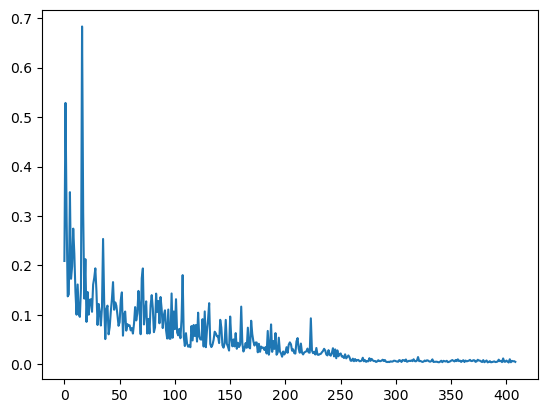

In [11]:
import numpy as np
import matplotlib.pyplot as plt
Zoom=20
Data=np.load("./SaveStep_Tmp/PerformanceTrack.npz")
KID=Data["KID"][Zoom:]
plt.plot(KID)

Data=np.load("./PaperSimulations_WGANs/SaveStep_Tmp/PerformanceTrack.npz")
KID=Data["KID"][Zoom:]
plt.plot(KID,c="red")

In [16]:
#GaussianSample=GaussianData_Interpolated["GaussianSample"]

ImageShape=EnergyPu.shape[1:]
TrainData=EnergyPu # EnergyPu # GaussianSample

DISCRIMINATOR=D_Create_CNN(in_shape=ImageShape)
DISCRIMINATOR._name="Discriminator"

GENERATOR=G_Create_CNN(100)
GENERATOR._name="Generator"

In [13]:
DISCRIMINATOR.summary()


Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image (InputLayer)           [(None, 25, 25, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 25, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 13, 13, 128)     

In [17]:
GENERATOR.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image (InputLayer)           [(None, 100)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_7 (Batch (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 8, 8, 512)         2359808   
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 8, 512)         20